In [5]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
# from google.cloud import storage
import shutil

# Install required packages if needed
# !pip install -q google-cloud-storage

# Authenticate to Google Cloud
# from google.colab import auth
# auth.authenticate_user()

# Define directories
BASE_DIR = "waymo_emergency_vehicle_detection"
DATA_DIR = os.path.join(BASE_DIR, "data")
VIDEOS_DIR = os.path.join(DATA_DIR, "videos")
FRAMES_DIR = os.path.join(DATA_DIR, "frames")
LABELS_DIR = os.path.join(DATA_DIR, "labels")
DETR_DIR = os.path.join(BASE_DIR, "detr_dataset")
DETR_ANNOS = os.path.join(DETR_DIR, "annotations")
# Create directories
for directory in [DATA_DIR, VIDEOS_DIR, FRAMES_DIR, LABELS_DIR, DETR_DIR, DETR_ANNOS]:
    os.makedirs(directory, exist_ok=True)

# Split directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(VIDEOS_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(FRAMES_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(LABELS_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(DETR_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(DETR_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(DETR_DIR, split, "labels"), exist_ok=True)

# Initialize GCP client
# client = storage.Client()
# bucket_name = "waymo_open_dataset_road_plus_plus"
# bucket = client.bucket(bucket_name)

In [9]:
path = DETR_ANNOS
  
# Check whether the specified 
# path exists or not 
isExist = os.path.exists(path) 
print(isExist)

True


In [6]:
# List all blobs (files) in the bucket
blobs = bucket.list_blobs()

for blob in blobs:
    print(blob.name)

NameError: name 'bucket' is not defined

In [20]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm
import random
import shutil
from google.cloud import storage
import matplotlib.pyplot as plt
from datetime import datetime

# Download a specific file
# blob = bucket.blob('road_waymo_trainval_v1.0.json')
# blob.download_to_filename('road_waymo_trainval_v1.0.json')
# # Load the JSON data
# with open('/content/road_waymo_trainval_v1.0.json', 'r') as file:
#     data = json.load(file)

In [11]:
with open('waymo_emergency_vehicle_detection/road_waymo_trainval_v1.0.json', 'r') as file:
    data = json.load(file)

In [21]:
# Define class indices for reference
agent_labels = data['agent_labels']
emveh_idx = agent_labels.index('EmVeh')
print(f"Emergency Vehicle class index: {emveh_idx}")

# Define metadata to track statistics
dataset_stats = {
    'total_sequences': 0,
    'sequences_with_emergency': 0,
    'total_frames': 0,
    'frames_with_emergency': 0,
    'total_emergency_instances': 0,
    'emergency_frames_by_sequence': {}
}

# COCO categories for DETR
CATEGORIES = [
    {
        "id": 1,
        "name": "emergency_vehicle",
        "supercategory": "vehicle"
    }
]

def convert_to_coco_bbox(box, img_width, img_height):
    """
    Convert normalized coordinates to COCO format [x, y, width, height] in absolute pixels
    Args:
        box: [x_min, y_min, x_max, y_max] in normalized coordinates (0-1)
        img_width: Image width in pixels
        img_height: Image height in pixels
    Returns:
        [x, y, width, height] in absolute coordinates where (x,y) is top-left corner
    """
    x_min, y_min, x_max, y_max = box

    # Convert to absolute coordinates
    x_min_abs = x_min * img_width
    y_min_abs = y_min * img_height
    x_max_abs = x_max * img_width
    y_max_abs = y_max * img_height

    # Calculate width and height
    width = x_max_abs - x_min_abs
    height = y_max_abs - y_min_abs

    # Return in COCO format [x, y, width, height]
    return [x_min_abs, y_min_abs, width, height]

def find_all_emergency_vehicles():
    """Find all frames containing emergency vehicles and collect statistics"""

    emergency_annotations = {}

    # Iterate through all sequences
    for sequence_id, sequence_data in tqdm(data['db'].items(), desc="Analyzing sequences"):
        dataset_stats['total_sequences'] += 1
        frames_in_seq = 0
        emergency_frames_in_seq = 0

        # Check if this sequence contains any frames
        if 'frames' not in sequence_data:
            continue

        # Get all frames in this sequence
        frames = sequence_data.get('frames', {})

        # Iterate through all frames
        for frame_id, frame_data in frames.items():
            dataset_stats['total_frames'] += 1
            frames_in_seq += 1

            # Get the annotations for this frame
            if 'annos' not in frame_data:
                continue

            annotations = frame_data['annos']

            # Look for emergency vehicles in the annotations
            emergency_instances = []

            for anno_id, anno_data in annotations.items():
                # Check if the annotation includes agent_ids
                if not isinstance(anno_data, dict) or 'agent_ids' not in anno_data:
                    continue

                # Check if agent_ids contains emergency vehicle index
                if emveh_idx in anno_data['agent_ids']:
                    # Found an emergency vehicle!
                    if 'box' in anno_data:
                        # Add this instance to our collection
                        emergency_instances.append({
                            'box': anno_data['box'],
                            'frame_id': frame_id,
                            'rgb_image_id': frame_data.get('rgb_image_id'),
                            'width': frame_data.get('width', 1920),
                            'height': frame_data.get('height', 1280),
                            'anno_id': anno_id
                        })

            # If we found emergency vehicles in this frame, update statistics
            if emergency_instances:
                dataset_stats['frames_with_emergency'] += 1
                emergency_frames_in_seq += 1
                dataset_stats['total_emergency_instances'] += len(emergency_instances)

                # Store the annotations
                if sequence_id not in emergency_annotations:
                    emergency_annotations[sequence_id] = {}

                emergency_annotations[sequence_id][frame_id] = {
                    'instances': emergency_instances,
                    'rgb_image_id': frame_data.get('rgb_image_id'),
                    'width': frame_data.get('width', 1920),
                    'height': frame_data.get('height', 1280)
                }

        # Update statistics for this sequence
        if emergency_frames_in_seq > 0:
            dataset_stats['sequences_with_emergency'] += 1
            dataset_stats['emergency_frames_by_sequence'][sequence_id] = emergency_frames_in_seq

    # Print statistics
    print(f"Found {dataset_stats['total_emergency_instances']} emergency vehicle instances")
    print(f"in {dataset_stats['frames_with_emergency']} frames across {dataset_stats['sequences_with_emergency']} sequences")

    return emergency_annotations

def prepare_coco_annotations(emergency_annotations, split_ratio=0.8):
    """
    Prepare COCO-style annotations for DETR

    Args:
        emergency_annotations: Dictionary of annotations by sequence and frame
        split_ratio: Train/val split ratio (default: 0.8)
    """
    # Get all sequence IDs with emergency vehicles
    sequence_ids = list(emergency_annotations.keys())

    # Shuffle and split into train/val
    random.shuffle(sequence_ids)
    split_idx = int(len(sequence_ids) * split_ratio)
    train_sequences = sequence_ids[:split_idx]
    val_sequences = sequence_ids[split_idx:]

    print(f"Split: {len(train_sequences)} train sequences, {len(val_sequences)} validation sequences")

    def create_coco_annotation_file(split_name, sequence_ids):
        """Create COCO annotation file for a given split"""

        coco_data = {
            "info": {
                "description": "Waymo Emergency Vehicle Dataset",
                "version": "1.0",
                "year": 2024,
                "contributor": "Waymo Open Dataset",
                "date_created": datetime.now().isoformat()
            },
            "licenses": [],
            "images": [],
            "annotations": [],
            "categories": CATEGORIES
        }

        image_id = 1
        annotation_id = 1
        image_mapping = {}

        for sequence_id in tqdm(sequence_ids, desc=f"Processing {split_name} annotations"):
            for frame_id, frame_data in emergency_annotations[sequence_id].items():
                rgb_image_id = frame_data['rgb_image_id']
                width = frame_data['width']
                height = frame_data['height']

                # Generate a unique output filename
                filename = f"{sequence_id}_{frame_id}.jpg"

                # Add image info to COCO format
                image_info = {
                    "id": image_id,
                    "width": width,
                    "height": height,
                    "file_name": filename,
                    "license": 1,
                    "flickr_url": "",
                    "coco_url": "",
                    "date_captured": ""
                }
                coco_data["images"].append(image_info)

                # Store mapping for later use
                image_mapping[filename] = {
                    'sequence_id': sequence_id,
                    'frame_id': frame_id,
                    'rgb_image_id': rgb_image_id,
                    'image_id': image_id
                }

                # Process each emergency vehicle instance in this frame
                for instance in frame_data['instances']:
                    box = instance['box']

                    # Convert to COCO bbox format
                    coco_bbox = convert_to_coco_bbox(box, width, height)

                    # Calculate area
                    area = coco_bbox[2] * coco_bbox[3]

                    # Create annotation
                    annotation = {
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": 1,  # emergency_vehicle
                        "segmentation": [],  # Empty for bounding box detection
                        "area": area,
                        "bbox": coco_bbox,
                        "iscrowd": 0
                    }

                    coco_data["annotations"].append(annotation)
                    annotation_id += 1

                image_id += 1

        # Save COCO annotation file
        annotation_file = os.path.join(DETR_DIR, "annotations", f"{split_name}.json")
        with open(annotation_file, 'w') as f:
            json.dump(coco_data, f, indent=2)

        print(f"Created {split_name} annotations: {len(coco_data['images'])} images, {len(coco_data['annotations'])} annotations")

        return image_mapping, len(coco_data['images']), len(coco_data['annotations'])

    # Create train and validation annotation files
    train_mapping, train_images, train_annos = create_coco_annotation_file('train', train_sequences)
    val_mapping, val_images, val_annos = create_coco_annotation_file('val', val_sequences)

    # Combine mappings for image download reference
    full_mapping = {
        'train': train_mapping,
        'val': val_mapping
    }

    # Save the image mapping for future reference
    with open(os.path.join(BASE_DIR, 'image_mapping.json'), 'w') as f:
        json.dump(full_mapping, f, indent=2)

    print(f"\nDataset Summary:")
    print(f"Train: {train_images} images, {train_annos} annotations")
    print(f"Val: {val_images} images, {val_annos} annotations")

    return full_mapping

def create_placeholder_images(image_mapping):
    """Create placeholder image files for testing"""

    for split in ['train', 'val']:
        split_dir = os.path.join(DETR_DIR, split)
        os.makedirs(split_dir, exist_ok=True)

        for filename, info in tqdm(image_mapping[split].items(), desc=f"Creating {split} placeholders"):
            placeholder_path = os.path.join(split_dir, filename)

            # Create a simple placeholder image (you can replace this with actual image loading)
            placeholder_img = np.zeros((info.get('height', 1280), info.get('width', 1920), 3), dtype=np.uint8)
            placeholder_img.fill(128)  # Gray image

            # Add some text to indicate it's a placeholder
            cv2.putText(placeholder_img, f"Placeholder", (50, 100),
                       cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
            cv2.putText(placeholder_img, f"Seq: {info['sequence_id']}", (50, 200),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(placeholder_img, f"Frame: {info['frame_id']}", (50, 250),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            cv2.imwrite(placeholder_path, placeholder_img)

def attempt_to_download_images(image_mapping):
    """
    Attempts to download images from Waymo bucket based on rgb_image_id
    """
    # Initialize GCP client (assuming you already have access)
    try:
        client = storage.Client()
        bucket_name = "waymo_open_dataset_road_plus_plus"
        bucket = client.bucket(bucket_name)
    except Exception as e:
        print(f"Could not initialize GCP client: {e}")
        print("Creating placeholder images instead...")
        create_placeholder_images(image_mapping)
        return 0

    # Try different possible path formats
    possible_path_formats = [
        "{rgb_image_id}.jpg",
        "{sequence_id}/{rgb_image_id}.jpg",
        "frames/{sequence_id}/{rgb_image_id}.jpg",
        "images/{sequence_id}/{rgb_image_id}.jpg",
        "{sequence_id}_{frame_id}.jpg",
        "road_plus_plus/{sequence_id}/{rgb_image_id}.jpg"
    ]

    # Try to download a sample of images first
    sample_count = 10
    downloaded = 0

    print(f"Attempting to download {sample_count} sample images...")

    # Flatten the image mapping for sampling
    all_images = []
    for split in ['train', 'val']:
        for filename, image_info in image_mapping[split].items():
            all_images.append((split, filename, image_info))

    # Sample a subset
    sample_images = random.sample(all_images, min(sample_count, len(all_images)))

    for split, filename, image_info in sample_images:
        # Try each possible path format
        downloaded_this = False
        for path_format in possible_path_formats:
            try:
                remote_path = path_format.format(
                    sequence_id=image_info['sequence_id'],
                    frame_id=image_info['frame_id'],
                    rgb_image_id=image_info['rgb_image_id']
                )

                local_path = os.path.join(DETR_DIR, split, filename)

                blob = bucket.blob(remote_path)
                if blob.exists():
                    blob.download_to_filename(local_path)
                    print(f"Downloaded {remote_path}")
                    downloaded += 1
                    downloaded_this = True
                    break
            except Exception as e:
                continue

        if not downloaded_this:
            # Create placeholder if download failed
            placeholder_path = os.path.join(DETR_DIR, split, filename)
            placeholder_img = np.zeros((image_info.get('height', 1280),
                                     image_info.get('width', 1920), 3), dtype=np.uint8)
            placeholder_img.fill(128)
            cv2.imwrite(placeholder_path, placeholder_img)

    print(f"Downloaded {downloaded} out of {sample_count} attempted images")

    # If successful, download the rest
    if downloaded > 0:
        print("Sample download successful. Downloading remaining images...")
        # Continue with full download...
    else:
        print("Sample download failed. Creating placeholder images for all...")
        create_placeholder_images(image_mapping)

    return downloaded

def create_detr_config():
    """Create a basic configuration file for DETR training"""

    config = {
        "model_name": "facebook/detr-resnet-50",
        "num_classes": 1,  # Just emergency vehicles
        "train_annotation_file": os.path.join(DETR_DIR, "annotations", "train.json"),
        "val_annotation_file": os.path.join(DETR_DIR, "annotations", "val.json"),
        "train_image_dir": os.path.join(DETR_DIR, "train"),
        "val_image_dir": os.path.join(DETR_DIR, "val"),
        "batch_size": 2,  # Adjust based on your GPU memory
        "learning_rate": 1e-4,
        "num_epochs": 50,
        "save_dir": os.path.join(BASE_DIR, "detr_checkpoints")
    }

    # Save config
    with open(os.path.join(BASE_DIR, 'detr_config.json'), 'w') as f:
        json.dump(config, f, indent=2)

    print("Created DETR configuration file")
    return config

# Main execution
if __name__ == "__main__":
    # Find all emergency vehicle instances
    print("Searching for emergency vehicles in the dataset...")
    emergency_annotations = find_all_emergency_vehicles()

    # Save the annotations for reference
    with open(os.path.join(BASE_DIR, 'emergency_annotations.json'), 'w') as f:
        json.dump(emergency_annotations, f, indent=2)

    # Prepare the DETR dataset
    if emergency_annotations:
        print("\nPreparing COCO-style annotations for DETR...")
        image_mapping = prepare_coco_annotations(emergency_annotations)

        # Try to download images
        print("\nAttempting to download actual images...")
        downloaded = attempt_to_download_images(image_mapping)

        # Create DETR configuration
        config = create_detr_config()

        print("\nDETR dataset preparation complete!")
        print(f"Dataset statistics:")
        for key, value in dataset_stats.items():
            if key != 'emergency_frames_by_sequence':
                print(f"  {key}: {value}")

        print(f"\nFiles created:")
        print(f"  - Train annotations: {config['train_annotation_file']}")
        print(f"  - Val annotations: {config['val_annotation_file']}")
        print(f"  - Config file: {os.path.join(BASE_DIR, 'detr_config.json')}")
        print(f"  - Image mapping: {os.path.join(BASE_DIR, 'image_mapping.json')}")

    else:
        print("No emergency vehicle instances found in the dataset.")

Emergency Vehicle class index: 8
Searching for emergency vehicles in the dataset...


Analyzing sequences: 100%|█████████████████████████████████████████████████████████| 798/798 [00:00<00:00, 1242.70it/s]


Found 2139 emergency vehicle instances
in 2139 frames across 27 sequences

Preparing COCO-style annotations for DETR...
Split: 21 train sequences, 6 validation sequences


Processing train annotations: 100%|█████████████████████████████████████████████████| 21/21 [00:00<00:00, 10493.26it/s]


Created train annotations: 1890 images, 1890 annotations


Processing val annotations: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


Created val annotations: 249 images, 249 annotations

Dataset Summary:
Train: 1890 images, 1890 annotations
Val: 249 images, 249 annotations

Attempting to download actual images...
Could not initialize GCP client: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.
Creating placeholder images instead...


Creating val placeholders: 100%|█████████████████████████████████████████████████████| 249/249 [00:03<00:00, 75.16it/s]

Created DETR configuration file

DETR dataset preparation complete!
Dataset statistics:
  total_sequences: 798
  sequences_with_emergency: 27
  total_frames: 153534
  frames_with_emergency: 2139
  total_emergency_instances: 2139

Files created:
  - Train annotations: waymo_emergency_vehicle_detection\detr_dataset\annotations\train.json
  - Val annotations: waymo_emergency_vehicle_detection\detr_dataset\annotations\val.json
  - Config file: waymo_emergency_vehicle_detection\detr_config.json
  - Image mapping: waymo_emergency_vehicle_detection\image_mapping.json


In [5]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm
import random
from google.cloud import storage
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load our previously generated mappings
with open('/content/waymo_emergency_vehicle_detection/image_mapping.json', 'r') as f:
    image_mapping = json.load(f)

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
VIDEOS_DIR = os.path.join(BASE_DIR, "data/videos")
FRAMES_DIR = os.path.join(BASE_DIR, "data/frames")
DETR_DIR = os.path.join(BASE_DIR, "detr_dataset")

# Make sure directories exist
os.makedirs(VIDEOS_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)

# Function to download videos from the bucket
def download_videos():
    """Download the required videos from the Waymo bucket"""

    # Initialize GCP client
    client = storage.Client()
    bucket_name = "waymo_open_dataset_road_plus_plus"
    bucket = client.bucket(bucket_name)

    # Gather unique sequence IDs from our annotations
    sequence_ids = set()
    for split in ['train', 'val']:
        for filename, image_info in image_mapping[split].items():
            sequence_id = image_info['sequence_id']
            sequence_ids.add(sequence_id)

    print(f"Need to download {len(sequence_ids)} video sequences")

    # Try different possible video path formats
    possible_path_formats = [
        "videos/{sequence_id}.mp4",
        "test_videos/{sequence_id}.mp4",
        "train_videos/{sequence_id}.mp4",
        "{sequence_id}.mp4",
        "road_plus_plus/videos/{sequence_id}.mp4",
        "waymo_road_plus_plus/{sequence_id}.mp4"
    ]

    # Download each video
    downloaded = 0
    for sequence_id in tqdm(sequence_ids, desc="Downloading videos"):
        # Check if already downloaded
        local_video_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")
        if os.path.exists(local_video_path):
            print(f"Video {sequence_id}.mp4 already exists, skipping...")
            downloaded += 1
            continue

        # Try each possible path format
        video_found = False
        for path_format in possible_path_formats:
            try:
                remote_path = path_format.format(sequence_id=sequence_id)
                print(f"Trying to download {remote_path}...")

                blob = bucket.blob(remote_path)
                if blob.exists():
                    blob.download_to_filename(local_video_path)
                    print(f"Downloaded {remote_path} to {local_video_path}")
                    downloaded += 1
                    video_found = True
                    break
            except Exception as e:
                print(f"Error trying {path_format}: {e}")

        if not video_found:
            print(f"Could not find video for sequence {sequence_id}")

    print(f"Downloaded {downloaded} out of {len(sequence_ids)} required videos")

    # If couldn't download, try listing the bucket to find video paths
    if downloaded < len(sequence_ids):
        print("Could not download all required videos. Exploring bucket structure...")

        # List blobs to find video files
        print("Searching for video files in the bucket...")
        try:
            blobs = list(bucket.list_blobs(max_results=5000))
            video_blobs = [b for b in blobs if b.name.endswith('.mp4')]

            if video_blobs:
                print(f"Found {len(video_blobs)} video files in the bucket:")
                for i, blob in enumerate(sorted(b.name for b in video_blobs)[:20]):
                    print(f"  {i+1}. {blob}")

                # Try to map sequence IDs to blob names
                for sequence_id in list(sequence_ids):
                    # If already downloaded, skip
                    if os.path.exists(os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")):
                        continue

                    # Try to find a matching blob
                    matching_blobs = [b for b in video_blobs if sequence_id in b.name]
                    if matching_blobs:
                        blob = matching_blobs[0]
                        local_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")
                        try:
                            print(f"Downloading {blob.name} to {local_path}...")
                            blob.download_to_filename(local_path)
                            downloaded += 1
                        except Exception as e:
                            print(f"Error downloading {blob.name}: {e}")
            else:
                print("No video files found in the bucket.")

        except Exception as e:
            print(f"Error exploring bucket: {e}")

    return downloaded

# Function to extract frames from videos
def extract_frames():
    """Extract frames from videos based on our annotations for DETR dataset"""

    frames_extracted = 0
    failed_extractions = 0

    # Process each split
    for split in ['train', 'val']:
        # Group by sequence_id for efficiency
        by_sequence = {}
        for filename, image_info in image_mapping[split].items():
            sequence_id = image_info['sequence_id']
            if sequence_id not in by_sequence:
                by_sequence[sequence_id] = []
            by_sequence[sequence_id].append((filename, image_info))

        # Process each sequence
        for sequence_id, entries in tqdm(by_sequence.items(), desc=f"Extracting {split} frames"):
            video_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")

            # Check if video exists
            if not os.path.exists(video_path):
                print(f"Video file {video_path} not found, skipping {len(entries)} frames")
                failed_extractions += len(entries)
                continue

            try:
                # Open the video file
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"Could not open video file {video_path}")
                    failed_extractions += len(entries)
                    continue

                # Get video properties
                fps = cap.get(cv2.CAP_PROP_FPS)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                print(f"Video {sequence_id}.mp4: {frame_count} frames at {fps} fps")

                # Sort entries by frame_id for efficient sequential access
                entries.sort(key=lambda x: int(x[1]['frame_id']))

                # Extract each frame
                for filename, image_info in entries:
                    frame_id = image_info['frame_id']

                    # Handle different frame_id formats
                    try:
                        frame_index = int(frame_id) - 1  # Convert to 0-based index
                    except ValueError:
                        # If frame_id is not a simple number, try parsing it differently
                        frame_index = int(frame_id.split('_')[-1]) - 1 if '_' in frame_id else 0

                    # Set the frame position
                    if frame_index >= frame_count or frame_index < 0:
                        print(f"Frame index {frame_index} out of range for video {sequence_id} (0-{frame_count-1})")
                        failed_extractions += 1
                        continue

                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

                    # Read the frame
                    ret, frame = cap.read()
                    if not ret:
                        print(f"Could not read frame {frame_id} from video {sequence_id}")
                        failed_extractions += 1
                        continue

                    # Save the frame to DETR dataset directory
                    frame_path = os.path.join(DETR_DIR, split, filename)

                    # Ensure the frame matches expected dimensions (resize if needed)
                    expected_height = image_info.get('height', 1280)
                    expected_width = image_info.get('width', 1920)

                    if frame.shape[:2] != (expected_height, expected_width):
                        frame = cv2.resize(frame, (expected_width, expected_height))

                    success = cv2.imwrite(frame_path, frame)
                    if success:
                        frames_extracted += 1
                    else:
                        print(f"Failed to save frame to {frame_path}")
                        failed_extractions += 1

                # Release the video
                cap.release()

            except Exception as e:
                print(f"Error processing video {sequence_id}: {e}")
                failed_extractions += len(entries)

    print(f"Extracted {frames_extracted} frames, failed to extract {failed_extractions} frames")
    return frames_extracted

# Function to verify DETR dataset
def verify_detr_dataset():
    """Verify that the DETR dataset is correctly set up"""

    # Load annotation files
    train_annotations_path = os.path.join(DETR_DIR, "annotations", "train.json")
    val_annotations_path = os.path.join(DETR_DIR, "annotations", "val.json")

    dataset_stats = {
        'train_images_expected': 0,
        'train_images_found': 0,
        'val_images_expected': 0,
        'val_images_found': 0,
        'train_annotations': 0,
        'val_annotations': 0,
        'missing_images': []
    }

    for split, annotations_path in [('train', train_annotations_path), ('val', val_annotations_path)]:
        if not os.path.exists(annotations_path):
            print(f"WARNING: Annotation file {annotations_path} not found!")
            continue

        # Load annotations
        with open(annotations_path, 'r') as f:
            coco_data = json.load(f)

        # Count expected images and annotations
        expected_images = len(coco_data['images'])
        annotations_count = len(coco_data['annotations'])

        dataset_stats[f'{split}_images_expected'] = expected_images
        dataset_stats[f'{split}_annotations'] = annotations_count

        # Check which images actually exist
        images_dir = os.path.join(DETR_DIR, split)
        found_images = 0

        for image_info in coco_data['images']:
            image_path = os.path.join(images_dir, image_info['file_name'])
            if os.path.exists(image_path):
                found_images += 1
            else:
                dataset_stats['missing_images'].append(f"{split}/{image_info['file_name']}")

        dataset_stats[f'{split}_images_found'] = found_images

    # Print summary
    print("\nDETR Dataset Verification:")
    print(f"Training set: {dataset_stats['train_images_found']}/{dataset_stats['train_images_expected']} images, {dataset_stats['train_annotations']} annotations")
    print(f"Validation set: {dataset_stats['val_images_found']}/{dataset_stats['val_images_expected']} images, {dataset_stats['val_annotations']} annotations")

    if dataset_stats['missing_images']:
        print(f"Missing images: {len(dataset_stats['missing_images'])}")
        if len(dataset_stats['missing_images']) <= 10:
            for missing in dataset_stats['missing_images']:
                print(f"  - {missing}")
        else:
            print(f"  First 10: {dataset_stats['missing_images'][:10]}")

    # Create sample visualizations
    print("\nCreating sample visualizations...")
    visualize_coco_samples(3, 'train')
    visualize_coco_samples(3, 'val')

    return dataset_stats

# Function to visualize sample images with COCO annotations
def visualize_coco_samples(num_samples, split):
    """Visualize sample images with bounding boxes for DETR verification"""

    # Load annotations
    annotations_path = os.path.join(DETR_DIR, "annotations", f"{split}.json")
    if not os.path.exists(annotations_path):
        print(f"Annotation file {annotations_path} not found")
        return

    with open(annotations_path, 'r') as f:
        coco_data = json.load(f)

    # Get images that exist
    images_dir = os.path.join(DETR_DIR, split)
    available_images = []

    for image_info in coco_data['images']:
        image_path = os.path.join(images_dir, image_info['file_name'])
        if os.path.exists(image_path):
            available_images.append(image_info)

    if not available_images:
        print(f"No available images found for visualization in {split} set")
        return

    # Select random samples
    samples = random.sample(available_images, min(num_samples, len(available_images)))

    # Create image_id to annotations mapping
    annotations_by_image = {}
    for anno in coco_data['annotations']:
        image_id = anno['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(anno)

    for image_info in samples:
        # Load image
        image_path = os.path.join(images_dir, image_info['file_name'])
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image {image_path}")
            continue

        # Convert BGR to RGB for matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(img_rgb)

        # Get annotations for this image
        image_annotations = annotations_by_image.get(image_info['id'], [])

        # Draw bounding boxes
        for anno in image_annotations:
            bbox = anno['bbox']  # [x, y, width, height] in absolute coordinates
            x, y, width, height = bbox

            # Create rectangle patch
            rect = patches.Rectangle((x, y), width, height,
                                   linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Add label
            category_name = "EmVeh"  # We only have one category
            label = f"{category_name}"
            ax.text(x, y - 5, label, color='red', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

        ax.set_title(f"Sample {split} image: {image_info['file_name']}")
        ax.axis('off')

        # Save visualization
        output_path = os.path.join(BASE_DIR, f"sample_{split}_{image_info['file_name'].replace('.jpg', '.png')}")
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        plt.close()

        print(f"Saved visualization to {output_path}")

def create_detr_training_script():
    """Create a sample DETR training script"""

    training_script = '''
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import json
import cv2
import numpy as np
from PIL import Image
import os

class WaymoEmergencyVehicleDataset(Dataset):
    def __init__(self, annotations_file, images_dir, processor, augment=False):
        with open(annotations_file, 'r') as f:
            self.coco_data = json.load(f)

        self.images_dir = images_dir
        self.processor = processor
        self.augment = augment

        # Create mapping from image_id to annotations
        self.annotations_by_image = {}
        for anno in self.coco_data['annotations']:
            image_id = anno['image_id']
            if image_id not in self.annotations_by_image:
                self.annotations_by_image[image_id] = []
            self.annotations_by_image[image_id].append(anno)

    def __len__(self):
        return len(self.coco_data['images'])

    def __getitem__(self, idx):
        image_info = self.coco_data['images'][idx]
        image_path = os.path.join(self.images_dir, image_info['file_name'])

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Get annotations
        image_annotations = self.annotations_by_image.get(image_info['id'], [])

        # Prepare target
        target = {
            'image_id': torch.tensor([image_info['id']]),
            'boxes': [],
            'labels': []
        }

        for anno in image_annotations:
            bbox = anno['bbox']  # [x, y, width, height]
            # Convert to [x_min, y_min, x_max, y_max]
            x, y, w, h = bbox
            target['boxes'].append([x, y, x + w, y + h])
            target['labels'].append(1)  # Emergency vehicle class

        if target['boxes']:
            target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(target['labels'], dtype=torch.int64)
        else:
            # Handle images with no annotations
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros(0, dtype=torch.int64)

        # Process with DETR processor
        encoding = self.processor(images=image, annotations=target, return_tensors="pt")

        return {
            'pixel_values': encoding['pixel_values'].squeeze(),
            'labels': encoding['labels'][0] if 'labels' in encoding else target
        }

# Training configuration
def train_detr():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load processor and model
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", num_labels=1)
    model.to(device)

    # Create datasets
    train_dataset = WaymoEmergencyVehicleDataset(
        "/content/waymo_emergency_vehicle_detection/detr_dataset/annotations/train.json",
        "/content/waymo_emergency_vehicle_detection/detr_dataset/train",
        processor,
        augment=True
    )

    val_dataset = WaymoEmergencyVehicleDataset(
        "/content/waymo_emergency_vehicle_detection/detr_dataset/annotations/val.json",
        "/content/waymo_emergency_vehicle_detection/detr_dataset/val",
        processor,
        augment=False
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir="/content/waymo_emergency_vehicle_detection/detr_checkpoints",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=10,
        learning_rate=1e-4,
        logging_steps=50,
        save_steps=500,
        evaluation_strategy="steps",
        eval_steps=500,
        save_total_limit=3,
        remove_unused_columns=False,
        dataloader_pin_memory=False,
    )

    # Custom trainer for DETR
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
    )

    # Start training
    trainer.train()

    # Save final model
    trainer.save_model("/content/waymo_emergency_vehicle_detection/detr_final_model")

if __name__ == "__main__":
    train_detr()
'''

    script_path = os.path.join(BASE_DIR, "train_detr.py")
    with open(script_path, 'w') as f:
        f.write(training_script)

    print(f"Created DETR training script at {script_path}")
    return script_path

def create_inference_script():
    """Create a sample inference script for the trained DETR model"""

    inference_script = '''
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image, ImageDraw
import cv2
import numpy as np

def load_model(model_path):
    """Load the trained DETR model"""
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained(model_path)
    return processor, model

def detect_emergency_vehicles(image_path, processor, model, threshold=0.5):
    """Detect emergency vehicles in an image"""
    # Load image
    image = Image.open(image_path).convert('RGB')

    # Process image
    inputs = processor(images=image, return_tensors="pt")

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert outputs to COCO API format
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

    return results, image

def visualize_detections(image, results, output_path):
    """Visualize detection results"""
    draw = ImageDraw.Draw(image)

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(f"Detected emergency vehicle with confidence {round(score.item(), 3)} at location {box}")

        # Draw bounding box
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"EmVeh: {round(score.item(), 2)}", fill="red")

    image.save(output_path)
    print(f"Saved visualization to {output_path}")

# Example usage
if __name__ == "__main__":
    model_path = "/content/waymo_emergency_vehicle_detection/detr_final_model"
    processor, model = load_model(model_path)

    # Test on a sample image
    test_image = "/content/waymo_emergency_vehicle_detection/detr_dataset/val/sample_image.jpg"
    results, image = detect_emergency_vehicles(test_image, processor, model)
    visualize_detections(image, results, "detection_result.jpg")
'''

    script_path = os.path.join(BASE_DIR, "inference_detr.py")
    with open(script_path, 'w') as f:
        f.write(inference_script)

    print(f"Created DETR inference script at {script_path}")
    return script_path

# Main execution
if __name__ == "__main__":
    # Step 1: Download videos
    print("Step 1: Downloading videos...")
    download_videos()

    # Step 2: Extract frames
    print("\nStep 2: Extracting frames from videos...")
    extract_frames()

    # Step 3: Verify dataset
    print("\nStep 3: Verifying DETR dataset...")
    verify_detr_dataset()

    # Step 4: Create training and inference scripts
    print("\nStep 4: Creating DETR training and inference scripts...")
    create_detr_training_script()
    create_inference_script()

    print("\nAll done! Your DETR dataset is ready for training.")
    print("\nNext steps:")
    print("1. Install required packages: pip install transformers datasets torch torchvision")
    print("2. Run the training script: python train_detr.py")
    print("3. Use the inference script to test your trained model")

ModuleNotFoundError: No module named 'google.cloud'

In [9]:

# Function to visualize sample images with COCO annotations
def visualize_coco_samples(num_samples, split):
    """Visualize sample images with bounding boxes for DETR verification"""

    # Load annotations
    annotations_path = os.path.join(DETR_DIR, "annotations", f"{split}.json")
    if not os.path.exists(annotations_path):
        print(f"Annotation file {annotations_path} not found")
        return

    with open(annotations_path, 'r') as f:
        coco_data = json.load(f)

    # Get images that exist
    images_dir = os.path.join(DETR_DIR, split)
    available_images = []

    for image_info in coco_data['images']:
        image_path = os.path.join(images_dir, image_info['file_name'])
        if os.path.exists(image_path):
            available_images.append(image_info)

    if not available_images:
        print(f"No available images found for visualization in {split} set")
        return

    # Select random samples
    samples = random.sample(available_images, min(num_samples, len(available_images)))

    # Create image_id to annotations mapping
    annotations_by_image = {}
    for anno in coco_data['annotations']:
        image_id = anno['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(anno)

    for image_info in samples:
        # Load image
        image_path = os.path.join(images_dir, image_info['file_name'])
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image {image_path}")
            continue

        # Convert BGR to RGB for matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(img_rgb)

        # Get annotations for this image
        image_annotations = annotations_by_image.get(image_info['id'], [])

        # Draw bounding boxes
        for anno in image_annotations:
            bbox = anno['bbox']  # [x, y, width, height] in absolute coordinates
            x, y, width, height = bbox

            # Create rectangle patch
            rect = patches.Rectangle((x, y), width, height,
                                   linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Add label
            category_name = "EmVeh"  # We only have one category
            label = f"{category_name}"
            ax.text(x, y - 5, label, color='red', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

        ax.set_title(f"Sample {split} image: {image_info['file_name']}")
        ax.axis('off')

        # Save visualization
        output_path = os.path.join(BASE_DIR, f"sample_{split}_{image_info['file_name'].replace('.jpg', '.png')}")
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        plt.close()

        print(f"Saved visualization to {output_path}")

In [11]:
visualize_coco_samples(5,0.8)

Annotation file waymo_emergency_vehicle_detection\detr_dataset\annotations\0.8.json not found


# DETR Training

In [6]:
print('hi"')

hi"


In [4]:
import os
import json
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
from sklearn.metrics import precision_recall_fscore_support
import random

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define directories
# BASE_DIR = "/content/waymo_emergency_vehicle_detection"
BASE_DIR = "waymo_emergency_vehicle_detection"
DETR_DIR = os.path.join(BASE_DIR, "detr_dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

class WaymoEmergencyVehicleDataset(Dataset):
    """Custom dataset for Waymo Emergency Vehicle Detection with DETR - optimized version"""

    def __init__(self, annotations_file, images_dir, processor, augment=False, max_samples=None):
        with open(annotations_file, 'r') as f:
            self.coco_data = json.load(f)

        self.images_dir = images_dir
        self.processor = processor
        self.augment = augment

        # Create mapping from image_id to annotations
        self.annotations_by_image = {}
        for anno in self.coco_data['annotations']:
            image_id = anno['image_id']
            if image_id not in self.annotations_by_image:
                self.annotations_by_image[image_id] = []
            self.annotations_by_image[image_id].append(anno)

        # Filter out images that don't exist
        self.valid_images = []
        for image_info in self.coco_data['images']:
            image_path = os.path.join(images_dir, image_info['file_name'])
            if os.path.exists(image_path):
                self.valid_images.append(image_info)

        # Limit dataset size for faster training if specified
        if max_samples and len(self.valid_images) > max_samples:
            self.valid_images = random.sample(self.valid_images, max_samples)
            logger.info(f"Limited dataset to {max_samples} samples for faster training")

        logger.info(f"Dataset initialized with {len(self.valid_images)} valid images")

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        image_info = self.valid_images[idx]
        image_path = os.path.join(self.images_dir, image_info['file_name'])

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Get annotations for this image
        image_annotations = self.annotations_by_image.get(image_info['id'], [])

        # Prepare annotations in the format expected by DETR processor
        annotations = []
        for anno in image_annotations:
            bbox = anno['bbox']  # [x, y, width, height] in COCO format
            # Convert to [x_min, y_min, x_max, y_max] format for DETR
            x, y, w, h = bbox
            annotations.append({
                'bbox': [x, y, x + w, y + h],
                'category_id': 1,  # All are emergency vehicles (class 1)
                'area': anno['area'],
                'iscrowd': anno.get('iscrowd', 0)
            })

        # Prepare target in the format expected by DETR processor
        target = {
            'image_id': image_info['id'],
            'annotations': annotations
        }

        # Process with DETR processor
        try:
            encoding = self.processor(images=image, annotations=target, return_tensors="pt")
            pixel_values = encoding['pixel_values'].squeeze(0)
            labels = encoding['labels'][0] if 'labels' in encoding else None

            # If labels is None, create empty target
            if labels is None:
                labels = {
                    'class_labels': torch.zeros(100, dtype=torch.int64),  # 100 is max queries
                    'boxes': torch.zeros((100, 4), dtype=torch.float32),
                }

            return {
                'pixel_values': pixel_values,
                'labels': labels
            }
        except Exception as e:
            logger.warning(f"Error processing image {image_info['file_name']}: {e}")
            # Return a dummy sample with proper format
            dummy_image = Image.new('RGB', (640, 640), color='gray')
            dummy_target = {'image_id': 0, 'annotations': []}

            try:
                encoding = self.processor(images=dummy_image, annotations=dummy_target, return_tensors="pt")
                return {
                    'pixel_values': encoding['pixel_values'].squeeze(0),
                    'labels': encoding['labels'][0]
                }
            except:
                # Final fallback
                return {
                    'pixel_values': torch.zeros((3, 640, 640), dtype=torch.float32),
                    'labels': {
                        'class_labels': torch.zeros(100, dtype=torch.int64),
                        'boxes': torch.zeros((100, 4), dtype=torch.float32),
                    }
                }

def collate_fn(batch):
    """Custom collate function for DETR"""
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = [item['labels'] for item in batch]

    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

class DetrTrainer(Trainer):
    """Custom trainer for DETR with proper loss computation"""

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Fixed compute_loss method that handles additional keyword arguments and ensures proper tensor return
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs, labels=labels)

        # Get device for tensor creation
        device = next(model.parameters()).device

        # DETR computes loss internally when labels are provided
        if hasattr(outputs, 'loss') and outputs.loss is not None:
            loss = outputs.loss
        elif hasattr(outputs, 'loss_dict') and outputs.loss_dict:
            # Sum all loss components
            loss_values = []
            for loss_val in outputs.loss_dict.values():
                if isinstance(loss_val, torch.Tensor):
                    loss_values.append(loss_val)

            if loss_values:
                loss = sum(loss_values)
            else:
                loss = torch.tensor(0.0, device=device, requires_grad=True)
        else:
            # Fallback loss
            loss = torch.tensor(0.0, device=device, requires_grad=True)

        # Ensure loss is a tensor with gradient
        if not isinstance(loss, torch.Tensor):
            loss = torch.tensor(float(loss), device=device, requires_grad=True)
        elif not loss.requires_grad:
            loss = loss.clone().detach().requires_grad_(True)

        return (loss, outputs) if return_outputs else loss

def train_detr_model(model_name='facebook/detr-resnet-50', epochs=10, batch_size=8,
                     learning_rate=5e-5, patience=3):
    """
    Train a DETR model on emergency vehicle dataset

    Args:
        model_name: Pre-trained DETR model name
        epochs: Number of training epochs
        batch_size: Training batch size
        learning_rate: Learning rate
        patience: Early stopping patience

    Returns:
        Trained model and processor
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Load processor and model
    print('creating processor...')
    processor = DetrImageProcessor.from_pretrained(model_name)
    print('processor done!')
    print('creating model...')
    model = DetrForObjectDetection.from_pretrained(
        model_name,
        num_labels=2,  # Background + emergency vehicle
        ignore_mismatched_sizes=True
    )
    print('model done!')
    # Modify the model's class labels
    model.config.id2label = {0: "N/A", 1: "emergency_vehicle"}
    model.config.label2id = {"N/A": 0, "emergency_vehicle": 1}
    print('model class labels done!')

    # Create datasets with size limits for faster training
    print('creating waymo emergency vehicle train dataset...')
    train_dataset = WaymoEmergencyVehicleDataset(
        os.path.join(DETR_DIR, "annotations", "train.json"),
        os.path.join(DETR_DIR, "train"),
        processor,
        augment=True,
        max_samples=5000  # Limit training set for faster training
    )
    print('creating waymo emergency vehicle train set done!')
    print('creating waymo emergency vehicle validation dataset...')
    val_dataset = WaymoEmergencyVehicleDataset(
        os.path.join(DETR_DIR, "annotations", "val.json"),
        os.path.join(DETR_DIR, "val"),
        processor,
        augment=False,
        max_samples=1000  # Limit validation set
    )
    print('creating waymo emergency vehicle val set done!')

    logger.info(f"Training dataset size: {len(train_dataset)}")
    logger.info(f"Validation dataset size: {len(val_dataset)}")

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty! Please check your dataset preparation.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty! Please check your dataset preparation.")
    print('writing train arguments...')
    # Training arguments - optimized for speed
    training_args = TrainingArguments(
        output_dir=os.path.join(RESULTS_DIR, "detr_emergency_vehicles"),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,  # Larger eval batch
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        logging_steps=100,  # Less frequent logging
        save_steps=1000,    # Less frequent saving
        eval_strategy="steps",
        eval_steps=1000,    # Less frequent evaluation
        save_total_limit=2, # Keep fewer checkpoints
        remove_unused_columns=False,
        dataloader_pin_memory=True,   # Enable pin memory for speed
        dataloader_num_workers=2,     # Use multiple workers
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
        push_to_hub=False,
        logging_dir=None,
        dataloader_drop_last=True,    # Drop last incomplete batch for consistency
        group_by_length=False,
        gradient_accumulation_steps=2,  # Accumulate gradients for effective larger batch
        fp16=True,                    # Enable mixed precision training
        gradient_checkpointing=False,  # Disable to trade memory for speed
        warmup_steps=500,             # Warmup for better convergence
        weight_decay=0.0001,          # Add some regularization
        lr_scheduler_type="cosine",   # Better LR scheduling
    )
    print('writing train done!')
    # Create trainer with custom data collator
    print('creating trainer...')
    trainer = DetrTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collate_fn,
        tokenizer=processor,  # Use tokenizer parameter for compatibility
    )
    print('creating trainer done!')

    # Start training
    logger.info("Starting DETR training...")
    try:
        trainer.train()
    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise e

    print('done training!')

    # Save the final model
    final_model_path = os.path.join(RESULTS_DIR, "detr_final_model")
    trainer.save_model(final_model_path)
    processor.save_pretrained(final_model_path)

    logger.info(f"Model saved to {final_model_path}")

    return model, processor, trainer

def evaluate_model(model, processor, test_dataset=None):
    """
    Evaluate the trained DETR model

    Args:
        model: Trained DETR model
        processor: DETR processor
        test_dataset: Test dataset (optional)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    if test_dataset is None:
        # Use validation dataset for evaluation
        test_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "val.json"),
            os.path.join(DETR_DIR, "val"),
            processor,
            augment=False
        )

    # Evaluation metrics
    total_images = 0
    total_detections = 0
    confident_detections = 0

    logger.info("Starting model evaluation...")

    with torch.no_grad():
        for i in range(min(100, len(test_dataset))):  # Evaluate on subset for speed
            try:
                sample = test_dataset[i]
                inputs = {
                    'pixel_values': sample['pixel_values'].unsqueeze(0).to(device)
                }

                outputs = model(**inputs)

                # Post-process predictions
                target_sizes = torch.tensor([[640, 640]]).to(device)  # Assuming 640x640 input
                results = processor.post_process_object_detection(
                    outputs,
                    target_sizes=target_sizes,
                    threshold=0.5
                )[0]

                total_images += 1
                detections = len(results['scores'])
                total_detections += detections
                confident_detections += len([s for s in results['scores'] if s > 0.7])

            except Exception as e:
                logger.warning(f"Error evaluating sample {i}: {e}")
                continue

    # Calculate metrics
    avg_detections = total_detections / max(total_images, 1)
    confident_ratio = confident_detections / max(total_detections, 1)

    print(f"\nModel Evaluation Results:")
    print(f"Images evaluated: {total_images}")
    print(f"Total detections: {total_detections}")
    print(f"Average detections per image: {avg_detections:.2f}")
    print(f"High-confidence detections (>0.7): {confident_detections}")
    print(f"Confident detection ratio: {confident_ratio:.2f}")

    return {
        'total_images': total_images,
        'total_detections': total_detections,
        'avg_detections': avg_detections,
        'confident_detections': confident_detections,
        'confident_ratio': confident_ratio
    }

def visualize_predictions(model, processor, num_samples=5):
    """
    Visualize DETR predictions on sample validation images

    Args:
        model: Trained DETR model
        processor: DETR processor
        num_samples: Number of samples to visualize
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Load validation dataset
    val_dataset = WaymoEmergencyVehicleDataset(
        os.path.join(DETR_DIR, "annotations", "val.json"),
        os.path.join(DETR_DIR, "val"),
        processor,
        augment=False
    )

    if len(val_dataset) == 0:
        print("No validation images found for visualization")
        return

    # Select random samples
    sample_indices = random.sample(range(len(val_dataset)), min(num_samples, len(val_dataset)))

    logger.info(f"Visualizing predictions on {len(sample_indices)} samples...")

    with torch.no_grad():
        for idx in sample_indices:
            try:
                # Get sample
                sample = val_dataset[idx]
                image_info = val_dataset.valid_images[idx]

                # Load original image for visualization
                image_path = os.path.join(val_dataset.images_dir, image_info['file_name'])
                original_image = Image.open(image_path).convert('RGB')

                # Run inference
                inputs = {
                    'pixel_values': sample['pixel_values'].unsqueeze(0).to(device)
                }
                outputs = model(**inputs)

                # Post-process results
                target_sizes = torch.tensor([original_image.size[::-1]]).to(device)
                results = processor.post_process_object_detection(
                    outputs,
                    target_sizes=target_sizes,
                    threshold=0.25
                )[0]

                # Visualize results
                draw = ImageDraw.Draw(original_image)

                detection_count = 0
                for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                    if score > 0.25:  # Only show confident detections
                        box = [round(i, 2) for i in box.tolist()]

                        # Draw bounding box
                        draw.rectangle(box, outline="red", width=3)

                        # Add label
                        label_text = f"EmVeh: {score:.2f}"
                        draw.text((box[0], box[1] - 20), label_text, fill="red")

                        detection_count += 1

                # Save visualization
                vis_path = os.path.join(RESULTS_DIR, f"detr_pred_{image_info['file_name']}")
                original_image.save(vis_path)

                print(f"Image: {image_info['file_name']}")
                print(f"Detections: {detection_count}")
                print(f"Confidence scores: {[f'{s:.2f}' for s in results['scores'] if s > 0.25]}")
                print(f"Visualization saved to: {vis_path}\n")

            except Exception as e:
                logger.warning(f"Error visualizing sample {idx}: {e}")
                continue

def run_inference_on_videos(model, processor, num_videos=2, frame_skip=10):
    """
    Run DETR inference on test videos and create visualization videos

    Args:
        model: Trained DETR model
        processor: DETR processor
        num_videos: Number of videos to process
        frame_skip: Process every Nth frame for speed
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Get list of video files
    videos_dir = os.path.join(BASE_DIR, "data", "videos")
    if not os.path.exists(videos_dir):
        print(f"Videos directory {videos_dir} not found")
        return

    all_videos = [os.path.join(videos_dir, f) for f in os.listdir(videos_dir) if f.endswith('.mp4')]

    if not all_videos:
        print("No video files found")
        return

    # Select random videos
    videos = random.sample(all_videos, min(num_videos, len(all_videos)))

    logger.info(f"Processing {len(videos)} videos...")

    with torch.no_grad():
        for video_path in videos:
            video_name = os.path.basename(video_path)
            output_path = os.path.join(RESULTS_DIR, f"detr_pred_{video_name}")

            print(f"Processing video: {video_name}")

            # Open video
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Could not open video: {video_path}")
                continue

            # Get video properties
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Create video writer
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps/frame_skip, (width, height))

            frame_count = 0
            processed_count = 0

            # Process frames
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Process every frame_skip frames
                if frame_count % frame_skip == 0:
                    try:
                        # Convert frame to PIL Image
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        pil_image = Image.fromarray(frame_rgb)

                        # Process with DETR
                        inputs = processor(images=pil_image, return_tensors="pt")
                        inputs = {k: v.to(device) for k, v in inputs.items()}

                        outputs = model(**inputs)

                        # Post-process predictions
                        target_sizes = torch.tensor([[height, width]]).to(device)
                        results = processor.post_process_object_detection(
                            outputs,
                            target_sizes=target_sizes,
                            threshold=0.5
                        )[0]

                        # Draw predictions on frame
                        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                            if score > 0.5:
                                box = [int(i) for i in box.tolist()]
                                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

                                # Add label
                                label_text = f"EmVeh: {score:.2f}"
                                cv2.putText(frame, label_text, (box[0], box[1] - 10),
                                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

                        # Write frame to output video
                        out.write(frame)
                        processed_count += 1

                        # Print progress
                        if processed_count % 10 == 0:
                            print(f"Processed {processed_count} frames ({frame_count}/{total_frames})")

                    except Exception as e:
                        logger.warning(f"Error processing frame {frame_count}: {e}")
                        out.write(frame)  # Write original frame if processing fails

                frame_count += 1

            # Release resources
            cap.release()
            out.release()

            print(f"Video saved to {output_path}")

In [5]:
import time
import torch
import logging
import sys
import os
import json
from transformers import TrainingArguments, TrainerCallback

def train_detr_model(model_name='facebook/detr-resnet-50', epochs=10, batch_size=8,
                     learning_rate=5e-5, patience=3):
    """
    Train a DETR model on emergency vehicle dataset with extensive debugging

    Args:
        model_name: Pre-trained DETR model name
        epochs: Number of training epochs
        batch_size: Training batch size
        learning_rate: Learning rate
        patience: Early stopping patience

    Returns:
        Trained model and processor
    """
    start_time = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"[DEBUG] Using device: {device}")
    
    # Check GPU memory if available
    if torch.cuda.is_available():
        print(f"[DEBUG] GPU: {torch.cuda.get_device_name()}")
        print(f"[DEBUG] GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        print(f"[DEBUG] GPU Memory Available: {torch.cuda.memory_reserved(0) / 1024**3:.1f} GB reserved")

    # Load processor and model
    print('[DEBUG] Step 1/8: Creating processor...')
    processor_start = time.time()
    try:
        processor = DetrImageProcessor.from_pretrained(model_name)
        print(f'[DEBUG] Processor created successfully in {time.time() - processor_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create processor: {e}")
        raise e

    print('[DEBUG] Step 2/8: Creating model...')
    model_start = time.time()
    try:
        model = DetrForObjectDetection.from_pretrained(
            model_name,
            num_labels=2,  # Background + emergency vehicle
            ignore_mismatched_sizes=True
        )
        model = model.to(device)  # Move model to device immediately
        print(f'[DEBUG] Model created and moved to {device} in {time.time() - model_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create model: {e}")
        raise e

    # Modify the model's class labels
    print('[DEBUG] Step 3/8: Setting model class labels...')
    model.config.id2label = {0: "N/A", 1: "emergency_vehicle"}
    model.config.label2id = {"N/A": 0, "emergency_vehicle": 1}
    print('[DEBUG] Model class labels configured')

    # Create datasets with size limits for faster training
    print('[DEBUG] Step 4/8: Creating training dataset...')
    train_dataset_start = time.time()
    try:
        train_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "train.json"),
            os.path.join(DETR_DIR, "train"),
            processor,
            augment=True,
            max_samples=5000  # Limit training set for faster training
        )
        print(f'[DEBUG] Training dataset created in {time.time() - train_dataset_start:.2f}s')
        print(f'[DEBUG] Training dataset size: {len(train_dataset)}')
    except Exception as e:
        print(f"[ERROR] Failed to create training dataset: {e}")
        raise e

    print('[DEBUG] Step 5/8: Creating validation dataset...')
    val_dataset_start = time.time()
    try:
        val_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "val.json"),
            os.path.join(DETR_DIR, "val"),
            processor,
            augment=False,
            max_samples=1000  # Limit validation set
        )
        print(f'[DEBUG] Validation dataset created in {time.time() - val_dataset_start:.2f}s')
        print(f'[DEBUG] Validation dataset size: {len(val_dataset)}')
    except Exception as e:
        print(f"[ERROR] Failed to create validation dataset: {e}")
        raise e

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty! Please check your dataset preparation.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty! Please check your dataset preparation.")

    # Test dataset loading (CRITICAL DEBUG STEP)
    print('[DEBUG] Step 6/8: Testing dataset loading...')
    test_start = time.time()
    try:
        print('[DEBUG] Testing single training sample...')
        train_sample = train_dataset[0]
        print(f'[DEBUG] Train sample keys: {train_sample.keys()}')
        print(f'[DEBUG] Train sample pixel_values shape: {train_sample["pixel_values"].shape}')
        print(f'[DEBUG] Train sample labels keys: {train_sample["labels"].keys()}')
        
        print('[DEBUG] Testing single validation sample...')
        val_sample = val_dataset[0]
        print(f'[DEBUG] Val sample keys: {val_sample.keys()}')
        print(f'[DEBUG] Val sample pixel_values shape: {val_sample["pixel_values"].shape}')
        
        print('[DEBUG] Testing data collator...')
        batch = collate_fn([train_sample, train_sample])  # Test with 2 identical samples
        print(f'[DEBUG] Collated batch keys: {batch.keys()}')
        print(f'[DEBUG] Batch pixel_values shape: {batch["pixel_values"].shape}')
        
        print(f'[DEBUG] Dataset loading test completed in {time.time() - test_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Dataset loading test failed: {e}")
        print("[ERROR] This is likely the source of your hanging issue!")
        raise e

    print('[DEBUG] Step 7/8: Setting up training arguments...')
    # Training arguments - optimized for debugging and speed
    training_args = TrainingArguments(
        output_dir=os.path.join(RESULTS_DIR, "detr_emergency_vehicles"),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=max(1, batch_size // 2),  # Smaller eval batch to prevent OOM
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        logging_steps=10,   # More frequent logging for debugging
        save_steps=500,     # More frequent saving for debugging
        eval_strategy="steps",
        eval_steps=500,     # More frequent evaluation for debugging
        save_total_limit=2,
        remove_unused_columns=False,
        dataloader_pin_memory=False,    # Disable pin memory initially for debugging
        dataloader_num_workers=0,       # Start with 0 workers for debugging
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
        push_to_hub=False,
        logging_dir=None,
        dataloader_drop_last=True,
        group_by_length=False,
        gradient_accumulation_steps=1,  # Start with 1 for debugging
        fp16=False,                     # Disable fp16 initially for debugging
        gradient_checkpointing=False,
        warmup_steps=100,               # Reduced warmup steps
        weight_decay=0.0001,
        lr_scheduler_type="linear",     # Simpler scheduler for debugging
        disable_tqdm=False,             # Enable progress bars
        log_level="info",               # Enable detailed logging
    )
    print('[DEBUG] Training arguments configured')

    # Create trainer with custom data collator
    print('[DEBUG] Step 8/8: Creating trainer...')
    trainer_start = time.time()
    try:
        trainer = DetrTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=collate_fn,
            tokenizer=processor,  # Use tokenizer parameter for compatibility
        )
        print(f'[DEBUG] Trainer created successfully in {time.time() - trainer_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create trainer: {e}")
        raise e

    print(f'[DEBUG] Total setup time: {time.time() - start_time:.2f}s')
    
    # Test a single training step before full training
    print('[DEBUG] Testing single training step...')
    single_step_start = time.time()
    try:
        # Get a single batch and test forward pass
        train_dataloader = trainer.get_train_dataloader()
        print(f'[DEBUG] Train dataloader created with {len(train_dataloader)} batches')
        
        # Get first batch
        batch_iter = iter(train_dataloader)
        batch = next(batch_iter)
        print(f'[DEBUG] Got first batch with keys: {batch.keys()}')
        
        # Move batch to device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # Test forward pass
        print('[DEBUG] Testing forward pass...')
        model.train()
        with torch.no_grad():  # Test without gradients first
            outputs = model(**batch)
            print(f'[DEBUG] Forward pass successful! Loss: {outputs.loss.item():.4f}')
        
        print(f'[DEBUG] Single step test completed in {time.time() - single_step_start:.2f}s')
        
    except Exception as e:
        print(f"[ERROR] Single training step test failed: {e}")
        print("[ERROR] This indicates an issue with the model or data format!")
        raise e

    # Start training
    print("[DEBUG] Starting DETR training...")
    training_start = time.time()
    try:
        # Simple training without custom callbacks for now
        trainer.train()
        
    except KeyboardInterrupt:
        print("[DEBUG] Training interrupted by user")
        raise
    except Exception as e:
        print(f"[ERROR] Training failed: {e}")
        print(f"[ERROR] Training was running for {time.time() - training_start:.2f}s")
        import traceback
        traceback.print_exc()
        raise e

    print(f'[DEBUG] Training completed in {time.time() - training_start:.2f}s')

    # Save the final model
    final_model_path = os.path.join(RESULTS_DIR, "detr_final_model")
    print(f'[DEBUG] Saving model to {final_model_path}')
    trainer.save_model(final_model_path)
    processor.save_pretrained(final_model_path)

    total_time = time.time() - start_time
    print(f"[DEBUG] Total training time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
    print(f"[DEBUG] Model saved to {final_model_path}")

    return model, processor, trainer


# Additional debugging function to test dataset independently
def debug_dataset_loading():
    """
    Standalone function to debug dataset loading issues
    """
    print("[DEBUG] Testing dataset loading independently...")
    
    try:
        # Test processor creation
        processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
        print("[DEBUG] Processor created successfully")
        
        # Test single dataset item
        train_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "train.json"),
            os.path.join(DETR_DIR, "train"),
            processor,
            augment=False,  # Disable augmentation for debugging
            max_samples=10   # Very small sample for testing
        )
        
        print(f"[DEBUG] Dataset created with {len(train_dataset)} samples")
        
        # Test loading multiple samples
        for i in range(min(3, len(train_dataset))):
            print(f"[DEBUG] Loading sample {i}...")
            start_time = time.time()
            sample = train_dataset[i]
            load_time = time.time() - start_time
            print(f"[DEBUG] Sample {i} loaded in {load_time:.3f}s")
            print(f"[DEBUG] Sample {i} keys: {sample.keys()}")
            
            if load_time > 5.0:
                print(f"[WARNING] Sample {i} took {load_time:.1f}s to load - this is very slow!")
                break
                
    except Exception as e:
        print(f"[ERROR] Dataset debugging failed: {e}")
        import traceback
        traceback.print_exc()


# Memory monitoring function
def monitor_gpu_memory():
    """Monitor GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"[DEBUG] GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")
    else:
        print("[DEBUG] No GPU available")


# Enhanced main function with debugging
if __name__ == "__main__":
    print("[DEBUG] Starting DETR training script...")
    print(f"[DEBUG] Python version: {sys.version}")
    print(f"[DEBUG] PyTorch version: {torch.__version__}")
    print(f"[DEBUG] CUDA available: {torch.cuda.is_available()}")
    
    # Install required packages
    print("[DEBUG] Installing required packages...")
    install_start = time.time()
    os.system("pip install transformers torch torchvision datasets pillow opencv-python matplotlib scikit-learn")
    print(f"[DEBUG] Package installation completed in {time.time() - install_start:.2f}s")
    
    monitor_gpu_memory()
    
    # Check if dataset exists
    print("[DEBUG] Checking dataset files...")
    train_annotations = os.path.join(DETR_DIR, "annotations", "train.json")
    val_annotations = os.path.join(DETR_DIR, "annotations", "val.json")
    
    print(f"[DEBUG] Looking for: {train_annotations}")
    print(f"[DEBUG] Looking for: {val_annotations}")
    
    if not os.path.exists(train_annotations) or not os.path.exists(val_annotations):
        print("[ERROR] DETR dataset not found. Please run the dataset preparation scripts first.")
        print("Required files:")
        print(f"  - {train_annotations}")
        print(f"  - {val_annotations}")
        exit(1)
    
    print("[DEBUG] Dataset files found, verifying content...")
    
    # Verify annotation files have content
    try:
        annotation_start = time.time()
        with open(train_annotations, 'r') as f:
            train_data = json.load(f)
        with open(val_annotations, 'r') as f:
            val_data = json.load(f)
        
        print(f"[DEBUG] Annotation loading took {time.time() - annotation_start:.2f}s")
        print(f"[DEBUG] Training annotations: {len(train_data.get('images', []))} images, {len(train_data.get('annotations', []))} annotations")
        print(f"[DEBUG] Validation annotations: {len(val_data.get('images', []))} images, {len(val_data.get('annotations', []))} annotations")
        
        if len(train_data.get('images', [])) == 0 or len(val_data.get('images', [])) == 0:
            print("[ERROR] Dataset appears to be empty. Please check your dataset preparation.")
            exit(1)
            
        # Check a few image files exist
        print("[DEBUG] Verifying image files exist...")
        train_dir = os.path.join(DETR_DIR, "train")
        val_dir = os.path.join(DETR_DIR, "val")
        
        sample_train_images = train_data.get('images', [])[:3]
        for img_info in sample_train_images:
            img_path = os.path.join(train_dir, img_info['file_name'])
            if not os.path.exists(img_path):
                print(f"[ERROR] Missing training image: {img_path}")
                exit(1)
            else:
                print(f"[DEBUG] Found training image: {img_info['file_name']}")
                
    except Exception as e:
        print(f"[ERROR] Error loading annotation files: {e}")
        import traceback
        traceback.print_exc()
        exit(1)
    
    print("[DEBUG] Dataset verification completed successfully")
    
    # Optional: Run dataset debugging first
    print("[DEBUG] Running independent dataset test...")
    try:
        debug_dataset_loading()
    except Exception as e:
        print(f"[ERROR] Dataset debugging failed: {e}")
        print("[ERROR] This suggests issues with your dataset or data loading pipeline")
        exit(1)
    
    monitor_gpu_memory()
    
    print("[DEBUG] Step 1: Training DETR model...")
    training_start = time.time()
    
    model, processor, trainer = None, None, None  # Initialize variables
    
    try:
        model, processor, trainer = train_detr_model(
            model_name='facebook/detr-resnet-50',
            epochs=25,            
            batch_size=8,
            learning_rate=5e-5,
            patience=3
        )
        
        print(f"[DEBUG] Training completed in {time.time() - training_start:.2f}s")
        monitor_gpu_memory()
        
    except Exception as e:
        print(f"[ERROR] Training failed: {e}")
        import traceback
        traceback.print_exc()
        print("[DEBUG] Exiting due to training failure")
        exit(1)
    
    # Only proceed if training was successful
    if model is None:
        print("[ERROR] Model is None, cannot proceed with evaluation")
        exit(1)
    
    print("\n[DEBUG] Step 2: Evaluating model performance...")
    try:
        evaluation_results = evaluate_model(model, processor)
    except Exception as e:
        print(f"[ERROR] Evaluation failed: {e}")
    
    print("\n[DEBUG] Step 3: Visualizing predictions on sample images...")
    try:
        visualize_predictions(model, processor, num_samples=2)  # Reduced samples
    except Exception as e:
        print(f"[ERROR] Visualization failed: {e}")
    
    print("\n[DEBUG] Step 4: Running inference on test videos...")
    try:
        run_inference_on_videos(model, processor, num_videos=1, frame_skip=10)  # Reduced load
    except Exception as e:
        print(f"[ERROR] Video inference failed: {e}")
    
    print("\n[DEBUG] DETR model training and evaluation complete!")
    
    # Save results
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        save_dir = '/content/drive/MyDrive/emergency_vehicle_detection'
        os.makedirs(save_dir, exist_ok=True)
        os.system(f"cp -r {RESULTS_DIR}/* {save_dir}/")
        print(f"[DEBUG] Results saved to Google Drive: {save_dir}")
    except ImportError:
        print("[DEBUG] Not running in Google Colab - Google Drive mounting skipped")
        print(f"[DEBUG] Results are available locally at: {RESULTS_DIR}")
    except Exception as e:
        print(f"[DEBUG] Could not save to Google Drive: {e}")
        print(f"[DEBUG] Results are available locally at: {RESULTS_DIR}")

[DEBUG] Starting DETR training script...
[DEBUG] Python version: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
[DEBUG] PyTorch version: 2.7.0+cu128
[DEBUG] CUDA available: True
[DEBUG] Installing required packages...
[DEBUG] Package installation completed in 1.89s
[DEBUG] GPU Memory - Allocated: 0.00GB, Reserved: 0.00GB
[DEBUG] Checking dataset files...
[DEBUG] Looking for: waymo_emergency_vehicle_detection\detr_dataset\annotations\train.json
[DEBUG] Looking for: waymo_emergency_vehicle_detection\detr_dataset\annotations\val.json
[DEBUG] Dataset files found, verifying content...
[DEBUG] Annotation loading took 0.01s
[DEBUG] Training annotations: 1393 images, 1393 annotations
[DEBUG] Validation annotations: 746 images, 746 annotations
[DEBUG] Verifying image files exist...
[DEBUG] Found training image: train_00469_68.jpg
[DEBUG] Found training image: train_00469_67.jpg
[DEBUG] Found training image: train_00469_64.jpg
[DEBUG] Dataset verification completed successfully

INFO:__main__:Limited dataset to 10 samples for faster training
INFO:__main__:Dataset initialized with 10 valid images


[DEBUG] Dataset created with 10 samples
[DEBUG] Loading sample 0...
[DEBUG] Sample 0 loaded in 0.067s
[DEBUG] Sample 0 keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Loading sample 1...
[DEBUG] Sample 1 loaded in 0.062s
[DEBUG] Sample 1 keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Loading sample 2...
[DEBUG] Sample 2 loaded in 0.060s
[DEBUG] Sample 2 keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] GPU Memory - Allocated: 0.00GB, Reserved: 0.00GB
[DEBUG] Step 1: Training DETR model...
[DEBUG] Using device: cuda


INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth)


[DEBUG] GPU: NVIDIA GeForce RTX 2080 Ti
[DEBUG] GPU Memory: 11.0 GB
[DEBUG] GPU Memory Available: 0.0 GB reserved
[DEBUG] Step 1/8: Creating processor...
[DEBUG] Processor created successfully in 0.03s
[DEBUG] Step 2/8: Creating model...


C:\Users\daihu\anaconda3\lib\site-packages\torch\nn\modules\module.py:2409: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
C:\Users\daihu\anaconda3\lib\site-packages\torch\nn\modules\module.py:2409: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
C:\Users\daihu\anaconda3\lib\site-packages\torch\nn\modules\module.py:2409: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you me

[DEBUG] Model created and moved to cuda in 0.46s
[DEBUG] Step 3/8: Setting model class labels...
[DEBUG] Model class labels configured
[DEBUG] Step 4/8: Creating training dataset...


INFO:__main__:Dataset initialized with 1393 valid images
INFO:__main__:Dataset initialized with 746 valid images


[DEBUG] Training dataset created in 0.29s
[DEBUG] Training dataset size: 1393
[DEBUG] Step 5/8: Creating validation dataset...
[DEBUG] Validation dataset created in 0.04s
[DEBUG] Validation dataset size: 746
[DEBUG] Step 6/8: Testing dataset loading...
[DEBUG] Testing single training sample...
[DEBUG] Train sample keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Train sample pixel_values shape: torch.Size([3, 800, 1200])
[DEBUG] Train sample labels keys: dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_size'])
[DEBUG] Testing single validation sample...
[DEBUG] Val sample keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Val sample pixel_values shape: torch.Size([3, 800, 1200])
[DEBUG] Testing data collator...
[DEBUG] Collated batch keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Batch pixel_values shape: torch.Size([2, 3, 800, 1200])
[DEBUG] Dataset loading test completed in 0.12s
[DEBUG] Step 7/8: Setting up training arguments...


C:\Users\daihu\AppData\Local\Temp\ipykernel_12996\3547999671.py:168: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DetrTrainer.__init__`. Use `processing_class` instead.
  trainer = DetrTrainer(


[DEBUG] Training arguments configured
[DEBUG] Step 8/8: Creating trainer...
[DEBUG] Trainer created successfully in 0.03s
[DEBUG] Total setup time: 1.01s
[DEBUG] Testing single training step...
[DEBUG] Train dataloader created with 348 batches
[DEBUG] Got first batch with keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Testing forward pass...


***** Running training *****
  Num examples = 1,393
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 696
  Number of trainable parameters = 41,279,495


[DEBUG] Forward pass successful! Loss: 7.4748
[DEBUG] Single step test completed in 0.91s
[DEBUG] Starting DETR training...



***** Running Evaluation *****
  Num examples = 746
  Batch size = 2
INFO:accelerate.accelerator:The used dataset had no length, returning gathered tensors. You should drop the remainder yourself.
Saving model checkpoint to waymo_emergency_vehicle_detection\results\detr_emergency_vehicles\checkpoint-500
Configuration saved in waymo_emergency_vehicle_detection\results\detr_emergency_vehicles\checkpoint-500\config.json
Model weights saved in waymo_emergency_vehicle_detection\results\detr_emergency_vehicles\checkpoint-500\model.safetensors
Image processor saved in waymo_emergency_vehicle_detection\results\detr_emergency_vehicles\checkpoint-500\preprocessor_config.json
Saving model checkpoint to waymo_emergency_vehicle_detection\results\detr_emergency_vehicles\checkpoint-696
Configuration saved in waymo_emergency_vehicle_detection\results\detr_emergency_vehicles\checkpoint-696\config.json
Model weights saved in waymo_emergency_vehicle_detection\results\detr_emergency_vehicles\checkpoint-6

[DEBUG] Training completed in 440.04s
[DEBUG] Saving model to waymo_emergency_vehicle_detection\results\detr_final_model
[DEBUG] Total training time: 442.08s (7.4 minutes)
[DEBUG] Model saved to waymo_emergency_vehicle_detection\results\detr_final_model
[DEBUG] Training completed in 442.08s
[DEBUG] GPU Memory - Allocated: 0.48GB, Reserved: 4.04GB

[DEBUG] Step 2: Evaluating model performance...


INFO:__main__:Dataset initialized with 746 valid images
INFO:__main__:Visualizing predictions on 2 samples...



Model Evaluation Results:
Images evaluated: 100
Total detections: 0
Average detections per image: 0.00
High-confidence detections (>0.7): 0
Confident detection ratio: 0.00

[DEBUG] Step 3: Visualizing predictions on sample images...
Image: train_00164_20.jpg
Detections: 0
Confidence scores: []
Visualization saved to: waymo_emergency_vehicle_detection\results\detr_pred_train_00164_20.jpg



INFO:__main__:Processing 1 videos...


Image: train_00581_104.jpg
Detections: 0
Confidence scores: []
Visualization saved to: waymo_emergency_vehicle_detection\results\detr_pred_train_00581_104.jpg


[DEBUG] Step 4: Running inference on test videos...
Processing video: train_00016.mp4
Processed 10 frames (90/199)
Processed 20 frames (190/199)
Video saved to waymo_emergency_vehicle_detection\results\detr_pred_train_00016.mp4

[DEBUG] DETR model training and evaluation complete!
[DEBUG] Not running in Google Colab - Google Drive mounting skipped
[DEBUG] Results are available locally at: waymo_emergency_vehicle_detection\results


In [7]:
import time
import torch
import logging
import sys
import os
import json
from transformers import TrainingArguments
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer, TrainerCallback
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
from sklearn.metrics import precision_recall_fscore_support
import random


# Define directories
# BASE_DIR = "/content/waymo_emergency_vehicle_detection"
BASE_DIR = "waymo_emergency_vehicle_detection"
DETR_DIR = os.path.join(BASE_DIR, "detr_dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

def train_detr_model(model_name='facebook/detr-resnet-50', epochs=10, batch_size=4,
                     learning_rate=1e-5, patience=3, fine_tune_only=True, 
                     load_previous_model=None, freeze_backbone=True):
    """
    Train a DETR model on emergency vehicle dataset with extensive debugging

    Args:
        model_name: Pre-trained DETR model name
        epochs: Number of training epochs
        batch_size: Training batch size (reduced for fine-tuning)
        learning_rate: Learning rate (reduced for fine-tuning)
        patience: Early stopping patience
        fine_tune_only: If True, freeze most layers and only train classification head
        load_previous_model: Path to previously saved model to continue training
        freeze_backbone: If True, freeze the backbone (ResNet) layers

    Returns:
        Trained model and processor
    """
    start_time = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"[DEBUG] Using device: {device}")
    
    # Check GPU memory if available
    if torch.cuda.is_available():
        print(f"[DEBUG] GPU: {torch.cuda.get_device_name()}")
        print(f"[DEBUG] GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        print(f"[DEBUG] GPU Memory Available: {torch.cuda.memory_reserved(0) / 1024**3:.1f} GB reserved")

    # Load processor
    print('[DEBUG] Step 1/8: Creating processor...')
    processor_start = time.time()
    try:
        if load_previous_model and os.path.exists(load_previous_model):
            print(f'[DEBUG] Loading processor from previous model: {load_previous_model}')
            processor = DetrImageProcessor.from_pretrained(load_previous_model)
        else:
            processor = DetrImageProcessor.from_pretrained(model_name)
        print(f'[DEBUG] Processor created successfully in {time.time() - processor_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create processor: {e}")
        raise e

    # Load or create model
    print('[DEBUG] Step 2/8: Creating/Loading model...')
    model_start = time.time()
    try:
        if load_previous_model and os.path.exists(load_previous_model):
            print(f'[DEBUG] Loading model from: {load_previous_model}')
            model = DetrForObjectDetection.from_pretrained(
                load_previous_model,
                num_labels=2,  # Background + emergency vehicle
                ignore_mismatched_sizes=True
            )
        else:
            print(f'[DEBUG] Creating new model from: {model_name}')
            model = DetrForObjectDetection.from_pretrained(
                model_name,
                num_labels=2,  # Background + emergency vehicle
                ignore_mismatched_sizes=True
            )
        
        model = model.to(device)  # Move model to device immediately
        print(f'[DEBUG] Model created and moved to {device} in {time.time() - model_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create model: {e}")
        raise e

    # Configure fine-tuning parameters
    if fine_tune_only:
        print('[DEBUG] Configuring fine-tuning parameters...')
        total_params = sum(p.numel() for p in model.parameters())
        
        # Freeze backbone if specified
        if freeze_backbone:
            print('[DEBUG] Freezing backbone (ResNet) parameters...')
            for name, param in model.named_parameters():
                if 'backbone' in name:
                    param.requires_grad = False
        
        # Always keep the classification and detection heads trainable
        print('[DEBUG] Keeping detection heads trainable...')
        for name, param in model.named_parameters():
            if any(head in name for head in ['class_embed', 'bbox_embed', 'query_embed']):
                param.requires_grad = True
                print(f'[DEBUG] Trainable layer: {name}')
        
        # Count trainable parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params
        
        print(f'[DEBUG] Total parameters: {total_params:,}')
        print(f'[DEBUG] Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)')
        print(f'[DEBUG] Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)')
    else:
        print('[DEBUG] Training all parameters (full training mode)')
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'[DEBUG] Trainable parameters: {trainable_params:,}')

    # Modify the model's class labels
    print('[DEBUG] Step 3/8: Setting model class labels...')
    model.config.id2label = {0: "N/A", 1: "emergency_vehicle"}
    model.config.label2id = {"N/A": 0, "emergency_vehicle": 1}
    print('[DEBUG] Model class labels configured')

    # Create datasets with size limits for faster fine-tuning
    print('[DEBUG] Step 4/8: Creating training dataset...')
    train_dataset_start = time.time()
    try:
        # Smaller dataset for fine-tuning
        max_train_samples = 2000 if fine_tune_only else 5000
        train_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "train.json"),
            os.path.join(DETR_DIR, "train"),
            processor,
            augment=True,
            max_samples=max_train_samples
        )
        print(f'[DEBUG] Training dataset created in {time.time() - train_dataset_start:.2f}s')
        print(f'[DEBUG] Training dataset size: {len(train_dataset)}')
    except Exception as e:
        print(f"[ERROR] Failed to create training dataset: {e}")
        raise e

    print('[DEBUG] Step 5/8: Creating validation dataset...')
    val_dataset_start = time.time()
    try:
        # Smaller validation set for fine-tuning
        max_val_samples = 500 if fine_tune_only else 1000
        val_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "val.json"),
            os.path.join(DETR_DIR, "val"),
            processor,
            augment=False,
            max_samples=max_val_samples
        )
        print(f'[DEBUG] Validation dataset created in {time.time() - val_dataset_start:.2f}s')
        print(f'[DEBUG] Validation dataset size: {len(val_dataset)}')
    except Exception as e:
        print(f"[ERROR] Failed to create validation dataset: {e}")
        raise e

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty! Please check your dataset preparation.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty! Please check your dataset preparation.")

    # Test dataset loading (CRITICAL DEBUG STEP)
    print('[DEBUG] Step 6/8: Testing dataset loading...')
    test_start = time.time()
    try:
        print('[DEBUG] Testing single training sample...')
        train_sample = train_dataset[0]
        print(f'[DEBUG] Train sample keys: {train_sample.keys()}')
        print(f'[DEBUG] Train sample pixel_values shape: {train_sample["pixel_values"].shape}')
        print(f'[DEBUG] Train sample labels keys: {train_sample["labels"].keys()}')
        
        print('[DEBUG] Testing single validation sample...')
        val_sample = val_dataset[0]
        print(f'[DEBUG] Val sample keys: {val_sample.keys()}')
        print(f'[DEBUG] Val sample pixel_values shape: {val_sample["pixel_values"].shape}')
        
        print('[DEBUG] Testing data collator...')
        batch = collate_fn([train_sample, train_sample])  # Test with 2 identical samples
        print(f'[DEBUG] Collated batch keys: {batch.keys()}')
        print(f'[DEBUG] Batch pixel_values shape: {batch["pixel_values"].shape}')
        
        print(f'[DEBUG] Dataset loading test completed in {time.time() - test_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Dataset loading test failed: {e}")
        print("[ERROR] This is likely the source of your hanging issue!")
        raise e

    print('[DEBUG] Step 7/8: Setting up training arguments...')
    # Training arguments - optimized for fine-tuning
    training_mode = "fine_tuning" if fine_tune_only else "full_training"
    output_dir = os.path.join(RESULTS_DIR, f"detr_emergency_vehicles_{training_mode}")
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=max(1, batch_size // 2),  # Smaller eval batch to prevent OOM
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        logging_steps=25,   # Less frequent logging for fine-tuning
        save_steps=200,     # More frequent saving for fine-tuning
        eval_strategy="steps",
        eval_steps=200,     # More frequent evaluation for fine-tuning
        save_total_limit=3, # Keep more checkpoints for fine-tuning
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        dataloader_num_workers=0,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
        push_to_hub=False,
        logging_dir=None,
        dataloader_drop_last=True,
        group_by_length=False,
        gradient_accumulation_steps=2,  # Accumulate gradients for effective larger batch
        fp16=torch.cuda.is_available(),  # Use fp16 if GPU available
        gradient_checkpointing=False,  # DETR doesn't support gradient checkpointing
        warmup_steps=50 if fine_tune_only else 100,  # Fewer warmup steps for fine-tuning
        weight_decay=0.01 if fine_tune_only else 0.0001,  # Higher weight decay for fine-tuning
        lr_scheduler_type="cosine",     # Cosine scheduler works well for fine-tuning
        disable_tqdm=False,
        log_level="info",
    )
    print(f'[DEBUG] Training arguments configured for {training_mode}')

    # Create trainer with custom data collator
    print('[DEBUG] Step 8/8: Creating trainer...')
    trainer_start = time.time()
    try:
        trainer = DetrTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=collate_fn,
            tokenizer=processor,  # Use tokenizer parameter for compatibility
        )
        print(f'[DEBUG] Trainer created successfully in {time.time() - trainer_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create trainer: {e}")
        raise e

    print(f'[DEBUG] Total setup time: {time.time() - start_time:.2f}s')
    
    # Test a single training step before full training
    print('[DEBUG] Testing single training step...')
    single_step_start = time.time()
    try:
        # Get a single batch and test forward pass
        train_dataloader = trainer.get_train_dataloader()
        print(f'[DEBUG] Train dataloader created with {len(train_dataloader)} batches')
        
        # Get first batch
        batch_iter = iter(train_dataloader)
        batch = next(batch_iter)
        print(f'[DEBUG] Got first batch with keys: {batch.keys()}')
        
        # Move batch to device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # Test forward pass
        print('[DEBUG] Testing forward pass...')
        model.train()
        with torch.no_grad():  # Test without gradients first
            outputs = model(**batch)
            print(f'[DEBUG] Forward pass successful! Loss: {outputs.loss.item():.4f}')
        
        print(f'[DEBUG] Single step test completed in {time.time() - single_step_start:.2f}s')
        
    except Exception as e:
        print(f"[ERROR] Single training step test failed: {e}")
        print("[ERROR] This indicates an issue with the model or data format!")
        raise e

    # Start training
    print(f"[DEBUG] Starting DETR {training_mode}...")
    training_start = time.time()
    try:
        # Simple training without custom callbacks for now
        trainer.train()
        
    except KeyboardInterrupt:
        print("[DEBUG] Training interrupted by user")
        raise
    except Exception as e:
        print(f"[ERROR] Training failed: {e}")
        print(f"[ERROR] Training was running for {time.time() - training_start:.2f}s")
        import traceback
        traceback.print_exc()
        raise e

    print(f'[DEBUG] Training completed in {time.time() - training_start:.2f}s')

    # Save the final model
    final_model_path = os.path.join(RESULTS_DIR, f"detr_final_model_{training_mode}")
    print(f'[DEBUG] Saving model to {final_model_path}')
    trainer.save_model(final_model_path)
    processor.save_pretrained(final_model_path)

    total_time = time.time() - start_time
    print(f"[DEBUG] Total training time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
    print(f"[DEBUG] Model saved to {final_model_path}")

    return model, processor, trainer


# Additional debugging function to test dataset independently
def debug_dataset_loading():
    """
    Standalone function to debug dataset loading issues
    """
    print("[DEBUG] Testing dataset loading independently...")
    
    try:
        # Test processor creation
        processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
        print("[DEBUG] Processor created successfully")
        
        # Test single dataset item
        train_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "train.json"),
            os.path.join(DETR_DIR, "train"),
            processor,
            augment=False,  # Disable augmentation for debugging
            max_samples=5   # Very small sample for testing
        )
        
        print(f"[DEBUG] Dataset created with {len(train_dataset)} samples")
        
        # Test loading multiple samples
        for i in range(min(3, len(train_dataset))):
            print(f"[DEBUG] Loading sample {i}...")
            start_time = time.time()
            sample = train_dataset[i]
            load_time = time.time() - start_time
            print(f"[DEBUG] Sample {i} loaded in {load_time:.3f}s")
            print(f"[DEBUG] Sample {i} keys: {sample.keys()}")
            
            if load_time > 5.0:
                print(f"[WARNING] Sample {i} took {load_time:.1f}s to load - this is very slow!")
                break
                
    except Exception as e:
        print(f"[ERROR] Dataset debugging failed: {e}")
        import traceback
        traceback.print_exc()


# Memory monitoring function
def monitor_gpu_memory():
    """Monitor GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"[DEBUG] GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")
    else:
        print("[DEBUG] No GPU available")


def find_latest_model():
    """Find the latest saved model in the results directory"""
    results_dir = RESULTS_DIR
    model_dirs = []
    
    # Look for model directories
    for item in os.listdir(results_dir):
        item_path = os.path.join(results_dir, item)
        if os.path.isdir(item_path) and 'detr' in item.lower():
            # Check if it contains model files
            if any(f.endswith('.bin') or f.endswith('.safetensors') for f in os.listdir(item_path)):
                model_dirs.append((item_path, os.path.getmtime(item_path)))
    
    if model_dirs:
        # Return the most recently modified directory
        latest_model = max(model_dirs, key=lambda x: x[1])[0]
        print(f"[DEBUG] Found latest model: {latest_model}")
        return latest_model
    else:
        print("[DEBUG] No previous models found")
        return None


# Enhanced main function with debugging
if __name__ == "__main__":
    print("[DEBUG] Starting DETR training script...")
    print(f"[DEBUG] Python version: {sys.version}")
    print(f"[DEBUG] PyTorch version: {torch.__version__}")
    print(f"[DEBUG] CUDA available: {torch.cuda.is_available()}")
    
    # Install required packages
    print("[DEBUG] Installing required packages...")
    install_start = time.time()
    os.system("pip install transformers torch torchvision datasets pillow opencv-python matplotlib scikit-learn")
    print(f"[DEBUG] Package installation completed in {time.time() - install_start:.2f}s")
    
    monitor_gpu_memory()
    
    # Check if dataset exists
    print("[DEBUG] Checking dataset files...")
    train_annotations = os.path.join(DETR_DIR, "annotations", "train.json")
    val_annotations = os.path.join(DETR_DIR, "annotations", "val.json")
    
    print(f"[DEBUG] Looking for: {train_annotations}")
    print(f"[DEBUG] Looking for: {val_annotations}")
    
    if not os.path.exists(train_annotations) or not os.path.exists(val_annotations):
        print("[ERROR] DETR dataset not found. Please run the dataset preparation scripts first.")
        print("Required files:")
        print(f"  - {train_annotations}")
        print(f"  - {val_annotations}")
        exit(1)
    
    print("[DEBUG] Dataset files found, verifying content...")
    
    # Verify annotation files have content
    try:
        annotation_start = time.time()
        with open(train_annotations, 'r') as f:
            train_data = json.load(f)
        with open(val_annotations, 'r') as f:
            val_data = json.load(f)
        
        print(f"[DEBUG] Annotation loading took {time.time() - annotation_start:.2f}s")
        print(f"[DEBUG] Training annotations: {len(train_data.get('images', []))} images, {len(train_data.get('annotations', []))} annotations")
        print(f"[DEBUG] Validation annotations: {len(val_data.get('images', []))} images, {len(val_data.get('annotations', []))} annotations")
        
        if len(train_data.get('images', [])) == 0 or len(val_data.get('images', [])) == 0:
            print("[ERROR] Dataset appears to be empty. Please check your dataset preparation.")
            exit(1)
            
        # Check a few image files exist
        print("[DEBUG] Verifying image files exist...")
        train_dir = os.path.join(DETR_DIR, "train")
        val_dir = os.path.join(DETR_DIR, "val")
        
        sample_train_images = train_data.get('images', [])[:3]
        for img_info in sample_train_images:
            img_path = os.path.join(train_dir, img_info['file_name'])
            if not os.path.exists(img_path):
                print(f"[ERROR] Missing training image: {img_path}")
                exit(1)
            else:
                print(f"[DEBUG] Found training image: {img_info['file_name']}")
                
    except Exception as e:
        print(f"[ERROR] Error loading annotation files: {e}")
        import traceback
        traceback.print_exc()
        exit(1)
    
    print("[DEBUG] Dataset verification completed successfully")
    
    # Optional: Run dataset debugging first
    print("[DEBUG] Running independent dataset test...")
    try:
        debug_dataset_loading()
    except Exception as e:
        print(f"[ERROR] Dataset debugging failed: {e}")
        print("[ERROR] This suggests issues with your dataset or data loading pipeline")
        exit(1)
    
    monitor_gpu_memory()
    
    # Check for previous models
    previous_model_path = find_latest_model()
    
    print("[DEBUG] Step 1: Training DETR model...")
    training_start = time.time()
    
    model, processor, trainer = None, None, None  # Initialize variables
    
    try:
        model, processor, trainer = train_detr_model(
            model_name='facebook/detr-resnet-50',
            epochs=15,              # Reduced epochs for fine-tuning
            batch_size=4,           # Smaller batch size for fine-tuning
            learning_rate=1e-5,     # Lower learning rate for fine-tuning
            patience=3,
            fine_tune_only=True,    # Enable fine-tuning mode
            load_previous_model=previous_model_path,  # Load previous model if available
            freeze_backbone=True    # Freeze backbone for faster fine-tuning
        )
        
        print(f"[DEBUG] Training completed in {time.time() - training_start:.2f}s")
        monitor_gpu_memory()
        
    except Exception as e:
        print(f"[ERROR] Training failed: {e}")
        import traceback
        traceback.print_exc()
        print("[DEBUG] Exiting due to training failure")
        exit(1)
    
    # Only proceed if training was successful
    if model is None:
        print("[ERROR] Model is None, cannot proceed with evaluation")
        exit(1)
    
    print("\n[DEBUG] Step 2: Evaluating model performance...")
    try:
        evaluation_results = evaluate_model(model, processor)
    except Exception as e:
        print(f"[ERROR] Evaluation failed: {e}")
    
    print("\n[DEBUG] Step 3: Visualizing predictions on sample images...")
    try:
        visualize_predictions(model, processor, num_samples=2)  # Reduced samples
    except Exception as e:
        print(f"[ERROR] Visualization failed: {e}")
    
    print("\n[DEBUG] Step 4: Running inference on test videos...")
    try:
        run_inference_on_videos(model, processor, num_videos=1, frame_skip=10)  # Reduced load
    except Exception as e:
        print(f"[ERROR] Video inference failed: {e}")
    
    print("\n[DEBUG] DETR model training and evaluation complete!")
    
    # Save results
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        save_dir = '/content/drive/MyDrive/emergency_vehicle_detection'
        os.makedirs(save_dir, exist_ok=True)
        os.system(f"cp -r {RESULTS_DIR}/* {save_dir}/")
        print(f"[DEBUG] Results saved to Google Drive: {save_dir}")
    except ImportError:
        print("[DEBUG] Not running in Google Colab - Google Drive mounting skipped")
        print(f"[DEBUG] Results are available locally at: {RESULTS_DIR}")
    except Exception as e:
        print(f"[DEBUG] Could not save to Google Drive: {e}")
        print(f"[DEBUG] Results are available locally at: {RESULTS_DIR}")
        for name, param in model.named_parameters():
            if 'backbone' in name:
                param.requires_grad = False
        
        # Always keep the classification and detection heads trainable
        print('[DEBUG] Keeping detection heads trainable...')
        for name, param in model.named_parameters():
            if any(head in name for head in ['class_embed', 'bbox_embed', 'query_embed']):
                param.requires_grad = True
                print(f'[DEBUG] Trainable layer: {name}')
        
        # Count trainable parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params
        
        print(f'[DEBUG] Total parameters: {total_params:,}')
        print(f'[DEBUG] Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)')
        print(f'[DEBUG] Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)')
    else:
        print('[DEBUG] Training all parameters (full training mode)')
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'[DEBUG] Trainable parameters: {trainable_params:,}')

    # Modify the model's class labels
    print('[DEBUG] Step 3/8: Setting model class labels...')
    model.config.id2label = {0: "N/A", 1: "emergency_vehicle"}
    model.config.label2id = {"N/A": 0, "emergency_vehicle": 1}
    print('[DEBUG] Model class labels configured')

    # Create datasets with size limits for faster fine-tuning
    print('[DEBUG] Step 4/8: Creating training dataset...')
    train_dataset_start = time.time()
    try:
        # Smaller dataset for fine-tuning
        max_train_samples = 2000 if fine_tune_only else 5000
        train_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "train.json"),
            os.path.join(DETR_DIR, "train"),
            processor,
            augment=True,
            max_samples=max_train_samples
        )
        print(f'[DEBUG] Training dataset created in {time.time() - train_dataset_start:.2f}s')
        print(f'[DEBUG] Training dataset size: {len(train_dataset)}')
    except Exception as e:
        print(f"[ERROR] Failed to create training dataset: {e}")
        raise e

    print('[DEBUG] Step 5/8: Creating validation dataset...')
    val_dataset_start = time.time()
    try:
        # Smaller validation set for fine-tuning
        max_val_samples = 500 if fine_tune_only else 1000
        val_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "val.json"),
            os.path.join(DETR_DIR, "val"),
            processor,
            augment=False,
            max_samples=max_val_samples
        )
        print(f'[DEBUG] Validation dataset created in {time.time() - val_dataset_start:.2f}s')
        print(f'[DEBUG] Validation dataset size: {len(val_dataset)}')
    except Exception as e:
        print(f"[ERROR] Failed to create validation dataset: {e}")
        raise e

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty! Please check your dataset preparation.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty! Please check your dataset preparation.")

    # Test dataset loading (CRITICAL DEBUG STEP)
    print('[DEBUG] Step 6/8: Testing dataset loading...')
    test_start = time.time()
    try:
        print('[DEBUG] Testing single training sample...')
        train_sample = train_dataset[0]
        print(f'[DEBUG] Train sample keys: {train_sample.keys()}')
        print(f'[DEBUG] Train sample pixel_values shape: {train_sample["pixel_values"].shape}')
        print(f'[DEBUG] Train sample labels keys: {train_sample["labels"].keys()}')
        
        print('[DEBUG] Testing single validation sample...')
        val_sample = val_dataset[0]
        print(f'[DEBUG] Val sample keys: {val_sample.keys()}')
        print(f'[DEBUG] Val sample pixel_values shape: {val_sample["pixel_values"].shape}')
        
        print('[DEBUG] Testing data collator...')
        batch = collate_fn([train_sample, train_sample])  # Test with 2 identical samples
        print(f'[DEBUG] Collated batch keys: {batch.keys()}')
        print(f'[DEBUG] Batch pixel_values shape: {batch["pixel_values"].shape}')
        
        print(f'[DEBUG] Dataset loading test completed in {time.time() - test_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Dataset loading test failed: {e}")
        print("[ERROR] This is likely the source of your hanging issue!")
        raise e

    print('[DEBUG] Step 7/8: Setting up training arguments...')
    # Training arguments - optimized for fine-tuning
    training_mode = "fine_tuning" if fine_tune_only else "full_training"
    output_dir = os.path.join(RESULTS_DIR, f"detr_emergency_vehicles_{training_mode}")
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=max(1, batch_size // 2),  # Smaller eval batch to prevent OOM
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        logging_steps=25,   # Less frequent logging for fine-tuning
        save_steps=200,     # More frequent saving for fine-tuning
        eval_strategy="steps",
        eval_steps=200,     # More frequent evaluation for fine-tuning
        save_total_limit=3, # Keep more checkpoints for fine-tuning
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        dataloader_num_workers=0,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
        push_to_hub=False,
        logging_dir=None,
        dataloader_drop_last=True,
        group_by_length=False,
        gradient_accumulation_steps=2,  # Accumulate gradients for effective larger batch
        fp16=torch.cuda.is_available(),  # Use fp16 if GPU available
        gradient_checkpointing=fine_tune_only,  # Save memory during fine-tuning
        warmup_steps=50 if fine_tune_only else 100,  # Fewer warmup steps for fine-tuning
        weight_decay=0.01 if fine_tune_only else 0.0001,  # Higher weight decay for fine-tuning
        lr_scheduler_type="cosine",     # Cosine scheduler works well for fine-tuning
        disable_tqdm=False,
        log_level="info",
    )
    print(f'[DEBUG] Training arguments configured for {training_mode}')

    # Create trainer with custom data collator
    print('[DEBUG] Step 8/8: Creating trainer...')
    trainer_start = time.time()
    try:
        trainer = DetrTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=collate_fn,
            tokenizer=processor,  # Use tokenizer parameter for compatibility
        )
        print(f'[DEBUG] Trainer created successfully in {time.time() - trainer_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create trainer: {e}")
        raise e

    print(f'[DEBUG] Total setup time: {time.time() - start_time:.2f}s')
    
    # Test a single training step before full training
    print('[DEBUG] Testing single training step...')
    single_step_start = time.time()
    try:
        # Get a single batch and test forward pass
        train_dataloader = trainer.get_train_dataloader()
        print(f'[DEBUG] Train dataloader created with {len(train_dataloader)} batches')
        
        # Get first batch
        batch_iter = iter(train_dataloader)
        batch = next(batch_iter)
        print(f'[DEBUG] Got first batch with keys: {batch.keys()}')
        
        # Move batch to device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # Test forward pass
        print('[DEBUG] Testing forward pass...')
        model.train()
        with torch.no_grad():  # Test without gradients first
            outputs = model(**batch)
            print(f'[DEBUG] Forward pass successful! Loss: {outputs.loss.item():.4f}')
        
        print(f'[DEBUG] Single step test completed in {time.time() - single_step_start:.2f}s')
        
    except Exception as e:
        print(f"[ERROR] Single training step test failed: {e}")
        print("[ERROR] This indicates an issue with the model or data format!")
        raise e

    # Start training
    print(f"[DEBUG] Starting DETR {training_mode}...")
    training_start = time.time()
    try:
        # Simple training without custom callbacks for now
        trainer.train()
        
    except KeyboardInterrupt:
        print("[DEBUG] Training interrupted by user")
        raise
    except Exception as e:
        print(f"[ERROR] Training failed: {e}")
        print(f"[ERROR] Training was running for {time.time() - training_start:.2f}s")
        import traceback
        traceback.print_exc()
        raise e

    print(f'[DEBUG] Training completed in {time.time() - training_start:.2f}s')

    # Save the final model
    final_model_path = os.path.join(RESULTS_DIR, f"detr_final_model_{training_mode}")
    print(f'[DEBUG] Saving model to {final_model_path}')
    trainer.save_model(final_model_path)
    processor.save_pretrained(final_model_path)

    total_time = time.time() - start_time
    print(f"[DEBUG] Total training time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
    print(f"[DEBUG] Model saved to {final_model_path}")

    return model, processor, trainer


# Additional debugging function to test dataset independently
def debug_dataset_loading():
    """
    Standalone function to debug dataset loading issues
    """
    print("[DEBUG] Testing dataset loading independently...")
    
    try:
        # Test processor creation
        processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
        print("[DEBUG] Processor created successfully")
        
        # Test single dataset item
        train_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "train.json"),
            os.path.join(DETR_DIR, "train"),
            processor,
            augment=False,  # Disable augmentation for debugging
            max_samples=5   # Very small sample for testing
        )
        
        print(f"[DEBUG] Dataset created with {len(train_dataset)} samples")
        
        # Test loading multiple samples
        for i in range(min(3, len(train_dataset))):
            print(f"[DEBUG] Loading sample {i}...")
            start_time = time.time()
            sample = train_dataset[i]
            load_time = time.time() - start_time
            print(f"[DEBUG] Sample {i} loaded in {load_time:.3f}s")
            print(f"[DEBUG] Sample {i} keys: {sample.keys()}")
            
            if load_time > 5.0:
                print(f"[WARNING] Sample {i} took {load_time:.1f}s to load - this is very slow!")
                break
                
    except Exception as e:
        print(f"[ERROR] Dataset debugging failed: {e}")
        import traceback
        traceback.print_exc()


# Memory monitoring function
def monitor_gpu_memory():
    """Monitor GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"[DEBUG] GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")
    else:
        print("[DEBUG] No GPU available")


def find_latest_model():
    """Find the latest saved model in the results directory"""
    results_dir = RESULTS_DIR
    model_dirs = []
    
    # Look for model directories
    for item in os.listdir(results_dir):
        item_path = os.path.join(results_dir, item)
        if os.path.isdir(item_path) and 'detr' in item.lower():
            # Check if it contains model files
            if any(f.endswith('.bin') or f.endswith('.safetensors') for f in os.listdir(item_path)):
                model_dirs.append((item_path, os.path.getmtime(item_path)))
    
    if model_dirs:
        # Return the most recently modified directory
        latest_model = max(model_dirs, key=lambda x: x[1])[0]
        print(f"[DEBUG] Found latest model: {latest_model}")
        return latest_model
    else:
        print("[DEBUG] No previous models found")
        return None


# Enhanced main function with debugging
if __name__ == "__main__":
    print("[DEBUG] Starting DETR training script...")
    print(f"[DEBUG] Python version: {sys.version}")
    print(f"[DEBUG] PyTorch version: {torch.__version__}")
    print(f"[DEBUG] CUDA available: {torch.cuda.is_available()}")
    
    # Install required packages
    print("[DEBUG] Installing required packages...")
    install_start = time.time()
    os.system("pip install transformers torch torchvision datasets pillow opencv-python matplotlib scikit-learn")
    print(f"[DEBUG] Package installation completed in {time.time() - install_start:.2f}s")
    
    monitor_gpu_memory()
    
    # Check if dataset exists
    print("[DEBUG] Checking dataset files...")
    train_annotations = os.path.join(DETR_DIR, "annotations", "train.json")
    val_annotations = os.path.join(DETR_DIR, "annotations", "val.json")
    
    print(f"[DEBUG] Looking for: {train_annotations}")
    print(f"[DEBUG] Looking for: {val_annotations}")
    
    if not os.path.exists(train_annotations) or not os.path.exists(val_annotations):
        print("[ERROR] DETR dataset not found. Please run the dataset preparation scripts first.")
        print("Required files:")
        print(f"  - {train_annotations}")
        print(f"  - {val_annotations}")
        exit(1)
    
    print("[DEBUG] Dataset files found, verifying content...")
    
    # Verify annotation files have content
    try:
        annotation_start = time.time()
        with open(train_annotations, 'r') as f:
            train_data = json.load(f)
        with open(val_annotations, 'r') as f:
            val_data = json.load(f)
        
        print(f"[DEBUG] Annotation loading took {time.time() - annotation_start:.2f}s")
        print(f"[DEBUG] Training annotations: {len(train_data.get('images', []))} images, {len(train_data.get('annotations', []))} annotations")
        print(f"[DEBUG] Validation annotations: {len(val_data.get('images', []))} images, {len(val_data.get('annotations', []))} annotations")
        
        if len(train_data.get('images', [])) == 0 or len(val_data.get('images', [])) == 0:
            print("[ERROR] Dataset appears to be empty. Please check your dataset preparation.")
            exit(1)
            
        # Check a few image files exist
        print("[DEBUG] Verifying image files exist...")
        train_dir = os.path.join(DETR_DIR, "train")
        val_dir = os.path.join(DETR_DIR, "val")
        
        sample_train_images = train_data.get('images', [])[:3]
        for img_info in sample_train_images:
            img_path = os.path.join(train_dir, img_info['file_name'])
            if not os.path.exists(img_path):
                print(f"[ERROR] Missing training image: {img_path}")
                exit(1)
            else:
                print(f"[DEBUG] Found training image: {img_info['file_name']}")
                
    except Exception as e:
        print(f"[ERROR] Error loading annotation files: {e}")
        import traceback
        traceback.print_exc()
        exit(1)
    
    print("[DEBUG] Dataset verification completed successfully")
    
    # Optional: Run dataset debugging first
    print("[DEBUG] Running independent dataset test...")
    try:
        debug_dataset_loading()
    except Exception as e:
        print(f"[ERROR] Dataset debugging failed: {e}")
        print("[ERROR] This suggests issues with your dataset or data loading pipeline")
        exit(1)
    
    monitor_gpu_memory()
    
    # Check for previous models
    previous_model_path = find_latest_model()
    
    print("[DEBUG] Step 1: Training DETR model...")
    training_start = time.time()
    
    model, processor, trainer = None, None, None  # Initialize variables
    
    try:
        model, processor, trainer = train_detr_model(
            model_name='facebook/detr-resnet-50',
            epochs=15,              # Reduced epochs for fine-tuning
            batch_size=4,           # Smaller batch size for fine-tuning
            learning_rate=1e-5,     # Lower learning rate for fine-tuning
            patience=3,
            fine_tune_only=True,    # Enable fine-tuning mode
            load_previous_model=previous_model_path,  # Load previous model if available
            freeze_backbone=True    # Freeze backbone for faster fine-tuning
        )
        
        print(f"[DEBUG] Training completed in {time.time() - training_start:.2f}s")
        monitor_gpu_memory()
        
    except Exception as e:
        print(f"[ERROR] Training failed: {e}")
        import traceback
        traceback.print_exc()
        print("[DEBUG] Exiting due to training failure")
        exit(1)
    
    # Only proceed if training was successful
    if model is None:
        print("[ERROR] Model is None, cannot proceed with evaluation")
        exit(1)
    
    print("\n[DEBUG] Step 2: Evaluating model performance...")
    try:
        evaluation_results = evaluate_model(model, processor)
    except Exception as e:
        print(f"[ERROR] Evaluation failed: {e}")
    
    print("\n[DEBUG] Step 3: Visualizing predictions on sample images...")
    try:
        visualize_predictions(model, processor, num_samples=2)  # Reduced samples
    except Exception as e:
        print(f"[ERROR] Visualization failed: {e}")
    
    print("\n[DEBUG] Step 4: Running inference on test videos...")
    try:
        run_inference_on_videos(model, processor, num_videos=1, frame_skip=10)  # Reduced load
    except Exception as e:
        print(f"[ERROR] Video inference failed: {e}")
    
    print("\n[DEBUG] DETR model training and evaluation complete!")
    
    # Save results
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        save_dir = '/content/drive/MyDrive/emergency_vehicle_detection'
        os.makedirs(save_dir, exist_ok=True)
        os.system(f"cp -r {RESULTS_DIR}/* {save_dir}/")
        print(f"[DEBUG] Results saved to Google Drive: {save_dir}")
    except ImportError:
        print("[DEBUG] Not running in Google Colab - Google Drive mounting skipped")
        print(f"[DEBUG] Results are available locally at: {RESULTS_DIR}")
    except Exception as e:
        print(f"[DEBUG] Could not save to Google Drive: {e}")
        print(f"[DEBUG] Results are available locally at: {RESULTS_DIR}")

SyntaxError: 'return' outside function (4236008584.py, line 759)

In [8]:
import time
import torch
import logging
import sys
import os
import json
from transformers import TrainingArguments, TrainerCallback

def train_detr_model(model_name='facebook/detr-resnet-50', epochs=10, batch_size=4,
                     learning_rate=1e-5, patience=3, fine_tune_only=True, 
                     load_previous_model=None, freeze_backbone=True):
    """
    Train a DETR model on emergency vehicle dataset with extensive debugging

    Args:
        model_name: Pre-trained DETR model name
        epochs: Number of training epochs
        batch_size: Training batch size (reduced for fine-tuning)
        learning_rate: Learning rate (reduced for fine-tuning)
        patience: Early stopping patience
        fine_tune_only: If True, freeze most layers and only train classification head
        load_previous_model: Path to previously saved model to continue training
        freeze_backbone: If True, freeze the backbone (ResNet) layers

    Returns:
        Trained model and processor
    """
    start_time = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"[DEBUG] Using device: {device}")
    
    # Check GPU memory if available
    if torch.cuda.is_available():
        print(f"[DEBUG] GPU: {torch.cuda.get_device_name()}")
        print(f"[DEBUG] GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        print(f"[DEBUG] GPU Memory Available: {torch.cuda.memory_reserved(0) / 1024**3:.1f} GB reserved")

    # Load processor
    print('[DEBUG] Step 1/8: Creating processor...')
    processor_start = time.time()
    try:
        if load_previous_model and os.path.exists(load_previous_model):
            print(f'[DEBUG] Loading processor from previous model: {load_previous_model}')
            processor = DetrImageProcessor.from_pretrained(load_previous_model)
        else:
            processor = DetrImageProcessor.from_pretrained(model_name)
        print(f'[DEBUG] Processor created successfully in {time.time() - processor_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create processor: {e}")
        raise e

    # Load or create model
    print('[DEBUG] Step 2/8: Creating/Loading model...')
    model_start = time.time()
    try:
        if load_previous_model and os.path.exists(load_previous_model):
            print(f'[DEBUG] Loading model from: {load_previous_model}')
            model = DetrForObjectDetection.from_pretrained(
                load_previous_model,
                num_labels=2,  # Background + emergency vehicle
                ignore_mismatched_sizes=True
            )
        else:
            print(f'[DEBUG] Creating new model from: {model_name}')
            model = DetrForObjectDetection.from_pretrained(
                model_name,
                num_labels=2,  # Background + emergency vehicle
                ignore_mismatched_sizes=True
            )
        
        model = model.to(device)  # Move model to device immediately
        print(f'[DEBUG] Model created and moved to {device} in {time.time() - model_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create model: {e}")
        raise e

    # Configure fine-tuning parameters
    if fine_tune_only:
        print('[DEBUG] Configuring fine-tuning parameters...')
        total_params = sum(p.numel() for p in model.parameters())
        
        # Freeze backbone if specified
        if freeze_backbone:
            print('[DEBUG] Freezing backbone (ResNet) parameters...')
            for name, param in model.named_parameters():
                if 'backbone' in name:
                    param.requires_grad = False
        
        # Always keep the classification and detection heads trainable
        print('[DEBUG] Keeping detection heads trainable...')
        for name, param in model.named_parameters():
            if any(head in name for head in ['class_embed', 'bbox_embed', 'query_embed']):
                param.requires_grad = True
                print(f'[DEBUG] Trainable layer: {name}')
        
        # Count trainable parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params
        
        print(f'[DEBUG] Total parameters: {total_params:,}')
        print(f'[DEBUG] Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)')
        print(f'[DEBUG] Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)')
    else:
        print('[DEBUG] Training all parameters (full training mode)')
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'[DEBUG] Trainable parameters: {trainable_params:,}')

    # Modify the model's class labels
    print('[DEBUG] Step 3/8: Setting model class labels...')
    model.config.id2label = {0: "N/A", 1: "emergency_vehicle"}
    model.config.label2id = {"N/A": 0, "emergency_vehicle": 1}
    print('[DEBUG] Model class labels configured')

    # Create datasets with size limits for faster fine-tuning
    print('[DEBUG] Step 4/8: Creating training dataset...')
    train_dataset_start = time.time()
    try:
        # Smaller dataset for fine-tuning
        max_train_samples = 2000 if fine_tune_only else 5000
        train_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "train.json"),
            os.path.join(DETR_DIR, "train"),
            processor,
            augment=True,
            max_samples=max_train_samples
        )
        print(f'[DEBUG] Training dataset created in {time.time() - train_dataset_start:.2f}s')
        print(f'[DEBUG] Training dataset size: {len(train_dataset)}')
    except Exception as e:
        print(f"[ERROR] Failed to create training dataset: {e}")
        raise e

    print('[DEBUG] Step 5/8: Creating validation dataset...')
    val_dataset_start = time.time()
    try:
        # Smaller validation set for fine-tuning
        max_val_samples = 500 if fine_tune_only else 1000
        val_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "val.json"),
            os.path.join(DETR_DIR, "val"),
            processor,
            augment=False,
            max_samples=max_val_samples
        )
        print(f'[DEBUG] Validation dataset created in {time.time() - val_dataset_start:.2f}s')
        print(f'[DEBUG] Validation dataset size: {len(val_dataset)}')
    except Exception as e:
        print(f"[ERROR] Failed to create validation dataset: {e}")
        raise e

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty! Please check your dataset preparation.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty! Please check your dataset preparation.")

    # Test dataset loading (CRITICAL DEBUG STEP)
    print('[DEBUG] Step 6/8: Testing dataset loading...')
    test_start = time.time()
    try:
        print('[DEBUG] Testing single training sample...')
        train_sample = train_dataset[0]
        print(f'[DEBUG] Train sample keys: {train_sample.keys()}')
        print(f'[DEBUG] Train sample pixel_values shape: {train_sample["pixel_values"].shape}')
        print(f'[DEBUG] Train sample labels keys: {train_sample["labels"].keys()}')
        
        print('[DEBUG] Testing single validation sample...')
        val_sample = val_dataset[0]
        print(f'[DEBUG] Val sample keys: {val_sample.keys()}')
        print(f'[DEBUG] Val sample pixel_values shape: {val_sample["pixel_values"].shape}')
        
        print('[DEBUG] Testing data collator...')
        batch = collate_fn([train_sample, train_sample])  # Test with 2 identical samples
        print(f'[DEBUG] Collated batch keys: {batch.keys()}')
        print(f'[DEBUG] Batch pixel_values shape: {batch["pixel_values"].shape}')
        
        print(f'[DEBUG] Dataset loading test completed in {time.time() - test_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Dataset loading test failed: {e}")
        print("[ERROR] This is likely the source of your hanging issue!")
        raise e

    print('[DEBUG] Step 7/8: Setting up training arguments...')
    # Training arguments - optimized for fine-tuning
    training_mode = "fine_tuning" if fine_tune_only else "full_training"
    output_dir = os.path.join(RESULTS_DIR, f"detr_emergency_vehicles_{training_mode}")
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=max(1, batch_size // 2),  # Smaller eval batch to prevent OOM
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        logging_steps=25,   # Less frequent logging for fine-tuning
        save_steps=200,     # More frequent saving for fine-tuning
        eval_strategy="steps",
        eval_steps=200,     # More frequent evaluation for fine-tuning
        save_total_limit=3, # Keep more checkpoints for fine-tuning
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        dataloader_num_workers=0,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
        push_to_hub=False,
        logging_dir=None,
        dataloader_drop_last=True,
        group_by_length=False,
        gradient_accumulation_steps=2,  # Accumulate gradients for effective larger batch
        fp16=torch.cuda.is_available(),  # Use fp16 if GPU available
        gradient_checkpointing=False,  # DETR doesn't support gradient checkpointing
        warmup_steps=50 if fine_tune_only else 100,  # Fewer warmup steps for fine-tuning
        weight_decay=0.01 if fine_tune_only else 0.0001,  # Higher weight decay for fine-tuning
        lr_scheduler_type="cosine",     # Cosine scheduler works well for fine-tuning
        disable_tqdm=False,
        log_level="info",
    )
    print(f'[DEBUG] Training arguments configured for {training_mode}')

    # Create trainer with custom data collator
    print('[DEBUG] Step 8/8: Creating trainer...')
    trainer_start = time.time()
    try:
        trainer = DetrTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=collate_fn,
            tokenizer=processor,  # Use tokenizer parameter for compatibility
        )
        print(f'[DEBUG] Trainer created successfully in {time.time() - trainer_start:.2f}s')
    except Exception as e:
        print(f"[ERROR] Failed to create trainer: {e}")
        raise e

    print(f'[DEBUG] Total setup time: {time.time() - start_time:.2f}s')
    
    # Test a single training step before full training
    print('[DEBUG] Testing single training step...')
    single_step_start = time.time()
    try:
        # Get a single batch and test forward pass
        train_dataloader = trainer.get_train_dataloader()
        print(f'[DEBUG] Train dataloader created with {len(train_dataloader)} batches')
        
        # Get first batch
        batch_iter = iter(train_dataloader)
        batch = next(batch_iter)
        print(f'[DEBUG] Got first batch with keys: {batch.keys()}')
        
        # Move batch to device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # Test forward pass
        print('[DEBUG] Testing forward pass...')
        model.train()
        with torch.no_grad():  # Test without gradients first
            outputs = model(**batch)
            print(f'[DEBUG] Forward pass successful! Loss: {outputs.loss.item():.4f}')
        
        print(f'[DEBUG] Single step test completed in {time.time() - single_step_start:.2f}s')
        
    except Exception as e:
        print(f"[ERROR] Single training step test failed: {e}")
        print("[ERROR] This indicates an issue with the model or data format!")
        raise e

    # Start training
    print(f"[DEBUG] Starting DETR {training_mode}...")
    training_start = time.time()
    try:
        # Simple training without custom callbacks for now
        trainer.train()
        
    except KeyboardInterrupt:
        print("[DEBUG] Training interrupted by user")
        raise
    except Exception as e:
        print(f"[ERROR] Training failed: {e}")
        print(f"[ERROR] Training was running for {time.time() - training_start:.2f}s")
        import traceback
        traceback.print_exc()
        raise e

    print(f'[DEBUG] Training completed in {time.time() - training_start:.2f}s')

    # Save the final model
    final_model_path = os.path.join(RESULTS_DIR, f"detr_final_model_{training_mode}")
    print(f'[DEBUG] Saving model to {final_model_path}')
    trainer.save_model(final_model_path)
    processor.save_pretrained(final_model_path)

    total_time = time.time() - start_time
    print(f"[DEBUG] Total training time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
    print(f"[DEBUG] Model saved to {final_model_path}")

    return model, processor, trainer


# Additional debugging function to test dataset independently
def debug_dataset_loading():
    """
    Standalone function to debug dataset loading issues
    """
    print("[DEBUG] Testing dataset loading independently...")
    
    try:
        # Test processor creation
        processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
        print("[DEBUG] Processor created successfully")
        
        # Test single dataset item
        train_dataset = WaymoEmergencyVehicleDataset(
            os.path.join(DETR_DIR, "annotations", "train.json"),
            os.path.join(DETR_DIR, "train"),
            processor,
            augment=False,  # Disable augmentation for debugging
            max_samples=5   # Very small sample for testing
        )
        
        print(f"[DEBUG] Dataset created with {len(train_dataset)} samples")
        
        # Test loading multiple samples
        for i in range(min(3, len(train_dataset))):
            print(f"[DEBUG] Loading sample {i}...")
            start_time = time.time()
            sample = train_dataset[i]
            load_time = time.time() - start_time
            print(f"[DEBUG] Sample {i} loaded in {load_time:.3f}s")
            print(f"[DEBUG] Sample {i} keys: {sample.keys()}")
            
            if load_time > 5.0:
                print(f"[WARNING] Sample {i} took {load_time:.1f}s to load - this is very slow!")
                break
                
    except Exception as e:
        print(f"[ERROR] Dataset debugging failed: {e}")
        import traceback
        traceback.print_exc()


# Memory monitoring function
def monitor_gpu_memory():
    """Monitor GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"[DEBUG] GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")
    else:
        print("[DEBUG] No GPU available")


def find_latest_model():
    """Find the latest saved model in the results directory"""
    results_dir = RESULTS_DIR
    model_dirs = []
    
    # Look for model directories
    for item in os.listdir(results_dir):
        item_path = os.path.join(results_dir, item)
        if os.path.isdir(item_path) and 'detr' in item.lower():
            # Check if it contains model files
            if any(f.endswith('.bin') or f.endswith('.safetensors') for f in os.listdir(item_path)):
                model_dirs.append((item_path, os.path.getmtime(item_path)))
    
    if model_dirs:
        # Return the most recently modified directory
        latest_model = max(model_dirs, key=lambda x: x[1])[0]
        print(f"[DEBUG] Found latest model: {latest_model}")
        return latest_model
    else:
        print("[DEBUG] No previous models found")
        return None


# Enhanced main function with debugging
if __name__ == "__main__":
    print("[DEBUG] Starting DETR training script...")
    print(f"[DEBUG] Python version: {sys.version}")
    print(f"[DEBUG] PyTorch version: {torch.__version__}")
    print(f"[DEBUG] CUDA available: {torch.cuda.is_available()}")
    
    # Install required packages
    print("[DEBUG] Installing required packages...")
    install_start = time.time()
    os.system("pip install transformers torch torchvision datasets pillow opencv-python matplotlib scikit-learn")
    print(f"[DEBUG] Package installation completed in {time.time() - install_start:.2f}s")
    
    monitor_gpu_memory()
    
    # Check if dataset exists
    print("[DEBUG] Checking dataset files...")
    train_annotations = os.path.join(DETR_DIR, "annotations", "train.json")
    val_annotations = os.path.join(DETR_DIR, "annotations", "val.json")
    
    print(f"[DEBUG] Looking for: {train_annotations}")
    print(f"[DEBUG] Looking for: {val_annotations}")
    
    if not os.path.exists(train_annotations) or not os.path.exists(val_annotations):
        print("[ERROR] DETR dataset not found. Please run the dataset preparation scripts first.")
        print("Required files:")
        print(f"  - {train_annotations}")
        print(f"  - {val_annotations}")
        exit(1)
    
    print("[DEBUG] Dataset files found, verifying content...")
    
    # Verify annotation files have content
    try:
        annotation_start = time.time()
        with open(train_annotations, 'r') as f:
            train_data = json.load(f)
        with open(val_annotations, 'r') as f:
            val_data = json.load(f)
        
        print(f"[DEBUG] Annotation loading took {time.time() - annotation_start:.2f}s")
        print(f"[DEBUG] Training annotations: {len(train_data.get('images', []))} images, {len(train_data.get('annotations', []))} annotations")
        print(f"[DEBUG] Validation annotations: {len(val_data.get('images', []))} images, {len(val_data.get('annotations', []))} annotations")
        
        if len(train_data.get('images', [])) == 0 or len(val_data.get('images', [])) == 0:
            print("[ERROR] Dataset appears to be empty. Please check your dataset preparation.")
            exit(1)
            
        # Check a few image files exist
        print("[DEBUG] Verifying image files exist...")
        train_dir = os.path.join(DETR_DIR, "train")
        val_dir = os.path.join(DETR_DIR, "val")
        
        sample_train_images = train_data.get('images', [])[:3]
        for img_info in sample_train_images:
            img_path = os.path.join(train_dir, img_info['file_name'])
            if not os.path.exists(img_path):
                print(f"[ERROR] Missing training image: {img_path}")
                exit(1)
            else:
                print(f"[DEBUG] Found training image: {img_info['file_name']}")
                
    except Exception as e:
        print(f"[ERROR] Error loading annotation files: {e}")
        import traceback
        traceback.print_exc()
        exit(1)
    
    print("[DEBUG] Dataset verification completed successfully")
    
    # Optional: Run dataset debugging first
    print("[DEBUG] Running independent dataset test...")
    try:
        debug_dataset_loading()
    except Exception as e:
        print(f"[ERROR] Dataset debugging failed: {e}")
        print("[ERROR] This suggests issues with your dataset or data loading pipeline")
        exit(1)
    
    monitor_gpu_memory()
    
    # Check for previous models
    previous_model_path = find_latest_model()
    
    print("[DEBUG] Step 1: Training DETR model...")
    training_start = time.time()
    
    model, processor, trainer = None, None, None  # Initialize variables
    
    try:
        model, processor, trainer = train_detr_model(
            model_name='facebook/detr-resnet-50',
            epochs=15,              # Reduced epochs for fine-tuning
            batch_size=4,           # Smaller batch size for fine-tuning
            learning_rate=1e-5,     # Lower learning rate for fine-tuning
            patience=3,
            fine_tune_only=True,    # Enable fine-tuning mode
            load_previous_model=previous_model_path,  # Load previous model if available
            freeze_backbone=True    # Freeze backbone for faster fine-tuning
        )
        
        print(f"[DEBUG] Training completed in {time.time() - training_start:.2f}s")
        monitor_gpu_memory()
        
    except Exception as e:
        print(f"[ERROR] Training failed: {e}")
        import traceback
        traceback.print_exc()
        print("[DEBUG] Exiting due to training failure")
        exit(1)
    
    # Only proceed if training was successful
    if model is None:
        print("[ERROR] Model is None, cannot proceed with evaluation")
        exit(1)
    
    print("\n[DEBUG] Step 2: Evaluating model performance...")
    try:
        evaluation_results = evaluate_model(model, processor)
    except Exception as e:
        print(f"[ERROR] Evaluation failed: {e}")
    
    print("\n[DEBUG] Step 3: Visualizing predictions on sample images...")
    try:
        visualize_predictions(model, processor, num_samples=2)  # Reduced samples
    except Exception as e:
        print(f"[ERROR] Visualization failed: {e}")
    
    print("\n[DEBUG] Step 4: Running inference on test videos...")
    try:
        run_inference_on_videos(model, processor, num_videos=1, frame_skip=10)  # Reduced load
    except Exception as e:
        print(f"[ERROR] Video inference failed: {e}")
    
    print("\n[DEBUG] DETR model training and evaluation complete!")
    
    # Save results
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        save_dir = '/content/drive/MyDrive/emergency_vehicle_detection'
        os.makedirs(save_dir, exist_ok=True)
        os.system(f"cp -r {RESULTS_DIR}/* {save_dir}/")
        print(f"[DEBUG] Results saved to Google Drive: {save_dir}")
    except ImportError:
        print("[DEBUG] Not running in Google Colab - Google Drive mounting skipped")
        print(f"[DEBUG] Results are available locally at: {RESULTS_DIR}")
    except Exception as e:
        print(f"[DEBUG] Could not save to Google Drive: {e}")
        print(f"[DEBUG] Results are available locally at: {RESULTS_DIR}")

[DEBUG] Starting DETR training script...
[DEBUG] Python version: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
[DEBUG] PyTorch version: 2.7.0+cu128
[DEBUG] CUDA available: True
[DEBUG] Installing required packages...


loading configuration file preprocessor_config.json from cache at C:\Users\daihu\.cache\huggingface\hub\models--facebook--detr-resnet-50\snapshots\1d5f47bd3bdd2c4bbfa585418ffe6da5028b4c0b\preprocessor_config.json
Image processor DetrImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

INFO:__main__:Limited dataset to 5 samples for faster training
INFO:__main__:Dataset initialized with 5 valid images


[DEBUG] Package installation completed in 1.90s
[DEBUG] GPU Memory - Allocated: 0.01GB, Reserved: 0.45GB
[DEBUG] Checking dataset files...
[DEBUG] Looking for: waymo_emergency_vehicle_detection\detr_dataset\annotations\train.json
[DEBUG] Looking for: waymo_emergency_vehicle_detection\detr_dataset\annotations\val.json
[DEBUG] Dataset files found, verifying content...
[DEBUG] Annotation loading took 0.01s
[DEBUG] Training annotations: 1393 images, 1393 annotations
[DEBUG] Validation annotations: 746 images, 746 annotations
[DEBUG] Verifying image files exist...
[DEBUG] Found training image: train_00469_68.jpg
[DEBUG] Found training image: train_00469_67.jpg
[DEBUG] Found training image: train_00469_64.jpg
[DEBUG] Dataset verification completed successfully
[DEBUG] Running independent dataset test...
[DEBUG] Testing dataset loading independently...
[DEBUG] Processor created successfully
[DEBUG] Dataset created with 5 samples
[DEBUG] Loading sample 0...
[DEBUG] Sample 0 loaded in 0.057s
[D

loading configuration file waymo_emergency_vehicle_detection\results\detr_final_model\preprocessor_config.json
Image processor DetrImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

loading configuration file waymo_emergency_vehicle_detection\results\detr_final_model\config.json
Model config DetrConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "DetrForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": {
    "in_chans": 3,
    "ou

[DEBUG] Sample 1 loaded in 0.058s
[DEBUG] Sample 1 keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Loading sample 2...
[DEBUG] Sample 2 loaded in 0.061s
[DEBUG] Sample 2 keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] GPU Memory - Allocated: 0.01GB, Reserved: 0.45GB
[DEBUG] Found latest model: waymo_emergency_vehicle_detection\results\detr_final_model
[DEBUG] Step 1: Training DETR model...
[DEBUG] Using device: cuda
[DEBUG] GPU: NVIDIA GeForce RTX 2080 Ti
[DEBUG] GPU Memory: 11.0 GB
[DEBUG] GPU Memory Available: 0.4 GB reserved
[DEBUG] Step 1/8: Creating processor...
[DEBUG] Loading processor from previous model: waymo_emergency_vehicle_detection\results\detr_final_model
[DEBUG] Processor created successfully in 0.00s
[DEBUG] Step 2/8: Creating/Loading model...
[DEBUG] Loading model from: waymo_emergency_vehicle_detection\results\detr_final_model


All model checkpoint weights were used when initializing DetrForObjectDetection.

All the weights of DetrForObjectDetection were initialized from the model checkpoint at waymo_emergency_vehicle_detection\results\detr_final_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DetrForObjectDetection for predictions without further training.
INFO:__main__:Dataset initialized with 1393 valid images
INFO:__main__:Limited dataset to 500 samples for faster training
INFO:__main__:Dataset initialized with 500 valid images


[DEBUG] Model created and moved to cuda in 0.31s
[DEBUG] Configuring fine-tuning parameters...
[DEBUG] Freezing backbone (ResNet) parameters...
[DEBUG] Keeping detection heads trainable...
[DEBUG] Total parameters: 41,501,895
[DEBUG] Trainable parameters: 18,046,983 (43.5%)
[DEBUG] Frozen parameters: 23,454,912 (56.5%)
[DEBUG] Step 3/8: Setting model class labels...
[DEBUG] Model class labels configured
[DEBUG] Step 4/8: Creating training dataset...
[DEBUG] Training dataset created in 0.08s
[DEBUG] Training dataset size: 1393
[DEBUG] Step 5/8: Creating validation dataset...
[DEBUG] Validation dataset created in 0.04s
[DEBUG] Validation dataset size: 500
[DEBUG] Step 6/8: Testing dataset loading...
[DEBUG] Testing single training sample...
[DEBUG] Train sample keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Train sample pixel_values shape: torch.Size([3, 800, 1200])
[DEBUG] Train sample labels keys: dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_siz

PyTorch: setting up devices
C:\Users\daihu\AppData\Local\Temp\ipykernel_25184\3502110664.py:225: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DetrTrainer.__init__`. Use `processing_class` instead.
  trainer = DetrTrainer(
Using auto half precision backend


[DEBUG] Val sample keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Val sample pixel_values shape: torch.Size([3, 800, 1200])
[DEBUG] Testing data collator...
[DEBUG] Collated batch keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Batch pixel_values shape: torch.Size([2, 3, 800, 1200])
[DEBUG] Dataset loading test completed in 0.11s
[DEBUG] Step 7/8: Setting up training arguments...
[DEBUG] Training arguments configured for fine_tuning
[DEBUG] Step 8/8: Creating trainer...
[DEBUG] Trainer created successfully in 0.01s
[DEBUG] Total setup time: 0.60s
[DEBUG] Testing single training step...
[DEBUG] Train dataloader created with 348 batches
[DEBUG] Got first batch with keys: dict_keys(['pixel_values', 'labels'])
[DEBUG] Testing forward pass...
[DEBUG] Forward pass successful! Loss: 0.9005
[DEBUG] Single step test completed in 0.71s
[DEBUG] Starting DETR fine_tuning...


***** Running training *****
  Num examples = 1,393
  Num Epochs = 15
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 2,610
  Number of trainable parameters = 18,046,983



***** Running Evaluation *****
  Num examples = 500
  Batch size = 2
INFO:accelerate.accelerator:The used dataset had no length, returning gathered tensors. You should drop the remainder yourself.
Saving model checkpoint to waymo_emergency_vehicle_detection\results\detr_emergency_vehicles_fine_tuning\checkpoint-200
Configuration saved in waymo_emergency_vehicle_detection\results\detr_emergency_vehicles_fine_tuning\checkpoint-200\config.json
Model weights saved in waymo_emergency_vehicle_detection\results\detr_emergency_vehicles_fine_tuning\checkpoint-200\model.safetensors
Image processor saved in waymo_emergency_vehicle_detection\results\detr_emergency_vehicles_fine_tuning\checkpoint-200\preprocessor_config.json

***** Running Evaluation *****
  Num examples = 500
  Batch size = 2
INFO:accelerate.accelerator:The used dataset had no length, returning gathered tensors. You should drop the remainder yourself.
Saving model checkpoint to waymo_emergency_vehicle_detection\results\detr_emerg

[DEBUG] Training completed in 2570.35s
[DEBUG] Saving model to waymo_emergency_vehicle_detection\results\detr_final_model_fine_tuning
[DEBUG] Total training time: 2571.78s (42.9 minutes)
[DEBUG] Model saved to waymo_emergency_vehicle_detection\results\detr_final_model_fine_tuning
[DEBUG] Training completed in 2571.79s
[DEBUG] GPU Memory - Allocated: 0.31GB, Reserved: 2.91GB

[DEBUG] Step 2: Evaluating model performance...


INFO:__main__:Dataset initialized with 746 valid images
INFO:__main__:Visualizing predictions on 2 samples...



Model Evaluation Results:
Images evaluated: 100
Total detections: 0
Average detections per image: 0.00
High-confidence detections (>0.7): 0
Confident detection ratio: 0.00

[DEBUG] Step 3: Visualizing predictions on sample images...


INFO:__main__:Processing 1 videos...


Image: train_00164_20.jpg
Detections: 0
Confidence scores: []
Visualization saved to: waymo_emergency_vehicle_detection\results\detr_pred_train_00164_20.jpg

Image: train_00581_104.jpg
Detections: 0
Confidence scores: []
Visualization saved to: waymo_emergency_vehicle_detection\results\detr_pred_train_00581_104.jpg


[DEBUG] Step 4: Running inference on test videos...
Processing video: train_00016.mp4
Processed 10 frames (90/199)
Processed 20 frames (190/199)
Video saved to waymo_emergency_vehicle_detection\results\detr_pred_train_00016.mp4

[DEBUG] DETR model training and evaluation complete!
[DEBUG] Not running in Google Colab - Google Drive mounting skipped
[DEBUG] Results are available locally at: waymo_emergency_vehicle_detection\results


In [11]:
# !zip -r waymo_emergency_vehicle_detection.zip waymo_emergency_vehicle_detection/

  adding: waymo_emergency_vehicle_detection/ (stored 0%)
  adding: waymo_emergency_vehicle_detection/sample_val_train_00269_49.png (deflated 0%)
  adding: waymo_emergency_vehicle_detection/results/ (stored 0%)
  adding: waymo_emergency_vehicle_detection/inference_detr.py (deflated 58%)
  adding: waymo_emergency_vehicle_detection/sample_val_train_00581_105.png (deflated 0%)
  adding: waymo_emergency_vehicle_detection/emergency_annotations.json (deflated 91%)
  adding: waymo_emergency_vehicle_detection/train_detr.py (deflated 68%)
  adding: waymo_emergency_vehicle_detection/image_mapping.json (deflated 93%)
  adding: waymo_emergency_vehicle_detection/sample_train_train_00610_64.png (deflated 0%)
  adding: waymo_emergency_vehicle_detection/detr_config.json (deflated 64%)
  adding: waymo_emergency_vehicle_detection/sample_train_train_00077_158.png (deflated 0%)
  adding: waymo_emergency_vehicle_detection/detr_dataset/ (stored 0%)
  adding: waymo_emergency_vehicle_detection/detr_dataset/tra

In [12]:
from google.colab import files
files.download('waymo_emergency_vehicle_detection.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# all attempts to train before were not good. here's a fine tuning attempt

In [24]:
import torch
import torch.nn as nn
from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

class EmVehDataset(Dataset):
    def __init__(self, annotations_file, images_dir, processor):
        with open(annotations_file, 'r') as f:
            self.coco_data = json.load(f)
        
        self.images_dir = images_dir
        self.processor = processor
        
        # Create mapping from image_id to annotations
        self.annotations_by_image = {}
        for anno in self.coco_data['annotations']:
            image_id = anno['image_id']
            if image_id not in self.annotations_by_image:
                self.annotations_by_image[image_id] = []
            self.annotations_by_image[image_id].append(anno)
    
    def __len__(self):
        return len(self.coco_data['images'])
    
    def __getitem__(self, idx):
        image_info = self.coco_data['images'][idx]
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Get annotations for this image
        image_annotations = self.annotations_by_image.get(image_info['id'], [])
        
        # Format annotations in the way DETR processor expects
        if image_annotations:
            # Convert annotations to the format expected by DETR processor
            formatted_annotations = []
            for anno in image_annotations:
                bbox = anno['bbox']  # [x, y, width, height] from COCO
                x, y, w, h = bbox
                
                formatted_anno = {
                    'image_id': image_info['id'],
                    'category_id': anno['category_id'],
                    'bbox': [x, y, x + w, y + h],  # Convert to [x1, y1, x2, y2]
                    'area': anno['area'],
                    'iscrowd': anno.get('iscrowd', 0),
                    'id': anno['id']
                }
                formatted_annotations.append(formatted_anno)
            
            # Format for DETR processor - it expects this structure
            target = {
                'image_id': image_info['id'],
                'annotations': formatted_annotations
            }
        else:
            # Empty annotations
            target = {
                'image_id': image_info['id'],
                'annotations': []
            }
        
        # Process the image and annotations
        try:
            # Use format="coco_detection" to specify the annotation format
            encoding = self.processor(
                images=image, 
                annotations=target, 
                return_tensors="pt"
            )
        except Exception as e:
            print(f"Error processing image {image_info['file_name']}: {e}")
            # Return a minimal encoding if there's an error
            encoding = self.processor(images=image, return_tensors="pt")
            encoding["labels"] = None
        
        # Extract the processed data
        pixel_values = encoding["pixel_values"].squeeze()
        labels = encoding.get("labels", [None])[0] if "labels" in encoding else None
        
        return {
            'pixel_values': pixel_values,
            'labels': labels
        }

def collate_fn(batch):
    """Custom collate function for DataLoader"""
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = [item['labels'] for item in batch if item['labels'] is not None]
    
    return {
        'pixel_values': pixel_values,
        'labels': labels if labels else None
    }

def fine_tune_detr_simple(
    train_annotations,
    val_annotations,
    train_images_dir,
    val_images_dir,
    output_dir="./detr_finetuned",
    num_epochs=5,
    batch_size=2,
    learning_rate=1e-5
):
    """
    Simple fine-tuning script for DETR
    """
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load processor and model
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
    
    # Modify the model for single class (emergency vehicles)
    # DETR typically uses 91 classes for COCO, but we only need 1
    # We need to adjust the classification head
    num_classes = 1  # Just emergency vehicles
    model.class_labels_classifier = nn.Linear(model.class_labels_classifier.in_features, num_classes)
    
    model.to(device)
    
    # Create datasets
    try:
        train_dataset = EmVehDataset(train_annotations, train_images_dir, processor)
        val_dataset = EmVehDataset(val_annotations, val_images_dir, processor)
    except Exception as e:
        print(f"Error creating datasets: {e}")
        return None
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=0  # Set to 0 to avoid multiprocessing issues in notebooks
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=0
    )
    
    # Setup optimizer - use a smaller learning rate for fine-tuning
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Setup learning rate scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    
    # Training loop
    model.train()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        total_loss = 0
        num_batches = 0
        
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")
        
        for batch in progress_bar:
            try:
                optimizer.zero_grad()
                
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels']
                
                # Move labels to device if they exist
                if labels:
                    for label_dict in labels:
                        if label_dict:  # Check if label_dict is not None
                            for key, value in label_dict.items():
                                if isinstance(value, torch.Tensor):
                                    label_dict[key] = value.to(device)
                
                # Forward pass
                outputs = model(pixel_values=pixel_values, labels=labels if labels else None)
                
                # Calculate loss
                if hasattr(outputs, 'loss') and outputs.loss is not None:
                    loss = outputs.loss
                else:
                    # If no loss is returned, skip this batch
                    continue
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()
                
                total_loss += loss.item()
                num_batches += 1
                
                progress_bar.set_description(f"Training Epoch {epoch + 1} - Loss: {loss.item():.4f}")
                
            except Exception as e:
                print(f"Error in batch: {e}")
                continue
        
        if num_batches > 0:
            avg_loss = total_loss / num_batches
            print(f"Average training loss: {avg_loss:.4f}")
        else:
            print("No valid batches processed")
        
        # Validation
        if epoch % 2 == 0:  # Validate every 2 epochs
            model.eval()
            val_loss = 0
            val_batches = 0
            
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    try:
                        pixel_values = batch['pixel_values'].to(device)
                        labels = batch['labels']
                        
                        if labels:
                            for label_dict in labels:
                                if label_dict:
                                    for key, value in label_dict.items():
                                        if isinstance(value, torch.Tensor):
                                            label_dict[key] = value.to(device)
                        
                        outputs = model(pixel_values=pixel_values, labels=labels if labels else None)
                        
                        if hasattr(outputs, 'loss') and outputs.loss is not None:
                            val_loss += outputs.loss.item()
                            val_batches += 1
                    except Exception as e:
                        print(f"Error in validation batch: {e}")
                        continue
            
            if val_batches > 0:
                avg_val_loss = val_loss / val_batches
                print(f"Average validation loss: {avg_val_loss:.4f}")
            else:
                print("No valid validation batches processed")
            
            model.train()
    
    # Save the fine-tuned model
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    processor.save_pretrained(output_dir)
    
    print(f"\nFine-tuning completed! Model saved to {output_dir}")
    return output_dir

# Test function to check data loading
def test_dataset_loading(annotations_file, images_dir):
    """Test if the dataset can be loaded properly"""
    print("Testing dataset loading...")
    
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    
    try:
        dataset = EmVehDataset(annotations_file, images_dir, processor)
        print(f"Dataset created successfully with {len(dataset)} samples")
        
        # Try to load the first sample
        sample = dataset[0]
        print(f"First sample loaded successfully:")
        print(f"  - Pixel values shape: {sample['pixel_values'].shape}")
        print(f"  - Labels: {type(sample['labels'])}")
        
        return True
    except Exception as e:
        print(f"Error testing dataset: {e}")
        import traceback
        traceback.print_exc()
        return False

# Example usage
if __name__ == "__main__":
    # Update these paths according to your setup
    BASE_DIR = "waymo_emergency_vehicle_detection"
    DETR_DIR = os.path.join(BASE_DIR, "detr_dataset")
    
    train_annotations = os.path.join(DETR_DIR, "annotations", "train.json")
    val_annotations = os.path.join(DETR_DIR, "annotations", "val.json")
    train_images_dir = os.path.join(DETR_DIR, "train")
    val_images_dir = os.path.join(DETR_DIR, "val")
    
    # Check if files exist
    for path in [train_annotations, val_annotations, train_images_dir, val_images_dir]:
        if not os.path.exists(path):
            print(f"WARNING: Path does not exist: {path}")
    
    # Test dataset loading first
    if test_dataset_loading(train_annotations, train_images_dir):
        print("Dataset loading test passed!")
        
        # Fine-tune the model
        try:
            model_path = fine_tune_detr_simple(
                train_annotations=train_annotations,
                val_annotations=val_annotations,
                train_images_dir=train_images_dir,
                val_images_dir=val_images_dir,
                output_dir=os.path.join(BASE_DIR, "detr_finetuned"),
                num_epochs=3,  # Start with just 3 epochs
                batch_size=1,  # Start with batch size 1 to avoid memory issues
                learning_rate=1e-5
            )
            
            print(f"\nFine-tuning complete! Model saved at: {model_path}")
            
        except Exception as e:
            print(f"Error during fine-tuning: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("Dataset loading test failed. Please check your data format.")

Testing dataset loading...
Dataset created successfully with 1890 samples
First sample loaded successfully:
  - Pixel values shape: torch.Size([3, 800, 1200])
  - Labels: <class 'transformers.image_processing_base.BatchFeature'>
Dataset loading test passed!
Using device: cuda


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Error during fine-tuning: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Traceback (most recent call last):
  File "C:\Users\daihu\AppData\Local\Temp\ipykernel_29240\142594210.py", line 368, in <module>
    model_path = fine_tune_detr_simple(
  File "C:\Users\daihu\AppData\Local\Temp\ipykernel_29240\142594210.py", line 139, in fine_tune_detr_simple
    model.to(device)
  File "C:\Users\daihu\anaconda3\lib\site-packages\transformers\modeling_utils.py", line 3698, in to
    return super().to(*args, **kwargs)
  File "C:\Users\daihu\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1355, in to
    return self._apply(convert)
  File "C:\Users\daihu\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 915, in _apply
    module._apply(fn)
  File "C:\Users\daihu\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 915, in _apply
    module._apply(fn)
  File "C:\Users\daihu\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 915, in _apply
    module._apply(fn)
  [Previous line repeated 2 more times]
  File "C:\Users\daihu\ana

In [27]:
import torch
import torch.nn as nn
from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

class EmVehDataset(Dataset):
    def __init__(self, annotations_file, images_dir, processor):
        with open(annotations_file, 'r') as f:
            self.coco_data = json.load(f)
        
        self.images_dir = images_dir
        self.processor = processor
        
        # Create mapping from image_id to annotations
        self.annotations_by_image = {}
        for anno in self.coco_data['annotations']:
            image_id = anno['image_id']
            if image_id not in self.annotations_by_image:
                self.annotations_by_image[image_id] = []
            self.annotations_by_image[image_id].append(anno)
    
    def __len__(self):
        return len(self.coco_data['images'])
    
    def __getitem__(self, idx):
        image_info = self.coco_data['images'][idx]
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        
        # Load image
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a blank image if loading fails
            image = Image.new('RGB', (800, 600), color='white')
        
        # Get annotations for this image
        image_annotations = self.annotations_by_image.get(image_info['id'], [])
        
        # Format annotations in the way DETR processor expects
        if image_annotations:
            # Convert annotations to the format expected by DETR processor
            formatted_annotations = []
            for anno in image_annotations:
                bbox = anno['bbox']  # [x, y, width, height] from COCO
                x, y, w, h = bbox
                
                # Ensure bbox coordinates are valid
                if w <= 0 or h <= 0:
                    continue
                
                # Map category_id to 0 for our single class (emergency vehicle)
                formatted_anno = {
                    'image_id': image_info['id'],
                    'category_id': 0,  # Always 0 for our single emergency vehicle class
                    'bbox': [x, y, x + w, y + h],  # Convert to [x1, y1, x2, y2]
                    'area': anno['area'],
                    'iscrowd': anno.get('iscrowd', 0),
                    'id': anno['id']
                }
                formatted_annotations.append(formatted_anno)
            
            # Format for DETR processor
            target = {
                'image_id': image_info['id'],
                'annotations': formatted_annotations
            }
        else:
            # Empty annotations
            target = {
                'image_id': image_info['id'],
                'annotations': []
            }
        
        # Process the image and annotations
        try:
            encoding = self.processor(
                images=image, 
                annotations=target, 
                return_tensors="pt"
            )
        except Exception as e:
            print(f"Error processing image {image_info['file_name']}: {e}")
            # Return a minimal encoding if there's an error
            encoding = self.processor(images=image, return_tensors="pt")
            encoding["labels"] = None
        
        # Extract the processed data
        pixel_values = encoding["pixel_values"].squeeze()
        labels = encoding.get("labels", [None])[0] if "labels" in encoding else None
        
        # Critical fix: Validate and fix label values
        if labels is not None:
            # Debug: Print original class labels to understand the issue
            if 'class_labels' in labels:
                original_labels = labels['class_labels']
                print(f"Original class labels: {original_labels} (min: {original_labels.min()}, max: {original_labels.max()})")
            
            # Ensure all required keys exist
            required_keys = ['class_labels', 'boxes']
            for key in required_keys:
                if key not in labels:
                    print(f"Missing key {key} in labels, creating empty tensor")
                    if key == 'class_labels':
                        labels[key] = torch.tensor([], dtype=torch.long)
                    else:
                        labels[key] = torch.tensor([]).reshape(0, 4)
            
            # Validate class labels - CRITICAL FIX
            if 'class_labels' in labels:
                class_labels = labels['class_labels']
                if len(class_labels) > 0:
                    # Force all class labels to 0 since we have only 1 class
                    # This prevents any index out of bounds issues
                    class_labels = torch.zeros_like(class_labels, dtype=torch.long)
                    labels['class_labels'] = class_labels
                    print(f"Fixed class labels: {class_labels}")
                else:
                    labels['class_labels'] = torch.tensor([], dtype=torch.long)
            
            # Validate boxes
            if 'boxes' in labels:
                boxes = labels['boxes']
                if len(boxes) > 0:
                    # Ensure boxes are in correct format and range [0, 1]
                    boxes = torch.clamp(boxes, 0.0, 1.0)
                    labels['boxes'] = boxes.float()
                else:
                    labels['boxes'] = torch.tensor([]).reshape(0, 4).float()
        
        return {
            'pixel_values': pixel_values,
            'labels': labels
        }

def collate_fn(batch):
    """Custom collate function for DataLoader"""
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = [item['labels'] for item in batch if item['labels'] is not None]
    
    return {
        'pixel_values': pixel_values,
        'labels': labels if labels else None
    }

def fine_tune_detr_simple(
    train_annotations,
    val_annotations,
    train_images_dir,
    val_images_dir,
    output_dir="./detr_finetuned",
    num_epochs=5,
    batch_size=2,
    learning_rate=1e-5,
    use_cpu=False
):
    """
    Fixed fine-tuning script for DETR with better debugging
    """
    
    # Force CPU usage to avoid CUDA issues
    if use_cpu or not torch.cuda.is_available():
        device = torch.device('cpu')
        print(f"Using device: {device}")
    else:
        device = torch.device('cuda')
        print(f"Using device: {device}")
        print("Warning: CUDA device may cause issues. Set use_cpu=True if problems persist.")
    
    # Load processor and model
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
    
    # Critical: Modify the model's num_labels to match our single class
    print(f"Original model num_labels: {model.config.num_labels}")
    model.config.num_labels = 1
    
    # Recreate the classification head with correct output size
    model.class_labels_classifier = nn.Linear(
        model.class_labels_classifier.in_features, 
        1  # Single class
    )
    
    print(f"Modified model num_labels: {model.config.num_labels}")
    print(f"Classification head output size: {model.class_labels_classifier.out_features}")
    
    # Move model to device
    model.to(device)
    
    # Create datasets
    try:
        train_dataset = EmVehDataset(train_annotations, train_images_dir, processor)
        val_dataset = EmVehDataset(val_annotations, val_images_dir, processor)
    except Exception as e:
        print(f"Error creating datasets: {e}")
        return None
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Create data loaders with smaller batch size to avoid memory issues
    train_loader = DataLoader(
        train_dataset, 
        batch_size=min(batch_size, 1),  # Force batch size 1 to avoid issues
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False  # Disable pin_memory to reduce memory usage
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=1,  # Always use batch size 1 for validation
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )
    
    # Setup optimizer with gradient accumulation
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Setup learning rate scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    
    # Gradient accumulation setup
    accumulation_steps = max(1, batch_size)  # Accumulate gradients to simulate larger batch
    
    # Training loop
    model.train()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        total_loss = 0
        num_batches = 0
        
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")
        
        for batch_idx, batch in enumerate(progress_bar):
            try:
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels']
                
                # Validate and move labels to device
                if labels:
                    valid_labels = []
                    for label_dict in labels:
                        if label_dict:
                            # Debug: Check class labels before processing
                            if 'class_labels' in label_dict:
                                class_labels = label_dict['class_labels']
                                print(f"Batch class labels before fix: {class_labels}")
                                # Force all class labels to 0
                                if len(class_labels) > 0:
                                    class_labels = torch.zeros_like(class_labels, dtype=torch.long)
                                    label_dict['class_labels'] = class_labels
                                    print(f"Batch class labels after fix: {class_labels}")
                            
                            # Move to device
                            moved_dict = {}
                            for key, value in label_dict.items():
                                if isinstance(value, torch.Tensor):
                                    moved_dict[key] = value.to(device)
                                else:
                                    moved_dict[key] = value
                            valid_labels.append(moved_dict)
                    labels = valid_labels if valid_labels else None
                
                # Forward pass
                outputs = model(pixel_values=pixel_values, labels=labels if labels else None)
                
                # Calculate loss
                if hasattr(outputs, 'loss') and outputs.loss is not None:
                    loss = outputs.loss / accumulation_steps  # Scale loss for accumulation
                else:
                    # Skip this batch if no loss
                    continue
                
                # Check for NaN or infinite loss
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Invalid loss detected in batch {batch_idx}, skipping...")
                    continue
                
                # Backward pass
                loss.backward()
                
                # Gradient accumulation
                if (batch_idx + 1) % accumulation_steps == 0:
                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
                
                total_loss += loss.item() * accumulation_steps  # Unscale for logging
                num_batches += 1
                
                progress_bar.set_description(f"Training Epoch {epoch + 1} - Loss: {loss.item() * accumulation_steps:.4f}")
                
                # Clear cache periodically - but only if using CUDA
                if batch_idx % 50 == 0 and device.type == 'cuda':
                    try:
                        torch.cuda.empty_cache()
                    except:
                        pass  # Ignore cache clearing errors
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                if device.type == 'cuda':
                    try:
                        torch.cuda.empty_cache()
                    except:
                        pass
                continue
        
        # Final gradient step if needed
        if len(train_loader) % accumulation_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        if num_batches > 0:
            avg_loss = total_loss / num_batches
            print(f"Average training loss: {avg_loss:.4f}")
        else:
            print("No valid batches processed")
        
        # Validation every epoch
        if len(val_loader) > 0:
            print("Running validation...")
            model.eval()
            val_loss = 0
            val_batches = 0
            
            with torch.no_grad():
                for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validation")):
                    try:
                        pixel_values = batch['pixel_values'].to(device)
                        labels = batch['labels']
                        
                        if labels:
                            valid_labels = []
                            for label_dict in labels:
                                if label_dict:
                                    # Validate and move to device
                                    if 'class_labels' in label_dict:
                                        class_labels = label_dict['class_labels']
                                        if len(class_labels) > 0:
                                            # Force all class labels to 0
                                            class_labels = torch.zeros_like(class_labels, dtype=torch.long)
                                            label_dict['class_labels'] = class_labels
                                    
                                    moved_dict = {}
                                    for key, value in label_dict.items():
                                        if isinstance(value, torch.Tensor):
                                            moved_dict[key] = value.to(device)
                                        else:
                                            moved_dict[key] = value
                                    valid_labels.append(moved_dict)
                            labels = valid_labels if valid_labels else None
                        
                        outputs = model(pixel_values=pixel_values, labels=labels if labels else None)
                        
                        if hasattr(outputs, 'loss') and outputs.loss is not None:
                            if not torch.isnan(outputs.loss) and not torch.isinf(outputs.loss):
                                val_loss += outputs.loss.item()
                                val_batches += 1
                    except Exception as e:
                        print(f"Error in validation batch {batch_idx}: {e}")
                        continue
            
            if val_batches > 0:
                avg_val_loss = val_loss / val_batches
                print(f"Average validation loss: {avg_val_loss:.4f}")
            else:
                print("No valid validation batches processed")
            
            model.train()
    
    # Save the fine-tuned model
    print("Saving model...")
    model = model.cpu()
    if device.type == 'cuda':
        try:
            torch.cuda.empty_cache()
        except:
            pass
    
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)
        print(f"Model saved successfully to {output_dir}")
    except Exception as e:
        print(f"Error saving model: {e}")
        # Try saving just the state dict as fallback
        torch.save(model.state_dict(), os.path.join(output_dir, "model_state_dict.pth"))
        print(f"Saved state dict to {output_dir}/model_state_dict.pth")
    
    print(f"\nFine-tuning completed!")
    return output_dir

# Improved test function
def test_dataset_loading(annotations_file, images_dir):
    """Test if the dataset can be loaded properly"""
    print("Testing dataset loading...")
    
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    
    try:
        dataset = EmVehDataset(annotations_file, images_dir, processor)
        print(f"Dataset created successfully with {len(dataset)} samples")
        
        # Try to load the first few samples
        for i in range(min(3, len(dataset))):
            sample = dataset[i]
            print(f"Sample {i} loaded successfully:")
            print(f"  - Pixel values shape: {sample['pixel_values'].shape}")
            print(f"  - Labels type: {type(sample['labels'])}")
            if sample['labels'] is not None:
                for key, value in sample['labels'].items():
                    if isinstance(value, torch.Tensor):
                        print(f"  - {key}: {value.shape} (dtype: {value.dtype})")
                    else:
                        print(f"  - {key}: {value}")
        
        return True
    except Exception as e:
        print(f"Error testing dataset: {e}")
        import traceback
        traceback.print_exc()
        return False

# Example usage
if __name__ == "__main__":
    # Set environment variable to help with CUDA debugging
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    
    # Update these paths according to your setup
    BASE_DIR = "waymo_emergency_vehicle_detection"
    DETR_DIR = os.path.join(BASE_DIR, "detr_dataset")
    
    train_annotations = os.path.join(DETR_DIR, "annotations", "train.json")
    val_annotations = os.path.join(DETR_DIR, "annotations", "val.json")
    train_images_dir = os.path.join(DETR_DIR, "train")
    val_images_dir = os.path.join(DETR_DIR, "val")
    
    # Check if files exist
    for path in [train_annotations, val_annotations, train_images_dir, val_images_dir]:
        if not os.path.exists(path):
            print(f"WARNING: Path does not exist: {path}")
    
    # Test dataset loading first
    if test_dataset_loading(train_annotations, train_images_dir):
        print("Dataset loading test passed!")
        
        # Fine-tune the model with CPU first to avoid CUDA issues
        try:
            print("Starting with CPU to avoid CUDA issues...")
            model_path = fine_tune_detr_simple(
                train_annotations=train_annotations,
                val_annotations=val_annotations,
                train_images_dir=train_images_dir,
                val_images_dir=val_images_dir,
                output_dir=os.path.join(BASE_DIR, "detr_finetuned"),
                num_epochs=3,
                batch_size=1,
                learning_rate=1e-5,
                use_cpu=True  # Start with CPU
            )
            
            print(f"\nFine-tuning complete! Model saved at: {model_path}")
            
        except Exception as e:
            print(f"Error during fine-tuning: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("Dataset loading test failed. Please check your data format.")

Testing dataset loading...
Dataset created successfully with 1890 samples
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Sample 0 loaded successfully:
  - Pixel values shape: torch.Size([3, 800, 1200])
  - Labels type: <class 'transformers.image_processing_base.BatchFeature'>
  - size: torch.Size([2]) (dtype: torch.int64)
  - image_id: torch.Size([1]) (dtype: torch.int64)
  - class_labels: torch.Size([1]) (dtype: torch.int64)
  - boxes: torch.Size([1, 4]) (dtype: torch.float32)
  - area: torch.Size([1]) (dtype: torch.float32)
  - iscrowd: torch.Size([1]) (dtype: torch.int64)
  - orig_size: torch.Size([2]) (dtype: torch.int64)
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Sample 1 loaded successfully:
  - Pixel values shape: torch.Size([3, 800, 1200])
  - Labels type: <class 'transformers.image_processing_base.BatchFeature'>
  - size: torch.Size([2]) (dtype: torch.int64)
  - image_id: torch.Size([1]) (dtype: torc

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Original model num_labels: 91
Modified model num_labels: 1
Classification head output size: 1
Training samples: 1890
Validation samples: 249

Epoch 1/3


Training Epoch 1:   0%|                                                                       | 0/1890 [00:00<?, ?it/s]

Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|                                                               | 1/1890 [00:00<18:10,  1.73it/s]

Error in batch 0: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|                                                               | 2/1890 [00:01<15:56,  1.97it/s]

Error in batch 1: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|                                                               | 3/1890 [00:01<15:12,  2.07it/s]

Error in batch 2: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|▏                                                              | 4/1890 [00:01<14:47,  2.12it/s]

Error in batch 3: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|▏                                                              | 5/1890 [00:02<14:33,  2.16it/s]

Error in batch 4: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|▏                                                              | 6/1890 [00:02<14:22,  2.18it/s]

Error in batch 5: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|▏                                                              | 7/1890 [00:03<14:18,  2.19it/s]

Error in batch 6: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|▎                                                              | 8/1890 [00:03<14:17,  2.20it/s]

Error in batch 7: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   0%|▎                                                              | 9/1890 [00:04<14:13,  2.20it/s]

Error in batch 8: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▎                                                             | 10/1890 [00:04<14:09,  2.21it/s]

Error in batch 9: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▎                                                             | 11/1890 [00:05<14:18,  2.19it/s]

Error in batch 10: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▍                                                             | 12/1890 [00:05<14:20,  2.18it/s]

Error in batch 11: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▍                                                             | 13/1890 [00:06<14:26,  2.17it/s]

Error in batch 12: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▍                                                             | 14/1890 [00:06<14:26,  2.17it/s]

Error in batch 13: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▍                                                             | 15/1890 [00:06<14:27,  2.16it/s]

Error in batch 14: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▌                                                             | 16/1890 [00:07<14:27,  2.16it/s]

Error in batch 15: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▌                                                             | 17/1890 [00:07<14:26,  2.16it/s]

Error in batch 16: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▌                                                             | 18/1890 [00:08<14:20,  2.18it/s]

Error in batch 17: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▌                                                             | 19/1890 [00:08<14:31,  2.15it/s]

Error in batch 18: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▋                                                             | 20/1890 [00:09<14:30,  2.15it/s]

Error in batch 19: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▋                                                             | 21/1890 [00:09<14:33,  2.14it/s]

Error in batch 20: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▋                                                             | 22/1890 [00:10<14:34,  2.14it/s]

Error in batch 21: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▊                                                             | 23/1890 [00:10<14:26,  2.15it/s]

Error in batch 22: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▊                                                             | 24/1890 [00:11<14:32,  2.14it/s]

Error in batch 23: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▊                                                             | 25/1890 [00:11<14:30,  2.14it/s]

Error in batch 24: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▊                                                             | 26/1890 [00:12<14:20,  2.17it/s]

Error in batch 25: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▉                                                             | 27/1890 [00:12<14:22,  2.16it/s]

Error in batch 26: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   1%|▉                                                             | 28/1890 [00:13<14:18,  2.17it/s]

Error in batch 27: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|▉                                                             | 29/1890 [00:13<14:23,  2.15it/s]

Error in batch 28: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|▉                                                             | 30/1890 [00:13<14:20,  2.16it/s]

Error in batch 29: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█                                                             | 31/1890 [00:14<14:16,  2.17it/s]

Error in batch 30: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█                                                             | 32/1890 [00:14<14:08,  2.19it/s]

Error in batch 31: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█                                                             | 33/1890 [00:15<14:05,  2.20it/s]

Error in batch 32: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█                                                             | 34/1890 [00:15<14:03,  2.20it/s]

Error in batch 33: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▏                                                            | 35/1890 [00:16<14:03,  2.20it/s]

Error in batch 34: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▏                                                            | 36/1890 [00:16<13:59,  2.21it/s]

Error in batch 35: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▏                                                            | 37/1890 [00:17<14:05,  2.19it/s]

Error in batch 36: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▏                                                            | 38/1890 [00:17<14:07,  2.18it/s]

Error in batch 37: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▎                                                            | 39/1890 [00:18<14:08,  2.18it/s]

Error in batch 38: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▎                                                            | 40/1890 [00:18<14:04,  2.19it/s]

Error in batch 39: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▎                                                            | 41/1890 [00:18<14:08,  2.18it/s]

Error in batch 40: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▍                                                            | 42/1890 [00:19<14:05,  2.19it/s]

Error in batch 41: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▍                                                            | 43/1890 [00:19<14:03,  2.19it/s]

Error in batch 42: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▍                                                            | 44/1890 [00:20<14:00,  2.20it/s]

Error in batch 43: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▍                                                            | 45/1890 [00:20<14:02,  2.19it/s]

Error in batch 44: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▌                                                            | 46/1890 [00:21<13:57,  2.20it/s]

Error in batch 45: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   2%|█▌                                                            | 47/1890 [00:21<13:52,  2.21it/s]

Error in batch 46: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▌                                                            | 48/1890 [00:22<13:51,  2.22it/s]

Error in batch 47: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▌                                                            | 49/1890 [00:22<13:56,  2.20it/s]

Error in batch 48: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▋                                                            | 50/1890 [00:23<13:53,  2.21it/s]

Error in batch 49: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▋                                                            | 51/1890 [00:23<13:52,  2.21it/s]

Error in batch 50: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▋                                                            | 52/1890 [00:23<13:51,  2.21it/s]

Error in batch 51: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▋                                                            | 53/1890 [00:24<13:51,  2.21it/s]

Error in batch 52: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▊                                                            | 54/1890 [00:24<13:45,  2.22it/s]

Error in batch 53: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▊                                                            | 55/1890 [00:25<13:55,  2.20it/s]

Error in batch 54: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▊                                                            | 56/1890 [00:25<13:51,  2.20it/s]

Error in batch 55: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▊                                                            | 57/1890 [00:26<13:53,  2.20it/s]

Error in batch 56: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▉                                                            | 58/1890 [00:26<13:57,  2.19it/s]

Error in batch 57: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▉                                                            | 59/1890 [00:27<13:57,  2.19it/s]

Error in batch 58: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|█▉                                                            | 60/1890 [00:27<13:56,  2.19it/s]

Error in batch 59: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|██                                                            | 61/1890 [00:28<13:51,  2.20it/s]

Error in batch 60: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|██                                                            | 62/1890 [00:28<13:50,  2.20it/s]

Error in batch 61: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|██                                                            | 63/1890 [00:28<13:50,  2.20it/s]

Error in batch 62: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|██                                                            | 64/1890 [00:29<13:45,  2.21it/s]

Error in batch 63: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|██▏                                                           | 65/1890 [00:29<13:47,  2.21it/s]

Error in batch 64: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   3%|██▏                                                           | 66/1890 [00:30<13:48,  2.20it/s]

Error in batch 65: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▏                                                           | 67/1890 [00:30<13:49,  2.20it/s]

Error in batch 66: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▏                                                           | 68/1890 [00:31<13:44,  2.21it/s]

Error in batch 67: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▎                                                           | 69/1890 [00:31<13:44,  2.21it/s]

Error in batch 68: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▎                                                           | 70/1890 [00:32<13:47,  2.20it/s]

Error in batch 69: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▎                                                           | 71/1890 [00:32<13:44,  2.21it/s]

Error in batch 70: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▎                                                           | 72/1890 [00:33<13:48,  2.19it/s]

Error in batch 71: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▍                                                           | 73/1890 [00:33<13:53,  2.18it/s]

Error in batch 72: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▍                                                           | 74/1890 [00:33<13:55,  2.17it/s]

Error in batch 73: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▍                                                           | 75/1890 [00:34<14:04,  2.15it/s]

Error in batch 74: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▍                                                           | 76/1890 [00:34<14:05,  2.15it/s]

Error in batch 75: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▌                                                           | 77/1890 [00:35<14:05,  2.14it/s]

Error in batch 76: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▌                                                           | 78/1890 [00:35<14:00,  2.16it/s]

Error in batch 77: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▌                                                           | 79/1890 [00:36<14:05,  2.14it/s]

Error in batch 78: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▌                                                           | 80/1890 [00:36<13:57,  2.16it/s]

Error in batch 79: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▋                                                           | 81/1890 [00:37<14:01,  2.15it/s]

Error in batch 80: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▋                                                           | 82/1890 [00:37<14:07,  2.13it/s]

Error in batch 81: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▋                                                           | 83/1890 [00:38<14:02,  2.14it/s]

Error in batch 82: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▊                                                           | 84/1890 [00:38<14:00,  2.15it/s]

Error in batch 83: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   4%|██▊                                                           | 85/1890 [00:39<13:57,  2.16it/s]

Error in batch 84: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|██▊                                                           | 86/1890 [00:39<13:48,  2.18it/s]

Error in batch 85: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|██▊                                                           | 87/1890 [00:39<13:49,  2.17it/s]

Error in batch 86: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|██▉                                                           | 88/1890 [00:40<13:43,  2.19it/s]

Error in batch 87: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|██▉                                                           | 89/1890 [00:40<13:44,  2.18it/s]

Error in batch 88: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|██▉                                                           | 90/1890 [00:41<13:45,  2.18it/s]

Error in batch 89: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|██▉                                                           | 91/1890 [00:41<13:42,  2.19it/s]

Error in batch 90: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███                                                           | 92/1890 [00:42<13:36,  2.20it/s]

Error in batch 91: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███                                                           | 93/1890 [00:42<13:38,  2.19it/s]

Error in batch 92: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███                                                           | 94/1890 [00:43<13:35,  2.20it/s]

Error in batch 93: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███                                                           | 95/1890 [00:43<13:33,  2.21it/s]

Error in batch 94: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███▏                                                          | 96/1890 [00:44<13:33,  2.20it/s]

Error in batch 95: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███▏                                                          | 97/1890 [00:44<13:30,  2.21it/s]

Error in batch 96: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███▏                                                          | 98/1890 [00:44<13:31,  2.21it/s]

Error in batch 97: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███▏                                                          | 99/1890 [00:45<13:29,  2.21it/s]

Error in batch 98: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███▏                                                         | 100/1890 [00:45<13:27,  2.22it/s]

Error in batch 99: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███▎                                                         | 101/1890 [00:46<13:29,  2.21it/s]

Error in batch 100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███▎                                                         | 102/1890 [00:46<13:30,  2.21it/s]

Error in batch 101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   5%|███▎                                                         | 103/1890 [00:47<13:38,  2.18it/s]

Error in batch 102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▎                                                         | 104/1890 [00:47<13:30,  2.20it/s]

Error in batch 103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▍                                                         | 105/1890 [00:48<13:32,  2.20it/s]

Error in batch 104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▍                                                         | 106/1890 [00:48<13:29,  2.20it/s]

Error in batch 105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▍                                                         | 107/1890 [00:49<13:30,  2.20it/s]

Error in batch 106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▍                                                         | 108/1890 [00:49<13:31,  2.20it/s]

Error in batch 107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▌                                                         | 109/1890 [00:49<13:33,  2.19it/s]

Error in batch 108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▌                                                         | 110/1890 [00:50<13:27,  2.21it/s]

Error in batch 109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▌                                                         | 111/1890 [00:50<13:26,  2.21it/s]

Error in batch 110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▌                                                         | 112/1890 [00:51<13:24,  2.21it/s]

Error in batch 111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▋                                                         | 113/1890 [00:51<13:21,  2.22it/s]

Error in batch 112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▋                                                         | 114/1890 [00:52<13:23,  2.21it/s]

Error in batch 113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▋                                                         | 115/1890 [00:52<13:22,  2.21it/s]

Error in batch 114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▋                                                         | 116/1890 [00:53<13:21,  2.21it/s]

Error in batch 115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▊                                                         | 117/1890 [00:53<13:26,  2.20it/s]

Error in batch 116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▊                                                         | 118/1890 [00:54<13:20,  2.21it/s]

Error in batch 117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▊                                                         | 119/1890 [00:54<13:20,  2.21it/s]

Error in batch 118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▊                                                         | 120/1890 [00:54<13:17,  2.22it/s]

Error in batch 119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▉                                                         | 121/1890 [00:55<13:19,  2.21it/s]

Error in batch 120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   6%|███▉                                                         | 122/1890 [00:55<13:19,  2.21it/s]

Error in batch 121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|███▉                                                         | 123/1890 [00:56<13:32,  2.17it/s]

Error in batch 122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████                                                         | 124/1890 [00:56<13:29,  2.18it/s]

Error in batch 123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████                                                         | 125/1890 [00:57<13:26,  2.19it/s]

Error in batch 124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████                                                         | 126/1890 [00:57<13:22,  2.20it/s]

Error in batch 125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████                                                         | 127/1890 [00:58<13:20,  2.20it/s]

Error in batch 126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▏                                                        | 128/1890 [00:58<13:20,  2.20it/s]

Error in batch 127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▏                                                        | 129/1890 [00:59<13:22,  2.19it/s]

Error in batch 128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▏                                                        | 130/1890 [00:59<13:22,  2.19it/s]

Error in batch 129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▏                                                        | 131/1890 [00:59<13:24,  2.19it/s]

Error in batch 130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▎                                                        | 132/1890 [01:00<13:20,  2.20it/s]

Error in batch 131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▎                                                        | 133/1890 [01:00<13:17,  2.20it/s]

Error in batch 132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▎                                                        | 134/1890 [01:01<13:17,  2.20it/s]

Error in batch 133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▎                                                        | 135/1890 [01:01<13:16,  2.20it/s]

Error in batch 134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▍                                                        | 136/1890 [01:02<13:12,  2.21it/s]

Error in batch 135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▍                                                        | 137/1890 [01:02<13:16,  2.20it/s]

Error in batch 136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▍                                                        | 138/1890 [01:03<13:21,  2.19it/s]

Error in batch 137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▍                                                        | 139/1890 [01:03<13:20,  2.19it/s]

Error in batch 138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▌                                                        | 140/1890 [01:04<13:16,  2.20it/s]

Error in batch 139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   7%|████▌                                                        | 141/1890 [01:04<13:15,  2.20it/s]

Error in batch 140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▌                                                        | 142/1890 [01:04<13:19,  2.19it/s]

Error in batch 141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▌                                                        | 143/1890 [01:05<13:20,  2.18it/s]

Error in batch 142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▋                                                        | 144/1890 [01:05<13:20,  2.18it/s]

Error in batch 143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▋                                                        | 145/1890 [01:06<13:14,  2.20it/s]

Error in batch 144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▋                                                        | 146/1890 [01:06<13:15,  2.19it/s]

Error in batch 145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▋                                                        | 147/1890 [01:07<13:14,  2.19it/s]

Error in batch 146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▊                                                        | 148/1890 [01:07<13:11,  2.20it/s]

Error in batch 147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▊                                                        | 149/1890 [01:08<13:08,  2.21it/s]

Error in batch 148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▊                                                        | 150/1890 [01:08<13:09,  2.20it/s]

Error in batch 149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▊                                                        | 151/1890 [01:09<13:10,  2.20it/s]

Error in batch 150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▉                                                        | 152/1890 [01:09<13:05,  2.21it/s]

Error in batch 151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▉                                                        | 153/1890 [01:09<13:13,  2.19it/s]

Error in batch 152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|████▉                                                        | 154/1890 [01:10<13:07,  2.21it/s]

Error in batch 153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|█████                                                        | 155/1890 [01:10<13:08,  2.20it/s]

Error in batch 154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|█████                                                        | 156/1890 [01:11<13:02,  2.22it/s]

Error in batch 155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|█████                                                        | 157/1890 [01:11<13:05,  2.21it/s]

Error in batch 156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|█████                                                        | 158/1890 [01:12<13:05,  2.20it/s]

Error in batch 157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|█████▏                                                       | 159/1890 [01:12<13:02,  2.21it/s]

Error in batch 158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   8%|█████▏                                                       | 160/1890 [01:13<13:00,  2.22it/s]

Error in batch 159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▏                                                       | 161/1890 [01:13<13:00,  2.22it/s]

Error in batch 160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▏                                                       | 162/1890 [01:14<12:58,  2.22it/s]

Error in batch 161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▎                                                       | 163/1890 [01:14<13:00,  2.21it/s]

Error in batch 162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▎                                                       | 164/1890 [01:14<12:59,  2.22it/s]

Error in batch 163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▎                                                       | 165/1890 [01:15<12:58,  2.22it/s]

Error in batch 164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▎                                                       | 166/1890 [01:15<12:55,  2.22it/s]

Error in batch 165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▍                                                       | 167/1890 [01:16<12:58,  2.21it/s]

Error in batch 166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▍                                                       | 168/1890 [01:16<12:55,  2.22it/s]

Error in batch 167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▍                                                       | 169/1890 [01:17<12:57,  2.21it/s]

Error in batch 168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▍                                                       | 170/1890 [01:17<13:08,  2.18it/s]

Error in batch 169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▌                                                       | 171/1890 [01:18<13:13,  2.17it/s]

Error in batch 170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▌                                                       | 172/1890 [01:18<13:07,  2.18it/s]

Error in batch 171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▌                                                       | 173/1890 [01:19<13:09,  2.18it/s]

Error in batch 172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▌                                                       | 174/1890 [01:19<13:06,  2.18it/s]

Error in batch 173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▋                                                       | 175/1890 [01:19<13:02,  2.19it/s]

Error in batch 174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▋                                                       | 176/1890 [01:20<12:56,  2.21it/s]

Error in batch 175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▋                                                       | 177/1890 [01:20<12:54,  2.21it/s]

Error in batch 176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▋                                                       | 178/1890 [01:21<12:51,  2.22it/s]

Error in batch 177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:   9%|█████▊                                                       | 179/1890 [01:21<12:50,  2.22it/s]

Error in batch 178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|█████▊                                                       | 180/1890 [01:22<12:55,  2.20it/s]

Error in batch 179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|█████▊                                                       | 181/1890 [01:22<12:54,  2.21it/s]

Error in batch 180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|█████▊                                                       | 182/1890 [01:23<12:57,  2.20it/s]

Error in batch 181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|█████▉                                                       | 183/1890 [01:23<13:05,  2.17it/s]

Error in batch 182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|█████▉                                                       | 184/1890 [01:24<13:04,  2.17it/s]

Error in batch 183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|█████▉                                                       | 185/1890 [01:24<13:03,  2.17it/s]

Error in batch 184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████                                                       | 186/1890 [01:24<13:07,  2.16it/s]

Error in batch 185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████                                                       | 187/1890 [01:25<13:02,  2.18it/s]

Error in batch 186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████                                                       | 188/1890 [01:25<13:01,  2.18it/s]

Error in batch 187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████                                                       | 189/1890 [01:26<12:54,  2.20it/s]

Error in batch 188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▏                                                      | 190/1890 [01:26<12:53,  2.20it/s]

Error in batch 189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▏                                                      | 191/1890 [01:27<12:54,  2.19it/s]

Error in batch 190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▏                                                      | 192/1890 [01:27<12:52,  2.20it/s]

Error in batch 191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▏                                                      | 193/1890 [01:28<13:03,  2.17it/s]

Error in batch 192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▎                                                      | 194/1890 [01:28<12:58,  2.18it/s]

Error in batch 193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▎                                                      | 195/1890 [01:29<13:04,  2.16it/s]

Error in batch 194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▎                                                      | 196/1890 [01:29<12:57,  2.18it/s]

Error in batch 195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▎                                                      | 197/1890 [01:30<12:56,  2.18it/s]

Error in batch 196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  10%|██████▍                                                      | 198/1890 [01:30<12:54,  2.19it/s]

Error in batch 197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▍                                                      | 199/1890 [01:30<12:58,  2.17it/s]

Error in batch 198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▍                                                      | 200/1890 [01:31<12:58,  2.17it/s]

Error in batch 199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▍                                                      | 201/1890 [01:31<12:58,  2.17it/s]

Error in batch 200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▌                                                      | 202/1890 [01:32<12:59,  2.17it/s]

Error in batch 201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▌                                                      | 203/1890 [01:32<13:05,  2.15it/s]

Error in batch 202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▌                                                      | 204/1890 [01:33<13:09,  2.13it/s]

Error in batch 203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▌                                                      | 205/1890 [01:33<13:03,  2.15it/s]

Error in batch 204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▋                                                      | 206/1890 [01:34<12:58,  2.16it/s]

Error in batch 205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▋                                                      | 207/1890 [01:34<12:50,  2.18it/s]

Error in batch 206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▋                                                      | 208/1890 [01:35<12:54,  2.17it/s]

Error in batch 207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▋                                                      | 209/1890 [01:35<12:51,  2.18it/s]

Error in batch 208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▊                                                      | 210/1890 [01:36<12:45,  2.19it/s]

Error in batch 209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▊                                                      | 211/1890 [01:36<12:43,  2.20it/s]

Error in batch 210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▊                                                      | 212/1890 [01:36<12:39,  2.21it/s]

Error in batch 211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▊                                                      | 213/1890 [01:37<12:38,  2.21it/s]

Error in batch 212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▉                                                      | 214/1890 [01:37<12:35,  2.22it/s]

Error in batch 213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▉                                                      | 215/1890 [01:38<12:38,  2.21it/s]

Error in batch 214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|██████▉                                                      | 216/1890 [01:38<12:41,  2.20it/s]

Error in batch 215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  11%|███████                                                      | 217/1890 [01:39<12:40,  2.20it/s]

Error in batch 216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████                                                      | 218/1890 [01:39<12:40,  2.20it/s]

Error in batch 217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████                                                      | 219/1890 [01:40<12:42,  2.19it/s]

Error in batch 218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████                                                      | 220/1890 [01:40<12:39,  2.20it/s]

Error in batch 219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▏                                                     | 221/1890 [01:41<12:41,  2.19it/s]

Error in batch 220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▏                                                     | 222/1890 [01:41<12:38,  2.20it/s]

Error in batch 221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▏                                                     | 223/1890 [01:41<12:40,  2.19it/s]

Error in batch 222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▏                                                     | 224/1890 [01:42<12:33,  2.21it/s]

Error in batch 223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▎                                                     | 225/1890 [01:42<12:35,  2.20it/s]

Error in batch 224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▎                                                     | 226/1890 [01:43<12:34,  2.20it/s]

Error in batch 225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▎                                                     | 227/1890 [01:43<12:43,  2.18it/s]

Error in batch 226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▎                                                     | 228/1890 [01:44<12:44,  2.17it/s]

Error in batch 227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▍                                                     | 229/1890 [01:44<12:40,  2.19it/s]

Error in batch 228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▍                                                     | 230/1890 [01:45<12:42,  2.18it/s]

Error in batch 229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▍                                                     | 231/1890 [01:45<12:46,  2.17it/s]

Error in batch 230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▍                                                     | 232/1890 [01:46<12:48,  2.16it/s]

Error in batch 231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▌                                                     | 233/1890 [01:46<12:44,  2.17it/s]

Error in batch 232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▌                                                     | 234/1890 [01:46<12:40,  2.18it/s]

Error in batch 233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▌                                                     | 235/1890 [01:47<12:38,  2.18it/s]

Error in batch 234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  12%|███████▌                                                     | 236/1890 [01:47<12:32,  2.20it/s]

Error in batch 235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▋                                                     | 237/1890 [01:48<12:33,  2.19it/s]

Error in batch 236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▋                                                     | 238/1890 [01:48<12:32,  2.20it/s]

Error in batch 237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▋                                                     | 239/1890 [01:49<12:32,  2.20it/s]

Error in batch 238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▋                                                     | 240/1890 [01:49<12:29,  2.20it/s]

Error in batch 239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▊                                                     | 241/1890 [01:50<12:30,  2.20it/s]

Error in batch 240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▊                                                     | 242/1890 [01:50<12:28,  2.20it/s]

Error in batch 241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▊                                                     | 243/1890 [01:51<12:38,  2.17it/s]

Error in batch 242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▉                                                     | 244/1890 [01:51<12:31,  2.19it/s]

Error in batch 243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▉                                                     | 245/1890 [01:51<12:34,  2.18it/s]

Error in batch 244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▉                                                     | 246/1890 [01:52<12:28,  2.20it/s]

Error in batch 245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|███████▉                                                     | 247/1890 [01:52<12:33,  2.18it/s]

Error in batch 246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|████████                                                     | 248/1890 [01:53<12:27,  2.20it/s]

Error in batch 247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|████████                                                     | 249/1890 [01:53<12:29,  2.19it/s]

Error in batch 248: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|████████                                                     | 250/1890 [01:54<12:26,  2.20it/s]

Error in batch 249: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|████████                                                     | 251/1890 [01:54<12:26,  2.20it/s]

Error in batch 250: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|████████▏                                                    | 252/1890 [01:55<12:32,  2.18it/s]

Error in batch 251: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|████████▏                                                    | 253/1890 [01:55<12:37,  2.16it/s]

Error in batch 252: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|████████▏                                                    | 254/1890 [01:56<12:31,  2.18it/s]

Error in batch 253: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  13%|████████▏                                                    | 255/1890 [01:56<12:25,  2.19it/s]

Error in batch 254: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▎                                                    | 256/1890 [01:56<12:18,  2.21it/s]

Error in batch 255: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▎                                                    | 257/1890 [01:57<12:15,  2.22it/s]

Error in batch 256: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▎                                                    | 258/1890 [01:57<12:21,  2.20it/s]

Error in batch 257: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▎                                                    | 259/1890 [01:58<12:19,  2.21it/s]

Error in batch 258: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▍                                                    | 260/1890 [01:58<12:18,  2.21it/s]

Error in batch 259: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▍                                                    | 261/1890 [01:59<12:21,  2.20it/s]

Error in batch 260: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▍                                                    | 262/1890 [01:59<12:20,  2.20it/s]

Error in batch 261: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▍                                                    | 263/1890 [02:00<12:30,  2.17it/s]

Error in batch 262: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▌                                                    | 264/1890 [02:00<12:30,  2.17it/s]

Error in batch 263: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▌                                                    | 265/1890 [02:01<12:34,  2.16it/s]

Error in batch 264: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▌                                                    | 266/1890 [02:01<12:32,  2.16it/s]

Error in batch 265: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▌                                                    | 267/1890 [02:02<12:42,  2.13it/s]

Error in batch 266: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▋                                                    | 268/1890 [02:02<12:46,  2.12it/s]

Error in batch 267: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▋                                                    | 269/1890 [02:03<12:47,  2.11it/s]

Error in batch 268: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▋                                                    | 270/1890 [02:03<12:45,  2.12it/s]

Error in batch 269: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▋                                                    | 271/1890 [02:03<12:47,  2.11it/s]

Error in batch 270: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▊                                                    | 272/1890 [02:04<12:40,  2.13it/s]

Error in batch 271: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▊                                                    | 273/1890 [02:04<12:28,  2.16it/s]

Error in batch 272: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  14%|████████▊                                                    | 274/1890 [02:05<12:16,  2.19it/s]

Error in batch 273: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|████████▉                                                    | 275/1890 [02:05<12:14,  2.20it/s]

Error in batch 274: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|████████▉                                                    | 276/1890 [02:06<12:10,  2.21it/s]

Error in batch 275: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|████████▉                                                    | 277/1890 [02:06<12:11,  2.20it/s]

Error in batch 276: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|████████▉                                                    | 278/1890 [02:07<12:10,  2.21it/s]

Error in batch 277: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████                                                    | 279/1890 [02:07<12:08,  2.21it/s]

Error in batch 278: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████                                                    | 280/1890 [02:08<12:04,  2.22it/s]

Error in batch 279: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████                                                    | 281/1890 [02:08<12:06,  2.22it/s]

Error in batch 280: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████                                                    | 282/1890 [02:08<12:10,  2.20it/s]

Error in batch 281: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▏                                                   | 283/1890 [02:09<12:07,  2.21it/s]

Error in batch 282: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▏                                                   | 284/1890 [02:09<12:00,  2.23it/s]

Error in batch 283: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▏                                                   | 285/1890 [02:10<12:03,  2.22it/s]

Error in batch 284: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▏                                                   | 286/1890 [02:10<12:04,  2.22it/s]

Error in batch 285: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▎                                                   | 287/1890 [02:11<12:51,  2.08it/s]

Error in batch 286: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▎                                                   | 288/1890 [02:11<12:42,  2.10it/s]

Error in batch 287: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▎                                                   | 289/1890 [02:12<12:41,  2.10it/s]

Error in batch 288: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▎                                                   | 290/1890 [02:12<12:30,  2.13it/s]

Error in batch 289: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▍                                                   | 291/1890 [02:13<12:18,  2.16it/s]

Error in batch 290: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  15%|█████████▍                                                   | 292/1890 [02:13<12:12,  2.18it/s]

Error in batch 291: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▍                                                   | 293/1890 [02:14<12:09,  2.19it/s]

Error in batch 292: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▍                                                   | 294/1890 [02:14<12:03,  2.21it/s]

Error in batch 293: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▌                                                   | 295/1890 [02:14<12:01,  2.21it/s]

Error in batch 294: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▌                                                   | 296/1890 [02:15<11:56,  2.22it/s]

Error in batch 295: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▌                                                   | 297/1890 [02:15<11:59,  2.22it/s]

Error in batch 296: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▌                                                   | 298/1890 [02:16<12:02,  2.20it/s]

Error in batch 297: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▋                                                   | 299/1890 [02:16<12:01,  2.20it/s]

Error in batch 298: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▋                                                   | 300/1890 [02:17<12:01,  2.20it/s]

Error in batch 299: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▋                                                   | 301/1890 [02:17<11:58,  2.21it/s]

Error in batch 300: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▋                                                   | 302/1890 [02:18<11:58,  2.21it/s]

Error in batch 301: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▊                                                   | 303/1890 [02:18<11:56,  2.22it/s]

Error in batch 302: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▊                                                   | 304/1890 [02:18<11:53,  2.22it/s]

Error in batch 303: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▊                                                   | 305/1890 [02:19<11:52,  2.23it/s]

Error in batch 304: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▉                                                   | 306/1890 [02:19<11:52,  2.22it/s]

Error in batch 305: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▉                                                   | 307/1890 [02:20<11:59,  2.20it/s]

Error in batch 306: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▉                                                   | 308/1890 [02:20<12:02,  2.19it/s]

Error in batch 307: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|█████████▉                                                   | 309/1890 [02:21<12:14,  2.15it/s]

Error in batch 308: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|██████████                                                   | 310/1890 [02:21<12:08,  2.17it/s]

Error in batch 309: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  16%|██████████                                                   | 311/1890 [02:22<12:30,  2.10it/s]

Error in batch 310: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████                                                   | 312/1890 [02:22<12:19,  2.13it/s]

Error in batch 311: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████                                                   | 313/1890 [02:23<12:09,  2.16it/s]

Error in batch 312: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▏                                                  | 314/1890 [02:23<12:03,  2.18it/s]

Error in batch 313: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▏                                                  | 315/1890 [02:24<12:04,  2.17it/s]

Error in batch 314: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▏                                                  | 316/1890 [02:24<11:56,  2.20it/s]

Error in batch 315: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▏                                                  | 317/1890 [02:24<11:58,  2.19it/s]

Error in batch 316: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▎                                                  | 318/1890 [02:25<11:57,  2.19it/s]

Error in batch 317: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▎                                                  | 319/1890 [02:25<11:57,  2.19it/s]

Error in batch 318: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▎                                                  | 320/1890 [02:26<11:54,  2.20it/s]

Error in batch 319: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▎                                                  | 321/1890 [02:26<11:54,  2.19it/s]

Error in batch 320: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▍                                                  | 322/1890 [02:27<11:50,  2.21it/s]

Error in batch 321: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▍                                                  | 323/1890 [02:27<11:55,  2.19it/s]

Error in batch 322: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▍                                                  | 324/1890 [02:28<11:48,  2.21it/s]

Error in batch 323: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▍                                                  | 325/1890 [02:28<11:48,  2.21it/s]

Error in batch 324: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▌                                                  | 326/1890 [02:29<11:46,  2.21it/s]

Error in batch 325: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▌                                                  | 327/1890 [02:29<11:44,  2.22it/s]

Error in batch 326: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▌                                                  | 328/1890 [02:29<11:42,  2.22it/s]

Error in batch 327: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▌                                                  | 329/1890 [02:30<11:47,  2.21it/s]

Error in batch 328: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  17%|██████████▋                                                  | 330/1890 [02:30<11:45,  2.21it/s]

Error in batch 329: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▋                                                  | 331/1890 [02:31<12:01,  2.16it/s]

Error in batch 330: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▋                                                  | 332/1890 [02:31<11:59,  2.17it/s]

Error in batch 331: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▋                                                  | 333/1890 [02:32<11:58,  2.17it/s]

Error in batch 332: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▊                                                  | 334/1890 [02:32<11:49,  2.19it/s]

Error in batch 333: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▊                                                  | 335/1890 [02:33<11:52,  2.18it/s]

Error in batch 334: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▊                                                  | 336/1890 [02:33<11:53,  2.18it/s]

Error in batch 335: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▉                                                  | 337/1890 [02:34<11:52,  2.18it/s]

Error in batch 336: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▉                                                  | 338/1890 [02:34<11:46,  2.20it/s]

Error in batch 337: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▉                                                  | 339/1890 [02:34<11:45,  2.20it/s]

Error in batch 338: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|██████████▉                                                  | 340/1890 [02:35<11:42,  2.21it/s]

Error in batch 339: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████                                                  | 341/1890 [02:35<11:45,  2.20it/s]

Error in batch 340: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████                                                  | 342/1890 [02:36<11:43,  2.20it/s]

Error in batch 341: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████                                                  | 343/1890 [02:36<11:47,  2.19it/s]

Error in batch 342: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████                                                  | 344/1890 [02:37<11:44,  2.19it/s]

Error in batch 343: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████▏                                                 | 345/1890 [02:37<11:45,  2.19it/s]

Error in batch 344: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████▏                                                 | 346/1890 [02:38<11:43,  2.19it/s]

Error in batch 345: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████▏                                                 | 347/1890 [02:38<11:39,  2.21it/s]

Error in batch 346: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████▏                                                 | 348/1890 [02:39<11:39,  2.20it/s]

Error in batch 347: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  18%|███████████▎                                                 | 349/1890 [02:39<11:42,  2.19it/s]

Error in batch 348: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▎                                                 | 350/1890 [02:40<11:51,  2.17it/s]

Error in batch 349: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▎                                                 | 351/1890 [02:40<11:47,  2.17it/s]

Error in batch 350: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▎                                                 | 352/1890 [02:40<11:44,  2.18it/s]

Error in batch 351: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▍                                                 | 353/1890 [02:41<11:41,  2.19it/s]

Error in batch 352: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▍                                                 | 354/1890 [02:41<11:38,  2.20it/s]

Error in batch 353: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▍                                                 | 355/1890 [02:42<11:36,  2.20it/s]

Error in batch 354: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▍                                                 | 356/1890 [02:42<11:35,  2.21it/s]

Error in batch 355: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▌                                                 | 357/1890 [02:43<11:37,  2.20it/s]

Error in batch 356: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▌                                                 | 358/1890 [02:43<11:37,  2.20it/s]

Error in batch 357: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▌                                                 | 359/1890 [02:44<11:36,  2.20it/s]

Error in batch 358: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▌                                                 | 360/1890 [02:44<11:38,  2.19it/s]

Error in batch 359: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▋                                                 | 361/1890 [02:45<11:33,  2.20it/s]

Error in batch 360: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▋                                                 | 362/1890 [02:45<11:38,  2.19it/s]

Error in batch 361: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▋                                                 | 363/1890 [02:45<11:36,  2.19it/s]

Error in batch 362: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▋                                                 | 364/1890 [02:46<11:31,  2.21it/s]

Error in batch 363: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▊                                                 | 365/1890 [02:46<11:29,  2.21it/s]

Error in batch 364: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▊                                                 | 366/1890 [02:47<11:28,  2.21it/s]

Error in batch 365: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▊                                                 | 367/1890 [02:47<11:25,  2.22it/s]

Error in batch 366: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  19%|███████████▉                                                 | 368/1890 [02:48<11:25,  2.22it/s]

Error in batch 367: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|███████████▉                                                 | 369/1890 [02:48<11:26,  2.22it/s]

Error in batch 368: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|███████████▉                                                 | 370/1890 [02:49<11:29,  2.20it/s]

Error in batch 369: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|███████████▉                                                 | 371/1890 [02:49<11:30,  2.20it/s]

Error in batch 370: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████                                                 | 372/1890 [02:50<11:32,  2.19it/s]

Error in batch 371: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████                                                 | 373/1890 [02:50<11:32,  2.19it/s]

Error in batch 372: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████                                                 | 374/1890 [02:50<11:30,  2.19it/s]

Error in batch 373: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████                                                 | 375/1890 [02:51<11:28,  2.20it/s]

Error in batch 374: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▏                                                | 376/1890 [02:51<11:25,  2.21it/s]

Error in batch 375: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▏                                                | 377/1890 [02:52<11:31,  2.19it/s]

Error in batch 376: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▏                                                | 378/1890 [02:52<11:28,  2.20it/s]

Error in batch 377: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▏                                                | 379/1890 [02:53<11:30,  2.19it/s]

Error in batch 378: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▎                                                | 380/1890 [02:53<11:27,  2.20it/s]

Error in batch 379: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▎                                                | 381/1890 [02:54<11:33,  2.17it/s]

Error in batch 380: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▎                                                | 382/1890 [02:54<11:35,  2.17it/s]

Error in batch 381: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▎                                                | 383/1890 [02:55<11:30,  2.18it/s]

Error in batch 382: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▍                                                | 384/1890 [02:55<11:25,  2.20it/s]

Error in batch 383: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▍                                                | 385/1890 [02:55<11:25,  2.19it/s]

Error in batch 384: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▍                                                | 386/1890 [02:56<11:27,  2.19it/s]

Error in batch 385: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  20%|████████████▍                                                | 387/1890 [02:56<11:33,  2.17it/s]

Error in batch 386: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▌                                                | 388/1890 [02:57<11:35,  2.16it/s]

Error in batch 387: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▌                                                | 389/1890 [02:57<11:34,  2.16it/s]

Error in batch 388: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▌                                                | 390/1890 [02:58<11:33,  2.16it/s]

Error in batch 389: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▌                                                | 391/1890 [02:58<11:38,  2.15it/s]

Error in batch 390: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▋                                                | 392/1890 [02:59<11:38,  2.14it/s]

Error in batch 391: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▋                                                | 393/1890 [02:59<11:37,  2.15it/s]

Error in batch 392: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▋                                                | 394/1890 [03:00<11:32,  2.16it/s]

Error in batch 393: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▋                                                | 395/1890 [03:00<11:37,  2.14it/s]

Error in batch 394: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▊                                                | 396/1890 [03:01<11:30,  2.16it/s]

Error in batch 395: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▊                                                | 397/1890 [03:01<11:31,  2.16it/s]

Error in batch 396: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▊                                                | 398/1890 [03:01<11:24,  2.18it/s]

Error in batch 397: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▉                                                | 399/1890 [03:02<11:20,  2.19it/s]

Error in batch 398: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▉                                                | 400/1890 [03:02<11:18,  2.20it/s]

Error in batch 399: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▉                                                | 401/1890 [03:03<11:21,  2.19it/s]

Error in batch 400: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|████████████▉                                                | 402/1890 [03:03<11:21,  2.18it/s]

Error in batch 401: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|█████████████                                                | 403/1890 [03:04<11:19,  2.19it/s]

Error in batch 402: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|█████████████                                                | 404/1890 [03:04<11:18,  2.19it/s]

Error in batch 403: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|█████████████                                                | 405/1890 [03:05<11:20,  2.18it/s]

Error in batch 404: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  21%|█████████████                                                | 406/1890 [03:05<11:16,  2.19it/s]

Error in batch 405: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▏                                               | 407/1890 [03:06<11:18,  2.18it/s]

Error in batch 406: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▏                                               | 408/1890 [03:06<11:13,  2.20it/s]

Error in batch 407: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▏                                               | 409/1890 [03:06<11:15,  2.19it/s]

Error in batch 408: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▏                                               | 410/1890 [03:07<11:12,  2.20it/s]

Error in batch 409: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▎                                               | 411/1890 [03:07<11:16,  2.18it/s]

Error in batch 410: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▎                                               | 412/1890 [03:08<11:09,  2.21it/s]

Error in batch 411: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▎                                               | 413/1890 [03:08<11:12,  2.20it/s]

Error in batch 412: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▎                                               | 414/1890 [03:09<11:10,  2.20it/s]

Error in batch 413: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▍                                               | 415/1890 [03:09<11:18,  2.17it/s]

Error in batch 414: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▍                                               | 416/1890 [03:10<11:14,  2.19it/s]

Error in batch 415: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▍                                               | 417/1890 [03:10<11:10,  2.20it/s]

Error in batch 416: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▍                                               | 418/1890 [03:11<11:10,  2.19it/s]

Error in batch 417: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▌                                               | 419/1890 [03:11<11:11,  2.19it/s]

Error in batch 418: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▌                                               | 420/1890 [03:11<11:05,  2.21it/s]

Error in batch 419: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▌                                               | 421/1890 [03:12<11:05,  2.21it/s]

Error in batch 420: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▌                                               | 422/1890 [03:12<11:09,  2.19it/s]

Error in batch 421: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▋                                               | 423/1890 [03:13<11:04,  2.21it/s]

Error in batch 422: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▋                                               | 424/1890 [03:13<11:06,  2.20it/s]

Error in batch 423: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  22%|█████████████▋                                               | 425/1890 [03:14<11:08,  2.19it/s]

Error in batch 424: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|█████████████▋                                               | 426/1890 [03:14<11:01,  2.21it/s]

Error in batch 425: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|█████████████▊                                               | 427/1890 [03:15<11:08,  2.19it/s]

Error in batch 426: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|█████████████▊                                               | 428/1890 [03:15<11:05,  2.20it/s]

Error in batch 427: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|█████████████▊                                               | 429/1890 [03:16<11:04,  2.20it/s]

Error in batch 428: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|█████████████▉                                               | 430/1890 [03:16<11:00,  2.21it/s]

Error in batch 429: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|█████████████▉                                               | 431/1890 [03:16<11:04,  2.20it/s]

Error in batch 430: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|█████████████▉                                               | 432/1890 [03:17<11:01,  2.20it/s]

Error in batch 431: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|█████████████▉                                               | 433/1890 [03:17<11:03,  2.20it/s]

Error in batch 432: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████                                               | 434/1890 [03:18<11:00,  2.21it/s]

Error in batch 433: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████                                               | 435/1890 [03:18<11:01,  2.20it/s]

Error in batch 434: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████                                               | 436/1890 [03:19<10:58,  2.21it/s]

Error in batch 435: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████                                               | 437/1890 [03:19<10:57,  2.21it/s]

Error in batch 436: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████▏                                              | 438/1890 [03:20<10:57,  2.21it/s]

Error in batch 437: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████▏                                              | 439/1890 [03:20<10:56,  2.21it/s]

Error in batch 438: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████▏                                              | 440/1890 [03:21<10:56,  2.21it/s]

Error in batch 439: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████▏                                              | 441/1890 [03:21<10:54,  2.21it/s]

Error in batch 440: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████▎                                              | 442/1890 [03:21<11:02,  2.18it/s]

Error in batch 441: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████▎                                              | 443/1890 [03:22<10:58,  2.20it/s]

Error in batch 442: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  23%|██████████████▎                                              | 444/1890 [03:22<10:57,  2.20it/s]

Error in batch 443: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▎                                              | 445/1890 [03:23<10:53,  2.21it/s]

Error in batch 444: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▍                                              | 446/1890 [03:23<10:54,  2.21it/s]

Error in batch 445: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▍                                              | 447/1890 [03:24<10:54,  2.20it/s]

Error in batch 446: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▍                                              | 448/1890 [03:24<10:49,  2.22it/s]

Error in batch 447: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▍                                              | 449/1890 [03:25<10:50,  2.21it/s]

Error in batch 448: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▌                                              | 450/1890 [03:25<10:46,  2.23it/s]

Error in batch 449: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▌                                              | 451/1890 [03:26<10:54,  2.20it/s]

Error in batch 450: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▌                                              | 452/1890 [03:26<10:53,  2.20it/s]

Error in batch 451: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▌                                              | 453/1890 [03:26<10:57,  2.19it/s]

Error in batch 452: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▋                                              | 454/1890 [03:27<10:53,  2.20it/s]

Error in batch 453: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▋                                              | 455/1890 [03:27<10:52,  2.20it/s]

Error in batch 454: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▋                                              | 456/1890 [03:28<10:46,  2.22it/s]

Error in batch 455: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▋                                              | 457/1890 [03:28<10:48,  2.21it/s]

Error in batch 456: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▊                                              | 458/1890 [03:29<10:59,  2.17it/s]

Error in batch 457: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▊                                              | 459/1890 [03:29<10:55,  2.18it/s]

Error in batch 458: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▊                                              | 460/1890 [03:30<10:50,  2.20it/s]

Error in batch 459: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▉                                              | 461/1890 [03:30<10:51,  2.19it/s]

Error in batch 460: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▉                                              | 462/1890 [03:31<10:46,  2.21it/s]

Error in batch 461: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  24%|██████████████▉                                              | 463/1890 [03:31<10:44,  2.21it/s]

Error in batch 462: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|██████████████▉                                              | 464/1890 [03:31<10:44,  2.21it/s]

Error in batch 463: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████                                              | 465/1890 [03:32<10:55,  2.18it/s]

Error in batch 464: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████                                              | 466/1890 [03:32<10:50,  2.19it/s]

Error in batch 465: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████                                              | 467/1890 [03:33<10:48,  2.20it/s]

Error in batch 466: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████                                              | 468/1890 [03:33<10:47,  2.20it/s]

Error in batch 467: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▏                                             | 469/1890 [03:34<10:47,  2.19it/s]

Error in batch 468: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▏                                             | 470/1890 [03:34<10:43,  2.21it/s]

Error in batch 469: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▏                                             | 471/1890 [03:35<10:45,  2.20it/s]

Error in batch 470: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▏                                             | 472/1890 [03:35<10:42,  2.21it/s]

Error in batch 471: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▎                                             | 473/1890 [03:36<10:41,  2.21it/s]

Error in batch 472: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▎                                             | 474/1890 [03:36<10:42,  2.20it/s]

Error in batch 473: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▎                                             | 475/1890 [03:36<10:43,  2.20it/s]

Error in batch 474: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▎                                             | 476/1890 [03:37<10:41,  2.20it/s]

Error in batch 475: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▍                                             | 477/1890 [03:37<10:44,  2.19it/s]

Error in batch 476: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▍                                             | 478/1890 [03:38<10:37,  2.22it/s]

Error in batch 477: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▍                                             | 479/1890 [03:38<10:41,  2.20it/s]

Error in batch 478: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▍                                             | 480/1890 [03:39<10:41,  2.20it/s]

Error in batch 479: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  25%|███████████████▌                                             | 481/1890 [03:39<10:39,  2.20it/s]

Error in batch 480: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▌                                             | 482/1890 [03:40<10:43,  2.19it/s]

Error in batch 481: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▌                                             | 483/1890 [03:40<10:45,  2.18it/s]

Error in batch 482: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▌                                             | 484/1890 [03:41<10:45,  2.18it/s]

Error in batch 483: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▋                                             | 485/1890 [03:41<10:39,  2.20it/s]

Error in batch 484: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▋                                             | 486/1890 [03:41<10:44,  2.18it/s]

Error in batch 485: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▋                                             | 487/1890 [03:42<10:38,  2.20it/s]

Error in batch 486: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▊                                             | 488/1890 [03:42<10:36,  2.20it/s]

Error in batch 487: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▊                                             | 489/1890 [03:43<10:35,  2.20it/s]

Error in batch 488: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▊                                             | 490/1890 [03:43<10:37,  2.20it/s]

Error in batch 489: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▊                                             | 491/1890 [03:44<10:38,  2.19it/s]

Error in batch 490: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▉                                             | 492/1890 [03:44<10:35,  2.20it/s]

Error in batch 491: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▉                                             | 493/1890 [03:45<10:39,  2.18it/s]

Error in batch 492: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▉                                             | 494/1890 [03:45<10:32,  2.21it/s]

Error in batch 493: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|███████████████▉                                             | 495/1890 [03:46<10:33,  2.20it/s]

Error in batch 494: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|████████████████                                             | 496/1890 [03:46<10:28,  2.22it/s]

Error in batch 495: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|████████████████                                             | 497/1890 [03:46<10:28,  2.22it/s]

Error in batch 496: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|████████████████                                             | 498/1890 [03:47<10:25,  2.23it/s]

Error in batch 497: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|████████████████                                             | 499/1890 [03:47<10:27,  2.22it/s]

Error in batch 498: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  26%|████████████████▏                                            | 500/1890 [03:48<10:26,  2.22it/s]

Error in batch 499: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▏                                            | 501/1890 [03:48<10:29,  2.21it/s]

Error in batch 500: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▏                                            | 502/1890 [03:49<10:28,  2.21it/s]

Error in batch 501: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▏                                            | 503/1890 [03:49<10:27,  2.21it/s]

Error in batch 502: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▎                                            | 504/1890 [03:50<10:33,  2.19it/s]

Error in batch 503: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▎                                            | 505/1890 [03:50<10:32,  2.19it/s]

Error in batch 504: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▎                                            | 506/1890 [03:51<10:34,  2.18it/s]

Error in batch 505: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▎                                            | 507/1890 [03:51<10:30,  2.19it/s]

Error in batch 506: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▍                                            | 508/1890 [03:51<10:30,  2.19it/s]

Error in batch 507: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▍                                            | 509/1890 [03:52<10:31,  2.19it/s]

Error in batch 508: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▍                                            | 510/1890 [03:52<10:27,  2.20it/s]

Error in batch 509: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▍                                            | 511/1890 [03:53<10:31,  2.18it/s]

Error in batch 510: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▌                                            | 512/1890 [03:53<10:28,  2.19it/s]

Error in batch 511: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▌                                            | 513/1890 [03:54<10:31,  2.18it/s]

Error in batch 512: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▌                                            | 514/1890 [03:54<10:25,  2.20it/s]

Error in batch 513: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▌                                            | 515/1890 [03:55<10:28,  2.19it/s]

Error in batch 514: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▋                                            | 516/1890 [03:55<10:27,  2.19it/s]

Error in batch 515: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▋                                            | 517/1890 [03:56<10:27,  2.19it/s]

Error in batch 516: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▋                                            | 518/1890 [03:56<10:23,  2.20it/s]

Error in batch 517: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  27%|████████████████▊                                            | 519/1890 [03:56<10:24,  2.20it/s]

Error in batch 518: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|████████████████▊                                            | 520/1890 [03:57<10:19,  2.21it/s]

Error in batch 519: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|████████████████▊                                            | 521/1890 [03:57<10:20,  2.21it/s]

Error in batch 520: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|████████████████▊                                            | 522/1890 [03:58<10:15,  2.22it/s]

Error in batch 521: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|████████████████▉                                            | 523/1890 [03:58<10:15,  2.22it/s]

Error in batch 522: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|████████████████▉                                            | 524/1890 [03:59<10:17,  2.21it/s]

Error in batch 523: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|████████████████▉                                            | 525/1890 [03:59<10:23,  2.19it/s]

Error in batch 524: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|████████████████▉                                            | 526/1890 [04:00<10:30,  2.16it/s]

Error in batch 525: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████                                            | 527/1890 [04:00<10:29,  2.17it/s]

Error in batch 526: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████                                            | 528/1890 [04:01<10:23,  2.18it/s]

Error in batch 527: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████                                            | 529/1890 [04:01<10:20,  2.19it/s]

Error in batch 528: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████                                            | 530/1890 [04:02<10:19,  2.20it/s]

Error in batch 529: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████▏                                           | 531/1890 [04:02<10:18,  2.20it/s]

Error in batch 530: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████▏                                           | 532/1890 [04:02<10:19,  2.19it/s]

Error in batch 531: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████▏                                           | 533/1890 [04:03<10:17,  2.20it/s]

Error in batch 532: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████▏                                           | 534/1890 [04:03<10:16,  2.20it/s]

Error in batch 533: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████▎                                           | 535/1890 [04:04<10:15,  2.20it/s]

Error in batch 534: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████▎                                           | 536/1890 [04:04<10:12,  2.21it/s]

Error in batch 535: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████▎                                           | 537/1890 [04:05<10:15,  2.20it/s]

Error in batch 536: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  28%|█████████████████▎                                           | 538/1890 [04:05<10:11,  2.21it/s]

Error in batch 537: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▍                                           | 539/1890 [04:06<10:14,  2.20it/s]

Error in batch 538: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▍                                           | 540/1890 [04:06<10:14,  2.20it/s]

Error in batch 539: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▍                                           | 541/1890 [04:07<10:14,  2.19it/s]

Error in batch 540: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▍                                           | 542/1890 [04:07<10:12,  2.20it/s]

Error in batch 541: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▌                                           | 543/1890 [04:07<10:12,  2.20it/s]

Error in batch 542: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▌                                           | 544/1890 [04:08<10:10,  2.20it/s]

Error in batch 543: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▌                                           | 545/1890 [04:08<10:14,  2.19it/s]

Error in batch 544: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▌                                           | 546/1890 [04:09<10:11,  2.20it/s]

Error in batch 545: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▋                                           | 547/1890 [04:09<10:07,  2.21it/s]

Error in batch 546: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▋                                           | 548/1890 [04:10<10:14,  2.18it/s]

Error in batch 547: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▋                                           | 549/1890 [04:10<10:09,  2.20it/s]

Error in batch 548: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▊                                           | 550/1890 [04:11<10:10,  2.20it/s]

Error in batch 549: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▊                                           | 551/1890 [04:11<10:07,  2.20it/s]

Error in batch 550: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▊                                           | 552/1890 [04:12<10:05,  2.21it/s]

Error in batch 551: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▊                                           | 553/1890 [04:12<10:01,  2.22it/s]

Error in batch 552: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▉                                           | 554/1890 [04:12<10:01,  2.22it/s]

Error in batch 553: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▉                                           | 555/1890 [04:13<10:01,  2.22it/s]

Error in batch 554: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▉                                           | 556/1890 [04:13<10:06,  2.20it/s]

Error in batch 555: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  29%|█████████████████▉                                           | 557/1890 [04:14<10:05,  2.20it/s]

Error in batch 556: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████                                           | 558/1890 [04:14<10:02,  2.21it/s]

Error in batch 557: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████                                           | 559/1890 [04:15<10:03,  2.21it/s]

Error in batch 558: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████                                           | 560/1890 [04:15<10:02,  2.21it/s]

Error in batch 559: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████                                           | 561/1890 [04:16<10:04,  2.20it/s]

Error in batch 560: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▏                                          | 562/1890 [04:16<10:01,  2.21it/s]

Error in batch 561: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▏                                          | 563/1890 [04:16<10:05,  2.19it/s]

Error in batch 562: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▏                                          | 564/1890 [04:17<10:02,  2.20it/s]

Error in batch 563: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▏                                          | 565/1890 [04:17<10:04,  2.19it/s]

Error in batch 564: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▎                                          | 566/1890 [04:18<10:00,  2.21it/s]

Error in batch 565: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▎                                          | 567/1890 [04:18<10:02,  2.20it/s]

Error in batch 566: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▎                                          | 568/1890 [04:19<10:00,  2.20it/s]

Error in batch 567: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▎                                          | 569/1890 [04:19<09:57,  2.21it/s]

Error in batch 568: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▍                                          | 570/1890 [04:20<09:56,  2.21it/s]

Error in batch 569: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▍                                          | 571/1890 [04:20<09:59,  2.20it/s]

Error in batch 570: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▍                                          | 572/1890 [04:21<10:04,  2.18it/s]

Error in batch 571: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▍                                          | 573/1890 [04:21<10:01,  2.19it/s]

Error in batch 572: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▌                                          | 574/1890 [04:21<10:01,  2.19it/s]

Error in batch 573: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▌                                          | 575/1890 [04:22<09:57,  2.20it/s]

Error in batch 574: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  30%|██████████████████▌                                          | 576/1890 [04:22<09:56,  2.20it/s]

Error in batch 575: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▌                                          | 577/1890 [04:23<09:54,  2.21it/s]

Error in batch 576: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▋                                          | 578/1890 [04:23<09:54,  2.21it/s]

Error in batch 577: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▋                                          | 579/1890 [04:24<09:57,  2.20it/s]

Error in batch 578: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▋                                          | 580/1890 [04:24<09:53,  2.21it/s]

Error in batch 579: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▊                                          | 581/1890 [04:25<09:56,  2.19it/s]

Error in batch 580: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▊                                          | 582/1890 [04:25<09:53,  2.21it/s]

Error in batch 581: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▊                                          | 583/1890 [04:26<09:59,  2.18it/s]

Error in batch 582: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▊                                          | 584/1890 [04:26<09:55,  2.19it/s]

Error in batch 583: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▉                                          | 585/1890 [04:27<09:58,  2.18it/s]

Error in batch 584: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▉                                          | 586/1890 [04:27<09:51,  2.20it/s]

Error in batch 585: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▉                                          | 587/1890 [04:27<09:50,  2.21it/s]

Error in batch 586: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|██████████████████▉                                          | 588/1890 [04:28<09:44,  2.23it/s]

Error in batch 587: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|███████████████████                                          | 589/1890 [04:28<09:44,  2.23it/s]

Error in batch 588: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|███████████████████                                          | 590/1890 [04:29<09:43,  2.23it/s]

Error in batch 589: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|███████████████████                                          | 591/1890 [04:29<09:45,  2.22it/s]

Error in batch 590: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|███████████████████                                          | 592/1890 [04:30<09:46,  2.21it/s]

Error in batch 591: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|███████████████████▏                                         | 593/1890 [04:30<09:44,  2.22it/s]

Error in batch 592: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|███████████████████▏                                         | 594/1890 [04:31<09:47,  2.21it/s]

Error in batch 593: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  31%|███████████████████▏                                         | 595/1890 [04:31<09:52,  2.18it/s]

Error in batch 594: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▏                                         | 596/1890 [04:31<09:50,  2.19it/s]

Error in batch 595: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▎                                         | 597/1890 [04:32<09:48,  2.20it/s]

Error in batch 596: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▎                                         | 598/1890 [04:32<09:45,  2.21it/s]

Error in batch 597: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▎                                         | 599/1890 [04:33<09:43,  2.21it/s]

Error in batch 598: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▎                                         | 600/1890 [04:33<09:43,  2.21it/s]

Error in batch 599: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▍                                         | 601/1890 [04:34<09:43,  2.21it/s]

Error in batch 600: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▍                                         | 602/1890 [04:34<09:40,  2.22it/s]

Error in batch 601: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▍                                         | 603/1890 [04:35<09:45,  2.20it/s]

Error in batch 602: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▍                                         | 604/1890 [04:35<09:45,  2.20it/s]

Error in batch 603: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▌                                         | 605/1890 [04:36<09:45,  2.19it/s]

Error in batch 604: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▌                                         | 606/1890 [04:36<09:44,  2.20it/s]

Error in batch 605: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▌                                         | 607/1890 [04:36<09:49,  2.18it/s]

Error in batch 606: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▌                                         | 608/1890 [04:37<09:44,  2.19it/s]

Error in batch 607: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▋                                         | 609/1890 [04:37<09:42,  2.20it/s]

Error in batch 608: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▋                                         | 610/1890 [04:38<09:38,  2.21it/s]

Error in batch 609: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▋                                         | 611/1890 [04:38<09:40,  2.20it/s]

Error in batch 610: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▊                                         | 612/1890 [04:39<09:41,  2.20it/s]

Error in batch 611: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▊                                         | 613/1890 [04:39<09:39,  2.20it/s]

Error in batch 612: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  32%|███████████████████▊                                         | 614/1890 [04:40<09:42,  2.19it/s]

Error in batch 613: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|███████████████████▊                                         | 615/1890 [04:40<09:42,  2.19it/s]

Error in batch 614: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|███████████████████▉                                         | 616/1890 [04:41<09:40,  2.19it/s]

Error in batch 615: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|███████████████████▉                                         | 617/1890 [04:41<09:40,  2.19it/s]

Error in batch 616: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|███████████████████▉                                         | 618/1890 [04:41<09:35,  2.21it/s]

Error in batch 617: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|███████████████████▉                                         | 619/1890 [04:42<09:42,  2.18it/s]

Error in batch 618: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████                                         | 620/1890 [04:42<09:38,  2.20it/s]

Error in batch 619: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████                                         | 621/1890 [04:43<09:36,  2.20it/s]

Error in batch 620: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████                                         | 622/1890 [04:43<09:35,  2.20it/s]

Error in batch 621: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████                                         | 623/1890 [04:44<09:36,  2.20it/s]

Error in batch 622: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▏                                        | 624/1890 [04:44<09:30,  2.22it/s]

Error in batch 623: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▏                                        | 625/1890 [04:45<09:33,  2.21it/s]

Error in batch 624: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▏                                        | 626/1890 [04:45<09:28,  2.22it/s]

Error in batch 625: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▏                                        | 627/1890 [04:46<09:27,  2.22it/s]

Error in batch 626: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▎                                        | 628/1890 [04:46<09:27,  2.22it/s]

Error in batch 627: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▎                                        | 629/1890 [04:46<09:28,  2.22it/s]

Error in batch 628: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▎                                        | 630/1890 [04:47<09:25,  2.23it/s]

Error in batch 629: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▎                                        | 631/1890 [04:47<09:28,  2.22it/s]

Error in batch 630: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▍                                        | 632/1890 [04:48<09:29,  2.21it/s]

Error in batch 631: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  33%|████████████████████▍                                        | 633/1890 [04:48<09:33,  2.19it/s]

Error in batch 632: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▍                                        | 634/1890 [04:49<09:30,  2.20it/s]

Error in batch 633: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▍                                        | 635/1890 [04:49<09:31,  2.20it/s]

Error in batch 634: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▌                                        | 636/1890 [04:50<09:30,  2.20it/s]

Error in batch 635: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▌                                        | 637/1890 [04:50<09:34,  2.18it/s]

Error in batch 636: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▌                                        | 638/1890 [04:51<09:32,  2.19it/s]

Error in batch 637: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▌                                        | 639/1890 [04:51<09:35,  2.17it/s]

Error in batch 638: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▋                                        | 640/1890 [04:51<09:30,  2.19it/s]

Error in batch 639: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▋                                        | 641/1890 [04:52<09:26,  2.20it/s]

Error in batch 640: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▋                                        | 642/1890 [04:52<09:27,  2.20it/s]

Error in batch 641: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▊                                        | 643/1890 [04:53<09:26,  2.20it/s]

Error in batch 642: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▊                                        | 644/1890 [04:53<09:33,  2.17it/s]

Error in batch 643: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▊                                        | 645/1890 [04:54<09:30,  2.18it/s]

Error in batch 644: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▊                                        | 646/1890 [04:54<09:24,  2.20it/s]

Error in batch 645: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▉                                        | 647/1890 [04:55<09:25,  2.20it/s]

Error in batch 646: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▉                                        | 648/1890 [04:55<09:24,  2.20it/s]

Error in batch 647: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▉                                        | 649/1890 [04:56<09:27,  2.19it/s]

Error in batch 648: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|████████████████████▉                                        | 650/1890 [04:56<09:27,  2.19it/s]

Error in batch 649: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|█████████████████████                                        | 651/1890 [04:56<09:25,  2.19it/s]

Error in batch 650: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  34%|█████████████████████                                        | 652/1890 [04:57<09:21,  2.20it/s]

Error in batch 651: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████                                        | 653/1890 [04:57<09:22,  2.20it/s]

Error in batch 652: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████                                        | 654/1890 [04:58<09:18,  2.21it/s]

Error in batch 653: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▏                                       | 655/1890 [04:58<09:19,  2.21it/s]

Error in batch 654: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▏                                       | 656/1890 [04:59<09:20,  2.20it/s]

Error in batch 655: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▏                                       | 657/1890 [04:59<09:20,  2.20it/s]

Error in batch 656: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▏                                       | 658/1890 [05:00<09:19,  2.20it/s]

Error in batch 657: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▎                                       | 659/1890 [05:00<09:16,  2.21it/s]

Error in batch 658: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▎                                       | 660/1890 [05:01<09:14,  2.22it/s]

Error in batch 659: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▎                                       | 661/1890 [05:01<09:13,  2.22it/s]

Error in batch 660: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▎                                       | 662/1890 [05:01<09:13,  2.22it/s]

Error in batch 661: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▍                                       | 663/1890 [05:02<09:20,  2.19it/s]

Error in batch 662: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▍                                       | 664/1890 [05:02<09:16,  2.20it/s]

Error in batch 663: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▍                                       | 665/1890 [05:03<09:16,  2.20it/s]

Error in batch 664: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▍                                       | 666/1890 [05:03<09:16,  2.20it/s]

Error in batch 665: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▌                                       | 667/1890 [05:04<09:16,  2.20it/s]

Error in batch 666: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▌                                       | 668/1890 [05:04<09:14,  2.21it/s]

Error in batch 667: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▌                                       | 669/1890 [05:05<09:19,  2.18it/s]

Error in batch 668: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  35%|█████████████████████▌                                       | 670/1890 [05:05<09:16,  2.19it/s]

Error in batch 669: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▋                                       | 671/1890 [05:06<09:21,  2.17it/s]

Error in batch 670: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▋                                       | 672/1890 [05:06<09:14,  2.20it/s]

Error in batch 671: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▋                                       | 673/1890 [05:06<09:16,  2.19it/s]

Error in batch 672: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▊                                       | 674/1890 [05:07<09:14,  2.19it/s]

Error in batch 673: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▊                                       | 675/1890 [05:07<09:12,  2.20it/s]

Error in batch 674: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▊                                       | 676/1890 [05:08<09:09,  2.21it/s]

Error in batch 675: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▊                                       | 677/1890 [05:08<09:08,  2.21it/s]

Error in batch 676: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▉                                       | 678/1890 [05:09<09:09,  2.20it/s]

Error in batch 677: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▉                                       | 679/1890 [05:09<09:08,  2.21it/s]

Error in batch 678: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▉                                       | 680/1890 [05:10<09:06,  2.21it/s]

Error in batch 679: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|█████████████████████▉                                       | 681/1890 [05:10<09:07,  2.21it/s]

Error in batch 680: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|██████████████████████                                       | 682/1890 [05:11<09:16,  2.17it/s]

Error in batch 681: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|██████████████████████                                       | 683/1890 [05:11<09:16,  2.17it/s]

Error in batch 682: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|██████████████████████                                       | 684/1890 [05:11<09:10,  2.19it/s]

Error in batch 683: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|██████████████████████                                       | 685/1890 [05:12<09:07,  2.20it/s]

Error in batch 684: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|██████████████████████▏                                      | 686/1890 [05:12<09:07,  2.20it/s]

Error in batch 685: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|██████████████████████▏                                      | 687/1890 [05:13<09:05,  2.21it/s]

Error in batch 686: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|██████████████████████▏                                      | 688/1890 [05:13<09:04,  2.21it/s]

Error in batch 687: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  36%|██████████████████████▏                                      | 689/1890 [05:14<09:08,  2.19it/s]

Error in batch 688: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▎                                      | 690/1890 [05:14<09:07,  2.19it/s]

Error in batch 689: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▎                                      | 691/1890 [05:15<09:09,  2.18it/s]

Error in batch 690: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▎                                      | 692/1890 [05:15<09:03,  2.20it/s]

Error in batch 691: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▎                                      | 693/1890 [05:16<09:08,  2.18it/s]

Error in batch 692: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▍                                      | 694/1890 [05:16<09:03,  2.20it/s]

Error in batch 693: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▍                                      | 695/1890 [05:16<09:06,  2.19it/s]

Error in batch 694: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▍                                      | 696/1890 [05:17<08:59,  2.21it/s]

Error in batch 695: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▍                                      | 697/1890 [05:17<08:59,  2.21it/s]

Error in batch 696: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▌                                      | 698/1890 [05:18<09:00,  2.21it/s]

Error in batch 697: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▌                                      | 699/1890 [05:18<09:02,  2.20it/s]

Error in batch 698: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▌                                      | 700/1890 [05:19<09:03,  2.19it/s]

Error in batch 699: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▌                                      | 701/1890 [05:19<09:03,  2.19it/s]

Error in batch 700: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▋                                      | 702/1890 [05:20<09:03,  2.19it/s]

Error in batch 701: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▋                                      | 703/1890 [05:20<09:01,  2.19it/s]

Error in batch 702: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▋                                      | 704/1890 [05:21<09:01,  2.19it/s]

Error in batch 703: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▊                                      | 705/1890 [05:21<08:59,  2.20it/s]

Error in batch 704: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▊                                      | 706/1890 [05:21<09:00,  2.19it/s]

Error in batch 705: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▊                                      | 707/1890 [05:22<08:59,  2.19it/s]

Error in batch 706: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  37%|██████████████████████▊                                      | 708/1890 [05:22<09:00,  2.19it/s]

Error in batch 707: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|██████████████████████▉                                      | 709/1890 [05:23<08:57,  2.20it/s]

Error in batch 708: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|██████████████████████▉                                      | 710/1890 [05:23<08:56,  2.20it/s]

Error in batch 709: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|██████████████████████▉                                      | 711/1890 [05:24<08:54,  2.21it/s]

Error in batch 710: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|██████████████████████▉                                      | 712/1890 [05:24<08:51,  2.22it/s]

Error in batch 711: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████                                      | 713/1890 [05:25<08:51,  2.21it/s]

Error in batch 712: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████                                      | 714/1890 [05:25<08:51,  2.21it/s]

Error in batch 713: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████                                      | 715/1890 [05:26<08:51,  2.21it/s]

Error in batch 714: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████                                      | 716/1890 [05:26<08:49,  2.22it/s]

Error in batch 715: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▏                                     | 717/1890 [05:26<08:54,  2.20it/s]

Error in batch 716: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▏                                     | 718/1890 [05:27<08:55,  2.19it/s]

Error in batch 717: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▏                                     | 719/1890 [05:27<08:57,  2.18it/s]

Error in batch 718: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▏                                     | 720/1890 [05:28<08:57,  2.18it/s]

Error in batch 719: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▎                                     | 721/1890 [05:28<08:57,  2.18it/s]

Error in batch 720: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▎                                     | 722/1890 [05:29<08:56,  2.18it/s]

Error in batch 721: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▎                                     | 723/1890 [05:29<08:53,  2.19it/s]

Error in batch 722: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▎                                     | 724/1890 [05:30<08:52,  2.19it/s]

Error in batch 723: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▍                                     | 725/1890 [05:30<08:50,  2.20it/s]

Error in batch 724: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▍                                     | 726/1890 [05:31<08:51,  2.19it/s]

Error in batch 725: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  38%|███████████████████████▍                                     | 727/1890 [05:31<08:50,  2.19it/s]

Error in batch 726: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▍                                     | 728/1890 [05:32<08:50,  2.19it/s]

Error in batch 727: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▌                                     | 729/1890 [05:32<08:47,  2.20it/s]

Error in batch 728: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▌                                     | 730/1890 [05:32<08:46,  2.20it/s]

Error in batch 729: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▌                                     | 731/1890 [05:33<08:45,  2.20it/s]

Error in batch 730: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▋                                     | 732/1890 [05:33<08:45,  2.20it/s]

Error in batch 731: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▋                                     | 733/1890 [05:34<08:46,  2.20it/s]

Error in batch 732: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▋                                     | 734/1890 [05:34<08:43,  2.21it/s]

Error in batch 733: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▋                                     | 735/1890 [05:35<08:48,  2.19it/s]

Error in batch 734: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▊                                     | 736/1890 [05:35<08:45,  2.20it/s]

Error in batch 735: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▊                                     | 737/1890 [05:36<08:44,  2.20it/s]

Error in batch 736: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▊                                     | 738/1890 [05:36<08:40,  2.21it/s]

Error in batch 737: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▊                                     | 739/1890 [05:37<08:40,  2.21it/s]

Error in batch 738: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▉                                     | 740/1890 [05:37<08:39,  2.21it/s]

Error in batch 739: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▉                                     | 741/1890 [05:37<08:42,  2.20it/s]

Error in batch 740: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▉                                     | 742/1890 [05:38<08:39,  2.21it/s]

Error in batch 741: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|███████████████████████▉                                     | 743/1890 [05:38<08:47,  2.17it/s]

Error in batch 742: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|████████████████████████                                     | 744/1890 [05:39<08:45,  2.18it/s]

Error in batch 743: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|████████████████████████                                     | 745/1890 [05:39<08:39,  2.21it/s]

Error in batch 744: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  39%|████████████████████████                                     | 746/1890 [05:40<08:39,  2.20it/s]

Error in batch 745: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████                                     | 747/1890 [05:40<08:40,  2.20it/s]

Error in batch 746: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▏                                    | 748/1890 [05:41<08:40,  2.20it/s]

Error in batch 747: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▏                                    | 749/1890 [05:41<08:43,  2.18it/s]

Error in batch 748: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▏                                    | 750/1890 [05:42<08:40,  2.19it/s]

Error in batch 749: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▏                                    | 751/1890 [05:42<08:37,  2.20it/s]

Error in batch 750: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▎                                    | 752/1890 [05:42<08:39,  2.19it/s]

Error in batch 751: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▎                                    | 753/1890 [05:43<08:36,  2.20it/s]

Error in batch 752: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▎                                    | 754/1890 [05:43<08:37,  2.20it/s]

Error in batch 753: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▎                                    | 755/1890 [05:44<08:39,  2.18it/s]

Error in batch 754: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▍                                    | 756/1890 [05:44<08:36,  2.20it/s]

Error in batch 755: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▍                                    | 757/1890 [05:45<08:36,  2.19it/s]

Error in batch 756: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▍                                    | 758/1890 [05:45<08:35,  2.20it/s]

Error in batch 757: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▍                                    | 759/1890 [05:46<08:33,  2.20it/s]

Error in batch 758: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▌                                    | 760/1890 [05:46<08:31,  2.21it/s]

Error in batch 759: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▌                                    | 761/1890 [05:47<08:31,  2.21it/s]

Error in batch 760: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▌                                    | 762/1890 [05:47<08:30,  2.21it/s]

Error in batch 761: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▋                                    | 763/1890 [05:47<08:29,  2.21it/s]

Error in batch 762: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▋                                    | 764/1890 [05:48<08:27,  2.22it/s]

Error in batch 763: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  40%|████████████████████████▋                                    | 765/1890 [05:48<08:30,  2.21it/s]

Error in batch 764: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▋                                    | 766/1890 [05:49<08:29,  2.21it/s]

Error in batch 765: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▊                                    | 767/1890 [05:49<08:28,  2.21it/s]

Error in batch 766: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▊                                    | 768/1890 [05:50<08:35,  2.18it/s]

Error in batch 767: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▊                                    | 769/1890 [05:50<08:32,  2.19it/s]

Error in batch 768: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▊                                    | 770/1890 [05:51<08:32,  2.18it/s]

Error in batch 769: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▉                                    | 771/1890 [05:51<08:29,  2.20it/s]

Error in batch 770: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▉                                    | 772/1890 [05:52<08:28,  2.20it/s]

Error in batch 771: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▉                                    | 773/1890 [05:52<08:27,  2.20it/s]

Error in batch 772: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|████████████████████████▉                                    | 774/1890 [05:52<08:26,  2.20it/s]

Error in batch 773: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████                                    | 775/1890 [05:53<08:25,  2.21it/s]

Error in batch 774: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████                                    | 776/1890 [05:53<08:25,  2.21it/s]

Error in batch 775: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████                                    | 777/1890 [05:54<08:24,  2.20it/s]

Error in batch 776: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████                                    | 778/1890 [05:54<08:22,  2.21it/s]

Error in batch 777: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████▏                                   | 779/1890 [05:55<08:24,  2.20it/s]

Error in batch 778: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████▏                                   | 780/1890 [05:55<08:21,  2.21it/s]

Error in batch 779: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████▏                                   | 781/1890 [05:56<08:24,  2.20it/s]

Error in batch 780: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████▏                                   | 782/1890 [05:56<08:21,  2.21it/s]

Error in batch 781: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████▎                                   | 783/1890 [05:57<08:21,  2.21it/s]

Error in batch 782: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  41%|█████████████████████████▎                                   | 784/1890 [05:57<08:22,  2.20it/s]

Error in batch 783: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▎                                   | 785/1890 [05:57<08:20,  2.21it/s]

Error in batch 784: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▎                                   | 786/1890 [05:58<08:21,  2.20it/s]

Error in batch 785: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▍                                   | 787/1890 [05:58<08:22,  2.20it/s]

Error in batch 786: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▍                                   | 788/1890 [05:59<08:24,  2.19it/s]

Error in batch 787: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▍                                   | 789/1890 [05:59<08:21,  2.20it/s]

Error in batch 788: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▍                                   | 790/1890 [06:00<08:23,  2.18it/s]

Error in batch 789: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▌                                   | 791/1890 [06:00<08:23,  2.18it/s]

Error in batch 790: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▌                                   | 792/1890 [06:01<08:21,  2.19it/s]

Error in batch 791: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▌                                   | 793/1890 [06:01<08:26,  2.17it/s]

Error in batch 792: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▋                                   | 794/1890 [06:02<08:22,  2.18it/s]

Error in batch 793: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▋                                   | 795/1890 [06:02<08:19,  2.19it/s]

Error in batch 794: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▋                                   | 796/1890 [06:02<08:21,  2.18it/s]

Error in batch 795: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▋                                   | 797/1890 [06:03<08:19,  2.19it/s]

Error in batch 796: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▊                                   | 798/1890 [06:03<08:19,  2.19it/s]

Error in batch 797: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▊                                   | 799/1890 [06:04<08:18,  2.19it/s]

Error in batch 798: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▊                                   | 800/1890 [06:04<08:17,  2.19it/s]

Error in batch 799: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▊                                   | 801/1890 [06:05<08:20,  2.18it/s]

Error in batch 800: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▉                                   | 802/1890 [06:05<08:17,  2.18it/s]

Error in batch 801: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  42%|█████████████████████████▉                                   | 803/1890 [06:06<08:18,  2.18it/s]

Error in batch 802: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|█████████████████████████▉                                   | 804/1890 [06:06<08:13,  2.20it/s]

Error in batch 803: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|█████████████████████████▉                                   | 805/1890 [06:07<08:14,  2.19it/s]

Error in batch 804: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████                                   | 806/1890 [06:07<08:09,  2.21it/s]

Error in batch 805: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████                                   | 807/1890 [06:07<08:12,  2.20it/s]

Error in batch 806: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████                                   | 808/1890 [06:08<08:10,  2.20it/s]

Error in batch 807: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████                                   | 809/1890 [06:08<08:11,  2.20it/s]

Error in batch 808: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▏                                  | 810/1890 [06:09<08:08,  2.21it/s]

Error in batch 809: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▏                                  | 811/1890 [06:09<08:09,  2.20it/s]

Error in batch 810: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▏                                  | 812/1890 [06:10<08:09,  2.20it/s]

Error in batch 811: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▏                                  | 813/1890 [06:10<08:10,  2.20it/s]

Error in batch 812: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▎                                  | 814/1890 [06:11<08:10,  2.19it/s]

Error in batch 813: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▎                                  | 815/1890 [06:11<08:09,  2.20it/s]

Error in batch 814: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▎                                  | 816/1890 [06:12<08:07,  2.20it/s]

Error in batch 815: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▎                                  | 817/1890 [06:12<08:08,  2.20it/s]

Error in batch 816: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▍                                  | 818/1890 [06:12<08:11,  2.18it/s]

Error in batch 817: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▍                                  | 819/1890 [06:13<08:12,  2.18it/s]

Error in batch 818: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▍                                  | 820/1890 [06:13<08:09,  2.19it/s]

Error in batch 819: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▍                                  | 821/1890 [06:14<08:05,  2.20it/s]

Error in batch 820: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  43%|██████████████████████████▌                                  | 822/1890 [06:14<08:09,  2.18it/s]

Error in batch 821: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▌                                  | 823/1890 [06:15<08:09,  2.18it/s]

Error in batch 822: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▌                                  | 824/1890 [06:15<08:07,  2.19it/s]

Error in batch 823: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▋                                  | 825/1890 [06:16<08:07,  2.18it/s]

Error in batch 824: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▋                                  | 826/1890 [06:16<08:03,  2.20it/s]

Error in batch 825: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▋                                  | 827/1890 [06:17<08:05,  2.19it/s]

Error in batch 826: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▋                                  | 828/1890 [06:17<08:03,  2.20it/s]

Error in batch 827: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▊                                  | 829/1890 [06:18<08:04,  2.19it/s]

Error in batch 828: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▊                                  | 830/1890 [06:18<08:01,  2.20it/s]

Error in batch 829: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▊                                  | 831/1890 [06:18<08:02,  2.20it/s]

Error in batch 830: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▊                                  | 832/1890 [06:19<08:00,  2.20it/s]

Error in batch 831: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▉                                  | 833/1890 [06:19<08:01,  2.19it/s]

Error in batch 832: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▉                                  | 834/1890 [06:20<08:03,  2.18it/s]

Error in batch 833: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▉                                  | 835/1890 [06:20<08:01,  2.19it/s]

Error in batch 834: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|██████████████████████████▉                                  | 836/1890 [06:21<08:00,  2.19it/s]

Error in batch 835: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|███████████████████████████                                  | 837/1890 [06:21<07:59,  2.20it/s]

Error in batch 836: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|███████████████████████████                                  | 838/1890 [06:22<07:57,  2.20it/s]

Error in batch 837: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|███████████████████████████                                  | 839/1890 [06:22<07:55,  2.21it/s]

Error in batch 838: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|███████████████████████████                                  | 840/1890 [06:23<07:56,  2.20it/s]

Error in batch 839: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  44%|███████████████████████████▏                                 | 841/1890 [06:23<07:52,  2.22it/s]

Error in batch 840: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▏                                 | 842/1890 [06:23<07:52,  2.22it/s]

Error in batch 841: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▏                                 | 843/1890 [06:24<07:56,  2.20it/s]

Error in batch 842: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▏                                 | 844/1890 [06:24<07:52,  2.21it/s]

Error in batch 843: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▎                                 | 845/1890 [06:25<07:52,  2.21it/s]

Error in batch 844: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▎                                 | 846/1890 [06:25<07:50,  2.22it/s]

Error in batch 845: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▎                                 | 847/1890 [06:26<07:51,  2.21it/s]

Error in batch 846: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▎                                 | 848/1890 [06:26<07:51,  2.21it/s]

Error in batch 847: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▍                                 | 849/1890 [06:27<07:54,  2.20it/s]

Error in batch 848: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▍                                 | 850/1890 [06:27<07:53,  2.20it/s]

Error in batch 849: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▍                                 | 851/1890 [06:27<07:53,  2.20it/s]

Error in batch 850: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▍                                 | 852/1890 [06:28<07:49,  2.21it/s]

Error in batch 851: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▌                                 | 853/1890 [06:28<07:53,  2.19it/s]

Error in batch 852: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▌                                 | 854/1890 [06:29<07:52,  2.19it/s]

Error in batch 853: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▌                                 | 855/1890 [06:29<07:53,  2.19it/s]

Error in batch 854: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▋                                 | 856/1890 [06:30<07:53,  2.18it/s]

Error in batch 855: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▋                                 | 857/1890 [06:30<07:52,  2.19it/s]

Error in batch 856: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▋                                 | 858/1890 [06:31<07:51,  2.19it/s]

Error in batch 857: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  45%|███████████████████████████▋                                 | 859/1890 [06:31<07:47,  2.21it/s]

Error in batch 858: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|███████████████████████████▊                                 | 860/1890 [06:32<07:46,  2.21it/s]

Error in batch 859: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|███████████████████████████▊                                 | 861/1890 [06:32<07:45,  2.21it/s]

Error in batch 860: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|███████████████████████████▊                                 | 862/1890 [06:32<07:47,  2.20it/s]

Error in batch 861: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|███████████████████████████▊                                 | 863/1890 [06:33<07:45,  2.21it/s]

Error in batch 862: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|███████████████████████████▉                                 | 864/1890 [06:33<07:44,  2.21it/s]

Error in batch 863: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|███████████████████████████▉                                 | 865/1890 [06:34<07:44,  2.21it/s]

Error in batch 864: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|███████████████████████████▉                                 | 866/1890 [06:34<07:44,  2.20it/s]

Error in batch 865: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|███████████████████████████▉                                 | 867/1890 [06:35<07:49,  2.18it/s]

Error in batch 866: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████                                 | 868/1890 [06:35<07:45,  2.20it/s]

Error in batch 867: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████                                 | 869/1890 [06:36<07:47,  2.18it/s]

Error in batch 868: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████                                 | 870/1890 [06:36<07:44,  2.19it/s]

Error in batch 869: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████                                 | 871/1890 [06:37<07:44,  2.20it/s]

Error in batch 870: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████▏                                | 872/1890 [06:37<07:40,  2.21it/s]

Error in batch 871: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████▏                                | 873/1890 [06:37<07:42,  2.20it/s]

Error in batch 872: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████▏                                | 874/1890 [06:38<07:38,  2.22it/s]

Error in batch 873: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████▏                                | 875/1890 [06:38<07:43,  2.19it/s]

Error in batch 874: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████▎                                | 876/1890 [06:39<07:40,  2.20it/s]

Error in batch 875: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████▎                                | 877/1890 [06:39<07:37,  2.21it/s]

Error in batch 876: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  46%|████████████████████████████▎                                | 878/1890 [06:40<07:42,  2.19it/s]

Error in batch 877: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▎                                | 879/1890 [06:40<07:41,  2.19it/s]

Error in batch 878: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▍                                | 880/1890 [06:41<07:42,  2.18it/s]

Error in batch 879: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▍                                | 881/1890 [06:41<07:41,  2.19it/s]

Error in batch 880: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▍                                | 882/1890 [06:42<07:38,  2.20it/s]

Error in batch 881: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▍                                | 883/1890 [06:42<07:36,  2.21it/s]

Error in batch 882: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▌                                | 884/1890 [06:42<07:35,  2.21it/s]

Error in batch 883: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▌                                | 885/1890 [06:43<07:35,  2.21it/s]

Error in batch 884: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▌                                | 886/1890 [06:43<07:35,  2.20it/s]

Error in batch 885: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▋                                | 887/1890 [06:44<07:34,  2.21it/s]

Error in batch 886: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▋                                | 888/1890 [06:44<07:33,  2.21it/s]

Error in batch 887: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▋                                | 889/1890 [06:45<07:33,  2.21it/s]

Error in batch 888: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▋                                | 890/1890 [06:45<07:36,  2.19it/s]

Error in batch 889: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▊                                | 891/1890 [06:46<07:37,  2.18it/s]

Error in batch 890: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▊                                | 892/1890 [06:46<07:33,  2.20it/s]

Error in batch 891: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▊                                | 893/1890 [06:47<07:35,  2.19it/s]

Error in batch 892: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▊                                | 894/1890 [06:47<07:35,  2.19it/s]

Error in batch 893: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▉                                | 895/1890 [06:48<07:33,  2.19it/s]

Error in batch 894: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▉                                | 896/1890 [06:48<07:31,  2.20it/s]

Error in batch 895: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  47%|████████████████████████████▉                                | 897/1890 [06:48<07:34,  2.19it/s]

Error in batch 896: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|████████████████████████████▉                                | 898/1890 [06:49<07:30,  2.20it/s]

Error in batch 897: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████                                | 899/1890 [06:49<07:30,  2.20it/s]

Error in batch 898: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████                                | 900/1890 [06:50<07:28,  2.21it/s]

Error in batch 899: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████                                | 901/1890 [06:50<07:25,  2.22it/s]

Error in batch 900: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████                                | 902/1890 [06:51<07:26,  2.21it/s]

Error in batch 901: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▏                               | 903/1890 [06:51<07:27,  2.21it/s]

Error in batch 902: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▏                               | 904/1890 [06:52<07:25,  2.21it/s]

Error in batch 903: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▏                               | 905/1890 [06:52<07:24,  2.22it/s]

Error in batch 904: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▏                               | 906/1890 [06:52<07:22,  2.22it/s]

Error in batch 905: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▎                               | 907/1890 [06:53<07:23,  2.21it/s]

Error in batch 906: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▎                               | 908/1890 [06:53<07:25,  2.20it/s]

Error in batch 907: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▎                               | 909/1890 [06:54<07:25,  2.20it/s]

Error in batch 908: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▎                               | 910/1890 [06:54<07:24,  2.20it/s]

Error in batch 909: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▍                               | 911/1890 [06:55<07:24,  2.20it/s]

Error in batch 910: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▍                               | 912/1890 [06:55<07:23,  2.21it/s]

Error in batch 911: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▍                               | 913/1890 [06:56<07:24,  2.20it/s]

Error in batch 912: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▍                               | 914/1890 [06:56<07:26,  2.19it/s]

Error in batch 913: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▌                               | 915/1890 [06:57<07:24,  2.19it/s]

Error in batch 914: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  48%|█████████████████████████████▌                               | 916/1890 [06:57<07:24,  2.19it/s]

Error in batch 915: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▌                               | 917/1890 [06:58<07:26,  2.18it/s]

Error in batch 916: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▋                               | 918/1890 [06:58<07:21,  2.20it/s]

Error in batch 917: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▋                               | 919/1890 [06:58<07:24,  2.18it/s]

Error in batch 918: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▋                               | 920/1890 [06:59<07:33,  2.14it/s]

Error in batch 919: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▋                               | 921/1890 [06:59<07:36,  2.12it/s]

Error in batch 920: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▊                               | 922/1890 [07:00<07:42,  2.09it/s]

Error in batch 921: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▊                               | 923/1890 [07:00<07:45,  2.08it/s]

Error in batch 922: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▊                               | 924/1890 [07:01<07:47,  2.06it/s]

Error in batch 923: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▊                               | 925/1890 [07:01<07:48,  2.06it/s]

Error in batch 924: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▉                               | 926/1890 [07:02<07:40,  2.09it/s]

Error in batch 925: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▉                               | 927/1890 [07:02<07:34,  2.12it/s]

Error in batch 926: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▉                               | 928/1890 [07:03<07:33,  2.12it/s]

Error in batch 927: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|█████████████████████████████▉                               | 929/1890 [07:03<07:33,  2.12it/s]

Error in batch 928: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|██████████████████████████████                               | 930/1890 [07:04<07:33,  2.12it/s]

Error in batch 929: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|██████████████████████████████                               | 931/1890 [07:04<07:36,  2.10it/s]

Error in batch 930: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|██████████████████████████████                               | 932/1890 [07:05<07:35,  2.11it/s]

Error in batch 931: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|██████████████████████████████                               | 933/1890 [07:05<07:36,  2.10it/s]

Error in batch 932: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|██████████████████████████████▏                              | 934/1890 [07:06<07:38,  2.09it/s]

Error in batch 933: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  49%|██████████████████████████████▏                              | 935/1890 [07:06<07:35,  2.10it/s]

Error in batch 934: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▏                              | 936/1890 [07:07<07:29,  2.12it/s]

Error in batch 935: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▏                              | 937/1890 [07:07<07:35,  2.09it/s]

Error in batch 936: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▎                              | 938/1890 [07:07<07:33,  2.10it/s]

Error in batch 937: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▎                              | 939/1890 [07:08<07:23,  2.15it/s]

Error in batch 938: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▎                              | 940/1890 [07:08<07:22,  2.15it/s]

Error in batch 939: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▎                              | 941/1890 [07:09<07:19,  2.16it/s]

Error in batch 940: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▍                              | 942/1890 [07:09<07:13,  2.18it/s]

Error in batch 941: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▍                              | 943/1890 [07:10<07:15,  2.18it/s]

Error in batch 942: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▍                              | 944/1890 [07:10<07:11,  2.19it/s]

Error in batch 943: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▌                              | 945/1890 [07:11<07:13,  2.18it/s]

Error in batch 944: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▌                              | 946/1890 [07:11<07:14,  2.18it/s]

Error in batch 945: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▌                              | 947/1890 [07:12<07:10,  2.19it/s]

Error in batch 946: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▌                              | 948/1890 [07:12<07:07,  2.20it/s]

Error in batch 947: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▋                              | 949/1890 [07:13<07:09,  2.19it/s]

Error in batch 948: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▋                              | 950/1890 [07:13<07:04,  2.21it/s]

Error in batch 949: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▋                              | 951/1890 [07:13<07:06,  2.20it/s]

Error in batch 950: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▋                              | 952/1890 [07:14<07:06,  2.20it/s]

Error in batch 951: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▊                              | 953/1890 [07:14<07:05,  2.20it/s]

Error in batch 952: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  50%|██████████████████████████████▊                              | 954/1890 [07:15<07:07,  2.19it/s]

Error in batch 953: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|██████████████████████████████▊                              | 955/1890 [07:15<07:05,  2.20it/s]

Error in batch 954: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|██████████████████████████████▊                              | 956/1890 [07:16<07:09,  2.18it/s]

Error in batch 955: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|██████████████████████████████▉                              | 957/1890 [07:16<07:06,  2.19it/s]

Error in batch 956: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|██████████████████████████████▉                              | 958/1890 [07:17<07:05,  2.19it/s]

Error in batch 957: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|██████████████████████████████▉                              | 959/1890 [07:17<07:06,  2.18it/s]

Error in batch 958: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|██████████████████████████████▉                              | 960/1890 [07:18<07:02,  2.20it/s]

Error in batch 959: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████                              | 961/1890 [07:18<07:03,  2.19it/s]

Error in batch 960: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████                              | 962/1890 [07:18<07:03,  2.19it/s]

Error in batch 961: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████                              | 963/1890 [07:19<07:03,  2.19it/s]

Error in batch 962: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████                              | 964/1890 [07:19<07:01,  2.20it/s]

Error in batch 963: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▏                             | 965/1890 [07:20<07:01,  2.20it/s]

Error in batch 964: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▏                             | 966/1890 [07:20<06:58,  2.21it/s]

Error in batch 965: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▏                             | 967/1890 [07:21<07:01,  2.19it/s]

Error in batch 966: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▏                             | 968/1890 [07:21<06:56,  2.21it/s]

Error in batch 967: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▎                             | 969/1890 [07:22<06:58,  2.20it/s]

Error in batch 968: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▎                             | 970/1890 [07:22<06:58,  2.20it/s]

Error in batch 969: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▎                             | 971/1890 [07:23<06:57,  2.20it/s]

Error in batch 970: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▎                             | 972/1890 [07:23<06:55,  2.21it/s]

Error in batch 971: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  51%|███████████████████████████████▍                             | 973/1890 [07:23<06:55,  2.21it/s]

Error in batch 972: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▍                             | 974/1890 [07:24<06:54,  2.21it/s]

Error in batch 973: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▍                             | 975/1890 [07:24<06:54,  2.21it/s]

Error in batch 974: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▌                             | 976/1890 [07:25<06:55,  2.20it/s]

Error in batch 975: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▌                             | 977/1890 [07:25<06:55,  2.20it/s]

Error in batch 976: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▌                             | 978/1890 [07:26<06:54,  2.20it/s]

Error in batch 977: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▌                             | 979/1890 [07:26<06:54,  2.20it/s]

Error in batch 978: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▋                             | 980/1890 [07:27<06:52,  2.21it/s]

Error in batch 979: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▋                             | 981/1890 [07:27<06:58,  2.17it/s]

Error in batch 980: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▋                             | 982/1890 [07:28<06:54,  2.19it/s]

Error in batch 981: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▋                             | 983/1890 [07:28<06:52,  2.20it/s]

Error in batch 982: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▊                             | 984/1890 [07:28<06:52,  2.20it/s]

Error in batch 983: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▊                             | 985/1890 [07:29<06:50,  2.20it/s]

Error in batch 984: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▊                             | 986/1890 [07:29<06:48,  2.21it/s]

Error in batch 985: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▊                             | 987/1890 [07:30<06:51,  2.20it/s]

Error in batch 986: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▉                             | 988/1890 [07:30<06:52,  2.18it/s]

Error in batch 987: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▉                             | 989/1890 [07:31<06:53,  2.18it/s]

Error in batch 988: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▉                             | 990/1890 [07:31<06:50,  2.20it/s]

Error in batch 989: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|███████████████████████████████▉                             | 991/1890 [07:32<06:49,  2.19it/s]

Error in batch 990: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  52%|████████████████████████████████                             | 992/1890 [07:32<06:48,  2.20it/s]

Error in batch 991: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████                             | 993/1890 [07:33<06:45,  2.21it/s]

Error in batch 992: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████                             | 994/1890 [07:33<06:45,  2.21it/s]

Error in batch 993: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████                             | 995/1890 [07:33<06:48,  2.19it/s]

Error in batch 994: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████▏                            | 996/1890 [07:34<06:45,  2.21it/s]

Error in batch 995: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████▏                            | 997/1890 [07:34<06:47,  2.19it/s]

Error in batch 996: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████▏                            | 998/1890 [07:35<06:47,  2.19it/s]

Error in batch 997: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████▏                            | 999/1890 [07:35<06:47,  2.19it/s]

Error in batch 998: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|███████████████████████████████▋                            | 1000/1890 [07:36<06:45,  2.20it/s]

Error in batch 999: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|███████████████████████████████▊                            | 1001/1890 [07:36<06:47,  2.18it/s]

Error in batch 1000: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|███████████████████████████████▊                            | 1002/1890 [07:37<06:48,  2.17it/s]

Error in batch 1001: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|███████████████████████████████▊                            | 1003/1890 [07:37<06:47,  2.18it/s]

Error in batch 1002: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|███████████████████████████████▊                            | 1004/1890 [07:38<06:48,  2.17it/s]

Error in batch 1003: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|███████████████████████████████▉                            | 1005/1890 [07:38<06:44,  2.19it/s]

Error in batch 1004: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|███████████████████████████████▉                            | 1006/1890 [07:38<06:45,  2.18it/s]

Error in batch 1005: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|███████████████████████████████▉                            | 1007/1890 [07:39<06:42,  2.19it/s]

Error in batch 1006: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████                            | 1008/1890 [07:39<06:43,  2.19it/s]

Error in batch 1007: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████                            | 1009/1890 [07:40<06:45,  2.17it/s]

Error in batch 1008: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████                            | 1010/1890 [07:40<06:44,  2.18it/s]

Error in batch 1009: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  53%|████████████████████████████████                            | 1011/1890 [07:41<06:45,  2.17it/s]

Error in batch 1010: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▏                           | 1012/1890 [07:41<06:45,  2.16it/s]

Error in batch 1011: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▏                           | 1013/1890 [07:42<06:44,  2.17it/s]

Error in batch 1012: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▏                           | 1014/1890 [07:42<06:40,  2.19it/s]

Error in batch 1013: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▏                           | 1015/1890 [07:43<06:39,  2.19it/s]

Error in batch 1014: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▎                           | 1016/1890 [07:43<06:39,  2.19it/s]

Error in batch 1015: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▎                           | 1017/1890 [07:44<06:39,  2.18it/s]

Error in batch 1016: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▎                           | 1018/1890 [07:44<06:35,  2.21it/s]

Error in batch 1017: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▎                           | 1019/1890 [07:44<06:35,  2.20it/s]

Error in batch 1018: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▍                           | 1020/1890 [07:45<06:34,  2.20it/s]

Error in batch 1019: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▍                           | 1021/1890 [07:45<06:34,  2.20it/s]

Error in batch 1020: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▍                           | 1022/1890 [07:46<06:33,  2.20it/s]

Error in batch 1021: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▍                           | 1023/1890 [07:46<06:33,  2.20it/s]

Error in batch 1022: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▌                           | 1024/1890 [07:47<06:35,  2.19it/s]

Error in batch 1023: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▌                           | 1025/1890 [07:47<06:35,  2.19it/s]

Error in batch 1024: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▌                           | 1026/1890 [07:48<06:36,  2.18it/s]

Error in batch 1025: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▌                           | 1027/1890 [07:48<06:34,  2.19it/s]

Error in batch 1026: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▋                           | 1028/1890 [07:49<06:35,  2.18it/s]

Error in batch 1027: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▋                           | 1029/1890 [07:49<06:34,  2.18it/s]

Error in batch 1028: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  54%|████████████████████████████████▋                           | 1030/1890 [07:49<06:31,  2.20it/s]

Error in batch 1029: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▋                           | 1031/1890 [07:50<06:31,  2.19it/s]

Error in batch 1030: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▊                           | 1032/1890 [07:50<06:28,  2.21it/s]

Error in batch 1031: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▊                           | 1033/1890 [07:51<06:31,  2.19it/s]

Error in batch 1032: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▊                           | 1034/1890 [07:51<06:30,  2.19it/s]

Error in batch 1033: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▊                           | 1035/1890 [07:52<06:31,  2.19it/s]

Error in batch 1034: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▉                           | 1036/1890 [07:52<06:30,  2.19it/s]

Error in batch 1035: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▉                           | 1037/1890 [07:53<06:32,  2.18it/s]

Error in batch 1036: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▉                           | 1038/1890 [07:53<06:30,  2.18it/s]

Error in batch 1037: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|████████████████████████████████▉                           | 1039/1890 [07:54<06:29,  2.19it/s]

Error in batch 1038: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████                           | 1040/1890 [07:54<06:26,  2.20it/s]

Error in batch 1039: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████                           | 1041/1890 [07:54<06:26,  2.19it/s]

Error in batch 1040: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████                           | 1042/1890 [07:55<06:23,  2.21it/s]

Error in batch 1041: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████                           | 1043/1890 [07:55<06:22,  2.21it/s]

Error in batch 1042: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████▏                          | 1044/1890 [07:56<06:23,  2.20it/s]

Error in batch 1043: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████▏                          | 1045/1890 [07:56<06:22,  2.21it/s]

Error in batch 1044: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████▏                          | 1046/1890 [07:57<06:21,  2.21it/s]

Error in batch 1045: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████▏                          | 1047/1890 [07:57<06:22,  2.20it/s]

Error in batch 1046: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  55%|█████████████████████████████████▎                          | 1048/1890 [07:58<06:20,  2.21it/s]

Error in batch 1047: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▎                          | 1049/1890 [07:58<06:21,  2.21it/s]

Error in batch 1048: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▎                          | 1050/1890 [07:59<06:21,  2.20it/s]

Error in batch 1049: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▎                          | 1051/1890 [07:59<06:22,  2.19it/s]

Error in batch 1050: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▍                          | 1052/1890 [07:59<06:23,  2.18it/s]

Error in batch 1051: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▍                          | 1053/1890 [08:00<06:32,  2.13it/s]

Error in batch 1052: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▍                          | 1054/1890 [08:00<06:27,  2.16it/s]

Error in batch 1053: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▍                          | 1055/1890 [08:01<06:26,  2.16it/s]

Error in batch 1054: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▌                          | 1056/1890 [08:01<06:24,  2.17it/s]

Error in batch 1055: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▌                          | 1057/1890 [08:02<06:23,  2.17it/s]

Error in batch 1056: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▌                          | 1058/1890 [08:02<06:21,  2.18it/s]

Error in batch 1057: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▌                          | 1059/1890 [08:03<06:21,  2.18it/s]

Error in batch 1058: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▋                          | 1060/1890 [08:03<06:19,  2.19it/s]

Error in batch 1059: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▋                          | 1061/1890 [08:04<06:20,  2.18it/s]

Error in batch 1060: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▋                          | 1062/1890 [08:04<06:16,  2.20it/s]

Error in batch 1061: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▋                          | 1063/1890 [08:05<06:16,  2.20it/s]

Error in batch 1062: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▊                          | 1064/1890 [08:05<06:16,  2.20it/s]

Error in batch 1063: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▊                          | 1065/1890 [08:05<06:16,  2.19it/s]

Error in batch 1064: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▊                          | 1066/1890 [08:06<06:12,  2.21it/s]

Error in batch 1065: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  56%|█████████████████████████████████▊                          | 1067/1890 [08:06<06:17,  2.18it/s]

Error in batch 1066: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|█████████████████████████████████▉                          | 1068/1890 [08:07<06:15,  2.19it/s]

Error in batch 1067: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|█████████████████████████████████▉                          | 1069/1890 [08:07<06:15,  2.19it/s]

Error in batch 1068: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|█████████████████████████████████▉                          | 1070/1890 [08:08<06:18,  2.16it/s]

Error in batch 1069: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████                          | 1071/1890 [08:08<06:20,  2.15it/s]

Error in batch 1070: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████                          | 1072/1890 [08:09<06:19,  2.16it/s]

Error in batch 1071: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████                          | 1073/1890 [08:09<06:16,  2.17it/s]

Error in batch 1072: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████                          | 1074/1890 [08:10<06:17,  2.16it/s]

Error in batch 1073: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▏                         | 1075/1890 [08:10<06:14,  2.17it/s]

Error in batch 1074: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▏                         | 1076/1890 [08:10<06:12,  2.18it/s]

Error in batch 1075: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▏                         | 1077/1890 [08:11<06:10,  2.19it/s]

Error in batch 1076: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▏                         | 1078/1890 [08:11<06:06,  2.22it/s]

Error in batch 1077: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▎                         | 1079/1890 [08:12<06:11,  2.18it/s]

Error in batch 1078: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▎                         | 1080/1890 [08:12<06:08,  2.20it/s]

Error in batch 1079: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▎                         | 1081/1890 [08:13<06:07,  2.20it/s]

Error in batch 1080: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▎                         | 1082/1890 [08:13<06:05,  2.21it/s]

Error in batch 1081: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▍                         | 1083/1890 [08:14<06:06,  2.20it/s]

Error in batch 1082: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▍                         | 1084/1890 [08:14<06:04,  2.21it/s]

Error in batch 1083: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▍                         | 1085/1890 [08:15<06:04,  2.21it/s]

Error in batch 1084: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  57%|██████████████████████████████████▍                         | 1086/1890 [08:15<06:03,  2.21it/s]

Error in batch 1085: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▌                         | 1087/1890 [08:15<06:04,  2.20it/s]

Error in batch 1086: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▌                         | 1088/1890 [08:16<06:03,  2.21it/s]

Error in batch 1087: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▌                         | 1089/1890 [08:16<06:02,  2.21it/s]

Error in batch 1088: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▌                         | 1090/1890 [08:17<06:02,  2.20it/s]

Error in batch 1089: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▋                         | 1091/1890 [08:17<06:03,  2.20it/s]

Error in batch 1090: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▋                         | 1092/1890 [08:18<06:02,  2.20it/s]

Error in batch 1091: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▋                         | 1093/1890 [08:18<06:02,  2.20it/s]

Error in batch 1092: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▋                         | 1094/1890 [08:19<06:00,  2.21it/s]

Error in batch 1093: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▊                         | 1095/1890 [08:19<06:00,  2.21it/s]

Error in batch 1094: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▊                         | 1096/1890 [08:20<05:59,  2.21it/s]

Error in batch 1095: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▊                         | 1097/1890 [08:20<05:58,  2.21it/s]

Error in batch 1096: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▊                         | 1098/1890 [08:20<05:58,  2.21it/s]

Error in batch 1097: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▉                         | 1099/1890 [08:21<05:56,  2.22it/s]

Error in batch 1098: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▉                         | 1100/1890 [08:21<05:55,  2.22it/s]

Error in batch 1099: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▉                         | 1101/1890 [08:22<05:57,  2.21it/s]

Error in batch 1100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|██████████████████████████████████▉                         | 1102/1890 [08:22<05:57,  2.21it/s]

Error in batch 1101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|███████████████████████████████████                         | 1103/1890 [08:23<06:00,  2.18it/s]

Error in batch 1102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|███████████████████████████████████                         | 1104/1890 [08:23<05:57,  2.20it/s]

Error in batch 1103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  58%|███████████████████████████████████                         | 1105/1890 [08:24<05:56,  2.20it/s]

Error in batch 1104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████                         | 1106/1890 [08:24<06:02,  2.17it/s]

Error in batch 1105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▏                        | 1107/1890 [08:25<06:00,  2.17it/s]

Error in batch 1106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▏                        | 1108/1890 [08:25<05:56,  2.20it/s]

Error in batch 1107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▏                        | 1109/1890 [08:25<05:57,  2.19it/s]

Error in batch 1108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▏                        | 1110/1890 [08:26<05:54,  2.20it/s]

Error in batch 1109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▎                        | 1111/1890 [08:26<05:53,  2.21it/s]

Error in batch 1110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▎                        | 1112/1890 [08:27<05:52,  2.21it/s]

Error in batch 1111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▎                        | 1113/1890 [08:27<05:53,  2.20it/s]

Error in batch 1112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▎                        | 1114/1890 [08:28<05:52,  2.20it/s]

Error in batch 1113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▍                        | 1115/1890 [08:28<05:53,  2.19it/s]

Error in batch 1114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▍                        | 1116/1890 [08:29<05:53,  2.19it/s]

Error in batch 1115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▍                        | 1117/1890 [08:29<05:51,  2.20it/s]

Error in batch 1116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▍                        | 1118/1890 [08:30<05:52,  2.19it/s]

Error in batch 1117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▌                        | 1119/1890 [08:30<05:52,  2.18it/s]

Error in batch 1118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▌                        | 1120/1890 [08:30<05:52,  2.18it/s]

Error in batch 1119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▌                        | 1121/1890 [08:31<05:52,  2.18it/s]

Error in batch 1120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▌                        | 1122/1890 [08:31<05:50,  2.19it/s]

Error in batch 1121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▋                        | 1123/1890 [08:32<05:49,  2.20it/s]

Error in batch 1122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  59%|███████████████████████████████████▋                        | 1124/1890 [08:32<05:48,  2.20it/s]

Error in batch 1123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▋                        | 1125/1890 [08:33<05:48,  2.19it/s]

Error in batch 1124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▋                        | 1126/1890 [08:33<05:48,  2.19it/s]

Error in batch 1125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▊                        | 1127/1890 [08:34<05:47,  2.19it/s]

Error in batch 1126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▊                        | 1128/1890 [08:34<05:47,  2.19it/s]

Error in batch 1127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▊                        | 1129/1890 [08:35<05:46,  2.19it/s]

Error in batch 1128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▊                        | 1130/1890 [08:35<05:44,  2.20it/s]

Error in batch 1129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▉                        | 1131/1890 [08:35<05:44,  2.20it/s]

Error in batch 1130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▉                        | 1132/1890 [08:36<05:41,  2.22it/s]

Error in batch 1131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|███████████████████████████████████▉                        | 1133/1890 [08:36<05:44,  2.20it/s]

Error in batch 1132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████                        | 1134/1890 [08:37<05:41,  2.22it/s]

Error in batch 1133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████                        | 1135/1890 [08:37<05:41,  2.21it/s]

Error in batch 1134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████                        | 1136/1890 [08:38<05:41,  2.21it/s]

Error in batch 1135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████                        | 1137/1890 [08:38<05:42,  2.20it/s]

Error in batch 1136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████▏                       | 1138/1890 [08:39<05:41,  2.20it/s]

Error in batch 1137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████▏                       | 1139/1890 [08:39<05:42,  2.19it/s]

Error in batch 1138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████▏                       | 1140/1890 [08:40<05:42,  2.19it/s]

Error in batch 1139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████▏                       | 1141/1890 [08:40<05:42,  2.19it/s]

Error in batch 1140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████▎                       | 1142/1890 [08:40<05:41,  2.19it/s]

Error in batch 1141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  60%|████████████████████████████████████▎                       | 1143/1890 [08:41<05:40,  2.20it/s]

Error in batch 1142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▎                       | 1144/1890 [08:41<05:38,  2.20it/s]

Error in batch 1143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▎                       | 1145/1890 [08:42<05:39,  2.20it/s]

Error in batch 1144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▍                       | 1146/1890 [08:42<05:38,  2.20it/s]

Error in batch 1145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▍                       | 1147/1890 [08:43<05:39,  2.19it/s]

Error in batch 1146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▍                       | 1148/1890 [08:43<05:38,  2.19it/s]

Error in batch 1147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▍                       | 1149/1890 [08:44<05:40,  2.18it/s]

Error in batch 1148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▌                       | 1150/1890 [08:44<05:40,  2.17it/s]

Error in batch 1149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▌                       | 1151/1890 [08:45<05:40,  2.17it/s]

Error in batch 1150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▌                       | 1152/1890 [08:45<05:46,  2.13it/s]

Error in batch 1151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▌                       | 1153/1890 [08:46<05:54,  2.08it/s]

Error in batch 1152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▋                       | 1154/1890 [08:46<05:56,  2.07it/s]

Error in batch 1153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▋                       | 1155/1890 [08:47<05:55,  2.07it/s]

Error in batch 1154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▋                       | 1156/1890 [08:47<05:48,  2.10it/s]

Error in batch 1155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▋                       | 1157/1890 [08:47<05:43,  2.13it/s]

Error in batch 1156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▊                       | 1158/1890 [08:48<05:42,  2.14it/s]

Error in batch 1157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▊                       | 1159/1890 [08:48<05:40,  2.14it/s]

Error in batch 1158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▊                       | 1160/1890 [08:49<05:38,  2.16it/s]

Error in batch 1159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▊                       | 1161/1890 [08:49<05:38,  2.16it/s]

Error in batch 1160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  61%|████████████████████████████████████▉                       | 1162/1890 [08:50<05:35,  2.17it/s]

Error in batch 1161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|████████████████████████████████████▉                       | 1163/1890 [08:50<05:33,  2.18it/s]

Error in batch 1162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|████████████████████████████████████▉                       | 1164/1890 [08:51<05:31,  2.19it/s]

Error in batch 1163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|████████████████████████████████████▉                       | 1165/1890 [08:51<05:29,  2.20it/s]

Error in batch 1164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████                       | 1166/1890 [08:52<05:29,  2.20it/s]

Error in batch 1165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████                       | 1167/1890 [08:52<05:27,  2.21it/s]

Error in batch 1166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████                       | 1168/1890 [08:53<05:26,  2.21it/s]

Error in batch 1167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████                       | 1169/1890 [08:53<05:25,  2.21it/s]

Error in batch 1168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▏                      | 1170/1890 [08:53<05:25,  2.21it/s]

Error in batch 1169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▏                      | 1171/1890 [08:54<05:26,  2.21it/s]

Error in batch 1170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▏                      | 1172/1890 [08:54<05:24,  2.21it/s]

Error in batch 1171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▏                      | 1173/1890 [08:55<05:27,  2.19it/s]

Error in batch 1172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▎                      | 1174/1890 [08:55<05:27,  2.18it/s]

Error in batch 1173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▎                      | 1175/1890 [08:56<05:30,  2.16it/s]

Error in batch 1174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▎                      | 1176/1890 [08:56<05:25,  2.19it/s]

Error in batch 1175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▎                      | 1177/1890 [08:57<05:25,  2.19it/s]

Error in batch 1176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▍                      | 1178/1890 [08:57<05:23,  2.20it/s]

Error in batch 1177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▍                      | 1179/1890 [08:58<05:24,  2.19it/s]

Error in batch 1178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▍                      | 1180/1890 [08:58<05:22,  2.20it/s]

Error in batch 1179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  62%|█████████████████████████████████████▍                      | 1181/1890 [08:58<05:23,  2.19it/s]

Error in batch 1180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▌                      | 1182/1890 [08:59<05:22,  2.20it/s]

Error in batch 1181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▌                      | 1183/1890 [08:59<05:21,  2.20it/s]

Error in batch 1182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▌                      | 1184/1890 [09:00<05:25,  2.17it/s]

Error in batch 1183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▌                      | 1185/1890 [09:00<05:23,  2.18it/s]

Error in batch 1184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▋                      | 1186/1890 [09:01<05:23,  2.18it/s]

Error in batch 1185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▋                      | 1187/1890 [09:01<05:23,  2.18it/s]

Error in batch 1186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▋                      | 1188/1890 [09:02<05:24,  2.16it/s]

Error in batch 1187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▋                      | 1189/1890 [09:02<05:22,  2.17it/s]

Error in batch 1188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▊                      | 1190/1890 [09:03<05:19,  2.19it/s]

Error in batch 1189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▊                      | 1191/1890 [09:03<05:16,  2.21it/s]

Error in batch 1190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▊                      | 1192/1890 [09:03<05:16,  2.21it/s]

Error in batch 1191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▊                      | 1193/1890 [09:04<05:15,  2.21it/s]

Error in batch 1192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▉                      | 1194/1890 [09:04<05:14,  2.21it/s]

Error in batch 1193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▉                      | 1195/1890 [09:05<05:14,  2.21it/s]

Error in batch 1194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|█████████████████████████████████████▉                      | 1196/1890 [09:05<05:13,  2.21it/s]

Error in batch 1195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|██████████████████████████████████████                      | 1197/1890 [09:06<05:12,  2.22it/s]

Error in batch 1196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|██████████████████████████████████████                      | 1198/1890 [09:06<05:10,  2.23it/s]

Error in batch 1197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|██████████████████████████████████████                      | 1199/1890 [09:07<05:12,  2.21it/s]

Error in batch 1198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  63%|██████████████████████████████████████                      | 1200/1890 [09:07<05:11,  2.21it/s]

Error in batch 1199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▏                     | 1201/1890 [09:08<05:12,  2.20it/s]

Error in batch 1200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▏                     | 1202/1890 [09:08<05:11,  2.21it/s]

Error in batch 1201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▏                     | 1203/1890 [09:08<05:12,  2.20it/s]

Error in batch 1202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▏                     | 1204/1890 [09:09<05:09,  2.21it/s]

Error in batch 1203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▎                     | 1205/1890 [09:09<05:10,  2.21it/s]

Error in batch 1204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▎                     | 1206/1890 [09:10<05:09,  2.21it/s]

Error in batch 1205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▎                     | 1207/1890 [09:10<05:09,  2.21it/s]

Error in batch 1206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▎                     | 1208/1890 [09:11<05:08,  2.21it/s]

Error in batch 1207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▍                     | 1209/1890 [09:11<05:11,  2.19it/s]

Error in batch 1208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▍                     | 1210/1890 [09:12<05:11,  2.18it/s]

Error in batch 1209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▍                     | 1211/1890 [09:12<05:11,  2.18it/s]

Error in batch 1210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▍                     | 1212/1890 [09:13<05:10,  2.19it/s]

Error in batch 1211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▌                     | 1213/1890 [09:13<05:09,  2.19it/s]

Error in batch 1212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▌                     | 1214/1890 [09:13<05:08,  2.19it/s]

Error in batch 1213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▌                     | 1215/1890 [09:14<05:06,  2.20it/s]

Error in batch 1214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▌                     | 1216/1890 [09:14<05:04,  2.21it/s]

Error in batch 1215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▋                     | 1217/1890 [09:15<05:04,  2.21it/s]

Error in batch 1216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▋                     | 1218/1890 [09:15<05:03,  2.21it/s]

Error in batch 1217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  64%|██████████████████████████████████████▋                     | 1219/1890 [09:16<05:03,  2.21it/s]

Error in batch 1218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▋                     | 1220/1890 [09:16<05:02,  2.21it/s]

Error in batch 1219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▊                     | 1221/1890 [09:17<05:04,  2.20it/s]

Error in batch 1220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▊                     | 1222/1890 [09:17<05:04,  2.19it/s]

Error in batch 1221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▊                     | 1223/1890 [09:18<05:03,  2.20it/s]

Error in batch 1222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▊                     | 1224/1890 [09:18<05:01,  2.21it/s]

Error in batch 1223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▉                     | 1225/1890 [09:18<05:02,  2.20it/s]

Error in batch 1224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▉                     | 1226/1890 [09:19<05:00,  2.21it/s]

Error in batch 1225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▉                     | 1227/1890 [09:19<05:00,  2.21it/s]

Error in batch 1226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|██████████████████████████████████████▉                     | 1228/1890 [09:20<05:00,  2.21it/s]

Error in batch 1227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████                     | 1229/1890 [09:20<04:59,  2.21it/s]

Error in batch 1228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████                     | 1230/1890 [09:21<04:58,  2.21it/s]

Error in batch 1229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████                     | 1231/1890 [09:21<04:59,  2.20it/s]

Error in batch 1230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████                     | 1232/1890 [09:22<04:59,  2.20it/s]

Error in batch 1231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████▏                    | 1233/1890 [09:22<04:58,  2.20it/s]

Error in batch 1232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████▏                    | 1234/1890 [09:23<05:00,  2.19it/s]

Error in batch 1233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████▏                    | 1235/1890 [09:23<05:01,  2.18it/s]

Error in batch 1234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████▏                    | 1236/1890 [09:23<05:00,  2.17it/s]

Error in batch 1235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  65%|███████████████████████████████████████▎                    | 1237/1890 [09:24<04:58,  2.19it/s]

Error in batch 1236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▎                    | 1238/1890 [09:24<04:54,  2.22it/s]

Error in batch 1237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▎                    | 1239/1890 [09:25<04:54,  2.21it/s]

Error in batch 1238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▎                    | 1240/1890 [09:25<04:52,  2.22it/s]

Error in batch 1239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▍                    | 1241/1890 [09:26<04:54,  2.21it/s]

Error in batch 1240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▍                    | 1242/1890 [09:26<04:52,  2.21it/s]

Error in batch 1241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▍                    | 1243/1890 [09:27<04:54,  2.20it/s]

Error in batch 1242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▍                    | 1244/1890 [09:27<04:54,  2.19it/s]

Error in batch 1243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▌                    | 1245/1890 [09:28<04:54,  2.19it/s]

Error in batch 1244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▌                    | 1246/1890 [09:28<04:52,  2.20it/s]

Error in batch 1245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▌                    | 1247/1890 [09:28<04:52,  2.19it/s]

Error in batch 1246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▌                    | 1248/1890 [09:29<04:49,  2.21it/s]

Error in batch 1247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▋                    | 1249/1890 [09:29<04:50,  2.21it/s]

Error in batch 1248: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▋                    | 1250/1890 [09:30<04:50,  2.21it/s]

Error in batch 1249: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▋                    | 1251/1890 [09:30<04:51,  2.20it/s]

Error in batch 1250: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▋                    | 1252/1890 [09:31<04:52,  2.18it/s]

Error in batch 1251: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▊                    | 1253/1890 [09:31<04:51,  2.18it/s]

Error in batch 1252: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▊                    | 1254/1890 [09:32<04:51,  2.19it/s]

Error in batch 1253: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▊                    | 1255/1890 [09:32<04:50,  2.19it/s]

Error in batch 1254: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  66%|███████████████████████████████████████▊                    | 1256/1890 [09:33<04:49,  2.19it/s]

Error in batch 1255: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|███████████████████████████████████████▉                    | 1257/1890 [09:33<04:47,  2.20it/s]

Error in batch 1256: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|███████████████████████████████████████▉                    | 1258/1890 [09:33<04:46,  2.21it/s]

Error in batch 1257: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|███████████████████████████████████████▉                    | 1259/1890 [09:34<04:49,  2.18it/s]

Error in batch 1258: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████                    | 1260/1890 [09:34<04:48,  2.19it/s]

Error in batch 1259: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████                    | 1261/1890 [09:35<04:48,  2.18it/s]

Error in batch 1260: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████                    | 1262/1890 [09:35<04:48,  2.18it/s]

Error in batch 1261: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████                    | 1263/1890 [09:36<04:46,  2.19it/s]

Error in batch 1262: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▏                   | 1264/1890 [09:36<04:46,  2.19it/s]

Error in batch 1263: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▏                   | 1265/1890 [09:37<04:44,  2.19it/s]

Error in batch 1264: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▏                   | 1266/1890 [09:37<04:43,  2.20it/s]

Error in batch 1265: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▏                   | 1267/1890 [09:38<04:42,  2.21it/s]

Error in batch 1266: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▎                   | 1268/1890 [09:38<04:42,  2.20it/s]

Error in batch 1267: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▎                   | 1269/1890 [09:38<04:44,  2.19it/s]

Error in batch 1268: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▎                   | 1270/1890 [09:39<04:41,  2.20it/s]

Error in batch 1269: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▎                   | 1271/1890 [09:39<04:41,  2.20it/s]

Error in batch 1270: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▍                   | 1272/1890 [09:40<04:41,  2.19it/s]

Error in batch 1271: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▍                   | 1273/1890 [09:40<04:41,  2.19it/s]

Error in batch 1272: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▍                   | 1274/1890 [09:41<04:41,  2.19it/s]

Error in batch 1273: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  67%|████████████████████████████████████████▍                   | 1275/1890 [09:41<04:40,  2.20it/s]

Error in batch 1274: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▌                   | 1276/1890 [09:42<04:38,  2.20it/s]

Error in batch 1275: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▌                   | 1277/1890 [09:42<04:39,  2.19it/s]

Error in batch 1276: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▌                   | 1278/1890 [09:43<04:38,  2.19it/s]

Error in batch 1277: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▌                   | 1279/1890 [09:43<04:38,  2.19it/s]

Error in batch 1278: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▋                   | 1280/1890 [09:43<04:37,  2.20it/s]

Error in batch 1279: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▋                   | 1281/1890 [09:44<04:35,  2.21it/s]

Error in batch 1280: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▋                   | 1282/1890 [09:44<04:36,  2.20it/s]

Error in batch 1281: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▋                   | 1283/1890 [09:45<04:36,  2.20it/s]

Error in batch 1282: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▊                   | 1284/1890 [09:45<04:34,  2.20it/s]

Error in batch 1283: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▊                   | 1285/1890 [09:46<04:39,  2.17it/s]

Error in batch 1284: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▊                   | 1286/1890 [09:46<04:37,  2.18it/s]

Error in batch 1285: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▊                   | 1287/1890 [09:47<04:36,  2.18it/s]

Error in batch 1286: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▉                   | 1288/1890 [09:47<04:35,  2.18it/s]

Error in batch 1287: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▉                   | 1289/1890 [09:48<04:36,  2.17it/s]

Error in batch 1288: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▉                   | 1290/1890 [09:48<04:34,  2.19it/s]

Error in batch 1289: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|████████████████████████████████████████▉                   | 1291/1890 [09:49<04:33,  2.19it/s]

Error in batch 1290: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|█████████████████████████████████████████                   | 1292/1890 [09:49<04:31,  2.20it/s]

Error in batch 1291: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|█████████████████████████████████████████                   | 1293/1890 [09:49<04:32,  2.19it/s]

Error in batch 1292: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  68%|█████████████████████████████████████████                   | 1294/1890 [09:50<04:30,  2.21it/s]

Error in batch 1293: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████                   | 1295/1890 [09:50<04:31,  2.19it/s]

Error in batch 1294: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▏                  | 1296/1890 [09:51<04:32,  2.18it/s]

Error in batch 1295: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▏                  | 1297/1890 [09:51<04:31,  2.19it/s]

Error in batch 1296: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▏                  | 1298/1890 [09:52<04:31,  2.18it/s]

Error in batch 1297: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▏                  | 1299/1890 [09:52<04:30,  2.18it/s]

Error in batch 1298: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▎                  | 1300/1890 [09:53<04:29,  2.19it/s]

Error in batch 1299: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▎                  | 1301/1890 [09:53<04:28,  2.19it/s]

Error in batch 1300: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▎                  | 1302/1890 [09:54<04:27,  2.20it/s]

Error in batch 1301: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▎                  | 1303/1890 [09:54<04:26,  2.20it/s]

Error in batch 1302: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▍                  | 1304/1890 [09:54<04:25,  2.21it/s]

Error in batch 1303: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▍                  | 1305/1890 [09:55<04:25,  2.20it/s]

Error in batch 1304: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▍                  | 1306/1890 [09:55<04:24,  2.21it/s]

Error in batch 1305: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▍                  | 1307/1890 [09:56<04:24,  2.21it/s]

Error in batch 1306: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▌                  | 1308/1890 [09:56<04:22,  2.21it/s]

Error in batch 1307: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▌                  | 1309/1890 [09:57<04:23,  2.21it/s]

Error in batch 1308: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▌                  | 1310/1890 [09:57<04:24,  2.19it/s]

Error in batch 1309: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▌                  | 1311/1890 [09:58<04:24,  2.19it/s]

Error in batch 1310: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▋                  | 1312/1890 [09:58<04:23,  2.19it/s]

Error in batch 1311: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  69%|█████████████████████████████████████████▋                  | 1313/1890 [09:59<04:22,  2.20it/s]

Error in batch 1312: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▋                  | 1314/1890 [09:59<04:22,  2.19it/s]

Error in batch 1313: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▋                  | 1315/1890 [09:59<04:23,  2.18it/s]

Error in batch 1314: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▊                  | 1316/1890 [10:00<04:23,  2.18it/s]

Error in batch 1315: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▊                  | 1317/1890 [10:00<04:24,  2.17it/s]

Error in batch 1316: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▊                  | 1318/1890 [10:01<04:22,  2.18it/s]

Error in batch 1317: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▊                  | 1319/1890 [10:01<04:20,  2.19it/s]

Error in batch 1318: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▉                  | 1320/1890 [10:02<04:22,  2.17it/s]

Error in batch 1319: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▉                  | 1321/1890 [10:02<04:22,  2.17it/s]

Error in batch 1320: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|█████████████████████████████████████████▉                  | 1322/1890 [10:03<04:20,  2.18it/s]

Error in batch 1321: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████                  | 1323/1890 [10:03<04:19,  2.18it/s]

Error in batch 1322: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████                  | 1324/1890 [10:04<04:18,  2.19it/s]

Error in batch 1323: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████                  | 1325/1890 [10:04<04:19,  2.18it/s]

Error in batch 1324: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████                  | 1326/1890 [10:05<04:20,  2.17it/s]

Error in batch 1325: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████▏                 | 1327/1890 [10:05<04:20,  2.16it/s]

Error in batch 1326: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████▏                 | 1328/1890 [10:05<04:20,  2.16it/s]

Error in batch 1327: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████▏                 | 1329/1890 [10:06<04:21,  2.15it/s]

Error in batch 1328: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████▏                 | 1330/1890 [10:06<04:17,  2.17it/s]

Error in batch 1329: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████▎                 | 1331/1890 [10:07<04:16,  2.18it/s]

Error in batch 1330: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  70%|██████████████████████████████████████████▎                 | 1332/1890 [10:07<04:14,  2.19it/s]

Error in batch 1331: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▎                 | 1333/1890 [10:08<04:14,  2.19it/s]

Error in batch 1332: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▎                 | 1334/1890 [10:08<04:17,  2.16it/s]

Error in batch 1333: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▍                 | 1335/1890 [10:09<04:16,  2.16it/s]

Error in batch 1334: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▍                 | 1336/1890 [10:09<04:15,  2.17it/s]

Error in batch 1335: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▍                 | 1337/1890 [10:10<04:14,  2.17it/s]

Error in batch 1336: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▍                 | 1338/1890 [10:10<04:12,  2.19it/s]

Error in batch 1337: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▌                 | 1339/1890 [10:11<04:16,  2.14it/s]

Error in batch 1338: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▌                 | 1340/1890 [10:11<04:23,  2.09it/s]

Error in batch 1339: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▌                 | 1341/1890 [10:12<04:23,  2.08it/s]

Error in batch 1340: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▌                 | 1342/1890 [10:12<04:20,  2.10it/s]

Error in batch 1341: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▋                 | 1343/1890 [10:12<04:16,  2.13it/s]

Error in batch 1342: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▋                 | 1344/1890 [10:13<04:14,  2.15it/s]

Error in batch 1343: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▋                 | 1345/1890 [10:13<04:11,  2.16it/s]

Error in batch 1344: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▋                 | 1346/1890 [10:14<04:10,  2.17it/s]

Error in batch 1345: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▊                 | 1347/1890 [10:14<04:09,  2.17it/s]

Error in batch 1346: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▊                 | 1348/1890 [10:15<04:07,  2.19it/s]

Error in batch 1347: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▊                 | 1349/1890 [10:15<04:05,  2.20it/s]

Error in batch 1348: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▊                 | 1350/1890 [10:16<04:04,  2.21it/s]

Error in batch 1349: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  71%|██████████████████████████████████████████▉                 | 1351/1890 [10:16<04:03,  2.21it/s]

Error in batch 1350: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|██████████████████████████████████████████▉                 | 1352/1890 [10:17<04:06,  2.18it/s]

Error in batch 1351: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|██████████████████████████████████████████▉                 | 1353/1890 [10:17<04:06,  2.18it/s]

Error in batch 1352: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|██████████████████████████████████████████▉                 | 1354/1890 [10:17<04:05,  2.18it/s]

Error in batch 1353: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████                 | 1355/1890 [10:18<04:03,  2.20it/s]

Error in batch 1354: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████                 | 1356/1890 [10:18<04:03,  2.19it/s]

Error in batch 1355: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████                 | 1357/1890 [10:19<04:04,  2.18it/s]

Error in batch 1356: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████                 | 1358/1890 [10:19<04:02,  2.20it/s]

Error in batch 1357: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▏                | 1359/1890 [10:20<04:04,  2.18it/s]

Error in batch 1358: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▏                | 1360/1890 [10:20<04:01,  2.20it/s]

Error in batch 1359: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▏                | 1361/1890 [10:21<04:00,  2.20it/s]

Error in batch 1360: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▏                | 1362/1890 [10:21<03:59,  2.20it/s]

Error in batch 1361: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▎                | 1363/1890 [10:22<04:00,  2.19it/s]

Error in batch 1362: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▎                | 1364/1890 [10:22<03:58,  2.21it/s]

Error in batch 1363: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▎                | 1365/1890 [10:22<03:59,  2.19it/s]

Error in batch 1364: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▎                | 1366/1890 [10:23<03:59,  2.19it/s]

Error in batch 1365: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▍                | 1367/1890 [10:23<03:58,  2.19it/s]

Error in batch 1366: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▍                | 1368/1890 [10:24<03:56,  2.20it/s]

Error in batch 1367: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▍                | 1369/1890 [10:24<03:56,  2.20it/s]

Error in batch 1368: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  72%|███████████████████████████████████████████▍                | 1370/1890 [10:25<03:56,  2.20it/s]

Error in batch 1369: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▌                | 1371/1890 [10:25<03:55,  2.21it/s]

Error in batch 1370: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▌                | 1372/1890 [10:26<03:54,  2.21it/s]

Error in batch 1371: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▌                | 1373/1890 [10:26<03:55,  2.19it/s]

Error in batch 1372: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▌                | 1374/1890 [10:27<03:53,  2.21it/s]

Error in batch 1373: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▋                | 1375/1890 [10:27<03:53,  2.21it/s]

Error in batch 1374: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▋                | 1376/1890 [10:27<03:55,  2.18it/s]

Error in batch 1375: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▋                | 1377/1890 [10:28<03:56,  2.17it/s]

Error in batch 1376: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▋                | 1378/1890 [10:28<03:56,  2.17it/s]

Error in batch 1377: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▊                | 1379/1890 [10:29<03:54,  2.18it/s]

Error in batch 1378: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▊                | 1380/1890 [10:29<03:52,  2.19it/s]

Error in batch 1379: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▊                | 1381/1890 [10:30<03:52,  2.19it/s]

Error in batch 1380: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▊                | 1382/1890 [10:30<03:50,  2.21it/s]

Error in batch 1381: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▉                | 1383/1890 [10:31<03:50,  2.20it/s]

Error in batch 1382: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▉                | 1384/1890 [10:31<03:48,  2.21it/s]

Error in batch 1383: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|███████████████████████████████████████████▉                | 1385/1890 [10:32<03:49,  2.20it/s]

Error in batch 1384: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|████████████████████████████████████████████                | 1386/1890 [10:32<03:48,  2.21it/s]

Error in batch 1385: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|████████████████████████████████████████████                | 1387/1890 [10:32<03:47,  2.21it/s]

Error in batch 1386: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|████████████████████████████████████████████                | 1388/1890 [10:33<03:46,  2.22it/s]

Error in batch 1387: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  73%|████████████████████████████████████████████                | 1389/1890 [10:33<03:46,  2.21it/s]

Error in batch 1388: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▏               | 1390/1890 [10:34<03:46,  2.21it/s]

Error in batch 1389: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▏               | 1391/1890 [10:34<03:47,  2.20it/s]

Error in batch 1390: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▏               | 1392/1890 [10:35<03:47,  2.19it/s]

Error in batch 1391: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▏               | 1393/1890 [10:35<03:51,  2.15it/s]

Error in batch 1392: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▎               | 1394/1890 [10:36<03:51,  2.14it/s]

Error in batch 1393: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▎               | 1395/1890 [10:36<03:51,  2.14it/s]

Error in batch 1394: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▎               | 1396/1890 [10:37<03:48,  2.16it/s]

Error in batch 1395: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▎               | 1397/1890 [10:37<03:47,  2.17it/s]

Error in batch 1396: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▍               | 1398/1890 [10:38<03:45,  2.18it/s]

Error in batch 1397: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▍               | 1399/1890 [10:38<03:44,  2.19it/s]

Error in batch 1398: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▍               | 1400/1890 [10:38<03:46,  2.16it/s]

Error in batch 1399: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▍               | 1401/1890 [10:39<03:44,  2.18it/s]

Error in batch 1400: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▌               | 1402/1890 [10:39<03:42,  2.19it/s]

Error in batch 1401: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▌               | 1403/1890 [10:40<03:42,  2.19it/s]

Error in batch 1402: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▌               | 1404/1890 [10:40<03:40,  2.21it/s]

Error in batch 1403: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▌               | 1405/1890 [10:41<03:39,  2.21it/s]

Error in batch 1404: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▋               | 1406/1890 [10:41<03:40,  2.20it/s]

Error in batch 1405: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▋               | 1407/1890 [10:42<03:39,  2.20it/s]

Error in batch 1406: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  74%|████████████████████████████████████████████▋               | 1408/1890 [10:42<03:38,  2.21it/s]

Error in batch 1407: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▋               | 1409/1890 [10:43<03:37,  2.21it/s]

Error in batch 1408: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▊               | 1410/1890 [10:43<03:36,  2.22it/s]

Error in batch 1409: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▊               | 1411/1890 [10:43<03:37,  2.21it/s]

Error in batch 1410: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▊               | 1412/1890 [10:44<03:36,  2.21it/s]

Error in batch 1411: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▊               | 1413/1890 [10:44<03:34,  2.22it/s]

Error in batch 1412: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▉               | 1414/1890 [10:45<03:36,  2.20it/s]

Error in batch 1413: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▉               | 1415/1890 [10:45<03:35,  2.21it/s]

Error in batch 1414: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▉               | 1416/1890 [10:46<03:34,  2.21it/s]

Error in batch 1415: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|████████████████████████████████████████████▉               | 1417/1890 [10:46<03:37,  2.18it/s]

Error in batch 1416: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████               | 1418/1890 [10:47<03:35,  2.19it/s]

Error in batch 1417: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████               | 1419/1890 [10:47<03:34,  2.20it/s]

Error in batch 1418: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████               | 1420/1890 [10:48<03:33,  2.20it/s]

Error in batch 1419: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████               | 1421/1890 [10:48<03:33,  2.20it/s]

Error in batch 1420: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████▏              | 1422/1890 [10:48<03:33,  2.20it/s]

Error in batch 1421: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████▏              | 1423/1890 [10:49<03:31,  2.21it/s]

Error in batch 1422: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████▏              | 1424/1890 [10:49<03:30,  2.21it/s]

Error in batch 1423: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████▏              | 1425/1890 [10:50<03:32,  2.19it/s]

Error in batch 1424: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  75%|█████████████████████████████████████████████▎              | 1426/1890 [10:50<03:30,  2.20it/s]

Error in batch 1425: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▎              | 1427/1890 [10:51<03:30,  2.19it/s]

Error in batch 1426: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▎              | 1428/1890 [10:51<03:30,  2.20it/s]

Error in batch 1427: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▎              | 1429/1890 [10:52<03:30,  2.19it/s]

Error in batch 1428: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▍              | 1430/1890 [10:52<03:29,  2.20it/s]

Error in batch 1429: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▍              | 1431/1890 [10:53<03:28,  2.20it/s]

Error in batch 1430: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▍              | 1432/1890 [10:53<03:26,  2.21it/s]

Error in batch 1431: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▍              | 1433/1890 [10:53<03:27,  2.20it/s]

Error in batch 1432: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▌              | 1434/1890 [10:54<03:26,  2.21it/s]

Error in batch 1433: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▌              | 1435/1890 [10:54<03:26,  2.20it/s]

Error in batch 1434: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▌              | 1436/1890 [10:55<03:27,  2.19it/s]

Error in batch 1435: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▌              | 1437/1890 [10:55<03:26,  2.19it/s]

Error in batch 1436: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▋              | 1438/1890 [10:56<03:26,  2.19it/s]

Error in batch 1437: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▋              | 1439/1890 [10:56<03:26,  2.19it/s]

Error in batch 1438: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▋              | 1440/1890 [10:57<03:27,  2.17it/s]

Error in batch 1439: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▋              | 1441/1890 [10:57<03:25,  2.18it/s]

Error in batch 1440: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▊              | 1442/1890 [10:58<03:25,  2.18it/s]

Error in batch 1441: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▊              | 1443/1890 [10:58<03:24,  2.19it/s]

Error in batch 1442: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▊              | 1444/1890 [10:58<03:23,  2.19it/s]

Error in batch 1443: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  76%|█████████████████████████████████████████████▊              | 1445/1890 [10:59<03:22,  2.19it/s]

Error in batch 1444: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|█████████████████████████████████████████████▉              | 1446/1890 [10:59<03:21,  2.21it/s]

Error in batch 1445: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|█████████████████████████████████████████████▉              | 1447/1890 [11:00<03:21,  2.20it/s]

Error in batch 1446: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|█████████████████████████████████████████████▉              | 1448/1890 [11:00<03:19,  2.21it/s]

Error in batch 1447: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████              | 1449/1890 [11:01<03:19,  2.21it/s]

Error in batch 1448: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████              | 1450/1890 [11:01<03:19,  2.21it/s]

Error in batch 1449: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████              | 1451/1890 [11:02<03:19,  2.21it/s]

Error in batch 1450: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████              | 1452/1890 [11:02<03:19,  2.20it/s]

Error in batch 1451: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▏             | 1453/1890 [11:03<03:18,  2.21it/s]

Error in batch 1452: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▏             | 1454/1890 [11:03<03:17,  2.21it/s]

Error in batch 1453: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▏             | 1455/1890 [11:03<03:18,  2.19it/s]

Error in batch 1454: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▏             | 1456/1890 [11:04<03:16,  2.21it/s]

Error in batch 1455: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▎             | 1457/1890 [11:04<03:18,  2.19it/s]

Error in batch 1456: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▎             | 1458/1890 [11:05<03:18,  2.17it/s]

Error in batch 1457: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▎             | 1459/1890 [11:05<03:17,  2.19it/s]

Error in batch 1458: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▎             | 1460/1890 [11:06<03:16,  2.19it/s]

Error in batch 1459: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▍             | 1461/1890 [11:06<03:15,  2.19it/s]

Error in batch 1460: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▍             | 1462/1890 [11:07<03:17,  2.17it/s]

Error in batch 1461: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▍             | 1463/1890 [11:07<03:16,  2.18it/s]

Error in batch 1462: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  77%|██████████████████████████████████████████████▍             | 1464/1890 [11:08<03:15,  2.18it/s]

Error in batch 1463: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▌             | 1465/1890 [11:08<03:14,  2.19it/s]

Error in batch 1464: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▌             | 1466/1890 [11:08<03:15,  2.17it/s]

Error in batch 1465: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▌             | 1467/1890 [11:09<03:12,  2.19it/s]

Error in batch 1466: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▌             | 1468/1890 [11:09<03:13,  2.19it/s]

Error in batch 1467: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▋             | 1469/1890 [11:10<03:12,  2.18it/s]

Error in batch 1468: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▋             | 1470/1890 [11:10<03:10,  2.20it/s]

Error in batch 1469: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▋             | 1471/1890 [11:11<03:10,  2.20it/s]

Error in batch 1470: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▋             | 1472/1890 [11:11<03:11,  2.19it/s]

Error in batch 1471: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▊             | 1473/1890 [11:12<03:10,  2.19it/s]

Error in batch 1472: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▊             | 1474/1890 [11:12<03:09,  2.20it/s]

Error in batch 1473: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▊             | 1475/1890 [11:13<03:08,  2.20it/s]

Error in batch 1474: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▊             | 1476/1890 [11:13<03:08,  2.19it/s]

Error in batch 1475: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▉             | 1477/1890 [11:14<03:08,  2.19it/s]

Error in batch 1476: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▉             | 1478/1890 [11:14<03:07,  2.20it/s]

Error in batch 1477: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▉             | 1479/1890 [11:14<03:08,  2.18it/s]

Error in batch 1478: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|██████████████████████████████████████████████▉             | 1480/1890 [11:15<03:07,  2.19it/s]

Error in batch 1479: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|███████████████████████████████████████████████             | 1481/1890 [11:15<03:06,  2.19it/s]

Error in batch 1480: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|███████████████████████████████████████████████             | 1482/1890 [11:16<03:05,  2.19it/s]

Error in batch 1481: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  78%|███████████████████████████████████████████████             | 1483/1890 [11:16<03:04,  2.20it/s]

Error in batch 1482: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████             | 1484/1890 [11:17<03:04,  2.20it/s]

Error in batch 1483: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▏            | 1485/1890 [11:17<03:04,  2.20it/s]

Error in batch 1484: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▏            | 1486/1890 [11:18<03:04,  2.19it/s]

Error in batch 1485: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▏            | 1487/1890 [11:18<03:03,  2.19it/s]

Error in batch 1486: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▏            | 1488/1890 [11:19<03:02,  2.21it/s]

Error in batch 1487: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▎            | 1489/1890 [11:19<03:01,  2.21it/s]

Error in batch 1488: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▎            | 1490/1890 [11:19<03:02,  2.19it/s]

Error in batch 1489: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▎            | 1491/1890 [11:20<03:01,  2.20it/s]

Error in batch 1490: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▎            | 1492/1890 [11:20<02:59,  2.21it/s]

Error in batch 1491: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▍            | 1493/1890 [11:21<03:00,  2.21it/s]

Error in batch 1492: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▍            | 1494/1890 [11:21<03:00,  2.20it/s]

Error in batch 1493: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▍            | 1495/1890 [11:22<02:59,  2.20it/s]

Error in batch 1494: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▍            | 1496/1890 [11:22<02:58,  2.21it/s]

Error in batch 1495: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▌            | 1497/1890 [11:23<02:59,  2.19it/s]

Error in batch 1496: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▌            | 1498/1890 [11:23<02:57,  2.21it/s]

Error in batch 1497: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▌            | 1499/1890 [11:24<02:58,  2.19it/s]

Error in batch 1498: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▌            | 1500/1890 [11:24<02:59,  2.17it/s]

Error in batch 1499: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▋            | 1501/1890 [11:24<02:58,  2.18it/s]

Error in batch 1500: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  79%|███████████████████████████████████████████████▋            | 1502/1890 [11:25<02:57,  2.19it/s]

Error in batch 1501: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▋            | 1503/1890 [11:25<02:56,  2.19it/s]

Error in batch 1502: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▋            | 1504/1890 [11:26<02:55,  2.20it/s]

Error in batch 1503: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▊            | 1505/1890 [11:26<02:55,  2.19it/s]

Error in batch 1504: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▊            | 1506/1890 [11:27<02:54,  2.20it/s]

Error in batch 1505: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▊            | 1507/1890 [11:27<02:53,  2.21it/s]

Error in batch 1506: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▊            | 1508/1890 [11:28<02:51,  2.22it/s]

Error in batch 1507: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▉            | 1509/1890 [11:28<02:51,  2.22it/s]

Error in batch 1508: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▉            | 1510/1890 [11:29<02:52,  2.21it/s]

Error in batch 1509: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|███████████████████████████████████████████████▉            | 1511/1890 [11:29<02:51,  2.21it/s]

Error in batch 1510: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████            | 1512/1890 [11:29<02:51,  2.21it/s]

Error in batch 1511: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████            | 1513/1890 [11:30<02:50,  2.22it/s]

Error in batch 1512: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████            | 1514/1890 [11:30<02:50,  2.20it/s]

Error in batch 1513: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████            | 1515/1890 [11:31<02:51,  2.19it/s]

Error in batch 1514: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████▏           | 1516/1890 [11:31<02:49,  2.20it/s]

Error in batch 1515: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████▏           | 1517/1890 [11:32<02:49,  2.20it/s]

Error in batch 1516: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████▏           | 1518/1890 [11:32<02:47,  2.22it/s]

Error in batch 1517: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████▏           | 1519/1890 [11:33<02:47,  2.21it/s]

Error in batch 1518: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████▎           | 1520/1890 [11:33<02:46,  2.22it/s]

Error in batch 1519: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  80%|████████████████████████████████████████████████▎           | 1521/1890 [11:33<02:47,  2.20it/s]

Error in batch 1520: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▎           | 1522/1890 [11:34<02:48,  2.19it/s]

Error in batch 1521: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▎           | 1523/1890 [11:34<02:47,  2.19it/s]

Error in batch 1522: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▍           | 1524/1890 [11:35<02:45,  2.20it/s]

Error in batch 1523: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▍           | 1525/1890 [11:35<02:45,  2.20it/s]

Error in batch 1524: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▍           | 1526/1890 [11:36<02:45,  2.20it/s]

Error in batch 1525: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▍           | 1527/1890 [11:36<02:44,  2.20it/s]

Error in batch 1526: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▌           | 1528/1890 [11:37<02:44,  2.20it/s]

Error in batch 1527: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▌           | 1529/1890 [11:37<02:44,  2.20it/s]

Error in batch 1528: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▌           | 1530/1890 [11:38<02:43,  2.20it/s]

Error in batch 1529: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▌           | 1531/1890 [11:38<02:43,  2.20it/s]

Error in batch 1530: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▋           | 1532/1890 [11:39<02:43,  2.19it/s]

Error in batch 1531: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▋           | 1533/1890 [11:39<02:42,  2.20it/s]

Error in batch 1532: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▋           | 1534/1890 [11:39<02:41,  2.20it/s]

Error in batch 1533: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▋           | 1535/1890 [11:40<02:40,  2.21it/s]

Error in batch 1534: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▊           | 1536/1890 [11:40<02:42,  2.19it/s]

Error in batch 1535: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▊           | 1537/1890 [11:41<02:42,  2.17it/s]

Error in batch 1536: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▊           | 1538/1890 [11:41<02:40,  2.19it/s]

Error in batch 1537: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▊           | 1539/1890 [11:42<02:39,  2.20it/s]

Error in batch 1538: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  81%|████████████████████████████████████████████████▉           | 1540/1890 [11:42<02:38,  2.21it/s]

Error in batch 1539: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|████████████████████████████████████████████████▉           | 1541/1890 [11:43<02:38,  2.20it/s]

Error in batch 1540: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|████████████████████████████████████████████████▉           | 1542/1890 [11:43<02:38,  2.20it/s]

Error in batch 1541: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|████████████████████████████████████████████████▉           | 1543/1890 [11:44<02:39,  2.18it/s]

Error in batch 1542: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████           | 1544/1890 [11:44<02:37,  2.19it/s]

Error in batch 1543: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████           | 1545/1890 [11:44<02:37,  2.19it/s]

Error in batch 1544: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████           | 1546/1890 [11:45<02:36,  2.20it/s]

Error in batch 1545: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████           | 1547/1890 [11:45<02:36,  2.20it/s]

Error in batch 1546: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▏          | 1548/1890 [11:46<02:35,  2.21it/s]

Error in batch 1547: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▏          | 1549/1890 [11:46<02:34,  2.21it/s]

Error in batch 1548: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▏          | 1550/1890 [11:47<02:34,  2.20it/s]

Error in batch 1549: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▏          | 1551/1890 [11:47<02:34,  2.20it/s]

Error in batch 1550: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▎          | 1552/1890 [11:48<02:32,  2.21it/s]

Error in batch 1551: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▎          | 1553/1890 [11:48<02:32,  2.20it/s]

Error in batch 1552: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▎          | 1554/1890 [11:49<02:33,  2.19it/s]

Error in batch 1553: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▎          | 1555/1890 [11:49<02:32,  2.19it/s]

Error in batch 1554: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▍          | 1556/1890 [11:49<02:31,  2.20it/s]

Error in batch 1555: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▍          | 1557/1890 [11:50<02:31,  2.20it/s]

Error in batch 1556: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▍          | 1558/1890 [11:50<02:29,  2.21it/s]

Error in batch 1557: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  82%|█████████████████████████████████████████████████▍          | 1559/1890 [11:51<02:30,  2.20it/s]

Error in batch 1558: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▌          | 1560/1890 [11:51<02:29,  2.20it/s]

Error in batch 1559: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▌          | 1561/1890 [11:52<02:30,  2.19it/s]

Error in batch 1560: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▌          | 1562/1890 [11:52<02:27,  2.22it/s]

Error in batch 1561: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▌          | 1563/1890 [11:53<02:27,  2.21it/s]

Error in batch 1562: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▋          | 1564/1890 [11:53<02:29,  2.18it/s]

Error in batch 1563: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▋          | 1565/1890 [11:54<02:30,  2.16it/s]

Error in batch 1564: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▋          | 1566/1890 [11:54<02:29,  2.16it/s]

Error in batch 1565: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▋          | 1567/1890 [11:54<02:31,  2.13it/s]

Error in batch 1566: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▊          | 1568/1890 [11:55<02:34,  2.09it/s]

Error in batch 1567: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▊          | 1569/1890 [11:55<02:32,  2.11it/s]

Error in batch 1568: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▊          | 1570/1890 [11:56<02:29,  2.13it/s]

Error in batch 1569: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▊          | 1571/1890 [11:56<02:27,  2.16it/s]

Error in batch 1570: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▉          | 1572/1890 [11:57<02:26,  2.17it/s]

Error in batch 1571: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▉          | 1573/1890 [11:57<02:25,  2.17it/s]

Error in batch 1572: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|█████████████████████████████████████████████████▉          | 1574/1890 [11:58<02:25,  2.18it/s]

Error in batch 1573: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|██████████████████████████████████████████████████          | 1575/1890 [11:58<02:25,  2.17it/s]

Error in batch 1574: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|██████████████████████████████████████████████████          | 1576/1890 [11:59<02:24,  2.17it/s]

Error in batch 1575: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|██████████████████████████████████████████████████          | 1577/1890 [11:59<02:23,  2.18it/s]

Error in batch 1576: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  83%|██████████████████████████████████████████████████          | 1578/1890 [12:00<02:23,  2.18it/s]

Error in batch 1577: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▏         | 1579/1890 [12:00<02:23,  2.16it/s]

Error in batch 1578: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▏         | 1580/1890 [12:00<02:23,  2.16it/s]

Error in batch 1579: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▏         | 1581/1890 [12:01<02:22,  2.17it/s]

Error in batch 1580: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▏         | 1582/1890 [12:01<02:20,  2.20it/s]

Error in batch 1581: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▎         | 1583/1890 [12:02<02:19,  2.20it/s]

Error in batch 1582: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▎         | 1584/1890 [12:02<02:20,  2.18it/s]

Error in batch 1583: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▎         | 1585/1890 [12:03<02:20,  2.17it/s]

Error in batch 1584: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▎         | 1586/1890 [12:03<02:20,  2.16it/s]

Error in batch 1585: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▍         | 1587/1890 [12:04<02:21,  2.15it/s]

Error in batch 1586: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▍         | 1588/1890 [12:04<02:21,  2.13it/s]

Error in batch 1587: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▍         | 1589/1890 [12:05<02:22,  2.11it/s]

Error in batch 1588: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▍         | 1590/1890 [12:05<02:21,  2.11it/s]

Error in batch 1589: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▌         | 1591/1890 [12:06<02:21,  2.12it/s]

Error in batch 1590: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▌         | 1592/1890 [12:06<02:19,  2.14it/s]

Error in batch 1591: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▌         | 1593/1890 [12:07<02:17,  2.16it/s]

Error in batch 1592: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▌         | 1594/1890 [12:07<02:15,  2.18it/s]

Error in batch 1593: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▋         | 1595/1890 [12:07<02:15,  2.18it/s]

Error in batch 1594: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▋         | 1596/1890 [12:08<02:15,  2.17it/s]

Error in batch 1595: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  84%|██████████████████████████████████████████████████▋         | 1597/1890 [12:08<02:14,  2.17it/s]

Error in batch 1596: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▋         | 1598/1890 [12:09<02:13,  2.19it/s]

Error in batch 1597: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▊         | 1599/1890 [12:09<02:12,  2.19it/s]

Error in batch 1598: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▊         | 1600/1890 [12:10<02:11,  2.21it/s]

Error in batch 1599: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▊         | 1601/1890 [12:10<02:10,  2.21it/s]

Error in batch 1600: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▊         | 1602/1890 [12:11<02:09,  2.22it/s]

Error in batch 1601: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▉         | 1603/1890 [12:11<02:10,  2.20it/s]

Error in batch 1602: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▉         | 1604/1890 [12:12<02:11,  2.18it/s]

Error in batch 1603: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▉         | 1605/1890 [12:12<02:10,  2.18it/s]

Error in batch 1604: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|██████████████████████████████████████████████████▉         | 1606/1890 [12:12<02:08,  2.21it/s]

Error in batch 1605: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████         | 1607/1890 [12:13<02:07,  2.22it/s]

Error in batch 1606: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████         | 1608/1890 [12:13<02:08,  2.20it/s]

Error in batch 1607: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████         | 1609/1890 [12:14<02:08,  2.19it/s]

Error in batch 1608: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████         | 1610/1890 [12:14<02:06,  2.21it/s]

Error in batch 1609: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████▏        | 1611/1890 [12:15<02:06,  2.20it/s]

Error in batch 1610: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████▏        | 1612/1890 [12:15<02:05,  2.21it/s]

Error in batch 1611: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████▏        | 1613/1890 [12:16<02:04,  2.22it/s]

Error in batch 1612: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████▏        | 1614/1890 [12:16<02:04,  2.22it/s]

Error in batch 1613: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  85%|███████████████████████████████████████████████████▎        | 1615/1890 [12:17<02:04,  2.20it/s]

Error in batch 1614: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▎        | 1616/1890 [12:17<02:04,  2.21it/s]

Error in batch 1615: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▎        | 1617/1890 [12:17<02:04,  2.20it/s]

Error in batch 1616: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▎        | 1618/1890 [12:18<02:03,  2.21it/s]

Error in batch 1617: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▍        | 1619/1890 [12:18<02:03,  2.20it/s]

Error in batch 1618: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▍        | 1620/1890 [12:19<02:01,  2.22it/s]

Error in batch 1619: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▍        | 1621/1890 [12:19<02:01,  2.22it/s]

Error in batch 1620: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▍        | 1622/1890 [12:20<02:00,  2.22it/s]

Error in batch 1621: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▌        | 1623/1890 [12:20<02:00,  2.22it/s]

Error in batch 1622: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▌        | 1624/1890 [12:21<02:02,  2.18it/s]

Error in batch 1623: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▌        | 1625/1890 [12:21<02:01,  2.18it/s]

Error in batch 1624: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▌        | 1626/1890 [12:22<02:00,  2.20it/s]

Error in batch 1625: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▋        | 1627/1890 [12:22<01:59,  2.19it/s]

Error in batch 1626: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▋        | 1628/1890 [12:22<01:59,  2.20it/s]

Error in batch 1627: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▋        | 1629/1890 [12:23<01:58,  2.19it/s]

Error in batch 1628: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▋        | 1630/1890 [12:23<01:58,  2.20it/s]

Error in batch 1629: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▊        | 1631/1890 [12:24<01:57,  2.21it/s]

Error in batch 1630: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▊        | 1632/1890 [12:24<01:56,  2.21it/s]

Error in batch 1631: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▊        | 1633/1890 [12:25<01:56,  2.20it/s]

Error in batch 1632: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  86%|███████████████████████████████████████████████████▊        | 1634/1890 [12:25<01:56,  2.20it/s]

Error in batch 1633: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|███████████████████████████████████████████████████▉        | 1635/1890 [12:26<01:55,  2.20it/s]

Error in batch 1634: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|███████████████████████████████████████████████████▉        | 1636/1890 [12:26<01:54,  2.22it/s]

Error in batch 1635: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|███████████████████████████████████████████████████▉        | 1637/1890 [12:27<01:54,  2.21it/s]

Error in batch 1636: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████        | 1638/1890 [12:27<01:54,  2.21it/s]

Error in batch 1637: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████        | 1639/1890 [12:27<01:54,  2.19it/s]

Error in batch 1638: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████        | 1640/1890 [12:28<01:53,  2.20it/s]

Error in batch 1639: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████        | 1641/1890 [12:28<01:53,  2.19it/s]

Error in batch 1640: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▏       | 1642/1890 [12:29<01:52,  2.20it/s]

Error in batch 1641: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▏       | 1643/1890 [12:29<01:52,  2.20it/s]

Error in batch 1642: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▏       | 1644/1890 [12:30<01:53,  2.17it/s]

Error in batch 1643: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▏       | 1645/1890 [12:30<01:52,  2.18it/s]

Error in batch 1644: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▎       | 1646/1890 [12:31<01:51,  2.19it/s]

Error in batch 1645: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▎       | 1647/1890 [12:31<01:51,  2.19it/s]

Error in batch 1646: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▎       | 1648/1890 [12:32<01:50,  2.20it/s]

Error in batch 1647: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▎       | 1649/1890 [12:32<01:49,  2.20it/s]

Error in batch 1648: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▍       | 1650/1890 [12:32<01:49,  2.19it/s]

Error in batch 1649: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▍       | 1651/1890 [12:33<01:48,  2.21it/s]

Error in batch 1650: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▍       | 1652/1890 [12:33<01:48,  2.20it/s]

Error in batch 1651: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  87%|████████████████████████████████████████████████████▍       | 1653/1890 [12:34<01:47,  2.20it/s]

Error in batch 1652: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▌       | 1654/1890 [12:34<01:46,  2.21it/s]

Error in batch 1653: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▌       | 1655/1890 [12:35<01:46,  2.21it/s]

Error in batch 1654: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▌       | 1656/1890 [12:35<01:45,  2.23it/s]

Error in batch 1655: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▌       | 1657/1890 [12:36<01:44,  2.22it/s]

Error in batch 1656: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▋       | 1658/1890 [12:36<01:44,  2.22it/s]

Error in batch 1657: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▋       | 1659/1890 [12:37<01:44,  2.22it/s]

Error in batch 1658: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▋       | 1660/1890 [12:37<01:43,  2.22it/s]

Error in batch 1659: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▋       | 1661/1890 [12:37<01:44,  2.20it/s]

Error in batch 1660: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▊       | 1662/1890 [12:38<01:43,  2.20it/s]

Error in batch 1661: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▊       | 1663/1890 [12:38<01:43,  2.19it/s]

Error in batch 1662: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▊       | 1664/1890 [12:39<01:43,  2.18it/s]

Error in batch 1663: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▊       | 1665/1890 [12:39<01:43,  2.18it/s]

Error in batch 1664: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▉       | 1666/1890 [12:40<01:42,  2.18it/s]

Error in batch 1665: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▉       | 1667/1890 [12:40<01:41,  2.19it/s]

Error in batch 1666: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▉       | 1668/1890 [12:41<01:41,  2.19it/s]

Error in batch 1667: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|████████████████████████████████████████████████████▉       | 1669/1890 [12:41<01:40,  2.20it/s]

Error in batch 1668: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|█████████████████████████████████████████████████████       | 1670/1890 [12:42<01:40,  2.20it/s]

Error in batch 1669: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|█████████████████████████████████████████████████████       | 1671/1890 [12:42<01:39,  2.20it/s]

Error in batch 1670: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  88%|█████████████████████████████████████████████████████       | 1672/1890 [12:42<01:38,  2.21it/s]

Error in batch 1671: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████       | 1673/1890 [12:43<01:38,  2.20it/s]

Error in batch 1672: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▏      | 1674/1890 [12:43<01:38,  2.19it/s]

Error in batch 1673: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▏      | 1675/1890 [12:44<01:38,  2.17it/s]

Error in batch 1674: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▏      | 1676/1890 [12:44<01:37,  2.19it/s]

Error in batch 1675: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▏      | 1677/1890 [12:45<01:37,  2.18it/s]

Error in batch 1676: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▎      | 1678/1890 [12:45<01:36,  2.20it/s]

Error in batch 1677: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▎      | 1679/1890 [12:46<01:35,  2.20it/s]

Error in batch 1678: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▎      | 1680/1890 [12:46<01:35,  2.19it/s]

Error in batch 1679: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▎      | 1681/1890 [12:47<01:35,  2.18it/s]

Error in batch 1680: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▍      | 1682/1890 [12:47<01:34,  2.19it/s]

Error in batch 1681: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▍      | 1683/1890 [12:47<01:36,  2.14it/s]

Error in batch 1682: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▍      | 1684/1890 [12:48<01:35,  2.17it/s]

Error in batch 1683: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▍      | 1685/1890 [12:48<01:35,  2.16it/s]

Error in batch 1684: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▌      | 1686/1890 [12:49<01:33,  2.17it/s]

Error in batch 1685: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▌      | 1687/1890 [12:49<01:32,  2.18it/s]

Error in batch 1686: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▌      | 1688/1890 [12:50<01:32,  2.19it/s]

Error in batch 1687: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▌      | 1689/1890 [12:50<01:31,  2.19it/s]

Error in batch 1688: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▋      | 1690/1890 [12:51<01:31,  2.18it/s]

Error in batch 1689: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  89%|█████████████████████████████████████████████████████▋      | 1691/1890 [12:51<01:30,  2.19it/s]

Error in batch 1690: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▋      | 1692/1890 [12:52<01:29,  2.20it/s]

Error in batch 1691: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▋      | 1693/1890 [12:52<01:30,  2.19it/s]

Error in batch 1692: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▊      | 1694/1890 [12:53<01:29,  2.19it/s]

Error in batch 1693: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▊      | 1695/1890 [12:53<01:28,  2.20it/s]

Error in batch 1694: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▊      | 1696/1890 [12:53<01:28,  2.20it/s]

Error in batch 1695: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▊      | 1697/1890 [12:54<01:27,  2.20it/s]

Error in batch 1696: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▉      | 1698/1890 [12:54<01:27,  2.20it/s]

Error in batch 1697: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▉      | 1699/1890 [12:55<01:26,  2.20it/s]

Error in batch 1698: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|█████████████████████████████████████████████████████▉      | 1700/1890 [12:55<01:26,  2.20it/s]

Error in batch 1699: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████      | 1701/1890 [12:56<01:25,  2.20it/s]

Error in batch 1700: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████      | 1702/1890 [12:56<01:25,  2.21it/s]

Error in batch 1701: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████      | 1703/1890 [12:57<01:25,  2.18it/s]

Error in batch 1702: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████      | 1704/1890 [12:57<01:25,  2.18it/s]

Error in batch 1703: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████▏     | 1705/1890 [12:58<01:24,  2.19it/s]

Error in batch 1704: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████▏     | 1706/1890 [12:58<01:23,  2.20it/s]

Error in batch 1705: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████▏     | 1707/1890 [12:58<01:23,  2.19it/s]

Error in batch 1706: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████▏     | 1708/1890 [12:59<01:22,  2.21it/s]

Error in batch 1707: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████▎     | 1709/1890 [12:59<01:22,  2.20it/s]

Error in batch 1708: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  90%|██████████████████████████████████████████████████████▎     | 1710/1890 [13:00<01:21,  2.20it/s]

Error in batch 1709: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▎     | 1711/1890 [13:00<01:21,  2.20it/s]

Error in batch 1710: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▎     | 1712/1890 [13:01<01:21,  2.19it/s]

Error in batch 1711: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▍     | 1713/1890 [13:01<01:20,  2.19it/s]

Error in batch 1712: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▍     | 1714/1890 [13:02<01:20,  2.19it/s]

Error in batch 1713: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▍     | 1715/1890 [13:02<01:20,  2.19it/s]

Error in batch 1714: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▍     | 1716/1890 [13:03<01:19,  2.20it/s]

Error in batch 1715: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▌     | 1717/1890 [13:03<01:18,  2.20it/s]

Error in batch 1716: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▌     | 1718/1890 [13:03<01:18,  2.19it/s]

Error in batch 1717: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▌     | 1719/1890 [13:04<01:17,  2.20it/s]

Error in batch 1718: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▌     | 1720/1890 [13:04<01:17,  2.20it/s]

Error in batch 1719: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▋     | 1721/1890 [13:05<01:16,  2.20it/s]

Error in batch 1720: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▋     | 1722/1890 [13:05<01:17,  2.17it/s]

Error in batch 1721: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▋     | 1723/1890 [13:06<01:17,  2.16it/s]

Error in batch 1722: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▋     | 1724/1890 [13:06<01:16,  2.18it/s]

Error in batch 1723: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▊     | 1725/1890 [13:07<01:15,  2.19it/s]

Error in batch 1724: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▊     | 1726/1890 [13:07<01:14,  2.20it/s]

Error in batch 1725: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▊     | 1727/1890 [13:08<01:14,  2.19it/s]

Error in batch 1726: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▊     | 1728/1890 [13:08<01:14,  2.19it/s]

Error in batch 1727: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  91%|██████████████████████████████████████████████████████▉     | 1729/1890 [13:08<01:13,  2.18it/s]

Error in batch 1728: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|██████████████████████████████████████████████████████▉     | 1730/1890 [13:09<01:12,  2.19it/s]

Error in batch 1729: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|██████████████████████████████████████████████████████▉     | 1731/1890 [13:09<01:12,  2.19it/s]

Error in batch 1730: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|██████████████████████████████████████████████████████▉     | 1732/1890 [13:10<01:11,  2.21it/s]

Error in batch 1731: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████     | 1733/1890 [13:10<01:11,  2.19it/s]

Error in batch 1732: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████     | 1734/1890 [13:11<01:11,  2.19it/s]

Error in batch 1733: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████     | 1735/1890 [13:11<01:10,  2.20it/s]

Error in batch 1734: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████     | 1736/1890 [13:12<01:10,  2.20it/s]

Error in batch 1735: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▏    | 1737/1890 [13:12<01:10,  2.16it/s]

Error in batch 1736: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▏    | 1738/1890 [13:13<01:09,  2.17it/s]

Error in batch 1737: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▏    | 1739/1890 [13:13<01:09,  2.18it/s]

Error in batch 1738: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▏    | 1740/1890 [13:13<01:08,  2.18it/s]

Error in batch 1739: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▎    | 1741/1890 [13:14<01:09,  2.15it/s]

Error in batch 1740: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▎    | 1742/1890 [13:14<01:08,  2.15it/s]

Error in batch 1741: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▎    | 1743/1890 [13:15<01:08,  2.15it/s]

Error in batch 1742: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▎    | 1744/1890 [13:15<01:06,  2.18it/s]

Error in batch 1743: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▍    | 1745/1890 [13:16<01:06,  2.19it/s]

Error in batch 1744: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▍    | 1746/1890 [13:16<01:05,  2.20it/s]

Error in batch 1745: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▍    | 1747/1890 [13:17<01:05,  2.19it/s]

Error in batch 1746: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  92%|███████████████████████████████████████████████████████▍    | 1748/1890 [13:17<01:04,  2.20it/s]

Error in batch 1747: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▌    | 1749/1890 [13:18<01:04,  2.19it/s]

Error in batch 1748: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▌    | 1750/1890 [13:18<01:04,  2.18it/s]

Error in batch 1749: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▌    | 1751/1890 [13:19<01:04,  2.17it/s]

Error in batch 1750: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▌    | 1752/1890 [13:19<01:03,  2.18it/s]

Error in batch 1751: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▋    | 1753/1890 [13:19<01:02,  2.17it/s]

Error in batch 1752: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▋    | 1754/1890 [13:20<01:02,  2.18it/s]

Error in batch 1753: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▋    | 1755/1890 [13:20<01:01,  2.19it/s]

Error in batch 1754: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▋    | 1756/1890 [13:21<01:00,  2.20it/s]

Error in batch 1755: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▊    | 1757/1890 [13:21<01:00,  2.19it/s]

Error in batch 1756: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▊    | 1758/1890 [13:22<01:00,  2.19it/s]

Error in batch 1757: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▊    | 1759/1890 [13:22<01:00,  2.16it/s]

Error in batch 1758: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▊    | 1760/1890 [13:23<01:00,  2.16it/s]

Error in batch 1759: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▉    | 1761/1890 [13:23<00:59,  2.17it/s]

Error in batch 1760: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▉    | 1762/1890 [13:24<00:59,  2.16it/s]

Error in batch 1761: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|███████████████████████████████████████████████████████▉    | 1763/1890 [13:24<00:58,  2.17it/s]

Error in batch 1762: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|████████████████████████████████████████████████████████    | 1764/1890 [13:25<00:57,  2.18it/s]

Error in batch 1763: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|████████████████████████████████████████████████████████    | 1765/1890 [13:25<00:57,  2.18it/s]

Error in batch 1764: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|████████████████████████████████████████████████████████    | 1766/1890 [13:25<00:56,  2.19it/s]

Error in batch 1765: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  93%|████████████████████████████████████████████████████████    | 1767/1890 [13:26<00:56,  2.18it/s]

Error in batch 1766: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▏   | 1768/1890 [13:26<00:55,  2.18it/s]

Error in batch 1767: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▏   | 1769/1890 [13:27<00:55,  2.19it/s]

Error in batch 1768: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▏   | 1770/1890 [13:27<00:54,  2.20it/s]

Error in batch 1769: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▏   | 1771/1890 [13:28<00:54,  2.19it/s]

Error in batch 1770: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▎   | 1772/1890 [13:28<00:53,  2.19it/s]

Error in batch 1771: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▎   | 1773/1890 [13:29<00:53,  2.18it/s]

Error in batch 1772: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▎   | 1774/1890 [13:29<00:53,  2.19it/s]

Error in batch 1773: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▎   | 1775/1890 [13:30<00:52,  2.19it/s]

Error in batch 1774: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▍   | 1776/1890 [13:30<00:51,  2.20it/s]

Error in batch 1775: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▍   | 1777/1890 [13:30<00:51,  2.21it/s]

Error in batch 1776: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▍   | 1778/1890 [13:31<00:51,  2.19it/s]

Error in batch 1777: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▍   | 1779/1890 [13:31<00:50,  2.18it/s]

Error in batch 1778: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▌   | 1780/1890 [13:32<00:49,  2.21it/s]

Error in batch 1779: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▌   | 1781/1890 [13:32<00:49,  2.20it/s]

Error in batch 1780: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▌   | 1782/1890 [13:33<00:49,  2.20it/s]

Error in batch 1781: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▌   | 1783/1890 [13:33<00:48,  2.20it/s]

Error in batch 1782: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▋   | 1784/1890 [13:34<00:47,  2.22it/s]

Error in batch 1783: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▋   | 1785/1890 [13:34<00:47,  2.22it/s]

Error in batch 1784: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  94%|████████████████████████████████████████████████████████▋   | 1786/1890 [13:35<00:46,  2.22it/s]

Error in batch 1785: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▋   | 1787/1890 [13:35<00:46,  2.20it/s]

Error in batch 1786: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▊   | 1788/1890 [13:35<00:46,  2.21it/s]

Error in batch 1787: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▊   | 1789/1890 [13:36<00:45,  2.20it/s]

Error in batch 1788: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▊   | 1790/1890 [13:36<00:45,  2.21it/s]

Error in batch 1789: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▊   | 1791/1890 [13:37<00:45,  2.19it/s]

Error in batch 1790: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▉   | 1792/1890 [13:37<00:44,  2.20it/s]

Error in batch 1791: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▉   | 1793/1890 [13:38<00:44,  2.20it/s]

Error in batch 1792: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▉   | 1794/1890 [13:38<00:43,  2.21it/s]

Error in batch 1793: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|████████████████████████████████████████████████████████▉   | 1795/1890 [13:39<00:43,  2.20it/s]

Error in batch 1794: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████   | 1796/1890 [13:39<00:43,  2.17it/s]

Error in batch 1795: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████   | 1797/1890 [13:40<00:42,  2.17it/s]

Error in batch 1796: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████   | 1798/1890 [13:40<00:42,  2.19it/s]

Error in batch 1797: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████   | 1799/1890 [13:40<00:41,  2.19it/s]

Error in batch 1798: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████▏  | 1800/1890 [13:41<00:41,  2.19it/s]

Error in batch 1799: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████▏  | 1801/1890 [13:41<00:40,  2.20it/s]

Error in batch 1800: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████▏  | 1802/1890 [13:42<00:40,  2.20it/s]

Error in batch 1801: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████▏  | 1803/1890 [13:42<00:39,  2.19it/s]

Error in batch 1802: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  95%|█████████████████████████████████████████████████████████▎  | 1804/1890 [13:43<00:39,  2.20it/s]

Error in batch 1803: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▎  | 1805/1890 [13:43<00:38,  2.19it/s]

Error in batch 1804: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▎  | 1806/1890 [13:44<00:38,  2.20it/s]

Error in batch 1805: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▎  | 1807/1890 [13:44<00:37,  2.20it/s]

Error in batch 1806: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▍  | 1808/1890 [13:45<00:37,  2.20it/s]

Error in batch 1807: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▍  | 1809/1890 [13:45<00:36,  2.21it/s]

Error in batch 1808: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▍  | 1810/1890 [13:45<00:36,  2.22it/s]

Error in batch 1809: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▍  | 1811/1890 [13:46<00:35,  2.21it/s]

Error in batch 1810: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▌  | 1812/1890 [13:46<00:35,  2.21it/s]

Error in batch 1811: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▌  | 1813/1890 [13:47<00:34,  2.21it/s]

Error in batch 1812: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▌  | 1814/1890 [13:47<00:34,  2.19it/s]

Error in batch 1813: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▌  | 1815/1890 [13:48<00:34,  2.17it/s]

Error in batch 1814: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▋  | 1816/1890 [13:48<00:33,  2.18it/s]

Error in batch 1815: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▋  | 1817/1890 [13:49<00:33,  2.18it/s]

Error in batch 1816: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▋  | 1818/1890 [13:49<00:32,  2.19it/s]

Error in batch 1817: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▋  | 1819/1890 [13:50<00:32,  2.20it/s]

Error in batch 1818: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▊  | 1820/1890 [13:50<00:31,  2.22it/s]

Error in batch 1819: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▊  | 1821/1890 [13:50<00:31,  2.20it/s]

Error in batch 1820: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▊  | 1822/1890 [13:51<00:30,  2.21it/s]

Error in batch 1821: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  96%|█████████████████████████████████████████████████████████▊  | 1823/1890 [13:51<00:30,  2.20it/s]

Error in batch 1822: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|█████████████████████████████████████████████████████████▉  | 1824/1890 [13:52<00:29,  2.21it/s]

Error in batch 1823: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|█████████████████████████████████████████████████████████▉  | 1825/1890 [13:52<00:29,  2.20it/s]

Error in batch 1824: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|█████████████████████████████████████████████████████████▉  | 1826/1890 [13:53<00:29,  2.20it/s]

Error in batch 1825: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████  | 1827/1890 [13:53<00:28,  2.19it/s]

Error in batch 1826: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████  | 1828/1890 [13:54<00:28,  2.21it/s]

Error in batch 1827: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████  | 1829/1890 [13:54<00:27,  2.21it/s]

Error in batch 1828: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████  | 1830/1890 [13:55<00:27,  2.21it/s]

Error in batch 1829: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▏ | 1831/1890 [13:55<00:26,  2.21it/s]

Error in batch 1830: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▏ | 1832/1890 [13:55<00:26,  2.18it/s]

Error in batch 1831: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▏ | 1833/1890 [13:56<00:26,  2.18it/s]

Error in batch 1832: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▏ | 1834/1890 [13:56<00:25,  2.18it/s]

Error in batch 1833: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▎ | 1835/1890 [13:57<00:25,  2.19it/s]

Error in batch 1834: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▎ | 1836/1890 [13:57<00:24,  2.19it/s]

Error in batch 1835: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▎ | 1837/1890 [13:58<00:24,  2.20it/s]

Error in batch 1836: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▎ | 1838/1890 [13:58<00:23,  2.19it/s]

Error in batch 1837: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▍ | 1839/1890 [13:59<00:23,  2.19it/s]

Error in batch 1838: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▍ | 1840/1890 [13:59<00:22,  2.20it/s]

Error in batch 1839: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▍ | 1841/1890 [14:00<00:22,  2.18it/s]

Error in batch 1840: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  97%|██████████████████████████████████████████████████████████▍ | 1842/1890 [14:00<00:22,  2.18it/s]

Error in batch 1841: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▌ | 1843/1890 [14:00<00:21,  2.18it/s]

Error in batch 1842: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▌ | 1844/1890 [14:01<00:21,  2.18it/s]

Error in batch 1843: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▌ | 1845/1890 [14:01<00:20,  2.19it/s]

Error in batch 1844: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▌ | 1846/1890 [14:02<00:20,  2.15it/s]

Error in batch 1845: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▋ | 1847/1890 [14:02<00:19,  2.17it/s]

Error in batch 1846: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▋ | 1848/1890 [14:03<00:19,  2.19it/s]

Error in batch 1847: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▋ | 1849/1890 [14:03<00:18,  2.18it/s]

Error in batch 1848: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▋ | 1850/1890 [14:04<00:18,  2.19it/s]

Error in batch 1849: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▊ | 1851/1890 [14:04<00:17,  2.19it/s]

Error in batch 1850: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▊ | 1852/1890 [14:05<00:17,  2.19it/s]

Error in batch 1851: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▊ | 1853/1890 [14:05<00:16,  2.20it/s]

Error in batch 1852: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▊ | 1854/1890 [14:06<00:16,  2.20it/s]

Error in batch 1853: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▉ | 1855/1890 [14:06<00:15,  2.20it/s]

Error in batch 1854: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▉ | 1856/1890 [14:06<00:15,  2.20it/s]

Error in batch 1855: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▉ | 1857/1890 [14:07<00:15,  2.20it/s]

Error in batch 1856: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|██████████████████████████████████████████████████████████▉ | 1858/1890 [14:07<00:14,  2.19it/s]

Error in batch 1857: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|███████████████████████████████████████████████████████████ | 1859/1890 [14:08<00:14,  2.19it/s]

Error in batch 1858: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|███████████████████████████████████████████████████████████ | 1860/1890 [14:08<00:13,  2.20it/s]

Error in batch 1859: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  98%|███████████████████████████████████████████████████████████ | 1861/1890 [14:09<00:13,  2.18it/s]

Error in batch 1860: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████ | 1862/1890 [14:09<00:12,  2.19it/s]

Error in batch 1861: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▏| 1863/1890 [14:10<00:12,  2.19it/s]

Error in batch 1862: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▏| 1864/1890 [14:10<00:11,  2.17it/s]

Error in batch 1863: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▏| 1865/1890 [14:11<00:11,  2.18it/s]

Error in batch 1864: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▏| 1866/1890 [14:11<00:11,  2.18it/s]

Error in batch 1865: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▎| 1867/1890 [14:11<00:10,  2.17it/s]

Error in batch 1866: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▎| 1868/1890 [14:12<00:10,  2.19it/s]

Error in batch 1867: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▎| 1869/1890 [14:12<00:09,  2.18it/s]

Error in batch 1868: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▎| 1870/1890 [14:13<00:09,  2.17it/s]

Error in batch 1869: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 1871/1890 [14:13<00:08,  2.15it/s]

Error in batch 1870: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 1872/1890 [14:14<00:08,  2.16it/s]

Error in batch 1871: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 1873/1890 [14:14<00:07,  2.17it/s]

Error in batch 1872: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 1874/1890 [14:15<00:07,  2.19it/s]

Error in batch 1873: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▌| 1875/1890 [14:15<00:06,  2.19it/s]

Error in batch 1874: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▌| 1876/1890 [14:16<00:06,  2.19it/s]

Error in batch 1875: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▌| 1877/1890 [14:16<00:05,  2.19it/s]

Error in batch 1876: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▌| 1878/1890 [14:17<00:05,  2.19it/s]

Error in batch 1877: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▋| 1879/1890 [14:17<00:05,  2.19it/s]

Error in batch 1878: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1:  99%|███████████████████████████████████████████████████████████▋| 1880/1890 [14:17<00:04,  2.20it/s]

Error in batch 1879: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▋| 1881/1890 [14:18<00:04,  2.16it/s]

Error in batch 1880: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▋| 1882/1890 [14:18<00:03,  2.17it/s]

Error in batch 1881: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▊| 1883/1890 [14:19<00:03,  2.17it/s]

Error in batch 1882: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▊| 1884/1890 [14:19<00:02,  2.18it/s]

Error in batch 1883: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▊| 1885/1890 [14:20<00:02,  2.20it/s]

Error in batch 1884: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▊| 1886/1890 [14:20<00:01,  2.21it/s]

Error in batch 1885: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▉| 1887/1890 [14:21<00:01,  2.18it/s]

Error in batch 1886: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▉| 1888/1890 [14:21<00:00,  2.20it/s]

Error in batch 1887: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|███████████████████████████████████████████████████████████▉| 1889/1890 [14:22<00:00,  2.20it/s]

Error in batch 1888: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 1: 100%|████████████████████████████████████████████████████████████| 1890/1890 [14:22<00:00,  2.19it/s]


Error in batch 1889: weight tensor should be defined either for all or no classes
No valid batches processed
Running validation...


Validation:   0%|                                                                              | 0/249 [00:00<?, ?it/s]

Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   0%|▎                                                                     | 1/249 [00:00<01:42,  2.41it/s]

Error in validation batch 0: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   1%|▌                                                                     | 2/249 [00:00<01:41,  2.44it/s]

Error in validation batch 1: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   1%|▊                                                                     | 3/249 [00:01<01:41,  2.43it/s]

Error in validation batch 2: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█                                                                     | 4/249 [00:01<01:41,  2.42it/s]

Error in validation batch 3: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█▍                                                                    | 5/249 [00:02<01:40,  2.44it/s]

Error in validation batch 4: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█▋                                                                    | 6/249 [00:02<01:39,  2.44it/s]

Error in validation batch 5: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   3%|█▉                                                                    | 7/249 [00:02<01:39,  2.44it/s]

Error in validation batch 6: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   3%|██▏                                                                   | 8/249 [00:03<01:40,  2.40it/s]

Error in validation batch 7: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|██▌                                                                   | 9/249 [00:03<01:39,  2.42it/s]

Error in validation batch 8: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|██▊                                                                  | 10/249 [00:04<01:38,  2.42it/s]

Error in validation batch 9: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|███                                                                  | 11/249 [00:04<01:37,  2.43it/s]

Error in validation batch 10: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   5%|███▎                                                                 | 12/249 [00:04<01:37,  2.44it/s]

Error in validation batch 11: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   5%|███▌                                                                 | 13/249 [00:05<01:36,  2.46it/s]

Error in validation batch 12: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|███▉                                                                 | 14/249 [00:05<01:35,  2.46it/s]

Error in validation batch 13: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|████▏                                                                | 15/249 [00:06<01:35,  2.46it/s]

Error in validation batch 14: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|████▍                                                                | 16/249 [00:06<01:35,  2.45it/s]

Error in validation batch 15: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   7%|████▋                                                                | 17/249 [00:06<01:34,  2.45it/s]

Error in validation batch 16: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   7%|████▉                                                                | 18/249 [00:07<01:34,  2.44it/s]

Error in validation batch 17: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▎                                                               | 19/249 [00:07<01:33,  2.45it/s]

Error in validation batch 18: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▌                                                               | 20/249 [00:08<01:33,  2.44it/s]

Error in validation batch 19: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▊                                                               | 21/249 [00:08<01:33,  2.45it/s]

Error in validation batch 20: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   9%|██████                                                               | 22/249 [00:09<01:32,  2.45it/s]

Error in validation batch 21: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   9%|██████▎                                                              | 23/249 [00:09<01:32,  2.44it/s]

Error in validation batch 22: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|██████▋                                                              | 24/249 [00:09<01:31,  2.45it/s]

Error in validation batch 23: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|██████▉                                                              | 25/249 [00:10<01:32,  2.41it/s]

Error in validation batch 24: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|███████▏                                                             | 26/249 [00:10<01:32,  2.41it/s]

Error in validation batch 25: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  11%|███████▍                                                             | 27/249 [00:11<01:31,  2.43it/s]

Error in validation batch 26: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  11%|███████▊                                                             | 28/249 [00:11<01:31,  2.42it/s]

Error in validation batch 27: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████                                                             | 29/249 [00:11<01:29,  2.45it/s]

Error in validation batch 28: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████▎                                                            | 30/249 [00:12<01:29,  2.45it/s]

Error in validation batch 29: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████▌                                                            | 31/249 [00:12<01:28,  2.45it/s]

Error in validation batch 30: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  13%|████████▊                                                            | 32/249 [00:13<01:28,  2.45it/s]

Error in validation batch 31: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  13%|█████████▏                                                           | 33/249 [00:13<01:27,  2.46it/s]

Error in validation batch 32: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▍                                                           | 34/249 [00:13<01:27,  2.47it/s]

Error in validation batch 33: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▋                                                           | 35/249 [00:14<01:26,  2.46it/s]

Error in validation batch 34: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▉                                                           | 36/249 [00:14<01:26,  2.47it/s]

Error in validation batch 35: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  15%|██████████▎                                                          | 37/249 [00:15<01:26,  2.45it/s]

Error in validation batch 36: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  15%|██████████▌                                                          | 38/249 [00:15<01:26,  2.44it/s]

Error in validation batch 37: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|██████████▊                                                          | 39/249 [00:15<01:25,  2.45it/s]

Error in validation batch 38: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|███████████                                                          | 40/249 [00:16<01:25,  2.43it/s]

Error in validation batch 39: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|███████████▎                                                         | 41/249 [00:16<01:25,  2.44it/s]

Error in validation batch 40: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  17%|███████████▋                                                         | 42/249 [00:17<01:25,  2.41it/s]

Error in validation batch 41: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  17%|███████████▉                                                         | 43/249 [00:17<01:25,  2.41it/s]

Error in validation batch 42: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▏                                                        | 44/249 [00:18<01:24,  2.41it/s]

Error in validation batch 43: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▍                                                        | 45/249 [00:18<01:24,  2.42it/s]

Error in validation batch 44: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▋                                                        | 46/249 [00:18<01:23,  2.43it/s]

Error in validation batch 45: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  19%|█████████████                                                        | 47/249 [00:19<01:22,  2.45it/s]

Error in validation batch 46: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  19%|█████████████▎                                                       | 48/249 [00:19<01:22,  2.45it/s]

Error in validation batch 47: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|█████████████▌                                                       | 49/249 [00:20<01:20,  2.47it/s]

Error in validation batch 48: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|█████████████▊                                                       | 50/249 [00:20<01:20,  2.47it/s]

Error in validation batch 49: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|██████████████▏                                                      | 51/249 [00:20<01:19,  2.48it/s]

Error in validation batch 50: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  21%|██████████████▍                                                      | 52/249 [00:21<01:19,  2.46it/s]

Error in validation batch 51: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  21%|██████████████▋                                                      | 53/249 [00:21<01:19,  2.47it/s]

Error in validation batch 52: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|██████████████▉                                                      | 54/249 [00:22<01:19,  2.45it/s]

Error in validation batch 53: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|███████████████▏                                                     | 55/249 [00:22<01:19,  2.46it/s]

Error in validation batch 54: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|███████████████▌                                                     | 56/249 [00:22<01:19,  2.44it/s]

Error in validation batch 55: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  23%|███████████████▊                                                     | 57/249 [00:23<01:18,  2.45it/s]

Error in validation batch 56: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  23%|████████████████                                                     | 58/249 [00:23<01:18,  2.44it/s]

Error in validation batch 57: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▎                                                    | 59/249 [00:24<01:19,  2.40it/s]

Error in validation batch 58: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▋                                                    | 60/249 [00:24<01:18,  2.41it/s]

Error in validation batch 59: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▉                                                    | 61/249 [00:24<01:17,  2.42it/s]

Error in validation batch 60: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  25%|█████████████████▏                                                   | 62/249 [00:25<01:17,  2.42it/s]

Error in validation batch 61: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  25%|█████████████████▍                                                   | 63/249 [00:25<01:16,  2.43it/s]

Error in validation batch 62: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  26%|█████████████████▋                                                   | 64/249 [00:26<01:16,  2.42it/s]

Error in validation batch 63: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  26%|██████████████████                                                   | 65/249 [00:26<01:15,  2.43it/s]

Error in validation batch 64: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▎                                                  | 66/249 [00:27<01:15,  2.42it/s]

Error in validation batch 65: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▌                                                  | 67/249 [00:27<01:15,  2.42it/s]

Error in validation batch 66: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▊                                                  | 68/249 [00:27<01:14,  2.43it/s]

Error in validation batch 67: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  28%|███████████████████                                                  | 69/249 [00:28<01:13,  2.44it/s]

Error in validation batch 68: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  28%|███████████████████▍                                                 | 70/249 [00:28<01:13,  2.43it/s]

Error in validation batch 69: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|███████████████████▋                                                 | 71/249 [00:29<01:13,  2.44it/s]

Error in validation batch 70: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|███████████████████▉                                                 | 72/249 [00:29<01:12,  2.44it/s]

Error in validation batch 71: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|████████████████████▏                                                | 73/249 [00:29<01:11,  2.45it/s]

Error in validation batch 72: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  30%|████████████████████▌                                                | 74/249 [00:30<01:11,  2.44it/s]

Error in validation batch 73: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  30%|████████████████████▊                                                | 75/249 [00:30<01:12,  2.40it/s]

Error in validation batch 74: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████                                                | 76/249 [00:31<01:11,  2.40it/s]

Error in validation batch 75: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████▎                                               | 77/249 [00:31<01:10,  2.42it/s]

Error in validation batch 76: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████▌                                               | 78/249 [00:32<01:10,  2.42it/s]

Error in validation batch 77: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  32%|█████████████████████▉                                               | 79/249 [00:32<01:09,  2.44it/s]

Error in validation batch 78: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  32%|██████████████████████▏                                              | 80/249 [00:32<01:09,  2.44it/s]

Error in validation batch 79: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|██████████████████████▍                                              | 81/249 [00:33<01:08,  2.45it/s]

Error in validation batch 80: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|██████████████████████▋                                              | 82/249 [00:33<01:08,  2.43it/s]

Error in validation batch 81: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|███████████████████████                                              | 83/249 [00:34<01:08,  2.43it/s]

Error in validation batch 82: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  34%|███████████████████████▎                                             | 84/249 [00:34<01:07,  2.43it/s]

Error in validation batch 83: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  34%|███████████████████████▌                                             | 85/249 [00:34<01:07,  2.45it/s]

Error in validation batch 84: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|███████████████████████▊                                             | 86/249 [00:35<01:06,  2.46it/s]

Error in validation batch 85: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|████████████████████████                                             | 87/249 [00:35<01:05,  2.46it/s]

Error in validation batch 86: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|████████████████████████▍                                            | 88/249 [00:36<01:05,  2.45it/s]

Error in validation batch 87: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  36%|████████████████████████▋                                            | 89/249 [00:36<01:05,  2.44it/s]

Error in validation batch 88: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  36%|████████████████████████▉                                            | 90/249 [00:36<01:05,  2.43it/s]

Error in validation batch 89: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▏                                           | 91/249 [00:37<01:04,  2.43it/s]

Error in validation batch 90: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▍                                           | 92/249 [00:37<01:05,  2.39it/s]

Error in validation batch 91: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▊                                           | 93/249 [00:38<01:04,  2.41it/s]

Error in validation batch 92: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  38%|██████████████████████████                                           | 94/249 [00:38<01:04,  2.41it/s]

Error in validation batch 93: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  38%|██████████████████████████▎                                          | 95/249 [00:38<01:02,  2.45it/s]

Error in validation batch 94: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|██████████████████████████▌                                          | 96/249 [00:39<01:02,  2.44it/s]

Error in validation batch 95: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|██████████████████████████▉                                          | 97/249 [00:39<01:02,  2.44it/s]

Error in validation batch 96: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|███████████████████████████▏                                         | 98/249 [00:40<01:01,  2.45it/s]

Error in validation batch 97: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  40%|███████████████████████████▍                                         | 99/249 [00:40<01:01,  2.46it/s]

Error in validation batch 98: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  40%|███████████████████████████▎                                        | 100/249 [00:41<01:00,  2.46it/s]

Error in validation batch 99: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|███████████████████████████▌                                        | 101/249 [00:41<01:00,  2.46it/s]

Error in validation batch 100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|███████████████████████████▊                                        | 102/249 [00:41<00:59,  2.46it/s]

Error in validation batch 101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|████████████████████████████▏                                       | 103/249 [00:42<00:59,  2.44it/s]

Error in validation batch 102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  42%|████████████████████████████▍                                       | 104/249 [00:42<00:59,  2.44it/s]

Error in validation batch 103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  42%|████████████████████████████▋                                       | 105/249 [00:43<00:59,  2.44it/s]

Error in validation batch 104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|████████████████████████████▉                                       | 106/249 [00:43<00:58,  2.44it/s]

Error in validation batch 105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|█████████████████████████████▏                                      | 107/249 [00:43<00:57,  2.45it/s]

Error in validation batch 106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|█████████████████████████████▍                                      | 108/249 [00:44<00:58,  2.41it/s]

Error in validation batch 107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  44%|█████████████████████████████▊                                      | 109/249 [00:44<00:57,  2.42it/s]

Error in validation batch 108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  44%|██████████████████████████████                                      | 110/249 [00:45<00:57,  2.43it/s]

Error in validation batch 109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▎                                     | 111/249 [00:45<00:56,  2.43it/s]

Error in validation batch 110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▌                                     | 112/249 [00:45<00:56,  2.44it/s]

Error in validation batch 111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▊                                     | 113/249 [00:46<00:55,  2.45it/s]

Error in validation batch 112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  46%|███████████████████████████████▏                                    | 114/249 [00:46<00:54,  2.46it/s]

Error in validation batch 113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  46%|███████████████████████████████▍                                    | 115/249 [00:47<00:54,  2.46it/s]

Error in validation batch 114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|███████████████████████████████▋                                    | 116/249 [00:47<00:54,  2.45it/s]

Error in validation batch 115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|███████████████████████████████▉                                    | 117/249 [00:47<00:53,  2.46it/s]

Error in validation batch 116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|████████████████████████████████▏                                   | 118/249 [00:48<00:53,  2.43it/s]

Error in validation batch 117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  48%|████████████████████████████████▍                                   | 119/249 [00:48<00:54,  2.40it/s]

Error in validation batch 118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  48%|████████████████████████████████▊                                   | 120/249 [00:49<00:54,  2.38it/s]

Error in validation batch 119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████                                   | 121/249 [00:49<00:53,  2.41it/s]

Error in validation batch 120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████▎                                  | 122/249 [00:50<00:52,  2.42it/s]

Error in validation batch 121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████▌                                  | 123/249 [00:50<00:51,  2.43it/s]

Error in validation batch 122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  50%|█████████████████████████████████▊                                  | 124/249 [00:50<00:52,  2.38it/s]

Error in validation batch 123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  50%|██████████████████████████████████▏                                 | 125/249 [00:51<00:51,  2.41it/s]

Error in validation batch 124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▍                                 | 126/249 [00:51<00:51,  2.41it/s]

Error in validation batch 125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▋                                 | 127/249 [00:52<00:50,  2.42it/s]

Error in validation batch 126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▉                                 | 128/249 [00:52<00:50,  2.42it/s]

Error in validation batch 127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  52%|███████████████████████████████████▏                                | 129/249 [00:52<00:49,  2.44it/s]

Error in validation batch 128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  52%|███████████████████████████████████▌                                | 130/249 [00:53<00:48,  2.44it/s]

Error in validation batch 129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|███████████████████████████████████▊                                | 131/249 [00:53<00:48,  2.45it/s]

Error in validation batch 130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|████████████████████████████████████                                | 132/249 [00:54<00:48,  2.44it/s]

Error in validation batch 131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|████████████████████████████████████▎                               | 133/249 [00:54<00:47,  2.45it/s]

Error in validation batch 132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  54%|████████████████████████████████████▌                               | 134/249 [00:54<00:46,  2.45it/s]

Error in validation batch 133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  54%|████████████████████████████████████▊                               | 135/249 [00:55<00:46,  2.45it/s]

Error in validation batch 134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▏                              | 136/249 [00:55<00:46,  2.45it/s]

Error in validation batch 135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▍                              | 137/249 [00:56<00:45,  2.45it/s]

Error in validation batch 136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▋                              | 138/249 [00:56<00:45,  2.44it/s]

Error in validation batch 137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  56%|█████████████████████████████████████▉                              | 139/249 [00:57<00:44,  2.45it/s]

Error in validation batch 138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  56%|██████████████████████████████████████▏                             | 140/249 [00:57<00:45,  2.40it/s]

Error in validation batch 139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|██████████████████████████████████████▌                             | 141/249 [00:57<00:44,  2.42it/s]

Error in validation batch 140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|██████████████████████████████████████▊                             | 142/249 [00:58<00:44,  2.41it/s]

Error in validation batch 141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|███████████████████████████████████████                             | 143/249 [00:58<00:43,  2.44it/s]

Error in validation batch 142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  58%|███████████████████████████████████████▎                            | 144/249 [00:59<00:42,  2.45it/s]

Error in validation batch 143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  58%|███████████████████████████████████████▌                            | 145/249 [00:59<00:42,  2.48it/s]

Error in validation batch 144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|███████████████████████████████████████▊                            | 146/249 [00:59<00:41,  2.46it/s]

Error in validation batch 145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|████████████████████████████████████████▏                           | 147/249 [01:00<00:41,  2.47it/s]

Error in validation batch 146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|████████████████████████████████████████▍                           | 148/249 [01:00<00:41,  2.46it/s]

Error in validation batch 147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  60%|████████████████████████████████████████▋                           | 149/249 [01:01<00:40,  2.46it/s]

Error in validation batch 148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  60%|████████████████████████████████████████▉                           | 150/249 [01:01<00:40,  2.44it/s]

Error in validation batch 149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▏                          | 151/249 [01:01<00:39,  2.46it/s]

Error in validation batch 150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▌                          | 152/249 [01:02<00:39,  2.45it/s]

Error in validation batch 151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▊                          | 153/249 [01:02<00:38,  2.47it/s]

Error in validation batch 152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  62%|██████████████████████████████████████████                          | 154/249 [01:03<00:38,  2.45it/s]

Error in validation batch 153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  62%|██████████████████████████████████████████▎                         | 155/249 [01:03<00:38,  2.46it/s]

Error in validation batch 154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|██████████████████████████████████████████▌                         | 156/249 [01:04<00:38,  2.40it/s]

Error in validation batch 155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|██████████████████████████████████████████▉                         | 157/249 [01:04<00:38,  2.42it/s]

Error in validation batch 156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|███████████████████████████████████████████▏                        | 158/249 [01:04<00:37,  2.43it/s]

Error in validation batch 157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  64%|███████████████████████████████████████████▍                        | 159/249 [01:05<00:36,  2.44it/s]

Error in validation batch 158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  64%|███████████████████████████████████████████▋                        | 160/249 [01:05<00:36,  2.44it/s]

Error in validation batch 159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|███████████████████████████████████████████▉                        | 161/249 [01:06<00:35,  2.45it/s]

Error in validation batch 160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|████████████████████████████████████████████▏                       | 162/249 [01:06<00:35,  2.44it/s]

Error in validation batch 161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|████████████████████████████████████████████▌                       | 163/249 [01:06<00:35,  2.44it/s]

Error in validation batch 162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  66%|████████████████████████████████████████████▊                       | 164/249 [01:07<00:34,  2.43it/s]

Error in validation batch 163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  66%|█████████████████████████████████████████████                       | 165/249 [01:07<00:34,  2.44it/s]

Error in validation batch 164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▎                      | 166/249 [01:08<00:33,  2.45it/s]

Error in validation batch 165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▌                      | 167/249 [01:08<00:33,  2.44it/s]

Error in validation batch 166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▉                      | 168/249 [01:08<00:33,  2.44it/s]

Error in validation batch 167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  68%|██████████████████████████████████████████████▏                     | 169/249 [01:09<00:32,  2.45it/s]

Error in validation batch 168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  68%|██████████████████████████████████████████████▍                     | 170/249 [01:09<00:32,  2.44it/s]

Error in validation batch 169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|██████████████████████████████████████████████▋                     | 171/249 [01:10<00:31,  2.45it/s]

Error in validation batch 170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|██████████████████████████████████████████████▉                     | 172/249 [01:10<00:32,  2.39it/s]

Error in validation batch 171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|███████████████████████████████████████████████▏                    | 173/249 [01:10<00:31,  2.42it/s]

Error in validation batch 172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  70%|███████████████████████████████████████████████▌                    | 174/249 [01:11<00:31,  2.41it/s]

Error in validation batch 173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  70%|███████████████████████████████████████████████▊                    | 175/249 [01:11<00:30,  2.44it/s]

Error in validation batch 174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████                    | 176/249 [01:12<00:29,  2.44it/s]

Error in validation batch 175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████▎                   | 177/249 [01:12<00:29,  2.45it/s]

Error in validation batch 176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████▌                   | 178/249 [01:13<00:29,  2.44it/s]

Error in validation batch 177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  72%|████████████████████████████████████████████████▉                   | 179/249 [01:13<00:28,  2.45it/s]

Error in validation batch 178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  72%|█████████████████████████████████████████████████▏                  | 180/249 [01:13<00:28,  2.45it/s]

Error in validation batch 179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▍                  | 181/249 [01:14<00:27,  2.45it/s]

Error in validation batch 180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▋                  | 182/249 [01:14<00:27,  2.45it/s]

Error in validation batch 181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▉                  | 183/249 [01:15<00:27,  2.43it/s]

Error in validation batch 182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  74%|██████████████████████████████████████████████████▏                 | 184/249 [01:15<00:26,  2.43it/s]

Error in validation batch 183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  74%|██████████████████████████████████████████████████▌                 | 185/249 [01:15<00:26,  2.44it/s]

Error in validation batch 184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  75%|██████████████████████████████████████████████████▊                 | 186/249 [01:16<00:25,  2.43it/s]

Error in validation batch 185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  75%|███████████████████████████████████████████████████                 | 187/249 [01:16<00:25,  2.45it/s]

Error in validation batch 186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▎                | 188/249 [01:17<00:25,  2.40it/s]

Error in validation batch 187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▌                | 189/249 [01:17<00:24,  2.41it/s]

Error in validation batch 188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▉                | 190/249 [01:17<00:24,  2.42it/s]

Error in validation batch 189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  77%|████████████████████████████████████████████████████▏               | 191/249 [01:18<00:23,  2.44it/s]

Error in validation batch 190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  77%|████████████████████████████████████████████████████▍               | 192/249 [01:18<00:23,  2.44it/s]

Error in validation batch 191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|████████████████████████████████████████████████████▋               | 193/249 [01:19<00:22,  2.44it/s]

Error in validation batch 192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|████████████████████████████████████████████████████▉               | 194/249 [01:19<00:22,  2.44it/s]

Error in validation batch 193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|█████████████████████████████████████████████████████▎              | 195/249 [01:19<00:21,  2.46it/s]

Error in validation batch 194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  79%|█████████████████████████████████████████████████████▌              | 196/249 [01:20<00:21,  2.46it/s]

Error in validation batch 195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  79%|█████████████████████████████████████████████████████▊              | 197/249 [01:20<00:21,  2.46it/s]

Error in validation batch 196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████              | 198/249 [01:21<00:20,  2.44it/s]

Error in validation batch 197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████▎             | 199/249 [01:21<00:20,  2.45it/s]

Error in validation batch 198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████▌             | 200/249 [01:22<00:20,  2.44it/s]

Error in validation batch 199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  81%|██████████████████████████████████████████████████████▉             | 201/249 [01:22<00:19,  2.43it/s]

Error in validation batch 200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  81%|███████████████████████████████████████████████████████▏            | 202/249 [01:22<00:19,  2.43it/s]

Error in validation batch 201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▍            | 203/249 [01:23<00:18,  2.44it/s]

Error in validation batch 202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▋            | 204/249 [01:23<00:18,  2.41it/s]

Error in validation batch 203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▉            | 205/249 [01:24<00:18,  2.44it/s]

Error in validation batch 204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  83%|████████████████████████████████████████████████████████▎           | 206/249 [01:24<00:17,  2.43it/s]

Error in validation batch 205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  83%|████████████████████████████████████████████████████████▌           | 207/249 [01:24<00:17,  2.44it/s]

Error in validation batch 206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|████████████████████████████████████████████████████████▊           | 208/249 [01:25<00:16,  2.43it/s]

Error in validation batch 207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|█████████████████████████████████████████████████████████           | 209/249 [01:25<00:16,  2.44it/s]

Error in validation batch 208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|█████████████████████████████████████████████████████████▎          | 210/249 [01:26<00:16,  2.42it/s]

Error in validation batch 209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  85%|█████████████████████████████████████████████████████████▌          | 211/249 [01:26<00:15,  2.44it/s]

Error in validation batch 210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  85%|█████████████████████████████████████████████████████████▉          | 212/249 [01:26<00:15,  2.43it/s]

Error in validation batch 211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▏         | 213/249 [01:27<00:14,  2.44it/s]

Error in validation batch 212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▍         | 214/249 [01:27<00:14,  2.44it/s]

Error in validation batch 213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▋         | 215/249 [01:28<00:13,  2.44it/s]

Error in validation batch 214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  87%|██████████████████████████████████████████████████████████▉         | 216/249 [01:28<00:13,  2.44it/s]

Error in validation batch 215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  87%|███████████████████████████████████████████████████████████▎        | 217/249 [01:29<00:13,  2.46it/s]

Error in validation batch 216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|███████████████████████████████████████████████████████████▌        | 218/249 [01:29<00:12,  2.45it/s]

Error in validation batch 217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|███████████████████████████████████████████████████████████▊        | 219/249 [01:29<00:12,  2.41it/s]

Error in validation batch 218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|████████████████████████████████████████████████████████████        | 220/249 [01:30<00:11,  2.42it/s]

Error in validation batch 219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  89%|████████████████████████████████████████████████████████████▎       | 221/249 [01:30<00:11,  2.43it/s]

Error in validation batch 220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  89%|████████████████████████████████████████████████████████████▋       | 222/249 [01:31<00:11,  2.44it/s]

Error in validation batch 221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|████████████████████████████████████████████████████████████▉       | 223/249 [01:31<00:10,  2.44it/s]

Error in validation batch 222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|█████████████████████████████████████████████████████████████▏      | 224/249 [01:31<00:10,  2.43it/s]

Error in validation batch 223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|█████████████████████████████████████████████████████████████▍      | 225/249 [01:32<00:09,  2.44it/s]

Error in validation batch 224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  91%|█████████████████████████████████████████████████████████████▋      | 226/249 [01:32<00:09,  2.44it/s]

Error in validation batch 225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  91%|█████████████████████████████████████████████████████████████▉      | 227/249 [01:33<00:08,  2.45it/s]

Error in validation batch 226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▎     | 228/249 [01:33<00:08,  2.44it/s]

Error in validation batch 227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▌     | 229/249 [01:33<00:08,  2.45it/s]

Error in validation batch 228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▊     | 230/249 [01:34<00:07,  2.44it/s]

Error in validation batch 229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  93%|███████████████████████████████████████████████████████████████     | 231/249 [01:34<00:07,  2.46it/s]

Error in validation batch 230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  93%|███████████████████████████████████████████████████████████████▎    | 232/249 [01:35<00:06,  2.44it/s]

Error in validation batch 231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|███████████████████████████████████████████████████████████████▋    | 233/249 [01:35<00:06,  2.44it/s]

Error in validation batch 232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|███████████████████████████████████████████████████████████████▉    | 234/249 [01:35<00:06,  2.44it/s]

Error in validation batch 233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|████████████████████████████████████████████████████████████████▏   | 235/249 [01:36<00:05,  2.40it/s]

Error in validation batch 234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  95%|████████████████████████████████████████████████████████████████▍   | 236/249 [01:36<00:05,  2.40it/s]

Error in validation batch 235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  95%|████████████████████████████████████████████████████████████████▋   | 237/249 [01:37<00:04,  2.43it/s]

Error in validation batch 236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|████████████████████████████████████████████████████████████████▉   | 238/249 [01:37<00:04,  2.43it/s]

Error in validation batch 237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|█████████████████████████████████████████████████████████████████▎  | 239/249 [01:38<00:04,  2.42it/s]

Error in validation batch 238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|█████████████████████████████████████████████████████████████████▌  | 240/249 [01:38<00:03,  2.42it/s]

Error in validation batch 239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  97%|█████████████████████████████████████████████████████████████████▊  | 241/249 [01:38<00:03,  2.41it/s]

Error in validation batch 240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  97%|██████████████████████████████████████████████████████████████████  | 242/249 [01:39<00:02,  2.42it/s]

Error in validation batch 241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▎ | 243/249 [01:39<00:02,  2.44it/s]

Error in validation batch 242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▋ | 244/249 [01:40<00:02,  2.44it/s]

Error in validation batch 243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▉ | 245/249 [01:40<00:01,  2.45it/s]

Error in validation batch 244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  99%|███████████████████████████████████████████████████████████████████▏| 246/249 [01:40<00:01,  2.43it/s]

Error in validation batch 245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  99%|███████████████████████████████████████████████████████████████████▍| 247/249 [01:41<00:00,  2.41it/s]

Error in validation batch 246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation: 100%|███████████████████████████████████████████████████████████████████▋| 248/249 [01:41<00:00,  2.42it/s]

Error in validation batch 247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation: 100%|████████████████████████████████████████████████████████████████████| 249/249 [01:42<00:00,  2.44it/s]


Error in validation batch 248: weight tensor should be defined either for all or no classes
No valid validation batches processed

Epoch 2/3


Training Epoch 2:   0%|                                                                       | 0/1890 [00:00<?, ?it/s]

Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|                                                               | 1/1890 [00:00<14:15,  2.21it/s]

Error in batch 0: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|                                                               | 2/1890 [00:00<14:12,  2.22it/s]

Error in batch 1: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|                                                               | 3/1890 [00:01<14:07,  2.23it/s]

Error in batch 2: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|▏                                                              | 4/1890 [00:01<14:18,  2.20it/s]

Error in batch 3: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|▏                                                              | 5/1890 [00:02<14:15,  2.20it/s]

Error in batch 4: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|▏                                                              | 6/1890 [00:02<14:11,  2.21it/s]

Error in batch 5: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|▏                                                              | 7/1890 [00:03<14:09,  2.22it/s]

Error in batch 6: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|▎                                                              | 8/1890 [00:03<14:15,  2.20it/s]

Error in batch 7: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   0%|▎                                                              | 9/1890 [00:04<14:19,  2.19it/s]

Error in batch 8: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▎                                                             | 10/1890 [00:04<14:19,  2.19it/s]

Error in batch 9: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▎                                                             | 11/1890 [00:04<14:16,  2.19it/s]

Error in batch 10: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▍                                                             | 12/1890 [00:05<14:30,  2.16it/s]

Error in batch 11: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▍                                                             | 13/1890 [00:05<14:20,  2.18it/s]

Error in batch 12: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▍                                                             | 14/1890 [00:06<14:22,  2.18it/s]

Error in batch 13: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▍                                                             | 15/1890 [00:06<14:17,  2.19it/s]

Error in batch 14: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▌                                                             | 16/1890 [00:07<14:16,  2.19it/s]

Error in batch 15: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▌                                                             | 17/1890 [00:07<14:19,  2.18it/s]

Error in batch 16: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▌                                                             | 18/1890 [00:08<14:15,  2.19it/s]

Error in batch 17: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▌                                                             | 19/1890 [00:08<14:11,  2.20it/s]

Error in batch 18: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▋                                                             | 20/1890 [00:09<14:14,  2.19it/s]

Error in batch 19: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▋                                                             | 21/1890 [00:09<14:15,  2.19it/s]

Error in batch 20: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▋                                                             | 22/1890 [00:10<14:13,  2.19it/s]

Error in batch 21: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▊                                                             | 23/1890 [00:10<14:14,  2.19it/s]

Error in batch 22: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▊                                                             | 24/1890 [00:10<14:13,  2.19it/s]

Error in batch 23: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▊                                                             | 25/1890 [00:11<14:10,  2.19it/s]

Error in batch 24: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▊                                                             | 26/1890 [00:11<14:09,  2.19it/s]

Error in batch 25: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▉                                                             | 27/1890 [00:12<14:20,  2.17it/s]

Error in batch 26: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   1%|▉                                                             | 28/1890 [00:12<14:14,  2.18it/s]

Error in batch 27: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|▉                                                             | 29/1890 [00:13<14:08,  2.19it/s]

Error in batch 28: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|▉                                                             | 30/1890 [00:13<14:10,  2.19it/s]

Error in batch 29: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█                                                             | 31/1890 [00:14<14:10,  2.19it/s]

Error in batch 30: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█                                                             | 32/1890 [00:14<14:09,  2.19it/s]

Error in batch 31: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█                                                             | 33/1890 [00:15<14:01,  2.21it/s]

Error in batch 32: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█                                                             | 34/1890 [00:15<14:03,  2.20it/s]

Error in batch 33: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▏                                                            | 35/1890 [00:15<14:00,  2.21it/s]

Error in batch 34: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▏                                                            | 36/1890 [00:16<14:06,  2.19it/s]

Error in batch 35: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▏                                                            | 37/1890 [00:16<14:01,  2.20it/s]

Error in batch 36: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▏                                                            | 38/1890 [00:17<14:02,  2.20it/s]

Error in batch 37: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▎                                                            | 39/1890 [00:17<14:00,  2.20it/s]

Error in batch 38: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▎                                                            | 40/1890 [00:18<13:58,  2.21it/s]

Error in batch 39: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▎                                                            | 41/1890 [00:18<13:56,  2.21it/s]

Error in batch 40: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▍                                                            | 42/1890 [00:19<14:11,  2.17it/s]

Error in batch 41: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▍                                                            | 43/1890 [00:19<14:06,  2.18it/s]

Error in batch 42: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▍                                                            | 44/1890 [00:20<14:03,  2.19it/s]

Error in batch 43: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▍                                                            | 45/1890 [00:20<13:59,  2.20it/s]

Error in batch 44: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▌                                                            | 46/1890 [00:20<14:00,  2.19it/s]

Error in batch 45: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   2%|█▌                                                            | 47/1890 [00:21<13:54,  2.21it/s]

Error in batch 46: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▌                                                            | 48/1890 [00:21<13:55,  2.21it/s]

Error in batch 47: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▌                                                            | 49/1890 [00:22<13:57,  2.20it/s]

Error in batch 48: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▋                                                            | 50/1890 [00:22<13:56,  2.20it/s]

Error in batch 49: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▋                                                            | 51/1890 [00:23<13:51,  2.21it/s]

Error in batch 50: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▋                                                            | 52/1890 [00:23<13:55,  2.20it/s]

Error in batch 51: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▋                                                            | 53/1890 [00:24<13:53,  2.20it/s]

Error in batch 52: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▊                                                            | 54/1890 [00:24<13:54,  2.20it/s]

Error in batch 53: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▊                                                            | 55/1890 [00:25<13:46,  2.22it/s]

Error in batch 54: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▊                                                            | 56/1890 [00:25<13:54,  2.20it/s]

Error in batch 55: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▊                                                            | 57/1890 [00:26<14:09,  2.16it/s]

Error in batch 56: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▉                                                            | 58/1890 [00:26<14:13,  2.15it/s]

Error in batch 57: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▉                                                            | 59/1890 [00:26<14:05,  2.16it/s]

Error in batch 58: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|█▉                                                            | 60/1890 [00:27<14:03,  2.17it/s]

Error in batch 59: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|██                                                            | 61/1890 [00:27<14:02,  2.17it/s]

Error in batch 60: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|██                                                            | 62/1890 [00:28<13:57,  2.18it/s]

Error in batch 61: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|██                                                            | 63/1890 [00:28<13:53,  2.19it/s]

Error in batch 62: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|██                                                            | 64/1890 [00:29<13:59,  2.18it/s]

Error in batch 63: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|██▏                                                           | 65/1890 [00:29<13:52,  2.19it/s]

Error in batch 64: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   3%|██▏                                                           | 66/1890 [00:30<13:51,  2.19it/s]

Error in batch 65: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▏                                                           | 67/1890 [00:30<13:51,  2.19it/s]

Error in batch 66: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▏                                                           | 68/1890 [00:31<13:48,  2.20it/s]

Error in batch 67: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▎                                                           | 69/1890 [00:31<13:44,  2.21it/s]

Error in batch 68: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▎                                                           | 70/1890 [00:31<13:44,  2.21it/s]

Error in batch 69: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▎                                                           | 71/1890 [00:32<13:42,  2.21it/s]

Error in batch 70: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▎                                                           | 72/1890 [00:32<13:56,  2.17it/s]

Error in batch 71: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▍                                                           | 73/1890 [00:33<13:55,  2.18it/s]

Error in batch 72: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▍                                                           | 74/1890 [00:33<13:48,  2.19it/s]

Error in batch 73: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▍                                                           | 75/1890 [00:34<13:51,  2.18it/s]

Error in batch 74: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▍                                                           | 76/1890 [00:34<13:49,  2.19it/s]

Error in batch 75: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▌                                                           | 77/1890 [00:35<13:45,  2.20it/s]

Error in batch 76: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▌                                                           | 78/1890 [00:35<13:47,  2.19it/s]

Error in batch 77: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▌                                                           | 79/1890 [00:36<13:38,  2.21it/s]

Error in batch 78: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▌                                                           | 80/1890 [00:36<13:45,  2.19it/s]

Error in batch 79: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▋                                                           | 81/1890 [00:36<13:39,  2.21it/s]

Error in batch 80: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▋                                                           | 82/1890 [00:37<13:42,  2.20it/s]

Error in batch 81: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▋                                                           | 83/1890 [00:37<13:40,  2.20it/s]

Error in batch 82: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▊                                                           | 84/1890 [00:38<13:43,  2.19it/s]

Error in batch 83: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   4%|██▊                                                           | 85/1890 [00:38<13:41,  2.20it/s]

Error in batch 84: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|██▊                                                           | 86/1890 [00:39<13:42,  2.19it/s]

Error in batch 85: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|██▊                                                           | 87/1890 [00:39<13:52,  2.17it/s]

Error in batch 86: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|██▉                                                           | 88/1890 [00:40<13:49,  2.17it/s]

Error in batch 87: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|██▉                                                           | 89/1890 [00:40<13:38,  2.20it/s]

Error in batch 88: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|██▉                                                           | 90/1890 [00:41<13:39,  2.20it/s]

Error in batch 89: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|██▉                                                           | 91/1890 [00:41<13:40,  2.19it/s]

Error in batch 90: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███                                                           | 92/1890 [00:41<13:38,  2.20it/s]

Error in batch 91: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███                                                           | 93/1890 [00:42<13:38,  2.20it/s]

Error in batch 92: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███                                                           | 94/1890 [00:42<13:43,  2.18it/s]

Error in batch 93: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███                                                           | 95/1890 [00:43<13:35,  2.20it/s]

Error in batch 94: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███▏                                                          | 96/1890 [00:43<13:33,  2.21it/s]

Error in batch 95: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███▏                                                          | 97/1890 [00:44<13:35,  2.20it/s]

Error in batch 96: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███▏                                                          | 98/1890 [00:44<13:43,  2.18it/s]

Error in batch 97: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███▏                                                          | 99/1890 [00:45<13:50,  2.16it/s]

Error in batch 98: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███▏                                                         | 100/1890 [00:45<13:46,  2.17it/s]

Error in batch 99: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███▎                                                         | 101/1890 [00:46<13:51,  2.15it/s]

Error in batch 100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███▎                                                         | 102/1890 [00:46<13:46,  2.16it/s]

Error in batch 101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   5%|███▎                                                         | 103/1890 [00:47<13:39,  2.18it/s]

Error in batch 102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▎                                                         | 104/1890 [00:47<13:37,  2.19it/s]

Error in batch 103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▍                                                         | 105/1890 [00:47<13:32,  2.20it/s]

Error in batch 104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▍                                                         | 106/1890 [00:48<13:36,  2.19it/s]

Error in batch 105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▍                                                         | 107/1890 [00:48<13:36,  2.18it/s]

Error in batch 106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▍                                                         | 108/1890 [00:49<13:35,  2.19it/s]

Error in batch 107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▌                                                         | 109/1890 [00:49<13:29,  2.20it/s]

Error in batch 108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▌                                                         | 110/1890 [00:50<13:30,  2.20it/s]

Error in batch 109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▌                                                         | 111/1890 [00:50<13:25,  2.21it/s]

Error in batch 110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▌                                                         | 112/1890 [00:51<13:27,  2.20it/s]

Error in batch 111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▋                                                         | 113/1890 [00:51<13:22,  2.22it/s]

Error in batch 112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▋                                                         | 114/1890 [00:52<13:25,  2.21it/s]

Error in batch 113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▋                                                         | 115/1890 [00:52<13:23,  2.21it/s]

Error in batch 114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▋                                                         | 116/1890 [00:52<13:37,  2.17it/s]

Error in batch 115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▊                                                         | 117/1890 [00:53<13:30,  2.19it/s]

Error in batch 116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▊                                                         | 118/1890 [00:53<13:27,  2.20it/s]

Error in batch 117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▊                                                         | 119/1890 [00:54<13:38,  2.16it/s]

Error in batch 118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▊                                                         | 120/1890 [00:54<13:48,  2.14it/s]

Error in batch 119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▉                                                         | 121/1890 [00:55<13:50,  2.13it/s]

Error in batch 120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   6%|███▉                                                         | 122/1890 [00:55<13:49,  2.13it/s]

Error in batch 121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|███▉                                                         | 123/1890 [00:56<13:40,  2.15it/s]

Error in batch 122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████                                                         | 124/1890 [00:56<13:48,  2.13it/s]

Error in batch 123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████                                                         | 125/1890 [00:57<13:57,  2.11it/s]

Error in batch 124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████                                                         | 126/1890 [00:57<14:10,  2.07it/s]

Error in batch 125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████                                                         | 127/1890 [00:58<14:17,  2.06it/s]

Error in batch 126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▏                                                        | 128/1890 [00:58<14:02,  2.09it/s]

Error in batch 127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▏                                                        | 129/1890 [00:59<13:51,  2.12it/s]

Error in batch 128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▏                                                        | 130/1890 [00:59<13:57,  2.10it/s]

Error in batch 129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▏                                                        | 131/1890 [01:00<13:46,  2.13it/s]

Error in batch 130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▎                                                        | 132/1890 [01:00<13:39,  2.14it/s]

Error in batch 131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▎                                                        | 133/1890 [01:00<13:32,  2.16it/s]

Error in batch 132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▎                                                        | 134/1890 [01:01<13:31,  2.16it/s]

Error in batch 133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▎                                                        | 135/1890 [01:01<13:26,  2.18it/s]

Error in batch 134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▍                                                        | 136/1890 [01:02<13:30,  2.17it/s]

Error in batch 135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▍                                                        | 137/1890 [01:02<13:30,  2.16it/s]

Error in batch 136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▍                                                        | 138/1890 [01:03<13:35,  2.15it/s]

Error in batch 137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▍                                                        | 139/1890 [01:03<13:26,  2.17it/s]

Error in batch 138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▌                                                        | 140/1890 [01:04<13:29,  2.16it/s]

Error in batch 139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   7%|████▌                                                        | 141/1890 [01:04<13:28,  2.16it/s]

Error in batch 140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▌                                                        | 142/1890 [01:05<13:20,  2.18it/s]

Error in batch 141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▌                                                        | 143/1890 [01:05<13:22,  2.18it/s]

Error in batch 142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▋                                                        | 144/1890 [01:05<13:15,  2.20it/s]

Error in batch 143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▋                                                        | 145/1890 [01:06<13:35,  2.14it/s]

Error in batch 144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▋                                                        | 146/1890 [01:06<13:35,  2.14it/s]

Error in batch 145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▋                                                        | 147/1890 [01:07<13:29,  2.15it/s]

Error in batch 146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▊                                                        | 148/1890 [01:07<13:24,  2.17it/s]

Error in batch 147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▊                                                        | 149/1890 [01:08<13:20,  2.17it/s]

Error in batch 148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▊                                                        | 150/1890 [01:08<13:17,  2.18it/s]

Error in batch 149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▊                                                        | 151/1890 [01:09<13:15,  2.19it/s]

Error in batch 150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▉                                                        | 152/1890 [01:09<13:14,  2.19it/s]

Error in batch 151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▉                                                        | 153/1890 [01:10<13:13,  2.19it/s]

Error in batch 152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|████▉                                                        | 154/1890 [01:10<13:15,  2.18it/s]

Error in batch 153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|█████                                                        | 155/1890 [01:11<13:12,  2.19it/s]

Error in batch 154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|█████                                                        | 156/1890 [01:11<13:17,  2.17it/s]

Error in batch 155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|█████                                                        | 157/1890 [01:11<13:11,  2.19it/s]

Error in batch 156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|█████                                                        | 158/1890 [01:12<13:13,  2.18it/s]

Error in batch 157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|█████▏                                                       | 159/1890 [01:12<13:19,  2.17it/s]

Error in batch 158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   8%|█████▏                                                       | 160/1890 [01:13<13:14,  2.18it/s]

Error in batch 159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▏                                                       | 161/1890 [01:13<13:10,  2.19it/s]

Error in batch 160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▏                                                       | 162/1890 [01:14<13:13,  2.18it/s]

Error in batch 161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▎                                                       | 163/1890 [01:14<13:09,  2.19it/s]

Error in batch 162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▎                                                       | 164/1890 [01:15<13:07,  2.19it/s]

Error in batch 163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▎                                                       | 165/1890 [01:15<13:09,  2.19it/s]

Error in batch 164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▎                                                       | 166/1890 [01:16<13:09,  2.18it/s]

Error in batch 165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▍                                                       | 167/1890 [01:16<13:08,  2.18it/s]

Error in batch 166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▍                                                       | 168/1890 [01:17<13:06,  2.19it/s]

Error in batch 167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▍                                                       | 169/1890 [01:17<13:05,  2.19it/s]

Error in batch 168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▍                                                       | 170/1890 [01:17<13:03,  2.19it/s]

Error in batch 169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▌                                                       | 171/1890 [01:18<13:04,  2.19it/s]

Error in batch 170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▌                                                       | 172/1890 [01:18<13:03,  2.19it/s]

Error in batch 171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▌                                                       | 173/1890 [01:19<13:04,  2.19it/s]

Error in batch 172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▌                                                       | 174/1890 [01:19<13:08,  2.18it/s]

Error in batch 173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▋                                                       | 175/1890 [01:20<13:04,  2.19it/s]

Error in batch 174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▋                                                       | 176/1890 [01:20<13:06,  2.18it/s]

Error in batch 175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▋                                                       | 177/1890 [01:21<13:04,  2.18it/s]

Error in batch 176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▋                                                       | 178/1890 [01:21<13:06,  2.18it/s]

Error in batch 177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:   9%|█████▊                                                       | 179/1890 [01:22<13:05,  2.18it/s]

Error in batch 178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|█████▊                                                       | 180/1890 [01:22<13:06,  2.17it/s]

Error in batch 179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|█████▊                                                       | 181/1890 [01:22<12:59,  2.19it/s]

Error in batch 180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|█████▊                                                       | 182/1890 [01:23<12:58,  2.19it/s]

Error in batch 181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|█████▉                                                       | 183/1890 [01:23<12:58,  2.19it/s]

Error in batch 182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|█████▉                                                       | 184/1890 [01:24<12:58,  2.19it/s]

Error in batch 183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|█████▉                                                       | 185/1890 [01:24<12:57,  2.19it/s]

Error in batch 184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████                                                       | 186/1890 [01:25<12:58,  2.19it/s]

Error in batch 185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████                                                       | 187/1890 [01:25<12:58,  2.19it/s]

Error in batch 186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████                                                       | 188/1890 [01:26<13:10,  2.15it/s]

Error in batch 187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████                                                       | 189/1890 [01:26<13:02,  2.17it/s]

Error in batch 188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▏                                                      | 190/1890 [01:27<12:59,  2.18it/s]

Error in batch 189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▏                                                      | 191/1890 [01:27<12:56,  2.19it/s]

Error in batch 190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▏                                                      | 192/1890 [01:27<12:55,  2.19it/s]

Error in batch 191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▏                                                      | 193/1890 [01:28<12:49,  2.21it/s]

Error in batch 192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▎                                                      | 194/1890 [01:28<12:51,  2.20it/s]

Error in batch 193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▎                                                      | 195/1890 [01:29<12:51,  2.20it/s]

Error in batch 194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▎                                                      | 196/1890 [01:29<12:52,  2.19it/s]

Error in batch 195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▎                                                      | 197/1890 [01:30<12:55,  2.18it/s]

Error in batch 196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  10%|██████▍                                                      | 198/1890 [01:30<12:50,  2.20it/s]

Error in batch 197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▍                                                      | 199/1890 [01:31<12:53,  2.19it/s]

Error in batch 198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▍                                                      | 200/1890 [01:31<12:55,  2.18it/s]

Error in batch 199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▍                                                      | 201/1890 [01:32<12:49,  2.20it/s]

Error in batch 200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▌                                                      | 202/1890 [01:32<13:00,  2.16it/s]

Error in batch 201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▌                                                      | 203/1890 [01:33<12:54,  2.18it/s]

Error in batch 202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▌                                                      | 204/1890 [01:33<12:49,  2.19it/s]

Error in batch 203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▌                                                      | 205/1890 [01:33<12:52,  2.18it/s]

Error in batch 204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▋                                                      | 206/1890 [01:34<12:55,  2.17it/s]

Error in batch 205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▋                                                      | 207/1890 [01:34<12:48,  2.19it/s]

Error in batch 206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▋                                                      | 208/1890 [01:35<12:48,  2.19it/s]

Error in batch 207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▋                                                      | 209/1890 [01:35<12:44,  2.20it/s]

Error in batch 208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▊                                                      | 210/1890 [01:36<12:47,  2.19it/s]

Error in batch 209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▊                                                      | 211/1890 [01:36<12:41,  2.20it/s]

Error in batch 210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▊                                                      | 212/1890 [01:37<12:45,  2.19it/s]

Error in batch 211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▊                                                      | 213/1890 [01:37<12:41,  2.20it/s]

Error in batch 212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▉                                                      | 214/1890 [01:38<12:45,  2.19it/s]

Error in batch 213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▉                                                      | 215/1890 [01:38<12:41,  2.20it/s]

Error in batch 214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|██████▉                                                      | 216/1890 [01:38<12:56,  2.16it/s]

Error in batch 215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  11%|███████                                                      | 217/1890 [01:39<12:55,  2.16it/s]

Error in batch 216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████                                                      | 218/1890 [01:39<13:00,  2.14it/s]

Error in batch 217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████                                                      | 219/1890 [01:40<12:49,  2.17it/s]

Error in batch 218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████                                                      | 220/1890 [01:40<12:46,  2.18it/s]

Error in batch 219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▏                                                     | 221/1890 [01:41<12:51,  2.16it/s]

Error in batch 220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▏                                                     | 222/1890 [01:41<12:49,  2.17it/s]

Error in batch 221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▏                                                     | 223/1890 [01:42<12:46,  2.18it/s]

Error in batch 222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▏                                                     | 224/1890 [01:42<12:45,  2.18it/s]

Error in batch 223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▎                                                     | 225/1890 [01:43<12:41,  2.19it/s]

Error in batch 224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▎                                                     | 226/1890 [01:43<12:44,  2.18it/s]

Error in batch 225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▎                                                     | 227/1890 [01:44<12:41,  2.18it/s]

Error in batch 226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▎                                                     | 228/1890 [01:44<12:38,  2.19it/s]

Error in batch 227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▍                                                     | 229/1890 [01:44<12:38,  2.19it/s]

Error in batch 228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▍                                                     | 230/1890 [01:45<12:46,  2.17it/s]

Error in batch 229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▍                                                     | 231/1890 [01:45<12:41,  2.18it/s]

Error in batch 230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▍                                                     | 232/1890 [01:46<12:46,  2.16it/s]

Error in batch 231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▌                                                     | 233/1890 [01:46<12:42,  2.17it/s]

Error in batch 232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▌                                                     | 234/1890 [01:47<12:47,  2.16it/s]

Error in batch 233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▌                                                     | 235/1890 [01:47<12:43,  2.17it/s]

Error in batch 234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  12%|███████▌                                                     | 236/1890 [01:48<12:41,  2.17it/s]

Error in batch 235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▋                                                     | 237/1890 [01:48<12:37,  2.18it/s]

Error in batch 236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▋                                                     | 238/1890 [01:49<12:37,  2.18it/s]

Error in batch 237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▋                                                     | 239/1890 [01:49<12:41,  2.17it/s]

Error in batch 238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▋                                                     | 240/1890 [01:50<12:41,  2.17it/s]

Error in batch 239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▊                                                     | 241/1890 [01:50<12:37,  2.18it/s]

Error in batch 240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▊                                                     | 242/1890 [01:50<12:31,  2.19it/s]

Error in batch 241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▊                                                     | 243/1890 [01:51<12:27,  2.20it/s]

Error in batch 242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▉                                                     | 244/1890 [01:51<12:34,  2.18it/s]

Error in batch 243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▉                                                     | 245/1890 [01:52<12:31,  2.19it/s]

Error in batch 244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▉                                                     | 246/1890 [01:52<12:28,  2.20it/s]

Error in batch 245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|███████▉                                                     | 247/1890 [01:53<12:24,  2.21it/s]

Error in batch 246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|████████                                                     | 248/1890 [01:53<12:29,  2.19it/s]

Error in batch 247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|████████                                                     | 249/1890 [01:54<12:30,  2.19it/s]

Error in batch 248: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|████████                                                     | 250/1890 [01:54<12:32,  2.18it/s]

Error in batch 249: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|████████                                                     | 251/1890 [01:55<12:29,  2.19it/s]

Error in batch 250: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|████████▏                                                    | 252/1890 [01:55<12:31,  2.18it/s]

Error in batch 251: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|████████▏                                                    | 253/1890 [01:55<12:31,  2.18it/s]

Error in batch 252: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|████████▏                                                    | 254/1890 [01:56<12:36,  2.16it/s]

Error in batch 253: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  13%|████████▏                                                    | 255/1890 [01:56<12:47,  2.13it/s]

Error in batch 254: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▎                                                    | 256/1890 [01:57<12:40,  2.15it/s]

Error in batch 255: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▎                                                    | 257/1890 [01:57<12:33,  2.17it/s]

Error in batch 256: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▎                                                    | 258/1890 [01:58<12:36,  2.16it/s]

Error in batch 257: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▎                                                    | 259/1890 [01:58<12:28,  2.18it/s]

Error in batch 258: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▍                                                    | 260/1890 [01:59<12:25,  2.19it/s]

Error in batch 259: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▍                                                    | 261/1890 [01:59<12:27,  2.18it/s]

Error in batch 260: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▍                                                    | 262/1890 [02:00<12:22,  2.19it/s]

Error in batch 261: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▍                                                    | 263/1890 [02:00<12:20,  2.20it/s]

Error in batch 262: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▌                                                    | 264/1890 [02:01<12:21,  2.19it/s]

Error in batch 263: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▌                                                    | 265/1890 [02:01<12:21,  2.19it/s]

Error in batch 264: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▌                                                    | 266/1890 [02:01<12:28,  2.17it/s]

Error in batch 265: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▌                                                    | 267/1890 [02:02<12:24,  2.18it/s]

Error in batch 266: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▋                                                    | 268/1890 [02:02<12:38,  2.14it/s]

Error in batch 267: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▋                                                    | 269/1890 [02:03<12:29,  2.16it/s]

Error in batch 268: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▋                                                    | 270/1890 [02:03<12:25,  2.17it/s]

Error in batch 269: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▋                                                    | 271/1890 [02:04<12:22,  2.18it/s]

Error in batch 270: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▊                                                    | 272/1890 [02:04<12:18,  2.19it/s]

Error in batch 271: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▊                                                    | 273/1890 [02:05<12:16,  2.20it/s]

Error in batch 272: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  14%|████████▊                                                    | 274/1890 [02:05<12:20,  2.18it/s]

Error in batch 273: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|████████▉                                                    | 275/1890 [02:06<12:20,  2.18it/s]

Error in batch 274: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|████████▉                                                    | 276/1890 [02:06<12:26,  2.16it/s]

Error in batch 275: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|████████▉                                                    | 277/1890 [02:07<12:23,  2.17it/s]

Error in batch 276: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|████████▉                                                    | 278/1890 [02:07<12:20,  2.18it/s]

Error in batch 277: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████                                                    | 279/1890 [02:07<12:13,  2.20it/s]

Error in batch 278: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████                                                    | 280/1890 [02:08<12:12,  2.20it/s]

Error in batch 279: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████                                                    | 281/1890 [02:08<12:13,  2.19it/s]

Error in batch 280: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████                                                    | 282/1890 [02:09<12:30,  2.14it/s]

Error in batch 281: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▏                                                   | 283/1890 [02:09<12:20,  2.17it/s]

Error in batch 282: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▏                                                   | 284/1890 [02:10<12:16,  2.18it/s]

Error in batch 283: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▏                                                   | 285/1890 [02:10<12:15,  2.18it/s]

Error in batch 284: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▏                                                   | 286/1890 [02:11<12:16,  2.18it/s]

Error in batch 285: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▎                                                   | 287/1890 [02:11<12:11,  2.19it/s]

Error in batch 286: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▎                                                   | 288/1890 [02:12<12:09,  2.19it/s]

Error in batch 287: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▎                                                   | 289/1890 [02:12<12:13,  2.18it/s]

Error in batch 288: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▎                                                   | 290/1890 [02:12<12:25,  2.15it/s]

Error in batch 289: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▍                                                   | 291/1890 [02:13<12:19,  2.16it/s]

Error in batch 290: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  15%|█████████▍                                                   | 292/1890 [02:13<12:17,  2.17it/s]

Error in batch 291: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▍                                                   | 293/1890 [02:14<12:13,  2.18it/s]

Error in batch 292: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▍                                                   | 294/1890 [02:14<12:10,  2.18it/s]

Error in batch 293: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▌                                                   | 295/1890 [02:15<12:20,  2.15it/s]

Error in batch 294: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▌                                                   | 296/1890 [02:15<12:16,  2.16it/s]

Error in batch 295: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▌                                                   | 297/1890 [02:16<12:16,  2.16it/s]

Error in batch 296: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▌                                                   | 298/1890 [02:16<12:16,  2.16it/s]

Error in batch 297: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▋                                                   | 299/1890 [02:17<12:08,  2.19it/s]

Error in batch 298: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▋                                                   | 300/1890 [02:17<12:07,  2.18it/s]

Error in batch 299: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▋                                                   | 301/1890 [02:18<12:10,  2.17it/s]

Error in batch 300: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▋                                                   | 302/1890 [02:18<12:08,  2.18it/s]

Error in batch 301: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▊                                                   | 303/1890 [02:18<12:05,  2.19it/s]

Error in batch 302: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▊                                                   | 304/1890 [02:19<12:06,  2.18it/s]

Error in batch 303: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▊                                                   | 305/1890 [02:19<12:05,  2.18it/s]

Error in batch 304: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▉                                                   | 306/1890 [02:20<12:05,  2.18it/s]

Error in batch 305: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▉                                                   | 307/1890 [02:20<12:01,  2.19it/s]

Error in batch 306: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▉                                                   | 308/1890 [02:21<12:01,  2.19it/s]

Error in batch 307: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|█████████▉                                                   | 309/1890 [02:21<12:03,  2.18it/s]

Error in batch 308: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|██████████                                                   | 310/1890 [02:22<12:00,  2.19it/s]

Error in batch 309: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  16%|██████████                                                   | 311/1890 [02:22<12:00,  2.19it/s]

Error in batch 310: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████                                                   | 312/1890 [02:23<11:59,  2.19it/s]

Error in batch 311: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████                                                   | 313/1890 [02:23<11:59,  2.19it/s]

Error in batch 312: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▏                                                  | 314/1890 [02:23<12:01,  2.18it/s]

Error in batch 313: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▏                                                  | 315/1890 [02:24<12:01,  2.18it/s]

Error in batch 314: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▏                                                  | 316/1890 [02:24<12:02,  2.18it/s]

Error in batch 315: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▏                                                  | 317/1890 [02:25<11:58,  2.19it/s]

Error in batch 316: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▎                                                  | 318/1890 [02:25<11:58,  2.19it/s]

Error in batch 317: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▎                                                  | 319/1890 [02:26<11:55,  2.20it/s]

Error in batch 318: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▎                                                  | 320/1890 [02:26<11:53,  2.20it/s]

Error in batch 319: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▎                                                  | 321/1890 [02:27<11:54,  2.20it/s]

Error in batch 320: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▍                                                  | 322/1890 [02:27<12:12,  2.14it/s]

Error in batch 321: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▍                                                  | 323/1890 [02:28<12:04,  2.16it/s]

Error in batch 322: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▍                                                  | 324/1890 [02:28<12:03,  2.16it/s]

Error in batch 323: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▍                                                  | 325/1890 [02:29<12:03,  2.16it/s]

Error in batch 324: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▌                                                  | 326/1890 [02:29<12:03,  2.16it/s]

Error in batch 325: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▌                                                  | 327/1890 [02:29<11:54,  2.19it/s]

Error in batch 326: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▌                                                  | 328/1890 [02:30<11:56,  2.18it/s]

Error in batch 327: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▌                                                  | 329/1890 [02:30<11:51,  2.19it/s]

Error in batch 328: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  17%|██████████▋                                                  | 330/1890 [02:31<11:53,  2.19it/s]

Error in batch 329: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▋                                                  | 331/1890 [02:31<11:52,  2.19it/s]

Error in batch 330: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▋                                                  | 332/1890 [02:32<11:56,  2.17it/s]

Error in batch 331: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▋                                                  | 333/1890 [02:32<11:50,  2.19it/s]

Error in batch 332: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▊                                                  | 334/1890 [02:33<11:49,  2.19it/s]

Error in batch 333: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▊                                                  | 335/1890 [02:33<11:53,  2.18it/s]

Error in batch 334: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▊                                                  | 336/1890 [02:34<12:04,  2.14it/s]

Error in batch 335: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▉                                                  | 337/1890 [02:34<11:57,  2.16it/s]

Error in batch 336: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▉                                                  | 338/1890 [02:34<11:53,  2.18it/s]

Error in batch 337: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▉                                                  | 339/1890 [02:35<11:57,  2.16it/s]

Error in batch 338: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|██████████▉                                                  | 340/1890 [02:35<11:57,  2.16it/s]

Error in batch 339: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████                                                  | 341/1890 [02:36<11:50,  2.18it/s]

Error in batch 340: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████                                                  | 342/1890 [02:36<11:44,  2.20it/s]

Error in batch 341: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████                                                  | 343/1890 [02:37<11:42,  2.20it/s]

Error in batch 342: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████                                                  | 344/1890 [02:37<11:43,  2.20it/s]

Error in batch 343: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████▏                                                 | 345/1890 [02:38<11:40,  2.21it/s]

Error in batch 344: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████▏                                                 | 346/1890 [02:38<11:43,  2.19it/s]

Error in batch 345: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████▏                                                 | 347/1890 [02:39<11:43,  2.19it/s]

Error in batch 346: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████▏                                                 | 348/1890 [02:39<11:48,  2.18it/s]

Error in batch 347: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  18%|███████████▎                                                 | 349/1890 [02:40<11:54,  2.16it/s]

Error in batch 348: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▎                                                 | 350/1890 [02:40<11:54,  2.15it/s]

Error in batch 349: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▎                                                 | 351/1890 [02:40<11:47,  2.18it/s]

Error in batch 350: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▎                                                 | 352/1890 [02:41<11:50,  2.17it/s]

Error in batch 351: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▍                                                 | 353/1890 [02:41<12:00,  2.13it/s]

Error in batch 352: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▍                                                 | 354/1890 [02:42<12:15,  2.09it/s]

Error in batch 353: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▍                                                 | 355/1890 [02:42<12:17,  2.08it/s]

Error in batch 354: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▍                                                 | 356/1890 [02:43<12:20,  2.07it/s]

Error in batch 355: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▌                                                 | 357/1890 [02:43<12:08,  2.10it/s]

Error in batch 356: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▌                                                 | 358/1890 [02:44<12:03,  2.12it/s]

Error in batch 357: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▌                                                 | 359/1890 [02:44<11:57,  2.13it/s]

Error in batch 358: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▌                                                 | 360/1890 [02:45<11:47,  2.16it/s]

Error in batch 359: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▋                                                 | 361/1890 [02:45<11:41,  2.18it/s]

Error in batch 360: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▋                                                 | 362/1890 [02:46<11:38,  2.19it/s]

Error in batch 361: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▋                                                 | 363/1890 [02:46<11:45,  2.17it/s]

Error in batch 362: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▋                                                 | 364/1890 [02:47<11:43,  2.17it/s]

Error in batch 363: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▊                                                 | 365/1890 [02:47<11:42,  2.17it/s]

Error in batch 364: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▊                                                 | 366/1890 [02:47<11:36,  2.19it/s]

Error in batch 365: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▊                                                 | 367/1890 [02:48<11:36,  2.19it/s]

Error in batch 366: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  19%|███████████▉                                                 | 368/1890 [02:48<11:33,  2.20it/s]

Error in batch 367: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|███████████▉                                                 | 369/1890 [02:49<11:34,  2.19it/s]

Error in batch 368: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|███████████▉                                                 | 370/1890 [02:49<11:36,  2.18it/s]

Error in batch 369: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|███████████▉                                                 | 371/1890 [02:50<11:32,  2.19it/s]

Error in batch 370: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████                                                 | 372/1890 [02:50<11:32,  2.19it/s]

Error in batch 371: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████                                                 | 373/1890 [02:51<11:29,  2.20it/s]

Error in batch 372: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████                                                 | 374/1890 [02:51<11:33,  2.19it/s]

Error in batch 373: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████                                                 | 375/1890 [02:52<11:30,  2.19it/s]

Error in batch 374: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▏                                                | 376/1890 [02:52<11:44,  2.15it/s]

Error in batch 375: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▏                                                | 377/1890 [02:53<11:40,  2.16it/s]

Error in batch 376: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▏                                                | 378/1890 [02:53<11:40,  2.16it/s]

Error in batch 377: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▏                                                | 379/1890 [02:53<11:37,  2.17it/s]

Error in batch 378: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▎                                                | 380/1890 [02:54<11:35,  2.17it/s]

Error in batch 379: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▎                                                | 381/1890 [02:54<11:34,  2.17it/s]

Error in batch 380: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▎                                                | 382/1890 [02:55<11:36,  2.16it/s]

Error in batch 381: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▎                                                | 383/1890 [02:55<11:32,  2.18it/s]

Error in batch 382: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▍                                                | 384/1890 [02:56<11:37,  2.16it/s]

Error in batch 383: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▍                                                | 385/1890 [02:56<11:36,  2.16it/s]

Error in batch 384: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▍                                                | 386/1890 [02:57<11:34,  2.16it/s]

Error in batch 385: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  20%|████████████▍                                                | 387/1890 [02:57<11:35,  2.16it/s]

Error in batch 386: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▌                                                | 388/1890 [02:58<11:32,  2.17it/s]

Error in batch 387: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▌                                                | 389/1890 [02:58<11:38,  2.15it/s]

Error in batch 388: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▌                                                | 390/1890 [02:59<11:38,  2.15it/s]

Error in batch 389: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▌                                                | 391/1890 [02:59<11:36,  2.15it/s]

Error in batch 390: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▋                                                | 392/1890 [02:59<11:32,  2.16it/s]

Error in batch 391: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▋                                                | 393/1890 [03:00<11:26,  2.18it/s]

Error in batch 392: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▋                                                | 394/1890 [03:00<11:25,  2.18it/s]

Error in batch 393: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▋                                                | 395/1890 [03:01<11:24,  2.18it/s]

Error in batch 394: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▊                                                | 396/1890 [03:01<11:28,  2.17it/s]

Error in batch 395: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▊                                                | 397/1890 [03:02<11:24,  2.18it/s]

Error in batch 396: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▊                                                | 398/1890 [03:02<11:25,  2.18it/s]

Error in batch 397: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▉                                                | 399/1890 [03:03<11:23,  2.18it/s]

Error in batch 398: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▉                                                | 400/1890 [03:03<11:26,  2.17it/s]

Error in batch 399: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▉                                                | 401/1890 [03:04<11:23,  2.18it/s]

Error in batch 400: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|████████████▉                                                | 402/1890 [03:04<11:35,  2.14it/s]

Error in batch 401: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|█████████████                                                | 403/1890 [03:05<11:29,  2.16it/s]

Error in batch 402: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|█████████████                                                | 404/1890 [03:05<11:29,  2.15it/s]

Error in batch 403: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|█████████████                                                | 405/1890 [03:05<11:24,  2.17it/s]

Error in batch 404: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  21%|█████████████                                                | 406/1890 [03:06<11:22,  2.17it/s]

Error in batch 405: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▏                                               | 407/1890 [03:06<11:16,  2.19it/s]

Error in batch 406: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▏                                               | 408/1890 [03:07<11:18,  2.18it/s]

Error in batch 407: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▏                                               | 409/1890 [03:07<11:14,  2.19it/s]

Error in batch 408: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▏                                               | 410/1890 [03:08<11:15,  2.19it/s]

Error in batch 409: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▎                                               | 411/1890 [03:08<11:13,  2.20it/s]

Error in batch 410: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▎                                               | 412/1890 [03:09<11:14,  2.19it/s]

Error in batch 411: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▎                                               | 413/1890 [03:09<11:16,  2.18it/s]

Error in batch 412: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▎                                               | 414/1890 [03:10<11:14,  2.19it/s]

Error in batch 413: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▍                                               | 415/1890 [03:10<11:20,  2.17it/s]

Error in batch 414: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▍                                               | 416/1890 [03:10<11:17,  2.18it/s]

Error in batch 415: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▍                                               | 417/1890 [03:11<11:14,  2.18it/s]

Error in batch 416: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▍                                               | 418/1890 [03:11<11:23,  2.15it/s]

Error in batch 417: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▌                                               | 419/1890 [03:12<11:20,  2.16it/s]

Error in batch 418: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▌                                               | 420/1890 [03:12<11:18,  2.17it/s]

Error in batch 419: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▌                                               | 421/1890 [03:13<11:14,  2.18it/s]

Error in batch 420: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▌                                               | 422/1890 [03:13<11:14,  2.18it/s]

Error in batch 421: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▋                                               | 423/1890 [03:14<11:11,  2.18it/s]

Error in batch 422: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▋                                               | 424/1890 [03:14<11:12,  2.18it/s]

Error in batch 423: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  22%|█████████████▋                                               | 425/1890 [03:15<11:11,  2.18it/s]

Error in batch 424: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|█████████████▋                                               | 426/1890 [03:15<11:13,  2.17it/s]

Error in batch 425: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|█████████████▊                                               | 427/1890 [03:16<11:07,  2.19it/s]

Error in batch 426: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|█████████████▊                                               | 428/1890 [03:16<11:19,  2.15it/s]

Error in batch 427: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|█████████████▊                                               | 429/1890 [03:16<11:09,  2.18it/s]

Error in batch 428: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|█████████████▉                                               | 430/1890 [03:17<11:05,  2.19it/s]

Error in batch 429: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|█████████████▉                                               | 431/1890 [03:17<11:07,  2.19it/s]

Error in batch 430: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|█████████████▉                                               | 432/1890 [03:18<11:06,  2.19it/s]

Error in batch 431: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|█████████████▉                                               | 433/1890 [03:18<11:01,  2.20it/s]

Error in batch 432: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████                                               | 434/1890 [03:19<11:05,  2.19it/s]

Error in batch 433: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████                                               | 435/1890 [03:19<11:04,  2.19it/s]

Error in batch 434: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████                                               | 436/1890 [03:20<11:02,  2.20it/s]

Error in batch 435: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████                                               | 437/1890 [03:20<11:02,  2.19it/s]

Error in batch 436: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████▏                                              | 438/1890 [03:21<11:00,  2.20it/s]

Error in batch 437: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████▏                                              | 439/1890 [03:21<10:57,  2.21it/s]

Error in batch 438: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████▏                                              | 440/1890 [03:21<11:00,  2.20it/s]

Error in batch 439: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████▏                                              | 441/1890 [03:22<11:13,  2.15it/s]

Error in batch 440: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████▎                                              | 442/1890 [03:22<11:15,  2.15it/s]

Error in batch 441: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████▎                                              | 443/1890 [03:23<11:13,  2.15it/s]

Error in batch 442: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  23%|██████████████▎                                              | 444/1890 [03:23<11:07,  2.16it/s]

Error in batch 443: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▎                                              | 445/1890 [03:24<11:09,  2.16it/s]

Error in batch 444: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▍                                              | 446/1890 [03:24<11:04,  2.17it/s]

Error in batch 445: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▍                                              | 447/1890 [03:25<10:56,  2.20it/s]

Error in batch 446: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▍                                              | 448/1890 [03:25<11:00,  2.18it/s]

Error in batch 447: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▍                                              | 449/1890 [03:26<10:59,  2.19it/s]

Error in batch 448: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▌                                              | 450/1890 [03:26<10:59,  2.18it/s]

Error in batch 449: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▌                                              | 451/1890 [03:27<11:00,  2.18it/s]

Error in batch 450: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▌                                              | 452/1890 [03:27<11:03,  2.17it/s]

Error in batch 451: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▌                                              | 453/1890 [03:27<10:58,  2.18it/s]

Error in batch 452: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▋                                              | 454/1890 [03:28<11:06,  2.16it/s]

Error in batch 453: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▋                                              | 455/1890 [03:28<11:04,  2.16it/s]

Error in batch 454: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▋                                              | 456/1890 [03:29<11:01,  2.17it/s]

Error in batch 455: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▋                                              | 457/1890 [03:29<10:58,  2.17it/s]

Error in batch 456: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▊                                              | 458/1890 [03:30<10:52,  2.20it/s]

Error in batch 457: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▊                                              | 459/1890 [03:30<10:56,  2.18it/s]

Error in batch 458: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▊                                              | 460/1890 [03:31<10:56,  2.18it/s]

Error in batch 459: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▉                                              | 461/1890 [03:31<10:53,  2.19it/s]

Error in batch 460: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▉                                              | 462/1890 [03:32<10:53,  2.18it/s]

Error in batch 461: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  24%|██████████████▉                                              | 463/1890 [03:32<10:51,  2.19it/s]

Error in batch 462: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|██████████████▉                                              | 464/1890 [03:32<10:50,  2.19it/s]

Error in batch 463: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████                                              | 465/1890 [03:33<10:50,  2.19it/s]

Error in batch 464: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████                                              | 466/1890 [03:33<10:52,  2.18it/s]

Error in batch 465: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████                                              | 467/1890 [03:34<10:57,  2.16it/s]

Error in batch 466: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████                                              | 468/1890 [03:34<10:56,  2.17it/s]

Error in batch 467: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▏                                             | 469/1890 [03:35<10:57,  2.16it/s]

Error in batch 468: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▏                                             | 470/1890 [03:35<10:53,  2.17it/s]

Error in batch 469: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▏                                             | 471/1890 [03:36<10:46,  2.19it/s]

Error in batch 470: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▏                                             | 472/1890 [03:36<10:50,  2.18it/s]

Error in batch 471: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▎                                             | 473/1890 [03:37<10:45,  2.20it/s]

Error in batch 472: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▎                                             | 474/1890 [03:37<10:44,  2.20it/s]

Error in batch 473: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▎                                             | 475/1890 [03:38<10:47,  2.19it/s]

Error in batch 474: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▎                                             | 476/1890 [03:38<10:49,  2.18it/s]

Error in batch 475: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▍                                             | 477/1890 [03:38<10:47,  2.18it/s]

Error in batch 476: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▍                                             | 478/1890 [03:39<10:48,  2.18it/s]

Error in batch 477: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▍                                             | 479/1890 [03:39<11:04,  2.12it/s]

Error in batch 478: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▍                                             | 480/1890 [03:40<10:59,  2.14it/s]

Error in batch 479: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  25%|███████████████▌                                             | 481/1890 [03:40<10:49,  2.17it/s]

Error in batch 480: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▌                                             | 482/1890 [03:41<10:46,  2.18it/s]

Error in batch 481: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▌                                             | 483/1890 [03:41<10:42,  2.19it/s]

Error in batch 482: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▌                                             | 484/1890 [03:42<10:39,  2.20it/s]

Error in batch 483: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▋                                             | 485/1890 [03:42<10:36,  2.21it/s]

Error in batch 484: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▋                                             | 486/1890 [03:43<10:38,  2.20it/s]

Error in batch 485: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▋                                             | 487/1890 [03:43<10:41,  2.19it/s]

Error in batch 486: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▊                                             | 488/1890 [03:43<10:38,  2.20it/s]

Error in batch 487: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▊                                             | 489/1890 [03:44<10:35,  2.20it/s]

Error in batch 488: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▊                                             | 490/1890 [03:44<10:35,  2.20it/s]

Error in batch 489: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▊                                             | 491/1890 [03:45<10:28,  2.22it/s]

Error in batch 490: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▉                                             | 492/1890 [03:45<10:42,  2.18it/s]

Error in batch 491: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▉                                             | 493/1890 [03:46<10:40,  2.18it/s]

Error in batch 492: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▉                                             | 494/1890 [03:46<10:37,  2.19it/s]

Error in batch 493: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|███████████████▉                                             | 495/1890 [03:47<10:35,  2.20it/s]

Error in batch 494: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|████████████████                                             | 496/1890 [03:47<10:35,  2.19it/s]

Error in batch 495: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|████████████████                                             | 497/1890 [03:48<10:32,  2.20it/s]

Error in batch 496: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|████████████████                                             | 498/1890 [03:48<10:36,  2.19it/s]

Error in batch 497: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|████████████████                                             | 499/1890 [03:49<10:35,  2.19it/s]

Error in batch 498: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  26%|████████████████▏                                            | 500/1890 [03:49<10:38,  2.18it/s]

Error in batch 499: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▏                                            | 501/1890 [03:49<10:39,  2.17it/s]

Error in batch 500: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▏                                            | 502/1890 [03:50<10:35,  2.18it/s]

Error in batch 501: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▏                                            | 503/1890 [03:50<10:31,  2.20it/s]

Error in batch 502: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▎                                            | 504/1890 [03:51<10:42,  2.16it/s]

Error in batch 503: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▎                                            | 505/1890 [03:51<10:38,  2.17it/s]

Error in batch 504: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▎                                            | 506/1890 [03:52<10:36,  2.17it/s]

Error in batch 505: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▎                                            | 507/1890 [03:52<10:32,  2.19it/s]

Error in batch 506: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▍                                            | 508/1890 [03:53<10:34,  2.18it/s]

Error in batch 507: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▍                                            | 509/1890 [03:53<10:32,  2.18it/s]

Error in batch 508: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▍                                            | 510/1890 [03:54<10:32,  2.18it/s]

Error in batch 509: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▍                                            | 511/1890 [03:54<10:32,  2.18it/s]

Error in batch 510: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▌                                            | 512/1890 [03:54<10:30,  2.18it/s]

Error in batch 511: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▌                                            | 513/1890 [03:55<10:33,  2.17it/s]

Error in batch 512: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▌                                            | 514/1890 [03:55<10:30,  2.18it/s]

Error in batch 513: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▌                                            | 515/1890 [03:56<10:34,  2.17it/s]

Error in batch 514: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▋                                            | 516/1890 [03:56<10:46,  2.13it/s]

Error in batch 515: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▋                                            | 517/1890 [03:57<10:44,  2.13it/s]

Error in batch 516: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▋                                            | 518/1890 [03:57<10:39,  2.15it/s]

Error in batch 517: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  27%|████████████████▊                                            | 519/1890 [03:58<10:36,  2.15it/s]

Error in batch 518: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|████████████████▊                                            | 520/1890 [03:58<10:33,  2.16it/s]

Error in batch 519: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|████████████████▊                                            | 521/1890 [03:59<10:28,  2.18it/s]

Error in batch 520: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|████████████████▊                                            | 522/1890 [03:59<10:30,  2.17it/s]

Error in batch 521: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|████████████████▉                                            | 523/1890 [04:00<10:25,  2.19it/s]

Error in batch 522: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|████████████████▉                                            | 524/1890 [04:00<10:28,  2.18it/s]

Error in batch 523: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|████████████████▉                                            | 525/1890 [04:00<10:24,  2.18it/s]

Error in batch 524: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|████████████████▉                                            | 526/1890 [04:01<10:22,  2.19it/s]

Error in batch 525: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████                                            | 527/1890 [04:01<10:22,  2.19it/s]

Error in batch 526: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████                                            | 528/1890 [04:02<10:20,  2.19it/s]

Error in batch 527: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████                                            | 529/1890 [04:02<10:26,  2.17it/s]

Error in batch 528: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████                                            | 530/1890 [04:03<10:24,  2.18it/s]

Error in batch 529: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████▏                                           | 531/1890 [04:03<10:22,  2.18it/s]

Error in batch 530: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████▏                                           | 532/1890 [04:04<10:29,  2.16it/s]

Error in batch 531: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████▏                                           | 533/1890 [04:04<10:24,  2.17it/s]

Error in batch 532: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████▏                                           | 534/1890 [04:05<10:23,  2.18it/s]

Error in batch 533: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████▎                                           | 535/1890 [04:05<10:20,  2.18it/s]

Error in batch 534: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████▎                                           | 536/1890 [04:06<10:22,  2.17it/s]

Error in batch 535: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████▎                                           | 537/1890 [04:06<10:33,  2.13it/s]

Error in batch 536: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  28%|█████████████████▎                                           | 538/1890 [04:06<10:28,  2.15it/s]

Error in batch 537: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▍                                           | 539/1890 [04:07<10:28,  2.15it/s]

Error in batch 538: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▍                                           | 540/1890 [04:07<10:24,  2.16it/s]

Error in batch 539: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▍                                           | 541/1890 [04:08<10:28,  2.15it/s]

Error in batch 540: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▍                                           | 542/1890 [04:08<10:23,  2.16it/s]

Error in batch 541: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▌                                           | 543/1890 [04:09<10:24,  2.16it/s]

Error in batch 542: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▌                                           | 544/1890 [04:09<10:25,  2.15it/s]

Error in batch 543: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▌                                           | 545/1890 [04:10<10:19,  2.17it/s]

Error in batch 544: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▌                                           | 546/1890 [04:10<10:12,  2.20it/s]

Error in batch 545: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▋                                           | 547/1890 [04:11<10:07,  2.21it/s]

Error in batch 546: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▋                                           | 548/1890 [04:11<10:12,  2.19it/s]

Error in batch 547: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▋                                           | 549/1890 [04:12<10:11,  2.19it/s]

Error in batch 548: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▊                                           | 550/1890 [04:12<10:16,  2.17it/s]

Error in batch 549: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▊                                           | 551/1890 [04:12<10:11,  2.19it/s]

Error in batch 550: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▊                                           | 552/1890 [04:13<10:11,  2.19it/s]

Error in batch 551: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▊                                           | 553/1890 [04:13<10:18,  2.16it/s]

Error in batch 552: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▉                                           | 554/1890 [04:14<10:21,  2.15it/s]

Error in batch 553: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▉                                           | 555/1890 [04:14<10:12,  2.18it/s]

Error in batch 554: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▉                                           | 556/1890 [04:15<10:09,  2.19it/s]

Error in batch 555: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  29%|█████████████████▉                                           | 557/1890 [04:15<10:10,  2.18it/s]

Error in batch 556: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████                                           | 558/1890 [04:16<10:11,  2.18it/s]

Error in batch 557: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████                                           | 559/1890 [04:16<10:11,  2.18it/s]

Error in batch 558: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████                                           | 560/1890 [04:17<10:07,  2.19it/s]

Error in batch 559: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████                                           | 561/1890 [04:17<10:06,  2.19it/s]

Error in batch 560: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▏                                          | 562/1890 [04:17<10:05,  2.19it/s]

Error in batch 561: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▏                                          | 563/1890 [04:18<10:02,  2.20it/s]

Error in batch 562: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▏                                          | 564/1890 [04:18<10:02,  2.20it/s]

Error in batch 563: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▏                                          | 565/1890 [04:19<10:00,  2.20it/s]

Error in batch 564: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▎                                          | 566/1890 [04:19<10:12,  2.16it/s]

Error in batch 565: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▎                                          | 567/1890 [04:20<10:06,  2.18it/s]

Error in batch 566: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▎                                          | 568/1890 [04:20<10:03,  2.19it/s]

Error in batch 567: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▎                                          | 569/1890 [04:21<10:02,  2.19it/s]

Error in batch 568: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▍                                          | 570/1890 [04:21<10:01,  2.20it/s]

Error in batch 569: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▍                                          | 571/1890 [04:22<10:02,  2.19it/s]

Error in batch 570: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▍                                          | 572/1890 [04:22<10:03,  2.18it/s]

Error in batch 571: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▍                                          | 573/1890 [04:22<09:56,  2.21it/s]

Error in batch 572: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▌                                          | 574/1890 [04:23<09:58,  2.20it/s]

Error in batch 573: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▌                                          | 575/1890 [04:23<10:00,  2.19it/s]

Error in batch 574: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  30%|██████████████████▌                                          | 576/1890 [04:24<09:59,  2.19it/s]

Error in batch 575: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▌                                          | 577/1890 [04:24<09:59,  2.19it/s]

Error in batch 576: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▋                                          | 578/1890 [04:25<10:11,  2.14it/s]

Error in batch 577: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▋                                          | 579/1890 [04:25<10:10,  2.15it/s]

Error in batch 578: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▋                                          | 580/1890 [04:26<10:08,  2.15it/s]

Error in batch 579: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▊                                          | 581/1890 [04:26<10:00,  2.18it/s]

Error in batch 580: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▊                                          | 582/1890 [04:27<10:02,  2.17it/s]

Error in batch 581: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▊                                          | 583/1890 [04:27<10:02,  2.17it/s]

Error in batch 582: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▊                                          | 584/1890 [04:28<10:05,  2.16it/s]

Error in batch 583: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▉                                          | 585/1890 [04:28<10:01,  2.17it/s]

Error in batch 584: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▉                                          | 586/1890 [04:28<09:59,  2.18it/s]

Error in batch 585: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▉                                          | 587/1890 [04:29<09:54,  2.19it/s]

Error in batch 586: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|██████████████████▉                                          | 588/1890 [04:29<09:52,  2.20it/s]

Error in batch 587: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|███████████████████                                          | 589/1890 [04:30<09:50,  2.21it/s]

Error in batch 588: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|███████████████████                                          | 590/1890 [04:30<09:54,  2.19it/s]

Error in batch 589: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|███████████████████                                          | 591/1890 [04:31<09:51,  2.20it/s]

Error in batch 590: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|███████████████████                                          | 592/1890 [04:31<09:50,  2.20it/s]

Error in batch 591: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|███████████████████▏                                         | 593/1890 [04:32<09:49,  2.20it/s]

Error in batch 592: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|███████████████████▏                                         | 594/1890 [04:32<09:50,  2.19it/s]

Error in batch 593: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  31%|███████████████████▏                                         | 595/1890 [04:33<09:51,  2.19it/s]

Error in batch 594: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▏                                         | 596/1890 [04:33<09:54,  2.18it/s]

Error in batch 595: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▎                                         | 597/1890 [04:34<09:52,  2.18it/s]

Error in batch 596: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▎                                         | 598/1890 [04:34<09:52,  2.18it/s]

Error in batch 597: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▎                                         | 599/1890 [04:34<09:50,  2.18it/s]

Error in batch 598: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▎                                         | 600/1890 [04:35<09:52,  2.18it/s]

Error in batch 599: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▍                                         | 601/1890 [04:35<09:50,  2.18it/s]

Error in batch 600: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▍                                         | 602/1890 [04:36<09:59,  2.15it/s]

Error in batch 601: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▍                                         | 603/1890 [04:36<09:55,  2.16it/s]

Error in batch 602: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▍                                         | 604/1890 [04:37<09:55,  2.16it/s]

Error in batch 603: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▌                                         | 605/1890 [04:37<09:48,  2.18it/s]

Error in batch 604: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▌                                         | 606/1890 [04:38<09:45,  2.19it/s]

Error in batch 605: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▌                                         | 607/1890 [04:38<09:47,  2.18it/s]

Error in batch 606: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▌                                         | 608/1890 [04:39<09:47,  2.18it/s]

Error in batch 607: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▋                                         | 609/1890 [04:39<09:48,  2.18it/s]

Error in batch 608: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▋                                         | 610/1890 [04:39<09:49,  2.17it/s]

Error in batch 609: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▋                                         | 611/1890 [04:40<09:46,  2.18it/s]

Error in batch 610: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▊                                         | 612/1890 [04:40<09:44,  2.19it/s]

Error in batch 611: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▊                                         | 613/1890 [04:41<09:42,  2.19it/s]

Error in batch 612: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  32%|███████████████████▊                                         | 614/1890 [04:41<09:53,  2.15it/s]

Error in batch 613: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|███████████████████▊                                         | 615/1890 [04:42<09:47,  2.17it/s]

Error in batch 614: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|███████████████████▉                                         | 616/1890 [04:42<09:45,  2.18it/s]

Error in batch 615: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|███████████████████▉                                         | 617/1890 [04:43<09:45,  2.18it/s]

Error in batch 616: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|███████████████████▉                                         | 618/1890 [04:43<09:39,  2.20it/s]

Error in batch 617: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|███████████████████▉                                         | 619/1890 [04:44<09:37,  2.20it/s]

Error in batch 618: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████                                         | 620/1890 [04:44<09:36,  2.20it/s]

Error in batch 619: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████                                         | 621/1890 [04:45<09:35,  2.20it/s]

Error in batch 620: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████                                         | 622/1890 [04:45<09:34,  2.21it/s]

Error in batch 621: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████                                         | 623/1890 [04:45<09:34,  2.20it/s]

Error in batch 622: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▏                                        | 624/1890 [04:46<09:37,  2.19it/s]

Error in batch 623: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▏                                        | 625/1890 [04:46<09:36,  2.20it/s]

Error in batch 624: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▏                                        | 626/1890 [04:47<09:48,  2.15it/s]

Error in batch 625: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▏                                        | 627/1890 [04:47<09:43,  2.17it/s]

Error in batch 626: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▎                                        | 628/1890 [04:48<09:42,  2.17it/s]

Error in batch 627: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▎                                        | 629/1890 [04:48<09:42,  2.16it/s]

Error in batch 628: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▎                                        | 630/1890 [04:49<09:45,  2.15it/s]

Error in batch 629: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▎                                        | 631/1890 [04:49<09:44,  2.16it/s]

Error in batch 630: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▍                                        | 632/1890 [04:50<09:38,  2.18it/s]

Error in batch 631: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  33%|████████████████████▍                                        | 633/1890 [04:50<09:36,  2.18it/s]

Error in batch 632: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▍                                        | 634/1890 [04:51<09:41,  2.16it/s]

Error in batch 633: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▍                                        | 635/1890 [04:51<09:37,  2.17it/s]

Error in batch 634: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▌                                        | 636/1890 [04:51<09:37,  2.17it/s]

Error in batch 635: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▌                                        | 637/1890 [04:52<09:32,  2.19it/s]

Error in batch 636: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▌                                        | 638/1890 [04:52<09:40,  2.16it/s]

Error in batch 637: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▌                                        | 639/1890 [04:53<09:40,  2.16it/s]

Error in batch 638: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▋                                        | 640/1890 [04:53<09:38,  2.16it/s]

Error in batch 639: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▋                                        | 641/1890 [04:54<09:36,  2.17it/s]

Error in batch 640: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▋                                        | 642/1890 [04:54<09:33,  2.18it/s]

Error in batch 641: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▊                                        | 643/1890 [04:55<09:31,  2.18it/s]

Error in batch 642: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▊                                        | 644/1890 [04:55<09:31,  2.18it/s]

Error in batch 643: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▊                                        | 645/1890 [04:56<09:29,  2.19it/s]

Error in batch 644: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▊                                        | 646/1890 [04:56<09:31,  2.18it/s]

Error in batch 645: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▉                                        | 647/1890 [04:56<09:33,  2.17it/s]

Error in batch 646: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▉                                        | 648/1890 [04:57<09:31,  2.17it/s]

Error in batch 647: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▉                                        | 649/1890 [04:57<09:27,  2.19it/s]

Error in batch 648: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|████████████████████▉                                        | 650/1890 [04:58<09:39,  2.14it/s]

Error in batch 649: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|█████████████████████                                        | 651/1890 [04:58<09:37,  2.15it/s]

Error in batch 650: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  34%|█████████████████████                                        | 652/1890 [04:59<09:35,  2.15it/s]

Error in batch 651: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████                                        | 653/1890 [04:59<09:29,  2.17it/s]

Error in batch 652: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████                                        | 654/1890 [05:00<09:32,  2.16it/s]

Error in batch 653: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▏                                       | 655/1890 [05:00<09:27,  2.18it/s]

Error in batch 654: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▏                                       | 656/1890 [05:01<09:24,  2.19it/s]

Error in batch 655: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▏                                       | 657/1890 [05:01<09:25,  2.18it/s]

Error in batch 656: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▏                                       | 658/1890 [05:02<09:24,  2.18it/s]

Error in batch 657: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▎                                       | 659/1890 [05:02<09:24,  2.18it/s]

Error in batch 658: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▎                                       | 660/1890 [05:02<09:29,  2.16it/s]

Error in batch 659: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▎                                       | 661/1890 [05:03<09:28,  2.16it/s]

Error in batch 660: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▎                                       | 662/1890 [05:03<09:37,  2.13it/s]

Error in batch 661: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▍                                       | 663/1890 [05:04<09:31,  2.15it/s]

Error in batch 662: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▍                                       | 664/1890 [05:04<09:28,  2.16it/s]

Error in batch 663: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▍                                       | 665/1890 [05:05<09:27,  2.16it/s]

Error in batch 664: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▍                                       | 666/1890 [05:05<09:24,  2.17it/s]

Error in batch 665: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▌                                       | 667/1890 [05:06<09:26,  2.16it/s]

Error in batch 666: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▌                                       | 668/1890 [05:06<09:27,  2.15it/s]

Error in batch 667: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▌                                       | 669/1890 [05:07<09:23,  2.17it/s]

Error in batch 668: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  35%|█████████████████████▌                                       | 670/1890 [05:07<09:29,  2.14it/s]

Error in batch 669: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▋                                       | 671/1890 [05:08<09:23,  2.16it/s]

Error in batch 670: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▋                                       | 672/1890 [05:08<09:22,  2.17it/s]

Error in batch 671: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▋                                       | 673/1890 [05:09<09:18,  2.18it/s]

Error in batch 672: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▊                                       | 674/1890 [05:09<09:26,  2.15it/s]

Error in batch 673: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▊                                       | 675/1890 [05:09<09:19,  2.17it/s]

Error in batch 674: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▊                                       | 676/1890 [05:10<09:18,  2.18it/s]

Error in batch 675: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▊                                       | 677/1890 [05:10<09:12,  2.19it/s]

Error in batch 676: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▉                                       | 678/1890 [05:11<09:12,  2.19it/s]

Error in batch 677: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▉                                       | 679/1890 [05:11<09:08,  2.21it/s]

Error in batch 678: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▉                                       | 680/1890 [05:12<09:13,  2.19it/s]

Error in batch 679: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|█████████████████████▉                                       | 681/1890 [05:12<09:10,  2.19it/s]

Error in batch 680: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|██████████████████████                                       | 682/1890 [05:13<09:12,  2.19it/s]

Error in batch 681: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|██████████████████████                                       | 683/1890 [05:13<09:09,  2.20it/s]

Error in batch 682: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|██████████████████████                                       | 684/1890 [05:14<09:09,  2.19it/s]

Error in batch 683: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|██████████████████████                                       | 685/1890 [05:14<09:06,  2.21it/s]

Error in batch 684: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|██████████████████████▏                                      | 686/1890 [05:14<09:19,  2.15it/s]

Error in batch 685: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|██████████████████████▏                                      | 687/1890 [05:15<09:17,  2.16it/s]

Error in batch 686: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|██████████████████████▏                                      | 688/1890 [05:15<09:15,  2.16it/s]

Error in batch 687: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  36%|██████████████████████▏                                      | 689/1890 [05:16<09:11,  2.18it/s]

Error in batch 688: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▎                                      | 690/1890 [05:16<09:09,  2.18it/s]

Error in batch 689: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▎                                      | 691/1890 [05:17<09:06,  2.19it/s]

Error in batch 690: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▎                                      | 692/1890 [05:17<09:03,  2.20it/s]

Error in batch 691: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▎                                      | 693/1890 [05:18<09:02,  2.21it/s]

Error in batch 692: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▍                                      | 694/1890 [05:18<09:06,  2.19it/s]

Error in batch 693: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▍                                      | 695/1890 [05:19<09:07,  2.18it/s]

Error in batch 694: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▍                                      | 696/1890 [05:19<09:08,  2.18it/s]

Error in batch 695: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▍                                      | 697/1890 [05:20<09:17,  2.14it/s]

Error in batch 696: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▌                                      | 698/1890 [05:20<09:16,  2.14it/s]

Error in batch 697: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▌                                      | 699/1890 [05:20<09:06,  2.18it/s]

Error in batch 698: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▌                                      | 700/1890 [05:21<09:04,  2.19it/s]

Error in batch 699: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▌                                      | 701/1890 [05:21<09:01,  2.20it/s]

Error in batch 700: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▋                                      | 702/1890 [05:22<09:02,  2.19it/s]

Error in batch 701: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▋                                      | 703/1890 [05:22<08:58,  2.20it/s]

Error in batch 702: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▋                                      | 704/1890 [05:23<09:01,  2.19it/s]

Error in batch 703: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▊                                      | 705/1890 [05:23<09:01,  2.19it/s]

Error in batch 704: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▊                                      | 706/1890 [05:24<09:02,  2.18it/s]

Error in batch 705: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▊                                      | 707/1890 [05:24<09:00,  2.19it/s]

Error in batch 706: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  37%|██████████████████████▊                                      | 708/1890 [05:25<09:02,  2.18it/s]

Error in batch 707: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|██████████████████████▉                                      | 709/1890 [05:25<09:10,  2.14it/s]

Error in batch 708: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|██████████████████████▉                                      | 710/1890 [05:25<09:10,  2.14it/s]

Error in batch 709: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|██████████████████████▉                                      | 711/1890 [05:26<09:07,  2.15it/s]

Error in batch 710: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|██████████████████████▉                                      | 712/1890 [05:26<09:03,  2.17it/s]

Error in batch 711: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████                                      | 713/1890 [05:27<08:57,  2.19it/s]

Error in batch 712: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████                                      | 714/1890 [05:27<08:56,  2.19it/s]

Error in batch 713: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████                                      | 715/1890 [05:28<08:55,  2.19it/s]

Error in batch 714: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████                                      | 716/1890 [05:28<08:53,  2.20it/s]

Error in batch 715: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▏                                     | 717/1890 [05:29<08:53,  2.20it/s]

Error in batch 716: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▏                                     | 718/1890 [05:29<08:57,  2.18it/s]

Error in batch 717: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▏                                     | 719/1890 [05:30<08:55,  2.19it/s]

Error in batch 718: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▏                                     | 720/1890 [05:30<09:06,  2.14it/s]

Error in batch 719: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▎                                     | 721/1890 [05:31<09:03,  2.15it/s]

Error in batch 720: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▎                                     | 722/1890 [05:31<09:05,  2.14it/s]

Error in batch 721: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▎                                     | 723/1890 [05:31<08:58,  2.17it/s]

Error in batch 722: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▎                                     | 724/1890 [05:32<08:55,  2.18it/s]

Error in batch 723: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▍                                     | 725/1890 [05:32<08:55,  2.17it/s]

Error in batch 724: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▍                                     | 726/1890 [05:33<08:57,  2.17it/s]

Error in batch 725: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  38%|███████████████████████▍                                     | 727/1890 [05:33<08:53,  2.18it/s]

Error in batch 726: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▍                                     | 728/1890 [05:34<08:54,  2.17it/s]

Error in batch 727: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▌                                     | 729/1890 [05:34<08:51,  2.18it/s]

Error in batch 728: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▌                                     | 730/1890 [05:35<08:51,  2.18it/s]

Error in batch 729: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▌                                     | 731/1890 [05:35<08:51,  2.18it/s]

Error in batch 730: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▋                                     | 732/1890 [05:36<08:55,  2.16it/s]

Error in batch 731: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▋                                     | 733/1890 [05:36<08:52,  2.17it/s]

Error in batch 732: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▋                                     | 734/1890 [05:36<08:48,  2.19it/s]

Error in batch 733: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▋                                     | 735/1890 [05:37<08:49,  2.18it/s]

Error in batch 734: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▊                                     | 736/1890 [05:37<08:49,  2.18it/s]

Error in batch 735: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▊                                     | 737/1890 [05:38<08:51,  2.17it/s]

Error in batch 736: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▊                                     | 738/1890 [05:38<08:49,  2.18it/s]

Error in batch 737: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▊                                     | 739/1890 [05:39<08:45,  2.19it/s]

Error in batch 738: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▉                                     | 740/1890 [05:39<08:43,  2.20it/s]

Error in batch 739: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▉                                     | 741/1890 [05:40<08:44,  2.19it/s]

Error in batch 740: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▉                                     | 742/1890 [05:40<08:45,  2.19it/s]

Error in batch 741: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|███████████████████████▉                                     | 743/1890 [05:41<08:53,  2.15it/s]

Error in batch 742: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|████████████████████████                                     | 744/1890 [05:41<08:51,  2.15it/s]

Error in batch 743: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|████████████████████████                                     | 745/1890 [05:42<08:46,  2.18it/s]

Error in batch 744: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  39%|████████████████████████                                     | 746/1890 [05:42<08:44,  2.18it/s]

Error in batch 745: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████                                     | 747/1890 [05:42<08:38,  2.21it/s]

Error in batch 746: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▏                                    | 748/1890 [05:43<08:39,  2.20it/s]

Error in batch 747: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▏                                    | 749/1890 [05:43<08:38,  2.20it/s]

Error in batch 748: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▏                                    | 750/1890 [05:44<08:40,  2.19it/s]

Error in batch 749: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▏                                    | 751/1890 [05:44<08:40,  2.19it/s]

Error in batch 750: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▎                                    | 752/1890 [05:45<08:39,  2.19it/s]

Error in batch 751: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▎                                    | 753/1890 [05:45<08:36,  2.20it/s]

Error in batch 752: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▎                                    | 754/1890 [05:46<08:37,  2.20it/s]

Error in batch 753: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▎                                    | 755/1890 [05:46<08:43,  2.17it/s]

Error in batch 754: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▍                                    | 756/1890 [05:47<08:42,  2.17it/s]

Error in batch 755: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▍                                    | 757/1890 [05:47<08:43,  2.16it/s]

Error in batch 756: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▍                                    | 758/1890 [05:48<08:42,  2.17it/s]

Error in batch 757: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▍                                    | 759/1890 [05:48<08:42,  2.17it/s]

Error in batch 758: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▌                                    | 760/1890 [05:48<08:41,  2.17it/s]

Error in batch 759: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▌                                    | 761/1890 [05:49<08:39,  2.17it/s]

Error in batch 760: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▌                                    | 762/1890 [05:49<08:36,  2.18it/s]

Error in batch 761: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▋                                    | 763/1890 [05:50<08:36,  2.18it/s]

Error in batch 762: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▋                                    | 764/1890 [05:50<08:34,  2.19it/s]

Error in batch 763: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  40%|████████████████████████▋                                    | 765/1890 [05:51<08:33,  2.19it/s]

Error in batch 764: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▋                                    | 766/1890 [05:51<08:42,  2.15it/s]

Error in batch 765: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▊                                    | 767/1890 [05:52<08:35,  2.18it/s]

Error in batch 766: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▊                                    | 768/1890 [05:52<08:35,  2.18it/s]

Error in batch 767: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▊                                    | 769/1890 [05:53<08:31,  2.19it/s]

Error in batch 768: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▊                                    | 770/1890 [05:53<08:32,  2.18it/s]

Error in batch 769: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▉                                    | 771/1890 [05:53<08:31,  2.19it/s]

Error in batch 770: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▉                                    | 772/1890 [05:54<08:31,  2.19it/s]

Error in batch 771: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▉                                    | 773/1890 [05:54<08:30,  2.19it/s]

Error in batch 772: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|████████████████████████▉                                    | 774/1890 [05:55<08:30,  2.19it/s]

Error in batch 773: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████                                    | 775/1890 [05:55<08:28,  2.19it/s]

Error in batch 774: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████                                    | 776/1890 [05:56<08:29,  2.19it/s]

Error in batch 775: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████                                    | 777/1890 [05:56<08:40,  2.14it/s]

Error in batch 776: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████                                    | 778/1890 [05:57<08:35,  2.16it/s]

Error in batch 777: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████▏                                   | 779/1890 [05:57<08:37,  2.15it/s]

Error in batch 778: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████▏                                   | 780/1890 [05:58<08:36,  2.15it/s]

Error in batch 779: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████▏                                   | 781/1890 [05:58<08:33,  2.16it/s]

Error in batch 780: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████▏                                   | 782/1890 [05:59<08:34,  2.15it/s]

Error in batch 781: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████▎                                   | 783/1890 [05:59<08:33,  2.16it/s]

Error in batch 782: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  41%|█████████████████████████▎                                   | 784/1890 [05:59<08:30,  2.17it/s]

Error in batch 783: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▎                                   | 785/1890 [06:00<08:30,  2.17it/s]

Error in batch 784: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▎                                   | 786/1890 [06:00<08:27,  2.17it/s]

Error in batch 785: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▍                                   | 787/1890 [06:01<08:25,  2.18it/s]

Error in batch 786: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▍                                   | 788/1890 [06:01<08:22,  2.19it/s]

Error in batch 787: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▍                                   | 789/1890 [06:02<08:29,  2.16it/s]

Error in batch 788: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▍                                   | 790/1890 [06:02<08:27,  2.17it/s]

Error in batch 789: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▌                                   | 791/1890 [06:03<08:25,  2.17it/s]

Error in batch 790: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▌                                   | 792/1890 [06:03<08:23,  2.18it/s]

Error in batch 791: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▌                                   | 793/1890 [06:04<08:24,  2.17it/s]

Error in batch 792: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▋                                   | 794/1890 [06:04<08:23,  2.18it/s]

Error in batch 793: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▋                                   | 795/1890 [06:05<08:21,  2.19it/s]

Error in batch 794: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▋                                   | 796/1890 [06:05<08:19,  2.19it/s]

Error in batch 795: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▋                                   | 797/1890 [06:05<08:18,  2.19it/s]

Error in batch 796: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▊                                   | 798/1890 [06:06<08:15,  2.20it/s]

Error in batch 797: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▊                                   | 799/1890 [06:06<08:15,  2.20it/s]

Error in batch 798: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▊                                   | 800/1890 [06:07<08:28,  2.14it/s]

Error in batch 799: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▊                                   | 801/1890 [06:07<08:25,  2.16it/s]

Error in batch 800: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▉                                   | 802/1890 [06:08<08:24,  2.16it/s]

Error in batch 801: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  42%|█████████████████████████▉                                   | 803/1890 [06:08<08:19,  2.18it/s]

Error in batch 802: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|█████████████████████████▉                                   | 804/1890 [06:09<08:17,  2.18it/s]

Error in batch 803: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|█████████████████████████▉                                   | 805/1890 [06:09<08:18,  2.18it/s]

Error in batch 804: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████                                   | 806/1890 [06:10<08:20,  2.17it/s]

Error in batch 805: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████                                   | 807/1890 [06:10<08:17,  2.18it/s]

Error in batch 806: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████                                   | 808/1890 [06:10<08:16,  2.18it/s]

Error in batch 807: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████                                   | 809/1890 [06:11<08:13,  2.19it/s]

Error in batch 808: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▏                                  | 810/1890 [06:11<08:12,  2.19it/s]

Error in batch 809: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▏                                  | 811/1890 [06:12<08:10,  2.20it/s]

Error in batch 810: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▏                                  | 812/1890 [06:12<08:16,  2.17it/s]

Error in batch 811: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▏                                  | 813/1890 [06:13<08:13,  2.18it/s]

Error in batch 812: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▎                                  | 814/1890 [06:13<08:14,  2.18it/s]

Error in batch 813: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▎                                  | 815/1890 [06:14<08:12,  2.18it/s]

Error in batch 814: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▎                                  | 816/1890 [06:14<08:12,  2.18it/s]

Error in batch 815: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▎                                  | 817/1890 [06:15<08:09,  2.19it/s]

Error in batch 816: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▍                                  | 818/1890 [06:15<08:11,  2.18it/s]

Error in batch 817: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▍                                  | 819/1890 [06:16<08:09,  2.19it/s]

Error in batch 818: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▍                                  | 820/1890 [06:16<08:14,  2.16it/s]

Error in batch 819: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▍                                  | 821/1890 [06:16<08:09,  2.18it/s]

Error in batch 820: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  43%|██████████████████████████▌                                  | 822/1890 [06:17<08:10,  2.18it/s]

Error in batch 821: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▌                                  | 823/1890 [06:17<08:16,  2.15it/s]

Error in batch 822: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▌                                  | 824/1890 [06:18<08:18,  2.14it/s]

Error in batch 823: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▋                                  | 825/1890 [06:18<08:12,  2.16it/s]

Error in batch 824: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▋                                  | 826/1890 [06:19<08:13,  2.16it/s]

Error in batch 825: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▋                                  | 827/1890 [06:19<08:12,  2.16it/s]

Error in batch 826: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▋                                  | 828/1890 [06:20<08:10,  2.16it/s]

Error in batch 827: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▊                                  | 829/1890 [06:20<08:07,  2.18it/s]

Error in batch 828: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▊                                  | 830/1890 [06:21<08:04,  2.19it/s]

Error in batch 829: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▊                                  | 831/1890 [06:21<08:03,  2.19it/s]

Error in batch 830: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▊                                  | 832/1890 [06:22<08:04,  2.18it/s]

Error in batch 831: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▉                                  | 833/1890 [06:22<08:00,  2.20it/s]

Error in batch 832: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▉                                  | 834/1890 [06:22<08:00,  2.20it/s]

Error in batch 833: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▉                                  | 835/1890 [06:23<08:08,  2.16it/s]

Error in batch 834: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|██████████████████████████▉                                  | 836/1890 [06:23<08:05,  2.17it/s]

Error in batch 835: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|███████████████████████████                                  | 837/1890 [06:24<08:04,  2.17it/s]

Error in batch 836: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|███████████████████████████                                  | 838/1890 [06:24<08:00,  2.19it/s]

Error in batch 837: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|███████████████████████████                                  | 839/1890 [06:25<07:59,  2.19it/s]

Error in batch 838: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|███████████████████████████                                  | 840/1890 [06:25<07:58,  2.19it/s]

Error in batch 839: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  44%|███████████████████████████▏                                 | 841/1890 [06:26<07:59,  2.19it/s]

Error in batch 840: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▏                                 | 842/1890 [06:26<07:57,  2.19it/s]

Error in batch 841: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▏                                 | 843/1890 [06:27<07:56,  2.20it/s]

Error in batch 842: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▏                                 | 844/1890 [06:27<07:56,  2.19it/s]

Error in batch 843: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▎                                 | 845/1890 [06:27<07:55,  2.20it/s]

Error in batch 844: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▎                                 | 846/1890 [06:28<07:59,  2.18it/s]

Error in batch 845: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▎                                 | 847/1890 [06:28<07:58,  2.18it/s]

Error in batch 846: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▎                                 | 848/1890 [06:29<08:01,  2.17it/s]

Error in batch 847: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▍                                 | 849/1890 [06:29<07:57,  2.18it/s]

Error in batch 848: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▍                                 | 850/1890 [06:30<07:59,  2.17it/s]

Error in batch 849: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▍                                 | 851/1890 [06:30<07:58,  2.17it/s]

Error in batch 850: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▍                                 | 852/1890 [06:31<07:57,  2.17it/s]

Error in batch 851: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▌                                 | 853/1890 [06:31<07:58,  2.17it/s]

Error in batch 852: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▌                                 | 854/1890 [06:32<07:59,  2.16it/s]

Error in batch 853: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▌                                 | 855/1890 [06:32<07:57,  2.17it/s]

Error in batch 854: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▋                                 | 856/1890 [06:33<07:56,  2.17it/s]

Error in batch 855: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▋                                 | 857/1890 [06:33<08:04,  2.13it/s]

Error in batch 856: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▋                                 | 858/1890 [06:33<08:02,  2.14it/s]

Error in batch 857: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  45%|███████████████████████████▋                                 | 859/1890 [06:34<08:06,  2.12it/s]

Error in batch 858: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|███████████████████████████▊                                 | 860/1890 [06:34<08:02,  2.13it/s]

Error in batch 859: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|███████████████████████████▊                                 | 861/1890 [06:35<08:09,  2.10it/s]

Error in batch 860: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|███████████████████████████▊                                 | 862/1890 [06:35<08:04,  2.12it/s]

Error in batch 861: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|███████████████████████████▊                                 | 863/1890 [06:36<07:56,  2.15it/s]

Error in batch 862: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|███████████████████████████▉                                 | 864/1890 [06:36<07:53,  2.17it/s]

Error in batch 863: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|███████████████████████████▉                                 | 865/1890 [06:37<07:49,  2.18it/s]

Error in batch 864: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|███████████████████████████▉                                 | 866/1890 [06:37<07:48,  2.18it/s]

Error in batch 865: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|███████████████████████████▉                                 | 867/1890 [06:38<07:47,  2.19it/s]

Error in batch 866: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████                                 | 868/1890 [06:38<07:57,  2.14it/s]

Error in batch 867: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████                                 | 869/1890 [06:39<07:53,  2.16it/s]

Error in batch 868: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████                                 | 870/1890 [06:39<07:51,  2.16it/s]

Error in batch 869: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████                                 | 871/1890 [06:40<07:48,  2.18it/s]

Error in batch 870: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████▏                                | 872/1890 [06:40<07:48,  2.17it/s]

Error in batch 871: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████▏                                | 873/1890 [06:40<07:45,  2.18it/s]

Error in batch 872: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████▏                                | 874/1890 [06:41<07:44,  2.19it/s]

Error in batch 873: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████▏                                | 875/1890 [06:41<07:41,  2.20it/s]

Error in batch 874: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████▎                                | 876/1890 [06:42<07:42,  2.19it/s]

Error in batch 875: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████▎                                | 877/1890 [06:42<07:41,  2.19it/s]

Error in batch 876: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  46%|████████████████████████████▎                                | 878/1890 [06:43<07:41,  2.19it/s]

Error in batch 877: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▎                                | 879/1890 [06:43<07:47,  2.16it/s]

Error in batch 878: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▍                                | 880/1890 [06:44<07:49,  2.15it/s]

Error in batch 879: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▍                                | 881/1890 [06:44<07:48,  2.16it/s]

Error in batch 880: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▍                                | 882/1890 [06:45<07:45,  2.16it/s]

Error in batch 881: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▍                                | 883/1890 [06:45<07:45,  2.16it/s]

Error in batch 882: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▌                                | 884/1890 [06:45<07:43,  2.17it/s]

Error in batch 883: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▌                                | 885/1890 [06:46<07:41,  2.18it/s]

Error in batch 884: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▌                                | 886/1890 [06:46<07:40,  2.18it/s]

Error in batch 885: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▋                                | 887/1890 [06:47<07:37,  2.19it/s]

Error in batch 886: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▋                                | 888/1890 [06:47<07:37,  2.19it/s]

Error in batch 887: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▋                                | 889/1890 [06:48<07:37,  2.19it/s]

Error in batch 888: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▋                                | 890/1890 [06:48<07:41,  2.17it/s]

Error in batch 889: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▊                                | 891/1890 [06:49<07:38,  2.18it/s]

Error in batch 890: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▊                                | 892/1890 [06:49<07:38,  2.18it/s]

Error in batch 891: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▊                                | 893/1890 [06:50<07:39,  2.17it/s]

Error in batch 892: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▊                                | 894/1890 [06:50<07:38,  2.17it/s]

Error in batch 893: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▉                                | 895/1890 [06:51<07:37,  2.17it/s]

Error in batch 894: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▉                                | 896/1890 [06:51<07:40,  2.16it/s]

Error in batch 895: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  47%|████████████████████████████▉                                | 897/1890 [06:51<07:35,  2.18it/s]

Error in batch 896: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|████████████████████████████▉                                | 898/1890 [06:52<07:34,  2.18it/s]

Error in batch 897: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████                                | 899/1890 [06:52<07:33,  2.19it/s]

Error in batch 898: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████                                | 900/1890 [06:53<07:31,  2.19it/s]

Error in batch 899: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████                                | 901/1890 [06:53<07:35,  2.17it/s]

Error in batch 900: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████                                | 902/1890 [06:54<07:34,  2.18it/s]

Error in batch 901: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▏                               | 903/1890 [06:54<07:30,  2.19it/s]

Error in batch 902: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▏                               | 904/1890 [06:55<07:32,  2.18it/s]

Error in batch 903: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▏                               | 905/1890 [06:55<07:34,  2.17it/s]

Error in batch 904: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▏                               | 906/1890 [06:56<07:31,  2.18it/s]

Error in batch 905: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▎                               | 907/1890 [06:56<07:31,  2.18it/s]

Error in batch 906: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▎                               | 908/1890 [06:56<07:30,  2.18it/s]

Error in batch 907: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▎                               | 909/1890 [06:57<07:29,  2.18it/s]

Error in batch 908: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▎                               | 910/1890 [06:57<07:27,  2.19it/s]

Error in batch 909: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▍                               | 911/1890 [06:58<07:25,  2.20it/s]

Error in batch 910: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▍                               | 912/1890 [06:58<07:31,  2.17it/s]

Error in batch 911: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▍                               | 913/1890 [06:59<07:30,  2.17it/s]

Error in batch 912: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▍                               | 914/1890 [06:59<07:27,  2.18it/s]

Error in batch 913: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▌                               | 915/1890 [07:00<07:26,  2.19it/s]

Error in batch 914: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  48%|█████████████████████████████▌                               | 916/1890 [07:00<07:26,  2.18it/s]

Error in batch 915: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▌                               | 917/1890 [07:01<07:22,  2.20it/s]

Error in batch 916: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▋                               | 918/1890 [07:01<07:23,  2.19it/s]

Error in batch 917: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▋                               | 919/1890 [07:02<07:21,  2.20it/s]

Error in batch 918: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▋                               | 920/1890 [07:02<07:22,  2.19it/s]

Error in batch 919: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▋                               | 921/1890 [07:02<07:20,  2.20it/s]

Error in batch 920: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▊                               | 922/1890 [07:03<07:19,  2.20it/s]

Error in batch 921: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▊                               | 923/1890 [07:03<07:23,  2.18it/s]

Error in batch 922: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▊                               | 924/1890 [07:04<07:26,  2.16it/s]

Error in batch 923: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▊                               | 925/1890 [07:04<07:21,  2.19it/s]

Error in batch 924: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▉                               | 926/1890 [07:05<07:22,  2.18it/s]

Error in batch 925: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▉                               | 927/1890 [07:05<07:19,  2.19it/s]

Error in batch 926: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▉                               | 928/1890 [07:06<07:16,  2.20it/s]

Error in batch 927: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|█████████████████████████████▉                               | 929/1890 [07:06<07:16,  2.20it/s]

Error in batch 928: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|██████████████████████████████                               | 930/1890 [07:07<07:15,  2.20it/s]

Error in batch 929: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|██████████████████████████████                               | 931/1890 [07:07<07:13,  2.21it/s]

Error in batch 930: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|██████████████████████████████                               | 932/1890 [07:07<07:13,  2.21it/s]

Error in batch 931: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|██████████████████████████████                               | 933/1890 [07:08<07:15,  2.20it/s]

Error in batch 932: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|██████████████████████████████▏                              | 934/1890 [07:08<07:22,  2.16it/s]

Error in batch 933: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  49%|██████████████████████████████▏                              | 935/1890 [07:09<07:19,  2.17it/s]

Error in batch 934: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▏                              | 936/1890 [07:09<07:19,  2.17it/s]

Error in batch 935: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▏                              | 937/1890 [07:10<07:15,  2.19it/s]

Error in batch 936: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▎                              | 938/1890 [07:10<07:17,  2.18it/s]

Error in batch 937: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▎                              | 939/1890 [07:11<07:14,  2.19it/s]

Error in batch 938: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▎                              | 940/1890 [07:11<07:15,  2.18it/s]

Error in batch 939: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▎                              | 941/1890 [07:12<07:14,  2.18it/s]

Error in batch 940: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▍                              | 942/1890 [07:12<07:14,  2.18it/s]

Error in batch 941: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▍                              | 943/1890 [07:12<07:13,  2.19it/s]

Error in batch 942: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▍                              | 944/1890 [07:13<07:12,  2.19it/s]

Error in batch 943: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▌                              | 945/1890 [07:13<07:21,  2.14it/s]

Error in batch 944: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▌                              | 946/1890 [07:14<07:20,  2.14it/s]

Error in batch 945: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▌                              | 947/1890 [07:14<07:14,  2.17it/s]

Error in batch 946: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▌                              | 948/1890 [07:15<07:13,  2.17it/s]

Error in batch 947: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▋                              | 949/1890 [07:15<07:09,  2.19it/s]

Error in batch 948: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▋                              | 950/1890 [07:16<07:09,  2.19it/s]

Error in batch 949: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▋                              | 951/1890 [07:16<07:09,  2.18it/s]

Error in batch 950: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▋                              | 952/1890 [07:17<07:11,  2.17it/s]

Error in batch 951: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▊                              | 953/1890 [07:17<07:11,  2.17it/s]

Error in batch 952: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  50%|██████████████████████████████▊                              | 954/1890 [07:18<07:09,  2.18it/s]

Error in batch 953: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|██████████████████████████████▊                              | 955/1890 [07:18<07:18,  2.13it/s]

Error in batch 954: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|██████████████████████████████▊                              | 956/1890 [07:19<07:16,  2.14it/s]

Error in batch 955: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|██████████████████████████████▉                              | 957/1890 [07:19<07:15,  2.14it/s]

Error in batch 956: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|██████████████████████████████▉                              | 958/1890 [07:19<07:09,  2.17it/s]

Error in batch 957: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|██████████████████████████████▉                              | 959/1890 [07:20<07:05,  2.19it/s]

Error in batch 958: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|██████████████████████████████▉                              | 960/1890 [07:20<07:04,  2.19it/s]

Error in batch 959: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████                              | 961/1890 [07:21<07:04,  2.19it/s]

Error in batch 960: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████                              | 962/1890 [07:21<07:03,  2.19it/s]

Error in batch 961: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████                              | 963/1890 [07:22<07:01,  2.20it/s]

Error in batch 962: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████                              | 964/1890 [07:22<07:02,  2.19it/s]

Error in batch 963: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▏                             | 965/1890 [07:23<07:00,  2.20it/s]

Error in batch 964: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▏                             | 966/1890 [07:23<07:07,  2.16it/s]

Error in batch 965: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▏                             | 967/1890 [07:24<07:06,  2.16it/s]

Error in batch 966: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▏                             | 968/1890 [07:24<07:05,  2.17it/s]

Error in batch 967: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▎                             | 969/1890 [07:24<07:01,  2.19it/s]

Error in batch 968: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▎                             | 970/1890 [07:25<06:59,  2.19it/s]

Error in batch 969: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▎                             | 971/1890 [07:25<06:58,  2.20it/s]

Error in batch 970: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▎                             | 972/1890 [07:26<06:57,  2.20it/s]

Error in batch 971: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  51%|███████████████████████████████▍                             | 973/1890 [07:26<06:55,  2.21it/s]

Error in batch 972: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▍                             | 974/1890 [07:27<06:56,  2.20it/s]

Error in batch 973: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▍                             | 975/1890 [07:27<06:55,  2.20it/s]

Error in batch 974: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▌                             | 976/1890 [07:28<07:01,  2.17it/s]

Error in batch 975: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▌                             | 977/1890 [07:28<07:01,  2.17it/s]

Error in batch 976: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▌                             | 978/1890 [07:29<07:04,  2.15it/s]

Error in batch 977: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▌                             | 979/1890 [07:29<07:04,  2.15it/s]

Error in batch 978: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▋                             | 980/1890 [07:30<07:05,  2.14it/s]

Error in batch 979: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▋                             | 981/1890 [07:30<07:00,  2.16it/s]

Error in batch 980: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▋                             | 982/1890 [07:30<06:59,  2.17it/s]

Error in batch 981: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▋                             | 983/1890 [07:31<06:56,  2.18it/s]

Error in batch 982: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▊                             | 984/1890 [07:31<06:56,  2.18it/s]

Error in batch 983: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▊                             | 985/1890 [07:32<06:54,  2.19it/s]

Error in batch 984: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▊                             | 986/1890 [07:32<06:54,  2.18it/s]

Error in batch 985: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▊                             | 987/1890 [07:33<06:57,  2.16it/s]

Error in batch 986: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▉                             | 988/1890 [07:33<06:54,  2.17it/s]

Error in batch 987: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▉                             | 989/1890 [07:34<06:55,  2.17it/s]

Error in batch 988: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▉                             | 990/1890 [07:34<06:55,  2.16it/s]

Error in batch 989: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|███████████████████████████████▉                             | 991/1890 [07:35<06:55,  2.16it/s]

Error in batch 990: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  52%|████████████████████████████████                             | 992/1890 [07:35<06:56,  2.15it/s]

Error in batch 991: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████                             | 993/1890 [07:36<06:53,  2.17it/s]

Error in batch 992: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████                             | 994/1890 [07:36<06:54,  2.16it/s]

Error in batch 993: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████                             | 995/1890 [07:36<06:51,  2.17it/s]

Error in batch 994: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████▏                            | 996/1890 [07:37<06:49,  2.18it/s]

Error in batch 995: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████▏                            | 997/1890 [07:37<06:54,  2.15it/s]

Error in batch 996: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████▏                            | 998/1890 [07:38<06:53,  2.16it/s]

Error in batch 997: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████▏                            | 999/1890 [07:38<06:49,  2.17it/s]

Error in batch 998: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|███████████████████████████████▋                            | 1000/1890 [07:39<06:50,  2.17it/s]

Error in batch 999: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|███████████████████████████████▊                            | 1001/1890 [07:39<06:47,  2.18it/s]

Error in batch 1000: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|███████████████████████████████▊                            | 1002/1890 [07:40<06:47,  2.18it/s]

Error in batch 1001: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|███████████████████████████████▊                            | 1003/1890 [07:40<06:46,  2.18it/s]

Error in batch 1002: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|███████████████████████████████▊                            | 1004/1890 [07:41<06:44,  2.19it/s]

Error in batch 1003: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|███████████████████████████████▉                            | 1005/1890 [07:41<06:45,  2.18it/s]

Error in batch 1004: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|███████████████████████████████▉                            | 1006/1890 [07:41<06:44,  2.18it/s]

Error in batch 1005: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|███████████████████████████████▉                            | 1007/1890 [07:42<06:42,  2.19it/s]

Error in batch 1006: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████                            | 1008/1890 [07:42<06:52,  2.14it/s]

Error in batch 1007: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████                            | 1009/1890 [07:43<06:46,  2.17it/s]

Error in batch 1008: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████                            | 1010/1890 [07:43<06:43,  2.18it/s]

Error in batch 1009: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  53%|████████████████████████████████                            | 1011/1890 [07:44<06:43,  2.18it/s]

Error in batch 1010: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▏                           | 1012/1890 [07:44<06:42,  2.18it/s]

Error in batch 1011: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▏                           | 1013/1890 [07:45<06:40,  2.19it/s]

Error in batch 1012: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▏                           | 1014/1890 [07:45<06:40,  2.19it/s]

Error in batch 1013: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▏                           | 1015/1890 [07:46<06:40,  2.18it/s]

Error in batch 1014: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▎                           | 1016/1890 [07:46<06:43,  2.17it/s]

Error in batch 1015: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▎                           | 1017/1890 [07:47<06:37,  2.20it/s]

Error in batch 1016: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▎                           | 1018/1890 [07:47<06:46,  2.15it/s]

Error in batch 1017: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▎                           | 1019/1890 [07:47<06:41,  2.17it/s]

Error in batch 1018: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▍                           | 1020/1890 [07:48<06:43,  2.16it/s]

Error in batch 1019: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▍                           | 1021/1890 [07:48<06:41,  2.17it/s]

Error in batch 1020: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▍                           | 1022/1890 [07:49<06:39,  2.17it/s]

Error in batch 1021: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▍                           | 1023/1890 [07:49<06:36,  2.19it/s]

Error in batch 1022: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▌                           | 1024/1890 [07:50<06:34,  2.20it/s]

Error in batch 1023: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▌                           | 1025/1890 [07:50<06:33,  2.20it/s]

Error in batch 1024: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▌                           | 1026/1890 [07:51<06:34,  2.19it/s]

Error in batch 1025: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▌                           | 1027/1890 [07:51<06:35,  2.18it/s]

Error in batch 1026: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▋                           | 1028/1890 [07:52<06:33,  2.19it/s]

Error in batch 1027: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▋                           | 1029/1890 [07:52<06:39,  2.15it/s]

Error in batch 1028: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  54%|████████████████████████████████▋                           | 1030/1890 [07:53<06:39,  2.15it/s]

Error in batch 1029: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▋                           | 1031/1890 [07:53<06:38,  2.16it/s]

Error in batch 1030: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▊                           | 1032/1890 [07:53<06:36,  2.17it/s]

Error in batch 1031: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▊                           | 1033/1890 [07:54<06:35,  2.16it/s]

Error in batch 1032: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▊                           | 1034/1890 [07:54<06:35,  2.16it/s]

Error in batch 1033: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▊                           | 1035/1890 [07:55<06:32,  2.18it/s]

Error in batch 1034: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▉                           | 1036/1890 [07:55<06:30,  2.19it/s]

Error in batch 1035: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▉                           | 1037/1890 [07:56<06:30,  2.18it/s]

Error in batch 1036: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▉                           | 1038/1890 [07:56<06:32,  2.17it/s]

Error in batch 1037: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|████████████████████████████████▉                           | 1039/1890 [07:57<06:39,  2.13it/s]

Error in batch 1038: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████                           | 1040/1890 [07:57<06:36,  2.14it/s]

Error in batch 1039: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████                           | 1041/1890 [07:58<06:36,  2.14it/s]

Error in batch 1040: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████                           | 1042/1890 [07:58<06:35,  2.15it/s]

Error in batch 1041: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████                           | 1043/1890 [07:59<06:37,  2.13it/s]

Error in batch 1042: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████▏                          | 1044/1890 [07:59<06:35,  2.14it/s]

Error in batch 1043: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████▏                          | 1045/1890 [07:59<06:31,  2.16it/s]

Error in batch 1044: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████▏                          | 1046/1890 [08:00<06:31,  2.16it/s]

Error in batch 1045: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████▏                          | 1047/1890 [08:00<06:27,  2.18it/s]

Error in batch 1046: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  55%|█████████████████████████████████▎                          | 1048/1890 [08:01<06:27,  2.18it/s]

Error in batch 1047: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▎                          | 1049/1890 [08:01<06:25,  2.18it/s]

Error in batch 1048: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▎                          | 1050/1890 [08:02<06:32,  2.14it/s]

Error in batch 1049: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▎                          | 1051/1890 [08:02<06:26,  2.17it/s]

Error in batch 1050: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▍                          | 1052/1890 [08:03<06:30,  2.14it/s]

Error in batch 1051: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▍                          | 1053/1890 [08:03<06:26,  2.17it/s]

Error in batch 1052: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▍                          | 1054/1890 [08:04<06:30,  2.14it/s]

Error in batch 1053: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▍                          | 1055/1890 [08:04<06:25,  2.17it/s]

Error in batch 1054: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▌                          | 1056/1890 [08:05<06:22,  2.18it/s]

Error in batch 1055: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▌                          | 1057/1890 [08:05<06:22,  2.18it/s]

Error in batch 1056: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▌                          | 1058/1890 [08:05<06:20,  2.19it/s]

Error in batch 1057: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▌                          | 1059/1890 [08:06<06:19,  2.19it/s]

Error in batch 1058: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▋                          | 1060/1890 [08:06<06:25,  2.16it/s]

Error in batch 1059: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▋                          | 1061/1890 [08:07<06:20,  2.18it/s]

Error in batch 1060: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▋                          | 1062/1890 [08:07<06:20,  2.18it/s]

Error in batch 1061: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▋                          | 1063/1890 [08:08<06:19,  2.18it/s]

Error in batch 1062: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▊                          | 1064/1890 [08:08<06:19,  2.18it/s]

Error in batch 1063: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▊                          | 1065/1890 [08:09<06:20,  2.17it/s]

Error in batch 1064: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▊                          | 1066/1890 [08:09<06:19,  2.17it/s]

Error in batch 1065: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  56%|█████████████████████████████████▊                          | 1067/1890 [08:10<06:16,  2.19it/s]

Error in batch 1066: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|█████████████████████████████████▉                          | 1068/1890 [08:10<06:19,  2.17it/s]

Error in batch 1067: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|█████████████████████████████████▉                          | 1069/1890 [08:11<06:15,  2.18it/s]

Error in batch 1068: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|█████████████████████████████████▉                          | 1070/1890 [08:11<06:15,  2.19it/s]

Error in batch 1069: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████                          | 1071/1890 [08:11<06:21,  2.15it/s]

Error in batch 1070: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████                          | 1072/1890 [08:12<06:19,  2.16it/s]

Error in batch 1071: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████                          | 1073/1890 [08:12<06:16,  2.17it/s]

Error in batch 1072: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████                          | 1074/1890 [08:13<06:16,  2.17it/s]

Error in batch 1073: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▏                         | 1075/1890 [08:13<06:13,  2.18it/s]

Error in batch 1074: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▏                         | 1076/1890 [08:14<06:14,  2.17it/s]

Error in batch 1075: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▏                         | 1077/1890 [08:14<06:12,  2.18it/s]

Error in batch 1076: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▏                         | 1078/1890 [08:15<06:12,  2.18it/s]

Error in batch 1077: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▎                         | 1079/1890 [08:15<06:14,  2.17it/s]

Error in batch 1078: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▎                         | 1080/1890 [08:16<06:11,  2.18it/s]

Error in batch 1079: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▎                         | 1081/1890 [08:16<06:16,  2.15it/s]

Error in batch 1080: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▎                         | 1082/1890 [08:17<06:13,  2.16it/s]

Error in batch 1081: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▍                         | 1083/1890 [08:17<06:12,  2.16it/s]

Error in batch 1082: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▍                         | 1084/1890 [08:17<06:10,  2.18it/s]

Error in batch 1083: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▍                         | 1085/1890 [08:18<06:07,  2.19it/s]

Error in batch 1084: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  57%|██████████████████████████████████▍                         | 1086/1890 [08:18<06:08,  2.18it/s]

Error in batch 1085: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▌                         | 1087/1890 [08:19<06:08,  2.18it/s]

Error in batch 1086: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▌                         | 1088/1890 [08:19<06:07,  2.18it/s]

Error in batch 1087: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▌                         | 1089/1890 [08:20<06:05,  2.19it/s]

Error in batch 1088: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▌                         | 1090/1890 [08:20<06:04,  2.20it/s]

Error in batch 1089: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▋                         | 1091/1890 [08:21<06:07,  2.18it/s]

Error in batch 1090: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▋                         | 1092/1890 [08:21<06:08,  2.17it/s]

Error in batch 1091: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▋                         | 1093/1890 [08:22<06:08,  2.16it/s]

Error in batch 1092: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▋                         | 1094/1890 [08:22<06:09,  2.16it/s]

Error in batch 1093: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▊                         | 1095/1890 [08:22<06:06,  2.17it/s]

Error in batch 1094: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▊                         | 1096/1890 [08:23<06:07,  2.16it/s]

Error in batch 1095: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▊                         | 1097/1890 [08:23<06:06,  2.16it/s]

Error in batch 1096: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▊                         | 1098/1890 [08:24<06:06,  2.16it/s]

Error in batch 1097: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▉                         | 1099/1890 [08:24<06:04,  2.17it/s]

Error in batch 1098: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▉                         | 1100/1890 [08:25<06:02,  2.18it/s]

Error in batch 1099: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▉                         | 1101/1890 [08:25<06:06,  2.15it/s]

Error in batch 1100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|██████████████████████████████████▉                         | 1102/1890 [08:26<06:05,  2.15it/s]

Error in batch 1101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|███████████████████████████████████                         | 1103/1890 [08:26<06:04,  2.16it/s]

Error in batch 1102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|███████████████████████████████████                         | 1104/1890 [08:27<06:01,  2.17it/s]

Error in batch 1103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  58%|███████████████████████████████████                         | 1105/1890 [08:27<06:00,  2.17it/s]

Error in batch 1104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████                         | 1106/1890 [08:28<06:00,  2.18it/s]

Error in batch 1105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▏                        | 1107/1890 [08:28<06:00,  2.17it/s]

Error in batch 1106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▏                        | 1108/1890 [08:28<06:01,  2.16it/s]

Error in batch 1107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▏                        | 1109/1890 [08:29<05:58,  2.18it/s]

Error in batch 1108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▏                        | 1110/1890 [08:29<05:58,  2.18it/s]

Error in batch 1109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▎                        | 1111/1890 [08:30<06:04,  2.14it/s]

Error in batch 1110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▎                        | 1112/1890 [08:30<06:01,  2.15it/s]

Error in batch 1111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▎                        | 1113/1890 [08:31<05:58,  2.17it/s]

Error in batch 1112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▎                        | 1114/1890 [08:31<05:56,  2.17it/s]

Error in batch 1113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▍                        | 1115/1890 [08:32<05:54,  2.19it/s]

Error in batch 1114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▍                        | 1116/1890 [08:32<05:53,  2.19it/s]

Error in batch 1115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▍                        | 1117/1890 [08:33<05:53,  2.18it/s]

Error in batch 1116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▍                        | 1118/1890 [08:33<05:53,  2.18it/s]

Error in batch 1117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▌                        | 1119/1890 [08:34<05:51,  2.19it/s]

Error in batch 1118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▌                        | 1120/1890 [08:34<05:54,  2.17it/s]

Error in batch 1119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▌                        | 1121/1890 [08:34<05:58,  2.15it/s]

Error in batch 1120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▌                        | 1122/1890 [08:35<05:56,  2.16it/s]

Error in batch 1121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▋                        | 1123/1890 [08:35<05:52,  2.18it/s]

Error in batch 1122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  59%|███████████████████████████████████▋                        | 1124/1890 [08:36<05:51,  2.18it/s]

Error in batch 1123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▋                        | 1125/1890 [08:36<05:49,  2.19it/s]

Error in batch 1124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▋                        | 1126/1890 [08:37<05:49,  2.19it/s]

Error in batch 1125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▊                        | 1127/1890 [08:37<05:47,  2.20it/s]

Error in batch 1126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▊                        | 1128/1890 [08:38<05:47,  2.19it/s]

Error in batch 1127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▊                        | 1129/1890 [08:38<05:48,  2.19it/s]

Error in batch 1128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▊                        | 1130/1890 [08:39<05:49,  2.17it/s]

Error in batch 1129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▉                        | 1131/1890 [08:39<05:53,  2.15it/s]

Error in batch 1130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▉                        | 1132/1890 [08:40<05:51,  2.16it/s]

Error in batch 1131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|███████████████████████████████████▉                        | 1133/1890 [08:40<05:49,  2.16it/s]

Error in batch 1132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████                        | 1134/1890 [08:40<05:48,  2.17it/s]

Error in batch 1133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████                        | 1135/1890 [08:41<05:47,  2.17it/s]

Error in batch 1134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████                        | 1136/1890 [08:41<05:45,  2.18it/s]

Error in batch 1135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████                        | 1137/1890 [08:42<05:43,  2.19it/s]

Error in batch 1136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████▏                       | 1138/1890 [08:42<05:43,  2.19it/s]

Error in batch 1137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████▏                       | 1139/1890 [08:43<05:41,  2.20it/s]

Error in batch 1138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████▏                       | 1140/1890 [08:43<05:41,  2.20it/s]

Error in batch 1139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████▏                       | 1141/1890 [08:44<05:45,  2.17it/s]

Error in batch 1140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████▎                       | 1142/1890 [08:44<05:44,  2.17it/s]

Error in batch 1141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  60%|████████████████████████████████████▎                       | 1143/1890 [08:45<05:42,  2.18it/s]

Error in batch 1142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▎                       | 1144/1890 [08:45<05:44,  2.17it/s]

Error in batch 1143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▎                       | 1145/1890 [08:45<05:41,  2.18it/s]

Error in batch 1144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▍                       | 1146/1890 [08:46<05:42,  2.17it/s]

Error in batch 1145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▍                       | 1147/1890 [08:46<05:38,  2.20it/s]

Error in batch 1146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▍                       | 1148/1890 [08:47<05:38,  2.19it/s]

Error in batch 1147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▍                       | 1149/1890 [08:47<05:36,  2.20it/s]

Error in batch 1148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▌                       | 1150/1890 [08:48<05:37,  2.19it/s]

Error in batch 1149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▌                       | 1151/1890 [08:48<05:44,  2.15it/s]

Error in batch 1150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▌                       | 1152/1890 [08:49<05:42,  2.16it/s]

Error in batch 1151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▌                       | 1153/1890 [08:49<05:37,  2.18it/s]

Error in batch 1152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▋                       | 1154/1890 [08:50<05:37,  2.18it/s]

Error in batch 1153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▋                       | 1155/1890 [08:50<05:35,  2.19it/s]

Error in batch 1154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▋                       | 1156/1890 [08:51<05:34,  2.19it/s]

Error in batch 1155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▋                       | 1157/1890 [08:51<05:36,  2.18it/s]

Error in batch 1156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▊                       | 1158/1890 [08:51<05:35,  2.18it/s]

Error in batch 1157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▊                       | 1159/1890 [08:52<05:34,  2.18it/s]

Error in batch 1158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▊                       | 1160/1890 [08:52<05:36,  2.17it/s]

Error in batch 1159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▊                       | 1161/1890 [08:53<05:40,  2.14it/s]

Error in batch 1160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  61%|████████████████████████████████████▉                       | 1162/1890 [08:53<05:36,  2.16it/s]

Error in batch 1161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|████████████████████████████████████▉                       | 1163/1890 [08:54<05:37,  2.15it/s]

Error in batch 1162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|████████████████████████████████████▉                       | 1164/1890 [08:54<05:35,  2.17it/s]

Error in batch 1163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|████████████████████████████████████▉                       | 1165/1890 [08:55<05:34,  2.17it/s]

Error in batch 1164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████                       | 1166/1890 [08:55<05:33,  2.17it/s]

Error in batch 1165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████                       | 1167/1890 [08:56<05:32,  2.18it/s]

Error in batch 1166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████                       | 1168/1890 [08:56<05:31,  2.18it/s]

Error in batch 1167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████                       | 1169/1890 [08:57<05:29,  2.19it/s]

Error in batch 1168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▏                      | 1170/1890 [08:57<05:29,  2.18it/s]

Error in batch 1169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▏                      | 1171/1890 [08:57<05:33,  2.16it/s]

Error in batch 1170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▏                      | 1172/1890 [08:58<05:32,  2.16it/s]

Error in batch 1171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▏                      | 1173/1890 [08:58<05:31,  2.16it/s]

Error in batch 1172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▎                      | 1174/1890 [08:59<05:31,  2.16it/s]

Error in batch 1173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▎                      | 1175/1890 [08:59<05:30,  2.16it/s]

Error in batch 1174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▎                      | 1176/1890 [09:00<05:28,  2.17it/s]

Error in batch 1175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▎                      | 1177/1890 [09:00<05:26,  2.19it/s]

Error in batch 1176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▍                      | 1178/1890 [09:01<05:25,  2.19it/s]

Error in batch 1177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▍                      | 1179/1890 [09:01<05:26,  2.18it/s]

Error in batch 1178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▍                      | 1180/1890 [09:02<05:27,  2.17it/s]

Error in batch 1179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  62%|█████████████████████████████████████▍                      | 1181/1890 [09:02<05:31,  2.14it/s]

Error in batch 1180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▌                      | 1182/1890 [09:03<05:28,  2.15it/s]

Error in batch 1181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▌                      | 1183/1890 [09:03<05:26,  2.16it/s]

Error in batch 1182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▌                      | 1184/1890 [09:03<05:26,  2.16it/s]

Error in batch 1183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▌                      | 1185/1890 [09:04<05:23,  2.18it/s]

Error in batch 1184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▋                      | 1186/1890 [09:04<05:22,  2.18it/s]

Error in batch 1185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▋                      | 1187/1890 [09:05<05:21,  2.19it/s]

Error in batch 1186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▋                      | 1188/1890 [09:05<05:22,  2.18it/s]

Error in batch 1187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▋                      | 1189/1890 [09:06<05:23,  2.16it/s]

Error in batch 1188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▊                      | 1190/1890 [09:06<05:33,  2.10it/s]

Error in batch 1189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▊                      | 1191/1890 [09:07<05:35,  2.09it/s]

Error in batch 1190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▊                      | 1192/1890 [09:07<05:36,  2.08it/s]

Error in batch 1191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▊                      | 1193/1890 [09:08<05:29,  2.11it/s]

Error in batch 1192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▉                      | 1194/1890 [09:08<05:26,  2.13it/s]

Error in batch 1193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▉                      | 1195/1890 [09:09<05:25,  2.14it/s]

Error in batch 1194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|█████████████████████████████████████▉                      | 1196/1890 [09:09<05:22,  2.15it/s]

Error in batch 1195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|██████████████████████████████████████                      | 1197/1890 [09:10<05:22,  2.15it/s]

Error in batch 1196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|██████████████████████████████████████                      | 1198/1890 [09:10<05:21,  2.15it/s]

Error in batch 1197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|██████████████████████████████████████                      | 1199/1890 [09:10<05:17,  2.18it/s]

Error in batch 1198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  63%|██████████████████████████████████████                      | 1200/1890 [09:11<05:15,  2.19it/s]

Error in batch 1199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▏                     | 1201/1890 [09:11<05:18,  2.16it/s]

Error in batch 1200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▏                     | 1202/1890 [09:12<05:16,  2.17it/s]

Error in batch 1201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▏                     | 1203/1890 [09:12<05:14,  2.19it/s]

Error in batch 1202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▏                     | 1204/1890 [09:13<05:14,  2.18it/s]

Error in batch 1203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▎                     | 1205/1890 [09:13<05:12,  2.19it/s]

Error in batch 1204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▎                     | 1206/1890 [09:14<05:14,  2.17it/s]

Error in batch 1205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▎                     | 1207/1890 [09:14<05:12,  2.19it/s]

Error in batch 1206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▎                     | 1208/1890 [09:15<05:12,  2.18it/s]

Error in batch 1207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▍                     | 1209/1890 [09:15<05:11,  2.19it/s]

Error in batch 1208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▍                     | 1210/1890 [09:15<05:12,  2.18it/s]

Error in batch 1209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▍                     | 1211/1890 [09:16<05:18,  2.13it/s]

Error in batch 1210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▍                     | 1212/1890 [09:16<05:18,  2.13it/s]

Error in batch 1211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▌                     | 1213/1890 [09:17<05:15,  2.15it/s]

Error in batch 1212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▌                     | 1214/1890 [09:17<05:13,  2.16it/s]

Error in batch 1213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▌                     | 1215/1890 [09:18<05:10,  2.18it/s]

Error in batch 1214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▌                     | 1216/1890 [09:18<05:09,  2.18it/s]

Error in batch 1215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▋                     | 1217/1890 [09:19<05:09,  2.17it/s]

Error in batch 1216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▋                     | 1218/1890 [09:19<05:08,  2.17it/s]

Error in batch 1217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  64%|██████████████████████████████████████▋                     | 1219/1890 [09:20<05:07,  2.18it/s]

Error in batch 1218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▋                     | 1220/1890 [09:20<05:07,  2.18it/s]

Error in batch 1219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▊                     | 1221/1890 [09:21<05:14,  2.13it/s]

Error in batch 1220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▊                     | 1222/1890 [09:21<05:14,  2.13it/s]

Error in batch 1221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▊                     | 1223/1890 [09:22<05:12,  2.14it/s]

Error in batch 1222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▊                     | 1224/1890 [09:22<05:11,  2.14it/s]

Error in batch 1223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▉                     | 1225/1890 [09:22<05:09,  2.15it/s]

Error in batch 1224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▉                     | 1226/1890 [09:23<05:07,  2.16it/s]

Error in batch 1225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▉                     | 1227/1890 [09:23<05:06,  2.16it/s]

Error in batch 1226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|██████████████████████████████████████▉                     | 1228/1890 [09:24<05:06,  2.16it/s]

Error in batch 1227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████                     | 1229/1890 [09:24<05:04,  2.17it/s]

Error in batch 1228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████                     | 1230/1890 [09:25<05:03,  2.17it/s]

Error in batch 1229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████                     | 1231/1890 [09:25<05:08,  2.14it/s]

Error in batch 1230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████                     | 1232/1890 [09:26<05:05,  2.16it/s]

Error in batch 1231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████▏                    | 1233/1890 [09:26<05:02,  2.17it/s]

Error in batch 1232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████▏                    | 1234/1890 [09:27<05:01,  2.18it/s]

Error in batch 1233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████▏                    | 1235/1890 [09:27<04:59,  2.19it/s]

Error in batch 1234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████▏                    | 1236/1890 [09:28<04:59,  2.19it/s]

Error in batch 1235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  65%|███████████████████████████████████████▎                    | 1237/1890 [09:28<04:59,  2.18it/s]

Error in batch 1236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▎                    | 1238/1890 [09:28<04:58,  2.18it/s]

Error in batch 1237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▎                    | 1239/1890 [09:29<04:59,  2.17it/s]

Error in batch 1238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▎                    | 1240/1890 [09:29<05:00,  2.16it/s]

Error in batch 1239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▍                    | 1241/1890 [09:30<05:05,  2.12it/s]

Error in batch 1240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▍                    | 1242/1890 [09:30<05:01,  2.15it/s]

Error in batch 1241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▍                    | 1243/1890 [09:31<04:58,  2.17it/s]

Error in batch 1242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▍                    | 1244/1890 [09:31<04:56,  2.18it/s]

Error in batch 1243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▌                    | 1245/1890 [09:32<04:54,  2.19it/s]

Error in batch 1244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▌                    | 1246/1890 [09:32<04:55,  2.18it/s]

Error in batch 1245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▌                    | 1247/1890 [09:33<04:53,  2.19it/s]

Error in batch 1246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▌                    | 1248/1890 [09:33<04:55,  2.18it/s]

Error in batch 1247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▋                    | 1249/1890 [09:34<04:56,  2.16it/s]

Error in batch 1248: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▋                    | 1250/1890 [09:34<04:55,  2.16it/s]

Error in batch 1249: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▋                    | 1251/1890 [09:34<04:59,  2.13it/s]

Error in batch 1250: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▋                    | 1252/1890 [09:35<04:58,  2.14it/s]

Error in batch 1251: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▊                    | 1253/1890 [09:35<04:54,  2.17it/s]

Error in batch 1252: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▊                    | 1254/1890 [09:36<04:53,  2.17it/s]

Error in batch 1253: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▊                    | 1255/1890 [09:36<04:50,  2.18it/s]

Error in batch 1254: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  66%|███████████████████████████████████████▊                    | 1256/1890 [09:37<04:49,  2.19it/s]

Error in batch 1255: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|███████████████████████████████████████▉                    | 1257/1890 [09:37<04:48,  2.19it/s]

Error in batch 1256: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|███████████████████████████████████████▉                    | 1258/1890 [09:38<04:48,  2.19it/s]

Error in batch 1257: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|███████████████████████████████████████▉                    | 1259/1890 [09:38<04:47,  2.19it/s]

Error in batch 1258: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████                    | 1260/1890 [09:39<04:47,  2.19it/s]

Error in batch 1259: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████                    | 1261/1890 [09:39<04:54,  2.14it/s]

Error in batch 1260: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████                    | 1262/1890 [09:40<04:51,  2.15it/s]

Error in batch 1261: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████                    | 1263/1890 [09:40<04:48,  2.18it/s]

Error in batch 1262: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▏                   | 1264/1890 [09:40<04:45,  2.19it/s]

Error in batch 1263: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▏                   | 1265/1890 [09:41<04:44,  2.20it/s]

Error in batch 1264: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▏                   | 1266/1890 [09:41<04:45,  2.18it/s]

Error in batch 1265: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▏                   | 1267/1890 [09:42<04:43,  2.19it/s]

Error in batch 1266: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▎                   | 1268/1890 [09:42<04:42,  2.21it/s]

Error in batch 1267: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▎                   | 1269/1890 [09:43<04:40,  2.21it/s]

Error in batch 1268: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▎                   | 1270/1890 [09:43<04:42,  2.20it/s]

Error in batch 1269: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▎                   | 1271/1890 [09:44<04:45,  2.16it/s]

Error in batch 1270: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▍                   | 1272/1890 [09:44<04:45,  2.16it/s]

Error in batch 1271: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▍                   | 1273/1890 [09:45<04:41,  2.19it/s]

Error in batch 1272: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▍                   | 1274/1890 [09:45<04:42,  2.18it/s]

Error in batch 1273: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  67%|████████████████████████████████████████▍                   | 1275/1890 [09:45<04:39,  2.20it/s]

Error in batch 1274: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▌                   | 1276/1890 [09:46<04:39,  2.20it/s]

Error in batch 1275: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▌                   | 1277/1890 [09:46<04:37,  2.21it/s]

Error in batch 1276: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▌                   | 1278/1890 [09:47<04:38,  2.20it/s]

Error in batch 1277: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▌                   | 1279/1890 [09:47<04:37,  2.20it/s]

Error in batch 1278: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▋                   | 1280/1890 [09:48<04:38,  2.19it/s]

Error in batch 1279: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▋                   | 1281/1890 [09:48<04:42,  2.16it/s]

Error in batch 1280: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▋                   | 1282/1890 [09:49<04:42,  2.15it/s]

Error in batch 1281: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▋                   | 1283/1890 [09:49<04:41,  2.16it/s]

Error in batch 1282: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▊                   | 1284/1890 [09:50<04:40,  2.16it/s]

Error in batch 1283: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▊                   | 1285/1890 [09:50<04:40,  2.16it/s]

Error in batch 1284: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▊                   | 1286/1890 [09:51<04:39,  2.16it/s]

Error in batch 1285: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▊                   | 1287/1890 [09:51<04:38,  2.17it/s]

Error in batch 1286: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▉                   | 1288/1890 [09:51<04:38,  2.16it/s]

Error in batch 1287: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▉                   | 1289/1890 [09:52<04:36,  2.18it/s]

Error in batch 1288: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▉                   | 1290/1890 [09:52<04:35,  2.18it/s]

Error in batch 1289: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|████████████████████████████████████████▉                   | 1291/1890 [09:53<04:38,  2.15it/s]

Error in batch 1290: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|█████████████████████████████████████████                   | 1292/1890 [09:53<04:36,  2.16it/s]

Error in batch 1291: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|█████████████████████████████████████████                   | 1293/1890 [09:54<04:34,  2.17it/s]

Error in batch 1292: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  68%|█████████████████████████████████████████                   | 1294/1890 [09:54<04:32,  2.18it/s]

Error in batch 1293: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████                   | 1295/1890 [09:55<04:31,  2.19it/s]

Error in batch 1294: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▏                  | 1296/1890 [09:55<04:32,  2.18it/s]

Error in batch 1295: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▏                  | 1297/1890 [09:56<04:32,  2.18it/s]

Error in batch 1296: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▏                  | 1298/1890 [09:56<04:32,  2.17it/s]

Error in batch 1297: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▏                  | 1299/1890 [09:56<04:30,  2.18it/s]

Error in batch 1298: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▎                  | 1300/1890 [09:57<04:29,  2.19it/s]

Error in batch 1299: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▎                  | 1301/1890 [09:57<04:34,  2.15it/s]

Error in batch 1300: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▎                  | 1302/1890 [09:58<04:34,  2.14it/s]

Error in batch 1301: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▎                  | 1303/1890 [09:58<04:31,  2.17it/s]

Error in batch 1302: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▍                  | 1304/1890 [09:59<04:33,  2.14it/s]

Error in batch 1303: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▍                  | 1305/1890 [09:59<04:31,  2.15it/s]

Error in batch 1304: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▍                  | 1306/1890 [10:00<04:30,  2.16it/s]

Error in batch 1305: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▍                  | 1307/1890 [10:00<04:28,  2.17it/s]

Error in batch 1306: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▌                  | 1308/1890 [10:01<04:32,  2.14it/s]

Error in batch 1307: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▌                  | 1309/1890 [10:01<04:28,  2.16it/s]

Error in batch 1308: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▌                  | 1310/1890 [10:02<04:28,  2.16it/s]

Error in batch 1309: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▌                  | 1311/1890 [10:02<04:27,  2.17it/s]

Error in batch 1310: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▋                  | 1312/1890 [10:03<04:24,  2.18it/s]

Error in batch 1311: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  69%|█████████████████████████████████████████▋                  | 1313/1890 [10:03<04:24,  2.18it/s]

Error in batch 1312: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▋                  | 1314/1890 [10:03<04:24,  2.18it/s]

Error in batch 1313: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▋                  | 1315/1890 [10:04<04:23,  2.18it/s]

Error in batch 1314: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▊                  | 1316/1890 [10:04<04:23,  2.18it/s]

Error in batch 1315: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▊                  | 1317/1890 [10:05<04:21,  2.19it/s]

Error in batch 1316: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▊                  | 1318/1890 [10:05<04:25,  2.16it/s]

Error in batch 1317: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▊                  | 1319/1890 [10:06<04:22,  2.17it/s]

Error in batch 1318: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▉                  | 1320/1890 [10:06<04:21,  2.18it/s]

Error in batch 1319: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▉                  | 1321/1890 [10:07<04:21,  2.18it/s]

Error in batch 1320: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|█████████████████████████████████████████▉                  | 1322/1890 [10:07<04:21,  2.17it/s]

Error in batch 1321: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████                  | 1323/1890 [10:08<04:19,  2.19it/s]

Error in batch 1322: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████                  | 1324/1890 [10:08<04:18,  2.19it/s]

Error in batch 1323: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████                  | 1325/1890 [10:08<04:17,  2.19it/s]

Error in batch 1324: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████                  | 1326/1890 [10:09<04:19,  2.18it/s]

Error in batch 1325: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████▏                 | 1327/1890 [10:09<04:24,  2.13it/s]

Error in batch 1326: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████▏                 | 1328/1890 [10:10<04:23,  2.13it/s]

Error in batch 1327: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████▏                 | 1329/1890 [10:10<04:20,  2.15it/s]

Error in batch 1328: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████▏                 | 1330/1890 [10:11<04:21,  2.14it/s]

Error in batch 1329: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████▎                 | 1331/1890 [10:11<04:19,  2.15it/s]

Error in batch 1330: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  70%|██████████████████████████████████████████▎                 | 1332/1890 [10:12<04:17,  2.16it/s]

Error in batch 1331: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▎                 | 1333/1890 [10:12<04:16,  2.17it/s]

Error in batch 1332: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▎                 | 1334/1890 [10:13<04:15,  2.18it/s]

Error in batch 1333: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▍                 | 1335/1890 [10:13<04:15,  2.17it/s]

Error in batch 1334: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▍                 | 1336/1890 [10:14<04:15,  2.16it/s]

Error in batch 1335: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▍                 | 1337/1890 [10:14<04:19,  2.13it/s]

Error in batch 1336: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▍                 | 1338/1890 [10:15<04:18,  2.14it/s]

Error in batch 1337: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▌                 | 1339/1890 [10:15<04:16,  2.15it/s]

Error in batch 1338: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▌                 | 1340/1890 [10:15<04:15,  2.15it/s]

Error in batch 1339: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▌                 | 1341/1890 [10:16<04:14,  2.15it/s]

Error in batch 1340: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▌                 | 1342/1890 [10:16<04:13,  2.16it/s]

Error in batch 1341: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▋                 | 1343/1890 [10:17<04:12,  2.17it/s]

Error in batch 1342: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▋                 | 1344/1890 [10:17<04:11,  2.17it/s]

Error in batch 1343: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▋                 | 1345/1890 [10:18<04:10,  2.18it/s]

Error in batch 1344: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▋                 | 1346/1890 [10:18<04:09,  2.18it/s]

Error in batch 1345: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▊                 | 1347/1890 [10:19<04:14,  2.14it/s]

Error in batch 1346: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▊                 | 1348/1890 [10:19<04:13,  2.14it/s]

Error in batch 1347: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▊                 | 1349/1890 [10:20<04:10,  2.16it/s]

Error in batch 1348: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▊                 | 1350/1890 [10:20<04:08,  2.17it/s]

Error in batch 1349: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  71%|██████████████████████████████████████████▉                 | 1351/1890 [10:21<04:06,  2.19it/s]

Error in batch 1350: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|██████████████████████████████████████████▉                 | 1352/1890 [10:21<04:05,  2.19it/s]

Error in batch 1351: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|██████████████████████████████████████████▉                 | 1353/1890 [10:21<04:05,  2.19it/s]

Error in batch 1352: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|██████████████████████████████████████████▉                 | 1354/1890 [10:22<04:05,  2.19it/s]

Error in batch 1353: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████                 | 1355/1890 [10:22<04:04,  2.19it/s]

Error in batch 1354: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████                 | 1356/1890 [10:23<04:08,  2.14it/s]

Error in batch 1355: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████                 | 1357/1890 [10:23<04:05,  2.17it/s]

Error in batch 1356: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████                 | 1358/1890 [10:24<04:05,  2.17it/s]

Error in batch 1357: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▏                | 1359/1890 [10:24<04:03,  2.18it/s]

Error in batch 1358: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▏                | 1360/1890 [10:25<04:03,  2.18it/s]

Error in batch 1359: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▏                | 1361/1890 [10:25<04:03,  2.17it/s]

Error in batch 1360: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▏                | 1362/1890 [10:26<04:01,  2.19it/s]

Error in batch 1361: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▎                | 1363/1890 [10:26<04:01,  2.18it/s]

Error in batch 1362: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▎                | 1364/1890 [10:26<04:00,  2.19it/s]

Error in batch 1363: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▎                | 1365/1890 [10:27<04:02,  2.16it/s]

Error in batch 1364: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▎                | 1366/1890 [10:27<04:06,  2.12it/s]

Error in batch 1365: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▍                | 1367/1890 [10:28<04:02,  2.16it/s]

Error in batch 1366: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▍                | 1368/1890 [10:28<04:01,  2.16it/s]

Error in batch 1367: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▍                | 1369/1890 [10:29<04:01,  2.16it/s]

Error in batch 1368: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  72%|███████████████████████████████████████████▍                | 1370/1890 [10:29<03:59,  2.17it/s]

Error in batch 1369: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▌                | 1371/1890 [10:30<03:57,  2.19it/s]

Error in batch 1370: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▌                | 1372/1890 [10:30<03:56,  2.19it/s]

Error in batch 1371: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▌                | 1373/1890 [10:31<03:55,  2.19it/s]

Error in batch 1372: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▌                | 1374/1890 [10:31<03:55,  2.19it/s]

Error in batch 1373: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▋                | 1375/1890 [10:32<03:58,  2.16it/s]

Error in batch 1374: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▋                | 1376/1890 [10:32<03:59,  2.15it/s]

Error in batch 1375: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▋                | 1377/1890 [10:32<03:58,  2.15it/s]

Error in batch 1376: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▋                | 1378/1890 [10:33<03:57,  2.16it/s]

Error in batch 1377: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▊                | 1379/1890 [10:33<03:55,  2.17it/s]

Error in batch 1378: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▊                | 1380/1890 [10:34<03:54,  2.17it/s]

Error in batch 1379: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▊                | 1381/1890 [10:34<03:52,  2.18it/s]

Error in batch 1380: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▊                | 1382/1890 [10:35<03:55,  2.16it/s]

Error in batch 1381: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▉                | 1383/1890 [10:35<03:52,  2.19it/s]

Error in batch 1382: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▉                | 1384/1890 [10:36<03:52,  2.17it/s]

Error in batch 1383: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|███████████████████████████████████████████▉                | 1385/1890 [10:36<03:55,  2.14it/s]

Error in batch 1384: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|████████████████████████████████████████████                | 1386/1890 [10:37<03:54,  2.15it/s]

Error in batch 1385: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|████████████████████████████████████████████                | 1387/1890 [10:37<03:53,  2.15it/s]

Error in batch 1386: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|████████████████████████████████████████████                | 1388/1890 [10:38<03:52,  2.16it/s]

Error in batch 1387: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  73%|████████████████████████████████████████████                | 1389/1890 [10:38<03:51,  2.17it/s]

Error in batch 1388: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▏               | 1390/1890 [10:38<03:50,  2.17it/s]

Error in batch 1389: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▏               | 1391/1890 [10:39<03:51,  2.16it/s]

Error in batch 1390: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▏               | 1392/1890 [10:39<03:50,  2.16it/s]

Error in batch 1391: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▏               | 1393/1890 [10:40<03:48,  2.17it/s]

Error in batch 1392: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▎               | 1394/1890 [10:40<03:51,  2.14it/s]

Error in batch 1393: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▎               | 1395/1890 [10:41<03:51,  2.14it/s]

Error in batch 1394: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▎               | 1396/1890 [10:41<03:49,  2.15it/s]

Error in batch 1395: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▎               | 1397/1890 [10:42<03:48,  2.16it/s]

Error in batch 1396: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▍               | 1398/1890 [10:42<03:47,  2.16it/s]

Error in batch 1397: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▍               | 1399/1890 [10:43<03:45,  2.18it/s]

Error in batch 1398: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▍               | 1400/1890 [10:43<03:45,  2.17it/s]

Error in batch 1399: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▍               | 1401/1890 [10:44<03:44,  2.17it/s]

Error in batch 1400: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▌               | 1402/1890 [10:44<03:44,  2.17it/s]

Error in batch 1401: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▌               | 1403/1890 [10:45<03:43,  2.18it/s]

Error in batch 1402: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▌               | 1404/1890 [10:45<03:48,  2.13it/s]

Error in batch 1403: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▌               | 1405/1890 [10:45<03:44,  2.16it/s]

Error in batch 1404: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▋               | 1406/1890 [10:46<03:43,  2.17it/s]

Error in batch 1405: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▋               | 1407/1890 [10:46<03:41,  2.18it/s]

Error in batch 1406: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  74%|████████████████████████████████████████████▋               | 1408/1890 [10:47<03:40,  2.19it/s]

Error in batch 1407: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▋               | 1409/1890 [10:47<03:39,  2.20it/s]

Error in batch 1408: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▊               | 1410/1890 [10:48<03:38,  2.19it/s]

Error in batch 1409: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▊               | 1411/1890 [10:48<03:38,  2.19it/s]

Error in batch 1410: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▊               | 1412/1890 [10:49<03:38,  2.18it/s]

Error in batch 1411: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▊               | 1413/1890 [10:49<03:42,  2.14it/s]

Error in batch 1412: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▉               | 1414/1890 [10:50<03:40,  2.16it/s]

Error in batch 1413: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▉               | 1415/1890 [10:50<03:39,  2.16it/s]

Error in batch 1414: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▉               | 1416/1890 [10:50<03:39,  2.16it/s]

Error in batch 1415: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|████████████████████████████████████████████▉               | 1417/1890 [10:51<03:37,  2.17it/s]

Error in batch 1416: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████               | 1418/1890 [10:51<03:38,  2.16it/s]

Error in batch 1417: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████               | 1419/1890 [10:52<03:36,  2.17it/s]

Error in batch 1418: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████               | 1420/1890 [10:52<03:36,  2.17it/s]

Error in batch 1419: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████               | 1421/1890 [10:53<03:35,  2.18it/s]

Error in batch 1420: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████▏              | 1422/1890 [10:53<03:34,  2.18it/s]

Error in batch 1421: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████▏              | 1423/1890 [10:54<03:39,  2.13it/s]

Error in batch 1422: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████▏              | 1424/1890 [10:54<03:36,  2.15it/s]

Error in batch 1423: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████▏              | 1425/1890 [10:55<03:33,  2.17it/s]

Error in batch 1424: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  75%|█████████████████████████████████████████████▎              | 1426/1890 [10:55<03:33,  2.17it/s]

Error in batch 1425: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▎              | 1427/1890 [10:56<03:30,  2.20it/s]

Error in batch 1426: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▎              | 1428/1890 [10:56<03:31,  2.19it/s]

Error in batch 1427: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▎              | 1429/1890 [10:56<03:31,  2.18it/s]

Error in batch 1428: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▍              | 1430/1890 [10:57<03:30,  2.19it/s]

Error in batch 1429: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▍              | 1431/1890 [10:57<03:27,  2.21it/s]

Error in batch 1430: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▍              | 1432/1890 [10:58<03:32,  2.15it/s]

Error in batch 1431: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▍              | 1433/1890 [10:58<03:30,  2.17it/s]

Error in batch 1432: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▌              | 1434/1890 [10:59<03:30,  2.16it/s]

Error in batch 1433: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▌              | 1435/1890 [10:59<03:29,  2.17it/s]

Error in batch 1434: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▌              | 1436/1890 [11:00<03:29,  2.17it/s]

Error in batch 1435: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▌              | 1437/1890 [11:00<03:29,  2.16it/s]

Error in batch 1436: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▋              | 1438/1890 [11:01<03:28,  2.17it/s]

Error in batch 1437: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▋              | 1439/1890 [11:01<03:26,  2.18it/s]

Error in batch 1438: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▋              | 1440/1890 [11:02<03:27,  2.17it/s]

Error in batch 1439: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▋              | 1441/1890 [11:02<03:26,  2.18it/s]

Error in batch 1440: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▊              | 1442/1890 [11:02<03:29,  2.14it/s]

Error in batch 1441: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▊              | 1443/1890 [11:03<03:27,  2.16it/s]

Error in batch 1442: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▊              | 1444/1890 [11:03<03:27,  2.15it/s]

Error in batch 1443: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  76%|█████████████████████████████████████████████▊              | 1445/1890 [11:04<03:25,  2.17it/s]

Error in batch 1444: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|█████████████████████████████████████████████▉              | 1446/1890 [11:04<03:24,  2.18it/s]

Error in batch 1445: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|█████████████████████████████████████████████▉              | 1447/1890 [11:05<03:23,  2.18it/s]

Error in batch 1446: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|█████████████████████████████████████████████▉              | 1448/1890 [11:05<03:22,  2.19it/s]

Error in batch 1447: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████              | 1449/1890 [11:06<03:21,  2.19it/s]

Error in batch 1448: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████              | 1450/1890 [11:06<03:22,  2.17it/s]

Error in batch 1449: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████              | 1451/1890 [11:07<03:25,  2.13it/s]

Error in batch 1450: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████              | 1452/1890 [11:07<03:26,  2.12it/s]

Error in batch 1451: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▏             | 1453/1890 [11:08<03:23,  2.15it/s]

Error in batch 1452: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▏             | 1454/1890 [11:08<03:23,  2.14it/s]

Error in batch 1453: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▏             | 1455/1890 [11:08<03:21,  2.16it/s]

Error in batch 1454: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▏             | 1456/1890 [11:09<03:21,  2.15it/s]

Error in batch 1455: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▎             | 1457/1890 [11:09<03:19,  2.17it/s]

Error in batch 1456: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▎             | 1458/1890 [11:10<03:18,  2.18it/s]

Error in batch 1457: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▎             | 1459/1890 [11:10<03:16,  2.19it/s]

Error in batch 1458: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▎             | 1460/1890 [11:11<03:16,  2.19it/s]

Error in batch 1459: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▍             | 1461/1890 [11:11<03:19,  2.15it/s]

Error in batch 1460: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▍             | 1462/1890 [11:12<03:17,  2.16it/s]

Error in batch 1461: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▍             | 1463/1890 [11:12<03:14,  2.19it/s]

Error in batch 1462: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  77%|██████████████████████████████████████████████▍             | 1464/1890 [11:13<03:14,  2.19it/s]

Error in batch 1463: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▌             | 1465/1890 [11:13<03:14,  2.18it/s]

Error in batch 1464: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▌             | 1466/1890 [11:14<03:14,  2.18it/s]

Error in batch 1465: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▌             | 1467/1890 [11:14<03:13,  2.19it/s]

Error in batch 1466: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▌             | 1468/1890 [11:14<03:13,  2.18it/s]

Error in batch 1467: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▋             | 1469/1890 [11:15<03:12,  2.19it/s]

Error in batch 1468: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▋             | 1470/1890 [11:15<03:15,  2.14it/s]

Error in batch 1469: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▋             | 1471/1890 [11:16<03:14,  2.16it/s]

Error in batch 1470: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▋             | 1472/1890 [11:16<03:12,  2.18it/s]

Error in batch 1471: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▊             | 1473/1890 [11:17<03:12,  2.17it/s]

Error in batch 1472: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▊             | 1474/1890 [11:17<03:13,  2.15it/s]

Error in batch 1473: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▊             | 1475/1890 [11:18<03:12,  2.16it/s]

Error in batch 1474: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▊             | 1476/1890 [11:18<03:10,  2.17it/s]

Error in batch 1475: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▉             | 1477/1890 [11:19<03:10,  2.16it/s]

Error in batch 1476: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▉             | 1478/1890 [11:19<03:10,  2.16it/s]

Error in batch 1477: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▉             | 1479/1890 [11:20<03:13,  2.13it/s]

Error in batch 1478: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|██████████████████████████████████████████████▉             | 1480/1890 [11:20<03:11,  2.14it/s]

Error in batch 1479: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|███████████████████████████████████████████████             | 1481/1890 [11:20<03:08,  2.17it/s]

Error in batch 1480: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|███████████████████████████████████████████████             | 1482/1890 [11:21<03:08,  2.17it/s]

Error in batch 1481: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  78%|███████████████████████████████████████████████             | 1483/1890 [11:21<03:06,  2.19it/s]

Error in batch 1482: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████             | 1484/1890 [11:22<03:05,  2.18it/s]

Error in batch 1483: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▏            | 1485/1890 [11:22<03:04,  2.19it/s]

Error in batch 1484: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▏            | 1486/1890 [11:23<03:04,  2.19it/s]

Error in batch 1485: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▏            | 1487/1890 [11:23<03:03,  2.19it/s]

Error in batch 1486: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▏            | 1488/1890 [11:24<03:04,  2.18it/s]

Error in batch 1487: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▎            | 1489/1890 [11:24<03:07,  2.13it/s]

Error in batch 1488: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▎            | 1490/1890 [11:25<03:07,  2.14it/s]

Error in batch 1489: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▎            | 1491/1890 [11:25<03:05,  2.15it/s]

Error in batch 1490: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▎            | 1492/1890 [11:26<03:03,  2.16it/s]

Error in batch 1491: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▍            | 1493/1890 [11:26<03:03,  2.17it/s]

Error in batch 1492: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▍            | 1494/1890 [11:26<03:02,  2.17it/s]

Error in batch 1493: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▍            | 1495/1890 [11:27<03:00,  2.18it/s]

Error in batch 1494: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▍            | 1496/1890 [11:27<03:00,  2.19it/s]

Error in batch 1495: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▌            | 1497/1890 [11:28<02:59,  2.19it/s]

Error in batch 1496: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▌            | 1498/1890 [11:28<03:01,  2.16it/s]

Error in batch 1497: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▌            | 1499/1890 [11:29<03:00,  2.16it/s]

Error in batch 1498: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▌            | 1500/1890 [11:29<02:59,  2.17it/s]

Error in batch 1499: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▋            | 1501/1890 [11:30<02:59,  2.17it/s]

Error in batch 1500: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  79%|███████████████████████████████████████████████▋            | 1502/1890 [11:30<02:58,  2.18it/s]

Error in batch 1501: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▋            | 1503/1890 [11:31<02:56,  2.19it/s]

Error in batch 1502: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▋            | 1504/1890 [11:31<02:57,  2.18it/s]

Error in batch 1503: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▊            | 1505/1890 [11:32<02:56,  2.18it/s]

Error in batch 1504: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▊            | 1506/1890 [11:32<02:57,  2.17it/s]

Error in batch 1505: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▊            | 1507/1890 [11:32<03:01,  2.12it/s]

Error in batch 1506: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▊            | 1508/1890 [11:33<02:59,  2.13it/s]

Error in batch 1507: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▉            | 1509/1890 [11:33<02:57,  2.15it/s]

Error in batch 1508: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▉            | 1510/1890 [11:34<02:55,  2.17it/s]

Error in batch 1509: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|███████████████████████████████████████████████▉            | 1511/1890 [11:34<02:53,  2.18it/s]

Error in batch 1510: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████            | 1512/1890 [11:35<02:53,  2.17it/s]

Error in batch 1511: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████            | 1513/1890 [11:35<02:53,  2.17it/s]

Error in batch 1512: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████            | 1514/1890 [11:36<02:54,  2.16it/s]

Error in batch 1513: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████            | 1515/1890 [11:36<02:52,  2.17it/s]

Error in batch 1514: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████▏           | 1516/1890 [11:37<02:55,  2.13it/s]

Error in batch 1515: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████▏           | 1517/1890 [11:37<02:53,  2.14it/s]

Error in batch 1516: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████▏           | 1518/1890 [11:38<02:53,  2.14it/s]

Error in batch 1517: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████▏           | 1519/1890 [11:38<02:52,  2.15it/s]

Error in batch 1518: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████▎           | 1520/1890 [11:38<02:51,  2.16it/s]

Error in batch 1519: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  80%|████████████████████████████████████████████████▎           | 1521/1890 [11:39<02:49,  2.18it/s]

Error in batch 1520: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▎           | 1522/1890 [11:39<02:48,  2.18it/s]

Error in batch 1521: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▎           | 1523/1890 [11:40<02:47,  2.19it/s]

Error in batch 1522: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▍           | 1524/1890 [11:40<02:47,  2.19it/s]

Error in batch 1523: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▍           | 1525/1890 [11:41<02:49,  2.16it/s]

Error in batch 1524: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▍           | 1526/1890 [11:41<02:47,  2.17it/s]

Error in batch 1525: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▍           | 1527/1890 [11:42<02:46,  2.18it/s]

Error in batch 1526: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▌           | 1528/1890 [11:42<02:46,  2.17it/s]

Error in batch 1527: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▌           | 1529/1890 [11:43<02:45,  2.18it/s]

Error in batch 1528: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▌           | 1530/1890 [11:43<02:45,  2.17it/s]

Error in batch 1529: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▌           | 1531/1890 [11:44<02:44,  2.18it/s]

Error in batch 1530: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▋           | 1532/1890 [11:44<02:45,  2.17it/s]

Error in batch 1531: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▋           | 1533/1890 [11:44<02:43,  2.19it/s]

Error in batch 1532: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▋           | 1534/1890 [11:45<02:45,  2.15it/s]

Error in batch 1533: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▋           | 1535/1890 [11:45<02:44,  2.16it/s]

Error in batch 1534: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▊           | 1536/1890 [11:46<02:43,  2.17it/s]

Error in batch 1535: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▊           | 1537/1890 [11:46<02:41,  2.19it/s]

Error in batch 1536: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▊           | 1538/1890 [11:47<02:41,  2.18it/s]

Error in batch 1537: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▊           | 1539/1890 [11:47<02:40,  2.19it/s]

Error in batch 1538: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  81%|████████████████████████████████████████████████▉           | 1540/1890 [11:48<02:40,  2.17it/s]

Error in batch 1539: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|████████████████████████████████████████████████▉           | 1541/1890 [11:48<02:40,  2.18it/s]

Error in batch 1540: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|████████████████████████████████████████████████▉           | 1542/1890 [11:49<02:40,  2.16it/s]

Error in batch 1541: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|████████████████████████████████████████████████▉           | 1543/1890 [11:49<02:43,  2.12it/s]

Error in batch 1542: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████           | 1544/1890 [11:50<02:42,  2.13it/s]

Error in batch 1543: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████           | 1545/1890 [11:50<02:40,  2.15it/s]

Error in batch 1544: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████           | 1546/1890 [11:50<02:39,  2.16it/s]

Error in batch 1545: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████           | 1547/1890 [11:51<02:38,  2.16it/s]

Error in batch 1546: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▏          | 1548/1890 [11:51<02:37,  2.17it/s]

Error in batch 1547: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▏          | 1549/1890 [11:52<02:35,  2.19it/s]

Error in batch 1548: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▏          | 1550/1890 [11:52<02:35,  2.19it/s]

Error in batch 1549: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▏          | 1551/1890 [11:53<02:34,  2.19it/s]

Error in batch 1550: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▎          | 1552/1890 [11:53<02:37,  2.14it/s]

Error in batch 1551: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▎          | 1553/1890 [11:54<02:36,  2.16it/s]

Error in batch 1552: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▎          | 1554/1890 [11:54<02:35,  2.16it/s]

Error in batch 1553: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▎          | 1555/1890 [11:55<02:34,  2.16it/s]

Error in batch 1554: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▍          | 1556/1890 [11:55<02:35,  2.15it/s]

Error in batch 1555: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▍          | 1557/1890 [11:56<02:33,  2.17it/s]

Error in batch 1556: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▍          | 1558/1890 [11:56<02:32,  2.17it/s]

Error in batch 1557: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  82%|█████████████████████████████████████████████████▍          | 1559/1890 [11:56<02:32,  2.17it/s]

Error in batch 1558: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▌          | 1560/1890 [11:57<02:32,  2.16it/s]

Error in batch 1559: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▌          | 1561/1890 [11:57<02:34,  2.13it/s]

Error in batch 1560: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▌          | 1562/1890 [11:58<02:32,  2.15it/s]

Error in batch 1561: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▌          | 1563/1890 [11:58<02:32,  2.14it/s]

Error in batch 1562: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▋          | 1564/1890 [11:59<02:33,  2.13it/s]

Error in batch 1563: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▋          | 1565/1890 [11:59<02:32,  2.14it/s]

Error in batch 1564: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▋          | 1566/1890 [12:00<02:31,  2.14it/s]

Error in batch 1565: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▋          | 1567/1890 [12:00<02:29,  2.16it/s]

Error in batch 1566: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▊          | 1568/1890 [12:01<02:31,  2.13it/s]

Error in batch 1567: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▊          | 1569/1890 [12:01<02:29,  2.15it/s]

Error in batch 1568: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▊          | 1570/1890 [12:02<02:29,  2.14it/s]

Error in batch 1569: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▊          | 1571/1890 [12:02<02:27,  2.16it/s]

Error in batch 1570: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▉          | 1572/1890 [12:03<02:26,  2.16it/s]

Error in batch 1571: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▉          | 1573/1890 [12:03<02:26,  2.17it/s]

Error in batch 1572: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|█████████████████████████████████████████████████▉          | 1574/1890 [12:03<02:25,  2.16it/s]

Error in batch 1573: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|██████████████████████████████████████████████████          | 1575/1890 [12:04<02:25,  2.16it/s]

Error in batch 1574: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|██████████████████████████████████████████████████          | 1576/1890 [12:04<02:24,  2.17it/s]

Error in batch 1575: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|██████████████████████████████████████████████████          | 1577/1890 [12:05<02:26,  2.14it/s]

Error in batch 1576: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  83%|██████████████████████████████████████████████████          | 1578/1890 [12:05<02:24,  2.16it/s]

Error in batch 1577: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▏         | 1579/1890 [12:06<02:22,  2.18it/s]

Error in batch 1578: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▏         | 1580/1890 [12:06<02:21,  2.18it/s]

Error in batch 1579: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▏         | 1581/1890 [12:07<02:21,  2.18it/s]

Error in batch 1580: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▏         | 1582/1890 [12:07<02:21,  2.18it/s]

Error in batch 1581: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▎         | 1583/1890 [12:08<02:20,  2.19it/s]

Error in batch 1582: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▎         | 1584/1890 [12:08<02:20,  2.17it/s]

Error in batch 1583: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▎         | 1585/1890 [12:09<02:20,  2.17it/s]

Error in batch 1584: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▎         | 1586/1890 [12:09<02:23,  2.12it/s]

Error in batch 1585: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▍         | 1587/1890 [12:09<02:21,  2.14it/s]

Error in batch 1586: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▍         | 1588/1890 [12:10<02:21,  2.14it/s]

Error in batch 1587: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▍         | 1589/1890 [12:10<02:19,  2.16it/s]

Error in batch 1588: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▍         | 1590/1890 [12:11<02:19,  2.15it/s]

Error in batch 1589: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▌         | 1591/1890 [12:11<02:16,  2.19it/s]

Error in batch 1590: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▌         | 1592/1890 [12:12<02:16,  2.18it/s]

Error in batch 1591: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▌         | 1593/1890 [12:12<02:16,  2.18it/s]

Error in batch 1592: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▌         | 1594/1890 [12:13<02:16,  2.17it/s]

Error in batch 1593: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▋         | 1595/1890 [12:13<02:18,  2.12it/s]

Error in batch 1594: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▋         | 1596/1890 [12:14<02:17,  2.14it/s]

Error in batch 1595: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  84%|██████████████████████████████████████████████████▋         | 1597/1890 [12:14<02:15,  2.16it/s]

Error in batch 1596: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▋         | 1598/1890 [12:15<02:14,  2.17it/s]

Error in batch 1597: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▊         | 1599/1890 [12:15<02:13,  2.18it/s]

Error in batch 1598: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▊         | 1600/1890 [12:15<02:13,  2.17it/s]

Error in batch 1599: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▊         | 1601/1890 [12:16<02:12,  2.18it/s]

Error in batch 1600: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▊         | 1602/1890 [12:16<02:11,  2.19it/s]

Error in batch 1601: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▉         | 1603/1890 [12:17<02:10,  2.19it/s]

Error in batch 1602: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▉         | 1604/1890 [12:17<02:12,  2.16it/s]

Error in batch 1603: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▉         | 1605/1890 [12:18<02:11,  2.16it/s]

Error in batch 1604: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|██████████████████████████████████████████████████▉         | 1606/1890 [12:18<02:11,  2.17it/s]

Error in batch 1605: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████         | 1607/1890 [12:19<02:10,  2.18it/s]

Error in batch 1606: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████         | 1608/1890 [12:19<02:10,  2.17it/s]

Error in batch 1607: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████         | 1609/1890 [12:20<02:08,  2.18it/s]

Error in batch 1608: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████         | 1610/1890 [12:20<02:08,  2.17it/s]

Error in batch 1609: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████▏        | 1611/1890 [12:21<02:08,  2.17it/s]

Error in batch 1610: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████▏        | 1612/1890 [12:21<02:07,  2.17it/s]

Error in batch 1611: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████▏        | 1613/1890 [12:21<02:09,  2.13it/s]

Error in batch 1612: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████▏        | 1614/1890 [12:22<02:08,  2.14it/s]

Error in batch 1613: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  85%|███████████████████████████████████████████████████▎        | 1615/1890 [12:22<02:07,  2.16it/s]

Error in batch 1614: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▎        | 1616/1890 [12:23<02:06,  2.16it/s]

Error in batch 1615: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▎        | 1617/1890 [12:23<02:05,  2.18it/s]

Error in batch 1616: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▎        | 1618/1890 [12:24<02:05,  2.17it/s]

Error in batch 1617: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▍        | 1619/1890 [12:24<02:04,  2.18it/s]

Error in batch 1618: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▍        | 1620/1890 [12:25<02:03,  2.19it/s]

Error in batch 1619: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▍        | 1621/1890 [12:25<02:03,  2.19it/s]

Error in batch 1620: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▍        | 1622/1890 [12:26<02:05,  2.14it/s]

Error in batch 1621: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▌        | 1623/1890 [12:26<02:04,  2.15it/s]

Error in batch 1622: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▌        | 1624/1890 [12:27<02:03,  2.16it/s]

Error in batch 1623: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▌        | 1625/1890 [12:27<02:02,  2.17it/s]

Error in batch 1624: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▌        | 1626/1890 [12:27<02:01,  2.18it/s]

Error in batch 1625: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▋        | 1627/1890 [12:28<02:00,  2.19it/s]

Error in batch 1626: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▋        | 1628/1890 [12:28<02:00,  2.18it/s]

Error in batch 1627: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▋        | 1629/1890 [12:29<02:00,  2.17it/s]

Error in batch 1628: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▋        | 1630/1890 [12:29<01:59,  2.17it/s]

Error in batch 1629: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▊        | 1631/1890 [12:30<02:01,  2.13it/s]

Error in batch 1630: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▊        | 1632/1890 [12:30<02:00,  2.15it/s]

Error in batch 1631: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▊        | 1633/1890 [12:31<01:59,  2.16it/s]

Error in batch 1632: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  86%|███████████████████████████████████████████████████▊        | 1634/1890 [12:31<01:58,  2.15it/s]

Error in batch 1633: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|███████████████████████████████████████████████████▉        | 1635/1890 [12:32<01:57,  2.17it/s]

Error in batch 1634: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|███████████████████████████████████████████████████▉        | 1636/1890 [12:32<01:57,  2.17it/s]

Error in batch 1635: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|███████████████████████████████████████████████████▉        | 1637/1890 [12:33<01:56,  2.18it/s]

Error in batch 1636: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████        | 1638/1890 [12:33<01:55,  2.18it/s]

Error in batch 1637: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████        | 1639/1890 [12:33<01:55,  2.18it/s]

Error in batch 1638: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████        | 1640/1890 [12:34<01:56,  2.14it/s]

Error in batch 1639: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████        | 1641/1890 [12:34<01:55,  2.15it/s]

Error in batch 1640: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▏       | 1642/1890 [12:35<01:54,  2.16it/s]

Error in batch 1641: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▏       | 1643/1890 [12:35<01:53,  2.17it/s]

Error in batch 1642: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▏       | 1644/1890 [12:36<01:53,  2.17it/s]

Error in batch 1643: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▏       | 1645/1890 [12:36<01:52,  2.18it/s]

Error in batch 1644: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▎       | 1646/1890 [12:37<01:52,  2.18it/s]

Error in batch 1645: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▎       | 1647/1890 [12:37<01:51,  2.17it/s]

Error in batch 1646: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▎       | 1648/1890 [12:38<01:50,  2.18it/s]

Error in batch 1647: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▎       | 1649/1890 [12:38<01:52,  2.13it/s]

Error in batch 1648: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▍       | 1650/1890 [12:39<01:52,  2.13it/s]

Error in batch 1649: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▍       | 1651/1890 [12:39<01:51,  2.14it/s]

Error in batch 1650: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▍       | 1652/1890 [12:39<01:50,  2.15it/s]

Error in batch 1651: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  87%|████████████████████████████████████████████████████▍       | 1653/1890 [12:40<01:50,  2.15it/s]

Error in batch 1652: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▌       | 1654/1890 [12:40<01:49,  2.15it/s]

Error in batch 1653: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▌       | 1655/1890 [12:41<01:48,  2.17it/s]

Error in batch 1654: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▌       | 1656/1890 [12:41<01:47,  2.18it/s]

Error in batch 1655: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▌       | 1657/1890 [12:42<01:47,  2.18it/s]

Error in batch 1656: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▋       | 1658/1890 [12:42<01:49,  2.13it/s]

Error in batch 1657: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▋       | 1659/1890 [12:43<01:47,  2.15it/s]

Error in batch 1658: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▋       | 1660/1890 [12:43<01:46,  2.16it/s]

Error in batch 1659: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▋       | 1661/1890 [12:44<01:45,  2.18it/s]

Error in batch 1660: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▊       | 1662/1890 [12:44<01:45,  2.17it/s]

Error in batch 1661: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▊       | 1663/1890 [12:45<01:43,  2.19it/s]

Error in batch 1662: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▊       | 1664/1890 [12:45<01:43,  2.19it/s]

Error in batch 1663: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▊       | 1665/1890 [12:45<01:42,  2.20it/s]

Error in batch 1664: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▉       | 1666/1890 [12:46<01:43,  2.16it/s]

Error in batch 1665: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▉       | 1667/1890 [12:46<01:45,  2.12it/s]

Error in batch 1666: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▉       | 1668/1890 [12:47<01:44,  2.13it/s]

Error in batch 1667: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|████████████████████████████████████████████████████▉       | 1669/1890 [12:47<01:42,  2.16it/s]

Error in batch 1668: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|█████████████████████████████████████████████████████       | 1670/1890 [12:48<01:41,  2.16it/s]

Error in batch 1669: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|█████████████████████████████████████████████████████       | 1671/1890 [12:48<01:40,  2.18it/s]

Error in batch 1670: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  88%|█████████████████████████████████████████████████████       | 1672/1890 [12:49<01:40,  2.18it/s]

Error in batch 1671: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████       | 1673/1890 [12:49<01:39,  2.18it/s]

Error in batch 1672: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▏      | 1674/1890 [12:50<01:38,  2.19it/s]

Error in batch 1673: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▏      | 1675/1890 [12:50<01:40,  2.14it/s]

Error in batch 1674: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▏      | 1676/1890 [12:51<01:39,  2.14it/s]

Error in batch 1675: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▏      | 1677/1890 [12:51<01:38,  2.16it/s]

Error in batch 1676: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▎      | 1678/1890 [12:52<01:38,  2.15it/s]

Error in batch 1677: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▎      | 1679/1890 [12:52<01:37,  2.16it/s]

Error in batch 1678: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▎      | 1680/1890 [12:52<01:37,  2.16it/s]

Error in batch 1679: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▎      | 1681/1890 [12:53<01:36,  2.17it/s]

Error in batch 1680: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▍      | 1682/1890 [12:53<01:35,  2.17it/s]

Error in batch 1681: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▍      | 1683/1890 [12:54<01:34,  2.19it/s]

Error in batch 1682: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▍      | 1684/1890 [12:54<01:36,  2.13it/s]

Error in batch 1683: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▍      | 1685/1890 [12:55<01:35,  2.16it/s]

Error in batch 1684: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▌      | 1686/1890 [12:55<01:34,  2.16it/s]

Error in batch 1685: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▌      | 1687/1890 [12:56<01:33,  2.17it/s]

Error in batch 1686: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▌      | 1688/1890 [12:56<01:33,  2.16it/s]

Error in batch 1687: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▌      | 1689/1890 [12:57<01:32,  2.18it/s]

Error in batch 1688: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▋      | 1690/1890 [12:57<01:31,  2.18it/s]

Error in batch 1689: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  89%|█████████████████████████████████████████████████████▋      | 1691/1890 [12:57<01:30,  2.19it/s]

Error in batch 1690: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▋      | 1692/1890 [12:58<01:32,  2.15it/s]

Error in batch 1691: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▋      | 1693/1890 [12:58<01:31,  2.16it/s]

Error in batch 1692: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▊      | 1694/1890 [12:59<01:30,  2.17it/s]

Error in batch 1693: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▊      | 1695/1890 [12:59<01:29,  2.18it/s]

Error in batch 1694: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▊      | 1696/1890 [13:00<01:28,  2.19it/s]

Error in batch 1695: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▊      | 1697/1890 [13:00<01:27,  2.20it/s]

Error in batch 1696: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▉      | 1698/1890 [13:01<01:27,  2.19it/s]

Error in batch 1697: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▉      | 1699/1890 [13:01<01:27,  2.19it/s]

Error in batch 1698: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|█████████████████████████████████████████████████████▉      | 1700/1890 [13:02<01:27,  2.17it/s]

Error in batch 1699: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████      | 1701/1890 [13:02<01:28,  2.13it/s]

Error in batch 1700: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████      | 1702/1890 [13:03<01:27,  2.14it/s]

Error in batch 1701: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████      | 1703/1890 [13:03<01:26,  2.16it/s]

Error in batch 1702: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████      | 1704/1890 [13:04<01:26,  2.15it/s]

Error in batch 1703: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████▏     | 1705/1890 [13:04<01:25,  2.16it/s]

Error in batch 1704: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████▏     | 1706/1890 [13:04<01:25,  2.16it/s]

Error in batch 1705: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████▏     | 1707/1890 [13:05<01:24,  2.16it/s]

Error in batch 1706: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████▏     | 1708/1890 [13:05<01:24,  2.15it/s]

Error in batch 1707: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████▎     | 1709/1890 [13:06<01:24,  2.14it/s]

Error in batch 1708: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  90%|██████████████████████████████████████████████████████▎     | 1710/1890 [13:06<01:23,  2.15it/s]

Error in batch 1709: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▎     | 1711/1890 [13:07<01:22,  2.17it/s]

Error in batch 1710: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▎     | 1712/1890 [13:07<01:22,  2.17it/s]

Error in batch 1711: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▍     | 1713/1890 [13:08<01:21,  2.17it/s]

Error in batch 1712: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▍     | 1714/1890 [13:08<01:21,  2.16it/s]

Error in batch 1713: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▍     | 1715/1890 [13:09<01:20,  2.16it/s]

Error in batch 1714: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▍     | 1716/1890 [13:09<01:20,  2.16it/s]

Error in batch 1715: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▌     | 1717/1890 [13:10<01:19,  2.17it/s]

Error in batch 1716: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▌     | 1718/1890 [13:10<01:20,  2.13it/s]

Error in batch 1717: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▌     | 1719/1890 [13:10<01:19,  2.14it/s]

Error in batch 1718: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▌     | 1720/1890 [13:11<01:19,  2.14it/s]

Error in batch 1719: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▋     | 1721/1890 [13:11<01:18,  2.16it/s]

Error in batch 1720: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▋     | 1722/1890 [13:12<01:17,  2.16it/s]

Error in batch 1721: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▋     | 1723/1890 [13:12<01:17,  2.16it/s]

Error in batch 1722: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▋     | 1724/1890 [13:13<01:16,  2.16it/s]

Error in batch 1723: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▊     | 1725/1890 [13:13<01:16,  2.16it/s]

Error in batch 1724: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▊     | 1726/1890 [13:14<01:17,  2.10it/s]

Error in batch 1725: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▊     | 1727/1890 [13:14<01:16,  2.13it/s]

Error in batch 1726: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▊     | 1728/1890 [13:15<01:15,  2.14it/s]

Error in batch 1727: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  91%|██████████████████████████████████████████████████████▉     | 1729/1890 [13:15<01:14,  2.15it/s]

Error in batch 1728: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|██████████████████████████████████████████████████████▉     | 1730/1890 [13:16<01:14,  2.15it/s]

Error in batch 1729: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|██████████████████████████████████████████████████████▉     | 1731/1890 [13:16<01:13,  2.16it/s]

Error in batch 1730: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|██████████████████████████████████████████████████████▉     | 1732/1890 [13:16<01:12,  2.18it/s]

Error in batch 1731: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████     | 1733/1890 [13:17<01:11,  2.18it/s]

Error in batch 1732: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████     | 1734/1890 [13:17<01:11,  2.17it/s]

Error in batch 1733: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████     | 1735/1890 [13:18<01:12,  2.13it/s]

Error in batch 1734: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████     | 1736/1890 [13:18<01:12,  2.13it/s]

Error in batch 1735: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▏    | 1737/1890 [13:19<01:11,  2.14it/s]

Error in batch 1736: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▏    | 1738/1890 [13:19<01:10,  2.14it/s]

Error in batch 1737: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▏    | 1739/1890 [13:20<01:09,  2.16it/s]

Error in batch 1738: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▏    | 1740/1890 [13:20<01:09,  2.16it/s]

Error in batch 1739: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▎    | 1741/1890 [13:21<01:08,  2.18it/s]

Error in batch 1740: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▎    | 1742/1890 [13:21<01:07,  2.18it/s]

Error in batch 1741: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▎    | 1743/1890 [13:22<01:08,  2.15it/s]

Error in batch 1742: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▎    | 1744/1890 [13:22<01:07,  2.16it/s]

Error in batch 1743: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▍    | 1745/1890 [13:23<01:06,  2.17it/s]

Error in batch 1744: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▍    | 1746/1890 [13:23<01:06,  2.15it/s]

Error in batch 1745: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▍    | 1747/1890 [13:23<01:06,  2.16it/s]

Error in batch 1746: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  92%|███████████████████████████████████████████████████████▍    | 1748/1890 [13:24<01:05,  2.17it/s]

Error in batch 1747: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▌    | 1749/1890 [13:24<01:04,  2.18it/s]

Error in batch 1748: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▌    | 1750/1890 [13:25<01:04,  2.19it/s]

Error in batch 1749: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▌    | 1751/1890 [13:25<01:03,  2.19it/s]

Error in batch 1750: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▌    | 1752/1890 [13:26<01:04,  2.14it/s]

Error in batch 1751: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▋    | 1753/1890 [13:26<01:03,  2.16it/s]

Error in batch 1752: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▋    | 1754/1890 [13:27<01:02,  2.16it/s]

Error in batch 1753: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▋    | 1755/1890 [13:27<01:02,  2.16it/s]

Error in batch 1754: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▋    | 1756/1890 [13:28<01:01,  2.17it/s]

Error in batch 1755: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▊    | 1757/1890 [13:28<01:00,  2.18it/s]

Error in batch 1756: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▊    | 1758/1890 [13:29<01:00,  2.17it/s]

Error in batch 1757: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▊    | 1759/1890 [13:29<01:00,  2.18it/s]

Error in batch 1758: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▊    | 1760/1890 [13:29<01:00,  2.13it/s]

Error in batch 1759: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▉    | 1761/1890 [13:30<00:59,  2.16it/s]

Error in batch 1760: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▉    | 1762/1890 [13:30<00:59,  2.16it/s]

Error in batch 1761: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|███████████████████████████████████████████████████████▉    | 1763/1890 [13:31<00:58,  2.17it/s]

Error in batch 1762: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|████████████████████████████████████████████████████████    | 1764/1890 [13:31<00:57,  2.18it/s]

Error in batch 1763: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|████████████████████████████████████████████████████████    | 1765/1890 [13:32<00:57,  2.18it/s]

Error in batch 1764: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|████████████████████████████████████████████████████████    | 1766/1890 [13:32<00:56,  2.18it/s]

Error in batch 1765: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  93%|████████████████████████████████████████████████████████    | 1767/1890 [13:33<00:56,  2.19it/s]

Error in batch 1766: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▏   | 1768/1890 [13:33<00:55,  2.18it/s]

Error in batch 1767: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▏   | 1769/1890 [13:34<00:56,  2.14it/s]

Error in batch 1768: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▏   | 1770/1890 [13:34<00:55,  2.15it/s]

Error in batch 1769: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▏   | 1771/1890 [13:35<00:55,  2.15it/s]

Error in batch 1770: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▎   | 1772/1890 [13:35<00:55,  2.14it/s]

Error in batch 1771: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▎   | 1773/1890 [13:35<00:54,  2.15it/s]

Error in batch 1772: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▎   | 1774/1890 [13:36<00:54,  2.14it/s]

Error in batch 1773: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▎   | 1775/1890 [13:36<00:53,  2.16it/s]

Error in batch 1774: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▍   | 1776/1890 [13:37<00:52,  2.16it/s]

Error in batch 1775: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▍   | 1777/1890 [13:37<00:53,  2.12it/s]

Error in batch 1776: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▍   | 1778/1890 [13:38<00:52,  2.13it/s]

Error in batch 1777: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▍   | 1779/1890 [13:38<00:51,  2.15it/s]

Error in batch 1778: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▌   | 1780/1890 [13:39<00:51,  2.15it/s]

Error in batch 1779: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▌   | 1781/1890 [13:39<00:50,  2.16it/s]

Error in batch 1780: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▌   | 1782/1890 [13:40<00:49,  2.17it/s]

Error in batch 1781: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▌   | 1783/1890 [13:40<00:49,  2.17it/s]

Error in batch 1782: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▋   | 1784/1890 [13:41<00:48,  2.18it/s]

Error in batch 1783: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▋   | 1785/1890 [13:41<00:47,  2.19it/s]

Error in batch 1784: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  94%|████████████████████████████████████████████████████████▋   | 1786/1890 [13:42<00:48,  2.14it/s]

Error in batch 1785: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▋   | 1787/1890 [13:42<00:47,  2.17it/s]

Error in batch 1786: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▊   | 1788/1890 [13:42<00:47,  2.17it/s]

Error in batch 1787: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▊   | 1789/1890 [13:43<00:46,  2.16it/s]

Error in batch 1788: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▊   | 1790/1890 [13:43<00:46,  2.16it/s]

Error in batch 1789: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▊   | 1791/1890 [13:44<00:45,  2.16it/s]

Error in batch 1790: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▉   | 1792/1890 [13:44<00:45,  2.17it/s]

Error in batch 1791: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▉   | 1793/1890 [13:45<00:44,  2.19it/s]

Error in batch 1792: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▉   | 1794/1890 [13:45<00:44,  2.15it/s]

Error in batch 1793: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|████████████████████████████████████████████████████████▉   | 1795/1890 [13:46<00:43,  2.17it/s]

Error in batch 1794: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████   | 1796/1890 [13:46<00:43,  2.16it/s]

Error in batch 1795: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████   | 1797/1890 [13:47<00:42,  2.17it/s]

Error in batch 1796: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████   | 1798/1890 [13:47<00:42,  2.17it/s]

Error in batch 1797: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████   | 1799/1890 [13:47<00:41,  2.19it/s]

Error in batch 1798: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████▏  | 1800/1890 [13:48<00:41,  2.18it/s]

Error in batch 1799: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████▏  | 1801/1890 [13:48<00:40,  2.19it/s]

Error in batch 1800: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████▏  | 1802/1890 [13:49<00:40,  2.18it/s]

Error in batch 1801: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████▏  | 1803/1890 [13:49<00:40,  2.13it/s]

Error in batch 1802: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  95%|█████████████████████████████████████████████████████████▎  | 1804/1890 [13:50<00:40,  2.13it/s]

Error in batch 1803: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▎  | 1805/1890 [13:50<00:39,  2.16it/s]

Error in batch 1804: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▎  | 1806/1890 [13:51<00:38,  2.16it/s]

Error in batch 1805: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▎  | 1807/1890 [13:51<00:38,  2.17it/s]

Error in batch 1806: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▍  | 1808/1890 [13:52<00:37,  2.16it/s]

Error in batch 1807: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▍  | 1809/1890 [13:52<00:37,  2.16it/s]

Error in batch 1808: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▍  | 1810/1890 [13:53<00:36,  2.17it/s]

Error in batch 1809: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▍  | 1811/1890 [13:53<00:37,  2.12it/s]

Error in batch 1810: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▌  | 1812/1890 [13:54<00:36,  2.13it/s]

Error in batch 1811: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▌  | 1813/1890 [13:54<00:35,  2.14it/s]

Error in batch 1812: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▌  | 1814/1890 [13:54<00:35,  2.13it/s]

Error in batch 1813: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▌  | 1815/1890 [13:55<00:34,  2.15it/s]

Error in batch 1814: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▋  | 1816/1890 [13:55<00:34,  2.16it/s]

Error in batch 1815: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▋  | 1817/1890 [13:56<00:33,  2.15it/s]

Error in batch 1816: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▋  | 1818/1890 [13:56<00:33,  2.17it/s]

Error in batch 1817: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▋  | 1819/1890 [13:57<00:32,  2.18it/s]

Error in batch 1818: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▊  | 1820/1890 [13:57<00:32,  2.12it/s]

Error in batch 1819: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▊  | 1821/1890 [13:58<00:32,  2.14it/s]

Error in batch 1820: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▊  | 1822/1890 [13:58<00:31,  2.15it/s]

Error in batch 1821: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  96%|█████████████████████████████████████████████████████████▊  | 1823/1890 [13:59<00:31,  2.16it/s]

Error in batch 1822: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|█████████████████████████████████████████████████████████▉  | 1824/1890 [13:59<00:30,  2.15it/s]

Error in batch 1823: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|█████████████████████████████████████████████████████████▉  | 1825/1890 [14:00<00:29,  2.17it/s]

Error in batch 1824: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|█████████████████████████████████████████████████████████▉  | 1826/1890 [14:00<00:30,  2.11it/s]

Error in batch 1825: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████  | 1827/1890 [14:01<00:29,  2.14it/s]

Error in batch 1826: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████  | 1828/1890 [14:01<00:28,  2.14it/s]

Error in batch 1827: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████  | 1829/1890 [14:01<00:28,  2.16it/s]

Error in batch 1828: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████  | 1830/1890 [14:02<00:27,  2.16it/s]

Error in batch 1829: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▏ | 1831/1890 [14:02<00:27,  2.17it/s]

Error in batch 1830: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▏ | 1832/1890 [14:03<00:26,  2.16it/s]

Error in batch 1831: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▏ | 1833/1890 [14:03<00:26,  2.19it/s]

Error in batch 1832: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▏ | 1834/1890 [14:04<00:25,  2.18it/s]

Error in batch 1833: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▎ | 1835/1890 [14:04<00:25,  2.14it/s]

Error in batch 1834: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▎ | 1836/1890 [14:05<00:25,  2.15it/s]

Error in batch 1835: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▎ | 1837/1890 [14:05<00:24,  2.16it/s]

Error in batch 1836: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▎ | 1838/1890 [14:06<00:24,  2.15it/s]

Error in batch 1837: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▍ | 1839/1890 [14:06<00:24,  2.11it/s]

Error in batch 1838: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▍ | 1840/1890 [14:07<00:23,  2.12it/s]

Error in batch 1839: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▍ | 1841/1890 [14:07<00:22,  2.13it/s]

Error in batch 1840: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  97%|██████████████████████████████████████████████████████████▍ | 1842/1890 [14:07<00:22,  2.16it/s]

Error in batch 1841: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▌ | 1843/1890 [14:08<00:22,  2.11it/s]

Error in batch 1842: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▌ | 1844/1890 [14:08<00:21,  2.12it/s]

Error in batch 1843: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▌ | 1845/1890 [14:09<00:21,  2.14it/s]

Error in batch 1844: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▌ | 1846/1890 [14:09<00:20,  2.15it/s]

Error in batch 1845: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▋ | 1847/1890 [14:10<00:19,  2.16it/s]

Error in batch 1846: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▋ | 1848/1890 [14:10<00:19,  2.17it/s]

Error in batch 1847: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▋ | 1849/1890 [14:11<00:18,  2.16it/s]

Error in batch 1848: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▋ | 1850/1890 [14:11<00:18,  2.17it/s]

Error in batch 1849: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▊ | 1851/1890 [14:12<00:17,  2.17it/s]

Error in batch 1850: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▊ | 1852/1890 [14:12<00:17,  2.12it/s]

Error in batch 1851: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▊ | 1853/1890 [14:13<00:17,  2.12it/s]

Error in batch 1852: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▊ | 1854/1890 [14:13<00:16,  2.14it/s]

Error in batch 1853: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▉ | 1855/1890 [14:14<00:16,  2.14it/s]

Error in batch 1854: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▉ | 1856/1890 [14:14<00:15,  2.15it/s]

Error in batch 1855: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▉ | 1857/1890 [14:14<00:15,  2.16it/s]

Error in batch 1856: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|██████████████████████████████████████████████████████████▉ | 1858/1890 [14:15<00:14,  2.16it/s]

Error in batch 1857: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|███████████████████████████████████████████████████████████ | 1859/1890 [14:15<00:14,  2.17it/s]

Error in batch 1858: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|███████████████████████████████████████████████████████████ | 1860/1890 [14:16<00:14,  2.14it/s]

Error in batch 1859: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  98%|███████████████████████████████████████████████████████████ | 1861/1890 [14:16<00:13,  2.16it/s]

Error in batch 1860: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████ | 1862/1890 [14:17<00:12,  2.16it/s]

Error in batch 1861: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▏| 1863/1890 [14:17<00:12,  2.17it/s]

Error in batch 1862: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▏| 1864/1890 [14:18<00:11,  2.17it/s]

Error in batch 1863: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▏| 1865/1890 [14:18<00:11,  2.18it/s]

Error in batch 1864: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▏| 1866/1890 [14:19<00:11,  2.17it/s]

Error in batch 1865: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▎| 1867/1890 [14:19<00:10,  2.18it/s]

Error in batch 1866: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▎| 1868/1890 [14:20<00:10,  2.17it/s]

Error in batch 1867: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▎| 1869/1890 [14:20<00:09,  2.13it/s]

Error in batch 1868: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▎| 1870/1890 [14:20<00:09,  2.16it/s]

Error in batch 1869: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▍| 1871/1890 [14:21<00:08,  2.18it/s]

Error in batch 1870: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▍| 1872/1890 [14:21<00:08,  2.19it/s]

Error in batch 1871: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▍| 1873/1890 [14:22<00:07,  2.18it/s]

Error in batch 1872: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▍| 1874/1890 [14:22<00:07,  2.19it/s]

Error in batch 1873: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▌| 1875/1890 [14:23<00:06,  2.18it/s]

Error in batch 1874: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▌| 1876/1890 [14:23<00:06,  2.19it/s]

Error in batch 1875: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▌| 1877/1890 [14:24<00:06,  2.13it/s]

Error in batch 1876: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▌| 1878/1890 [14:24<00:05,  2.16it/s]

Error in batch 1877: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▋| 1879/1890 [14:25<00:05,  2.17it/s]

Error in batch 1878: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2:  99%|███████████████████████████████████████████████████████████▋| 1880/1890 [14:25<00:04,  2.18it/s]

Error in batch 1879: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▋| 1881/1890 [14:26<00:04,  2.18it/s]

Error in batch 1880: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▋| 1882/1890 [14:26<00:03,  2.18it/s]

Error in batch 1881: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▊| 1883/1890 [14:26<00:03,  2.19it/s]

Error in batch 1882: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▊| 1884/1890 [14:27<00:02,  2.19it/s]

Error in batch 1883: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▊| 1885/1890 [14:27<00:02,  2.20it/s]

Error in batch 1884: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▊| 1886/1890 [14:28<00:01,  2.13it/s]

Error in batch 1885: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▉| 1887/1890 [14:28<00:01,  2.16it/s]

Error in batch 1886: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▉| 1888/1890 [14:29<00:00,  2.13it/s]

Error in batch 1887: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|███████████████████████████████████████████████████████████▉| 1889/1890 [14:29<00:00,  2.14it/s]

Error in batch 1888: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 2: 100%|████████████████████████████████████████████████████████████| 1890/1890 [14:30<00:00,  2.17it/s]


Error in batch 1889: weight tensor should be defined either for all or no classes
No valid batches processed
Running validation...


Validation:   0%|                                                                              | 0/249 [00:00<?, ?it/s]

Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   0%|▎                                                                     | 1/249 [00:00<01:46,  2.33it/s]

Error in validation batch 0: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   1%|▌                                                                     | 2/249 [00:00<01:45,  2.33it/s]

Error in validation batch 1: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   1%|▊                                                                     | 3/249 [00:01<01:46,  2.31it/s]

Error in validation batch 2: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█                                                                     | 4/249 [00:01<01:48,  2.25it/s]

Error in validation batch 3: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█▍                                                                    | 5/249 [00:02<01:46,  2.29it/s]

Error in validation batch 4: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█▋                                                                    | 6/249 [00:02<01:45,  2.31it/s]

Error in validation batch 5: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   3%|█▉                                                                    | 7/249 [00:03<01:43,  2.33it/s]

Error in validation batch 6: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   3%|██▏                                                                   | 8/249 [00:03<01:42,  2.35it/s]

Error in validation batch 7: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|██▌                                                                   | 9/249 [00:03<01:42,  2.35it/s]

Error in validation batch 8: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|██▊                                                                  | 10/249 [00:04<01:42,  2.34it/s]

Error in validation batch 9: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|███                                                                  | 11/249 [00:04<01:40,  2.36it/s]

Error in validation batch 10: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   5%|███▎                                                                 | 12/249 [00:05<01:40,  2.36it/s]

Error in validation batch 11: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   5%|███▌                                                                 | 13/249 [00:05<01:42,  2.31it/s]

Error in validation batch 12: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|███▉                                                                 | 14/249 [00:06<01:39,  2.35it/s]

Error in validation batch 13: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|████▏                                                                | 15/249 [00:06<01:38,  2.37it/s]

Error in validation batch 14: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|████▍                                                                | 16/249 [00:06<01:37,  2.38it/s]

Error in validation batch 15: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   7%|████▋                                                                | 17/249 [00:07<01:38,  2.36it/s]

Error in validation batch 16: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   7%|████▉                                                                | 18/249 [00:07<01:37,  2.37it/s]

Error in validation batch 17: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▎                                                               | 19/249 [00:08<01:37,  2.37it/s]

Error in validation batch 18: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▌                                                               | 20/249 [00:08<01:36,  2.37it/s]

Error in validation batch 19: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▊                                                               | 21/249 [00:08<01:39,  2.30it/s]

Error in validation batch 20: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   9%|██████                                                               | 22/249 [00:09<01:38,  2.31it/s]

Error in validation batch 21: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   9%|██████▎                                                              | 23/249 [00:09<01:37,  2.31it/s]

Error in validation batch 22: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|██████▋                                                              | 24/249 [00:10<01:37,  2.32it/s]

Error in validation batch 23: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|██████▉                                                              | 25/249 [00:10<01:36,  2.32it/s]

Error in validation batch 24: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|███████▏                                                             | 26/249 [00:11<01:35,  2.34it/s]

Error in validation batch 25: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  11%|███████▍                                                             | 27/249 [00:11<01:34,  2.35it/s]

Error in validation batch 26: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  11%|███████▊                                                             | 28/249 [00:11<01:33,  2.36it/s]

Error in validation batch 27: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████                                                             | 29/249 [00:12<01:33,  2.36it/s]

Error in validation batch 28: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████▎                                                            | 30/249 [00:12<01:34,  2.31it/s]

Error in validation batch 29: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████▌                                                            | 31/249 [00:13<01:33,  2.33it/s]

Error in validation batch 30: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  13%|████████▊                                                            | 32/249 [00:13<01:32,  2.35it/s]

Error in validation batch 31: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  13%|█████████▏                                                           | 33/249 [00:14<01:32,  2.34it/s]

Error in validation batch 32: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▍                                                           | 34/249 [00:14<01:31,  2.34it/s]

Error in validation batch 33: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▋                                                           | 35/249 [00:14<01:31,  2.35it/s]

Error in validation batch 34: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▉                                                           | 36/249 [00:15<01:31,  2.33it/s]

Error in validation batch 35: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  15%|██████████▎                                                          | 37/249 [00:15<01:30,  2.35it/s]

Error in validation batch 36: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  15%|██████████▌                                                          | 38/249 [00:16<01:32,  2.29it/s]

Error in validation batch 37: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|██████████▊                                                          | 39/249 [00:16<01:30,  2.32it/s]

Error in validation batch 38: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|███████████                                                          | 40/249 [00:17<01:29,  2.34it/s]

Error in validation batch 39: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|███████████▎                                                         | 41/249 [00:17<01:28,  2.36it/s]

Error in validation batch 40: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  17%|███████████▋                                                         | 42/249 [00:17<01:27,  2.36it/s]

Error in validation batch 41: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  17%|███████████▉                                                         | 43/249 [00:18<01:27,  2.36it/s]

Error in validation batch 42: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▏                                                        | 44/249 [00:18<01:26,  2.36it/s]

Error in validation batch 43: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▍                                                        | 45/249 [00:19<01:25,  2.38it/s]

Error in validation batch 44: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▋                                                        | 46/249 [00:19<01:24,  2.40it/s]

Error in validation batch 45: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  19%|█████████████                                                        | 47/249 [00:20<01:25,  2.36it/s]

Error in validation batch 46: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  19%|█████████████▎                                                       | 48/249 [00:20<01:24,  2.38it/s]

Error in validation batch 47: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|█████████████▌                                                       | 49/249 [00:20<01:23,  2.40it/s]

Error in validation batch 48: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|█████████████▊                                                       | 50/249 [00:21<01:23,  2.40it/s]

Error in validation batch 49: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|██████████████▏                                                      | 51/249 [00:21<01:21,  2.42it/s]

Error in validation batch 50: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  21%|██████████████▍                                                      | 52/249 [00:22<01:21,  2.41it/s]

Error in validation batch 51: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  21%|██████████████▋                                                      | 53/249 [00:22<01:21,  2.40it/s]

Error in validation batch 52: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|██████████████▉                                                      | 54/249 [00:22<01:21,  2.40it/s]

Error in validation batch 53: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|███████████████▏                                                     | 55/249 [00:23<01:23,  2.33it/s]

Error in validation batch 54: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|███████████████▌                                                     | 56/249 [00:23<01:21,  2.35it/s]

Error in validation batch 55: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  23%|███████████████▊                                                     | 57/249 [00:24<01:21,  2.36it/s]

Error in validation batch 56: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  23%|████████████████                                                     | 58/249 [00:24<01:19,  2.39it/s]

Error in validation batch 57: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▎                                                    | 59/249 [00:25<01:18,  2.41it/s]

Error in validation batch 58: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▋                                                    | 60/249 [00:25<01:18,  2.42it/s]

Error in validation batch 59: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▉                                                    | 61/249 [00:25<01:17,  2.42it/s]

Error in validation batch 60: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  25%|█████████████████▏                                                   | 62/249 [00:26<01:17,  2.42it/s]

Error in validation batch 61: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  25%|█████████████████▍                                                   | 63/249 [00:26<01:16,  2.43it/s]

Error in validation batch 62: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  26%|█████████████████▋                                                   | 64/249 [00:27<01:17,  2.38it/s]

Error in validation batch 63: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  26%|██████████████████                                                   | 65/249 [00:27<01:17,  2.39it/s]

Error in validation batch 64: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▎                                                  | 66/249 [00:27<01:15,  2.41it/s]

Error in validation batch 65: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▌                                                  | 67/249 [00:28<01:15,  2.40it/s]

Error in validation batch 66: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▊                                                  | 68/249 [00:28<01:15,  2.41it/s]

Error in validation batch 67: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  28%|███████████████████                                                  | 69/249 [00:29<01:14,  2.41it/s]

Error in validation batch 68: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  28%|███████████████████▍                                                 | 70/249 [00:29<01:14,  2.41it/s]

Error in validation batch 69: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|███████████████████▋                                                 | 71/249 [00:30<01:13,  2.43it/s]

Error in validation batch 70: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|███████████████████▉                                                 | 72/249 [00:30<01:14,  2.37it/s]

Error in validation batch 71: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|████████████████████▏                                                | 73/249 [00:30<01:14,  2.38it/s]

Error in validation batch 72: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  30%|████████████████████▌                                                | 74/249 [00:31<01:13,  2.39it/s]

Error in validation batch 73: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  30%|████████████████████▊                                                | 75/249 [00:31<01:12,  2.40it/s]

Error in validation batch 74: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████                                                | 76/249 [00:32<01:11,  2.40it/s]

Error in validation batch 75: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████▎                                               | 77/249 [00:32<01:11,  2.42it/s]

Error in validation batch 76: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████▌                                               | 78/249 [00:32<01:10,  2.41it/s]

Error in validation batch 77: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  32%|█████████████████████▉                                               | 79/249 [00:33<01:10,  2.41it/s]

Error in validation batch 78: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  32%|██████████████████████▏                                              | 80/249 [00:33<01:11,  2.35it/s]

Error in validation batch 79: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|██████████████████████▍                                              | 81/249 [00:34<01:10,  2.37it/s]

Error in validation batch 80: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|██████████████████████▋                                              | 82/249 [00:34<01:09,  2.39it/s]

Error in validation batch 81: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|███████████████████████                                              | 83/249 [00:35<01:09,  2.40it/s]

Error in validation batch 82: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  34%|███████████████████████▎                                             | 84/249 [00:35<01:08,  2.42it/s]

Error in validation batch 83: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  34%|███████████████████████▌                                             | 85/249 [00:35<01:07,  2.42it/s]

Error in validation batch 84: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|███████████████████████▊                                             | 86/249 [00:36<01:07,  2.42it/s]

Error in validation batch 85: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|████████████████████████                                             | 87/249 [00:36<01:06,  2.43it/s]

Error in validation batch 86: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|████████████████████████▍                                            | 88/249 [00:37<01:06,  2.42it/s]

Error in validation batch 87: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  36%|████████████████████████▋                                            | 89/249 [00:37<01:07,  2.37it/s]

Error in validation batch 88: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  36%|████████████████████████▉                                            | 90/249 [00:37<01:06,  2.39it/s]

Error in validation batch 89: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▏                                           | 91/249 [00:38<01:06,  2.39it/s]

Error in validation batch 90: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▍                                           | 92/249 [00:38<01:05,  2.38it/s]

Error in validation batch 91: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▊                                           | 93/249 [00:39<01:05,  2.40it/s]

Error in validation batch 92: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  38%|██████████████████████████                                           | 94/249 [00:39<01:04,  2.42it/s]

Error in validation batch 93: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  38%|██████████████████████████▎                                          | 95/249 [00:40<01:03,  2.42it/s]

Error in validation batch 94: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|██████████████████████████▌                                          | 96/249 [00:40<01:03,  2.42it/s]

Error in validation batch 95: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|██████████████████████████▉                                          | 97/249 [00:40<01:04,  2.37it/s]

Error in validation batch 96: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|███████████████████████████▏                                         | 98/249 [00:41<01:03,  2.38it/s]

Error in validation batch 97: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  40%|███████████████████████████▍                                         | 99/249 [00:41<01:02,  2.40it/s]

Error in validation batch 98: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  40%|███████████████████████████▎                                        | 100/249 [00:42<01:01,  2.40it/s]

Error in validation batch 99: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|███████████████████████████▌                                        | 101/249 [00:42<01:01,  2.41it/s]

Error in validation batch 100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|███████████████████████████▊                                        | 102/249 [00:42<01:01,  2.40it/s]

Error in validation batch 101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|████████████████████████████▏                                       | 103/249 [00:43<01:01,  2.39it/s]

Error in validation batch 102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  42%|████████████████████████████▍                                       | 104/249 [00:43<01:00,  2.40it/s]

Error in validation batch 103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  42%|████████████████████████████▋                                       | 105/249 [00:44<01:01,  2.34it/s]

Error in validation batch 104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|████████████████████████████▉                                       | 106/249 [00:44<00:59,  2.39it/s]

Error in validation batch 105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|█████████████████████████████▏                                      | 107/249 [00:45<00:59,  2.38it/s]

Error in validation batch 106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|█████████████████████████████▍                                      | 108/249 [00:45<00:59,  2.38it/s]

Error in validation batch 107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  44%|█████████████████████████████▊                                      | 109/249 [00:45<00:58,  2.40it/s]

Error in validation batch 108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  44%|██████████████████████████████                                      | 110/249 [00:46<00:57,  2.41it/s]

Error in validation batch 109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▎                                     | 111/249 [00:46<00:57,  2.40it/s]

Error in validation batch 110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▌                                     | 112/249 [00:47<00:56,  2.41it/s]

Error in validation batch 111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▊                                     | 113/249 [00:47<00:57,  2.36it/s]

Error in validation batch 112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  46%|███████████████████████████████▏                                    | 114/249 [00:48<00:56,  2.39it/s]

Error in validation batch 113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  46%|███████████████████████████████▍                                    | 115/249 [00:48<00:55,  2.41it/s]

Error in validation batch 114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|███████████████████████████████▋                                    | 116/249 [00:48<00:55,  2.41it/s]

Error in validation batch 115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|███████████████████████████████▉                                    | 117/249 [00:49<00:54,  2.40it/s]

Error in validation batch 116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|████████████████████████████████▏                                   | 118/249 [00:49<00:54,  2.41it/s]

Error in validation batch 117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  48%|████████████████████████████████▍                                   | 119/249 [00:50<00:54,  2.40it/s]

Error in validation batch 118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  48%|████████████████████████████████▊                                   | 120/249 [00:50<00:53,  2.41it/s]

Error in validation batch 119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████                                   | 121/249 [00:50<00:54,  2.35it/s]

Error in validation batch 120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████▎                                  | 122/249 [00:51<00:53,  2.37it/s]

Error in validation batch 121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████▌                                  | 123/249 [00:51<00:52,  2.39it/s]

Error in validation batch 122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  50%|█████████████████████████████████▊                                  | 124/249 [00:52<00:51,  2.41it/s]

Error in validation batch 123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  50%|██████████████████████████████████▏                                 | 125/249 [00:52<00:51,  2.42it/s]

Error in validation batch 124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▍                                 | 126/249 [00:52<00:50,  2.43it/s]

Error in validation batch 125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▋                                 | 127/249 [00:53<00:50,  2.42it/s]

Error in validation batch 126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▉                                 | 128/249 [00:53<00:50,  2.42it/s]

Error in validation batch 127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  52%|███████████████████████████████████▏                                | 129/249 [00:54<00:50,  2.36it/s]

Error in validation batch 128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  52%|███████████████████████████████████▌                                | 130/249 [00:54<00:49,  2.39it/s]

Error in validation batch 129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|███████████████████████████████████▊                                | 131/249 [00:55<00:49,  2.40it/s]

Error in validation batch 130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|████████████████████████████████████                                | 132/249 [00:55<00:48,  2.40it/s]

Error in validation batch 131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|████████████████████████████████████▎                               | 133/249 [00:55<00:47,  2.43it/s]

Error in validation batch 132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  54%|████████████████████████████████████▌                               | 134/249 [00:56<00:47,  2.42it/s]

Error in validation batch 133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  54%|████████████████████████████████████▊                               | 135/249 [00:56<00:46,  2.43it/s]

Error in validation batch 134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▏                              | 136/249 [00:57<00:46,  2.44it/s]

Error in validation batch 135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▍                              | 137/249 [00:57<00:47,  2.37it/s]

Error in validation batch 136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▋                              | 138/249 [00:58<00:46,  2.39it/s]

Error in validation batch 137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  56%|█████████████████████████████████████▉                              | 139/249 [00:58<00:45,  2.40it/s]

Error in validation batch 138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  56%|██████████████████████████████████████▏                             | 140/249 [00:58<00:45,  2.42it/s]

Error in validation batch 139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|██████████████████████████████████████▌                             | 141/249 [00:59<00:44,  2.42it/s]

Error in validation batch 140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|██████████████████████████████████████▊                             | 142/249 [00:59<00:44,  2.43it/s]

Error in validation batch 141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|███████████████████████████████████████                             | 143/249 [01:00<00:43,  2.42it/s]

Error in validation batch 142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  58%|███████████████████████████████████████▎                            | 144/249 [01:00<00:43,  2.43it/s]

Error in validation batch 143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  58%|███████████████████████████████████████▌                            | 145/249 [01:00<00:43,  2.37it/s]

Error in validation batch 144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|███████████████████████████████████████▊                            | 146/249 [01:01<00:43,  2.37it/s]

Error in validation batch 145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|████████████████████████████████████████▏                           | 147/249 [01:01<00:42,  2.40it/s]

Error in validation batch 146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|████████████████████████████████████████▍                           | 148/249 [01:02<00:42,  2.40it/s]

Error in validation batch 147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  60%|████████████████████████████████████████▋                           | 149/249 [01:02<00:41,  2.42it/s]

Error in validation batch 148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  60%|████████████████████████████████████████▉                           | 150/249 [01:02<00:41,  2.41it/s]

Error in validation batch 149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▏                          | 151/249 [01:03<00:40,  2.40it/s]

Error in validation batch 150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▌                          | 152/249 [01:03<00:40,  2.42it/s]

Error in validation batch 151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▊                          | 153/249 [01:04<00:40,  2.36it/s]

Error in validation batch 152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  62%|██████████████████████████████████████████                          | 154/249 [01:04<00:40,  2.37it/s]

Error in validation batch 153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  62%|██████████████████████████████████████████▎                         | 155/249 [01:05<00:39,  2.38it/s]

Error in validation batch 154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|██████████████████████████████████████████▌                         | 156/249 [01:05<00:38,  2.40it/s]

Error in validation batch 155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|██████████████████████████████████████████▉                         | 157/249 [01:05<00:38,  2.40it/s]

Error in validation batch 156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|███████████████████████████████████████████▏                        | 158/249 [01:06<00:37,  2.41it/s]

Error in validation batch 157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  64%|███████████████████████████████████████████▍                        | 159/249 [01:06<00:37,  2.42it/s]

Error in validation batch 158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  64%|███████████████████████████████████████████▋                        | 160/249 [01:07<00:36,  2.42it/s]

Error in validation batch 159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|███████████████████████████████████████████▉                        | 161/249 [01:07<00:37,  2.36it/s]

Error in validation batch 160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|████████████████████████████████████████████▏                       | 162/249 [01:08<00:36,  2.38it/s]

Error in validation batch 161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|████████████████████████████████████████████▌                       | 163/249 [01:08<00:36,  2.38it/s]

Error in validation batch 162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  66%|████████████████████████████████████████████▊                       | 164/249 [01:08<00:35,  2.38it/s]

Error in validation batch 163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  66%|█████████████████████████████████████████████                       | 165/249 [01:09<00:35,  2.38it/s]

Error in validation batch 164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▎                      | 166/249 [01:09<00:34,  2.39it/s]

Error in validation batch 165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▌                      | 167/249 [01:10<00:34,  2.40it/s]

Error in validation batch 166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▉                      | 168/249 [01:10<00:33,  2.41it/s]

Error in validation batch 167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  68%|██████████████████████████████████████████████▏                     | 169/249 [01:10<00:33,  2.35it/s]

Error in validation batch 168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  68%|██████████████████████████████████████████████▍                     | 170/249 [01:11<00:33,  2.36it/s]

Error in validation batch 169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|██████████████████████████████████████████████▋                     | 171/249 [01:11<00:32,  2.39it/s]

Error in validation batch 170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|██████████████████████████████████████████████▉                     | 172/249 [01:12<00:32,  2.39it/s]

Error in validation batch 171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|███████████████████████████████████████████████▏                    | 173/249 [01:12<00:31,  2.40it/s]

Error in validation batch 172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  70%|███████████████████████████████████████████████▌                    | 174/249 [01:13<00:30,  2.42it/s]

Error in validation batch 173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  70%|███████████████████████████████████████████████▊                    | 175/249 [01:13<00:30,  2.42it/s]

Error in validation batch 174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████                    | 176/249 [01:13<00:30,  2.43it/s]

Error in validation batch 175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████▎                   | 177/249 [01:14<00:30,  2.37it/s]

Error in validation batch 176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████▌                   | 178/249 [01:14<00:29,  2.40it/s]

Error in validation batch 177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  72%|████████████████████████████████████████████████▉                   | 179/249 [01:15<00:29,  2.40it/s]

Error in validation batch 178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  72%|█████████████████████████████████████████████████▏                  | 180/249 [01:15<00:28,  2.40it/s]

Error in validation batch 179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▍                  | 181/249 [01:15<00:28,  2.41it/s]

Error in validation batch 180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▋                  | 182/249 [01:16<00:27,  2.40it/s]

Error in validation batch 181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▉                  | 183/249 [01:16<00:27,  2.42it/s]

Error in validation batch 182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  74%|██████████████████████████████████████████████████▏                 | 184/249 [01:17<00:26,  2.43it/s]

Error in validation batch 183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  74%|██████████████████████████████████████████████████▌                 | 185/249 [01:17<00:26,  2.38it/s]

Error in validation batch 184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  75%|██████████████████████████████████████████████████▊                 | 186/249 [01:18<00:26,  2.39it/s]

Error in validation batch 185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  75%|███████████████████████████████████████████████████                 | 187/249 [01:18<00:26,  2.38it/s]

Error in validation batch 186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▎                | 188/249 [01:18<00:25,  2.39it/s]

Error in validation batch 187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▌                | 189/249 [01:19<00:25,  2.40it/s]

Error in validation batch 188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▉                | 190/249 [01:19<00:24,  2.42it/s]

Error in validation batch 189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  77%|████████████████████████████████████████████████████▏               | 191/249 [01:20<00:24,  2.41it/s]

Error in validation batch 190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  77%|████████████████████████████████████████████████████▍               | 192/249 [01:20<00:23,  2.42it/s]

Error in validation batch 191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|████████████████████████████████████████████████████▋               | 193/249 [01:20<00:23,  2.37it/s]

Error in validation batch 192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|████████████████████████████████████████████████████▉               | 194/249 [01:21<00:23,  2.36it/s]

Error in validation batch 193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|█████████████████████████████████████████████████████▎              | 195/249 [01:21<00:22,  2.38it/s]

Error in validation batch 194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  79%|█████████████████████████████████████████████████████▌              | 196/249 [01:22<00:22,  2.39it/s]

Error in validation batch 195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  79%|█████████████████████████████████████████████████████▊              | 197/249 [01:22<00:21,  2.40it/s]

Error in validation batch 196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████              | 198/249 [01:23<00:21,  2.41it/s]

Error in validation batch 197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████▎             | 199/249 [01:23<00:20,  2.41it/s]

Error in validation batch 198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████▌             | 200/249 [01:23<00:20,  2.43it/s]

Error in validation batch 199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  81%|██████████████████████████████████████████████████████▉             | 201/249 [01:24<00:20,  2.36it/s]

Error in validation batch 200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  81%|███████████████████████████████████████████████████████▏            | 202/249 [01:24<00:19,  2.37it/s]

Error in validation batch 201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▍            | 203/249 [01:25<00:19,  2.38it/s]

Error in validation batch 202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▋            | 204/249 [01:25<00:18,  2.40it/s]

Error in validation batch 203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▉            | 205/249 [01:25<00:18,  2.41it/s]

Error in validation batch 204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  83%|████████████████████████████████████████████████████████▎           | 206/249 [01:26<00:17,  2.41it/s]

Error in validation batch 205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  83%|████████████████████████████████████████████████████████▌           | 207/249 [01:26<00:17,  2.42it/s]

Error in validation batch 206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|████████████████████████████████████████████████████████▊           | 208/249 [01:27<00:16,  2.43it/s]

Error in validation batch 207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|█████████████████████████████████████████████████████████           | 209/249 [01:27<00:16,  2.37it/s]

Error in validation batch 208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|█████████████████████████████████████████████████████████▎          | 210/249 [01:28<00:16,  2.40it/s]

Error in validation batch 209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  85%|█████████████████████████████████████████████████████████▌          | 211/249 [01:28<00:15,  2.40it/s]

Error in validation batch 210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  85%|█████████████████████████████████████████████████████████▉          | 212/249 [01:28<00:15,  2.41it/s]

Error in validation batch 211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▏         | 213/249 [01:29<00:15,  2.39it/s]

Error in validation batch 212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▍         | 214/249 [01:29<00:14,  2.37it/s]

Error in validation batch 213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▋         | 215/249 [01:30<00:14,  2.33it/s]

Error in validation batch 214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  87%|██████████████████████████████████████████████████████████▉         | 216/249 [01:30<00:14,  2.33it/s]

Error in validation batch 215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  87%|███████████████████████████████████████████████████████████▎        | 217/249 [01:30<00:13,  2.36it/s]

Error in validation batch 216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|███████████████████████████████████████████████████████████▌        | 218/249 [01:31<00:13,  2.38it/s]

Error in validation batch 217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|███████████████████████████████████████████████████████████▊        | 219/249 [01:31<00:12,  2.40it/s]

Error in validation batch 218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|████████████████████████████████████████████████████████████        | 220/249 [01:32<00:12,  2.41it/s]

Error in validation batch 219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  89%|████████████████████████████████████████████████████████████▎       | 221/249 [01:32<00:11,  2.40it/s]

Error in validation batch 220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  89%|████████████████████████████████████████████████████████████▋       | 222/249 [01:33<00:11,  2.41it/s]

Error in validation batch 221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|████████████████████████████████████████████████████████████▉       | 223/249 [01:33<00:10,  2.37it/s]

Error in validation batch 222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|█████████████████████████████████████████████████████████████▏      | 224/249 [01:33<00:10,  2.39it/s]

Error in validation batch 223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|█████████████████████████████████████████████████████████████▍      | 225/249 [01:34<00:10,  2.40it/s]

Error in validation batch 224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  91%|█████████████████████████████████████████████████████████████▋      | 226/249 [01:34<00:09,  2.40it/s]

Error in validation batch 225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  91%|█████████████████████████████████████████████████████████████▉      | 227/249 [01:35<00:09,  2.42it/s]

Error in validation batch 226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▎     | 228/249 [01:35<00:08,  2.43it/s]

Error in validation batch 227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▌     | 229/249 [01:35<00:08,  2.43it/s]

Error in validation batch 228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▊     | 230/249 [01:36<00:07,  2.42it/s]

Error in validation batch 229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  93%|███████████████████████████████████████████████████████████████     | 231/249 [01:36<00:07,  2.36it/s]

Error in validation batch 230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  93%|███████████████████████████████████████████████████████████████▎    | 232/249 [01:37<00:07,  2.37it/s]

Error in validation batch 231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|███████████████████████████████████████████████████████████████▋    | 233/249 [01:37<00:06,  2.38it/s]

Error in validation batch 232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|███████████████████████████████████████████████████████████████▉    | 234/249 [01:38<00:06,  2.39it/s]

Error in validation batch 233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|████████████████████████████████████████████████████████████████▏   | 235/249 [01:38<00:05,  2.40it/s]

Error in validation batch 234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  95%|████████████████████████████████████████████████████████████████▍   | 236/249 [01:38<00:05,  2.41it/s]

Error in validation batch 235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  95%|████████████████████████████████████████████████████████████████▋   | 237/249 [01:39<00:05,  2.40it/s]

Error in validation batch 236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|████████████████████████████████████████████████████████████████▉   | 238/249 [01:39<00:04,  2.42it/s]

Error in validation batch 237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|█████████████████████████████████████████████████████████████████▎  | 239/249 [01:40<00:04,  2.36it/s]

Error in validation batch 238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|█████████████████████████████████████████████████████████████████▌  | 240/249 [01:40<00:03,  2.38it/s]

Error in validation batch 239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  97%|█████████████████████████████████████████████████████████████████▊  | 241/249 [01:41<00:03,  2.38it/s]

Error in validation batch 240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  97%|██████████████████████████████████████████████████████████████████  | 242/249 [01:41<00:02,  2.40it/s]

Error in validation batch 241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▎ | 243/249 [01:41<00:02,  2.38it/s]

Error in validation batch 242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▋ | 244/249 [01:42<00:02,  2.38it/s]

Error in validation batch 243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▉ | 245/249 [01:42<00:01,  2.39it/s]

Error in validation batch 244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  99%|███████████████████████████████████████████████████████████████████▏| 246/249 [01:43<00:01,  2.40it/s]

Error in validation batch 245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  99%|███████████████████████████████████████████████████████████████████▍| 247/249 [01:43<00:00,  2.34it/s]

Error in validation batch 246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation: 100%|███████████████████████████████████████████████████████████████████▋| 248/249 [01:43<00:00,  2.36it/s]

Error in validation batch 247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation: 100%|████████████████████████████████████████████████████████████████████| 249/249 [01:44<00:00,  2.39it/s]


Error in validation batch 248: weight tensor should be defined either for all or no classes
No valid validation batches processed

Epoch 3/3


Training Epoch 3:   0%|                                                                       | 0/1890 [00:00<?, ?it/s]

Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|                                                               | 1/1890 [00:00<14:49,  2.12it/s]

Error in batch 0: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|                                                               | 2/1890 [00:00<14:27,  2.18it/s]

Error in batch 1: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|                                                               | 3/1890 [00:01<14:24,  2.18it/s]

Error in batch 2: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|▏                                                              | 4/1890 [00:01<14:25,  2.18it/s]

Error in batch 3: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|▏                                                              | 5/1890 [00:02<14:43,  2.13it/s]

Error in batch 4: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|▏                                                              | 6/1890 [00:02<14:31,  2.16it/s]

Error in batch 5: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|▏                                                              | 7/1890 [00:03<14:23,  2.18it/s]

Error in batch 6: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|▎                                                              | 8/1890 [00:03<14:24,  2.18it/s]

Error in batch 7: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   0%|▎                                                              | 9/1890 [00:04<14:17,  2.19it/s]

Error in batch 8: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▎                                                             | 10/1890 [00:04<14:20,  2.18it/s]

Error in batch 9: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▎                                                             | 11/1890 [00:05<14:21,  2.18it/s]

Error in batch 10: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▍                                                             | 12/1890 [00:05<14:19,  2.18it/s]

Error in batch 11: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▍                                                             | 13/1890 [00:06<14:37,  2.14it/s]

Error in batch 12: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▍                                                             | 14/1890 [00:06<14:29,  2.16it/s]

Error in batch 13: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▍                                                             | 15/1890 [00:06<14:26,  2.16it/s]

Error in batch 14: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▌                                                             | 16/1890 [00:07<14:26,  2.16it/s]

Error in batch 15: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▌                                                             | 17/1890 [00:07<14:24,  2.17it/s]

Error in batch 16: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▌                                                             | 18/1890 [00:08<14:21,  2.17it/s]

Error in batch 17: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▌                                                             | 19/1890 [00:08<14:27,  2.16it/s]

Error in batch 18: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▋                                                             | 20/1890 [00:09<14:29,  2.15it/s]

Error in batch 19: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▋                                                             | 21/1890 [00:09<14:43,  2.12it/s]

Error in batch 20: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▋                                                             | 22/1890 [00:10<14:36,  2.13it/s]

Error in batch 21: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▊                                                             | 23/1890 [00:10<14:24,  2.16it/s]

Error in batch 22: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▊                                                             | 24/1890 [00:11<14:16,  2.18it/s]

Error in batch 23: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▊                                                             | 25/1890 [00:11<14:11,  2.19it/s]

Error in batch 24: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▊                                                             | 26/1890 [00:12<14:18,  2.17it/s]

Error in batch 25: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▉                                                             | 27/1890 [00:12<14:16,  2.17it/s]

Error in batch 26: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   1%|▉                                                             | 28/1890 [00:12<14:21,  2.16it/s]

Error in batch 27: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|▉                                                             | 29/1890 [00:13<14:33,  2.13it/s]

Error in batch 28: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|▉                                                             | 30/1890 [00:13<14:33,  2.13it/s]

Error in batch 29: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█                                                             | 31/1890 [00:14<14:27,  2.14it/s]

Error in batch 30: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█                                                             | 32/1890 [00:14<14:21,  2.16it/s]

Error in batch 31: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█                                                             | 33/1890 [00:15<14:14,  2.17it/s]

Error in batch 32: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█                                                             | 34/1890 [00:15<14:22,  2.15it/s]

Error in batch 33: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▏                                                            | 35/1890 [00:16<14:18,  2.16it/s]

Error in batch 34: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▏                                                            | 36/1890 [00:16<14:17,  2.16it/s]

Error in batch 35: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▏                                                            | 37/1890 [00:17<14:28,  2.13it/s]

Error in batch 36: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▏                                                            | 38/1890 [00:17<14:26,  2.14it/s]

Error in batch 37: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▎                                                            | 39/1890 [00:18<14:19,  2.15it/s]

Error in batch 38: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▎                                                            | 40/1890 [00:18<14:15,  2.16it/s]

Error in batch 39: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▎                                                            | 41/1890 [00:18<14:16,  2.16it/s]

Error in batch 40: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▍                                                            | 42/1890 [00:19<14:15,  2.16it/s]

Error in batch 41: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▍                                                            | 43/1890 [00:19<14:10,  2.17it/s]

Error in batch 42: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▍                                                            | 44/1890 [00:20<14:07,  2.18it/s]

Error in batch 43: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▍                                                            | 45/1890 [00:20<14:24,  2.13it/s]

Error in batch 44: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▌                                                            | 46/1890 [00:21<14:19,  2.14it/s]

Error in batch 45: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   2%|█▌                                                            | 47/1890 [00:21<14:17,  2.15it/s]

Error in batch 46: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▌                                                            | 48/1890 [00:22<14:11,  2.16it/s]

Error in batch 47: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▌                                                            | 49/1890 [00:22<14:04,  2.18it/s]

Error in batch 48: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▋                                                            | 50/1890 [00:23<14:05,  2.18it/s]

Error in batch 49: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▋                                                            | 51/1890 [00:23<14:01,  2.19it/s]

Error in batch 50: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▋                                                            | 52/1890 [00:24<14:04,  2.18it/s]

Error in batch 51: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▋                                                            | 53/1890 [00:24<14:18,  2.14it/s]

Error in batch 52: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▊                                                            | 54/1890 [00:24<14:13,  2.15it/s]

Error in batch 53: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▊                                                            | 55/1890 [00:25<14:09,  2.16it/s]

Error in batch 54: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▊                                                            | 56/1890 [00:25<14:09,  2.16it/s]

Error in batch 55: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▊                                                            | 57/1890 [00:26<14:05,  2.17it/s]

Error in batch 56: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▉                                                            | 58/1890 [00:26<14:03,  2.17it/s]

Error in batch 57: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▉                                                            | 59/1890 [00:27<14:02,  2.17it/s]

Error in batch 58: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|█▉                                                            | 60/1890 [00:27<14:01,  2.18it/s]

Error in batch 59: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|██                                                            | 61/1890 [00:28<14:12,  2.15it/s]

Error in batch 60: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|██                                                            | 62/1890 [00:28<14:07,  2.16it/s]

Error in batch 61: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|██                                                            | 63/1890 [00:29<13:57,  2.18it/s]

Error in batch 62: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|██                                                            | 64/1890 [00:29<14:00,  2.17it/s]

Error in batch 63: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|██▏                                                           | 65/1890 [00:30<13:52,  2.19it/s]

Error in batch 64: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   3%|██▏                                                           | 66/1890 [00:30<13:50,  2.20it/s]

Error in batch 65: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▏                                                           | 67/1890 [00:30<13:58,  2.17it/s]

Error in batch 66: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▏                                                           | 68/1890 [00:31<14:05,  2.16it/s]

Error in batch 67: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▎                                                           | 69/1890 [00:31<14:16,  2.13it/s]

Error in batch 68: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▎                                                           | 70/1890 [00:32<14:05,  2.15it/s]

Error in batch 69: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▎                                                           | 71/1890 [00:32<14:04,  2.15it/s]

Error in batch 70: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▎                                                           | 72/1890 [00:33<14:01,  2.16it/s]

Error in batch 71: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▍                                                           | 73/1890 [00:33<13:57,  2.17it/s]

Error in batch 72: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▍                                                           | 74/1890 [00:34<13:55,  2.17it/s]

Error in batch 73: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▍                                                           | 75/1890 [00:34<14:01,  2.16it/s]

Error in batch 74: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▍                                                           | 76/1890 [00:35<13:58,  2.16it/s]

Error in batch 75: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▌                                                           | 77/1890 [00:35<14:14,  2.12it/s]

Error in batch 76: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▌                                                           | 78/1890 [00:36<14:08,  2.13it/s]

Error in batch 77: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▌                                                           | 79/1890 [00:36<14:00,  2.15it/s]

Error in batch 78: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▌                                                           | 80/1890 [00:37<14:01,  2.15it/s]

Error in batch 79: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▋                                                           | 81/1890 [00:37<14:00,  2.15it/s]

Error in batch 80: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▋                                                           | 82/1890 [00:37<14:00,  2.15it/s]

Error in batch 81: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▋                                                           | 83/1890 [00:38<13:54,  2.17it/s]

Error in batch 82: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▊                                                           | 84/1890 [00:38<13:53,  2.17it/s]

Error in batch 83: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   4%|██▊                                                           | 85/1890 [00:39<14:08,  2.13it/s]

Error in batch 84: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|██▊                                                           | 86/1890 [00:39<14:05,  2.13it/s]

Error in batch 85: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|██▊                                                           | 87/1890 [00:40<13:53,  2.16it/s]

Error in batch 86: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|██▉                                                           | 88/1890 [00:40<13:54,  2.16it/s]

Error in batch 87: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|██▉                                                           | 89/1890 [00:41<13:44,  2.18it/s]

Error in batch 88: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|██▉                                                           | 90/1890 [00:41<13:46,  2.18it/s]

Error in batch 89: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|██▉                                                           | 91/1890 [00:42<13:45,  2.18it/s]

Error in batch 90: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███                                                           | 92/1890 [00:42<13:43,  2.18it/s]

Error in batch 91: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███                                                           | 93/1890 [00:43<14:00,  2.14it/s]

Error in batch 92: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███                                                           | 94/1890 [00:43<13:59,  2.14it/s]

Error in batch 93: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███                                                           | 95/1890 [00:43<13:54,  2.15it/s]

Error in batch 94: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███▏                                                          | 96/1890 [00:44<13:57,  2.14it/s]

Error in batch 95: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███▏                                                          | 97/1890 [00:44<13:53,  2.15it/s]

Error in batch 96: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███▏                                                          | 98/1890 [00:45<13:48,  2.16it/s]

Error in batch 97: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███▏                                                          | 99/1890 [00:45<13:43,  2.17it/s]

Error in batch 98: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███▏                                                         | 100/1890 [00:46<13:44,  2.17it/s]

Error in batch 99: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███▎                                                         | 101/1890 [00:46<13:59,  2.13it/s]

Error in batch 100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███▎                                                         | 102/1890 [00:47<13:51,  2.15it/s]

Error in batch 101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   5%|███▎                                                         | 103/1890 [00:47<13:50,  2.15it/s]

Error in batch 102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▎                                                         | 104/1890 [00:48<13:50,  2.15it/s]

Error in batch 103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▍                                                         | 105/1890 [00:48<13:46,  2.16it/s]

Error in batch 104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▍                                                         | 106/1890 [00:49<13:39,  2.18it/s]

Error in batch 105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▍                                                         | 107/1890 [00:49<13:38,  2.18it/s]

Error in batch 106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▍                                                         | 108/1890 [00:49<13:35,  2.19it/s]

Error in batch 107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▌                                                         | 109/1890 [00:50<13:47,  2.15it/s]

Error in batch 108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▌                                                         | 110/1890 [00:50<13:46,  2.15it/s]

Error in batch 109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▌                                                         | 111/1890 [00:51<13:42,  2.16it/s]

Error in batch 110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▌                                                         | 112/1890 [00:51<13:39,  2.17it/s]

Error in batch 111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▋                                                         | 113/1890 [00:52<13:32,  2.19it/s]

Error in batch 112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▋                                                         | 114/1890 [00:52<13:33,  2.18it/s]

Error in batch 113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▋                                                         | 115/1890 [00:53<13:28,  2.19it/s]

Error in batch 114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▋                                                         | 116/1890 [00:53<13:31,  2.19it/s]

Error in batch 115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▊                                                         | 117/1890 [00:54<13:42,  2.15it/s]

Error in batch 116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▊                                                         | 118/1890 [00:54<13:41,  2.16it/s]

Error in batch 117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▊                                                         | 119/1890 [00:55<13:35,  2.17it/s]

Error in batch 118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▊                                                         | 120/1890 [00:55<13:43,  2.15it/s]

Error in batch 119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▉                                                         | 121/1890 [00:55<13:33,  2.17it/s]

Error in batch 120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   6%|███▉                                                         | 122/1890 [00:56<13:30,  2.18it/s]

Error in batch 121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|███▉                                                         | 123/1890 [00:56<13:24,  2.20it/s]

Error in batch 122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████                                                         | 124/1890 [00:57<13:45,  2.14it/s]

Error in batch 123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████                                                         | 125/1890 [00:57<13:36,  2.16it/s]

Error in batch 124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████                                                         | 126/1890 [00:58<13:29,  2.18it/s]

Error in batch 125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████                                                         | 127/1890 [00:58<13:24,  2.19it/s]

Error in batch 126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▏                                                        | 128/1890 [00:59<13:26,  2.19it/s]

Error in batch 127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▏                                                        | 129/1890 [00:59<13:30,  2.17it/s]

Error in batch 128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▏                                                        | 130/1890 [01:00<13:28,  2.18it/s]

Error in batch 129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▏                                                        | 131/1890 [01:00<13:22,  2.19it/s]

Error in batch 130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▎                                                        | 132/1890 [01:01<13:44,  2.13it/s]

Error in batch 131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▎                                                        | 133/1890 [01:01<13:31,  2.16it/s]

Error in batch 132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▎                                                        | 134/1890 [01:01<13:31,  2.16it/s]

Error in batch 133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▎                                                        | 135/1890 [01:02<13:28,  2.17it/s]

Error in batch 134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▍                                                        | 136/1890 [01:02<13:22,  2.19it/s]

Error in batch 135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▍                                                        | 137/1890 [01:03<13:18,  2.19it/s]

Error in batch 136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▍                                                        | 138/1890 [01:03<13:21,  2.18it/s]

Error in batch 137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▍                                                        | 139/1890 [01:04<13:35,  2.15it/s]

Error in batch 138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▌                                                        | 140/1890 [01:04<13:38,  2.14it/s]

Error in batch 139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   7%|████▌                                                        | 141/1890 [01:05<13:29,  2.16it/s]

Error in batch 140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▌                                                        | 142/1890 [01:05<13:30,  2.16it/s]

Error in batch 141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▌                                                        | 143/1890 [01:06<13:26,  2.17it/s]

Error in batch 142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▋                                                        | 144/1890 [01:06<13:30,  2.15it/s]

Error in batch 143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▋                                                        | 145/1890 [01:07<13:26,  2.16it/s]

Error in batch 144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▋                                                        | 146/1890 [01:07<13:27,  2.16it/s]

Error in batch 145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▋                                                        | 147/1890 [01:08<13:39,  2.13it/s]

Error in batch 146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▊                                                        | 148/1890 [01:08<13:29,  2.15it/s]

Error in batch 147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▊                                                        | 149/1890 [01:08<13:21,  2.17it/s]

Error in batch 148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▊                                                        | 150/1890 [01:09<13:22,  2.17it/s]

Error in batch 149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▊                                                        | 151/1890 [01:09<13:20,  2.17it/s]

Error in batch 150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▉                                                        | 152/1890 [01:10<13:18,  2.18it/s]

Error in batch 151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▉                                                        | 153/1890 [01:10<13:11,  2.19it/s]

Error in batch 152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|████▉                                                        | 154/1890 [01:11<13:27,  2.15it/s]

Error in batch 153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|█████                                                        | 155/1890 [01:11<13:19,  2.17it/s]

Error in batch 154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|█████                                                        | 156/1890 [01:12<13:12,  2.19it/s]

Error in batch 155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|█████                                                        | 157/1890 [01:12<13:07,  2.20it/s]

Error in batch 156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|█████                                                        | 158/1890 [01:13<13:14,  2.18it/s]

Error in batch 157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|█████▏                                                       | 159/1890 [01:13<13:07,  2.20it/s]

Error in batch 158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   8%|█████▏                                                       | 160/1890 [01:13<13:14,  2.18it/s]

Error in batch 159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▏                                                       | 161/1890 [01:14<13:14,  2.18it/s]

Error in batch 160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▏                                                       | 162/1890 [01:14<13:36,  2.12it/s]

Error in batch 161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▎                                                       | 163/1890 [01:15<13:25,  2.14it/s]

Error in batch 162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▎                                                       | 164/1890 [01:15<13:22,  2.15it/s]

Error in batch 163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▎                                                       | 165/1890 [01:16<13:13,  2.17it/s]

Error in batch 164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▎                                                       | 166/1890 [01:16<13:12,  2.17it/s]

Error in batch 165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▍                                                       | 167/1890 [01:17<13:05,  2.19it/s]

Error in batch 166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▍                                                       | 168/1890 [01:17<13:06,  2.19it/s]

Error in batch 167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▍                                                       | 169/1890 [01:18<13:22,  2.14it/s]

Error in batch 168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▍                                                       | 170/1890 [01:18<13:15,  2.16it/s]

Error in batch 169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▌                                                       | 171/1890 [01:19<13:14,  2.16it/s]

Error in batch 170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▌                                                       | 172/1890 [01:19<13:13,  2.17it/s]

Error in batch 171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▌                                                       | 173/1890 [01:19<13:13,  2.16it/s]

Error in batch 172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▌                                                       | 174/1890 [01:20<13:14,  2.16it/s]

Error in batch 173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▋                                                       | 175/1890 [01:20<13:12,  2.16it/s]

Error in batch 174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▋                                                       | 176/1890 [01:21<13:07,  2.18it/s]

Error in batch 175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▋                                                       | 177/1890 [01:21<13:19,  2.14it/s]

Error in batch 176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▋                                                       | 178/1890 [01:22<13:17,  2.15it/s]

Error in batch 177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:   9%|█████▊                                                       | 179/1890 [01:22<13:15,  2.15it/s]

Error in batch 178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|█████▊                                                       | 180/1890 [01:23<13:10,  2.16it/s]

Error in batch 179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|█████▊                                                       | 181/1890 [01:23<13:08,  2.17it/s]

Error in batch 180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|█████▊                                                       | 182/1890 [01:24<13:06,  2.17it/s]

Error in batch 181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|█████▉                                                       | 183/1890 [01:24<13:06,  2.17it/s]

Error in batch 182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|█████▉                                                       | 184/1890 [01:25<13:28,  2.11it/s]

Error in batch 183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|█████▉                                                       | 185/1890 [01:25<13:20,  2.13it/s]

Error in batch 184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████                                                       | 186/1890 [01:26<13:16,  2.14it/s]

Error in batch 185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████                                                       | 187/1890 [01:26<13:08,  2.16it/s]

Error in batch 186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████                                                       | 188/1890 [01:26<13:09,  2.16it/s]

Error in batch 187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████                                                       | 189/1890 [01:27<13:04,  2.17it/s]

Error in batch 188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▏                                                      | 190/1890 [01:27<13:02,  2.17it/s]

Error in batch 189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▏                                                      | 191/1890 [01:28<12:57,  2.18it/s]

Error in batch 190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▏                                                      | 192/1890 [01:28<13:11,  2.15it/s]

Error in batch 191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▏                                                      | 193/1890 [01:29<13:01,  2.17it/s]

Error in batch 192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▎                                                      | 194/1890 [01:29<13:04,  2.16it/s]

Error in batch 193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▎                                                      | 195/1890 [01:30<12:59,  2.17it/s]

Error in batch 194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▎                                                      | 196/1890 [01:30<12:56,  2.18it/s]

Error in batch 195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▎                                                      | 197/1890 [01:31<12:51,  2.20it/s]

Error in batch 196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  10%|██████▍                                                      | 198/1890 [01:31<12:49,  2.20it/s]

Error in batch 197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▍                                                      | 199/1890 [01:32<13:08,  2.15it/s]

Error in batch 198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▍                                                      | 200/1890 [01:32<13:04,  2.15it/s]

Error in batch 199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▍                                                      | 201/1890 [01:32<13:02,  2.16it/s]

Error in batch 200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▌                                                      | 202/1890 [01:33<13:00,  2.16it/s]

Error in batch 201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▌                                                      | 203/1890 [01:33<12:55,  2.18it/s]

Error in batch 202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▌                                                      | 204/1890 [01:34<12:51,  2.18it/s]

Error in batch 203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▌                                                      | 205/1890 [01:34<12:52,  2.18it/s]

Error in batch 204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▋                                                      | 206/1890 [01:35<12:47,  2.19it/s]

Error in batch 205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▋                                                      | 207/1890 [01:35<13:04,  2.14it/s]

Error in batch 206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▋                                                      | 208/1890 [01:36<12:59,  2.16it/s]

Error in batch 207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▋                                                      | 209/1890 [01:36<12:52,  2.18it/s]

Error in batch 208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▊                                                      | 210/1890 [01:37<12:54,  2.17it/s]

Error in batch 209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▊                                                      | 211/1890 [01:37<12:48,  2.19it/s]

Error in batch 210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▊                                                      | 212/1890 [01:37<12:52,  2.17it/s]

Error in batch 211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▊                                                      | 213/1890 [01:38<12:50,  2.18it/s]

Error in batch 212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▉                                                      | 214/1890 [01:38<13:06,  2.13it/s]

Error in batch 213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▉                                                      | 215/1890 [01:39<12:54,  2.16it/s]

Error in batch 214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|██████▉                                                      | 216/1890 [01:39<12:59,  2.15it/s]

Error in batch 215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  11%|███████                                                      | 217/1890 [01:40<12:56,  2.15it/s]

Error in batch 216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████                                                      | 218/1890 [01:40<12:53,  2.16it/s]

Error in batch 217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████                                                      | 219/1890 [01:41<12:47,  2.18it/s]

Error in batch 218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████                                                      | 220/1890 [01:41<12:51,  2.16it/s]

Error in batch 219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▏                                                     | 221/1890 [01:42<12:44,  2.18it/s]

Error in batch 220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▏                                                     | 222/1890 [01:42<13:00,  2.14it/s]

Error in batch 221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▏                                                     | 223/1890 [01:43<12:51,  2.16it/s]

Error in batch 222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▏                                                     | 224/1890 [01:43<12:52,  2.16it/s]

Error in batch 223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▎                                                     | 225/1890 [01:44<12:47,  2.17it/s]

Error in batch 224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▎                                                     | 226/1890 [01:44<12:47,  2.17it/s]

Error in batch 225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▎                                                     | 227/1890 [01:44<12:54,  2.15it/s]

Error in batch 226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▎                                                     | 228/1890 [01:45<12:56,  2.14it/s]

Error in batch 227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▍                                                     | 229/1890 [01:45<13:19,  2.08it/s]

Error in batch 228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▍                                                     | 230/1890 [01:46<13:09,  2.10it/s]

Error in batch 229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▍                                                     | 231/1890 [01:46<13:07,  2.11it/s]

Error in batch 230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▍                                                     | 232/1890 [01:47<12:55,  2.14it/s]

Error in batch 231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▌                                                     | 233/1890 [01:47<12:49,  2.15it/s]

Error in batch 232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▌                                                     | 234/1890 [01:48<12:45,  2.16it/s]

Error in batch 233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▌                                                     | 235/1890 [01:48<12:42,  2.17it/s]

Error in batch 234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  12%|███████▌                                                     | 236/1890 [01:49<12:38,  2.18it/s]

Error in batch 235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▋                                                     | 237/1890 [01:49<12:54,  2.13it/s]

Error in batch 236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▋                                                     | 238/1890 [01:50<12:51,  2.14it/s]

Error in batch 237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▋                                                     | 239/1890 [01:50<12:43,  2.16it/s]

Error in batch 238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▋                                                     | 240/1890 [01:51<12:43,  2.16it/s]

Error in batch 239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▊                                                     | 241/1890 [01:51<12:37,  2.18it/s]

Error in batch 240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▊                                                     | 242/1890 [01:51<12:40,  2.17it/s]

Error in batch 241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▊                                                     | 243/1890 [01:52<12:36,  2.18it/s]

Error in batch 242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▉                                                     | 244/1890 [01:52<12:57,  2.12it/s]

Error in batch 243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▉                                                     | 245/1890 [01:53<12:48,  2.14it/s]

Error in batch 244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▉                                                     | 246/1890 [01:53<12:51,  2.13it/s]

Error in batch 245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|███████▉                                                     | 247/1890 [01:54<12:42,  2.15it/s]

Error in batch 246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|████████                                                     | 248/1890 [01:54<12:45,  2.14it/s]

Error in batch 247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|████████                                                     | 249/1890 [01:55<12:44,  2.15it/s]

Error in batch 248: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|████████                                                     | 250/1890 [01:55<12:42,  2.15it/s]

Error in batch 249: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|████████                                                     | 251/1890 [01:56<12:35,  2.17it/s]

Error in batch 250: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|████████▏                                                    | 252/1890 [01:56<12:47,  2.13it/s]

Error in batch 251: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|████████▏                                                    | 253/1890 [01:57<12:40,  2.15it/s]

Error in batch 252: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|████████▏                                                    | 254/1890 [01:57<12:37,  2.16it/s]

Error in batch 253: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  13%|████████▏                                                    | 255/1890 [01:57<12:32,  2.17it/s]

Error in batch 254: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▎                                                    | 256/1890 [01:58<12:29,  2.18it/s]

Error in batch 255: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▎                                                    | 257/1890 [01:58<12:28,  2.18it/s]

Error in batch 256: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▎                                                    | 258/1890 [01:59<12:27,  2.18it/s]

Error in batch 257: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▎                                                    | 259/1890 [01:59<12:49,  2.12it/s]

Error in batch 258: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▍                                                    | 260/1890 [02:00<12:44,  2.13it/s]

Error in batch 259: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▍                                                    | 261/1890 [02:00<12:34,  2.16it/s]

Error in batch 260: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▍                                                    | 262/1890 [02:01<12:34,  2.16it/s]

Error in batch 261: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▍                                                    | 263/1890 [02:01<12:29,  2.17it/s]

Error in batch 262: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▌                                                    | 264/1890 [02:02<12:25,  2.18it/s]

Error in batch 263: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▌                                                    | 265/1890 [02:02<12:26,  2.18it/s]

Error in batch 264: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▌                                                    | 266/1890 [02:03<12:26,  2.18it/s]

Error in batch 265: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▌                                                    | 267/1890 [02:03<12:39,  2.14it/s]

Error in batch 266: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▋                                                    | 268/1890 [02:04<12:40,  2.13it/s]

Error in batch 267: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▋                                                    | 269/1890 [02:04<12:33,  2.15it/s]

Error in batch 268: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▋                                                    | 270/1890 [02:04<12:35,  2.14it/s]

Error in batch 269: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▋                                                    | 271/1890 [02:05<12:28,  2.16it/s]

Error in batch 270: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▊                                                    | 272/1890 [02:05<12:26,  2.17it/s]

Error in batch 271: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▊                                                    | 273/1890 [02:06<12:19,  2.19it/s]

Error in batch 272: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  14%|████████▊                                                    | 274/1890 [02:06<12:36,  2.14it/s]

Error in batch 273: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|████████▉                                                    | 275/1890 [02:07<12:31,  2.15it/s]

Error in batch 274: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|████████▉                                                    | 276/1890 [02:07<12:28,  2.16it/s]

Error in batch 275: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|████████▉                                                    | 277/1890 [02:08<12:29,  2.15it/s]

Error in batch 276: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|████████▉                                                    | 278/1890 [02:08<12:22,  2.17it/s]

Error in batch 277: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████                                                    | 279/1890 [02:09<12:20,  2.17it/s]

Error in batch 278: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████                                                    | 280/1890 [02:09<12:20,  2.17it/s]

Error in batch 279: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████                                                    | 281/1890 [02:09<12:18,  2.18it/s]

Error in batch 280: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████                                                    | 282/1890 [02:10<12:32,  2.14it/s]

Error in batch 281: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▏                                                   | 283/1890 [02:10<12:27,  2.15it/s]

Error in batch 282: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▏                                                   | 284/1890 [02:11<12:20,  2.17it/s]

Error in batch 283: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▏                                                   | 285/1890 [02:11<12:18,  2.17it/s]

Error in batch 284: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▏                                                   | 286/1890 [02:12<12:15,  2.18it/s]

Error in batch 285: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▎                                                   | 287/1890 [02:12<12:16,  2.18it/s]

Error in batch 286: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▎                                                   | 288/1890 [02:13<12:17,  2.17it/s]

Error in batch 287: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▎                                                   | 289/1890 [02:13<12:26,  2.14it/s]

Error in batch 288: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▎                                                   | 290/1890 [02:14<12:20,  2.16it/s]

Error in batch 289: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▍                                                   | 291/1890 [02:14<12:18,  2.16it/s]

Error in batch 290: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  15%|█████████▍                                                   | 292/1890 [02:15<12:13,  2.18it/s]

Error in batch 291: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▍                                                   | 293/1890 [02:15<12:14,  2.17it/s]

Error in batch 292: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▍                                                   | 294/1890 [02:16<12:18,  2.16it/s]

Error in batch 293: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▌                                                   | 295/1890 [02:16<12:15,  2.17it/s]

Error in batch 294: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▌                                                   | 296/1890 [02:16<12:19,  2.16it/s]

Error in batch 295: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▌                                                   | 297/1890 [02:17<12:30,  2.12it/s]

Error in batch 296: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▌                                                   | 298/1890 [02:17<12:23,  2.14it/s]

Error in batch 297: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▋                                                   | 299/1890 [02:18<12:17,  2.16it/s]

Error in batch 298: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▋                                                   | 300/1890 [02:18<12:16,  2.16it/s]

Error in batch 299: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▋                                                   | 301/1890 [02:19<12:15,  2.16it/s]

Error in batch 300: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▋                                                   | 302/1890 [02:19<12:15,  2.16it/s]

Error in batch 301: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▊                                                   | 303/1890 [02:20<12:09,  2.18it/s]

Error in batch 302: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▊                                                   | 304/1890 [02:20<12:27,  2.12it/s]

Error in batch 303: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▊                                                   | 305/1890 [02:21<12:20,  2.14it/s]

Error in batch 304: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▉                                                   | 306/1890 [02:21<12:11,  2.17it/s]

Error in batch 305: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▉                                                   | 307/1890 [02:22<12:09,  2.17it/s]

Error in batch 306: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▉                                                   | 308/1890 [02:22<12:06,  2.18it/s]

Error in batch 307: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|█████████▉                                                   | 309/1890 [02:22<12:07,  2.17it/s]

Error in batch 308: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|██████████                                                   | 310/1890 [02:23<12:05,  2.18it/s]

Error in batch 309: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  16%|██████████                                                   | 311/1890 [02:23<12:03,  2.18it/s]

Error in batch 310: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████                                                   | 312/1890 [02:24<12:25,  2.12it/s]

Error in batch 311: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████                                                   | 313/1890 [02:24<12:17,  2.14it/s]

Error in batch 312: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▏                                                  | 314/1890 [02:25<12:16,  2.14it/s]

Error in batch 313: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▏                                                  | 315/1890 [02:25<12:08,  2.16it/s]

Error in batch 314: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▏                                                  | 316/1890 [02:26<12:06,  2.17it/s]

Error in batch 315: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▏                                                  | 317/1890 [02:26<12:02,  2.18it/s]

Error in batch 316: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▎                                                  | 318/1890 [02:27<12:02,  2.18it/s]

Error in batch 317: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▎                                                  | 319/1890 [02:27<12:13,  2.14it/s]

Error in batch 318: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▎                                                  | 320/1890 [02:28<12:10,  2.15it/s]

Error in batch 319: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▎                                                  | 321/1890 [02:28<12:05,  2.16it/s]

Error in batch 320: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▍                                                  | 322/1890 [02:28<12:06,  2.16it/s]

Error in batch 321: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▍                                                  | 323/1890 [02:29<12:05,  2.16it/s]

Error in batch 322: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▍                                                  | 324/1890 [02:29<12:07,  2.15it/s]

Error in batch 323: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▍                                                  | 325/1890 [02:30<12:01,  2.17it/s]

Error in batch 324: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▌                                                  | 326/1890 [02:30<12:03,  2.16it/s]

Error in batch 325: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▌                                                  | 327/1890 [02:31<12:16,  2.12it/s]

Error in batch 326: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▌                                                  | 328/1890 [02:31<12:06,  2.15it/s]

Error in batch 327: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▌                                                  | 329/1890 [02:32<12:00,  2.17it/s]

Error in batch 328: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  17%|██████████▋                                                  | 330/1890 [02:32<12:08,  2.14it/s]

Error in batch 329: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▋                                                  | 331/1890 [02:33<12:05,  2.15it/s]

Error in batch 330: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▋                                                  | 332/1890 [02:33<12:05,  2.15it/s]

Error in batch 331: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▋                                                  | 333/1890 [02:34<11:54,  2.18it/s]

Error in batch 332: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▊                                                  | 334/1890 [02:34<12:17,  2.11it/s]

Error in batch 333: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▊                                                  | 335/1890 [02:35<12:15,  2.12it/s]

Error in batch 334: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▊                                                  | 336/1890 [02:35<12:16,  2.11it/s]

Error in batch 335: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▉                                                  | 337/1890 [02:36<12:10,  2.13it/s]

Error in batch 336: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▉                                                  | 338/1890 [02:36<12:04,  2.14it/s]

Error in batch 337: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▉                                                  | 339/1890 [02:36<12:05,  2.14it/s]

Error in batch 338: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|██████████▉                                                  | 340/1890 [02:37<12:07,  2.13it/s]

Error in batch 339: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████                                                  | 341/1890 [02:37<12:00,  2.15it/s]

Error in batch 340: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████                                                  | 342/1890 [02:38<12:15,  2.10it/s]

Error in batch 341: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████                                                  | 343/1890 [02:38<12:16,  2.10it/s]

Error in batch 342: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████                                                  | 344/1890 [02:39<12:07,  2.13it/s]

Error in batch 343: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████▏                                                 | 345/1890 [02:39<11:58,  2.15it/s]

Error in batch 344: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████▏                                                 | 346/1890 [02:40<11:55,  2.16it/s]

Error in batch 345: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████▏                                                 | 347/1890 [02:40<11:52,  2.17it/s]

Error in batch 346: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████▏                                                 | 348/1890 [02:41<11:45,  2.19it/s]

Error in batch 347: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  18%|███████████▎                                                 | 349/1890 [02:41<12:04,  2.13it/s]

Error in batch 348: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▎                                                 | 350/1890 [02:42<11:57,  2.14it/s]

Error in batch 349: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▎                                                 | 351/1890 [02:42<11:51,  2.16it/s]

Error in batch 350: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▎                                                 | 352/1890 [02:42<11:52,  2.16it/s]

Error in batch 351: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▍                                                 | 353/1890 [02:43<11:49,  2.17it/s]

Error in batch 352: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▍                                                 | 354/1890 [02:43<11:46,  2.18it/s]

Error in batch 353: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▍                                                 | 355/1890 [02:44<11:45,  2.17it/s]

Error in batch 354: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▍                                                 | 356/1890 [02:44<11:45,  2.18it/s]

Error in batch 355: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▌                                                 | 357/1890 [02:45<11:59,  2.13it/s]

Error in batch 356: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▌                                                 | 358/1890 [02:45<11:57,  2.13it/s]

Error in batch 357: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▌                                                 | 359/1890 [02:46<11:50,  2.16it/s]

Error in batch 358: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▌                                                 | 360/1890 [02:46<11:49,  2.16it/s]

Error in batch 359: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▋                                                 | 361/1890 [02:47<11:48,  2.16it/s]

Error in batch 360: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▋                                                 | 362/1890 [02:47<11:49,  2.15it/s]

Error in batch 361: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▋                                                 | 363/1890 [02:48<11:44,  2.17it/s]

Error in batch 362: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▋                                                 | 364/1890 [02:48<11:59,  2.12it/s]

Error in batch 363: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▊                                                 | 365/1890 [02:49<11:55,  2.13it/s]

Error in batch 364: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▊                                                 | 366/1890 [02:49<11:55,  2.13it/s]

Error in batch 365: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▊                                                 | 367/1890 [02:49<11:50,  2.14it/s]

Error in batch 366: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  19%|███████████▉                                                 | 368/1890 [02:50<11:46,  2.15it/s]

Error in batch 367: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|███████████▉                                                 | 369/1890 [02:50<11:39,  2.17it/s]

Error in batch 368: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|███████████▉                                                 | 370/1890 [02:51<11:40,  2.17it/s]

Error in batch 369: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|███████████▉                                                 | 371/1890 [02:51<12:13,  2.07it/s]

Error in batch 370: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████                                                 | 372/1890 [02:52<12:06,  2.09it/s]

Error in batch 371: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████                                                 | 373/1890 [02:52<11:53,  2.13it/s]

Error in batch 372: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████                                                 | 374/1890 [02:53<11:48,  2.14it/s]

Error in batch 373: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████                                                 | 375/1890 [02:53<11:44,  2.15it/s]

Error in batch 374: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▏                                                | 376/1890 [02:54<11:39,  2.17it/s]

Error in batch 375: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▏                                                | 377/1890 [02:54<11:34,  2.18it/s]

Error in batch 376: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▏                                                | 378/1890 [02:55<11:45,  2.14it/s]

Error in batch 377: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▏                                                | 379/1890 [02:55<11:40,  2.16it/s]

Error in batch 378: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▎                                                | 380/1890 [02:56<11:41,  2.15it/s]

Error in batch 379: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▎                                                | 381/1890 [02:56<11:34,  2.17it/s]

Error in batch 380: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▎                                                | 382/1890 [02:56<11:37,  2.16it/s]

Error in batch 381: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▎                                                | 383/1890 [02:57<11:33,  2.17it/s]

Error in batch 382: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▍                                                | 384/1890 [02:57<11:34,  2.17it/s]

Error in batch 383: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▍                                                | 385/1890 [02:58<11:45,  2.13it/s]

Error in batch 384: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▍                                                | 386/1890 [02:58<11:42,  2.14it/s]

Error in batch 385: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  20%|████████████▍                                                | 387/1890 [02:59<11:37,  2.15it/s]

Error in batch 386: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▌                                                | 388/1890 [02:59<11:35,  2.16it/s]

Error in batch 387: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▌                                                | 389/1890 [03:00<11:26,  2.19it/s]

Error in batch 388: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▌                                                | 390/1890 [03:00<11:32,  2.17it/s]

Error in batch 389: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▌                                                | 391/1890 [03:01<11:26,  2.18it/s]

Error in batch 390: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▋                                                | 392/1890 [03:01<11:41,  2.14it/s]

Error in batch 391: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▋                                                | 393/1890 [03:02<11:35,  2.15it/s]

Error in batch 392: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▋                                                | 394/1890 [03:02<11:29,  2.17it/s]

Error in batch 393: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▋                                                | 395/1890 [03:02<11:32,  2.16it/s]

Error in batch 394: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▊                                                | 396/1890 [03:03<11:25,  2.18it/s]

Error in batch 395: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▊                                                | 397/1890 [03:03<11:30,  2.16it/s]

Error in batch 396: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▊                                                | 398/1890 [03:04<11:31,  2.16it/s]

Error in batch 397: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▉                                                | 399/1890 [03:04<11:41,  2.13it/s]

Error in batch 398: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▉                                                | 400/1890 [03:05<11:33,  2.15it/s]

Error in batch 399: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▉                                                | 401/1890 [03:05<11:30,  2.16it/s]

Error in batch 400: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|████████████▉                                                | 402/1890 [03:06<11:27,  2.16it/s]

Error in batch 401: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|█████████████                                                | 403/1890 [03:06<11:22,  2.18it/s]

Error in batch 402: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|█████████████                                                | 404/1890 [03:07<11:22,  2.18it/s]

Error in batch 403: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|█████████████                                                | 405/1890 [03:07<11:23,  2.17it/s]

Error in batch 404: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  21%|█████████████                                                | 406/1890 [03:08<11:48,  2.10it/s]

Error in batch 405: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▏                                               | 407/1890 [03:08<11:53,  2.08it/s]

Error in batch 406: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▏                                               | 408/1890 [03:09<11:56,  2.07it/s]

Error in batch 407: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▏                                               | 409/1890 [03:09<11:49,  2.09it/s]

Error in batch 408: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▏                                               | 410/1890 [03:10<11:49,  2.09it/s]

Error in batch 409: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▎                                               | 411/1890 [03:10<11:41,  2.11it/s]

Error in batch 410: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▎                                               | 412/1890 [03:10<11:40,  2.11it/s]

Error in batch 411: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▎                                               | 413/1890 [03:11<11:44,  2.10it/s]

Error in batch 412: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▎                                               | 414/1890 [03:11<11:37,  2.12it/s]

Error in batch 413: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▍                                               | 415/1890 [03:12<11:26,  2.15it/s]

Error in batch 414: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▍                                               | 416/1890 [03:12<11:31,  2.13it/s]

Error in batch 415: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▍                                               | 417/1890 [03:13<11:24,  2.15it/s]

Error in batch 416: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▍                                               | 418/1890 [03:13<11:26,  2.14it/s]

Error in batch 417: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▌                                               | 419/1890 [03:14<11:22,  2.16it/s]

Error in batch 418: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▌                                               | 420/1890 [03:14<11:38,  2.10it/s]

Error in batch 419: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▌                                               | 421/1890 [03:15<11:34,  2.12it/s]

Error in batch 420: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▌                                               | 422/1890 [03:15<11:31,  2.12it/s]

Error in batch 421: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▋                                               | 423/1890 [03:16<11:30,  2.13it/s]

Error in batch 422: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▋                                               | 424/1890 [03:16<11:29,  2.12it/s]

Error in batch 423: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  22%|█████████████▋                                               | 425/1890 [03:17<11:31,  2.12it/s]

Error in batch 424: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|█████████████▋                                               | 426/1890 [03:17<11:28,  2.13it/s]

Error in batch 425: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|█████████████▊                                               | 427/1890 [03:18<11:45,  2.07it/s]

Error in batch 426: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|█████████████▊                                               | 428/1890 [03:18<11:38,  2.09it/s]

Error in batch 427: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|█████████████▊                                               | 429/1890 [03:18<11:34,  2.10it/s]

Error in batch 428: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|█████████████▉                                               | 430/1890 [03:19<11:33,  2.11it/s]

Error in batch 429: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|█████████████▉                                               | 431/1890 [03:19<11:26,  2.12it/s]

Error in batch 430: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|█████████████▉                                               | 432/1890 [03:20<11:21,  2.14it/s]

Error in batch 431: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|█████████████▉                                               | 433/1890 [03:20<11:19,  2.14it/s]

Error in batch 432: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████                                               | 434/1890 [03:21<11:31,  2.11it/s]

Error in batch 433: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████                                               | 435/1890 [03:21<11:30,  2.11it/s]

Error in batch 434: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████                                               | 436/1890 [03:22<11:25,  2.12it/s]

Error in batch 435: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████                                               | 437/1890 [03:22<11:17,  2.15it/s]

Error in batch 436: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████▏                                              | 438/1890 [03:23<11:19,  2.14it/s]

Error in batch 437: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████▏                                              | 439/1890 [03:23<11:19,  2.13it/s]

Error in batch 438: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████▏                                              | 440/1890 [03:24<11:14,  2.15it/s]

Error in batch 439: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████▏                                              | 441/1890 [03:24<11:30,  2.10it/s]

Error in batch 440: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████▎                                              | 442/1890 [03:25<11:22,  2.12it/s]

Error in batch 441: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████▎                                              | 443/1890 [03:25<11:18,  2.13it/s]

Error in batch 442: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  23%|██████████████▎                                              | 444/1890 [03:26<11:17,  2.13it/s]

Error in batch 443: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▎                                              | 445/1890 [03:26<11:06,  2.17it/s]

Error in batch 444: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▍                                              | 446/1890 [03:26<11:13,  2.14it/s]

Error in batch 445: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▍                                              | 447/1890 [03:27<11:14,  2.14it/s]

Error in batch 446: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▍                                              | 448/1890 [03:27<11:28,  2.09it/s]

Error in batch 447: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▍                                              | 449/1890 [03:28<11:26,  2.10it/s]

Error in batch 448: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▌                                              | 450/1890 [03:28<11:30,  2.09it/s]

Error in batch 449: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▌                                              | 451/1890 [03:29<11:28,  2.09it/s]

Error in batch 450: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▌                                              | 452/1890 [03:29<11:33,  2.07it/s]

Error in batch 451: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▌                                              | 453/1890 [03:30<11:28,  2.09it/s]

Error in batch 452: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▋                                              | 454/1890 [03:30<11:40,  2.05it/s]

Error in batch 453: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▋                                              | 455/1890 [03:31<11:29,  2.08it/s]

Error in batch 454: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▋                                              | 456/1890 [03:31<11:31,  2.07it/s]

Error in batch 455: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▋                                              | 457/1890 [03:32<11:21,  2.10it/s]

Error in batch 456: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▊                                              | 458/1890 [03:32<11:23,  2.10it/s]

Error in batch 457: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▊                                              | 459/1890 [03:33<11:13,  2.12it/s]

Error in batch 458: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▊                                              | 460/1890 [03:33<11:12,  2.13it/s]

Error in batch 459: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▉                                              | 461/1890 [03:34<11:14,  2.12it/s]

Error in batch 460: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▉                                              | 462/1890 [03:34<11:18,  2.10it/s]

Error in batch 461: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  24%|██████████████▉                                              | 463/1890 [03:35<11:25,  2.08it/s]

Error in batch 462: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|██████████████▉                                              | 464/1890 [03:35<11:18,  2.10it/s]

Error in batch 463: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████                                              | 465/1890 [03:36<11:10,  2.13it/s]

Error in batch 464: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████                                              | 466/1890 [03:36<11:10,  2.13it/s]

Error in batch 465: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████                                              | 467/1890 [03:36<11:08,  2.13it/s]

Error in batch 466: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████                                              | 468/1890 [03:37<10:57,  2.16it/s]

Error in batch 467: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▏                                             | 469/1890 [03:37<10:57,  2.16it/s]

Error in batch 468: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▏                                             | 470/1890 [03:38<11:14,  2.11it/s]

Error in batch 469: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▏                                             | 471/1890 [03:38<11:04,  2.14it/s]

Error in batch 470: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▏                                             | 472/1890 [03:39<11:06,  2.13it/s]

Error in batch 471: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▎                                             | 473/1890 [03:39<11:03,  2.14it/s]

Error in batch 472: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▎                                             | 474/1890 [03:40<11:00,  2.15it/s]

Error in batch 473: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▎                                             | 475/1890 [03:40<10:57,  2.15it/s]

Error in batch 474: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▎                                             | 476/1890 [03:41<10:57,  2.15it/s]

Error in batch 475: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▍                                             | 477/1890 [03:41<11:06,  2.12it/s]

Error in batch 476: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▍                                             | 478/1890 [03:42<11:04,  2.12it/s]

Error in batch 477: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▍                                             | 479/1890 [03:42<10:59,  2.14it/s]

Error in batch 478: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▍                                             | 480/1890 [03:43<10:56,  2.15it/s]

Error in batch 479: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  25%|███████████████▌                                             | 481/1890 [03:43<10:49,  2.17it/s]

Error in batch 480: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▌                                             | 482/1890 [03:43<10:56,  2.15it/s]

Error in batch 481: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▌                                             | 483/1890 [03:44<10:56,  2.14it/s]

Error in batch 482: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▌                                             | 484/1890 [03:44<11:13,  2.09it/s]

Error in batch 483: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▋                                             | 485/1890 [03:45<11:10,  2.10it/s]

Error in batch 484: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▋                                             | 486/1890 [03:45<11:04,  2.11it/s]

Error in batch 485: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▋                                             | 487/1890 [03:46<11:07,  2.10it/s]

Error in batch 486: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▊                                             | 488/1890 [03:46<11:13,  2.08it/s]

Error in batch 487: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▊                                             | 489/1890 [03:47<12:01,  1.94it/s]

Error in batch 488: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▊                                             | 490/1890 [03:47<12:08,  1.92it/s]

Error in batch 489: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▊                                             | 491/1890 [03:48<11:49,  1.97it/s]

Error in batch 490: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▉                                             | 492/1890 [03:48<11:53,  1.96it/s]

Error in batch 491: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▉                                             | 493/1890 [03:49<11:31,  2.02it/s]

Error in batch 492: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▉                                             | 494/1890 [03:49<11:20,  2.05it/s]

Error in batch 493: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|███████████████▉                                             | 495/1890 [03:50<11:08,  2.09it/s]

Error in batch 494: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|████████████████                                             | 496/1890 [03:50<11:19,  2.05it/s]

Error in batch 495: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|████████████████                                             | 497/1890 [03:51<11:11,  2.07it/s]

Error in batch 496: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|████████████████                                             | 498/1890 [03:51<11:02,  2.10it/s]

Error in batch 497: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|████████████████                                             | 499/1890 [03:52<11:01,  2.10it/s]

Error in batch 498: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  26%|████████████████▏                                            | 500/1890 [03:52<10:56,  2.12it/s]

Error in batch 499: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▏                                            | 501/1890 [03:53<10:48,  2.14it/s]

Error in batch 500: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▏                                            | 502/1890 [03:53<10:51,  2.13it/s]

Error in batch 501: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▏                                            | 503/1890 [03:54<11:06,  2.08it/s]

Error in batch 502: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▎                                            | 504/1890 [03:54<11:06,  2.08it/s]

Error in batch 503: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▎                                            | 505/1890 [03:55<10:58,  2.10it/s]

Error in batch 504: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▎                                            | 506/1890 [03:55<10:53,  2.12it/s]

Error in batch 505: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▎                                            | 507/1890 [03:56<10:48,  2.13it/s]

Error in batch 506: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▍                                            | 508/1890 [03:56<10:47,  2.13it/s]

Error in batch 507: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▍                                            | 509/1890 [03:56<10:45,  2.14it/s]

Error in batch 508: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▍                                            | 510/1890 [03:57<10:59,  2.09it/s]

Error in batch 509: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▍                                            | 511/1890 [03:57<10:53,  2.11it/s]

Error in batch 510: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▌                                            | 512/1890 [03:58<10:55,  2.10it/s]

Error in batch 511: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▌                                            | 513/1890 [03:58<10:50,  2.12it/s]

Error in batch 512: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▌                                            | 514/1890 [03:59<10:49,  2.12it/s]

Error in batch 513: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▌                                            | 515/1890 [03:59<10:45,  2.13it/s]

Error in batch 514: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▋                                            | 516/1890 [04:00<10:42,  2.14it/s]

Error in batch 515: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▋                                            | 517/1890 [04:00<10:51,  2.11it/s]

Error in batch 516: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▋                                            | 518/1890 [04:01<10:43,  2.13it/s]

Error in batch 517: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  27%|████████████████▊                                            | 519/1890 [04:01<10:38,  2.15it/s]

Error in batch 518: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|████████████████▊                                            | 520/1890 [04:02<10:41,  2.13it/s]

Error in batch 519: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|████████████████▊                                            | 521/1890 [04:02<10:39,  2.14it/s]

Error in batch 520: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|████████████████▊                                            | 522/1890 [04:03<10:36,  2.15it/s]

Error in batch 521: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|████████████████▉                                            | 523/1890 [04:03<10:38,  2.14it/s]

Error in batch 522: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|████████████████▉                                            | 524/1890 [04:04<10:49,  2.10it/s]

Error in batch 523: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|████████████████▉                                            | 525/1890 [04:04<10:44,  2.12it/s]

Error in batch 524: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|████████████████▉                                            | 526/1890 [04:04<10:45,  2.11it/s]

Error in batch 525: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████                                            | 527/1890 [04:05<10:46,  2.11it/s]

Error in batch 526: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████                                            | 528/1890 [04:05<10:48,  2.10it/s]

Error in batch 527: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████                                            | 529/1890 [04:06<10:48,  2.10it/s]

Error in batch 528: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████                                            | 530/1890 [04:06<10:39,  2.13it/s]

Error in batch 529: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████▏                                           | 531/1890 [04:07<10:46,  2.10it/s]

Error in batch 530: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████▏                                           | 532/1890 [04:07<10:46,  2.10it/s]

Error in batch 531: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████▏                                           | 533/1890 [04:08<10:38,  2.13it/s]

Error in batch 532: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████▏                                           | 534/1890 [04:08<10:39,  2.12it/s]

Error in batch 533: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████▎                                           | 535/1890 [04:09<10:40,  2.11it/s]

Error in batch 534: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████▎                                           | 536/1890 [04:09<10:49,  2.08it/s]

Error in batch 535: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████▎                                           | 537/1890 [04:10<10:55,  2.07it/s]

Error in batch 536: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  28%|█████████████████▎                                           | 538/1890 [04:10<11:10,  2.02it/s]

Error in batch 537: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▍                                           | 539/1890 [04:11<10:57,  2.05it/s]

Error in batch 538: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▍                                           | 540/1890 [04:11<11:54,  1.89it/s]

Error in batch 539: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▍                                           | 541/1890 [04:12<11:32,  1.95it/s]

Error in batch 540: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▍                                           | 542/1890 [04:12<11:30,  1.95it/s]

Error in batch 541: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▌                                           | 543/1890 [04:13<11:19,  1.98it/s]

Error in batch 542: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▌                                           | 544/1890 [04:13<11:00,  2.04it/s]

Error in batch 543: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▌                                           | 545/1890 [04:14<10:52,  2.06it/s]

Error in batch 544: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▌                                           | 546/1890 [04:14<10:45,  2.08it/s]

Error in batch 545: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▋                                           | 547/1890 [04:15<10:33,  2.12it/s]

Error in batch 546: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▋                                           | 548/1890 [04:15<10:28,  2.13it/s]

Error in batch 547: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▋                                           | 549/1890 [04:16<10:23,  2.15it/s]

Error in batch 548: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▊                                           | 550/1890 [04:16<10:29,  2.13it/s]

Error in batch 549: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▊                                           | 551/1890 [04:17<10:24,  2.15it/s]

Error in batch 550: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▊                                           | 552/1890 [04:17<10:39,  2.09it/s]

Error in batch 551: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▊                                           | 553/1890 [04:17<10:31,  2.12it/s]

Error in batch 552: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▉                                           | 554/1890 [04:18<10:27,  2.13it/s]

Error in batch 553: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▉                                           | 555/1890 [04:18<10:20,  2.15it/s]

Error in batch 554: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▉                                           | 556/1890 [04:19<10:23,  2.14it/s]

Error in batch 555: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  29%|█████████████████▉                                           | 557/1890 [04:19<10:24,  2.14it/s]

Error in batch 556: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████                                           | 558/1890 [04:20<10:22,  2.14it/s]

Error in batch 557: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████                                           | 559/1890 [04:20<10:36,  2.09it/s]

Error in batch 558: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████                                           | 560/1890 [04:21<10:31,  2.11it/s]

Error in batch 559: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████                                           | 561/1890 [04:21<10:28,  2.11it/s]

Error in batch 560: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▏                                          | 562/1890 [04:22<10:23,  2.13it/s]

Error in batch 561: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▏                                          | 563/1890 [04:22<10:21,  2.14it/s]

Error in batch 562: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▏                                          | 564/1890 [04:23<10:21,  2.13it/s]

Error in batch 563: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▏                                          | 565/1890 [04:23<10:20,  2.14it/s]

Error in batch 564: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▎                                          | 566/1890 [04:24<10:32,  2.09it/s]

Error in batch 565: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▎                                          | 567/1890 [04:24<10:29,  2.10it/s]

Error in batch 566: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▎                                          | 568/1890 [04:25<10:23,  2.12it/s]

Error in batch 567: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▎                                          | 569/1890 [04:25<10:14,  2.15it/s]

Error in batch 568: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▍                                          | 570/1890 [04:25<10:15,  2.14it/s]

Error in batch 569: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▍                                          | 571/1890 [04:26<10:17,  2.14it/s]

Error in batch 570: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▍                                          | 572/1890 [04:26<10:20,  2.12it/s]

Error in batch 571: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▍                                          | 573/1890 [04:27<10:25,  2.10it/s]

Error in batch 572: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▌                                          | 574/1890 [04:27<10:22,  2.11it/s]

Error in batch 573: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▌                                          | 575/1890 [04:28<10:17,  2.13it/s]

Error in batch 574: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  30%|██████████████████▌                                          | 576/1890 [04:28<10:17,  2.13it/s]

Error in batch 575: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▌                                          | 577/1890 [04:29<10:09,  2.15it/s]

Error in batch 576: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▋                                          | 578/1890 [04:29<10:11,  2.15it/s]

Error in batch 577: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▋                                          | 579/1890 [04:30<10:11,  2.14it/s]

Error in batch 578: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▋                                          | 580/1890 [04:30<10:25,  2.09it/s]

Error in batch 579: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▊                                          | 581/1890 [04:31<10:18,  2.12it/s]

Error in batch 580: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▊                                          | 582/1890 [04:31<10:13,  2.13it/s]

Error in batch 581: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▊                                          | 583/1890 [04:32<10:10,  2.14it/s]

Error in batch 582: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▊                                          | 584/1890 [04:32<10:10,  2.14it/s]

Error in batch 583: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▉                                          | 585/1890 [04:33<10:10,  2.14it/s]

Error in batch 584: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▉                                          | 586/1890 [04:33<10:04,  2.16it/s]

Error in batch 585: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▉                                          | 587/1890 [04:33<10:09,  2.14it/s]

Error in batch 586: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|██████████████████▉                                          | 588/1890 [04:34<10:26,  2.08it/s]

Error in batch 587: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|███████████████████                                          | 589/1890 [04:34<10:22,  2.09it/s]

Error in batch 588: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|███████████████████                                          | 590/1890 [04:35<10:17,  2.10it/s]

Error in batch 589: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|███████████████████                                          | 591/1890 [04:35<10:16,  2.11it/s]

Error in batch 590: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|███████████████████                                          | 592/1890 [04:36<10:24,  2.08it/s]

Error in batch 591: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|███████████████████▏                                         | 593/1890 [04:36<10:21,  2.09it/s]

Error in batch 592: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|███████████████████▏                                         | 594/1890 [04:37<10:17,  2.10it/s]

Error in batch 593: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  31%|███████████████████▏                                         | 595/1890 [04:37<10:15,  2.11it/s]

Error in batch 594: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▏                                         | 596/1890 [04:38<10:16,  2.10it/s]

Error in batch 595: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▎                                         | 597/1890 [04:38<10:31,  2.05it/s]

Error in batch 596: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▎                                         | 598/1890 [04:39<10:24,  2.07it/s]

Error in batch 597: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▎                                         | 599/1890 [04:39<10:34,  2.03it/s]

Error in batch 598: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▎                                         | 600/1890 [04:40<10:32,  2.04it/s]

Error in batch 599: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▍                                         | 601/1890 [04:40<10:23,  2.07it/s]

Error in batch 600: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▍                                         | 602/1890 [04:41<10:31,  2.04it/s]

Error in batch 601: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▍                                         | 603/1890 [04:41<10:42,  2.00it/s]

Error in batch 602: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▍                                         | 604/1890 [04:42<11:03,  1.94it/s]

Error in batch 603: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▌                                         | 605/1890 [04:42<11:13,  1.91it/s]

Error in batch 604: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▌                                         | 606/1890 [04:43<10:56,  1.96it/s]

Error in batch 605: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▌                                         | 607/1890 [04:43<10:55,  1.96it/s]

Error in batch 606: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▌                                         | 608/1890 [04:44<10:54,  1.96it/s]

Error in batch 607: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▋                                         | 609/1890 [04:44<11:01,  1.94it/s]

Error in batch 608: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▋                                         | 610/1890 [04:45<10:45,  1.98it/s]

Error in batch 609: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▋                                         | 611/1890 [04:45<10:53,  1.96it/s]

Error in batch 610: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▊                                         | 612/1890 [04:46<10:49,  1.97it/s]

Error in batch 611: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▊                                         | 613/1890 [04:47<12:01,  1.77it/s]

Error in batch 612: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  32%|███████████████████▊                                         | 614/1890 [04:47<11:21,  1.87it/s]

Error in batch 613: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|███████████████████▊                                         | 615/1890 [04:48<10:57,  1.94it/s]

Error in batch 614: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|███████████████████▉                                         | 616/1890 [04:48<10:44,  1.98it/s]

Error in batch 615: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|███████████████████▉                                         | 617/1890 [04:48<10:41,  1.99it/s]

Error in batch 616: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|███████████████████▉                                         | 618/1890 [04:49<11:01,  1.92it/s]

Error in batch 617: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|███████████████████▉                                         | 619/1890 [04:50<10:46,  1.97it/s]

Error in batch 618: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████                                         | 620/1890 [04:50<10:36,  2.00it/s]

Error in batch 619: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████                                         | 621/1890 [04:51<10:31,  2.01it/s]

Error in batch 620: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████                                         | 622/1890 [04:51<10:34,  2.00it/s]

Error in batch 621: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████                                         | 623/1890 [04:52<10:32,  2.00it/s]

Error in batch 622: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▏                                        | 624/1890 [04:52<10:36,  1.99it/s]

Error in batch 623: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▏                                        | 625/1890 [04:53<10:44,  1.96it/s]

Error in batch 624: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▏                                        | 626/1890 [04:53<10:40,  1.97it/s]

Error in batch 625: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▏                                        | 627/1890 [04:54<10:36,  1.98it/s]

Error in batch 626: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▎                                        | 628/1890 [04:54<10:31,  2.00it/s]

Error in batch 627: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▎                                        | 629/1890 [04:55<10:33,  1.99it/s]

Error in batch 628: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▎                                        | 630/1890 [04:55<10:27,  2.01it/s]

Error in batch 629: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▎                                        | 631/1890 [04:56<10:20,  2.03it/s]

Error in batch 630: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▍                                        | 632/1890 [04:56<10:32,  1.99it/s]

Error in batch 631: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  33%|████████████████████▍                                        | 633/1890 [04:57<10:27,  2.00it/s]

Error in batch 632: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▍                                        | 634/1890 [04:57<10:21,  2.02it/s]

Error in batch 633: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▍                                        | 635/1890 [04:58<10:20,  2.02it/s]

Error in batch 634: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▌                                        | 636/1890 [04:58<10:24,  2.01it/s]

Error in batch 635: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▌                                        | 637/1890 [04:59<10:21,  2.01it/s]

Error in batch 636: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▌                                        | 638/1890 [04:59<10:18,  2.02it/s]

Error in batch 637: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▌                                        | 639/1890 [05:00<10:33,  1.97it/s]

Error in batch 638: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▋                                        | 640/1890 [05:00<10:29,  1.98it/s]

Error in batch 639: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▋                                        | 641/1890 [05:01<10:25,  2.00it/s]

Error in batch 640: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▋                                        | 642/1890 [05:01<10:19,  2.01it/s]

Error in batch 641: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▊                                        | 643/1890 [05:02<10:37,  1.96it/s]

Error in batch 642: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▊                                        | 644/1890 [05:02<10:26,  1.99it/s]

Error in batch 643: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▊                                        | 645/1890 [05:03<10:20,  2.01it/s]

Error in batch 644: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▊                                        | 646/1890 [05:03<10:30,  1.97it/s]

Error in batch 645: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▉                                        | 647/1890 [05:04<10:25,  1.99it/s]

Error in batch 646: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▉                                        | 648/1890 [05:04<10:20,  2.00it/s]

Error in batch 647: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▉                                        | 649/1890 [05:05<10:11,  2.03it/s]

Error in batch 648: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|████████████████████▉                                        | 650/1890 [05:05<10:06,  2.04it/s]

Error in batch 649: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|█████████████████████                                        | 651/1890 [05:05<10:04,  2.05it/s]

Error in batch 650: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  34%|█████████████████████                                        | 652/1890 [05:06<10:02,  2.06it/s]

Error in batch 651: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████                                        | 653/1890 [05:06<10:17,  2.00it/s]

Error in batch 652: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████                                        | 654/1890 [05:07<10:11,  2.02it/s]

Error in batch 653: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▏                                       | 655/1890 [05:07<10:03,  2.04it/s]

Error in batch 654: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▏                                       | 656/1890 [05:08<10:00,  2.06it/s]

Error in batch 655: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▏                                       | 657/1890 [05:08<09:56,  2.07it/s]

Error in batch 656: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▏                                       | 658/1890 [05:09<10:01,  2.05it/s]

Error in batch 657: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▎                                       | 659/1890 [05:09<09:59,  2.05it/s]

Error in batch 658: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▎                                       | 660/1890 [05:10<10:15,  2.00it/s]

Error in batch 659: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▎                                       | 661/1890 [05:10<10:11,  2.01it/s]

Error in batch 660: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▎                                       | 662/1890 [05:11<10:04,  2.03it/s]

Error in batch 661: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▍                                       | 663/1890 [05:11<10:02,  2.04it/s]

Error in batch 662: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▍                                       | 664/1890 [05:12<09:59,  2.04it/s]

Error in batch 663: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▍                                       | 665/1890 [05:12<09:57,  2.05it/s]

Error in batch 664: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▍                                       | 666/1890 [05:13<09:55,  2.06it/s]

Error in batch 665: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▌                                       | 667/1890 [05:13<10:09,  2.01it/s]

Error in batch 666: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▌                                       | 668/1890 [05:14<10:06,  2.02it/s]

Error in batch 667: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▌                                       | 669/1890 [05:14<10:03,  2.02it/s]

Error in batch 668: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  35%|█████████████████████▌                                       | 670/1890 [05:15<10:00,  2.03it/s]

Error in batch 669: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▋                                       | 671/1890 [05:15<09:56,  2.04it/s]

Error in batch 670: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▋                                       | 672/1890 [05:16<09:54,  2.05it/s]

Error in batch 671: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▋                                       | 673/1890 [05:16<09:58,  2.03it/s]

Error in batch 672: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▊                                       | 674/1890 [05:17<10:08,  2.00it/s]

Error in batch 673: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▊                                       | 675/1890 [05:17<10:01,  2.02it/s]

Error in batch 674: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▊                                       | 676/1890 [05:18<09:54,  2.04it/s]

Error in batch 675: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▊                                       | 677/1890 [05:18<09:50,  2.05it/s]

Error in batch 676: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▉                                       | 678/1890 [05:19<09:51,  2.05it/s]

Error in batch 677: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▉                                       | 679/1890 [05:19<09:49,  2.05it/s]

Error in batch 678: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▉                                       | 680/1890 [05:20<09:49,  2.05it/s]

Error in batch 679: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|█████████████████████▉                                       | 681/1890 [05:20<10:07,  1.99it/s]

Error in batch 680: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|██████████████████████                                       | 682/1890 [05:21<10:01,  2.01it/s]

Error in batch 681: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|██████████████████████                                       | 683/1890 [05:21<09:54,  2.03it/s]

Error in batch 682: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|██████████████████████                                       | 684/1890 [05:22<09:46,  2.06it/s]

Error in batch 683: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|██████████████████████                                       | 685/1890 [05:22<09:42,  2.07it/s]

Error in batch 684: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|██████████████████████▏                                      | 686/1890 [05:23<09:43,  2.06it/s]

Error in batch 685: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|██████████████████████▏                                      | 687/1890 [05:23<09:45,  2.06it/s]

Error in batch 686: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|██████████████████████▏                                      | 688/1890 [05:24<09:58,  2.01it/s]

Error in batch 687: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  36%|██████████████████████▏                                      | 689/1890 [05:24<09:50,  2.03it/s]

Error in batch 688: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▎                                      | 690/1890 [05:25<09:47,  2.04it/s]

Error in batch 689: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▎                                      | 691/1890 [05:25<09:45,  2.05it/s]

Error in batch 690: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▎                                      | 692/1890 [05:26<09:44,  2.05it/s]

Error in batch 691: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▎                                      | 693/1890 [05:26<09:38,  2.07it/s]

Error in batch 692: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▍                                      | 694/1890 [05:27<09:39,  2.06it/s]

Error in batch 693: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▍                                      | 695/1890 [05:27<09:50,  2.02it/s]

Error in batch 694: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▍                                      | 696/1890 [05:28<09:44,  2.04it/s]

Error in batch 695: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▍                                      | 697/1890 [05:28<09:39,  2.06it/s]

Error in batch 696: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▌                                      | 698/1890 [05:29<09:39,  2.06it/s]

Error in batch 697: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▌                                      | 699/1890 [05:29<09:43,  2.04it/s]

Error in batch 698: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▌                                      | 700/1890 [05:30<09:41,  2.05it/s]

Error in batch 699: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▌                                      | 701/1890 [05:30<09:38,  2.06it/s]

Error in batch 700: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▋                                      | 702/1890 [05:31<09:52,  2.00it/s]

Error in batch 701: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▋                                      | 703/1890 [05:31<09:48,  2.02it/s]

Error in batch 702: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▋                                      | 704/1890 [05:32<09:44,  2.03it/s]

Error in batch 703: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▊                                      | 705/1890 [05:32<09:38,  2.05it/s]

Error in batch 704: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▊                                      | 706/1890 [05:32<09:37,  2.05it/s]

Error in batch 705: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▊                                      | 707/1890 [05:33<09:33,  2.06it/s]

Error in batch 706: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  37%|██████████████████████▊                                      | 708/1890 [05:33<09:32,  2.06it/s]

Error in batch 707: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|██████████████████████▉                                      | 709/1890 [05:34<09:44,  2.02it/s]

Error in batch 708: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|██████████████████████▉                                      | 710/1890 [05:34<09:45,  2.02it/s]

Error in batch 709: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|██████████████████████▉                                      | 711/1890 [05:35<09:41,  2.03it/s]

Error in batch 710: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|██████████████████████▉                                      | 712/1890 [05:35<09:39,  2.03it/s]

Error in batch 711: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████                                      | 713/1890 [05:36<09:30,  2.06it/s]

Error in batch 712: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████                                      | 714/1890 [05:36<09:31,  2.06it/s]

Error in batch 713: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████                                      | 715/1890 [05:37<09:28,  2.07it/s]

Error in batch 714: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████                                      | 716/1890 [05:37<09:43,  2.01it/s]

Error in batch 715: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▏                                     | 717/1890 [05:38<09:35,  2.04it/s]

Error in batch 716: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▏                                     | 718/1890 [05:38<09:33,  2.04it/s]

Error in batch 717: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▏                                     | 719/1890 [05:39<09:32,  2.05it/s]

Error in batch 718: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▏                                     | 720/1890 [05:39<09:33,  2.04it/s]

Error in batch 719: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▎                                     | 721/1890 [05:40<09:37,  2.02it/s]

Error in batch 720: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▎                                     | 722/1890 [05:40<09:34,  2.03it/s]

Error in batch 721: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▎                                     | 723/1890 [05:41<09:41,  2.01it/s]

Error in batch 722: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▎                                     | 724/1890 [05:41<09:41,  2.01it/s]

Error in batch 723: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▍                                     | 725/1890 [05:42<09:32,  2.03it/s]

Error in batch 724: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▍                                     | 726/1890 [05:42<09:28,  2.05it/s]

Error in batch 725: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  38%|███████████████████████▍                                     | 727/1890 [05:43<09:23,  2.06it/s]

Error in batch 726: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▍                                     | 728/1890 [05:43<09:21,  2.07it/s]

Error in batch 727: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▌                                     | 729/1890 [05:44<09:21,  2.07it/s]

Error in batch 728: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▌                                     | 730/1890 [05:44<09:24,  2.05it/s]

Error in batch 729: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▌                                     | 731/1890 [05:45<09:19,  2.07it/s]

Error in batch 730: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▋                                     | 732/1890 [05:45<09:22,  2.06it/s]

Error in batch 731: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▋                                     | 733/1890 [05:46<09:17,  2.08it/s]

Error in batch 732: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▋                                     | 734/1890 [05:46<09:19,  2.06it/s]

Error in batch 733: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▋                                     | 735/1890 [05:47<09:16,  2.07it/s]

Error in batch 734: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▊                                     | 736/1890 [05:47<09:16,  2.07it/s]

Error in batch 735: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▊                                     | 737/1890 [05:48<09:25,  2.04it/s]

Error in batch 736: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▊                                     | 738/1890 [05:48<09:22,  2.05it/s]

Error in batch 737: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▊                                     | 739/1890 [05:49<09:38,  1.99it/s]

Error in batch 738: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▉                                     | 740/1890 [05:49<09:30,  2.02it/s]

Error in batch 739: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▉                                     | 741/1890 [05:50<09:23,  2.04it/s]

Error in batch 740: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▉                                     | 742/1890 [05:50<09:21,  2.05it/s]

Error in batch 741: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|███████████████████████▉                                     | 743/1890 [05:51<09:17,  2.06it/s]

Error in batch 742: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|████████████████████████                                     | 744/1890 [05:51<09:19,  2.05it/s]

Error in batch 743: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|████████████████████████                                     | 745/1890 [05:52<09:31,  2.00it/s]

Error in batch 744: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  39%|████████████████████████                                     | 746/1890 [05:52<09:24,  2.03it/s]

Error in batch 745: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████                                     | 747/1890 [05:53<09:21,  2.03it/s]

Error in batch 746: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▏                                    | 748/1890 [05:53<09:16,  2.05it/s]

Error in batch 747: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▏                                    | 749/1890 [05:54<09:14,  2.06it/s]

Error in batch 748: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▏                                    | 750/1890 [05:54<09:21,  2.03it/s]

Error in batch 749: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▏                                    | 751/1890 [05:54<09:16,  2.05it/s]

Error in batch 750: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▎                                    | 752/1890 [05:55<09:28,  2.00it/s]

Error in batch 751: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▎                                    | 753/1890 [05:56<09:23,  2.02it/s]

Error in batch 752: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▎                                    | 754/1890 [05:56<09:16,  2.04it/s]

Error in batch 753: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▎                                    | 755/1890 [05:56<09:12,  2.05it/s]

Error in batch 754: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▍                                    | 756/1890 [05:57<09:11,  2.06it/s]

Error in batch 755: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▍                                    | 757/1890 [05:57<09:13,  2.05it/s]

Error in batch 756: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▍                                    | 758/1890 [05:58<09:11,  2.05it/s]

Error in batch 757: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▍                                    | 759/1890 [05:58<09:23,  2.01it/s]

Error in batch 758: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▌                                    | 760/1890 [05:59<09:16,  2.03it/s]

Error in batch 759: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▌                                    | 761/1890 [05:59<09:15,  2.03it/s]

Error in batch 760: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▌                                    | 762/1890 [06:00<09:09,  2.05it/s]

Error in batch 761: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▋                                    | 763/1890 [06:00<09:06,  2.06it/s]

Error in batch 762: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▋                                    | 764/1890 [06:01<09:09,  2.05it/s]

Error in batch 763: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  40%|████████████████████████▋                                    | 765/1890 [06:01<09:08,  2.05it/s]

Error in batch 764: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▋                                    | 766/1890 [06:02<09:21,  2.00it/s]

Error in batch 765: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▊                                    | 767/1890 [06:02<09:15,  2.02it/s]

Error in batch 766: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▊                                    | 768/1890 [06:03<09:08,  2.05it/s]

Error in batch 767: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▊                                    | 769/1890 [06:03<09:04,  2.06it/s]

Error in batch 768: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▊                                    | 770/1890 [06:04<09:01,  2.07it/s]

Error in batch 769: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▉                                    | 771/1890 [06:04<09:05,  2.05it/s]

Error in batch 770: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▉                                    | 772/1890 [06:05<09:01,  2.06it/s]

Error in batch 771: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▉                                    | 773/1890 [06:05<09:14,  2.02it/s]

Error in batch 772: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|████████████████████████▉                                    | 774/1890 [06:06<09:09,  2.03it/s]

Error in batch 773: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████                                    | 775/1890 [06:06<09:05,  2.04it/s]

Error in batch 774: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████                                    | 776/1890 [06:07<09:05,  2.04it/s]

Error in batch 775: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████                                    | 777/1890 [06:07<09:01,  2.06it/s]

Error in batch 776: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████                                    | 778/1890 [06:08<09:07,  2.03it/s]

Error in batch 777: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████▏                                   | 779/1890 [06:08<09:03,  2.04it/s]

Error in batch 778: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████▏                                   | 780/1890 [06:09<09:13,  2.01it/s]

Error in batch 779: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████▏                                   | 781/1890 [06:09<09:07,  2.03it/s]

Error in batch 780: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████▏                                   | 782/1890 [06:10<09:05,  2.03it/s]

Error in batch 781: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████▎                                   | 783/1890 [06:10<09:04,  2.03it/s]

Error in batch 782: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  41%|█████████████████████████▎                                   | 784/1890 [06:11<08:58,  2.05it/s]

Error in batch 783: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▎                                   | 785/1890 [06:11<08:55,  2.06it/s]

Error in batch 784: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▎                                   | 786/1890 [06:12<09:10,  2.01it/s]

Error in batch 785: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▍                                   | 787/1890 [06:12<09:05,  2.02it/s]

Error in batch 786: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▍                                   | 788/1890 [06:13<09:05,  2.02it/s]

Error in batch 787: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▍                                   | 789/1890 [06:13<08:56,  2.05it/s]

Error in batch 788: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▍                                   | 790/1890 [06:14<08:50,  2.07it/s]

Error in batch 789: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▌                                   | 791/1890 [06:14<08:49,  2.08it/s]

Error in batch 790: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▌                                   | 792/1890 [06:15<08:54,  2.06it/s]

Error in batch 791: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▌                                   | 793/1890 [06:15<09:06,  2.01it/s]

Error in batch 792: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▋                                   | 794/1890 [06:16<09:00,  2.03it/s]

Error in batch 793: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▋                                   | 795/1890 [06:16<08:58,  2.03it/s]

Error in batch 794: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▋                                   | 796/1890 [06:17<08:57,  2.04it/s]

Error in batch 795: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▋                                   | 797/1890 [06:17<08:56,  2.04it/s]

Error in batch 796: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▊                                   | 798/1890 [06:18<08:56,  2.03it/s]

Error in batch 797: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▊                                   | 799/1890 [06:18<08:53,  2.05it/s]

Error in batch 798: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▊                                   | 800/1890 [06:19<08:55,  2.04it/s]

Error in batch 799: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▊                                   | 801/1890 [06:19<08:49,  2.06it/s]

Error in batch 800: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▉                                   | 802/1890 [06:20<08:49,  2.05it/s]

Error in batch 801: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  42%|█████████████████████████▉                                   | 803/1890 [06:20<08:44,  2.07it/s]

Error in batch 802: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|█████████████████████████▉                                   | 804/1890 [06:20<08:49,  2.05it/s]

Error in batch 803: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|█████████████████████████▉                                   | 805/1890 [06:21<08:46,  2.06it/s]

Error in batch 804: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████                                   | 806/1890 [06:21<08:49,  2.05it/s]

Error in batch 805: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████                                   | 807/1890 [06:22<08:46,  2.06it/s]

Error in batch 806: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████                                   | 808/1890 [06:22<08:42,  2.07it/s]

Error in batch 807: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████                                   | 809/1890 [06:23<08:40,  2.08it/s]

Error in batch 808: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▏                                  | 810/1890 [06:23<08:41,  2.07it/s]

Error in batch 809: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▏                                  | 811/1890 [06:24<08:40,  2.07it/s]

Error in batch 810: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▏                                  | 812/1890 [06:24<08:44,  2.05it/s]

Error in batch 811: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▏                                  | 813/1890 [06:25<08:39,  2.07it/s]

Error in batch 812: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▎                                  | 814/1890 [06:25<08:38,  2.07it/s]

Error in batch 813: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▎                                  | 815/1890 [06:26<08:37,  2.08it/s]

Error in batch 814: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▎                                  | 816/1890 [06:26<08:37,  2.07it/s]

Error in batch 815: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▎                                  | 817/1890 [06:27<08:37,  2.08it/s]

Error in batch 816: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▍                                  | 818/1890 [06:27<08:35,  2.08it/s]

Error in batch 817: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▍                                  | 819/1890 [06:28<08:35,  2.08it/s]

Error in batch 818: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▍                                  | 820/1890 [06:28<08:34,  2.08it/s]

Error in batch 819: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▍                                  | 821/1890 [06:29<08:41,  2.05it/s]

Error in batch 820: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  43%|██████████████████████████▌                                  | 822/1890 [06:29<08:53,  2.00it/s]

Error in batch 821: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▌                                  | 823/1890 [06:30<09:00,  1.97it/s]

Error in batch 822: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▌                                  | 824/1890 [06:30<09:13,  1.93it/s]

Error in batch 823: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▋                                  | 825/1890 [06:31<09:00,  1.97it/s]

Error in batch 824: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▋                                  | 826/1890 [06:31<09:08,  1.94it/s]

Error in batch 825: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▋                                  | 827/1890 [06:32<08:58,  1.97it/s]

Error in batch 826: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▋                                  | 828/1890 [06:32<08:57,  1.97it/s]

Error in batch 827: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▊                                  | 829/1890 [06:33<08:48,  2.01it/s]

Error in batch 828: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▊                                  | 830/1890 [06:33<08:44,  2.02it/s]

Error in batch 829: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▊                                  | 831/1890 [06:34<08:40,  2.04it/s]

Error in batch 830: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▊                                  | 832/1890 [06:34<08:40,  2.03it/s]

Error in batch 831: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▉                                  | 833/1890 [06:35<08:49,  2.00it/s]

Error in batch 832: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▉                                  | 834/1890 [06:35<08:48,  2.00it/s]

Error in batch 833: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▉                                  | 835/1890 [06:36<08:39,  2.03it/s]

Error in batch 834: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|██████████████████████████▉                                  | 836/1890 [06:36<08:39,  2.03it/s]

Error in batch 835: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|███████████████████████████                                  | 837/1890 [06:37<08:38,  2.03it/s]

Error in batch 836: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|███████████████████████████                                  | 838/1890 [06:37<08:39,  2.03it/s]

Error in batch 837: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|███████████████████████████                                  | 839/1890 [06:38<08:36,  2.03it/s]

Error in batch 838: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|███████████████████████████                                  | 840/1890 [06:38<08:38,  2.03it/s]

Error in batch 839: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  44%|███████████████████████████▏                                 | 841/1890 [06:39<08:31,  2.05it/s]

Error in batch 840: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▏                                 | 842/1890 [06:39<08:27,  2.06it/s]

Error in batch 841: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▏                                 | 843/1890 [06:40<08:37,  2.02it/s]

Error in batch 842: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▏                                 | 844/1890 [06:40<08:29,  2.05it/s]

Error in batch 843: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▎                                 | 845/1890 [06:41<08:18,  2.10it/s]

Error in batch 844: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▎                                 | 846/1890 [06:41<08:17,  2.10it/s]

Error in batch 845: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▎                                 | 847/1890 [06:42<08:17,  2.10it/s]

Error in batch 846: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▎                                 | 848/1890 [06:42<08:10,  2.12it/s]

Error in batch 847: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▍                                 | 849/1890 [06:42<08:09,  2.13it/s]

Error in batch 848: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▍                                 | 850/1890 [06:43<08:03,  2.15it/s]

Error in batch 849: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▍                                 | 851/1890 [06:43<08:00,  2.16it/s]

Error in batch 850: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▍                                 | 852/1890 [06:44<08:01,  2.16it/s]

Error in batch 851: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▌                                 | 853/1890 [06:44<08:00,  2.16it/s]

Error in batch 852: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▌                                 | 854/1890 [06:45<08:00,  2.16it/s]

Error in batch 853: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▌                                 | 855/1890 [06:45<08:11,  2.10it/s]

Error in batch 854: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▋                                 | 856/1890 [06:46<08:04,  2.13it/s]

Error in batch 855: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▋                                 | 857/1890 [06:46<08:07,  2.12it/s]

Error in batch 856: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▋                                 | 858/1890 [06:47<08:12,  2.10it/s]

Error in batch 857: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  45%|███████████████████████████▋                                 | 859/1890 [06:47<08:07,  2.12it/s]

Error in batch 858: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|███████████████████████████▊                                 | 860/1890 [06:48<08:02,  2.13it/s]

Error in batch 859: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|███████████████████████████▊                                 | 861/1890 [06:48<07:56,  2.16it/s]

Error in batch 860: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|███████████████████████████▊                                 | 862/1890 [06:49<07:56,  2.16it/s]

Error in batch 861: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|███████████████████████████▊                                 | 863/1890 [06:49<07:57,  2.15it/s]

Error in batch 862: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|███████████████████████████▉                                 | 864/1890 [06:49<07:54,  2.16it/s]

Error in batch 863: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|███████████████████████████▉                                 | 865/1890 [06:50<07:52,  2.17it/s]

Error in batch 864: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|███████████████████████████▉                                 | 866/1890 [06:50<07:49,  2.18it/s]

Error in batch 865: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|███████████████████████████▉                                 | 867/1890 [06:51<08:03,  2.12it/s]

Error in batch 866: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████                                 | 868/1890 [06:51<07:59,  2.13it/s]

Error in batch 867: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████                                 | 869/1890 [06:52<07:54,  2.15it/s]

Error in batch 868: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████                                 | 870/1890 [06:52<07:55,  2.14it/s]

Error in batch 869: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████                                 | 871/1890 [06:53<07:52,  2.16it/s]

Error in batch 870: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████▏                                | 872/1890 [06:53<07:52,  2.15it/s]

Error in batch 871: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████▏                                | 873/1890 [06:54<07:48,  2.17it/s]

Error in batch 872: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████▏                                | 874/1890 [06:54<07:59,  2.12it/s]

Error in batch 873: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████▏                                | 875/1890 [06:55<07:53,  2.14it/s]

Error in batch 874: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████▎                                | 876/1890 [06:55<07:52,  2.15it/s]

Error in batch 875: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████▎                                | 877/1890 [06:56<07:47,  2.17it/s]

Error in batch 876: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  46%|████████████████████████████▎                                | 878/1890 [06:56<07:48,  2.16it/s]

Error in batch 877: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▎                                | 879/1890 [06:56<07:48,  2.16it/s]

Error in batch 878: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▍                                | 880/1890 [06:57<07:53,  2.13it/s]

Error in batch 879: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▍                                | 881/1890 [06:57<08:08,  2.06it/s]

Error in batch 880: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▍                                | 882/1890 [06:58<08:05,  2.08it/s]

Error in batch 881: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▍                                | 883/1890 [06:58<08:01,  2.09it/s]

Error in batch 882: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▌                                | 884/1890 [06:59<08:00,  2.09it/s]

Error in batch 883: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▌                                | 885/1890 [06:59<08:02,  2.08it/s]

Error in batch 884: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▌                                | 886/1890 [07:00<08:01,  2.09it/s]

Error in batch 885: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▋                                | 887/1890 [07:00<07:57,  2.10it/s]

Error in batch 886: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▋                                | 888/1890 [07:01<07:54,  2.11it/s]

Error in batch 887: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▋                                | 889/1890 [07:01<08:02,  2.07it/s]

Error in batch 888: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▋                                | 890/1890 [07:02<08:04,  2.06it/s]

Error in batch 889: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▊                                | 891/1890 [07:02<07:59,  2.08it/s]

Error in batch 890: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▊                                | 892/1890 [07:03<07:55,  2.10it/s]

Error in batch 891: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▊                                | 893/1890 [07:03<07:48,  2.13it/s]

Error in batch 892: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▊                                | 894/1890 [07:04<07:47,  2.13it/s]

Error in batch 893: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▉                                | 895/1890 [07:04<07:46,  2.13it/s]

Error in batch 894: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▉                                | 896/1890 [07:05<07:45,  2.13it/s]

Error in batch 895: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  47%|████████████████████████████▉                                | 897/1890 [07:05<07:47,  2.12it/s]

Error in batch 896: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|████████████████████████████▉                                | 898/1890 [07:05<07:48,  2.12it/s]

Error in batch 897: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████                                | 899/1890 [07:06<07:47,  2.12it/s]

Error in batch 898: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████                                | 900/1890 [07:06<07:50,  2.10it/s]

Error in batch 899: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████                                | 901/1890 [07:07<07:45,  2.12it/s]

Error in batch 900: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████                                | 902/1890 [07:07<07:42,  2.14it/s]

Error in batch 901: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▏                               | 903/1890 [07:08<07:40,  2.14it/s]

Error in batch 902: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▏                               | 904/1890 [07:08<07:39,  2.15it/s]

Error in batch 903: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▏                               | 905/1890 [07:09<07:50,  2.09it/s]

Error in batch 904: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▏                               | 906/1890 [07:09<07:51,  2.09it/s]

Error in batch 905: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▎                               | 907/1890 [07:10<07:44,  2.12it/s]

Error in batch 906: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▎                               | 908/1890 [07:10<07:42,  2.12it/s]

Error in batch 907: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▎                               | 909/1890 [07:11<07:39,  2.13it/s]

Error in batch 908: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▎                               | 910/1890 [07:11<07:35,  2.15it/s]

Error in batch 909: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▍                               | 911/1890 [07:12<07:33,  2.16it/s]

Error in batch 910: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▍                               | 912/1890 [07:12<07:33,  2.15it/s]

Error in batch 911: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▍                               | 913/1890 [07:13<07:33,  2.15it/s]

Error in batch 912: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▍                               | 914/1890 [07:13<07:33,  2.15it/s]

Error in batch 913: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▌                               | 915/1890 [07:13<07:31,  2.16it/s]

Error in batch 914: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  48%|█████████████████████████████▌                               | 916/1890 [07:14<07:32,  2.15it/s]

Error in batch 915: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▌                               | 917/1890 [07:14<07:28,  2.17it/s]

Error in batch 916: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▋                               | 918/1890 [07:15<07:41,  2.11it/s]

Error in batch 917: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▋                               | 919/1890 [07:15<07:38,  2.12it/s]

Error in batch 918: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▋                               | 920/1890 [07:16<07:34,  2.13it/s]

Error in batch 919: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▋                               | 921/1890 [07:16<07:30,  2.15it/s]

Error in batch 920: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▊                               | 922/1890 [07:17<07:30,  2.15it/s]

Error in batch 921: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▊                               | 923/1890 [07:17<07:28,  2.16it/s]

Error in batch 922: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▊                               | 924/1890 [07:18<07:40,  2.10it/s]

Error in batch 923: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▊                               | 925/1890 [07:18<07:36,  2.11it/s]

Error in batch 924: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▉                               | 926/1890 [07:19<07:30,  2.14it/s]

Error in batch 925: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▉                               | 927/1890 [07:19<07:27,  2.15it/s]

Error in batch 926: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▉                               | 928/1890 [07:20<07:27,  2.15it/s]

Error in batch 927: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|█████████████████████████████▉                               | 929/1890 [07:20<07:26,  2.15it/s]

Error in batch 928: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|██████████████████████████████                               | 930/1890 [07:20<07:27,  2.15it/s]

Error in batch 929: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|██████████████████████████████                               | 931/1890 [07:21<07:38,  2.09it/s]

Error in batch 930: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|██████████████████████████████                               | 932/1890 [07:21<07:33,  2.11it/s]

Error in batch 931: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|██████████████████████████████                               | 933/1890 [07:22<07:25,  2.15it/s]

Error in batch 932: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|██████████████████████████████▏                              | 934/1890 [07:22<07:25,  2.14it/s]

Error in batch 933: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  49%|██████████████████████████████▏                              | 935/1890 [07:23<07:19,  2.17it/s]

Error in batch 934: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▏                              | 936/1890 [07:23<07:19,  2.17it/s]

Error in batch 935: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▏                              | 937/1890 [07:24<07:17,  2.18it/s]

Error in batch 936: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▎                              | 938/1890 [07:24<07:18,  2.17it/s]

Error in batch 937: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▎                              | 939/1890 [07:25<07:13,  2.19it/s]

Error in batch 938: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▎                              | 940/1890 [07:25<07:12,  2.20it/s]

Error in batch 939: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▎                              | 941/1890 [07:26<07:26,  2.12it/s]

Error in batch 940: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▍                              | 942/1890 [07:26<07:23,  2.14it/s]

Error in batch 941: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▍                              | 943/1890 [07:27<07:20,  2.15it/s]

Error in batch 942: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▍                              | 944/1890 [07:27<07:18,  2.16it/s]

Error in batch 943: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▌                              | 945/1890 [07:27<07:14,  2.17it/s]

Error in batch 944: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▌                              | 946/1890 [07:28<07:15,  2.17it/s]

Error in batch 945: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▌                              | 947/1890 [07:28<07:12,  2.18it/s]

Error in batch 946: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▌                              | 948/1890 [07:29<07:24,  2.12it/s]

Error in batch 947: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▋                              | 949/1890 [07:29<07:20,  2.14it/s]

Error in batch 948: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▋                              | 950/1890 [07:30<07:17,  2.15it/s]

Error in batch 949: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▋                              | 951/1890 [07:30<07:16,  2.15it/s]

Error in batch 950: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▋                              | 952/1890 [07:31<07:19,  2.13it/s]

Error in batch 951: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▊                              | 953/1890 [07:31<07:15,  2.15it/s]

Error in batch 952: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  50%|██████████████████████████████▊                              | 954/1890 [07:32<07:14,  2.15it/s]

Error in batch 953: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|██████████████████████████████▊                              | 955/1890 [07:32<07:12,  2.16it/s]

Error in batch 954: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|██████████████████████████████▊                              | 956/1890 [07:33<07:13,  2.15it/s]

Error in batch 955: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|██████████████████████████████▉                              | 957/1890 [07:33<07:08,  2.18it/s]

Error in batch 956: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|██████████████████████████████▉                              | 958/1890 [07:33<07:10,  2.16it/s]

Error in batch 957: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|██████████████████████████████▉                              | 959/1890 [07:34<07:11,  2.16it/s]

Error in batch 958: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|██████████████████████████████▉                              | 960/1890 [07:34<07:22,  2.10it/s]

Error in batch 959: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████                              | 961/1890 [07:35<07:16,  2.13it/s]

Error in batch 960: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████                              | 962/1890 [07:35<07:15,  2.13it/s]

Error in batch 961: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████                              | 963/1890 [07:36<07:10,  2.15it/s]

Error in batch 962: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████                              | 964/1890 [07:36<07:10,  2.15it/s]

Error in batch 963: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▏                             | 965/1890 [07:37<07:08,  2.16it/s]

Error in batch 964: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▏                             | 966/1890 [07:37<07:08,  2.16it/s]

Error in batch 965: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▏                             | 967/1890 [07:38<07:07,  2.16it/s]

Error in batch 966: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▏                             | 968/1890 [07:38<07:07,  2.16it/s]

Error in batch 967: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▎                             | 969/1890 [07:39<07:02,  2.18it/s]

Error in batch 968: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▎                             | 970/1890 [07:39<07:16,  2.11it/s]

Error in batch 969: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▎                             | 971/1890 [07:40<07:13,  2.12it/s]

Error in batch 970: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▎                             | 972/1890 [07:40<07:08,  2.14it/s]

Error in batch 971: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  51%|███████████████████████████████▍                             | 973/1890 [07:40<07:06,  2.15it/s]

Error in batch 972: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▍                             | 974/1890 [07:41<07:03,  2.16it/s]

Error in batch 973: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▍                             | 975/1890 [07:41<07:03,  2.16it/s]

Error in batch 974: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▌                             | 976/1890 [07:42<07:01,  2.17it/s]

Error in batch 975: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▌                             | 977/1890 [07:42<06:59,  2.18it/s]

Error in batch 976: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▌                             | 978/1890 [07:43<06:59,  2.18it/s]

Error in batch 977: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▌                             | 979/1890 [07:43<06:57,  2.18it/s]

Error in batch 978: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▋                             | 980/1890 [07:44<06:58,  2.18it/s]

Error in batch 979: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▋                             | 981/1890 [07:44<06:57,  2.18it/s]

Error in batch 980: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▋                             | 982/1890 [07:45<06:56,  2.18it/s]

Error in batch 981: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▋                             | 983/1890 [07:45<06:55,  2.18it/s]

Error in batch 982: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▊                             | 984/1890 [07:46<06:56,  2.17it/s]

Error in batch 983: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▊                             | 985/1890 [07:46<06:55,  2.18it/s]

Error in batch 984: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▊                             | 986/1890 [07:46<06:55,  2.18it/s]

Error in batch 985: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▊                             | 987/1890 [07:47<06:54,  2.18it/s]

Error in batch 986: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▉                             | 988/1890 [07:47<06:59,  2.15it/s]

Error in batch 987: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▉                             | 989/1890 [07:48<06:56,  2.16it/s]

Error in batch 988: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▉                             | 990/1890 [07:48<06:58,  2.15it/s]

Error in batch 989: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|███████████████████████████████▉                             | 991/1890 [07:49<06:55,  2.16it/s]

Error in batch 990: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  52%|████████████████████████████████                             | 992/1890 [07:49<06:56,  2.16it/s]

Error in batch 991: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████                             | 993/1890 [07:50<06:53,  2.17it/s]

Error in batch 992: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████                             | 994/1890 [07:50<06:53,  2.16it/s]

Error in batch 993: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████                             | 995/1890 [07:51<06:51,  2.18it/s]

Error in batch 994: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████▏                            | 996/1890 [07:51<06:51,  2.17it/s]

Error in batch 995: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████▏                            | 997/1890 [07:52<07:22,  2.02it/s]

Error in batch 996: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████▏                            | 998/1890 [07:52<07:12,  2.06it/s]

Error in batch 997: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████▏                            | 999/1890 [07:53<07:04,  2.10it/s]

Error in batch 998: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|███████████████████████████████▋                            | 1000/1890 [07:53<06:58,  2.12it/s]

Error in batch 999: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|███████████████████████████████▊                            | 1001/1890 [07:53<06:57,  2.13it/s]

Error in batch 1000: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|███████████████████████████████▊                            | 1002/1890 [07:54<06:56,  2.13it/s]

Error in batch 1001: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|███████████████████████████████▊                            | 1003/1890 [07:54<07:04,  2.09it/s]

Error in batch 1002: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|███████████████████████████████▊                            | 1004/1890 [07:55<06:59,  2.11it/s]

Error in batch 1003: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|███████████████████████████████▉                            | 1005/1890 [07:55<06:55,  2.13it/s]

Error in batch 1004: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|███████████████████████████████▉                            | 1006/1890 [07:56<06:50,  2.15it/s]

Error in batch 1005: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|███████████████████████████████▉                            | 1007/1890 [07:56<06:47,  2.17it/s]

Error in batch 1006: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████                            | 1008/1890 [07:57<06:45,  2.18it/s]

Error in batch 1007: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████                            | 1009/1890 [07:57<06:45,  2.17it/s]

Error in batch 1008: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████                            | 1010/1890 [07:58<06:53,  2.13it/s]

Error in batch 1009: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  53%|████████████████████████████████                            | 1011/1890 [07:58<06:49,  2.15it/s]

Error in batch 1010: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▏                           | 1012/1890 [07:59<06:46,  2.16it/s]

Error in batch 1011: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▏                           | 1013/1890 [07:59<06:46,  2.16it/s]

Error in batch 1012: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▏                           | 1014/1890 [08:00<06:45,  2.16it/s]

Error in batch 1013: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▏                           | 1015/1890 [08:00<06:43,  2.17it/s]

Error in batch 1014: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▎                           | 1016/1890 [08:00<06:54,  2.11it/s]

Error in batch 1015: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▎                           | 1017/1890 [08:01<06:49,  2.13it/s]

Error in batch 1016: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▎                           | 1018/1890 [08:01<06:46,  2.14it/s]

Error in batch 1017: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▎                           | 1019/1890 [08:02<06:44,  2.15it/s]

Error in batch 1018: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▍                           | 1020/1890 [08:02<06:43,  2.16it/s]

Error in batch 1019: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▍                           | 1021/1890 [08:03<06:41,  2.17it/s]

Error in batch 1020: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▍                           | 1022/1890 [08:03<06:42,  2.16it/s]

Error in batch 1021: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▍                           | 1023/1890 [08:04<06:39,  2.17it/s]

Error in batch 1022: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▌                           | 1024/1890 [08:04<06:41,  2.16it/s]

Error in batch 1023: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▌                           | 1025/1890 [08:05<06:37,  2.18it/s]

Error in batch 1024: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▌                           | 1026/1890 [08:05<06:37,  2.17it/s]

Error in batch 1025: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▌                           | 1027/1890 [08:06<06:37,  2.17it/s]

Error in batch 1026: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▋                           | 1028/1890 [08:06<06:36,  2.17it/s]

Error in batch 1027: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▋                           | 1029/1890 [08:06<06:38,  2.16it/s]

Error in batch 1028: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  54%|████████████████████████████████▋                           | 1030/1890 [08:07<06:37,  2.16it/s]

Error in batch 1029: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▋                           | 1031/1890 [08:07<06:34,  2.18it/s]

Error in batch 1030: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▊                           | 1032/1890 [08:08<06:33,  2.18it/s]

Error in batch 1031: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▊                           | 1033/1890 [08:08<06:33,  2.18it/s]

Error in batch 1032: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▊                           | 1034/1890 [08:09<06:35,  2.16it/s]

Error in batch 1033: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▊                           | 1035/1890 [08:09<06:34,  2.17it/s]

Error in batch 1034: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▉                           | 1036/1890 [08:10<06:34,  2.17it/s]

Error in batch 1035: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▉                           | 1037/1890 [08:10<06:31,  2.18it/s]

Error in batch 1036: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▉                           | 1038/1890 [08:11<06:30,  2.18it/s]

Error in batch 1037: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|████████████████████████████████▉                           | 1039/1890 [08:11<06:33,  2.16it/s]

Error in batch 1038: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████                           | 1040/1890 [08:12<06:31,  2.17it/s]

Error in batch 1039: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████                           | 1041/1890 [08:12<06:32,  2.16it/s]

Error in batch 1040: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████                           | 1042/1890 [08:12<06:34,  2.15it/s]

Error in batch 1041: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████                           | 1043/1890 [08:13<06:30,  2.17it/s]

Error in batch 1042: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████▏                          | 1044/1890 [08:13<06:41,  2.11it/s]

Error in batch 1043: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████▏                          | 1045/1890 [08:14<06:38,  2.12it/s]

Error in batch 1044: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████▏                          | 1046/1890 [08:14<06:36,  2.13it/s]

Error in batch 1045: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████▏                          | 1047/1890 [08:15<06:30,  2.16it/s]

Error in batch 1046: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  55%|█████████████████████████████████▎                          | 1048/1890 [08:15<06:30,  2.16it/s]

Error in batch 1047: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▎                          | 1049/1890 [08:16<06:25,  2.18it/s]

Error in batch 1048: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▎                          | 1050/1890 [08:16<06:38,  2.11it/s]

Error in batch 1049: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▎                          | 1051/1890 [08:17<06:30,  2.15it/s]

Error in batch 1050: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▍                          | 1052/1890 [08:17<06:28,  2.16it/s]

Error in batch 1051: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▍                          | 1053/1890 [08:18<06:26,  2.16it/s]

Error in batch 1052: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▍                          | 1054/1890 [08:18<06:26,  2.16it/s]

Error in batch 1053: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▍                          | 1055/1890 [08:19<06:26,  2.16it/s]

Error in batch 1054: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▌                          | 1056/1890 [08:19<06:26,  2.16it/s]

Error in batch 1055: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▌                          | 1057/1890 [08:19<06:34,  2.11it/s]

Error in batch 1056: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▌                          | 1058/1890 [08:20<06:29,  2.14it/s]

Error in batch 1057: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▌                          | 1059/1890 [08:20<06:25,  2.16it/s]

Error in batch 1058: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▋                          | 1060/1890 [08:21<06:24,  2.16it/s]

Error in batch 1059: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▋                          | 1061/1890 [08:21<06:25,  2.15it/s]

Error in batch 1060: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▋                          | 1062/1890 [08:22<06:23,  2.16it/s]

Error in batch 1061: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▋                          | 1063/1890 [08:22<06:32,  2.11it/s]

Error in batch 1062: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▊                          | 1064/1890 [08:23<06:27,  2.13it/s]

Error in batch 1063: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▊                          | 1065/1890 [08:23<06:24,  2.15it/s]

Error in batch 1064: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▊                          | 1066/1890 [08:24<06:21,  2.16it/s]

Error in batch 1065: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  56%|█████████████████████████████████▊                          | 1067/1890 [08:24<06:22,  2.15it/s]

Error in batch 1066: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|█████████████████████████████████▉                          | 1068/1890 [08:25<06:22,  2.15it/s]

Error in batch 1067: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|█████████████████████████████████▉                          | 1069/1890 [08:25<06:19,  2.16it/s]

Error in batch 1068: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|█████████████████████████████████▉                          | 1070/1890 [08:26<06:30,  2.10it/s]

Error in batch 1069: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████                          | 1071/1890 [08:26<06:24,  2.13it/s]

Error in batch 1070: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████                          | 1072/1890 [08:26<06:21,  2.14it/s]

Error in batch 1071: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████                          | 1073/1890 [08:27<06:18,  2.16it/s]

Error in batch 1072: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████                          | 1074/1890 [08:27<06:17,  2.16it/s]

Error in batch 1073: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▏                         | 1075/1890 [08:28<06:16,  2.16it/s]

Error in batch 1074: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▏                         | 1076/1890 [08:28<06:23,  2.12it/s]

Error in batch 1075: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▏                         | 1077/1890 [08:29<06:18,  2.15it/s]

Error in batch 1076: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▏                         | 1078/1890 [08:29<06:18,  2.14it/s]

Error in batch 1077: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▎                         | 1079/1890 [08:30<06:13,  2.17it/s]

Error in batch 1078: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▎                         | 1080/1890 [08:30<06:11,  2.18it/s]

Error in batch 1079: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▎                         | 1081/1890 [08:31<06:08,  2.19it/s]

Error in batch 1080: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▎                         | 1082/1890 [08:31<06:10,  2.18it/s]

Error in batch 1081: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▍                         | 1083/1890 [08:32<06:13,  2.16it/s]

Error in batch 1082: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▍                         | 1084/1890 [08:32<06:11,  2.17it/s]

Error in batch 1083: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▍                         | 1085/1890 [08:32<06:10,  2.18it/s]

Error in batch 1084: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  57%|██████████████████████████████████▍                         | 1086/1890 [08:33<06:20,  2.12it/s]

Error in batch 1085: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▌                         | 1087/1890 [08:33<06:17,  2.13it/s]

Error in batch 1086: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▌                         | 1088/1890 [08:34<06:15,  2.14it/s]

Error in batch 1087: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▌                         | 1089/1890 [08:34<06:13,  2.14it/s]

Error in batch 1088: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▌                         | 1090/1890 [08:35<06:11,  2.15it/s]

Error in batch 1089: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▋                         | 1091/1890 [08:35<06:11,  2.15it/s]

Error in batch 1090: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▋                         | 1092/1890 [08:36<06:10,  2.15it/s]

Error in batch 1091: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▋                         | 1093/1890 [08:36<06:09,  2.16it/s]

Error in batch 1092: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▋                         | 1094/1890 [08:37<06:07,  2.16it/s]

Error in batch 1093: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▊                         | 1095/1890 [08:37<06:07,  2.16it/s]

Error in batch 1094: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▊                         | 1096/1890 [08:38<06:07,  2.16it/s]

Error in batch 1095: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▊                         | 1097/1890 [08:38<06:05,  2.17it/s]

Error in batch 1096: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▊                         | 1098/1890 [08:39<06:06,  2.16it/s]

Error in batch 1097: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▉                         | 1099/1890 [08:39<06:07,  2.15it/s]

Error in batch 1098: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▉                         | 1100/1890 [08:39<06:06,  2.15it/s]

Error in batch 1099: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▉                         | 1101/1890 [08:40<06:01,  2.18it/s]

Error in batch 1100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|██████████████████████████████████▉                         | 1102/1890 [08:40<06:00,  2.19it/s]

Error in batch 1101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|███████████████████████████████████                         | 1103/1890 [08:41<05:59,  2.19it/s]

Error in batch 1102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|███████████████████████████████████                         | 1104/1890 [08:41<06:01,  2.17it/s]

Error in batch 1103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  58%|███████████████████████████████████                         | 1105/1890 [08:42<06:02,  2.17it/s]

Error in batch 1104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████                         | 1106/1890 [08:42<06:02,  2.16it/s]

Error in batch 1105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▏                        | 1107/1890 [08:43<05:59,  2.18it/s]

Error in batch 1106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▏                        | 1108/1890 [08:43<05:58,  2.18it/s]

Error in batch 1107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▏                        | 1109/1890 [08:44<06:00,  2.17it/s]

Error in batch 1108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▏                        | 1110/1890 [08:44<06:00,  2.16it/s]

Error in batch 1109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▎                        | 1111/1890 [08:44<05:59,  2.16it/s]

Error in batch 1110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▎                        | 1112/1890 [08:45<05:58,  2.17it/s]

Error in batch 1111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▎                        | 1113/1890 [08:45<06:08,  2.11it/s]

Error in batch 1112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▎                        | 1114/1890 [08:46<06:05,  2.12it/s]

Error in batch 1113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▍                        | 1115/1890 [08:46<06:03,  2.13it/s]

Error in batch 1114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▍                        | 1116/1890 [08:47<06:00,  2.15it/s]

Error in batch 1115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▍                        | 1117/1890 [08:47<05:59,  2.15it/s]

Error in batch 1116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▍                        | 1118/1890 [08:48<05:57,  2.16it/s]

Error in batch 1117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▌                        | 1119/1890 [08:48<06:05,  2.11it/s]

Error in batch 1118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▌                        | 1120/1890 [08:49<06:00,  2.14it/s]

Error in batch 1119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▌                        | 1121/1890 [08:49<05:57,  2.15it/s]

Error in batch 1120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▌                        | 1122/1890 [08:50<05:54,  2.17it/s]

Error in batch 1121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▋                        | 1123/1890 [08:50<05:51,  2.18it/s]

Error in batch 1122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  59%|███████████████████████████████████▋                        | 1124/1890 [08:51<05:52,  2.17it/s]

Error in batch 1123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▋                        | 1125/1890 [08:51<05:51,  2.18it/s]

Error in batch 1124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▋                        | 1126/1890 [08:51<05:53,  2.16it/s]

Error in batch 1125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▊                        | 1127/1890 [08:52<05:52,  2.16it/s]

Error in batch 1126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▊                        | 1128/1890 [08:52<05:55,  2.15it/s]

Error in batch 1127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▊                        | 1129/1890 [08:53<05:50,  2.17it/s]

Error in batch 1128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▊                        | 1130/1890 [08:53<05:49,  2.17it/s]

Error in batch 1129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▉                        | 1131/1890 [08:54<05:47,  2.18it/s]

Error in batch 1130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▉                        | 1132/1890 [08:54<06:02,  2.09it/s]

Error in batch 1131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|███████████████████████████████████▉                        | 1133/1890 [08:55<05:58,  2.11it/s]

Error in batch 1132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████                        | 1134/1890 [08:55<05:59,  2.10it/s]

Error in batch 1133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████                        | 1135/1890 [08:56<05:58,  2.11it/s]

Error in batch 1134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████                        | 1136/1890 [08:56<05:54,  2.13it/s]

Error in batch 1135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████                        | 1137/1890 [08:57<05:49,  2.16it/s]

Error in batch 1136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████▏                       | 1138/1890 [08:57<05:50,  2.14it/s]

Error in batch 1137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████▏                       | 1139/1890 [08:58<05:49,  2.15it/s]

Error in batch 1138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████▏                       | 1140/1890 [08:58<05:48,  2.15it/s]

Error in batch 1139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████▏                       | 1141/1890 [08:58<05:46,  2.16it/s]

Error in batch 1140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████▎                       | 1142/1890 [08:59<05:47,  2.15it/s]

Error in batch 1141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  60%|████████████████████████████████████▎                       | 1143/1890 [08:59<05:48,  2.15it/s]

Error in batch 1142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▎                       | 1144/1890 [09:00<05:46,  2.15it/s]

Error in batch 1143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▎                       | 1145/1890 [09:00<05:43,  2.17it/s]

Error in batch 1144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▍                       | 1146/1890 [09:01<05:43,  2.16it/s]

Error in batch 1145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▍                       | 1147/1890 [09:01<05:44,  2.16it/s]

Error in batch 1146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▍                       | 1148/1890 [09:02<05:42,  2.16it/s]

Error in batch 1147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▍                       | 1149/1890 [09:02<05:41,  2.17it/s]

Error in batch 1148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▌                       | 1150/1890 [09:03<05:40,  2.17it/s]

Error in batch 1149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▌                       | 1151/1890 [09:03<05:39,  2.18it/s]

Error in batch 1150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▌                       | 1152/1890 [09:04<05:42,  2.15it/s]

Error in batch 1151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▌                       | 1153/1890 [09:04<05:53,  2.09it/s]

Error in batch 1152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▋                       | 1154/1890 [09:05<05:49,  2.11it/s]

Error in batch 1153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▋                       | 1155/1890 [09:05<05:45,  2.13it/s]

Error in batch 1154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▋                       | 1156/1890 [09:05<05:44,  2.13it/s]

Error in batch 1155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▋                       | 1157/1890 [09:06<05:41,  2.15it/s]

Error in batch 1156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▊                       | 1158/1890 [09:06<05:43,  2.13it/s]

Error in batch 1157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▊                       | 1159/1890 [09:07<05:42,  2.13it/s]

Error in batch 1158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▊                       | 1160/1890 [09:07<05:41,  2.14it/s]

Error in batch 1159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▊                       | 1161/1890 [09:08<05:38,  2.15it/s]

Error in batch 1160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  61%|████████████████████████████████████▉                       | 1162/1890 [09:08<05:37,  2.16it/s]

Error in batch 1161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|████████████████████████████████████▉                       | 1163/1890 [09:09<05:35,  2.17it/s]

Error in batch 1162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|████████████████████████████████████▉                       | 1164/1890 [09:09<05:39,  2.14it/s]

Error in batch 1163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|████████████████████████████████████▉                       | 1165/1890 [09:10<05:33,  2.17it/s]

Error in batch 1164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████                       | 1166/1890 [09:10<05:31,  2.19it/s]

Error in batch 1165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████                       | 1167/1890 [09:11<05:31,  2.18it/s]

Error in batch 1166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████                       | 1168/1890 [09:11<05:30,  2.18it/s]

Error in batch 1167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████                       | 1169/1890 [09:11<05:31,  2.17it/s]

Error in batch 1168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▏                      | 1170/1890 [09:12<05:32,  2.17it/s]

Error in batch 1169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▏                      | 1171/1890 [09:12<05:32,  2.16it/s]

Error in batch 1170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▏                      | 1172/1890 [09:13<05:33,  2.16it/s]

Error in batch 1171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▏                      | 1173/1890 [09:13<05:32,  2.16it/s]

Error in batch 1172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▎                      | 1174/1890 [09:14<05:30,  2.17it/s]

Error in batch 1173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▎                      | 1175/1890 [09:14<05:28,  2.18it/s]

Error in batch 1174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▎                      | 1176/1890 [09:15<05:26,  2.19it/s]

Error in batch 1175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▎                      | 1177/1890 [09:15<05:25,  2.19it/s]

Error in batch 1176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▍                      | 1178/1890 [09:16<05:25,  2.19it/s]

Error in batch 1177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▍                      | 1179/1890 [09:16<05:25,  2.18it/s]

Error in batch 1178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▍                      | 1180/1890 [09:17<05:28,  2.16it/s]

Error in batch 1179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  62%|█████████████████████████████████████▍                      | 1181/1890 [09:17<05:27,  2.17it/s]

Error in batch 1180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▌                      | 1182/1890 [09:18<05:36,  2.10it/s]

Error in batch 1181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▌                      | 1183/1890 [09:18<05:31,  2.13it/s]

Error in batch 1182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▌                      | 1184/1890 [09:18<05:28,  2.15it/s]

Error in batch 1183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▌                      | 1185/1890 [09:19<05:26,  2.16it/s]

Error in batch 1184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▋                      | 1186/1890 [09:19<05:25,  2.16it/s]

Error in batch 1185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▋                      | 1187/1890 [09:20<05:23,  2.17it/s]

Error in batch 1186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▋                      | 1188/1890 [09:20<05:25,  2.16it/s]

Error in batch 1187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▋                      | 1189/1890 [09:21<05:29,  2.13it/s]

Error in batch 1188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▊                      | 1190/1890 [09:21<05:27,  2.14it/s]

Error in batch 1189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▊                      | 1191/1890 [09:22<05:25,  2.15it/s]

Error in batch 1190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▊                      | 1192/1890 [09:22<05:24,  2.15it/s]

Error in batch 1191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▊                      | 1193/1890 [09:23<05:23,  2.16it/s]

Error in batch 1192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▉                      | 1194/1890 [09:23<05:25,  2.14it/s]

Error in batch 1193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▉                      | 1195/1890 [09:24<05:26,  2.13it/s]

Error in batch 1194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|█████████████████████████████████████▉                      | 1196/1890 [09:24<05:26,  2.13it/s]

Error in batch 1195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|██████████████████████████████████████                      | 1197/1890 [09:24<05:23,  2.14it/s]

Error in batch 1196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|██████████████████████████████████████                      | 1198/1890 [09:25<05:21,  2.15it/s]

Error in batch 1197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|██████████████████████████████████████                      | 1199/1890 [09:25<05:19,  2.16it/s]

Error in batch 1198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  63%|██████████████████████████████████████                      | 1200/1890 [09:26<05:21,  2.14it/s]

Error in batch 1199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▏                     | 1201/1890 [09:26<05:19,  2.16it/s]

Error in batch 1200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▏                     | 1202/1890 [09:27<05:18,  2.16it/s]

Error in batch 1201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▏                     | 1203/1890 [09:27<05:15,  2.17it/s]

Error in batch 1202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▏                     | 1204/1890 [09:28<05:17,  2.16it/s]

Error in batch 1203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▎                     | 1205/1890 [09:28<05:17,  2.15it/s]

Error in batch 1204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▎                     | 1206/1890 [09:29<05:15,  2.17it/s]

Error in batch 1205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▎                     | 1207/1890 [09:29<05:14,  2.17it/s]

Error in batch 1206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▎                     | 1208/1890 [09:30<05:15,  2.16it/s]

Error in batch 1207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▍                     | 1209/1890 [09:30<05:13,  2.17it/s]

Error in batch 1208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▍                     | 1210/1890 [09:30<05:14,  2.16it/s]

Error in batch 1209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▍                     | 1211/1890 [09:31<05:12,  2.17it/s]

Error in batch 1210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▍                     | 1212/1890 [09:31<05:13,  2.16it/s]

Error in batch 1211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▌                     | 1213/1890 [09:32<05:11,  2.17it/s]

Error in batch 1212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▌                     | 1214/1890 [09:32<05:12,  2.16it/s]

Error in batch 1213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▌                     | 1215/1890 [09:33<05:12,  2.16it/s]

Error in batch 1214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▌                     | 1216/1890 [09:33<05:11,  2.17it/s]

Error in batch 1215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▋                     | 1217/1890 [09:34<05:09,  2.17it/s]

Error in batch 1216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▋                     | 1218/1890 [09:34<05:10,  2.17it/s]

Error in batch 1217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  64%|██████████████████████████████████████▋                     | 1219/1890 [09:35<05:09,  2.16it/s]

Error in batch 1218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▋                     | 1220/1890 [09:35<05:10,  2.16it/s]

Error in batch 1219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▊                     | 1221/1890 [09:36<05:10,  2.16it/s]

Error in batch 1220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▊                     | 1222/1890 [09:36<05:08,  2.17it/s]

Error in batch 1221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▊                     | 1223/1890 [09:37<05:16,  2.11it/s]

Error in batch 1222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▊                     | 1224/1890 [09:37<05:12,  2.13it/s]

Error in batch 1223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▉                     | 1225/1890 [09:37<05:08,  2.16it/s]

Error in batch 1224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▉                     | 1226/1890 [09:38<05:06,  2.17it/s]

Error in batch 1225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▉                     | 1227/1890 [09:38<05:06,  2.16it/s]

Error in batch 1226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|██████████████████████████████████████▉                     | 1228/1890 [09:39<05:05,  2.16it/s]

Error in batch 1227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████                     | 1229/1890 [09:39<05:12,  2.11it/s]

Error in batch 1228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████                     | 1230/1890 [09:40<05:09,  2.13it/s]

Error in batch 1229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████                     | 1231/1890 [09:40<05:06,  2.15it/s]

Error in batch 1230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████                     | 1232/1890 [09:41<05:04,  2.16it/s]

Error in batch 1231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████▏                    | 1233/1890 [09:41<05:03,  2.17it/s]

Error in batch 1232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████▏                    | 1234/1890 [09:42<05:02,  2.17it/s]

Error in batch 1233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████▏                    | 1235/1890 [09:42<04:59,  2.19it/s]

Error in batch 1234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████▏                    | 1236/1890 [09:43<05:10,  2.11it/s]

Error in batch 1235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  65%|███████████████████████████████████████▎                    | 1237/1890 [09:43<05:06,  2.13it/s]

Error in batch 1236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▎                    | 1238/1890 [09:43<05:06,  2.13it/s]

Error in batch 1237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▎                    | 1239/1890 [09:44<05:03,  2.14it/s]

Error in batch 1238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▎                    | 1240/1890 [09:44<05:02,  2.15it/s]

Error in batch 1239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▍                    | 1241/1890 [09:45<05:00,  2.16it/s]

Error in batch 1240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▍                    | 1242/1890 [09:45<05:08,  2.10it/s]

Error in batch 1241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▍                    | 1243/1890 [09:46<05:04,  2.13it/s]

Error in batch 1242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▍                    | 1244/1890 [09:46<05:00,  2.15it/s]

Error in batch 1243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▌                    | 1245/1890 [09:47<04:57,  2.17it/s]

Error in batch 1244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▌                    | 1246/1890 [09:47<04:57,  2.16it/s]

Error in batch 1245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▌                    | 1247/1890 [09:48<05:08,  2.08it/s]

Error in batch 1246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▌                    | 1248/1890 [09:48<05:06,  2.09it/s]

Error in batch 1247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▋                    | 1249/1890 [09:49<05:03,  2.11it/s]

Error in batch 1248: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▋                    | 1250/1890 [09:49<05:02,  2.11it/s]

Error in batch 1249: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▋                    | 1251/1890 [09:50<04:58,  2.14it/s]

Error in batch 1250: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▋                    | 1252/1890 [09:50<04:55,  2.16it/s]

Error in batch 1251: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▊                    | 1253/1890 [09:51<04:55,  2.15it/s]

Error in batch 1252: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▊                    | 1254/1890 [09:51<05:02,  2.10it/s]

Error in batch 1253: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▊                    | 1255/1890 [09:51<04:59,  2.12it/s]

Error in batch 1254: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  66%|███████████████████████████████████████▊                    | 1256/1890 [09:52<04:56,  2.14it/s]

Error in batch 1255: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|███████████████████████████████████████▉                    | 1257/1890 [09:52<04:55,  2.14it/s]

Error in batch 1256: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|███████████████████████████████████████▉                    | 1258/1890 [09:53<04:56,  2.13it/s]

Error in batch 1257: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|███████████████████████████████████████▉                    | 1259/1890 [09:53<04:53,  2.15it/s]

Error in batch 1258: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████                    | 1260/1890 [09:54<04:59,  2.10it/s]

Error in batch 1259: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████                    | 1261/1890 [09:54<04:55,  2.13it/s]

Error in batch 1260: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████                    | 1262/1890 [09:55<04:52,  2.15it/s]

Error in batch 1261: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████                    | 1263/1890 [09:55<04:50,  2.16it/s]

Error in batch 1262: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▏                   | 1264/1890 [09:56<04:50,  2.16it/s]

Error in batch 1263: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▏                   | 1265/1890 [09:56<04:48,  2.17it/s]

Error in batch 1264: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▏                   | 1266/1890 [09:57<04:48,  2.17it/s]

Error in batch 1265: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▏                   | 1267/1890 [09:57<04:55,  2.11it/s]

Error in batch 1266: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▎                   | 1268/1890 [09:58<04:54,  2.11it/s]

Error in batch 1267: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▎                   | 1269/1890 [09:58<04:49,  2.14it/s]

Error in batch 1268: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▎                   | 1270/1890 [09:58<04:47,  2.16it/s]

Error in batch 1269: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▎                   | 1271/1890 [09:59<04:45,  2.17it/s]

Error in batch 1270: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▍                   | 1272/1890 [09:59<04:46,  2.16it/s]

Error in batch 1271: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▍                   | 1273/1890 [10:00<04:49,  2.13it/s]

Error in batch 1272: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▍                   | 1274/1890 [10:00<04:48,  2.14it/s]

Error in batch 1273: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  67%|████████████████████████████████████████▍                   | 1275/1890 [10:01<04:45,  2.15it/s]

Error in batch 1274: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▌                   | 1276/1890 [10:01<04:45,  2.15it/s]

Error in batch 1275: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▌                   | 1277/1890 [10:02<04:42,  2.17it/s]

Error in batch 1276: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▌                   | 1278/1890 [10:02<04:45,  2.15it/s]

Error in batch 1277: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▌                   | 1279/1890 [10:03<04:50,  2.10it/s]

Error in batch 1278: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▋                   | 1280/1890 [10:03<04:51,  2.09it/s]

Error in batch 1279: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▋                   | 1281/1890 [10:04<04:46,  2.13it/s]

Error in batch 1280: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▋                   | 1282/1890 [10:04<04:43,  2.14it/s]

Error in batch 1281: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▋                   | 1283/1890 [10:05<04:41,  2.15it/s]

Error in batch 1282: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▊                   | 1284/1890 [10:05<04:40,  2.16it/s]

Error in batch 1283: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▊                   | 1285/1890 [10:05<04:40,  2.16it/s]

Error in batch 1284: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▊                   | 1286/1890 [10:06<04:39,  2.16it/s]

Error in batch 1285: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▊                   | 1287/1890 [10:06<04:37,  2.17it/s]

Error in batch 1286: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▉                   | 1288/1890 [10:07<04:36,  2.18it/s]

Error in batch 1287: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▉                   | 1289/1890 [10:07<04:35,  2.18it/s]

Error in batch 1288: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▉                   | 1290/1890 [10:08<04:35,  2.18it/s]

Error in batch 1289: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|████████████████████████████████████████▉                   | 1291/1890 [10:08<04:34,  2.18it/s]

Error in batch 1290: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|█████████████████████████████████████████                   | 1292/1890 [10:09<04:33,  2.19it/s]

Error in batch 1291: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|█████████████████████████████████████████                   | 1293/1890 [10:09<04:35,  2.17it/s]

Error in batch 1292: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  68%|█████████████████████████████████████████                   | 1294/1890 [10:10<04:40,  2.12it/s]

Error in batch 1293: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████                   | 1295/1890 [10:10<04:36,  2.15it/s]

Error in batch 1294: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▏                  | 1296/1890 [10:11<04:37,  2.14it/s]

Error in batch 1295: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▏                  | 1297/1890 [10:11<04:34,  2.16it/s]

Error in batch 1296: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▏                  | 1298/1890 [10:11<04:33,  2.17it/s]

Error in batch 1297: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▏                  | 1299/1890 [10:12<04:30,  2.18it/s]

Error in batch 1298: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▎                  | 1300/1890 [10:12<04:30,  2.18it/s]

Error in batch 1299: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▎                  | 1301/1890 [10:13<04:29,  2.18it/s]

Error in batch 1300: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▎                  | 1302/1890 [10:13<04:29,  2.18it/s]

Error in batch 1301: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▎                  | 1303/1890 [10:14<04:32,  2.16it/s]

Error in batch 1302: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▍                  | 1304/1890 [10:14<04:39,  2.10it/s]

Error in batch 1303: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▍                  | 1305/1890 [10:15<04:34,  2.13it/s]

Error in batch 1304: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▍                  | 1306/1890 [10:15<04:33,  2.14it/s]

Error in batch 1305: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▍                  | 1307/1890 [10:16<04:31,  2.15it/s]

Error in batch 1306: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▌                  | 1308/1890 [10:16<04:30,  2.16it/s]

Error in batch 1307: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▌                  | 1309/1890 [10:17<04:30,  2.15it/s]

Error in batch 1308: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▌                  | 1310/1890 [10:17<04:36,  2.10it/s]

Error in batch 1309: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▌                  | 1311/1890 [10:18<04:34,  2.11it/s]

Error in batch 1310: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▋                  | 1312/1890 [10:18<04:32,  2.12it/s]

Error in batch 1311: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  69%|█████████████████████████████████████████▋                  | 1313/1890 [10:18<04:30,  2.13it/s]

Error in batch 1312: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▋                  | 1314/1890 [10:19<04:29,  2.13it/s]

Error in batch 1313: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▋                  | 1315/1890 [10:19<04:28,  2.14it/s]

Error in batch 1314: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▊                  | 1316/1890 [10:20<04:28,  2.14it/s]

Error in batch 1315: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▊                  | 1317/1890 [10:20<04:27,  2.14it/s]

Error in batch 1316: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▊                  | 1318/1890 [10:21<04:25,  2.16it/s]

Error in batch 1317: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▊                  | 1319/1890 [10:21<04:23,  2.16it/s]

Error in batch 1318: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▉                  | 1320/1890 [10:22<04:22,  2.17it/s]

Error in batch 1319: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▉                  | 1321/1890 [10:22<04:24,  2.15it/s]

Error in batch 1320: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|█████████████████████████████████████████▉                  | 1322/1890 [10:23<04:22,  2.16it/s]

Error in batch 1321: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████                  | 1323/1890 [10:23<04:22,  2.16it/s]

Error in batch 1322: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████                  | 1324/1890 [10:24<04:22,  2.15it/s]

Error in batch 1323: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████                  | 1325/1890 [10:24<04:23,  2.15it/s]

Error in batch 1324: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████                  | 1326/1890 [10:25<04:22,  2.15it/s]

Error in batch 1325: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████▏                 | 1327/1890 [10:25<04:19,  2.17it/s]

Error in batch 1326: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████▏                 | 1328/1890 [10:25<04:19,  2.16it/s]

Error in batch 1327: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████▏                 | 1329/1890 [10:26<04:18,  2.17it/s]

Error in batch 1328: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████▏                 | 1330/1890 [10:26<04:17,  2.17it/s]

Error in batch 1329: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████▎                 | 1331/1890 [10:27<04:14,  2.19it/s]

Error in batch 1330: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  70%|██████████████████████████████████████████▎                 | 1332/1890 [10:27<04:16,  2.17it/s]

Error in batch 1331: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▎                 | 1333/1890 [10:28<04:15,  2.18it/s]

Error in batch 1332: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▎                 | 1334/1890 [10:28<04:17,  2.16it/s]

Error in batch 1333: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▍                 | 1335/1890 [10:29<04:14,  2.18it/s]

Error in batch 1334: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▍                 | 1336/1890 [10:29<04:15,  2.17it/s]

Error in batch 1335: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▍                 | 1337/1890 [10:30<04:15,  2.16it/s]

Error in batch 1336: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▍                 | 1338/1890 [10:30<04:13,  2.17it/s]

Error in batch 1337: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▌                 | 1339/1890 [10:30<04:13,  2.17it/s]

Error in batch 1338: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▌                 | 1340/1890 [10:31<04:14,  2.16it/s]

Error in batch 1339: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▌                 | 1341/1890 [10:31<04:11,  2.18it/s]

Error in batch 1340: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▌                 | 1342/1890 [10:32<04:12,  2.17it/s]

Error in batch 1341: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▋                 | 1343/1890 [10:32<04:09,  2.19it/s]

Error in batch 1342: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▋                 | 1344/1890 [10:33<04:09,  2.19it/s]

Error in batch 1343: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▋                 | 1345/1890 [10:33<04:10,  2.17it/s]

Error in batch 1344: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▋                 | 1346/1890 [10:34<04:09,  2.18it/s]

Error in batch 1345: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▊                 | 1347/1890 [10:34<04:15,  2.12it/s]

Error in batch 1346: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▊                 | 1348/1890 [10:35<04:14,  2.13it/s]

Error in batch 1347: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▊                 | 1349/1890 [10:35<04:12,  2.14it/s]

Error in batch 1348: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▊                 | 1350/1890 [10:36<04:11,  2.15it/s]

Error in batch 1349: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  71%|██████████████████████████████████████████▉                 | 1351/1890 [10:36<04:09,  2.16it/s]

Error in batch 1350: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|██████████████████████████████████████████▉                 | 1352/1890 [10:36<04:08,  2.17it/s]

Error in batch 1351: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|██████████████████████████████████████████▉                 | 1353/1890 [10:37<04:14,  2.11it/s]

Error in batch 1352: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|██████████████████████████████████████████▉                 | 1354/1890 [10:37<04:13,  2.11it/s]

Error in batch 1353: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████                 | 1355/1890 [10:38<04:10,  2.13it/s]

Error in batch 1354: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████                 | 1356/1890 [10:38<04:10,  2.13it/s]

Error in batch 1355: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████                 | 1357/1890 [10:39<04:07,  2.15it/s]

Error in batch 1356: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████                 | 1358/1890 [10:39<04:07,  2.15it/s]

Error in batch 1357: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▏                | 1359/1890 [10:40<04:12,  2.10it/s]

Error in batch 1358: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▏                | 1360/1890 [10:40<04:11,  2.11it/s]

Error in batch 1359: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▏                | 1361/1890 [10:41<04:09,  2.12it/s]

Error in batch 1360: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▏                | 1362/1890 [10:41<04:08,  2.12it/s]

Error in batch 1361: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▎                | 1363/1890 [10:42<04:07,  2.13it/s]

Error in batch 1362: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▎                | 1364/1890 [10:42<04:08,  2.12it/s]

Error in batch 1363: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▎                | 1365/1890 [10:43<04:12,  2.08it/s]

Error in batch 1364: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▎                | 1366/1890 [10:43<04:11,  2.08it/s]

Error in batch 1365: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▍                | 1367/1890 [10:44<04:10,  2.09it/s]

Error in batch 1366: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▍                | 1368/1890 [10:44<04:07,  2.11it/s]

Error in batch 1367: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▍                | 1369/1890 [10:45<04:04,  2.13it/s]

Error in batch 1368: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  72%|███████████████████████████████████████████▍                | 1370/1890 [10:45<04:02,  2.14it/s]

Error in batch 1369: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▌                | 1371/1890 [10:45<04:01,  2.14it/s]

Error in batch 1370: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▌                | 1372/1890 [10:46<04:08,  2.09it/s]

Error in batch 1371: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▌                | 1373/1890 [10:46<04:06,  2.10it/s]

Error in batch 1372: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▌                | 1374/1890 [10:47<04:01,  2.13it/s]

Error in batch 1373: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▋                | 1375/1890 [10:47<04:00,  2.14it/s]

Error in batch 1374: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▋                | 1376/1890 [10:48<03:58,  2.15it/s]

Error in batch 1375: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▋                | 1377/1890 [10:48<03:57,  2.16it/s]

Error in batch 1376: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▋                | 1378/1890 [10:49<03:57,  2.16it/s]

Error in batch 1377: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▊                | 1379/1890 [10:49<03:56,  2.16it/s]

Error in batch 1378: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▊                | 1380/1890 [10:50<03:56,  2.16it/s]

Error in batch 1379: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▊                | 1381/1890 [10:50<03:55,  2.17it/s]

Error in batch 1380: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▊                | 1382/1890 [10:51<03:55,  2.16it/s]

Error in batch 1381: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▉                | 1383/1890 [10:51<03:54,  2.16it/s]

Error in batch 1382: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▉                | 1384/1890 [10:52<03:53,  2.17it/s]

Error in batch 1383: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|███████████████████████████████████████████▉                | 1385/1890 [10:52<03:52,  2.17it/s]

Error in batch 1384: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|████████████████████████████████████████████                | 1386/1890 [10:52<03:52,  2.16it/s]

Error in batch 1385: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|████████████████████████████████████████████                | 1387/1890 [10:53<03:52,  2.16it/s]

Error in batch 1386: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|████████████████████████████████████████████                | 1388/1890 [10:53<03:51,  2.17it/s]

Error in batch 1387: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  73%|████████████████████████████████████████████                | 1389/1890 [10:54<03:51,  2.17it/s]

Error in batch 1388: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▏               | 1390/1890 [10:54<03:51,  2.16it/s]

Error in batch 1389: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▏               | 1391/1890 [10:55<03:48,  2.18it/s]

Error in batch 1390: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▏               | 1392/1890 [10:55<03:49,  2.17it/s]

Error in batch 1391: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▏               | 1393/1890 [10:56<03:48,  2.18it/s]

Error in batch 1392: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▎               | 1394/1890 [10:56<03:50,  2.15it/s]

Error in batch 1393: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▎               | 1395/1890 [10:57<03:49,  2.16it/s]

Error in batch 1394: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▎               | 1396/1890 [10:57<03:48,  2.16it/s]

Error in batch 1395: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▎               | 1397/1890 [10:58<03:47,  2.17it/s]

Error in batch 1396: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▍               | 1398/1890 [10:58<03:46,  2.17it/s]

Error in batch 1397: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▍               | 1399/1890 [10:58<03:46,  2.17it/s]

Error in batch 1398: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▍               | 1400/1890 [10:59<03:54,  2.09it/s]

Error in batch 1399: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▍               | 1401/1890 [10:59<03:51,  2.11it/s]

Error in batch 1400: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▌               | 1402/1890 [11:00<03:49,  2.13it/s]

Error in batch 1401: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▌               | 1403/1890 [11:00<03:48,  2.13it/s]

Error in batch 1402: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▌               | 1404/1890 [11:01<03:48,  2.12it/s]

Error in batch 1403: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▌               | 1405/1890 [11:01<03:46,  2.14it/s]

Error in batch 1404: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▋               | 1406/1890 [11:02<03:45,  2.14it/s]

Error in batch 1405: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▋               | 1407/1890 [11:02<03:44,  2.15it/s]

Error in batch 1406: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  74%|████████████████████████████████████████████▋               | 1408/1890 [11:03<03:42,  2.17it/s]

Error in batch 1407: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▋               | 1409/1890 [11:03<03:41,  2.17it/s]

Error in batch 1408: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▊               | 1410/1890 [11:04<03:43,  2.15it/s]

Error in batch 1409: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▊               | 1411/1890 [11:04<03:48,  2.10it/s]

Error in batch 1410: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▊               | 1412/1890 [11:05<03:45,  2.12it/s]

Error in batch 1411: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▊               | 1413/1890 [11:05<03:43,  2.14it/s]

Error in batch 1412: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▉               | 1414/1890 [11:05<03:41,  2.14it/s]

Error in batch 1413: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▉               | 1415/1890 [11:06<03:39,  2.16it/s]

Error in batch 1414: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▉               | 1416/1890 [11:06<03:38,  2.17it/s]

Error in batch 1415: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|████████████████████████████████████████████▉               | 1417/1890 [11:07<03:38,  2.16it/s]

Error in batch 1416: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████               | 1418/1890 [11:07<03:37,  2.17it/s]

Error in batch 1417: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████               | 1419/1890 [11:08<03:35,  2.19it/s]

Error in batch 1418: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████               | 1420/1890 [11:08<03:35,  2.18it/s]

Error in batch 1419: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████               | 1421/1890 [11:09<03:34,  2.19it/s]

Error in batch 1420: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████▏              | 1422/1890 [11:09<03:35,  2.17it/s]

Error in batch 1421: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████▏              | 1423/1890 [11:10<03:41,  2.11it/s]

Error in batch 1422: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████▏              | 1424/1890 [11:10<03:39,  2.12it/s]

Error in batch 1423: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████▏              | 1425/1890 [11:11<03:37,  2.14it/s]

Error in batch 1424: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  75%|█████████████████████████████████████████████▎              | 1426/1890 [11:11<03:36,  2.14it/s]

Error in batch 1425: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▎              | 1427/1890 [11:12<03:35,  2.15it/s]

Error in batch 1426: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▎              | 1428/1890 [11:12<03:33,  2.16it/s]

Error in batch 1427: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▎              | 1429/1890 [11:12<03:33,  2.16it/s]

Error in batch 1428: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▍              | 1430/1890 [11:13<03:31,  2.17it/s]

Error in batch 1429: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▍              | 1431/1890 [11:13<03:30,  2.18it/s]

Error in batch 1430: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▍              | 1432/1890 [11:14<03:31,  2.17it/s]

Error in batch 1431: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▍              | 1433/1890 [11:14<03:30,  2.17it/s]

Error in batch 1432: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▌              | 1434/1890 [11:15<03:30,  2.17it/s]

Error in batch 1433: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▌              | 1435/1890 [11:15<03:29,  2.17it/s]

Error in batch 1434: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▌              | 1436/1890 [11:16<03:29,  2.17it/s]

Error in batch 1435: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▌              | 1437/1890 [11:16<03:28,  2.17it/s]

Error in batch 1436: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▋              | 1438/1890 [11:17<03:28,  2.17it/s]

Error in batch 1437: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▋              | 1439/1890 [11:17<03:26,  2.18it/s]

Error in batch 1438: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▋              | 1440/1890 [11:17<03:27,  2.17it/s]

Error in batch 1439: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▋              | 1441/1890 [11:18<03:26,  2.18it/s]

Error in batch 1440: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▊              | 1442/1890 [11:18<03:25,  2.18it/s]

Error in batch 1441: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▊              | 1443/1890 [11:19<03:25,  2.17it/s]

Error in batch 1442: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▊              | 1444/1890 [11:19<03:25,  2.17it/s]

Error in batch 1443: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  76%|█████████████████████████████████████████████▊              | 1445/1890 [11:20<03:24,  2.18it/s]

Error in batch 1444: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|█████████████████████████████████████████████▉              | 1446/1890 [11:20<03:24,  2.17it/s]

Error in batch 1445: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|█████████████████████████████████████████████▉              | 1447/1890 [11:21<03:23,  2.17it/s]

Error in batch 1446: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|█████████████████████████████████████████████▉              | 1448/1890 [11:21<03:23,  2.17it/s]

Error in batch 1447: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████              | 1449/1890 [11:22<03:22,  2.18it/s]

Error in batch 1448: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████              | 1450/1890 [11:22<03:22,  2.17it/s]

Error in batch 1449: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████              | 1451/1890 [11:23<03:23,  2.16it/s]

Error in batch 1450: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████              | 1452/1890 [11:23<03:23,  2.15it/s]

Error in batch 1451: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▏             | 1453/1890 [11:23<03:22,  2.16it/s]

Error in batch 1452: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▏             | 1454/1890 [11:24<03:22,  2.15it/s]

Error in batch 1453: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▏             | 1455/1890 [11:24<03:21,  2.16it/s]

Error in batch 1454: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▏             | 1456/1890 [11:25<03:26,  2.10it/s]

Error in batch 1455: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▎             | 1457/1890 [11:25<03:24,  2.11it/s]

Error in batch 1456: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▎             | 1458/1890 [11:26<03:22,  2.13it/s]

Error in batch 1457: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▎             | 1459/1890 [11:26<03:21,  2.14it/s]

Error in batch 1458: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▎             | 1460/1890 [11:27<03:20,  2.15it/s]

Error in batch 1459: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▍             | 1461/1890 [11:27<03:21,  2.13it/s]

Error in batch 1460: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▍             | 1462/1890 [11:28<03:25,  2.08it/s]

Error in batch 1461: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▍             | 1463/1890 [11:28<03:22,  2.11it/s]

Error in batch 1462: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  77%|██████████████████████████████████████████████▍             | 1464/1890 [11:29<03:19,  2.13it/s]

Error in batch 1463: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▌             | 1465/1890 [11:29<03:18,  2.14it/s]

Error in batch 1464: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▌             | 1466/1890 [11:30<03:18,  2.13it/s]

Error in batch 1465: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▌             | 1467/1890 [11:30<03:16,  2.16it/s]

Error in batch 1466: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▌             | 1468/1890 [11:31<03:19,  2.11it/s]

Error in batch 1467: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▋             | 1469/1890 [11:31<03:16,  2.14it/s]

Error in batch 1468: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▋             | 1470/1890 [11:31<03:15,  2.14it/s]

Error in batch 1469: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▋             | 1471/1890 [11:32<03:13,  2.17it/s]

Error in batch 1470: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▋             | 1472/1890 [11:32<03:14,  2.15it/s]

Error in batch 1471: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▊             | 1473/1890 [11:33<03:12,  2.17it/s]

Error in batch 1472: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▊             | 1474/1890 [11:33<03:17,  2.11it/s]

Error in batch 1473: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▊             | 1475/1890 [11:34<03:14,  2.13it/s]

Error in batch 1474: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▊             | 1476/1890 [11:34<03:13,  2.14it/s]

Error in batch 1475: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▉             | 1477/1890 [11:35<03:12,  2.15it/s]

Error in batch 1476: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▉             | 1478/1890 [11:35<03:11,  2.15it/s]

Error in batch 1477: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▉             | 1479/1890 [11:36<03:10,  2.16it/s]

Error in batch 1478: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|██████████████████████████████████████████████▉             | 1480/1890 [11:36<03:14,  2.10it/s]

Error in batch 1479: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|███████████████████████████████████████████████             | 1481/1890 [11:37<03:12,  2.12it/s]

Error in batch 1480: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|███████████████████████████████████████████████             | 1482/1890 [11:37<03:12,  2.12it/s]

Error in batch 1481: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  78%|███████████████████████████████████████████████             | 1483/1890 [11:38<03:11,  2.13it/s]

Error in batch 1482: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████             | 1484/1890 [11:38<03:10,  2.13it/s]

Error in batch 1483: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▏            | 1485/1890 [11:38<03:09,  2.14it/s]

Error in batch 1484: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▏            | 1486/1890 [11:39<03:08,  2.14it/s]

Error in batch 1485: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▏            | 1487/1890 [11:39<03:08,  2.13it/s]

Error in batch 1486: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▏            | 1488/1890 [11:40<03:08,  2.14it/s]

Error in batch 1487: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▎            | 1489/1890 [11:40<03:11,  2.09it/s]

Error in batch 1488: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▎            | 1490/1890 [11:41<03:08,  2.12it/s]

Error in batch 1489: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▎            | 1491/1890 [11:41<03:06,  2.14it/s]

Error in batch 1490: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▎            | 1492/1890 [11:42<03:05,  2.15it/s]

Error in batch 1491: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▍            | 1493/1890 [11:42<03:04,  2.15it/s]

Error in batch 1492: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▍            | 1494/1890 [11:43<03:03,  2.15it/s]

Error in batch 1493: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▍            | 1495/1890 [11:43<03:09,  2.09it/s]

Error in batch 1494: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▍            | 1496/1890 [11:44<03:06,  2.12it/s]

Error in batch 1495: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▌            | 1497/1890 [11:44<03:05,  2.12it/s]

Error in batch 1496: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▌            | 1498/1890 [11:45<03:04,  2.12it/s]

Error in batch 1497: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▌            | 1499/1890 [11:45<03:03,  2.13it/s]

Error in batch 1498: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▌            | 1500/1890 [11:46<03:01,  2.14it/s]

Error in batch 1499: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▋            | 1501/1890 [11:46<03:04,  2.11it/s]

Error in batch 1500: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  79%|███████████████████████████████████████████████▋            | 1502/1890 [11:46<03:04,  2.10it/s]

Error in batch 1501: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▋            | 1503/1890 [11:47<03:01,  2.13it/s]

Error in batch 1502: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▋            | 1504/1890 [11:47<02:59,  2.15it/s]

Error in batch 1503: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▊            | 1505/1890 [11:48<02:57,  2.17it/s]

Error in batch 1504: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▊            | 1506/1890 [11:48<02:56,  2.18it/s]

Error in batch 1505: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▊            | 1507/1890 [11:49<02:57,  2.15it/s]

Error in batch 1506: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▊            | 1508/1890 [11:49<02:58,  2.14it/s]

Error in batch 1507: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▉            | 1509/1890 [11:50<02:57,  2.14it/s]

Error in batch 1508: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▉            | 1510/1890 [11:50<02:57,  2.14it/s]

Error in batch 1509: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|███████████████████████████████████████████████▉            | 1511/1890 [11:51<02:54,  2.17it/s]

Error in batch 1510: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████            | 1512/1890 [11:51<02:54,  2.17it/s]

Error in batch 1511: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████            | 1513/1890 [11:52<02:54,  2.16it/s]

Error in batch 1512: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████            | 1514/1890 [11:52<02:54,  2.16it/s]

Error in batch 1513: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████            | 1515/1890 [11:52<02:53,  2.16it/s]

Error in batch 1514: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████▏           | 1516/1890 [11:53<02:53,  2.16it/s]

Error in batch 1515: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████▏           | 1517/1890 [11:53<02:52,  2.16it/s]

Error in batch 1516: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████▏           | 1518/1890 [11:54<02:52,  2.16it/s]

Error in batch 1517: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████▏           | 1519/1890 [11:54<02:51,  2.16it/s]

Error in batch 1518: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████▎           | 1520/1890 [11:55<02:50,  2.17it/s]

Error in batch 1519: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  80%|████████████████████████████████████████████████▎           | 1521/1890 [11:55<02:49,  2.17it/s]

Error in batch 1520: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▎           | 1522/1890 [11:56<02:50,  2.16it/s]

Error in batch 1521: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▎           | 1523/1890 [11:56<02:48,  2.18it/s]

Error in batch 1522: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▍           | 1524/1890 [11:57<02:49,  2.16it/s]

Error in batch 1523: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▍           | 1525/1890 [11:57<02:53,  2.11it/s]

Error in batch 1524: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▍           | 1526/1890 [11:58<02:51,  2.12it/s]

Error in batch 1525: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▍           | 1527/1890 [11:58<02:49,  2.14it/s]

Error in batch 1526: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▌           | 1528/1890 [11:59<02:48,  2.15it/s]

Error in batch 1527: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▌           | 1529/1890 [11:59<02:47,  2.15it/s]

Error in batch 1528: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▌           | 1530/1890 [11:59<02:47,  2.15it/s]

Error in batch 1529: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▌           | 1531/1890 [12:00<02:50,  2.10it/s]

Error in batch 1530: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▋           | 1532/1890 [12:00<02:48,  2.12it/s]

Error in batch 1531: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▋           | 1533/1890 [12:01<02:45,  2.15it/s]

Error in batch 1532: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▋           | 1534/1890 [12:01<02:44,  2.16it/s]

Error in batch 1533: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▋           | 1535/1890 [12:02<02:43,  2.17it/s]

Error in batch 1534: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▊           | 1536/1890 [12:02<02:43,  2.16it/s]

Error in batch 1535: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▊           | 1537/1890 [12:03<02:47,  2.11it/s]

Error in batch 1536: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▊           | 1538/1890 [12:03<02:46,  2.11it/s]

Error in batch 1537: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▊           | 1539/1890 [12:04<02:44,  2.13it/s]

Error in batch 1538: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  81%|████████████████████████████████████████████████▉           | 1540/1890 [12:04<02:45,  2.12it/s]

Error in batch 1539: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|████████████████████████████████████████████████▉           | 1541/1890 [12:05<02:43,  2.14it/s]

Error in batch 1540: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|████████████████████████████████████████████████▉           | 1542/1890 [12:05<02:41,  2.15it/s]

Error in batch 1541: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|████████████████████████████████████████████████▉           | 1543/1890 [12:06<02:46,  2.08it/s]

Error in batch 1542: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████           | 1544/1890 [12:06<02:44,  2.10it/s]

Error in batch 1543: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████           | 1545/1890 [12:07<02:42,  2.12it/s]

Error in batch 1544: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████           | 1546/1890 [12:07<02:41,  2.13it/s]

Error in batch 1545: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████           | 1547/1890 [12:07<02:40,  2.13it/s]

Error in batch 1546: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▏          | 1548/1890 [12:08<02:39,  2.15it/s]

Error in batch 1547: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▏          | 1549/1890 [12:08<02:37,  2.16it/s]

Error in batch 1548: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▏          | 1550/1890 [12:09<02:37,  2.15it/s]

Error in batch 1549: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▏          | 1551/1890 [12:09<02:36,  2.17it/s]

Error in batch 1550: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▎          | 1552/1890 [12:10<02:35,  2.18it/s]

Error in batch 1551: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▎          | 1553/1890 [12:10<02:36,  2.15it/s]

Error in batch 1552: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▎          | 1554/1890 [12:11<02:36,  2.14it/s]

Error in batch 1553: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▎          | 1555/1890 [12:11<02:35,  2.15it/s]

Error in batch 1554: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▍          | 1556/1890 [12:12<02:34,  2.16it/s]

Error in batch 1555: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▍          | 1557/1890 [12:12<02:33,  2.17it/s]

Error in batch 1556: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▍          | 1558/1890 [12:13<02:33,  2.16it/s]

Error in batch 1557: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  82%|█████████████████████████████████████████████████▍          | 1559/1890 [12:13<02:32,  2.17it/s]

Error in batch 1558: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▌          | 1560/1890 [12:13<02:33,  2.15it/s]

Error in batch 1559: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▌          | 1561/1890 [12:14<02:31,  2.17it/s]

Error in batch 1560: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▌          | 1562/1890 [12:14<02:31,  2.17it/s]

Error in batch 1561: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▌          | 1563/1890 [12:15<02:30,  2.17it/s]

Error in batch 1562: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▋          | 1564/1890 [12:15<02:30,  2.17it/s]

Error in batch 1563: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▋          | 1565/1890 [12:16<02:29,  2.18it/s]

Error in batch 1564: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▋          | 1566/1890 [12:16<02:29,  2.17it/s]

Error in batch 1565: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▋          | 1567/1890 [12:17<02:29,  2.17it/s]

Error in batch 1566: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▊          | 1568/1890 [12:17<02:28,  2.17it/s]

Error in batch 1567: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▊          | 1569/1890 [12:18<02:27,  2.18it/s]

Error in batch 1568: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▊          | 1570/1890 [12:18<02:27,  2.17it/s]

Error in batch 1569: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▊          | 1571/1890 [12:19<02:27,  2.16it/s]

Error in batch 1570: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▉          | 1572/1890 [12:19<02:32,  2.09it/s]

Error in batch 1571: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▉          | 1573/1890 [12:20<02:30,  2.11it/s]

Error in batch 1572: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|█████████████████████████████████████████████████▉          | 1574/1890 [12:20<02:27,  2.14it/s]

Error in batch 1573: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|██████████████████████████████████████████████████          | 1575/1890 [12:20<02:26,  2.15it/s]

Error in batch 1574: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|██████████████████████████████████████████████████          | 1576/1890 [12:21<02:25,  2.15it/s]

Error in batch 1575: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|██████████████████████████████████████████████████          | 1577/1890 [12:21<02:23,  2.18it/s]

Error in batch 1576: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  83%|██████████████████████████████████████████████████          | 1578/1890 [12:22<02:27,  2.11it/s]

Error in batch 1577: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▏         | 1579/1890 [12:22<02:27,  2.12it/s]

Error in batch 1578: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▏         | 1580/1890 [12:23<02:25,  2.13it/s]

Error in batch 1579: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▏         | 1581/1890 [12:23<02:25,  2.13it/s]

Error in batch 1580: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▏         | 1582/1890 [12:24<02:24,  2.14it/s]

Error in batch 1581: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▎         | 1583/1890 [12:24<02:23,  2.14it/s]

Error in batch 1582: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▎         | 1584/1890 [12:25<02:26,  2.09it/s]

Error in batch 1583: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▎         | 1585/1890 [12:25<02:24,  2.12it/s]

Error in batch 1584: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▎         | 1586/1890 [12:26<02:21,  2.14it/s]

Error in batch 1585: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▍         | 1587/1890 [12:26<02:19,  2.17it/s]

Error in batch 1586: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▍         | 1588/1890 [12:27<02:20,  2.15it/s]

Error in batch 1587: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▍         | 1589/1890 [12:27<02:19,  2.16it/s]

Error in batch 1588: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▍         | 1590/1890 [12:27<02:18,  2.16it/s]

Error in batch 1589: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▌         | 1591/1890 [12:28<02:17,  2.17it/s]

Error in batch 1590: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▌         | 1592/1890 [12:28<02:16,  2.18it/s]

Error in batch 1591: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▌         | 1593/1890 [12:29<02:16,  2.18it/s]

Error in batch 1592: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▌         | 1594/1890 [12:29<02:16,  2.17it/s]

Error in batch 1593: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▋         | 1595/1890 [12:30<02:15,  2.17it/s]

Error in batch 1594: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▋         | 1596/1890 [12:30<02:16,  2.16it/s]

Error in batch 1595: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  84%|██████████████████████████████████████████████████▋         | 1597/1890 [12:31<02:15,  2.17it/s]

Error in batch 1596: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▋         | 1598/1890 [12:31<02:14,  2.17it/s]

Error in batch 1597: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▊         | 1599/1890 [12:32<02:14,  2.17it/s]

Error in batch 1598: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▊         | 1600/1890 [12:32<02:13,  2.17it/s]

Error in batch 1599: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▊         | 1601/1890 [12:32<02:13,  2.16it/s]

Error in batch 1600: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▊         | 1602/1890 [12:33<02:12,  2.17it/s]

Error in batch 1601: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▉         | 1603/1890 [12:33<02:11,  2.18it/s]

Error in batch 1602: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▉         | 1604/1890 [12:34<02:13,  2.15it/s]

Error in batch 1603: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▉         | 1605/1890 [12:34<02:12,  2.15it/s]

Error in batch 1604: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|██████████████████████████████████████████████████▉         | 1606/1890 [12:35<02:11,  2.16it/s]

Error in batch 1605: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████         | 1607/1890 [12:35<02:10,  2.16it/s]

Error in batch 1606: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████         | 1608/1890 [12:36<02:11,  2.15it/s]

Error in batch 1607: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████         | 1609/1890 [12:36<02:10,  2.16it/s]

Error in batch 1608: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████         | 1610/1890 [12:37<02:09,  2.17it/s]

Error in batch 1609: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████▏        | 1611/1890 [12:37<02:08,  2.17it/s]

Error in batch 1610: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████▏        | 1612/1890 [12:38<02:08,  2.17it/s]

Error in batch 1611: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████▏        | 1613/1890 [12:38<02:11,  2.10it/s]

Error in batch 1612: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████▏        | 1614/1890 [12:39<02:10,  2.12it/s]

Error in batch 1613: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  85%|███████████████████████████████████████████████████▎        | 1615/1890 [12:39<02:08,  2.14it/s]

Error in batch 1614: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▎        | 1616/1890 [12:39<02:07,  2.14it/s]

Error in batch 1615: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▎        | 1617/1890 [12:40<02:07,  2.14it/s]

Error in batch 1616: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▎        | 1618/1890 [12:40<02:07,  2.14it/s]

Error in batch 1617: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▍        | 1619/1890 [12:41<02:09,  2.09it/s]

Error in batch 1618: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▍        | 1620/1890 [12:41<02:08,  2.09it/s]

Error in batch 1619: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▍        | 1621/1890 [12:42<02:06,  2.13it/s]

Error in batch 1620: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▍        | 1622/1890 [12:42<02:05,  2.14it/s]

Error in batch 1621: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▌        | 1623/1890 [12:43<02:04,  2.15it/s]

Error in batch 1622: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▌        | 1624/1890 [12:43<02:03,  2.15it/s]

Error in batch 1623: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▌        | 1625/1890 [12:44<02:06,  2.09it/s]

Error in batch 1624: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▌        | 1626/1890 [12:44<02:05,  2.11it/s]

Error in batch 1625: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▋        | 1627/1890 [12:45<02:03,  2.13it/s]

Error in batch 1626: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▋        | 1628/1890 [12:45<02:02,  2.14it/s]

Error in batch 1627: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▋        | 1629/1890 [12:46<02:01,  2.14it/s]

Error in batch 1628: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▋        | 1630/1890 [12:46<02:00,  2.15it/s]

Error in batch 1629: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▊        | 1631/1890 [12:47<02:03,  2.10it/s]

Error in batch 1630: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▊        | 1632/1890 [12:47<02:02,  2.11it/s]

Error in batch 1631: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▊        | 1633/1890 [12:47<02:01,  2.12it/s]

Error in batch 1632: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  86%|███████████████████████████████████████████████████▊        | 1634/1890 [12:48<01:59,  2.14it/s]

Error in batch 1633: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|███████████████████████████████████████████████████▉        | 1635/1890 [12:48<01:59,  2.14it/s]

Error in batch 1634: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|███████████████████████████████████████████████████▉        | 1636/1890 [12:49<01:58,  2.14it/s]

Error in batch 1635: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|███████████████████████████████████████████████████▉        | 1637/1890 [12:49<01:58,  2.13it/s]

Error in batch 1636: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████        | 1638/1890 [12:50<01:57,  2.14it/s]

Error in batch 1637: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████        | 1639/1890 [12:50<01:56,  2.15it/s]

Error in batch 1638: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████        | 1640/1890 [12:51<01:56,  2.15it/s]

Error in batch 1639: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████        | 1641/1890 [12:51<01:56,  2.14it/s]

Error in batch 1640: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▏       | 1642/1890 [12:52<01:56,  2.13it/s]

Error in batch 1641: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▏       | 1643/1890 [12:52<01:55,  2.14it/s]

Error in batch 1642: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▏       | 1644/1890 [12:53<01:53,  2.16it/s]

Error in batch 1643: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▏       | 1645/1890 [12:53<01:53,  2.16it/s]

Error in batch 1644: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▎       | 1646/1890 [12:54<01:53,  2.16it/s]

Error in batch 1645: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▎       | 1647/1890 [12:54<01:52,  2.17it/s]

Error in batch 1646: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▎       | 1648/1890 [12:54<01:55,  2.09it/s]

Error in batch 1647: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▎       | 1649/1890 [12:55<01:54,  2.11it/s]

Error in batch 1648: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▍       | 1650/1890 [12:55<01:53,  2.12it/s]

Error in batch 1649: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▍       | 1651/1890 [12:56<01:51,  2.13it/s]

Error in batch 1650: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▍       | 1652/1890 [12:56<01:51,  2.14it/s]

Error in batch 1651: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  87%|████████████████████████████████████████████████████▍       | 1653/1890 [12:57<01:50,  2.14it/s]

Error in batch 1652: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▌       | 1654/1890 [12:57<01:52,  2.09it/s]

Error in batch 1653: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▌       | 1655/1890 [12:58<01:50,  2.12it/s]

Error in batch 1654: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▌       | 1656/1890 [12:58<01:49,  2.13it/s]

Error in batch 1655: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▌       | 1657/1890 [12:59<01:48,  2.15it/s]

Error in batch 1656: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▋       | 1658/1890 [12:59<01:48,  2.14it/s]

Error in batch 1657: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▋       | 1659/1890 [13:00<01:46,  2.16it/s]

Error in batch 1658: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▋       | 1660/1890 [13:00<01:49,  2.09it/s]

Error in batch 1659: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▋       | 1661/1890 [13:01<01:47,  2.13it/s]

Error in batch 1660: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▊       | 1662/1890 [13:01<01:46,  2.15it/s]

Error in batch 1661: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▊       | 1663/1890 [13:01<01:44,  2.16it/s]

Error in batch 1662: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▊       | 1664/1890 [13:02<01:44,  2.16it/s]

Error in batch 1663: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▊       | 1665/1890 [13:02<01:43,  2.17it/s]

Error in batch 1664: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▉       | 1666/1890 [13:03<01:47,  2.09it/s]

Error in batch 1665: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▉       | 1667/1890 [13:03<01:45,  2.12it/s]

Error in batch 1666: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▉       | 1668/1890 [13:04<01:44,  2.13it/s]

Error in batch 1667: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|████████████████████████████████████████████████████▉       | 1669/1890 [13:04<01:42,  2.15it/s]

Error in batch 1668: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|█████████████████████████████████████████████████████       | 1670/1890 [13:05<01:42,  2.14it/s]

Error in batch 1669: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|█████████████████████████████████████████████████████       | 1671/1890 [13:05<01:44,  2.10it/s]

Error in batch 1670: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  88%|█████████████████████████████████████████████████████       | 1672/1890 [13:06<01:42,  2.12it/s]

Error in batch 1671: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████       | 1673/1890 [13:06<01:41,  2.13it/s]

Error in batch 1672: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▏      | 1674/1890 [13:07<01:40,  2.14it/s]

Error in batch 1673: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▏      | 1675/1890 [13:07<01:39,  2.15it/s]

Error in batch 1674: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▏      | 1676/1890 [13:08<01:39,  2.15it/s]

Error in batch 1675: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▏      | 1677/1890 [13:08<01:40,  2.11it/s]

Error in batch 1676: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▎      | 1678/1890 [13:09<01:39,  2.12it/s]

Error in batch 1677: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▎      | 1679/1890 [13:09<01:38,  2.13it/s]

Error in batch 1678: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▎      | 1680/1890 [13:09<01:37,  2.15it/s]

Error in batch 1679: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▎      | 1681/1890 [13:10<01:36,  2.18it/s]

Error in batch 1680: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▍      | 1682/1890 [13:10<01:35,  2.18it/s]

Error in batch 1681: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▍      | 1683/1890 [13:11<01:34,  2.19it/s]

Error in batch 1682: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▍      | 1684/1890 [13:11<01:34,  2.19it/s]

Error in batch 1683: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▍      | 1685/1890 [13:12<01:33,  2.20it/s]

Error in batch 1684: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▌      | 1686/1890 [13:12<01:33,  2.18it/s]

Error in batch 1685: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▌      | 1687/1890 [13:13<01:32,  2.19it/s]

Error in batch 1686: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▌      | 1688/1890 [13:13<01:32,  2.18it/s]

Error in batch 1687: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▌      | 1689/1890 [13:14<01:32,  2.16it/s]

Error in batch 1688: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▋      | 1690/1890 [13:14<01:32,  2.15it/s]

Error in batch 1689: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  89%|█████████████████████████████████████████████████████▋      | 1691/1890 [13:15<01:34,  2.11it/s]

Error in batch 1690: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▋      | 1692/1890 [13:15<01:33,  2.13it/s]

Error in batch 1691: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▋      | 1693/1890 [13:15<01:32,  2.14it/s]

Error in batch 1692: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▊      | 1694/1890 [13:16<01:31,  2.15it/s]

Error in batch 1693: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▊      | 1695/1890 [13:16<01:30,  2.15it/s]

Error in batch 1694: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▊      | 1696/1890 [13:17<01:30,  2.15it/s]

Error in batch 1695: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▊      | 1697/1890 [13:17<01:32,  2.10it/s]

Error in batch 1696: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▉      | 1698/1890 [13:18<01:30,  2.12it/s]

Error in batch 1697: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▉      | 1699/1890 [13:18<01:28,  2.15it/s]

Error in batch 1698: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|█████████████████████████████████████████████████████▉      | 1700/1890 [13:19<01:27,  2.17it/s]

Error in batch 1699: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████      | 1701/1890 [13:19<01:26,  2.17it/s]

Error in batch 1700: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████      | 1702/1890 [13:20<01:26,  2.17it/s]

Error in batch 1701: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████      | 1703/1890 [13:20<01:26,  2.17it/s]

Error in batch 1702: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████      | 1704/1890 [13:21<01:26,  2.14it/s]

Error in batch 1703: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████▏     | 1705/1890 [13:21<01:25,  2.15it/s]

Error in batch 1704: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████▏     | 1706/1890 [13:22<01:25,  2.15it/s]

Error in batch 1705: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████▏     | 1707/1890 [13:22<01:24,  2.16it/s]

Error in batch 1706: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████▏     | 1708/1890 [13:22<01:24,  2.16it/s]

Error in batch 1707: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████▎     | 1709/1890 [13:23<01:23,  2.17it/s]

Error in batch 1708: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  90%|██████████████████████████████████████████████████████▎     | 1710/1890 [13:23<01:23,  2.16it/s]

Error in batch 1709: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▎     | 1711/1890 [13:24<01:22,  2.17it/s]

Error in batch 1710: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▎     | 1712/1890 [13:24<01:22,  2.15it/s]

Error in batch 1711: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▍     | 1713/1890 [13:25<01:22,  2.15it/s]

Error in batch 1712: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▍     | 1714/1890 [13:25<01:21,  2.15it/s]

Error in batch 1713: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▍     | 1715/1890 [13:26<01:20,  2.17it/s]

Error in batch 1714: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▍     | 1716/1890 [13:26<01:20,  2.16it/s]

Error in batch 1715: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▌     | 1717/1890 [13:27<01:20,  2.16it/s]

Error in batch 1716: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▌     | 1718/1890 [13:27<01:20,  2.14it/s]

Error in batch 1717: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▌     | 1719/1890 [13:28<01:20,  2.13it/s]

Error in batch 1718: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▌     | 1720/1890 [13:28<01:19,  2.15it/s]

Error in batch 1719: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▋     | 1721/1890 [13:28<01:19,  2.13it/s]

Error in batch 1720: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▋     | 1722/1890 [13:29<01:18,  2.13it/s]

Error in batch 1721: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▋     | 1723/1890 [13:29<01:18,  2.13it/s]

Error in batch 1722: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▋     | 1724/1890 [13:30<01:17,  2.15it/s]

Error in batch 1723: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▊     | 1725/1890 [13:30<01:16,  2.16it/s]

Error in batch 1724: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▊     | 1726/1890 [13:31<01:16,  2.14it/s]

Error in batch 1725: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▊     | 1727/1890 [13:31<01:15,  2.16it/s]

Error in batch 1726: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▊     | 1728/1890 [13:32<01:14,  2.17it/s]

Error in batch 1727: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  91%|██████████████████████████████████████████████████████▉     | 1729/1890 [13:32<01:14,  2.17it/s]

Error in batch 1728: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|██████████████████████████████████████████████████████▉     | 1730/1890 [13:33<01:13,  2.17it/s]

Error in batch 1729: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|██████████████████████████████████████████████████████▉     | 1731/1890 [13:33<01:14,  2.12it/s]

Error in batch 1730: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|██████████████████████████████████████████████████████▉     | 1732/1890 [13:34<01:14,  2.13it/s]

Error in batch 1731: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████     | 1733/1890 [13:34<01:13,  2.12it/s]

Error in batch 1732: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████     | 1734/1890 [13:35<01:13,  2.13it/s]

Error in batch 1733: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████     | 1735/1890 [13:35<01:12,  2.13it/s]

Error in batch 1734: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████     | 1736/1890 [13:35<01:12,  2.13it/s]

Error in batch 1735: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▏    | 1737/1890 [13:36<01:13,  2.08it/s]

Error in batch 1736: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▏    | 1738/1890 [13:36<01:12,  2.09it/s]

Error in batch 1737: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▏    | 1739/1890 [13:37<01:11,  2.12it/s]

Error in batch 1738: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▏    | 1740/1890 [13:37<01:10,  2.13it/s]

Error in batch 1739: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▎    | 1741/1890 [13:38<01:09,  2.16it/s]

Error in batch 1740: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▎    | 1742/1890 [13:38<01:10,  2.11it/s]

Error in batch 1741: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▎    | 1743/1890 [13:39<01:08,  2.14it/s]

Error in batch 1742: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▎    | 1744/1890 [13:39<01:08,  2.14it/s]

Error in batch 1743: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▍    | 1745/1890 [13:40<01:07,  2.16it/s]

Error in batch 1744: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▍    | 1746/1890 [13:40<01:06,  2.17it/s]

Error in batch 1745: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▍    | 1747/1890 [13:41<01:05,  2.18it/s]

Error in batch 1746: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  92%|███████████████████████████████████████████████████████▍    | 1748/1890 [13:41<01:05,  2.18it/s]

Error in batch 1747: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▌    | 1749/1890 [13:42<01:04,  2.18it/s]

Error in batch 1748: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▌    | 1750/1890 [13:42<01:04,  2.18it/s]

Error in batch 1749: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▌    | 1751/1890 [13:42<01:04,  2.17it/s]

Error in batch 1750: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▌    | 1752/1890 [13:43<01:03,  2.17it/s]

Error in batch 1751: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▋    | 1753/1890 [13:43<01:03,  2.16it/s]

Error in batch 1752: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▋    | 1754/1890 [13:44<01:03,  2.15it/s]

Error in batch 1753: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▋    | 1755/1890 [13:44<01:02,  2.15it/s]

Error in batch 1754: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▋    | 1756/1890 [13:45<01:02,  2.16it/s]

Error in batch 1755: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▊    | 1757/1890 [13:45<01:01,  2.17it/s]

Error in batch 1756: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▊    | 1758/1890 [13:46<01:00,  2.18it/s]

Error in batch 1757: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▊    | 1759/1890 [13:46<00:59,  2.19it/s]

Error in batch 1758: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▊    | 1760/1890 [13:47<00:59,  2.18it/s]

Error in batch 1759: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▉    | 1761/1890 [13:47<00:59,  2.17it/s]

Error in batch 1760: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▉    | 1762/1890 [13:48<00:59,  2.17it/s]

Error in batch 1761: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|███████████████████████████████████████████████████████▉    | 1763/1890 [13:48<00:58,  2.18it/s]

Error in batch 1762: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|████████████████████████████████████████████████████████    | 1764/1890 [13:48<00:58,  2.17it/s]

Error in batch 1763: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|████████████████████████████████████████████████████████    | 1765/1890 [13:49<00:57,  2.18it/s]

Error in batch 1764: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|████████████████████████████████████████████████████████    | 1766/1890 [13:49<00:57,  2.15it/s]

Error in batch 1765: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  93%|████████████████████████████████████████████████████████    | 1767/1890 [13:50<00:57,  2.16it/s]

Error in batch 1766: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▏   | 1768/1890 [13:50<00:56,  2.15it/s]

Error in batch 1767: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▏   | 1769/1890 [13:51<00:55,  2.16it/s]

Error in batch 1768: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▏   | 1770/1890 [13:51<00:55,  2.17it/s]

Error in batch 1769: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▏   | 1771/1890 [13:52<00:54,  2.18it/s]

Error in batch 1770: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▎   | 1772/1890 [13:52<00:54,  2.17it/s]

Error in batch 1771: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▎   | 1773/1890 [13:53<00:55,  2.10it/s]

Error in batch 1772: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▎   | 1774/1890 [13:53<00:55,  2.11it/s]

Error in batch 1773: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▎   | 1775/1890 [13:54<00:53,  2.13it/s]

Error in batch 1774: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▍   | 1776/1890 [13:54<00:53,  2.14it/s]

Error in batch 1775: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▍   | 1777/1890 [13:55<00:52,  2.15it/s]

Error in batch 1776: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▍   | 1778/1890 [13:55<00:52,  2.15it/s]

Error in batch 1777: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▍   | 1779/1890 [13:55<00:53,  2.09it/s]

Error in batch 1778: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▌   | 1780/1890 [13:56<00:52,  2.11it/s]

Error in batch 1779: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▌   | 1781/1890 [13:56<00:51,  2.13it/s]

Error in batch 1780: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▌   | 1782/1890 [13:57<00:50,  2.14it/s]

Error in batch 1781: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▌   | 1783/1890 [13:57<00:49,  2.16it/s]

Error in batch 1782: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▋   | 1784/1890 [13:58<00:50,  2.12it/s]

Error in batch 1783: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▋   | 1785/1890 [13:58<00:49,  2.14it/s]

Error in batch 1784: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  94%|████████████████████████████████████████████████████████▋   | 1786/1890 [13:59<00:49,  2.12it/s]

Error in batch 1785: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▋   | 1787/1890 [13:59<00:48,  2.14it/s]

Error in batch 1786: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▊   | 1788/1890 [14:00<00:47,  2.16it/s]

Error in batch 1787: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▊   | 1789/1890 [14:00<00:46,  2.17it/s]

Error in batch 1788: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▊   | 1790/1890 [14:01<00:47,  2.10it/s]

Error in batch 1789: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▊   | 1791/1890 [14:01<00:46,  2.14it/s]

Error in batch 1790: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▉   | 1792/1890 [14:02<00:45,  2.15it/s]

Error in batch 1791: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▉   | 1793/1890 [14:02<00:44,  2.16it/s]

Error in batch 1792: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▉   | 1794/1890 [14:02<00:44,  2.15it/s]

Error in batch 1793: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|████████████████████████████████████████████████████████▉   | 1795/1890 [14:03<00:45,  2.11it/s]

Error in batch 1794: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████   | 1796/1890 [14:03<00:44,  2.11it/s]

Error in batch 1795: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████   | 1797/1890 [14:04<00:43,  2.12it/s]

Error in batch 1796: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████   | 1798/1890 [14:04<00:43,  2.13it/s]

Error in batch 1797: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████   | 1799/1890 [14:05<00:42,  2.14it/s]

Error in batch 1798: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████▏  | 1800/1890 [14:05<00:41,  2.15it/s]

Error in batch 1799: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████▏  | 1801/1890 [14:06<00:42,  2.11it/s]

Error in batch 1800: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████▏  | 1802/1890 [14:06<00:41,  2.13it/s]

Error in batch 1801: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████▏  | 1803/1890 [14:07<00:40,  2.15it/s]

Error in batch 1802: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  95%|█████████████████████████████████████████████████████████▎  | 1804/1890 [14:07<00:39,  2.15it/s]

Error in batch 1803: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▎  | 1805/1890 [14:08<00:39,  2.17it/s]

Error in batch 1804: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▎  | 1806/1890 [14:08<00:40,  2.10it/s]

Error in batch 1805: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▎  | 1807/1890 [14:09<00:39,  2.12it/s]

Error in batch 1806: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▍  | 1808/1890 [14:09<00:38,  2.14it/s]

Error in batch 1807: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▍  | 1809/1890 [14:10<00:37,  2.14it/s]

Error in batch 1808: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▍  | 1810/1890 [14:10<00:37,  2.14it/s]

Error in batch 1809: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▍  | 1811/1890 [14:10<00:36,  2.14it/s]

Error in batch 1810: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▌  | 1812/1890 [14:11<00:36,  2.15it/s]

Error in batch 1811: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▌  | 1813/1890 [14:11<00:35,  2.16it/s]

Error in batch 1812: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▌  | 1814/1890 [14:12<00:34,  2.17it/s]

Error in batch 1813: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▌  | 1815/1890 [14:12<00:34,  2.17it/s]

Error in batch 1814: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▋  | 1816/1890 [14:13<00:34,  2.17it/s]

Error in batch 1815: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▋  | 1817/1890 [14:13<00:33,  2.19it/s]

Error in batch 1816: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▋  | 1818/1890 [14:14<00:33,  2.18it/s]

Error in batch 1817: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▋  | 1819/1890 [14:14<00:32,  2.18it/s]

Error in batch 1818: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▊  | 1820/1890 [14:15<00:32,  2.17it/s]

Error in batch 1819: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▊  | 1821/1890 [14:15<00:31,  2.18it/s]

Error in batch 1820: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▊  | 1822/1890 [14:16<00:31,  2.17it/s]

Error in batch 1821: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  96%|█████████████████████████████████████████████████████████▊  | 1823/1890 [14:16<00:30,  2.17it/s]

Error in batch 1822: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|█████████████████████████████████████████████████████████▉  | 1824/1890 [14:16<00:30,  2.17it/s]

Error in batch 1823: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|█████████████████████████████████████████████████████████▉  | 1825/1890 [14:17<00:30,  2.16it/s]

Error in batch 1824: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|█████████████████████████████████████████████████████████▉  | 1826/1890 [14:17<00:29,  2.17it/s]

Error in batch 1825: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████  | 1827/1890 [14:18<00:28,  2.18it/s]

Error in batch 1826: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████  | 1828/1890 [14:18<00:28,  2.17it/s]

Error in batch 1827: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████  | 1829/1890 [14:19<00:27,  2.19it/s]

Error in batch 1828: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████  | 1830/1890 [14:19<00:27,  2.18it/s]

Error in batch 1829: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▏ | 1831/1890 [14:20<00:27,  2.18it/s]

Error in batch 1830: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▏ | 1832/1890 [14:20<00:27,  2.10it/s]

Error in batch 1831: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▏ | 1833/1890 [14:21<00:26,  2.12it/s]

Error in batch 1832: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▏ | 1834/1890 [14:21<00:26,  2.15it/s]

Error in batch 1833: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▎ | 1835/1890 [14:22<00:25,  2.16it/s]

Error in batch 1834: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▎ | 1836/1890 [14:22<00:24,  2.16it/s]

Error in batch 1835: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▎ | 1837/1890 [14:22<00:24,  2.16it/s]

Error in batch 1836: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▎ | 1838/1890 [14:23<00:23,  2.18it/s]

Error in batch 1837: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▍ | 1839/1890 [14:23<00:23,  2.18it/s]

Error in batch 1838: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▍ | 1840/1890 [14:24<00:23,  2.11it/s]

Error in batch 1839: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▍ | 1841/1890 [14:24<00:22,  2.13it/s]

Error in batch 1840: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  97%|██████████████████████████████████████████████████████████▍ | 1842/1890 [14:25<00:22,  2.14it/s]

Error in batch 1841: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▌ | 1843/1890 [14:25<00:21,  2.15it/s]

Error in batch 1842: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▌ | 1844/1890 [14:26<00:21,  2.17it/s]

Error in batch 1843: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▌ | 1845/1890 [14:26<00:20,  2.19it/s]

Error in batch 1844: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▌ | 1846/1890 [14:27<00:20,  2.11it/s]

Error in batch 1845: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▋ | 1847/1890 [14:27<00:20,  2.13it/s]

Error in batch 1846: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▋ | 1848/1890 [14:28<00:19,  2.15it/s]

Error in batch 1847: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▋ | 1849/1890 [14:28<00:19,  2.15it/s]

Error in batch 1848: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▋ | 1850/1890 [14:29<00:18,  2.15it/s]

Error in batch 1849: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▊ | 1851/1890 [14:29<00:18,  2.16it/s]

Error in batch 1850: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▊ | 1852/1890 [14:29<00:17,  2.16it/s]

Error in batch 1851: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▊ | 1853/1890 [14:30<00:16,  2.19it/s]

Error in batch 1852: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▊ | 1854/1890 [14:30<00:16,  2.18it/s]

Error in batch 1853: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▉ | 1855/1890 [14:31<00:16,  2.18it/s]

Error in batch 1854: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▉ | 1856/1890 [14:31<00:15,  2.18it/s]

Error in batch 1855: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▉ | 1857/1890 [14:32<00:15,  2.18it/s]

Error in batch 1856: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|██████████████████████████████████████████████████████████▉ | 1858/1890 [14:32<00:14,  2.17it/s]

Error in batch 1857: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|███████████████████████████████████████████████████████████ | 1859/1890 [14:33<00:14,  2.18it/s]

Error in batch 1858: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|███████████████████████████████████████████████████████████ | 1860/1890 [14:33<00:13,  2.18it/s]

Error in batch 1859: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  98%|███████████████████████████████████████████████████████████ | 1861/1890 [14:34<00:13,  2.17it/s]

Error in batch 1860: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████ | 1862/1890 [14:34<00:12,  2.17it/s]

Error in batch 1861: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▏| 1863/1890 [14:34<00:12,  2.17it/s]

Error in batch 1862: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▏| 1864/1890 [14:35<00:11,  2.18it/s]

Error in batch 1863: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▏| 1865/1890 [14:35<00:11,  2.18it/s]

Error in batch 1864: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▏| 1866/1890 [14:36<00:11,  2.18it/s]

Error in batch 1865: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▎| 1867/1890 [14:36<00:10,  2.18it/s]

Error in batch 1866: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▎| 1868/1890 [14:37<00:10,  2.18it/s]

Error in batch 1867: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▎| 1869/1890 [14:37<00:09,  2.19it/s]

Error in batch 1868: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▎| 1870/1890 [14:38<00:09,  2.19it/s]

Error in batch 1869: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▍| 1871/1890 [14:38<00:08,  2.19it/s]

Error in batch 1870: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▍| 1872/1890 [14:39<00:08,  2.18it/s]

Error in batch 1871: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▍| 1873/1890 [14:39<00:07,  2.18it/s]

Error in batch 1872: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▍| 1874/1890 [14:40<00:07,  2.11it/s]

Error in batch 1873: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▌| 1875/1890 [14:40<00:07,  2.14it/s]

Error in batch 1874: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▌| 1876/1890 [14:40<00:06,  2.15it/s]

Error in batch 1875: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▌| 1877/1890 [14:41<00:06,  2.17it/s]

Error in batch 1876: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▌| 1878/1890 [14:41<00:05,  2.16it/s]

Error in batch 1877: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▋| 1879/1890 [14:42<00:05,  2.17it/s]

Error in batch 1878: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3:  99%|███████████████████████████████████████████████████████████▋| 1880/1890 [14:42<00:04,  2.10it/s]

Error in batch 1879: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▋| 1881/1890 [14:43<00:04,  2.12it/s]

Error in batch 1880: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▋| 1882/1890 [14:43<00:03,  2.12it/s]

Error in batch 1881: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▊| 1883/1890 [14:44<00:03,  2.13it/s]

Error in batch 1882: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▊| 1884/1890 [14:44<00:02,  2.13it/s]

Error in batch 1883: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▊| 1885/1890 [14:45<00:02,  2.15it/s]

Error in batch 1884: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▊| 1886/1890 [14:45<00:01,  2.15it/s]

Error in batch 1885: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▉| 1887/1890 [14:46<00:01,  2.16it/s]

Error in batch 1886: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▉| 1888/1890 [14:46<00:00,  2.16it/s]

Error in batch 1887: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|███████████████████████████████████████████████████████████▉| 1889/1890 [14:47<00:00,  2.16it/s]

Error in batch 1888: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])
Batch class labels before fix: tensor([0])
Batch class labels after fix: tensor([0])


Training Epoch 3: 100%|████████████████████████████████████████████████████████████| 1890/1890 [14:47<00:00,  2.13it/s]


Error in batch 1889: weight tensor should be defined either for all or no classes
No valid batches processed
Running validation...


Validation:   0%|                                                                              | 0/249 [00:00<?, ?it/s]

Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   0%|▎                                                                     | 1/249 [00:00<01:46,  2.33it/s]

Error in validation batch 0: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   1%|▌                                                                     | 2/249 [00:00<01:44,  2.36it/s]

Error in validation batch 1: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   1%|▊                                                                     | 3/249 [00:01<01:44,  2.35it/s]

Error in validation batch 2: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█                                                                     | 4/249 [00:01<01:42,  2.39it/s]

Error in validation batch 3: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█▍                                                                    | 5/249 [00:02<01:41,  2.39it/s]

Error in validation batch 4: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   2%|█▋                                                                    | 6/249 [00:02<01:43,  2.35it/s]

Error in validation batch 5: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   3%|█▉                                                                    | 7/249 [00:02<01:42,  2.37it/s]

Error in validation batch 6: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   3%|██▏                                                                   | 8/249 [00:03<01:41,  2.38it/s]

Error in validation batch 7: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|██▌                                                                   | 9/249 [00:03<01:41,  2.37it/s]

Error in validation batch 8: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|██▊                                                                  | 10/249 [00:04<01:40,  2.38it/s]

Error in validation batch 9: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   4%|███                                                                  | 11/249 [00:04<01:38,  2.41it/s]

Error in validation batch 10: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   5%|███▎                                                                 | 12/249 [00:05<01:38,  2.40it/s]

Error in validation batch 11: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   5%|███▌                                                                 | 13/249 [00:05<01:38,  2.40it/s]

Error in validation batch 12: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|███▉                                                                 | 14/249 [00:05<01:37,  2.41it/s]

Error in validation batch 13: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|████▏                                                                | 15/249 [00:06<01:37,  2.39it/s]

Error in validation batch 14: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   6%|████▍                                                                | 16/249 [00:06<01:36,  2.40it/s]

Error in validation batch 15: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   7%|████▋                                                                | 17/249 [00:07<01:36,  2.40it/s]

Error in validation batch 16: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   7%|████▉                                                                | 18/249 [00:07<01:36,  2.40it/s]

Error in validation batch 17: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▎                                                               | 19/249 [00:07<01:38,  2.34it/s]

Error in validation batch 18: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▌                                                               | 20/249 [00:08<01:38,  2.33it/s]

Error in validation batch 19: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   8%|█████▊                                                               | 21/249 [00:08<01:37,  2.35it/s]

Error in validation batch 20: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   9%|██████                                                               | 22/249 [00:09<01:35,  2.37it/s]

Error in validation batch 21: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:   9%|██████▎                                                              | 23/249 [00:09<01:34,  2.38it/s]

Error in validation batch 22: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|██████▋                                                              | 24/249 [00:10<01:34,  2.39it/s]

Error in validation batch 23: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|██████▉                                                              | 25/249 [00:10<01:34,  2.38it/s]

Error in validation batch 24: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  10%|███████▏                                                             | 26/249 [00:10<01:33,  2.39it/s]

Error in validation batch 25: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  11%|███████▍                                                             | 27/249 [00:11<01:32,  2.39it/s]

Error in validation batch 26: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  11%|███████▊                                                             | 28/249 [00:11<01:31,  2.41it/s]

Error in validation batch 27: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████                                                             | 29/249 [00:12<01:31,  2.40it/s]

Error in validation batch 28: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████▎                                                            | 30/249 [00:12<01:31,  2.40it/s]

Error in validation batch 29: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  12%|████████▌                                                            | 31/249 [00:12<01:30,  2.42it/s]

Error in validation batch 30: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  13%|████████▊                                                            | 32/249 [00:13<01:30,  2.39it/s]

Error in validation batch 31: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  13%|█████████▏                                                           | 33/249 [00:13<01:30,  2.39it/s]

Error in validation batch 32: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▍                                                           | 34/249 [00:14<01:29,  2.39it/s]

Error in validation batch 33: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▋                                                           | 35/249 [00:14<01:32,  2.30it/s]

Error in validation batch 34: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  14%|█████████▉                                                           | 36/249 [00:15<01:31,  2.34it/s]

Error in validation batch 35: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  15%|██████████▎                                                          | 37/249 [00:15<01:29,  2.36it/s]

Error in validation batch 36: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  15%|██████████▌                                                          | 38/249 [00:15<01:28,  2.39it/s]

Error in validation batch 37: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|██████████▊                                                          | 39/249 [00:16<01:28,  2.38it/s]

Error in validation batch 38: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|███████████                                                          | 40/249 [00:16<01:28,  2.37it/s]

Error in validation batch 39: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  16%|███████████▎                                                         | 41/249 [00:17<01:27,  2.38it/s]

Error in validation batch 40: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  17%|███████████▋                                                         | 42/249 [00:17<01:26,  2.40it/s]

Error in validation batch 41: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  17%|███████████▉                                                         | 43/249 [00:18<01:25,  2.41it/s]

Error in validation batch 42: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▏                                                        | 44/249 [00:18<01:26,  2.38it/s]

Error in validation batch 43: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▍                                                        | 45/249 [00:18<01:25,  2.39it/s]

Error in validation batch 44: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  18%|████████████▋                                                        | 46/249 [00:19<01:24,  2.40it/s]

Error in validation batch 45: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  19%|█████████████                                                        | 47/249 [00:19<01:23,  2.41it/s]

Error in validation batch 46: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  19%|█████████████▎                                                       | 48/249 [00:20<01:23,  2.41it/s]

Error in validation batch 47: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|█████████████▌                                                       | 49/249 [00:20<01:22,  2.41it/s]

Error in validation batch 48: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|█████████████▊                                                       | 50/249 [00:20<01:22,  2.42it/s]

Error in validation batch 49: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  20%|██████████████▏                                                      | 51/249 [00:21<01:22,  2.41it/s]

Error in validation batch 50: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  21%|██████████████▍                                                      | 52/249 [00:21<01:22,  2.40it/s]

Error in validation batch 51: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  21%|██████████████▋                                                      | 53/249 [00:22<01:21,  2.40it/s]

Error in validation batch 52: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|██████████████▉                                                      | 54/249 [00:22<01:20,  2.41it/s]

Error in validation batch 53: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|███████████████▏                                                     | 55/249 [00:23<01:20,  2.40it/s]

Error in validation batch 54: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  22%|███████████████▌                                                     | 56/249 [00:23<01:20,  2.40it/s]

Error in validation batch 55: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  23%|███████████████▊                                                     | 57/249 [00:23<01:20,  2.38it/s]

Error in validation batch 56: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  23%|████████████████                                                     | 58/249 [00:24<01:20,  2.38it/s]

Error in validation batch 57: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▎                                                    | 59/249 [00:24<01:19,  2.38it/s]

Error in validation batch 58: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▋                                                    | 60/249 [00:25<01:19,  2.39it/s]

Error in validation batch 59: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  24%|████████████████▉                                                    | 61/249 [00:25<01:18,  2.39it/s]

Error in validation batch 60: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  25%|█████████████████▏                                                   | 62/249 [00:25<01:18,  2.39it/s]

Error in validation batch 61: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  25%|█████████████████▍                                                   | 63/249 [00:26<01:18,  2.38it/s]

Error in validation batch 62: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  26%|█████████████████▋                                                   | 64/249 [00:26<01:17,  2.39it/s]

Error in validation batch 63: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  26%|██████████████████                                                   | 65/249 [00:27<01:19,  2.33it/s]

Error in validation batch 64: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▎                                                  | 66/249 [00:27<01:18,  2.34it/s]

Error in validation batch 65: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▌                                                  | 67/249 [00:28<01:17,  2.35it/s]

Error in validation batch 66: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  27%|██████████████████▊                                                  | 68/249 [00:28<01:16,  2.37it/s]

Error in validation batch 67: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  28%|███████████████████                                                  | 69/249 [00:28<01:15,  2.38it/s]

Error in validation batch 68: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  28%|███████████████████▍                                                 | 70/249 [00:29<01:14,  2.39it/s]

Error in validation batch 69: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|███████████████████▋                                                 | 71/249 [00:29<01:13,  2.42it/s]

Error in validation batch 70: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|███████████████████▉                                                 | 72/249 [00:30<01:13,  2.41it/s]

Error in validation batch 71: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  29%|████████████████████▏                                                | 73/249 [00:30<01:12,  2.42it/s]

Error in validation batch 72: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  30%|████████████████████▌                                                | 74/249 [00:31<01:12,  2.40it/s]

Error in validation batch 73: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  30%|████████████████████▊                                                | 75/249 [00:31<01:12,  2.40it/s]

Error in validation batch 74: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████                                                | 76/249 [00:31<01:12,  2.40it/s]

Error in validation batch 75: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████▎                                               | 77/249 [00:32<01:11,  2.40it/s]

Error in validation batch 76: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  31%|█████████████████████▌                                               | 78/249 [00:32<01:13,  2.32it/s]

Error in validation batch 77: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  32%|█████████████████████▉                                               | 79/249 [00:33<01:12,  2.34it/s]

Error in validation batch 78: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  32%|██████████████████████▏                                              | 80/249 [00:33<01:11,  2.36it/s]

Error in validation batch 79: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|██████████████████████▍                                              | 81/249 [00:33<01:10,  2.37it/s]

Error in validation batch 80: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|██████████████████████▋                                              | 82/249 [00:34<01:10,  2.37it/s]

Error in validation batch 81: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  33%|███████████████████████                                              | 83/249 [00:34<01:09,  2.37it/s]

Error in validation batch 82: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  34%|███████████████████████▎                                             | 84/249 [00:35<01:09,  2.37it/s]

Error in validation batch 83: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  34%|███████████████████████▌                                             | 85/249 [00:35<01:08,  2.38it/s]

Error in validation batch 84: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|███████████████████████▊                                             | 86/249 [00:36<01:08,  2.38it/s]

Error in validation batch 85: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|████████████████████████                                             | 87/249 [00:36<01:08,  2.38it/s]

Error in validation batch 86: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  35%|████████████████████████▍                                            | 88/249 [00:36<01:07,  2.40it/s]

Error in validation batch 87: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  36%|████████████████████████▋                                            | 89/249 [00:37<01:06,  2.39it/s]

Error in validation batch 88: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  36%|████████████████████████▉                                            | 90/249 [00:37<01:06,  2.40it/s]

Error in validation batch 89: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▏                                           | 91/249 [00:38<01:05,  2.40it/s]

Error in validation batch 90: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▍                                           | 92/249 [00:38<01:05,  2.41it/s]

Error in validation batch 91: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  37%|█████████████████████████▊                                           | 93/249 [00:39<01:05,  2.39it/s]

Error in validation batch 92: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  38%|██████████████████████████                                           | 94/249 [00:39<01:05,  2.38it/s]

Error in validation batch 93: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  38%|██████████████████████████▎                                          | 95/249 [00:39<01:04,  2.39it/s]

Error in validation batch 94: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|██████████████████████████▌                                          | 96/249 [00:40<01:03,  2.40it/s]

Error in validation batch 95: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|██████████████████████████▉                                          | 97/249 [00:40<01:03,  2.41it/s]

Error in validation batch 96: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  39%|███████████████████████████▏                                         | 98/249 [00:41<01:02,  2.42it/s]

Error in validation batch 97: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  40%|███████████████████████████▍                                         | 99/249 [00:41<01:02,  2.40it/s]

Error in validation batch 98: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  40%|███████████████████████████▎                                        | 100/249 [00:41<01:02,  2.39it/s]

Error in validation batch 99: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|███████████████████████████▌                                        | 101/249 [00:42<01:01,  2.40it/s]

Error in validation batch 100: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|███████████████████████████▊                                        | 102/249 [00:42<01:01,  2.40it/s]

Error in validation batch 101: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  41%|████████████████████████████▏                                       | 103/249 [00:43<01:00,  2.41it/s]

Error in validation batch 102: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  42%|████████████████████████████▍                                       | 104/249 [00:43<01:00,  2.41it/s]

Error in validation batch 103: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  42%|████████████████████████████▋                                       | 105/249 [00:43<00:59,  2.41it/s]

Error in validation batch 104: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|████████████████████████████▉                                       | 106/249 [00:44<00:59,  2.39it/s]

Error in validation batch 105: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|█████████████████████████████▏                                      | 107/249 [00:44<00:59,  2.40it/s]

Error in validation batch 106: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  43%|█████████████████████████████▍                                      | 108/249 [00:45<00:58,  2.40it/s]

Error in validation batch 107: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  44%|█████████████████████████████▊                                      | 109/249 [00:45<00:58,  2.41it/s]

Error in validation batch 108: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  44%|██████████████████████████████                                      | 110/249 [00:46<00:57,  2.42it/s]

Error in validation batch 109: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▎                                     | 111/249 [00:46<00:57,  2.40it/s]

Error in validation batch 110: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▌                                     | 112/249 [00:46<00:57,  2.40it/s]

Error in validation batch 111: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  45%|██████████████████████████████▊                                     | 113/249 [00:47<00:56,  2.41it/s]

Error in validation batch 112: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  46%|███████████████████████████████▏                                    | 114/249 [00:47<00:55,  2.41it/s]

Error in validation batch 113: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  46%|███████████████████████████████▍                                    | 115/249 [00:48<00:55,  2.43it/s]

Error in validation batch 114: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|███████████████████████████████▋                                    | 116/249 [00:48<00:54,  2.42it/s]

Error in validation batch 115: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|███████████████████████████████▉                                    | 117/249 [00:48<00:54,  2.41it/s]

Error in validation batch 116: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  47%|████████████████████████████████▏                                   | 118/249 [00:49<00:54,  2.40it/s]

Error in validation batch 117: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  48%|████████████████████████████████▍                                   | 119/249 [00:49<00:54,  2.40it/s]

Error in validation batch 118: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  48%|████████████████████████████████▊                                   | 120/249 [00:50<00:53,  2.41it/s]

Error in validation batch 119: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████                                   | 121/249 [00:50<00:52,  2.42it/s]

Error in validation batch 120: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████▎                                  | 122/249 [00:51<00:52,  2.41it/s]

Error in validation batch 121: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  49%|█████████████████████████████████▌                                  | 123/249 [00:51<00:52,  2.41it/s]

Error in validation batch 122: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  50%|█████████████████████████████████▊                                  | 124/249 [00:51<00:52,  2.40it/s]

Error in validation batch 123: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  50%|██████████████████████████████████▏                                 | 125/249 [00:52<00:51,  2.39it/s]

Error in validation batch 124: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▍                                 | 126/249 [00:52<00:51,  2.39it/s]

Error in validation batch 125: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▋                                 | 127/249 [00:53<00:51,  2.39it/s]

Error in validation batch 126: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  51%|██████████████████████████████████▉                                 | 128/249 [00:53<00:50,  2.39it/s]

Error in validation batch 127: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  52%|███████████████████████████████████▏                                | 129/249 [00:53<00:50,  2.40it/s]

Error in validation batch 128: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  52%|███████████████████████████████████▌                                | 130/249 [00:54<00:51,  2.32it/s]

Error in validation batch 129: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|███████████████████████████████████▊                                | 131/249 [00:54<00:50,  2.32it/s]

Error in validation batch 130: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|████████████████████████████████████                                | 132/249 [00:55<00:49,  2.35it/s]

Error in validation batch 131: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  53%|████████████████████████████████████▎                               | 133/249 [00:55<00:49,  2.36it/s]

Error in validation batch 132: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  54%|████████████████████████████████████▌                               | 134/249 [00:56<00:48,  2.37it/s]

Error in validation batch 133: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  54%|████████████████████████████████████▊                               | 135/249 [00:56<00:47,  2.38it/s]

Error in validation batch 134: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▏                              | 136/249 [00:56<00:47,  2.39it/s]

Error in validation batch 135: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▍                              | 137/249 [00:57<00:47,  2.38it/s]

Error in validation batch 136: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  55%|█████████████████████████████████████▋                              | 138/249 [00:57<00:46,  2.39it/s]

Error in validation batch 137: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  56%|█████████████████████████████████████▉                              | 139/249 [00:58<00:47,  2.31it/s]

Error in validation batch 138: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  56%|██████████████████████████████████████▏                             | 140/249 [00:58<00:46,  2.35it/s]

Error in validation batch 139: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|██████████████████████████████████████▌                             | 141/249 [00:59<00:45,  2.37it/s]

Error in validation batch 140: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|██████████████████████████████████████▊                             | 142/249 [00:59<00:45,  2.37it/s]

Error in validation batch 141: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  57%|███████████████████████████████████████                             | 143/249 [00:59<00:44,  2.39it/s]

Error in validation batch 142: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  58%|███████████████████████████████████████▎                            | 144/249 [01:00<00:44,  2.38it/s]

Error in validation batch 143: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  58%|███████████████████████████████████████▌                            | 145/249 [01:00<00:43,  2.39it/s]

Error in validation batch 144: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|███████████████████████████████████████▊                            | 146/249 [01:01<00:42,  2.41it/s]

Error in validation batch 145: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|████████████████████████████████████████▏                           | 147/249 [01:01<00:42,  2.42it/s]

Error in validation batch 146: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  59%|████████████████████████████████████████▍                           | 148/249 [01:01<00:41,  2.42it/s]

Error in validation batch 147: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  60%|████████████████████████████████████████▋                           | 149/249 [01:02<00:42,  2.38it/s]

Error in validation batch 148: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  60%|████████████████████████████████████████▉                           | 150/249 [01:02<00:42,  2.35it/s]

Error in validation batch 149: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▏                          | 151/249 [01:03<00:41,  2.35it/s]

Error in validation batch 150: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▌                          | 152/249 [01:03<00:41,  2.33it/s]

Error in validation batch 151: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  61%|█████████████████████████████████████████▊                          | 153/249 [01:04<00:41,  2.32it/s]

Error in validation batch 152: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  62%|██████████████████████████████████████████                          | 154/249 [01:04<00:40,  2.34it/s]

Error in validation batch 153: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  62%|██████████████████████████████████████████▎                         | 155/249 [01:04<00:39,  2.35it/s]

Error in validation batch 154: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|██████████████████████████████████████████▌                         | 156/249 [01:05<00:39,  2.36it/s]

Error in validation batch 155: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|██████████████████████████████████████████▉                         | 157/249 [01:05<00:38,  2.37it/s]

Error in validation batch 156: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  63%|███████████████████████████████████████████▏                        | 158/249 [01:06<00:38,  2.38it/s]

Error in validation batch 157: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  64%|███████████████████████████████████████████▍                        | 159/249 [01:06<00:37,  2.40it/s]

Error in validation batch 158: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  64%|███████████████████████████████████████████▋                        | 160/249 [01:07<00:37,  2.40it/s]

Error in validation batch 159: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|███████████████████████████████████████████▉                        | 161/249 [01:07<00:36,  2.41it/s]

Error in validation batch 160: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|████████████████████████████████████████████▏                       | 162/249 [01:07<00:36,  2.41it/s]

Error in validation batch 161: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  65%|████████████████████████████████████████████▌                       | 163/249 [01:08<00:35,  2.40it/s]

Error in validation batch 162: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  66%|████████████████████████████████████████████▊                       | 164/249 [01:08<00:35,  2.40it/s]

Error in validation batch 163: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  66%|█████████████████████████████████████████████                       | 165/249 [01:09<00:34,  2.41it/s]

Error in validation batch 164: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▎                      | 166/249 [01:09<00:34,  2.41it/s]

Error in validation batch 165: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▌                      | 167/249 [01:09<00:34,  2.40it/s]

Error in validation batch 166: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  67%|█████████████████████████████████████████████▉                      | 168/249 [01:10<00:33,  2.38it/s]

Error in validation batch 167: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  68%|██████████████████████████████████████████████▏                     | 169/249 [01:10<00:34,  2.31it/s]

Error in validation batch 168: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  68%|██████████████████████████████████████████████▍                     | 170/249 [01:11<00:33,  2.33it/s]

Error in validation batch 169: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|██████████████████████████████████████████████▋                     | 171/249 [01:11<00:33,  2.35it/s]

Error in validation batch 170: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|██████████████████████████████████████████████▉                     | 172/249 [01:12<00:32,  2.36it/s]

Error in validation batch 171: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  69%|███████████████████████████████████████████████▏                    | 173/249 [01:12<00:31,  2.38it/s]

Error in validation batch 172: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  70%|███████████████████████████████████████████████▌                    | 174/249 [01:12<00:31,  2.39it/s]

Error in validation batch 173: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  70%|███████████████████████████████████████████████▊                    | 175/249 [01:13<00:30,  2.39it/s]

Error in validation batch 174: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████                    | 176/249 [01:13<00:30,  2.40it/s]

Error in validation batch 175: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████▎                   | 177/249 [01:14<00:30,  2.37it/s]

Error in validation batch 176: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  71%|████████████████████████████████████████████████▌                   | 178/249 [01:14<00:29,  2.37it/s]

Error in validation batch 177: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  72%|████████████████████████████████████████████████▉                   | 179/249 [01:15<00:29,  2.38it/s]

Error in validation batch 178: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  72%|█████████████████████████████████████████████████▏                  | 180/249 [01:15<00:28,  2.39it/s]

Error in validation batch 179: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▍                  | 181/249 [01:15<00:28,  2.40it/s]

Error in validation batch 180: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▋                  | 182/249 [01:16<00:28,  2.38it/s]

Error in validation batch 181: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  73%|█████████████████████████████████████████████████▉                  | 183/249 [01:16<00:27,  2.38it/s]

Error in validation batch 182: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  74%|██████████████████████████████████████████████████▏                 | 184/249 [01:17<00:27,  2.39it/s]

Error in validation batch 183: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  74%|██████████████████████████████████████████████████▌                 | 185/249 [01:17<00:26,  2.39it/s]

Error in validation batch 184: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  75%|██████████████████████████████████████████████████▊                 | 186/249 [01:17<00:26,  2.39it/s]

Error in validation batch 185: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  75%|███████████████████████████████████████████████████                 | 187/249 [01:18<00:26,  2.30it/s]

Error in validation batch 186: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▎                | 188/249 [01:18<00:26,  2.34it/s]

Error in validation batch 187: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▌                | 189/249 [01:19<00:25,  2.34it/s]

Error in validation batch 188: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  76%|███████████████████████████████████████████████████▉                | 190/249 [01:19<00:24,  2.37it/s]

Error in validation batch 189: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  77%|████████████████████████████████████████████████████▏               | 191/249 [01:20<00:24,  2.38it/s]

Error in validation batch 190: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  77%|████████████████████████████████████████████████████▍               | 192/249 [01:20<00:23,  2.39it/s]

Error in validation batch 191: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|████████████████████████████████████████████████████▋               | 193/249 [01:20<00:23,  2.40it/s]

Error in validation batch 192: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|████████████████████████████████████████████████████▉               | 194/249 [01:21<00:22,  2.40it/s]

Error in validation batch 193: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  78%|█████████████████████████████████████████████████████▎              | 195/249 [01:21<00:22,  2.41it/s]

Error in validation batch 194: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  79%|█████████████████████████████████████████████████████▌              | 196/249 [01:22<00:22,  2.40it/s]

Error in validation batch 195: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  79%|█████████████████████████████████████████████████████▊              | 197/249 [01:22<00:21,  2.40it/s]

Error in validation batch 196: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████              | 198/249 [01:23<00:21,  2.40it/s]

Error in validation batch 197: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████▎             | 199/249 [01:23<00:20,  2.39it/s]

Error in validation batch 198: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  80%|██████████████████████████████████████████████████████▌             | 200/249 [01:23<00:20,  2.41it/s]

Error in validation batch 199: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  81%|██████████████████████████████████████████████████████▉             | 201/249 [01:24<00:19,  2.40it/s]

Error in validation batch 200: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  81%|███████████████████████████████████████████████████████▏            | 202/249 [01:24<00:19,  2.42it/s]

Error in validation batch 201: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▍            | 203/249 [01:25<00:19,  2.41it/s]

Error in validation batch 202: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▋            | 204/249 [01:25<00:18,  2.41it/s]

Error in validation batch 203: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  82%|███████████████████████████████████████████████████████▉            | 205/249 [01:25<00:18,  2.38it/s]

Error in validation batch 204: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  83%|████████████████████████████████████████████████████████▎           | 206/249 [01:26<00:18,  2.38it/s]

Error in validation batch 205: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  83%|████████████████████████████████████████████████████████▌           | 207/249 [01:26<00:17,  2.40it/s]

Error in validation batch 206: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|████████████████████████████████████████████████████████▊           | 208/249 [01:27<00:17,  2.39it/s]

Error in validation batch 207: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|█████████████████████████████████████████████████████████           | 209/249 [01:27<00:16,  2.39it/s]

Error in validation batch 208: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  84%|█████████████████████████████████████████████████████████▎          | 210/249 [01:28<00:16,  2.38it/s]

Error in validation batch 209: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  85%|█████████████████████████████████████████████████████████▌          | 211/249 [01:28<00:15,  2.39it/s]

Error in validation batch 210: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  85%|█████████████████████████████████████████████████████████▉          | 212/249 [01:28<00:15,  2.41it/s]

Error in validation batch 211: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▏         | 213/249 [01:29<00:15,  2.39it/s]

Error in validation batch 212: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▍         | 214/249 [01:29<00:14,  2.40it/s]

Error in validation batch 213: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  86%|██████████████████████████████████████████████████████████▋         | 215/249 [01:30<00:14,  2.40it/s]

Error in validation batch 214: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  87%|██████████████████████████████████████████████████████████▉         | 216/249 [01:30<00:13,  2.40it/s]

Error in validation batch 215: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  87%|███████████████████████████████████████████████████████████▎        | 217/249 [01:30<00:13,  2.42it/s]

Error in validation batch 216: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|███████████████████████████████████████████████████████████▌        | 218/249 [01:31<00:12,  2.40it/s]

Error in validation batch 217: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|███████████████████████████████████████████████████████████▊        | 219/249 [01:31<00:12,  2.42it/s]

Error in validation batch 218: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  88%|████████████████████████████████████████████████████████████        | 220/249 [01:32<00:12,  2.32it/s]

Error in validation batch 219: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  89%|████████████████████████████████████████████████████████████▎       | 221/249 [01:32<00:11,  2.34it/s]

Error in validation batch 220: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  89%|████████████████████████████████████████████████████████████▋       | 222/249 [01:33<00:11,  2.36it/s]

Error in validation batch 221: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|████████████████████████████████████████████████████████████▉       | 223/249 [01:33<00:11,  2.35it/s]

Error in validation batch 222: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|█████████████████████████████████████████████████████████████▏      | 224/249 [01:33<00:10,  2.37it/s]

Error in validation batch 223: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  90%|█████████████████████████████████████████████████████████████▍      | 225/249 [01:34<00:10,  2.38it/s]

Error in validation batch 224: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  91%|█████████████████████████████████████████████████████████████▋      | 226/249 [01:34<00:09,  2.31it/s]

Error in validation batch 225: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  91%|█████████████████████████████████████████████████████████████▉      | 227/249 [01:35<00:09,  2.33it/s]

Error in validation batch 226: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▎     | 228/249 [01:35<00:08,  2.35it/s]

Error in validation batch 227: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▌     | 229/249 [01:36<00:08,  2.37it/s]

Error in validation batch 228: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  92%|██████████████████████████████████████████████████████████████▊     | 230/249 [01:36<00:08,  2.37it/s]

Error in validation batch 229: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  93%|███████████████████████████████████████████████████████████████     | 231/249 [01:36<00:07,  2.39it/s]

Error in validation batch 230: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  93%|███████████████████████████████████████████████████████████████▎    | 232/249 [01:37<00:07,  2.31it/s]

Error in validation batch 231: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|███████████████████████████████████████████████████████████████▋    | 233/249 [01:37<00:06,  2.34it/s]

Error in validation batch 232: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|███████████████████████████████████████████████████████████████▉    | 234/249 [01:38<00:06,  2.37it/s]

Error in validation batch 233: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  94%|████████████████████████████████████████████████████████████████▏   | 235/249 [01:38<00:05,  2.39it/s]

Error in validation batch 234: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  95%|████████████████████████████████████████████████████████████████▍   | 236/249 [01:38<00:05,  2.39it/s]

Error in validation batch 235: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  95%|████████████████████████████████████████████████████████████████▋   | 237/249 [01:39<00:05,  2.39it/s]

Error in validation batch 236: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|████████████████████████████████████████████████████████████████▉   | 238/249 [01:39<00:04,  2.40it/s]

Error in validation batch 237: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|█████████████████████████████████████████████████████████████████▎  | 239/249 [01:40<00:04,  2.39it/s]

Error in validation batch 238: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  96%|█████████████████████████████████████████████████████████████████▌  | 240/249 [01:40<00:03,  2.38it/s]

Error in validation batch 239: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  97%|█████████████████████████████████████████████████████████████████▊  | 241/249 [01:41<00:03,  2.39it/s]

Error in validation batch 240: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  97%|██████████████████████████████████████████████████████████████████  | 242/249 [01:41<00:02,  2.38it/s]

Error in validation batch 241: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▎ | 243/249 [01:41<00:02,  2.40it/s]

Error in validation batch 242: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▋ | 244/249 [01:42<00:02,  2.39it/s]

Error in validation batch 243: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  98%|██████████████████████████████████████████████████████████████████▉ | 245/249 [01:42<00:01,  2.38it/s]

Error in validation batch 244: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  99%|███████████████████████████████████████████████████████████████████▏| 246/249 [01:43<00:01,  2.38it/s]

Error in validation batch 245: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation:  99%|███████████████████████████████████████████████████████████████████▍| 247/249 [01:43<00:00,  2.38it/s]

Error in validation batch 246: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation: 100%|███████████████████████████████████████████████████████████████████▋| 248/249 [01:44<00:00,  2.39it/s]

Error in validation batch 247: weight tensor should be defined either for all or no classes
Original class labels: tensor([0]) (min: 0, max: 0)
Fixed class labels: tensor([0])


Validation: 100%|████████████████████████████████████████████████████████████████████| 249/249 [01:44<00:00,  2.38it/s]

Error in validation batch 248: weight tensor should be defined either for all or no classes
No valid validation batches processed
Saving model...
Model saved successfully to waymo_emergency_vehicle_detection\detr_finetuned

Fine-tuning completed!

Fine-tuning complete! Model saved at: waymo_emergency_vehicle_detection\detr_finetuned


In [30]:
import torch
import torch.nn as nn
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import numpy as np
import json
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

def load_finetuned_model(model_dir, device='cpu'):
    """
    Load the fine-tuned DETR model and processor
    
    Args:
        model_dir: Path to the directory containing the saved model
        device: Device to load the model on ('cpu' or 'cuda')
    
    Returns:
        model: Loaded DETR model
        processor: Loaded image processor
    """
    try:
        # Load processor
        processor = DetrImageProcessor.from_pretrained(model_dir)
        
        # Load model
        model = DetrForObjectDetection.from_pretrained(model_dir)
        
        # Important: Set the model configuration to match your fine-tuning
        model.config.num_labels = 1  # Single class (emergency vehicle)
        
        # Move to device
        model.to(device)
        model.eval()
        
        print(f"Model loaded successfully from {model_dir}")
        print(f"Model configuration: {model.config.num_labels} classes")
        
        return model, processor
        
    except Exception as e:
        print(f"Error loading model from {model_dir}: {e}")
        
        # Fallback: Try loading state dict if regular loading fails
        try:
            print("Attempting to load state dict...")
            
            # Load base model first
            processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
            
            # Modify for single class
            model.config.num_labels = 1
            model.class_labels_classifier = nn.Linear(
                model.class_labels_classifier.in_features, 
                1
            )
            
            # Load saved state dict
            state_dict_path = os.path.join(model_dir, "model_state_dict.pth")
            if os.path.exists(state_dict_path):
                state_dict = torch.load(state_dict_path, map_location=device)
                model.load_state_dict(state_dict)
                print("State dict loaded successfully")
            else:
                print("No state dict found, using base model")
            
            model.to(device)
            model.eval()
            
            return model, processor
            
        except Exception as e2:
            print(f"Error loading state dict: {e2}")
            return None, None

def predict_single_image(model, processor, image_path, confidence_threshold=0.5, device='cpu'):
    """
    Run inference on a single image
    
    Args:
        model: Fine-tuned DETR model
        processor: Image processor
        image_path: Path to the image
        confidence_threshold: Minimum confidence for detections
        device: Device to run inference on
    
    Returns:
        results: Dictionary containing detections
    """
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    
    # Process image
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Convert outputs to COCO API format
    target_sizes = torch.tensor([image.size[::-1]]).to(device)  # [height, width]
    results = processor.post_process_object_detection(
        outputs, 
        target_sizes=target_sizes, 
        threshold=confidence_threshold
    )[0]
    
    return {
        'image': image,
        'boxes': results['boxes'].cpu().numpy(),
        'scores': results['scores'].cpu().numpy(),
        'labels': results['labels'].cpu().numpy()
    }

def visualize_predictions(image, boxes, scores, labels, save_path=None):
    """
    Visualize predictions on an image
    
    Args:
        image: PIL Image
        boxes: Array of bounding boxes [x1, y1, x2, y2]
        scores: Array of confidence scores
        labels: Array of class labels
        save_path: Optional path to save the visualization
    """
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    # Draw bounding boxes
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        # Create rectangle patch
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label and score
        ax.text(
            x1, y1 - 10,
            f'Emergency Vehicle: {score:.2f}',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7),
            color='white', fontsize=10
        )
    
    ax.set_title(f'Detected Emergency Vehicles (Total: {len(boxes)})')
    ax.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Visualization saved to {save_path}")
    
    plt.show()

def evaluate_on_dataset(model, processor, dataset, device='cpu', confidence_threshold=0.5):
    """
    Evaluate the model on a dataset
    
    Args:
        model: Fine-tuned DETR model
        processor: Image processor
        dataset: Dataset object (like EmVehDataset from your training script)
        device: Device to run evaluation on
        confidence_threshold: Minimum confidence for detections
    
    Returns:
        results: Dictionary containing evaluation metrics
    """
    model.eval()
    
    # Create dataloader for evaluation
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
    
    all_predictions = []
    all_targets = []
    
    print(f"Evaluating on {len(dataset)} images...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
            try:
                pixel_values = batch['pixel_values'].to(device)
                
                # Run inference
                outputs = model(pixel_values=pixel_values)
                
                # Process outputs
                target_sizes = torch.tensor([[pixel_values.shape[-2], pixel_values.shape[-1]]]).to(device)
                results = processor.post_process_object_detection(
                    outputs, 
                    target_sizes=target_sizes, 
                    threshold=confidence_threshold
                )[0]
                
                # Store predictions
                predictions = {
                    'boxes': results['boxes'].cpu().numpy(),
                    'scores': results['scores'].cpu().numpy(),
                    'labels': results['labels'].cpu().numpy()
                }
                all_predictions.append(predictions)
                
                # Store ground truth if available
                if batch['labels'] is not None and len(batch['labels']) > 0:
                    gt_labels = batch['labels'][0]
                    if gt_labels is not None and 'boxes' in gt_labels:
                        # Convert normalized boxes to pixel coordinates
                        gt_boxes = gt_labels['boxes'].cpu().numpy()
                        if len(gt_boxes) > 0:
                            h, w = pixel_values.shape[-2], pixel_values.shape[-1]
                            gt_boxes[:, [0, 2]] *= w  # x coordinates
                            gt_boxes[:, [1, 3]] *= h  # y coordinates
                        
                        targets = {
                            'boxes': gt_boxes,
                            'labels': gt_labels['class_labels'].cpu().numpy() if 'class_labels' in gt_labels else np.array([])
                        }
                        all_targets.append(targets)
                    else:
                        all_targets.append({'boxes': np.array([]).reshape(0, 4), 'labels': np.array([])})
                else:
                    all_targets.append({'boxes': np.array([]).reshape(0, 4), 'labels': np.array([])})
                    
            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                continue
    
    # Calculate basic metrics
    total_predictions = sum(len(pred['boxes']) for pred in all_predictions)
    total_targets = sum(len(target['boxes']) for target in all_targets)
    
    results = {
        'total_images': len(all_predictions),
        'total_predictions': total_predictions,
        'total_ground_truth': total_targets,
        'avg_predictions_per_image': total_predictions / len(all_predictions) if all_predictions else 0,
        'predictions': all_predictions,
        'targets': all_targets
    }
    
    print(f"Evaluation completed:")
    print(f"  - Total images: {results['total_images']}")
    print(f"  - Total predictions: {results['total_predictions']}")
    print(f"  - Total ground truth boxes: {results['total_ground_truth']}")
    print(f"  - Average predictions per image: {results['avg_predictions_per_image']:.2f}")
    
    return results

# Example usage functions
def run_single_image_inference():
    """Example of running inference on a single image"""
    # Update these paths
    model_dir = "waymo_emergency_vehicle_detection/detr_finetuned"
    image_path = "waymo_emergency_vehicle_detection/detr_dataset/train/train_00016_20.jpg"
    
    # Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model, processor = load_finetuned_model(model_dir, device)
    
    if model is None:
        print("Failed to load model")
        return
    
    # Run prediction
    results = predict_single_image(
        model, processor, image_path, 
        confidence_threshold=0.3, device=device
    )
    
    # Visualize results
    visualize_predictions(
        results['image'], 
        results['boxes'], 
        results['scores'], 
        results['labels'],
        save_path="prediction_result.jpg"
    )
    
    print(f"Found {len(results['boxes'])} emergency vehicles")

def run_dataset_evaluation():
    """Example of evaluating on a dataset"""
    from your_training_script import EmVehDataset  # Import your dataset class
    
    # Update these paths
    model_dir = "waymo_emergency_vehicle_detection/detr_finetuned"
    val_annotations = "waymo_emergency_vehicle_detection/detr_dataset/annotations/val.json"
    val_images_dir = "waymo_emergency_vehicle_detection/detr_dataset/val"
    
    # Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model, processor = load_finetuned_model(model_dir, device)
    
    if model is None:
        print("Failed to load model")
        return
    
    # Create dataset
    dataset = EmVehDataset(val_annotations, val_images_dir, processor)
    
    # Run evaluation
    results = evaluate_on_dataset(
        model, processor, dataset, 
        device=device, confidence_threshold=0.3
    )
    
    return results

if __name__ == "__main__":
    # Example usage - uncomment the function you want to run
    
    # For single image inference:
    run_single_image_inference()
    
    # For dataset evaluation:
    # run_dataset_evaluation()
    
    print("Script loaded successfully. Use the functions above to run evaluation.")

Error loading model from waymo_emergency_vehicle_detection/detr_finetuned: Error(s) in loading state_dict for Linear:
	size mismatch for bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).
Attempting to load state dict...


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


No state dict found, using base model
Error loading state dict: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Failed to load model
Script loaded successfully. Use the functions above to run evaluation.


Using device: cuda
Loading model...
Standard loading failed: Error(s) in loading state_dict for Linear:
	size mismatch for bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).
Attempting custom loading...


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading weights from safetensors...
✓ Model loaded successfully with custom loading
  - Classes: 1
  - Device: cuda:0

--- Testing with confidence threshold: 0.3 ---
✓ Found 98 emergency vehicles
Detection details:
  1. Confidence: 0.507, Box: [992.4, 635.8, 1026.4, 664.0]
  2. Confidence: 0.399, Box: [543.2, 666.3, 635.9, 764.1]
  3. Confidence: 0.502, Box: [1049.3, 625.7, 1072.6, 653.6]
  4. Confidence: 0.457, Box: [838.9, 625.5, 878.6, 657.2]
  5. Confidence: 0.510, Box: [913.9, 640.7, 980.6, 705.2]
  6. Confidence: 0.525, Box: [887.4, 654.8, 916.0, 695.6]
  7. Confidence: 0.397, Box: [615.0, 647.8, 637.4, 697.0]
  8. Confidence: 0.351, Box: [576.7, 627.9, 595.2, 655.4]
  9. Confidence: 0.301, Box: [524.5, 579.6, 552.1, 622.2]
  10. Confidence: 0.549, Box: [1310.6, 651.1, 1359.3, 754.5]
  11. Confidence: 0.404, Box: [481.8, 651.4, 586.4, 718.1]
  12. Confidence: 0.642, Box: [1326.9, 643.4, 1605.1, 826.9]
  13. Confidence: 0.461, Box: [1579.8, 680.9, 1608.5, 742.1]
  14. Confidence: 

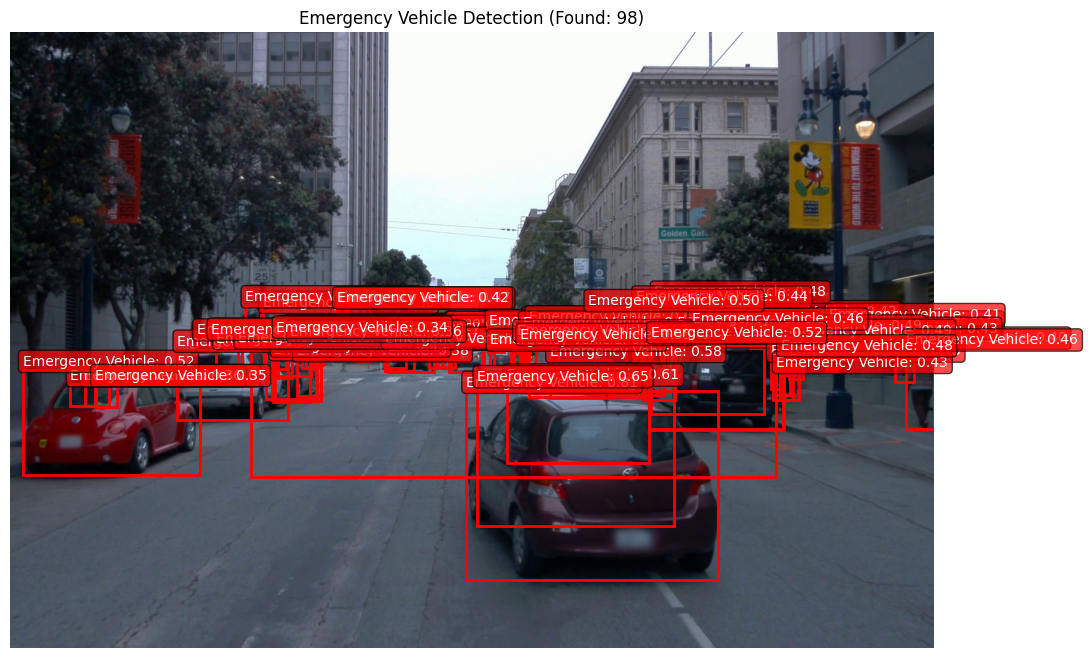


--- Testing with confidence threshold: 0.5 ---
✓ Found 38 emergency vehicles
Detection details:
  1. Confidence: 0.507, Box: [992.4, 635.8, 1026.4, 664.0]
  2. Confidence: 0.502, Box: [1049.3, 625.7, 1072.6, 653.6]
  3. Confidence: 0.510, Box: [913.9, 640.7, 980.6, 705.2]
  4. Confidence: 0.525, Box: [887.4, 654.8, 916.0, 695.6]
  5. Confidence: 0.549, Box: [1310.6, 651.1, 1359.3, 754.5]
  6. Confidence: 0.642, Box: [1326.9, 643.4, 1605.1, 826.9]
  7. Confidence: 0.517, Box: [898.1, 656.1, 924.2, 696.7]
  8. Confidence: 0.515, Box: [1377.1, 620.1, 1406.3, 651.0]
  9. Confidence: 0.504, Box: [1327.3, 641.6, 1608.0, 825.2]
  10. Confidence: 0.547, Box: [1315.8, 624.5, 1380.9, 764.7]
  11. Confidence: 0.547, Box: [1317.9, 621.2, 1352.8, 684.2]
  12. Confidence: 0.606, Box: [1071.5, 611.5, 1301.4, 750.0]
  13. Confidence: 0.511, Box: [870.1, 655.2, 899.3, 696.9]
  14. Confidence: 0.519, Box: [1585.9, 638.4, 1627.1, 764.4]
  15. Confidence: 0.507, Box: [993.5, 628.5, 1027.6, 660.3]
  16. C

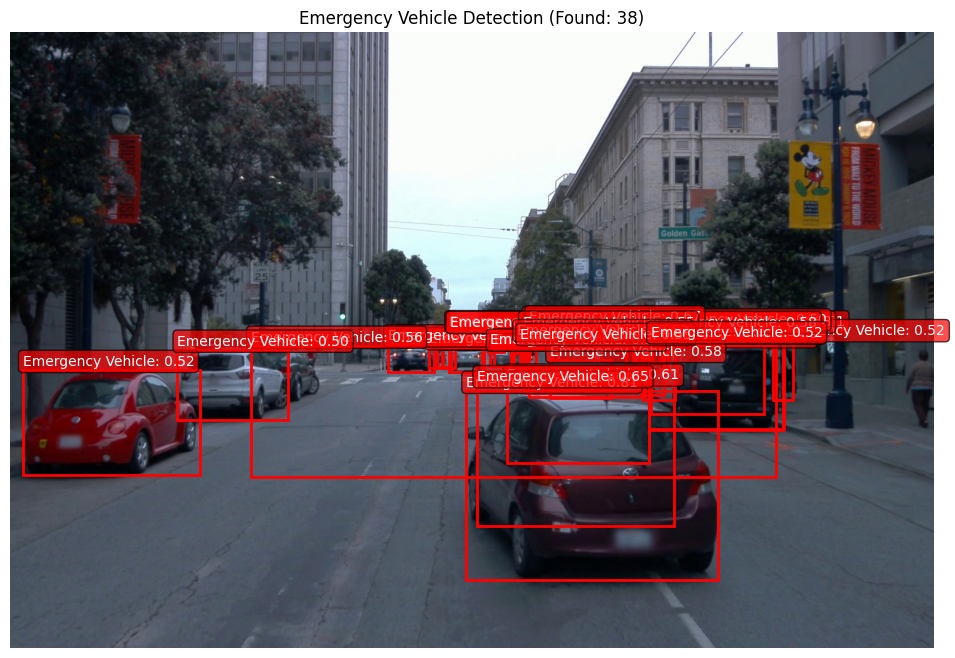


--- Testing with confidence threshold: 0.7 ---
✓ Found 1 emergency vehicles
Detection details:
  1. Confidence: 0.807, Box: [946.9, 745.7, 1471.5, 1137.2]
✓ Visualization saved to detection_result_conf_0.7.jpg


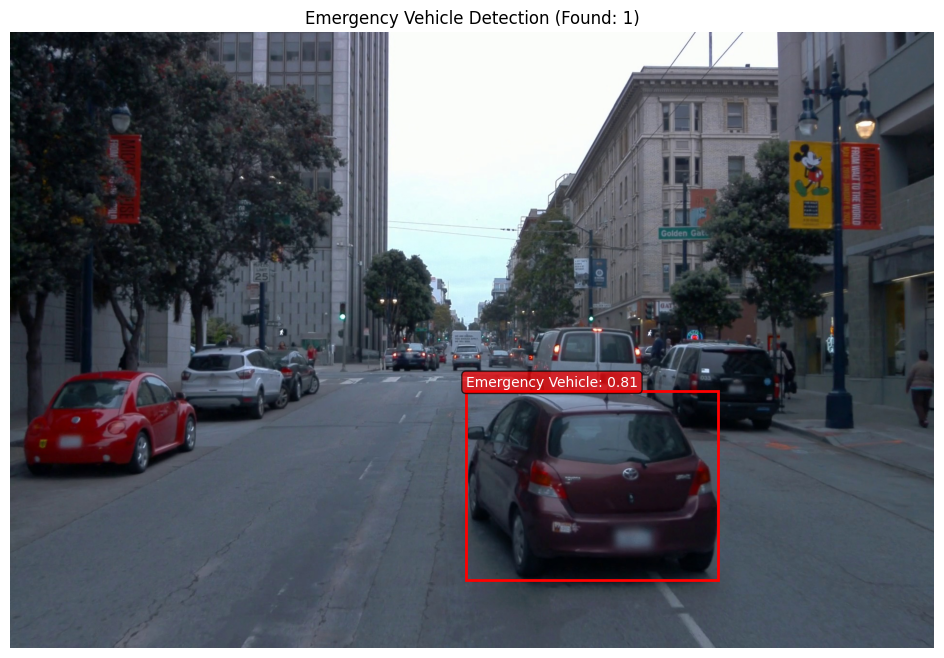

In [13]:
import torch
import torch.nn as nn
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

def load_model(model_dir, device='cpu'):
    """Load the fine-tuned DETR model with proper architecture matching"""
    try:
        # First, try the simple approach
        processor = DetrImageProcessor.from_pretrained(model_dir)
        model = DetrForObjectDetection.from_pretrained(model_dir)
        model.to(device)
        model.eval()
        
        print(f"✓ Model loaded successfully")
        print(f"  - Classes: {model.config.num_labels}")
        print(f"  - Device: {next(model.parameters()).device}")
        
        return model, processor
        
    except Exception as e:
        print(f"Standard loading failed: {e}")
        print("Attempting custom loading...")
        
        try:
            # Load processor
            processor = DetrImageProcessor.from_pretrained(model_dir)
            
            # Load base model and modify it to match your trained model
            base_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
            
            # Modify the model architecture to match what was saved
            base_model.config.num_labels = 1
            base_model.class_labels_classifier = nn.Linear(
                base_model.class_labels_classifier.in_features, 
                1  # Single class output
            )
            
            # Now load the saved weights
            import json
            import os
            
            # Try to load from safetensors first
            try:
                from safetensors.torch import load_file
                safetensors_path = os.path.join(model_dir, "model.safetensors")
                if os.path.exists(safetensors_path):
                    print("Loading weights from safetensors...")
                    state_dict = load_file(safetensors_path)
                    base_model.load_state_dict(state_dict, strict=False)
                else:
                    raise FileNotFoundError("No safetensors file found")
            except:
                # Fallback to pytorch_model.bin
                bin_path = os.path.join(model_dir, "pytorch_model.bin")
                if os.path.exists(bin_path):
                    print("Loading weights from pytorch_model.bin...")
                    state_dict = torch.load(bin_path, map_location=device)
                    base_model.load_state_dict(state_dict, strict=False)
                else:
                    raise FileNotFoundError("No model weights file found")
            
            base_model.to(device)
            base_model.eval()
            
            print(f"✓ Model loaded successfully with custom loading")
            print(f"  - Classes: {base_model.config.num_labels}")
            print(f"  - Device: {next(base_model.parameters()).device}")
            
            return base_model, processor
            
        except Exception as e2:
            print(f"✗ Custom loading also failed: {e2}")
            return None, None

def predict_image(model, processor, image_path, confidence_threshold=0.5, device='cpu'):
    """Run inference on a single image"""
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Process image
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Custom post-processing for single class
    logits = outputs.logits[0]  # [num_queries, num_classes]
    boxes = outputs.pred_boxes[0]  # [num_queries, 4]
    
    # For single class, use sigmoid activation
    if logits.shape[-1] == 1:
        scores = torch.sigmoid(logits[:, 0])
    else:
        # For multi-class, use softmax (shouldn't happen with your model)
        probs = torch.softmax(logits, dim=-1)
        scores = probs[:, :-1].max(dim=-1)[0]  # Exclude background
    
    # Filter by confidence threshold
    keep = scores > confidence_threshold
    
    if keep.sum() == 0:
        return image, [], [], []
    
    # Get filtered results
    final_scores = scores[keep]
    final_boxes = boxes[keep]
    
    # Convert boxes from center format to corner format
    # DETR outputs [center_x, center_y, width, height] normalized to [0,1]
    img_w, img_h = image.size
    
    cx, cy, w, h = final_boxes.unbind(-1)
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    x2 = (cx + w / 2) * img_w
    y2 = (cy + h / 2) * img_h
    
    final_boxes = torch.stack([x1, y1, x2, y2], dim=-1)
    
    return image, final_boxes.cpu().numpy(), final_scores.cpu().numpy(), [0] * len(final_scores)

def visualize_predictions(image, boxes, scores, labels, save_path=None):
    """Visualize predictions"""
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        # Draw bounding box
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(
            x1, y1 - 10,
            f'Emergency Vehicle: {score:.2f}',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7),
            color='white', fontsize=10
        )
    
    ax.set_title(f'Emergency Vehicle Detection (Found: {len(boxes)})')
    ax.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"✓ Visualization saved to {save_path}")
    
    plt.show()

def evaluate_model():
    """Main evaluation function"""
    # Configuration
    model_dir = "waymo_emergency_vehicle_detection/detr_finetuned"
    test_image = "waymo_emergency_vehicle_detection/detr_dataset/train/train_00016_20.jpg"
    
    # Check if paths exist
    if not os.path.exists(model_dir):
        print(f"✗ Model directory not found: {model_dir}")
        return
    
    if not os.path.exists(test_image):
        print(f"✗ Test image not found: {test_image}")
        return
    
    # Set device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Load model
    print("Loading model...")
    model, processor = load_model(model_dir, device)
    
    if model is None:
        print("✗ Failed to load model")
        return
    
    # Test with different confidence thresholds
    confidence_thresholds = [0.3, 0.5, 0.7]
    
    for threshold in confidence_thresholds:
        print(f"\n--- Testing with confidence threshold: {threshold} ---")
        
        # Run prediction
        image, boxes, scores, labels = predict_image(
            model, processor, test_image, 
            confidence_threshold=threshold, device=device
        )
        
        print(f"✓ Found {len(boxes)} emergency vehicles")
        
        if len(boxes) > 0:
            print("Detection details:")
            for i, (box, score) in enumerate(zip(boxes, scores)):
                x1, y1, x2, y2 = box
                print(f"  {i+1}. Confidence: {score:.3f}, Box: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")
            
            # Visualize results
            save_path = f"detection_result_conf_{threshold:.1f}.jpg"
            visualize_predictions(image, boxes, scores, labels, save_path)
        else:
            print("  No detections above threshold")

if __name__ == "__main__":
    evaluate_model()

In [15]:
import torch
import torch.nn as nn
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2
from tqdm import tqdm

def load_model(model_dir, device='cpu'):
    """Load the fine-tuned DETR model with proper architecture matching"""
    try:
        # First, try the simple approach
        processor = DetrImageProcessor.from_pretrained(model_dir)
        model = DetrForObjectDetection.from_pretrained(model_dir)
        model.to(device)
        model.eval()
        
        print(f"✓ Model loaded successfully")
        print(f"  - Classes: {model.config.num_labels}")
        print(f"  - Device: {next(model.parameters()).device}")
        
        return model, processor
        
    except Exception as e:
        print(f"Standard loading failed: {e}")
        print("Attempting custom loading...")
        
        try:
            # Load processor
            processor = DetrImageProcessor.from_pretrained(model_dir)
            
            # Load base model and modify it to match your trained model
            base_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
            
            # Modify the model architecture to match what was saved
            base_model.config.num_labels = 1
            base_model.class_labels_classifier = nn.Linear(
                base_model.class_labels_classifier.in_features, 
                1  # Single class output
            )
            
            # Now load the saved weights
            import json
            import os
            
            # Try to load from safetensors first
            try:
                from safetensors.torch import load_file
                safetensors_path = os.path.join(model_dir, "model.safetensors")
                if os.path.exists(safetensors_path):
                    print("Loading weights from safetensors...")
                    state_dict = load_file(safetensors_path)
                    base_model.load_state_dict(state_dict, strict=False)
                else:
                    raise FileNotFoundError("No safetensors file found")
            except:
                # Fallback to pytorch_model.bin
                bin_path = os.path.join(model_dir, "pytorch_model.bin")
                if os.path.exists(bin_path):
                    print("Loading weights from pytorch_model.bin...")
                    state_dict = torch.load(bin_path, map_location=device)
                    base_model.load_state_dict(state_dict, strict=False)
                else:
                    raise FileNotFoundError("No model weights file found")
            
            base_model.to(device)
            base_model.eval()
            
            print(f"✓ Model loaded successfully with custom loading")
            print(f"  - Classes: {base_model.config.num_labels}")
            print(f"  - Device: {next(base_model.parameters()).device}")
            
            return base_model, processor
            
        except Exception as e2:
            print(f"✗ Custom loading also failed: {e2}")
            return None, None

def process_video(model, processor, video_path, output_path, confidence_threshold=0.5, device='cpu', skip_frames=1):
    """Process a video file and create output with detections"""
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"✗ Error opening video: {video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video info: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps // skip_frames, (width, height))
    
    frame_count = 0
    processed_frames = 0
    
    with tqdm(total=total_frames, desc="Processing video") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Skip frames if specified
            if frame_count % skip_frames != 0:
                frame_count += 1
                pbar.update(1)
                continue
            
            # Convert BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(rgb_frame)
            
            # Run detection
            _, boxes, scores, _ = predict_image(
                model, processor, pil_image, confidence_threshold, device
            )
            
            # Draw detections on frame
            for box, score in zip(boxes, scores):
                x1, y1, x2, y2 = map(int, box)
                
                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                
                # Draw label
                label = f'Emergency Vehicle: {score:.2f}'
                label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                cv2.rectangle(frame, (x1, y1 - label_size[1] - 10), 
                            (x1 + label_size[0], y1), (0, 0, 255), -1)
                cv2.putText(frame, label, (x1, y1 - 5), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            
            # Write frame
            out.write(frame)
            
            frame_count += 1
            processed_frames += 1
            pbar.update(skip_frames)
            
            # Optional: Display progress
            if processed_frames % 30 == 0:
                pbar.set_description(f"Processing video - Detections in last frame: {len(boxes)}")
    
    # Clean up
    cap.release()
    out.release()
    
    print(f"✓ Video processing complete!")
    print(f"  - Processed {processed_frames} frames")
    print(f"  - Output saved to: {output_path}")

def predict_image(model, processor, image, confidence_threshold=0.5, device='cpu'):
    """Run inference on a single image (modified to accept PIL Image or path)"""
    # Handle both file paths and PIL Images
    if isinstance(image, str):
        image = Image.open(image).convert('RGB')
    elif isinstance(image, Image.Image):
        image = image.convert('RGB')
    
    # Process image
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Custom post-processing for single class
    logits = outputs.logits[0]  # [num_queries, num_classes]
    boxes = outputs.pred_boxes[0]  # [num_queries, 4]
    
    # For single class, use sigmoid activation
    if logits.shape[-1] == 1:
        scores = torch.sigmoid(logits[:, 0])
    else:
        # For multi-class, use softmax (shouldn't happen with your model)
        probs = torch.softmax(logits, dim=-1)
        scores = probs[:, :-1].max(dim=-1)[0]  # Exclude background
    
    # Filter by confidence threshold
    keep = scores > confidence_threshold
    
    if keep.sum() == 0:
        return image, [], [], []
    
    # Get filtered results
    final_scores = scores[keep]
    final_boxes = boxes[keep]
    
    # Convert boxes from center format to corner format
    # DETR outputs [center_x, center_y, width, height] normalized to [0,1]
    img_w, img_h = image.size
    
    cx, cy, w, h = final_boxes.unbind(-1)
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    x2 = (cx + w / 2) * img_w
    y2 = (cy + h / 2) * img_h
    
    final_boxes = torch.stack([x1, y1, x2, y2], dim=-1)
    
    return image, final_boxes.cpu().numpy(), final_scores.cpu().numpy(), [0] * len(final_scores)

def visualize_predictions(image, boxes, scores, labels, save_path=None):
    """Visualize predictions"""
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        # Draw bounding box
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(
            x1, y1 - 10,
            f'Emergency Vehicle: {score:.2f}',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7),
            color='white', fontsize=10
        )
    
    ax.set_title(f'Emergency Vehicle Detection (Found: {len(boxes)})')
    ax.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"✓ Visualization saved to {save_path}")
    
    plt.show()

def evaluate_model():
    """Main evaluation function - supports both images and videos"""
    # Configuration
    model_dir = "waymo_emergency_vehicle_detection/detr_finetuned"
    
    # You can specify either an image or video file
    test_image = "waymo_emergency_vehicle_detection/detr_dataset/train/train_00016_20.jpg"
    test_video = r"C:\Users\daihu\Documents\_School\24-25\32023 Advanced Computer Vision\Project\waymo_emergency_vehicle_detection\data\videos\train_00049.mp4"  # Set this to your video path, e.g., "path/to/your/video.mp4"
    
    # Check if paths exist
    if not os.path.exists(model_dir):
        print(f"✗ Model directory not found: {model_dir}")
        return
    
    # Set device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Load model
    print("Loading model...")
    model, processor = load_model(model_dir, device)
    
    if model is None:
        print("✗ Failed to load model")
        return
    
    # Process video if specified
    if test_video and os.path.exists(test_video):
        print(f"\n--- Processing Video: {test_video} ---")
        
        output_video = test_video.replace('.mp4', '_detected.mp4')
        output_video = output_video.replace('.avi', '_detected.avi')
        output_video = output_video.replace('.mov', '_detected.mov')
        
        process_video(
            model, processor, test_video, output_video,
            confidence_threshold=0.5,  # Adjust as needed
            device=device,
            skip_frames=1  # Process every frame, set to 2 for every other frame
        )
        
        return
    
    # Process image if video not specified
    if os.path.exists(test_image):
        print(f"\n--- Processing Image: {test_image} ---")
        
        # Test with different confidence thresholds
        confidence_thresholds = [0.3, 0.5, 0.7]
        
        for threshold in confidence_thresholds:
            print(f"\n--- Testing with confidence threshold: {threshold} ---")
            
            # Run prediction
            image, boxes, scores, labels = predict_image(
                model, processor, test_image, 
                confidence_threshold=threshold, device=device
            )
            
            print(f"✓ Found {len(boxes)} emergency vehicles")
            
            if len(boxes) > 0:
                print("Detection details:")
                for i, (box, score) in enumerate(zip(boxes, scores)):
                    x1, y1, x2, y2 = box
                    print(f"  {i+1}. Confidence: {score:.3f}, Box: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")
                
                # Visualize results
                save_path = f"detection_result_conf_{threshold:.1f}.jpg"
                visualize_predictions(image, boxes, scores, labels, save_path)
            else:
                print("  No detections above threshold")
    else:
        print(f"✗ Test file not found. Please set test_image or test_video path.")

# Convenience function for video processing
def process_video_file(video_path, model_dir=None, confidence_threshold=0.5, skip_frames=1):
    """Convenience function to process a video file"""
    if model_dir is None:
        model_dir = "waymo_emergency_vehicle_detection/detr_finetuned"
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Load model
    print("Loading model...")
    model, processor = load_model(model_dir, device)
    
    if model is None:
        print("✗ Failed to load model")
        return
    
    # Generate output path
    output_path = video_path.replace('.mp4', '_detected.mp4')
    output_path = output_path.replace('.avi', '_detected.avi')
    output_path = output_path.replace('.mov', '_detected.mov')
    
    # Process video
    process_video(model, processor, video_path, output_path, 
                 confidence_threshold, device, skip_frames)
    
    return output_path

if __name__ == "__main__":
    evaluate_model()

Using device: cuda
Loading model...
Standard loading failed: Error(s) in loading state_dict for Linear:
	size mismatch for bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).
Attempting custom loading...


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading weights from safetensors...
✓ Model loaded successfully with custom loading
  - Classes: 1
  - Device: cuda:0

--- Processing Video: C:\Users\daihu\Documents\_School\24-25\32023 Advanced Computer Vision\Project\waymo_emergency_vehicle_detection\data\videos\train_00049.mp4 ---
Video info: 1920x1280, 10 FPS, 199 frames


Processing video - Detections in last frame: 37: 100%|███████████████████████████████| 199/199 [00:20<00:00,  9.94it/s]

✓ Video processing complete!
  - Processed 199 frames
  - Output saved to: C:\Users\daihu\Documents\_School\24-25\32023 Advanced Computer Vision\Project\waymo_emergency_vehicle_detection\data\videos\train_00049_detected.mp4
